In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pip install statsmodels

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import acf, pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import time
from datetime import datetime
import joblib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.dates as mdates

In [4]:
# Load the sets
train_set = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/train_set_2D.parquet", engine="pyarrow")
val_set = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/val_set_2D.parquet", engine="pyarrow")
test_set = pd.read_parquet("/content/drive/MyDrive/LSE Capstone G Drive/Train Val Test Sets/2D Dataframes/test_set_2D.parquet", engine="pyarrow")

print("Train Set Shape:", train_set.shape)
print("Columns:", train_set.columns.tolist())

# Double checking that there are no NaNs in the train/val/test sets
print(f"Train set: \n{train_set.isnull().sum()}")
print(f"\nVal set: \n{val_set.isnull().sum()}")
print(f"\nTrain set: \n{test_set.isnull().sum()}")

train_set.head()

Train Set Shape: (5066592, 11)
Columns: ['lat_5km', 'lon_5km', 'KD490', 'ZSD', 'RRS490', 'RRS443', 'CHL', 'MICRO', 'BBP', 'CDM', 'date']
Train set: 
lat_5km    0
lon_5km    0
KD490      0
ZSD        0
RRS490     0
RRS443     0
CHL        0
MICRO      0
BBP        0
CDM        0
date       0
dtype: int64

Val set: 
lat_5km    0
lon_5km    0
KD490      0
ZSD        0
RRS490     0
RRS443     0
CHL        0
MICRO      0
BBP        0
CDM        0
date       0
dtype: int64

Train set: 
lat_5km    0
lon_5km    0
KD490      0
ZSD        0
RRS490     0
RRS443     0
CHL        0
MICRO      0
BBP        0
CDM        0
date       0
dtype: int64


,lat_5km,lon_5km,KD490,ZSD,RRS490,RRS443,CHL,MICRO,BBP,CDM,date
2484972,49.15,-10.75,0.045128,20.067772,0.005975,0.006162,0.226696,0.116628,0.003510,0.025269,2022-01-27
2484973,49.15,-10.70,0.046286,19.458317,0.006216,0.006206,0.240509,0.116628,0.003727,0.025429,2022-01-27
2484974,49.15,-10.65,0.046816,19.190926,0.005016,0.004744,0.246931,0.116628,0.003518,0.026799,2022-01-27
2484975,49.15,-10.60,0.046941,19.129135,0.004528,0.004160,0.248443,0.116628,0.003137,0.028340,2022-01-27
2484976,49.15,-10.55,0.047569,18.826391,0.005309,0.004928,0.256153,0.116628,0.003519,0.029589,2022-01-27


# Vector AutoRegression Model: without first differencing

## Prepare the containers for the results

In [5]:
# Prepare containers for results
parameter_columns = ["KD490", "ZSD", "RRS490", "RRS443", "CHL", "MICRO", "BBP", "CDM"]
lag_selection = {}   # {(lat, lon): selected_lag}
val_predictions = {} # {(lat, lon): predicted_array}

# Store lat/lon for heatmap axes
unique_lats = np.sort(train_set['lat_5km'].unique())
unique_lons = np.sort(train_set['lon_5km'].unique())
lag_heatmap = np.full((len(unique_lats), len(unique_lons)), np.nan)

## Function for VAR Model

In [11]:
def train_VAR_model(train_set, val_set, test_set, MAX_lags=1):
    start_time = time.time()
    total_points = len(unique_lats) * len(unique_lons)

    val_predictions = {}
    test_predictions = {}

    with tqdm(total=total_points, desc="Fitting VAR Models") as pbar:

        for i_lat, lat in enumerate(unique_lats):
            for i_lon, lon in enumerate(unique_lons):

                current_point = f"Grid Point ({lat}, {lon})"
                pbar.set_postfix_str(current_point)

                # Filter by point
                train_ts_full = train_set[(train_set['lat_5km'] == lat) & (train_set['lon_5km'] == lon)].copy()
                val_ts_full   = val_set[(val_set['lat_5km'] == lat) & (val_set['lon_5km'] == lon)].copy()
                test_ts_full  = test_set[(test_set['lat_5km'] == lat) & (test_set['lon_5km'] == lon)].copy()

                if len(train_ts_full) < 10 or len(val_ts_full) < 1 or len(test_ts_full) < 1:
                    pbar.update(1)
                    continue

                # Set index and drop coordinates
                train_ts_full = train_ts_full.sort_values('date').set_index('date').drop(['lat_5km','lon_5km'], axis=1)
                val_ts_full   = val_ts_full.sort_values('date').set_index('date').drop(['lat_5km','lon_5km'], axis=1)
                test_ts_full  = test_ts_full.sort_values('date').set_index('date').drop(['lat_5km','lon_5km'], axis=1)

                # --- Split training blocks (avoid crossing winter gap) ---
                block_2022 = train_ts_full['2022-01-27':'2022-11-20']
                block_2023 = train_ts_full['2023-01-27':'2023-11-17']
                cleaned_train = pd.concat([block_2022, block_2023.iloc[1:]]).reset_index(drop=True)

                if cleaned_train.nunique().max() <= 1:
                    print(f"Skipping VAR at ({lat},{lon}) due to constant variables.")
                    pbar.update(1)
                    continue

                # --- Select best lag ---
                best_lag = 1
                best_aic = np.inf
                for lag in range(1, MAX_lags + 1):
                    try:
                        m = VAR(cleaned_train).fit(lag)
                        if m.aic < best_aic:
                            best_aic = m.aic
                            best_lag = lag
                    except:
                        continue

                model = VAR(cleaned_train)
                result = model.fit(best_lag)
                print(f"Fitted VAR at ({lat},{lon}) with lag {best_lag}")

                # --- Forecast helper function for block-wise prediction ---
                def forecast_blocks(ts_full, result, target_dict):
                    ts_full = ts_full.sort_index()
                    blocks = []
                    block = []
                    prev_date = None

                    for date, row in ts_full.iterrows():
                        if prev_date is None or (date - prev_date).days <= 1:
                            block.append((date, row))
                        else:
                            blocks.append(pd.DataFrame([r for _, r in block], index=[d for d, _ in block]))
                            block = [(date, row)]
                        prev_date = date
                    if block:
                        blocks.append(pd.DataFrame([r for _, r in block], index=[d for d, _ in block]))

                    preds = []
                    for block_df in blocks:
                        block_array = block_df.reset_index(drop=True).values
                        block_preds = []

                        for t in range(len(block_array)):
                            try:
                                if t < best_lag:
                                    needed_from_train = best_lag - t
                                    history = np.vstack([
                                        cleaned_train.values[-needed_from_train:],
                                        block_array[:t]
                                    ])
                                else:
                                    history = block_array[t - best_lag : t]

                                next_pred = result.forecast(y=history, steps=1)
                                block_preds.append(next_pred[0])
                            except Exception as e:
                                print(f"Forecasting failed at step {t} for ({lat},{lon}): {e}")
                                block_preds.append(np.full(cleaned_train.shape[1], np.nan))

                        preds.extend(block_preds)

                    target_dict[(lat, lon)] = np.array(preds)

                # --- Forecast on validation and test sets --- #
                forecast_blocks(val_ts_full, result, val_predictions)
                forecast_blocks(test_ts_full, result, test_predictions)

                # Update progress
                pbar.set_postfix_str(f"{current_point} - lag selected: {best_lag}")
                pbar.update(1)

    end_time = time.time()
    print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")

    return val_predictions, test_predictions, result

## Run the VAR model

In [13]:
val_predictions, test_predictions, result_model = train_VAR_model(train_set, val_set, test_set, MAX_lags=1)

Fitting VAR Models:   0%|          | 1/10899 [00:00<34:55,  5.20it/s, Grid Point (49.15, -10.7)]                   

Fitted VAR at (49.15,-10.75) with lag 1
Fitted VAR at (49.15,-10.7) with lag 1


Fitting VAR Models:   0%|          | 2/10899 [00:00<34:38,  5.24it/s, Grid Point (49.15, -10.65)]                 

Fitted VAR at (49.15,-10.65) with lag 1


Fitting VAR Models:   0%|          | 5/10899 [00:01<34:50,  5.21it/s, Grid Point (49.15, -10.5)]                   

Fitted VAR at (49.15,-10.6) with lag 1
Fitted VAR at (49.15,-10.55) with lag 1


Fitting VAR Models:   0%|          | 7/10899 [00:01<29:21,  6.18it/s, Grid Point (49.15, -10.4)]                   

Fitted VAR at (49.15,-10.5) with lag 1
Fitted VAR at (49.15,-10.45) with lag 1


Fitting VAR Models:   0%|          | 8/10899 [00:01<29:06,  6.23it/s, Grid Point (49.15, -10.35)]                 

Fitted VAR at (49.15,-10.4) with lag 1
Fitted VAR at (49.15,-10.35) with lag 1


Fitting VAR Models:   0%|          | 11/10899 [00:01<30:15,  6.00it/s, Grid Point (49.15, -10.2)]                   

Fitted VAR at (49.15,-10.3) with lag 1
Fitted VAR at (49.15,-10.25) with lag 1
Fitted VAR at (49.15,-10.2) with lag 1


Fitting VAR Models:   0%|          | 15/10899 [00:02<20:09,  9.00it/s, Grid Point (49.15, -10.0)]                   

Fitted VAR at (49.15,-10.15) with lag 1
Fitted VAR at (49.15,-10.1) with lag 1
Fitted VAR at (49.15,-10.05) with lag 1


Fitting VAR Models:   0%|          | 18/10899 [00:02<16:46, 10.81it/s, Grid Point (49.15, -9.85)]                 

Fitted VAR at (49.15,-10.0) with lag 1
Fitted VAR at (49.15,-9.95) with lag 1
Fitted VAR at (49.15,-9.9) with lag 1


Fitting VAR Models:   0%|          | 21/10899 [00:02<16:06, 11.25it/s, Grid Point (49.15, -9.7)]                   

Fitted VAR at (49.15,-9.85) with lag 1
Fitted VAR at (49.15,-9.8) with lag 1
Fitted VAR at (49.15,-9.75) with lag 1


Fitting VAR Models:   0%|          | 23/10899 [00:02<16:05, 11.26it/s, Grid Point (49.15, -9.6) - lag selected: 1]

Fitted VAR at (49.15,-9.7) with lag 1
Fitted VAR at (49.15,-9.65) with lag 1
Fitted VAR at (49.15,-9.6) with lag 1


Fitting VAR Models:   0%|          | 27/10899 [00:03<15:20, 11.82it/s, Grid Point (49.15, -9.4)]                   

Fitted VAR at (49.15,-9.55) with lag 1
Fitted VAR at (49.15,-9.5) with lag 1
Fitted VAR at (49.15,-9.45) with lag 1


Fitting VAR Models:   0%|          | 30/10899 [00:03<14:55, 12.14it/s, Grid Point (49.15, -9.25)]                 

Fitted VAR at (49.15,-9.4) with lag 1
Fitted VAR at (49.15,-9.35) with lag 1
Fitted VAR at (49.15,-9.3) with lag 1


Fitting VAR Models:   0%|          | 33/10899 [00:03<14:54, 12.15it/s, Grid Point (49.15, -9.1)]                   

Fitted VAR at (49.15,-9.25) with lag 1
Fitted VAR at (49.15,-9.2) with lag 1
Fitted VAR at (49.15,-9.15) with lag 1


Fitting VAR Models:   0%|          | 35/10899 [00:03<14:52, 12.18it/s, Grid Point (49.15, -9.0)]                   

Fitted VAR at (49.15,-9.1) with lag 1
Fitted VAR at (49.15,-9.05) with lag 1
Fitted VAR at (49.15,-9.0) with lag 1


Fitting VAR Models:   0%|          | 39/10899 [00:04<15:10, 11.92it/s, Grid Point (49.15, -8.8)]                   

Fitted VAR at (49.15,-8.95) with lag 1
Fitted VAR at (49.15,-8.9) with lag 1
Fitted VAR at (49.15,-8.85) with lag 1


Fitting VAR Models:   0%|          | 42/10899 [00:04<15:13, 11.89it/s, Grid Point (49.15, -8.7) - lag selected: 1]

Fitted VAR at (49.15,-8.8) with lag 1
Fitted VAR at (49.15,-8.75) with lag 1
Fitted VAR at (49.15,-8.7) with lag 1


Fitting VAR Models:   0%|          | 45/10899 [00:04<15:13, 11.89it/s, Grid Point (49.15, -8.5)]                   

Fitted VAR at (49.15,-8.65) with lag 1
Fitted VAR at (49.15,-8.6) with lag 1
Fitted VAR at (49.15,-8.55) with lag 1


Fitting VAR Models:   0%|          | 47/10899 [00:04<15:02, 12.02it/s, Grid Point (49.15, -8.4)]                   

Fitted VAR at (49.15,-8.5) with lag 1
Fitted VAR at (49.15,-8.45) with lag 1
Fitted VAR at (49.15,-8.4) with lag 1


Fitting VAR Models:   0%|          | 51/10899 [00:05<15:17, 11.82it/s, Grid Point (49.15, -8.2)]                   

Fitted VAR at (49.15,-8.35) with lag 1
Fitted VAR at (49.15,-8.3) with lag 1
Fitted VAR at (49.15,-8.25) with lag 1


Fitting VAR Models:   0%|          | 54/10899 [00:05<14:59, 12.06it/s, Grid Point (49.15, -8.05)]                 

Fitted VAR at (49.15,-8.2) with lag 1
Fitted VAR at (49.15,-8.15) with lag 1
Fitted VAR at (49.15,-8.1) with lag 1


Fitting VAR Models:   1%|          | 57/10899 [00:05<15:12, 11.88it/s, Grid Point (49.15, -7.9)]                   

Fitted VAR at (49.15,-8.05) with lag 1
Fitted VAR at (49.15,-8.0) with lag 1
Fitted VAR at (49.15,-7.95) with lag 1


Fitting VAR Models:   1%|          | 59/10899 [00:05<14:57, 12.08it/s, Grid Point (49.15, -7.8)]                   

Fitted VAR at (49.15,-7.9) with lag 1
Fitted VAR at (49.15,-7.85) with lag 1
Fitted VAR at (49.15,-7.8) with lag 1


Fitting VAR Models:   1%|          | 63/10899 [00:06<15:22, 11.75it/s, Grid Point (49.15, -7.6)]                   

Fitted VAR at (49.15,-7.75) with lag 1
Fitted VAR at (49.15,-7.7) with lag 1
Fitted VAR at (49.15,-7.65) with lag 1


Fitting VAR Models:   1%|          | 66/10899 [00:06<14:50, 12.17it/s, Grid Point (49.15, -7.45)]                 

Fitted VAR at (49.15,-7.6) with lag 1
Fitted VAR at (49.15,-7.55) with lag 1
Fitted VAR at (49.15,-7.5) with lag 1


Fitting VAR Models:   1%|          | 69/10899 [00:06<14:51, 12.15it/s, Grid Point (49.15, -7.3)]                   

Fitted VAR at (49.15,-7.45) with lag 1
Fitted VAR at (49.15,-7.4) with lag 1
Fitted VAR at (49.15,-7.35) with lag 1


Fitting VAR Models:   1%|          | 71/10899 [00:06<14:52, 12.14it/s, Grid Point (49.15, -7.2)]                   

Fitted VAR at (49.15,-7.3) with lag 1
Fitted VAR at (49.15,-7.25) with lag 1
Fitted VAR at (49.15,-7.2) with lag 1


Fitting VAR Models:   1%|          | 75/10899 [00:07<15:13, 11.85it/s, Grid Point (49.15, -7.0)]                   

Fitted VAR at (49.15,-7.15) with lag 1
Fitted VAR at (49.15,-7.1) with lag 1
Fitted VAR at (49.15,-7.05) with lag 1


Fitting VAR Models:   1%|          | 78/10899 [00:07<14:44, 12.23it/s, Grid Point (49.15, -6.85)]                 

Fitted VAR at (49.15,-7.0) with lag 1
Fitted VAR at (49.15,-6.95) with lag 1
Fitted VAR at (49.15,-6.9) with lag 1


Fitting VAR Models:   1%|          | 81/10899 [00:07<14:41, 12.28it/s, Grid Point (49.15, -6.7)]                   

Fitted VAR at (49.15,-6.85) with lag 1
Fitted VAR at (49.15,-6.8) with lag 1
Fitted VAR at (49.15,-6.75) with lag 1


Fitting VAR Models:   1%|          | 83/10899 [00:07<14:37, 12.32it/s, Grid Point (49.15, -6.6)]                   

Fitted VAR at (49.15,-6.7) with lag 1
Fitted VAR at (49.15,-6.65) with lag 1
Fitted VAR at (49.15,-6.6) with lag 1


Fitting VAR Models:   1%|          | 87/10899 [00:08<17:58, 10.03it/s, Grid Point (49.15, -6.4)]                   

Fitted VAR at (49.15,-6.55) with lag 1
Fitted VAR at (49.15,-6.5) with lag 1
Fitted VAR at (49.15,-6.45) with lag 1


Fitting VAR Models:   1%|          | 90/10899 [00:08<16:11, 11.13it/s, Grid Point (49.15, -6.25)]                 

Fitted VAR at (49.15,-6.4) with lag 1
Fitted VAR at (49.15,-6.35) with lag 1
Fitted VAR at (49.15,-6.3) with lag 1


Fitting VAR Models:   1%|          | 93/10899 [00:08<15:47, 11.41it/s, Grid Point (49.15, -6.1)]                   

Fitted VAR at (49.15,-6.25) with lag 1
Fitted VAR at (49.15,-6.2) with lag 1
Fitted VAR at (49.15,-6.15) with lag 1


Fitting VAR Models:   1%|          | 95/10899 [00:09<15:23, 11.70it/s, Grid Point (49.15, -6.0)]                   

Fitted VAR at (49.15,-6.1) with lag 1
Fitted VAR at (49.15,-6.05) with lag 1
Fitted VAR at (49.15,-6.0) with lag 1


Fitting VAR Models:   1%|          | 99/10899 [00:09<15:22, 11.71it/s, Grid Point (49.15, -5.8)]                   

Fitted VAR at (49.15,-5.95) with lag 1
Fitted VAR at (49.15,-5.9) with lag 1
Fitted VAR at (49.15,-5.85) with lag 1


Fitting VAR Models:   1%|          | 101/10899 [00:09<15:02, 11.96it/s, Grid Point (49.15, -5.7)]                   

Fitted VAR at (49.15,-5.8) with lag 1
Fitted VAR at (49.15,-5.75) with lag 1
Fitted VAR at (49.15,-5.7) with lag 1


Fitting VAR Models:   1%|          | 104/10899 [00:09<18:08,  9.92it/s, Grid Point (49.15, -5.55)]                 

Fitted VAR at (49.15,-5.65) with lag 1
Fitted VAR at (49.15,-5.6) with lag 1


Fitting VAR Models:   1%|          | 106/10899 [00:10<19:44,  9.11it/s, Grid Point (49.15, -5.45)]                 

Fitted VAR at (49.15,-5.55) with lag 1
Fitted VAR at (49.15,-5.5) with lag 1


Fitting VAR Models:   1%|          | 108/10899 [00:10<20:28,  8.79it/s, Grid Point (49.15, -5.35)]                 

Fitted VAR at (49.15,-5.45) with lag 1
Fitted VAR at (49.15,-5.4) with lag 1


Fitting VAR Models:   1%|          | 110/10899 [00:10<20:55,  8.59it/s, Grid Point (49.15, -5.25)]                 

Fitted VAR at (49.15,-5.35) with lag 1
Fitted VAR at (49.15,-5.3) with lag 1


Fitting VAR Models:   1%|          | 112/10899 [00:10<21:01,  8.55it/s, Grid Point (49.15, -5.15)]                 

Fitted VAR at (49.15,-5.25) with lag 1
Fitted VAR at (49.15,-5.2) with lag 1


Fitting VAR Models:   1%|          | 114/10899 [00:11<21:56,  8.19it/s, Grid Point (49.15, -5.05)]                 

Fitted VAR at (49.15,-5.15) with lag 1
Fitted VAR at (49.15,-5.1) with lag 1


Fitting VAR Models:   1%|          | 116/10899 [00:11<22:51,  7.86it/s, Grid Point (49.15, -4.95)]                 

Fitted VAR at (49.15,-5.05) with lag 1
Fitted VAR at (49.15,-5.0) with lag 1


Fitting VAR Models:   1%|          | 118/10899 [00:11<22:14,  8.08it/s, Grid Point (49.15, -4.85)]                 

Fitted VAR at (49.15,-4.95) with lag 1
Fitted VAR at (49.15,-4.9) with lag 1


Fitting VAR Models:   1%|          | 120/10899 [00:11<22:16,  8.07it/s, Grid Point (49.15, -4.75)]                 

Fitted VAR at (49.15,-4.85) with lag 1
Fitted VAR at (49.15,-4.8) with lag 1


Fitting VAR Models:   1%|          | 122/10899 [00:12<21:44,  8.26it/s, Grid Point (49.15, -4.65)]                 

Fitted VAR at (49.15,-4.75) with lag 1
Fitted VAR at (49.15,-4.7) with lag 1


Fitting VAR Models:   1%|          | 124/10899 [00:12<22:08,  8.11it/s, Grid Point (49.15, -4.55)]                 

Fitted VAR at (49.15,-4.65) with lag 1
Fitted VAR at (49.15,-4.6) with lag 1


Fitting VAR Models:   1%|          | 126/10899 [00:12<22:09,  8.11it/s, Grid Point (49.15, -4.45)]                 

Fitted VAR at (49.15,-4.55) with lag 1
Fitted VAR at (49.15,-4.5) with lag 1


Fitting VAR Models:   1%|          | 128/10899 [00:12<22:27,  7.99it/s, Grid Point (49.15, -4.35)]                 

Fitted VAR at (49.15,-4.45) with lag 1
Fitted VAR at (49.15,-4.4) with lag 1


Fitting VAR Models:   1%|          | 130/10899 [00:13<22:37,  7.93it/s, Grid Point (49.15, -4.25)]                 

Fitted VAR at (49.15,-4.35) with lag 1
Fitted VAR at (49.15,-4.3) with lag 1


Fitting VAR Models:   1%|          | 131/10899 [00:13<22:48,  7.87it/s, Grid Point (49.15, -4.2)]                   

Fitted VAR at (49.15,-4.25) with lag 1
Fitted VAR at (49.15,-4.2) with lag 1


Fitting VAR Models:   1%|          | 135/10899 [00:13<18:54,  9.48it/s, Grid Point (49.15, -4.0)]                   

Fitted VAR at (49.15,-4.15) with lag 1
Fitted VAR at (49.15,-4.1) with lag 1
Fitted VAR at (49.15,-4.05) with lag 1


Fitting VAR Models:   1%|▏         | 138/10899 [00:13<17:31, 10.24it/s, Grid Point (49.15, -3.85)]                 

Fitted VAR at (49.15,-4.0) with lag 1
Fitted VAR at (49.15,-3.95) with lag 1
Fitted VAR at (49.15,-3.9) with lag 1


Fitting VAR Models:   1%|▏         | 141/10899 [00:14<15:55, 11.26it/s, Grid Point (49.15, -3.7)]                   

Fitted VAR at (49.15,-3.85) with lag 1
Fitted VAR at (49.15,-3.8) with lag 1
Fitted VAR at (49.15,-3.75) with lag 1


Fitting VAR Models:   1%|▏         | 143/10899 [00:14<15:27, 11.60it/s, Grid Point (49.15, -3.6)]                   

Fitted VAR at (49.15,-3.7) with lag 1
Fitted VAR at (49.15,-3.65) with lag 1
Fitted VAR at (49.15,-3.6) with lag 1


Fitting VAR Models:   1%|▏         | 147/10899 [00:14<15:15, 11.74it/s, Grid Point (49.15, -3.4)]                   

Fitted VAR at (49.15,-3.55) with lag 1
Fitted VAR at (49.15,-3.5) with lag 1
Fitted VAR at (49.15,-3.45) with lag 1


Fitting VAR Models:   1%|▏         | 150/10899 [00:14<15:20, 11.67it/s, Grid Point (49.15, -3.25)]                 

Fitted VAR at (49.15,-3.4) with lag 1
Fitted VAR at (49.15,-3.35) with lag 1
Fitted VAR at (49.15,-3.3) with lag 1


Fitting VAR Models:   1%|▏         | 151/10899 [00:15<15:11, 11.80it/s, Grid Point (49.15, -3.2)]                   

Fitted VAR at (49.15,-3.25) with lag 1
Fitted VAR at (49.15,-3.2) with lag 1


Fitting VAR Models:   1%|▏         | 154/10899 [00:15<19:43,  9.08it/s, Grid Point (49.15, -3.05)]                 

Fitted VAR at (49.15,-3.15) with lag 1
Fitted VAR at (49.15,-3.1) with lag 1
Fitted VAR at (49.15,-3.05) with lag 1


Fitting VAR Models:   1%|▏         | 157/10899 [00:15<17:47, 10.07it/s, Grid Point (49.15, -2.9)]                   

Fitted VAR at (49.15,-3.0) with lag 1
Fitted VAR at (49.15,-2.95) with lag 1
Fitted VAR at (49.15,-2.9) with lag 1


Fitting VAR Models:   1%|▏         | 161/10899 [00:16<16:18, 10.98it/s, Grid Point (49.15, -2.7)]                   

Fitted VAR at (49.15,-2.85) with lag 1
Fitted VAR at (49.15,-2.8) with lag 1
Fitted VAR at (49.15,-2.75) with lag 1


Fitting VAR Models:   2%|▏         | 164/10899 [00:16<15:56, 11.22it/s, Grid Point (49.15, -2.55)]                 

Fitted VAR at (49.15,-2.7) with lag 1
Fitted VAR at (49.15,-2.65) with lag 1
Fitted VAR at (49.15,-2.6) with lag 1


Fitting VAR Models:   2%|▏         | 166/10899 [00:16<15:32, 11.51it/s, Grid Point (49.15, -2.45)]                 

Fitted VAR at (49.15,-2.55) with lag 1
Fitted VAR at (49.15,-2.5) with lag 1
Fitted VAR at (49.15,-2.45) with lag 1


Fitting VAR Models:   2%|▏         | 170/10899 [00:16<15:24, 11.60it/s, Grid Point (49.15, -2.25)]                 

Fitted VAR at (49.15,-2.4) with lag 1
Fitted VAR at (49.15,-2.35) with lag 1
Fitted VAR at (49.15,-2.3) with lag 1


Fitting VAR Models:   2%|▏         | 173/10899 [00:17<15:18, 11.67it/s, Grid Point (49.15, -2.15) - lag selected: 1]

Fitted VAR at (49.15,-2.25) with lag 1
Fitted VAR at (49.15,-2.2) with lag 1
Fitted VAR at (49.15,-2.15) with lag 1


Fitting VAR Models:   2%|▏         | 176/10899 [00:17<15:19, 11.66it/s, Grid Point (49.2, -10.6)]                   

Fitted VAR at (49.2,-10.75) with lag 1
Fitted VAR at (49.2,-10.7) with lag 1
Fitted VAR at (49.2,-10.65) with lag 1


Fitting VAR Models:   2%|▏         | 178/10899 [00:17<15:19, 11.66it/s, Grid Point (49.2, -10.5)]                   

Fitted VAR at (49.2,-10.6) with lag 1
Fitted VAR at (49.2,-10.55) with lag 1
Fitted VAR at (49.2,-10.5) with lag 1


Fitting VAR Models:   2%|▏         | 182/10899 [00:17<15:46, 11.32it/s, Grid Point (49.2, -10.3)]                   

Fitted VAR at (49.2,-10.45) with lag 1
Fitted VAR at (49.2,-10.4) with lag 1
Fitted VAR at (49.2,-10.35) with lag 1


Fitting VAR Models:   2%|▏         | 185/10899 [00:18<15:15, 11.70it/s, Grid Point (49.2, -10.15)]                 

Fitted VAR at (49.2,-10.3) with lag 1
Fitted VAR at (49.2,-10.25) with lag 1
Fitted VAR at (49.2,-10.2) with lag 1


Fitting VAR Models:   2%|▏         | 188/10899 [00:18<15:05, 11.83it/s, Grid Point (49.2, -10.0)]                   

Fitted VAR at (49.2,-10.15) with lag 1
Fitted VAR at (49.2,-10.1) with lag 1
Fitted VAR at (49.2,-10.05) with lag 1


Fitting VAR Models:   2%|▏         | 190/10899 [00:18<15:01, 11.88it/s, Grid Point (49.2, -9.9)]                   

Fitted VAR at (49.2,-10.0) with lag 1
Fitted VAR at (49.2,-9.95) with lag 1
Fitted VAR at (49.2,-9.9) with lag 1


Fitting VAR Models:   2%|▏         | 194/10899 [00:18<15:14, 11.71it/s, Grid Point (49.2, -9.7)]                   

Fitted VAR at (49.2,-9.85) with lag 1
Fitted VAR at (49.2,-9.8) with lag 1
Fitted VAR at (49.2,-9.75) with lag 1


Fitting VAR Models:   2%|▏         | 197/10899 [00:19<15:02, 11.86it/s, Grid Point (49.2, -9.55)]                 

Fitted VAR at (49.2,-9.7) with lag 1
Fitted VAR at (49.2,-9.65) with lag 1
Fitted VAR at (49.2,-9.6) with lag 1


Fitting VAR Models:   2%|▏         | 200/10899 [00:19<14:58, 11.91it/s, Grid Point (49.2, -9.4)]                   

Fitted VAR at (49.2,-9.55) with lag 1
Fitted VAR at (49.2,-9.5) with lag 1
Fitted VAR at (49.2,-9.45) with lag 1


Fitting VAR Models:   2%|▏         | 203/10899 [00:19<15:00, 11.87it/s, Grid Point (49.2, -9.3) - lag selected: 1]

Fitted VAR at (49.2,-9.4) with lag 1
Fitted VAR at (49.2,-9.35) with lag 1
Fitted VAR at (49.2,-9.3) with lag 1


Fitting VAR Models:   2%|▏         | 206/10899 [00:19<15:10, 11.74it/s, Grid Point (49.2, -9.1)]                   

Fitted VAR at (49.2,-9.25) with lag 1
Fitted VAR at (49.2,-9.2) with lag 1
Fitted VAR at (49.2,-9.15) with lag 1


Fitting VAR Models:   2%|▏         | 209/10899 [00:20<15:00, 11.87it/s, Grid Point (49.2, -8.95)]                 

Fitted VAR at (49.2,-9.1) with lag 1
Fitted VAR at (49.2,-9.05) with lag 1
Fitted VAR at (49.2,-9.0) with lag 1


Fitting VAR Models:   2%|▏         | 212/10899 [00:20<14:59, 11.88it/s, Grid Point (49.2, -8.8)]                   

Fitted VAR at (49.2,-8.95) with lag 1
Fitted VAR at (49.2,-8.9) with lag 1
Fitted VAR at (49.2,-8.85) with lag 1


Fitting VAR Models:   2%|▏         | 215/10899 [00:20<14:54, 11.94it/s, Grid Point (49.2, -8.65)]                 

Fitted VAR at (49.2,-8.8) with lag 1
Fitted VAR at (49.2,-8.75) with lag 1
Fitted VAR at (49.2,-8.7) with lag 1


Fitting VAR Models:   2%|▏         | 217/10899 [00:20<15:24, 11.56it/s, Grid Point (49.2, -8.55)]                 

Fitted VAR at (49.2,-8.65) with lag 1
Fitted VAR at (49.2,-8.6) with lag 1
Fitted VAR at (49.2,-8.55) with lag 1


Fitting VAR Models:   2%|▏         | 221/10899 [00:21<15:08, 11.75it/s, Grid Point (49.2, -8.35)]                 

Fitted VAR at (49.2,-8.5) with lag 1
Fitted VAR at (49.2,-8.45) with lag 1
Fitted VAR at (49.2,-8.4) with lag 1


Fitting VAR Models:   2%|▏         | 223/10899 [00:21<15:02, 11.82it/s, Grid Point (49.2, -8.25)]                 

Fitted VAR at (49.2,-8.35) with lag 1
Fitted VAR at (49.2,-8.3) with lag 1
Fitted VAR at (49.2,-8.25) with lag 1


Fitting VAR Models:   2%|▏         | 226/10899 [00:21<19:17,  9.22it/s, Grid Point (49.2, -8.1)]                   

Fitted VAR at (49.2,-8.2) with lag 1
Fitted VAR at (49.2,-8.15) with lag 1
Fitted VAR at (49.2,-8.1) with lag 1


Fitting VAR Models:   2%|▏         | 229/10899 [00:22<17:30, 10.16it/s, Grid Point (49.2, -7.95)]                 

Fitted VAR at (49.2,-8.05) with lag 1
Fitted VAR at (49.2,-8.0) with lag 1
Fitted VAR at (49.2,-7.95) with lag 1


Fitting VAR Models:   2%|▏         | 233/10899 [00:22<16:03, 11.07it/s, Grid Point (49.2, -7.75)]                 

Fitted VAR at (49.2,-7.9) with lag 1
Fitted VAR at (49.2,-7.85) with lag 1
Fitted VAR at (49.2,-7.8) with lag 1


Fitting VAR Models:   2%|▏         | 236/10899 [00:22<15:42, 11.31it/s, Grid Point (49.2, -7.6)]                   

Fitted VAR at (49.2,-7.75) with lag 1
Fitted VAR at (49.2,-7.7) with lag 1
Fitted VAR at (49.2,-7.65) with lag 1


Fitting VAR Models:   2%|▏         | 238/10899 [00:22<15:29, 11.47it/s, Grid Point (49.2, -7.5)]                   

Fitted VAR at (49.2,-7.6) with lag 1
Fitted VAR at (49.2,-7.55) with lag 1
Fitted VAR at (49.2,-7.5) with lag 1


Fitting VAR Models:   2%|▏         | 242/10899 [00:23<15:16, 11.63it/s, Grid Point (49.2, -7.3)]                   

Fitted VAR at (49.2,-7.45) with lag 1
Fitted VAR at (49.2,-7.4) with lag 1
Fitted VAR at (49.2,-7.35) with lag 1


Fitting VAR Models:   2%|▏         | 244/10899 [00:23<15:22, 11.55it/s, Grid Point (49.2, -7.2) - lag selected: 1]

Fitted VAR at (49.2,-7.3) with lag 1
Fitted VAR at (49.2,-7.25) with lag 1
Fitted VAR at (49.2,-7.2) with lag 1


Fitting VAR Models:   2%|▏         | 247/10899 [00:23<15:51, 11.19it/s, Grid Point (49.2, -7.05)]                 

Fitted VAR at (49.2,-7.15) with lag 1
Fitted VAR at (49.2,-7.1) with lag 1


Fitting VAR Models:   2%|▏         | 249/10899 [00:23<18:11,  9.76it/s, Grid Point (49.2, -6.95)]                 

Fitted VAR at (49.2,-7.05) with lag 1
Fitted VAR at (49.2,-7.0) with lag 1


Fitting VAR Models:   2%|▏         | 251/10899 [00:24<19:23,  9.16it/s, Grid Point (49.2, -6.85)]                 

Fitted VAR at (49.2,-6.95) with lag 1
Fitted VAR at (49.2,-6.9) with lag 1


Fitting VAR Models:   2%|▏         | 253/10899 [00:24<20:09,  8.80it/s, Grid Point (49.2, -6.75)]                 

Fitted VAR at (49.2,-6.85) with lag 1
Fitted VAR at (49.2,-6.8) with lag 1


Fitting VAR Models:   2%|▏         | 255/10899 [00:24<20:27,  8.67it/s, Grid Point (49.2, -6.65)]                 

Fitted VAR at (49.2,-6.75) with lag 1
Fitted VAR at (49.2,-6.7) with lag 1


Fitting VAR Models:   2%|▏         | 257/10899 [00:24<20:30,  8.65it/s, Grid Point (49.2, -6.55)]                 

Fitted VAR at (49.2,-6.65) with lag 1
Fitted VAR at (49.2,-6.6) with lag 1


Fitting VAR Models:   2%|▏         | 258/10899 [00:25<22:07,  8.01it/s, Grid Point (49.2, -6.5) - lag selected: 1]

Fitted VAR at (49.2,-6.55) with lag 1
Fitted VAR at (49.2,-6.5) with lag 1


Fitting VAR Models:   2%|▏         | 261/10899 [00:25<22:47,  7.78it/s, Grid Point (49.2, -6.35)]                 

Fitted VAR at (49.2,-6.45) with lag 1
Fitted VAR at (49.2,-6.4) with lag 1


Fitting VAR Models:   2%|▏         | 263/10899 [00:25<22:42,  7.81it/s, Grid Point (49.2, -6.25)]                 

Fitted VAR at (49.2,-6.35) with lag 1
Fitted VAR at (49.2,-6.3) with lag 1


Fitting VAR Models:   2%|▏         | 265/10899 [00:25<22:57,  7.72it/s, Grid Point (49.2, -6.15)]                 

Fitted VAR at (49.2,-6.25) with lag 1
Fitted VAR at (49.2,-6.2) with lag 1


Fitting VAR Models:   2%|▏         | 266/10899 [00:26<23:01,  7.69it/s, Grid Point (49.2, -6.1) - lag selected: 1]

Fitted VAR at (49.2,-6.15) with lag 1
Fitted VAR at (49.2,-6.1) with lag 1


Fitting VAR Models:   2%|▏         | 269/10899 [00:26<24:11,  7.32it/s, Grid Point (49.2, -5.95)]                 

Fitted VAR at (49.2,-6.05) with lag 1
Fitted VAR at (49.2,-6.0) with lag 1


Fitting VAR Models:   2%|▏         | 271/10899 [00:26<24:18,  7.29it/s, Grid Point (49.2, -5.85)]                 

Fitted VAR at (49.2,-5.95) with lag 1
Fitted VAR at (49.2,-5.9) with lag 1


Fitting VAR Models:   3%|▎         | 273/10899 [00:27<23:41,  7.47it/s, Grid Point (49.2, -5.75)]                 

Fitted VAR at (49.2,-5.85) with lag 1
Fitted VAR at (49.2,-5.8) with lag 1


Fitting VAR Models:   3%|▎         | 274/10899 [00:27<23:51,  7.42it/s, Grid Point (49.2, -5.7)]                   

Fitted VAR at (49.2,-5.75) with lag 1
Fitted VAR at (49.2,-5.7) with lag 1


Fitting VAR Models:   3%|▎         | 277/10899 [00:27<23:56,  7.39it/s, Grid Point (49.2, -5.55)]                 

Fitted VAR at (49.2,-5.65) with lag 1
Fitted VAR at (49.2,-5.6) with lag 1


Fitting VAR Models:   3%|▎         | 278/10899 [00:27<22:36,  7.83it/s, Grid Point (49.2, -5.5)]                   

Fitted VAR at (49.2,-5.55) with lag 1
Fitted VAR at (49.2,-5.5) with lag 1


Fitting VAR Models:   3%|▎         | 282/10899 [00:28<22:21,  7.91it/s, Grid Point (49.2, -5.3)]                   

Fitted VAR at (49.2,-5.45) with lag 1
Fitted VAR at (49.2,-5.4) with lag 1
Fitted VAR at (49.2,-5.35) with lag 1


Fitting VAR Models:   3%|▎         | 284/10899 [00:28<20:14,  8.74it/s, Grid Point (49.2, -5.2)]                   

Fitted VAR at (49.2,-5.3) with lag 1
Fitted VAR at (49.2,-5.25) with lag 1
Fitted VAR at (49.2,-5.2) with lag 1


Fitting VAR Models:   3%|▎         | 288/10899 [00:28<17:07, 10.33it/s, Grid Point (49.2, -5.0)]                   

Fitted VAR at (49.2,-5.15) with lag 1
Fitted VAR at (49.2,-5.1) with lag 1
Fitted VAR at (49.2,-5.05) with lag 1


Fitting VAR Models:   3%|▎         | 291/10899 [00:28<15:52, 11.13it/s, Grid Point (49.2, -4.85)]                 

Fitted VAR at (49.2,-5.0) with lag 1
Fitted VAR at (49.2,-4.95) with lag 1
Fitted VAR at (49.2,-4.9) with lag 1


Fitting VAR Models:   3%|▎         | 294/10899 [00:29<15:32, 11.38it/s, Grid Point (49.2, -4.7)]                   

Fitted VAR at (49.2,-4.85) with lag 1
Fitted VAR at (49.2,-4.8) with lag 1
Fitted VAR at (49.2,-4.75) with lag 1


Fitting VAR Models:   3%|▎         | 296/10899 [00:29<15:43, 11.23it/s, Grid Point (49.2, -4.6)]                   

Fitted VAR at (49.2,-4.7) with lag 1
Fitted VAR at (49.2,-4.65) with lag 1
Fitted VAR at (49.2,-4.6) with lag 1


Fitting VAR Models:   3%|▎         | 300/10899 [00:29<15:29, 11.41it/s, Grid Point (49.2, -4.4)]                   

Fitted VAR at (49.2,-4.55) with lag 1
Fitted VAR at (49.2,-4.5) with lag 1
Fitted VAR at (49.2,-4.45) with lag 1


Fitting VAR Models:   3%|▎         | 303/10899 [00:29<14:55, 11.83it/s, Grid Point (49.2, -4.25)]                 

Fitted VAR at (49.2,-4.4) with lag 1
Fitted VAR at (49.2,-4.35) with lag 1
Fitted VAR at (49.2,-4.3) with lag 1


Fitting VAR Models:   3%|▎         | 305/10899 [00:30<15:01, 11.75it/s, Grid Point (49.2, -4.15) - lag selected: 1]

Fitted VAR at (49.2,-4.25) with lag 1
Fitted VAR at (49.2,-4.2) with lag 1
Fitted VAR at (49.2,-4.15) with lag 1


Fitting VAR Models:   3%|▎         | 308/10899 [00:30<15:04, 11.71it/s, Grid Point (49.2, -4.0)]                   

Fitted VAR at (49.2,-4.1) with lag 1
Fitted VAR at (49.2,-4.05) with lag 1
Fitted VAR at (49.2,-4.0) with lag 1


Fitting VAR Models:   3%|▎         | 312/10899 [00:30<15:07, 11.67it/s, Grid Point (49.2, -3.8)]                   

Fitted VAR at (49.2,-3.95) with lag 1
Fitted VAR at (49.2,-3.9) with lag 1
Fitted VAR at (49.2,-3.85) with lag 1


Fitting VAR Models:   3%|▎         | 315/10899 [00:31<14:59, 11.76it/s, Grid Point (49.2, -3.65)]                 

Fitted VAR at (49.2,-3.8) with lag 1
Fitted VAR at (49.2,-3.75) with lag 1
Fitted VAR at (49.2,-3.7) with lag 1


Fitting VAR Models:   3%|▎         | 318/10899 [00:31<14:56, 11.80it/s, Grid Point (49.2, -3.5)]                   

Fitted VAR at (49.2,-3.65) with lag 1
Fitted VAR at (49.2,-3.6) with lag 1
Fitted VAR at (49.2,-3.55) with lag 1


Fitting VAR Models:   3%|▎         | 320/10899 [00:31<14:52, 11.86it/s, Grid Point (49.2, -3.4)]                   

Fitted VAR at (49.2,-3.5) with lag 1
Fitted VAR at (49.2,-3.45) with lag 1
Fitted VAR at (49.2,-3.4) with lag 1


Fitting VAR Models:   3%|▎         | 324/10899 [00:31<14:54, 11.82it/s, Grid Point (49.2, -3.2)]                   

Fitted VAR at (49.2,-3.35) with lag 1
Fitted VAR at (49.2,-3.3) with lag 1
Fitted VAR at (49.2,-3.25) with lag 1


Fitting VAR Models:   3%|▎         | 327/10899 [00:32<14:35, 12.07it/s, Grid Point (49.2, -3.05)]                 

Fitted VAR at (49.2,-3.2) with lag 1
Fitted VAR at (49.2,-3.15) with lag 1
Fitted VAR at (49.2,-3.1) with lag 1


Fitting VAR Models:   3%|▎         | 330/10899 [00:32<14:45, 11.94it/s, Grid Point (49.2, -2.9)]                   

Fitted VAR at (49.2,-3.05) with lag 1
Fitted VAR at (49.2,-3.0) with lag 1
Fitted VAR at (49.2,-2.95) with lag 1


Fitting VAR Models:   3%|▎         | 332/10899 [00:32<14:41, 11.98it/s, Grid Point (49.2, -2.8)]                   

Fitted VAR at (49.2,-2.9) with lag 1
Fitted VAR at (49.2,-2.85) with lag 1
Fitted VAR at (49.2,-2.8) with lag 1


Fitting VAR Models:   3%|▎         | 336/10899 [00:32<14:53, 11.82it/s, Grid Point (49.2, -2.6)]                   

Fitted VAR at (49.2,-2.75) with lag 1
Fitted VAR at (49.2,-2.7) with lag 1
Fitted VAR at (49.2,-2.65) with lag 1


Fitting VAR Models:   3%|▎         | 339/10899 [00:33<14:45, 11.92it/s, Grid Point (49.2, -2.45)]                 

Fitted VAR at (49.2,-2.6) with lag 1
Fitted VAR at (49.2,-2.55) with lag 1
Fitted VAR at (49.2,-2.5) with lag 1


Fitting VAR Models:   3%|▎         | 342/10899 [00:33<14:46, 11.90it/s, Grid Point (49.2, -2.3)]                   

Fitted VAR at (49.2,-2.45) with lag 1
Fitted VAR at (49.2,-2.4) with lag 1
Fitted VAR at (49.2,-2.35) with lag 1


Fitting VAR Models:   3%|▎         | 346/10899 [00:33<13:38, 12.89it/s, Grid Point (49.25, -10.75)]

Fitted VAR at (49.2,-2.3) with lag 1
Fitted VAR at (49.2,-2.25) with lag 1


Fitting VAR Models:   3%|▎         | 349/10899 [00:33<13:22, 13.14it/s, Grid Point (49.25, -10.65) - lag selected: 1]

Fitted VAR at (49.25,-10.75) with lag 1
Fitted VAR at (49.25,-10.7) with lag 1
Fitted VAR at (49.25,-10.65) with lag 1


Fitting VAR Models:   3%|▎         | 352/10899 [00:34<13:41, 12.83it/s, Grid Point (49.25, -10.45)]                 

Fitted VAR at (49.25,-10.6) with lag 1
Fitted VAR at (49.25,-10.55) with lag 1
Fitted VAR at (49.25,-10.5) with lag 1


Fitting VAR Models:   3%|▎         | 354/10899 [00:34<14:02, 12.52it/s, Grid Point (49.25, -10.35)]                 

Fitted VAR at (49.25,-10.45) with lag 1
Fitted VAR at (49.25,-10.4) with lag 1
Fitted VAR at (49.25,-10.35) with lag 1


Fitting VAR Models:   3%|▎         | 357/10899 [00:34<14:29, 12.12it/s, Grid Point (49.25, -10.2) - lag selected: 1]

Fitted VAR at (49.25,-10.3) with lag 1
Fitted VAR at (49.25,-10.25) with lag 1
Fitted VAR at (49.25,-10.2) with lag 1


Fitting VAR Models:   3%|▎         | 361/10899 [00:34<14:46, 11.88it/s, Grid Point (49.25, -10.0)]                   

Fitted VAR at (49.25,-10.15) with lag 1
Fitted VAR at (49.25,-10.1) with lag 1
Fitted VAR at (49.25,-10.05) with lag 1


Fitting VAR Models:   3%|▎         | 364/10899 [00:35<19:10,  9.16it/s, Grid Point (49.25, -9.85)]                 

Fitted VAR at (49.25,-10.0) with lag 1
Fitted VAR at (49.25,-9.95) with lag 1
Fitted VAR at (49.25,-9.9) with lag 1


Fitting VAR Models:   3%|▎         | 367/10899 [00:35<16:49, 10.43it/s, Grid Point (49.25, -9.7)]                   

Fitted VAR at (49.25,-9.85) with lag 1
Fitted VAR at (49.25,-9.8) with lag 1
Fitted VAR at (49.25,-9.75) with lag 1


Fitting VAR Models:   3%|▎         | 369/10899 [00:35<16:39, 10.54it/s, Grid Point (49.25, -9.6)]                   

Fitted VAR at (49.25,-9.7) with lag 1
Fitted VAR at (49.25,-9.65) with lag 1
Fitted VAR at (49.25,-9.6) with lag 1


Fitting VAR Models:   3%|▎         | 373/10899 [00:35<15:39, 11.21it/s, Grid Point (49.25, -9.4)]                   

Fitted VAR at (49.25,-9.55) with lag 1
Fitted VAR at (49.25,-9.5) with lag 1
Fitted VAR at (49.25,-9.45) with lag 1


Fitting VAR Models:   3%|▎         | 375/10899 [00:36<15:22, 11.41it/s, Grid Point (49.25, -9.3)]                   

Fitted VAR at (49.25,-9.4) with lag 1
Fitted VAR at (49.25,-9.35) with lag 1
Fitted VAR at (49.25,-9.3) with lag 1


Fitting VAR Models:   3%|▎         | 379/10899 [00:36<15:05, 11.62it/s, Grid Point (49.25, -9.1)]                   

Fitted VAR at (49.25,-9.25) with lag 1
Fitted VAR at (49.25,-9.2) with lag 1
Fitted VAR at (49.25,-9.15) with lag 1


Fitting VAR Models:   3%|▎         | 381/10899 [00:36<15:28, 11.33it/s, Grid Point (49.25, -9.0)]                   

Fitted VAR at (49.25,-9.1) with lag 1
Fitted VAR at (49.25,-9.05) with lag 1
Fitted VAR at (49.25,-9.0) with lag 1


Fitting VAR Models:   4%|▎         | 385/10899 [00:37<15:11, 11.53it/s, Grid Point (49.25, -8.8)]                   

Fitted VAR at (49.25,-8.95) with lag 1
Fitted VAR at (49.25,-8.9) with lag 1
Fitted VAR at (49.25,-8.85) with lag 1


Fitting VAR Models:   4%|▎         | 388/10899 [00:37<15:03, 11.64it/s, Grid Point (49.25, -8.65)]                 

Fitted VAR at (49.25,-8.8) with lag 1
Fitted VAR at (49.25,-8.75) with lag 1
Fitted VAR at (49.25,-8.7) with lag 1


Fitting VAR Models:   4%|▎         | 390/10899 [00:37<15:05, 11.61it/s, Grid Point (49.25, -8.55)]                 

Fitted VAR at (49.25,-8.65) with lag 1
Fitted VAR at (49.25,-8.6) with lag 1
Fitted VAR at (49.25,-8.55) with lag 1


Fitting VAR Models:   4%|▎         | 393/10899 [00:37<15:57, 10.97it/s, Grid Point (49.25, -8.4)]                   

Fitted VAR at (49.25,-8.5) with lag 1
Fitted VAR at (49.25,-8.45) with lag 1


Fitting VAR Models:   4%|▎         | 395/10899 [00:38<17:45,  9.86it/s, Grid Point (49.25, -8.3)]                   

Fitted VAR at (49.25,-8.4) with lag 1
Fitted VAR at (49.25,-8.35) with lag 1


Fitting VAR Models:   4%|▎         | 397/10899 [00:38<18:58,  9.23it/s, Grid Point (49.25, -8.2)]                   

Fitted VAR at (49.25,-8.3) with lag 1
Fitted VAR at (49.25,-8.25) with lag 1


Fitting VAR Models:   4%|▎         | 399/10899 [00:38<19:55,  8.79it/s, Grid Point (49.25, -8.1)]                   

Fitted VAR at (49.25,-8.2) with lag 1
Fitted VAR at (49.25,-8.15) with lag 1


Fitting VAR Models:   4%|▎         | 401/10899 [00:38<20:36,  8.49it/s, Grid Point (49.25, -8.0)]                   

Fitted VAR at (49.25,-8.1) with lag 1
Fitted VAR at (49.25,-8.05) with lag 1


Fitting VAR Models:   4%|▎         | 403/10899 [00:39<21:46,  8.03it/s, Grid Point (49.25, -7.9)]                   

Fitted VAR at (49.25,-8.0) with lag 1
Fitted VAR at (49.25,-7.95) with lag 1


Fitting VAR Models:   4%|▎         | 405/10899 [00:39<22:03,  7.93it/s, Grid Point (49.25, -7.8)]                   

Fitted VAR at (49.25,-7.9) with lag 1
Fitted VAR at (49.25,-7.85) with lag 1


Fitting VAR Models:   4%|▎         | 407/10899 [00:39<22:09,  7.89it/s, Grid Point (49.25, -7.7)]                   

Fitted VAR at (49.25,-7.8) with lag 1
Fitted VAR at (49.25,-7.75) with lag 1


Fitting VAR Models:   4%|▍         | 409/10899 [00:39<22:11,  7.88it/s, Grid Point (49.25, -7.6)]                   

Fitted VAR at (49.25,-7.7) with lag 1
Fitted VAR at (49.25,-7.65) with lag 1


Fitting VAR Models:   4%|▍         | 411/10899 [00:40<22:26,  7.79it/s, Grid Point (49.25, -7.5)]                   

Fitted VAR at (49.25,-7.6) with lag 1
Fitted VAR at (49.25,-7.55) with lag 1


Fitting VAR Models:   4%|▍         | 413/10899 [00:40<22:16,  7.84it/s, Grid Point (49.25, -7.4)]                   

Fitted VAR at (49.25,-7.5) with lag 1
Fitted VAR at (49.25,-7.45) with lag 1


Fitting VAR Models:   4%|▍         | 415/10899 [00:40<21:41,  8.05it/s, Grid Point (49.25, -7.3)]                   

Fitted VAR at (49.25,-7.4) with lag 1
Fitted VAR at (49.25,-7.35) with lag 1


Fitting VAR Models:   4%|▍         | 417/10899 [00:40<22:08,  7.89it/s, Grid Point (49.25, -7.2)]                   

Fitted VAR at (49.25,-7.3) with lag 1
Fitted VAR at (49.25,-7.25) with lag 1


Fitting VAR Models:   4%|▍         | 418/10899 [00:40<21:49,  8.01it/s, Grid Point (49.25, -7.15)]                 

Fitted VAR at (49.25,-7.2) with lag 1
Fitted VAR at (49.25,-7.15) with lag 1


Fitting VAR Models:   4%|▍         | 421/10899 [00:41<22:10,  7.87it/s, Grid Point (49.25, -7.0)]                   

Fitted VAR at (49.25,-7.1) with lag 1
Fitted VAR at (49.25,-7.05) with lag 1


Fitting VAR Models:   4%|▍         | 423/10899 [00:41<22:33,  7.74it/s, Grid Point (49.25, -6.9)]                   

Fitted VAR at (49.25,-7.0) with lag 1
Fitted VAR at (49.25,-6.95) with lag 1


Fitting VAR Models:   4%|▍         | 425/10899 [00:41<22:12,  7.86it/s, Grid Point (49.25, -6.8)]                   

Fitted VAR at (49.25,-6.9) with lag 1
Fitted VAR at (49.25,-6.85) with lag 1


Fitting VAR Models:   4%|▍         | 426/10899 [00:41<22:12,  7.86it/s, Grid Point (49.25, -6.75)]                 

Fitted VAR at (49.25,-6.8) with lag 1
Fitted VAR at (49.25,-6.75) with lag 1


Fitting VAR Models:   4%|▍         | 430/10899 [00:42<21:41,  8.04it/s, Grid Point (49.25, -6.55)]                 

Fitted VAR at (49.25,-6.7) with lag 1
Fitted VAR at (49.25,-6.65) with lag 1
Fitted VAR at (49.25,-6.6) with lag 1


Fitting VAR Models:   4%|▍         | 433/10899 [00:42<17:32,  9.94it/s, Grid Point (49.25, -6.4)]                   

Fitted VAR at (49.25,-6.55) with lag 1
Fitted VAR at (49.25,-6.5) with lag 1
Fitted VAR at (49.25,-6.45) with lag 1


Fitting VAR Models:   4%|▍         | 436/10899 [00:42<16:37, 10.49it/s, Grid Point (49.25, -6.25)]                 

Fitted VAR at (49.25,-6.4) with lag 1
Fitted VAR at (49.25,-6.35) with lag 1
Fitted VAR at (49.25,-6.3) with lag 1


Fitting VAR Models:   4%|▍         | 438/10899 [00:43<16:01, 10.88it/s, Grid Point (49.25, -6.15)]                 

Fitted VAR at (49.25,-6.25) with lag 1
Fitted VAR at (49.25,-6.2) with lag 1
Fitted VAR at (49.25,-6.15) with lag 1


Fitting VAR Models:   4%|▍         | 442/10899 [00:43<15:58, 10.91it/s, Grid Point (49.25, -5.95)]                 

Fitted VAR at (49.25,-6.1) with lag 1
Fitted VAR at (49.25,-6.05) with lag 1
Fitted VAR at (49.25,-6.0) with lag 1


Fitting VAR Models:   4%|▍         | 445/10899 [00:43<15:16, 11.41it/s, Grid Point (49.25, -5.8)]                   

Fitted VAR at (49.25,-5.95) with lag 1
Fitted VAR at (49.25,-5.9) with lag 1
Fitted VAR at (49.25,-5.85) with lag 1


Fitting VAR Models:   4%|▍         | 448/10899 [00:43<15:10, 11.48it/s, Grid Point (49.25, -5.65)]                 

Fitted VAR at (49.25,-5.8) with lag 1
Fitted VAR at (49.25,-5.75) with lag 1
Fitted VAR at (49.25,-5.7) with lag 1


Fitting VAR Models:   4%|▍         | 450/10899 [00:44<15:04, 11.55it/s, Grid Point (49.25, -5.55)]                 

Fitted VAR at (49.25,-5.65) with lag 1
Fitted VAR at (49.25,-5.6) with lag 1
Fitted VAR at (49.25,-5.55) with lag 1


Fitting VAR Models:   4%|▍         | 454/10899 [00:44<15:16, 11.40it/s, Grid Point (49.25, -5.35)]                 

Fitted VAR at (49.25,-5.5) with lag 1
Fitted VAR at (49.25,-5.45) with lag 1
Fitted VAR at (49.25,-5.4) with lag 1


Fitting VAR Models:   4%|▍         | 457/10899 [00:44<15:02, 11.57it/s, Grid Point (49.25, -5.2)]                   

Fitted VAR at (49.25,-5.35) with lag 1
Fitted VAR at (49.25,-5.3) with lag 1
Fitted VAR at (49.25,-5.25) with lag 1


Fitting VAR Models:   4%|▍         | 460/10899 [00:45<14:55, 11.66it/s, Grid Point (49.25, -5.05)]                 

Fitted VAR at (49.25,-5.2) with lag 1
Fitted VAR at (49.25,-5.15) with lag 1
Fitted VAR at (49.25,-5.1) with lag 1


Fitting VAR Models:   4%|▍         | 462/10899 [00:45<14:51, 11.71it/s, Grid Point (49.25, -4.95)]                 

Fitted VAR at (49.25,-5.05) with lag 1
Fitted VAR at (49.25,-5.0) with lag 1
Fitted VAR at (49.25,-4.95) with lag 1


Fitting VAR Models:   4%|▍         | 466/10899 [00:45<15:12, 11.43it/s, Grid Point (49.25, -4.75)]                 

Fitted VAR at (49.25,-4.9) with lag 1
Fitted VAR at (49.25,-4.85) with lag 1
Fitted VAR at (49.25,-4.8) with lag 1


Fitting VAR Models:   4%|▍         | 469/10899 [00:45<14:47, 11.76it/s, Grid Point (49.25, -4.6)]                   

Fitted VAR at (49.25,-4.75) with lag 1
Fitted VAR at (49.25,-4.7) with lag 1
Fitted VAR at (49.25,-4.65) with lag 1


Fitting VAR Models:   4%|▍         | 472/10899 [00:46<14:53, 11.67it/s, Grid Point (49.25, -4.45)]                 

Fitted VAR at (49.25,-4.6) with lag 1
Fitted VAR at (49.25,-4.55) with lag 1
Fitted VAR at (49.25,-4.5) with lag 1


Fitting VAR Models:   4%|▍         | 474/10899 [00:46<14:52, 11.69it/s, Grid Point (49.25, -4.35)]                 

Fitted VAR at (49.25,-4.45) with lag 1
Fitted VAR at (49.25,-4.4) with lag 1
Fitted VAR at (49.25,-4.35) with lag 1


Fitting VAR Models:   4%|▍         | 478/10899 [00:46<15:01, 11.56it/s, Grid Point (49.25, -4.15)]                 

Fitted VAR at (49.25,-4.3) with lag 1
Fitted VAR at (49.25,-4.25) with lag 1
Fitted VAR at (49.25,-4.2) with lag 1


Fitting VAR Models:   4%|▍         | 480/10899 [00:46<14:54, 11.64it/s, Grid Point (49.25, -4.05)]                 

Fitted VAR at (49.25,-4.15) with lag 1
Fitted VAR at (49.25,-4.1) with lag 1
Fitted VAR at (49.25,-4.05) with lag 1


Fitting VAR Models:   4%|▍         | 483/10899 [00:47<15:09, 11.45it/s, Grid Point (49.25, -3.9) - lag selected: 1]

Fitted VAR at (49.25,-4.0) with lag 1
Fitted VAR at (49.25,-3.95) with lag 1
Fitted VAR at (49.25,-3.9) with lag 1


Fitting VAR Models:   4%|▍         | 486/10899 [00:47<15:09, 11.45it/s, Grid Point (49.25, -3.75)]                 

Fitted VAR at (49.25,-3.85) with lag 1
Fitted VAR at (49.25,-3.8) with lag 1
Fitted VAR at (49.25,-3.75) with lag 1


Fitting VAR Models:   4%|▍         | 490/10899 [00:47<15:18, 11.34it/s, Grid Point (49.25, -3.55)]                 

Fitted VAR at (49.25,-3.7) with lag 1
Fitted VAR at (49.25,-3.65) with lag 1
Fitted VAR at (49.25,-3.6) with lag 1


Fitting VAR Models:   5%|▍         | 492/10899 [00:47<15:07, 11.47it/s, Grid Point (49.25, -3.45)]                 

Fitted VAR at (49.25,-3.55) with lag 1
Fitted VAR at (49.25,-3.5) with lag 1
Fitted VAR at (49.25,-3.45) with lag 1


Fitting VAR Models:   5%|▍         | 495/10899 [00:48<17:45,  9.77it/s, Grid Point (49.25, -3.3)]                   

Fitted VAR at (49.25,-3.4) with lag 1
Fitted VAR at (49.25,-3.35) with lag 1
Fitted VAR at (49.25,-3.3) with lag 1


Fitting VAR Models:   5%|▍         | 499/10899 [00:48<16:25, 10.56it/s, Grid Point (49.25, -3.15) - lag selected: 1]

Fitted VAR at (49.25,-3.25) with lag 1
Fitted VAR at (49.25,-3.2) with lag 1
Fitted VAR at (49.25,-3.15) with lag 1


Fitting VAR Models:   5%|▍         | 502/10899 [00:48<16:00, 10.83it/s, Grid Point (49.25, -2.95)]                 

Fitted VAR at (49.25,-3.1) with lag 1
Fitted VAR at (49.25,-3.05) with lag 1
Fitted VAR at (49.25,-3.0) with lag 1


Fitting VAR Models:   5%|▍         | 504/10899 [00:49<15:42, 11.03it/s, Grid Point (49.25, -2.85)]                 

Fitted VAR at (49.25,-2.95) with lag 1
Fitted VAR at (49.25,-2.9) with lag 1
Fitted VAR at (49.25,-2.85) with lag 1


Fitting VAR Models:   5%|▍         | 507/10899 [00:49<15:20, 11.29it/s, Grid Point (49.25, -2.7) - lag selected: 1]

Fitted VAR at (49.25,-2.8) with lag 1
Fitted VAR at (49.25,-2.75) with lag 1
Fitted VAR at (49.25,-2.7) with lag 1


Fitting VAR Models:   5%|▍         | 511/10899 [00:49<15:19, 11.30it/s, Grid Point (49.25, -2.5)]                   

Fitted VAR at (49.25,-2.65) with lag 1
Fitted VAR at (49.25,-2.6) with lag 1
Fitted VAR at (49.25,-2.55) with lag 1


Fitting VAR Models:   5%|▍         | 514/10899 [00:49<15:12, 11.38it/s, Grid Point (49.25, -2.35)]                 

Fitted VAR at (49.25,-2.5) with lag 1
Fitted VAR at (49.25,-2.45) with lag 1
Fitted VAR at (49.25,-2.4) with lag 1


Fitting VAR Models:   5%|▍         | 517/10899 [00:50<14:55, 11.60it/s, Grid Point (49.25, -2.2)]                   

Fitted VAR at (49.25,-2.35) with lag 1
Fitted VAR at (49.25,-2.3) with lag 1
Fitted VAR at (49.25,-2.25) with lag 1


Fitting VAR Models:   5%|▍         | 521/10899 [00:50<12:32, 13.79it/s, Grid Point (49.3, -10.65)]                 

Fitted VAR at (49.3,-10.75) with lag 1
Fitted VAR at (49.3,-10.7) with lag 1
Fitted VAR at (49.3,-10.65) with lag 1


Fitting VAR Models:   5%|▍         | 525/10899 [00:50<13:55, 12.42it/s, Grid Point (49.3, -10.45)]                 

Fitted VAR at (49.3,-10.6) with lag 1
Fitted VAR at (49.3,-10.55) with lag 1
Fitted VAR at (49.3,-10.5) with lag 1


Fitting VAR Models:   5%|▍         | 528/10899 [00:51<14:07, 12.24it/s, Grid Point (49.3, -10.3)]                   

Fitted VAR at (49.3,-10.45) with lag 1
Fitted VAR at (49.3,-10.4) with lag 1
Fitted VAR at (49.3,-10.35) with lag 1


Fitting VAR Models:   5%|▍         | 531/10899 [00:51<14:23, 12.01it/s, Grid Point (49.3, -10.15)]                 

Fitted VAR at (49.3,-10.3) with lag 1
Fitted VAR at (49.3,-10.25) with lag 1
Fitted VAR at (49.3,-10.2) with lag 1


Fitting VAR Models:   5%|▍         | 533/10899 [00:51<14:27, 11.95it/s, Grid Point (49.3, -10.05)]                 

Fitted VAR at (49.3,-10.15) with lag 1
Fitted VAR at (49.3,-10.1) with lag 1
Fitted VAR at (49.3,-10.05) with lag 1


Fitting VAR Models:   5%|▍         | 537/10899 [00:51<15:01, 11.50it/s, Grid Point (49.3, -9.85)]                 

Fitted VAR at (49.3,-10.0) with lag 1
Fitted VAR at (49.3,-9.95) with lag 1
Fitted VAR at (49.3,-9.9) with lag 1


Fitting VAR Models:   5%|▍         | 539/10899 [00:52<15:21, 11.24it/s, Grid Point (49.3, -9.75)]                 

Fitted VAR at (49.3,-9.85) with lag 1
Fitted VAR at (49.3,-9.8) with lag 1


Fitting VAR Models:   5%|▍         | 541/10899 [00:52<17:11, 10.04it/s, Grid Point (49.3, -9.65)]                 

Fitted VAR at (49.3,-9.75) with lag 1
Fitted VAR at (49.3,-9.7) with lag 1


Fitting VAR Models:   5%|▍         | 543/10899 [00:52<18:54,  9.13it/s, Grid Point (49.3, -9.55)]                 

Fitted VAR at (49.3,-9.65) with lag 1
Fitted VAR at (49.3,-9.6) with lag 1


Fitting VAR Models:   5%|▌         | 545/10899 [00:52<19:54,  8.67it/s, Grid Point (49.3, -9.45)]                 

Fitted VAR at (49.3,-9.55) with lag 1
Fitted VAR at (49.3,-9.5) with lag 1


Fitting VAR Models:   5%|▌         | 547/10899 [00:53<20:19,  8.49it/s, Grid Point (49.3, -9.35)]                 

Fitted VAR at (49.3,-9.45) with lag 1
Fitted VAR at (49.3,-9.4) with lag 1


Fitting VAR Models:   5%|▌         | 549/10899 [00:53<20:21,  8.47it/s, Grid Point (49.3, -9.25)]                 

Fitted VAR at (49.3,-9.35) with lag 1
Fitted VAR at (49.3,-9.3) with lag 1


Fitting VAR Models:   5%|▌         | 551/10899 [00:53<21:44,  7.93it/s, Grid Point (49.3, -9.15)]                 

Fitted VAR at (49.3,-9.25) with lag 1
Fitted VAR at (49.3,-9.2) with lag 1


Fitting VAR Models:   5%|▌         | 553/10899 [00:53<22:55,  7.52it/s, Grid Point (49.3, -9.05)]                 

Fitted VAR at (49.3,-9.15) with lag 1
Fitted VAR at (49.3,-9.1) with lag 1


Fitting VAR Models:   5%|▌         | 555/10899 [00:54<23:05,  7.46it/s, Grid Point (49.3, -8.95)]                 

Fitted VAR at (49.3,-9.05) with lag 1
Fitted VAR at (49.3,-9.0) with lag 1


Fitting VAR Models:   5%|▌         | 557/10899 [00:54<22:38,  7.61it/s, Grid Point (49.3, -8.85)]                 

Fitted VAR at (49.3,-8.95) with lag 1
Fitted VAR at (49.3,-8.9) with lag 1


Fitting VAR Models:   5%|▌         | 559/10899 [00:54<21:44,  7.93it/s, Grid Point (49.3, -8.75)]                 

Fitted VAR at (49.3,-8.85) with lag 1
Fitted VAR at (49.3,-8.8) with lag 1


Fitting VAR Models:   5%|▌         | 561/10899 [00:54<22:15,  7.74it/s, Grid Point (49.3, -8.65)]                 

Fitted VAR at (49.3,-8.75) with lag 1
Fitted VAR at (49.3,-8.7) with lag 1


Fitting VAR Models:   5%|▌         | 563/10899 [00:55<22:03,  7.81it/s, Grid Point (49.3, -8.55)]                 

Fitted VAR at (49.3,-8.65) with lag 1
Fitted VAR at (49.3,-8.6) with lag 1


Fitting VAR Models:   5%|▌         | 565/10899 [00:55<22:14,  7.74it/s, Grid Point (49.3, -8.45)]                 

Fitted VAR at (49.3,-8.55) with lag 1
Fitted VAR at (49.3,-8.5) with lag 1


Fitting VAR Models:   5%|▌         | 567/10899 [00:55<21:42,  7.93it/s, Grid Point (49.3, -8.35)]                 

Fitted VAR at (49.3,-8.45) with lag 1
Fitted VAR at (49.3,-8.4) with lag 1
Fitted VAR at (49.3,-8.35) with lag 1


Fitting VAR Models:   5%|▌         | 570/10899 [00:56<27:06,  6.35it/s, Grid Point (49.3, -8.2)]                   

Fitted VAR at (49.3,-8.3) with lag 1
Fitted VAR at (49.3,-8.25) with lag 1


Fitting VAR Models:   5%|▌         | 573/10899 [00:56<21:19,  8.07it/s, Grid Point (49.3, -8.05)]                 

Fitted VAR at (49.3,-8.2) with lag 1
Fitted VAR at (49.3,-8.15) with lag 1
Fitted VAR at (49.3,-8.1) with lag 1


Fitting VAR Models:   5%|▌         | 576/10899 [00:56<17:09, 10.03it/s, Grid Point (49.3, -7.9)]                   

Fitted VAR at (49.3,-8.05) with lag 1
Fitted VAR at (49.3,-8.0) with lag 1
Fitted VAR at (49.3,-7.95) with lag 1


Fitting VAR Models:   5%|▌         | 578/10899 [00:56<16:22, 10.51it/s, Grid Point (49.3, -7.8)]                   

Fitted VAR at (49.3,-7.9) with lag 1
Fitted VAR at (49.3,-7.85) with lag 1
Fitted VAR at (49.3,-7.8) with lag 1


Fitting VAR Models:   5%|▌         | 582/10899 [00:57<15:55, 10.80it/s, Grid Point (49.3, -7.65) - lag selected: 1]

Fitted VAR at (49.3,-7.75) with lag 1
Fitted VAR at (49.3,-7.7) with lag 1
Fitted VAR at (49.3,-7.65) with lag 1


Fitting VAR Models:   5%|▌         | 585/10899 [00:57<15:29, 11.10it/s, Grid Point (49.3, -7.45)]                 

Fitted VAR at (49.3,-7.6) with lag 1
Fitted VAR at (49.3,-7.55) with lag 1
Fitted VAR at (49.3,-7.5) with lag 1


Fitting VAR Models:   5%|▌         | 588/10899 [00:57<14:57, 11.49it/s, Grid Point (49.3, -7.3)]                   

Fitted VAR at (49.3,-7.45) with lag 1
Fitted VAR at (49.3,-7.4) with lag 1
Fitted VAR at (49.3,-7.35) with lag 1


Fitting VAR Models:   5%|▌         | 591/10899 [00:58<14:47, 11.61it/s, Grid Point (49.3, -7.15)]                 

Fitted VAR at (49.3,-7.3) with lag 1
Fitted VAR at (49.3,-7.25) with lag 1
Fitted VAR at (49.3,-7.2) with lag 1


Fitting VAR Models:   5%|▌         | 594/10899 [00:58<14:56, 11.49it/s, Grid Point (49.3, -7.0)]                   

Fitted VAR at (49.3,-7.15) with lag 1
Fitted VAR at (49.3,-7.1) with lag 1
Fitted VAR at (49.3,-7.05) with lag 1


Fitting VAR Models:   5%|▌         | 597/10899 [00:58<14:46, 11.62it/s, Grid Point (49.3, -6.85)]                 

Fitted VAR at (49.3,-7.0) with lag 1
Fitted VAR at (49.3,-6.95) with lag 1
Fitted VAR at (49.3,-6.9) with lag 1


Fitting VAR Models:   5%|▌         | 599/10899 [00:58<14:48, 11.59it/s, Grid Point (49.3, -6.75) - lag selected: 1]

Fitted VAR at (49.3,-6.85) with lag 1
Fitted VAR at (49.3,-6.8) with lag 1
Fitted VAR at (49.3,-6.75) with lag 1


Fitting VAR Models:   6%|▌         | 603/10899 [00:59<14:49, 11.58it/s, Grid Point (49.3, -6.55)]                 

Fitted VAR at (49.3,-6.7) with lag 1
Fitted VAR at (49.3,-6.65) with lag 1
Fitted VAR at (49.3,-6.6) with lag 1


Fitting VAR Models:   6%|▌         | 606/10899 [00:59<14:54, 11.51it/s, Grid Point (49.3, -6.4)]                   

Fitted VAR at (49.3,-6.55) with lag 1
Fitted VAR at (49.3,-6.5) with lag 1
Fitted VAR at (49.3,-6.45) with lag 1


Fitting VAR Models:   6%|▌         | 609/10899 [00:59<14:45, 11.63it/s, Grid Point (49.3, -6.25)]                 

Fitted VAR at (49.3,-6.4) with lag 1
Fitted VAR at (49.3,-6.35) with lag 1
Fitted VAR at (49.3,-6.3) with lag 1


Fitting VAR Models:   6%|▌         | 612/10899 [00:59<14:38, 11.71it/s, Grid Point (49.3, -6.1)]                   

Fitted VAR at (49.3,-6.25) with lag 1
Fitted VAR at (49.3,-6.2) with lag 1
Fitted VAR at (49.3,-6.15) with lag 1


Fitting VAR Models:   6%|▌         | 614/10899 [01:00<14:49, 11.56it/s, Grid Point (49.3, -6.0) - lag selected: 1]

Fitted VAR at (49.3,-6.1) with lag 1
Fitted VAR at (49.3,-6.05) with lag 1
Fitted VAR at (49.3,-6.0) with lag 1


Fitting VAR Models:   6%|▌         | 618/10899 [01:00<14:53, 11.50it/s, Grid Point (49.3, -5.8)]                   

Fitted VAR at (49.3,-5.95) with lag 1
Fitted VAR at (49.3,-5.9) with lag 1
Fitted VAR at (49.3,-5.85) with lag 1


Fitting VAR Models:   6%|▌         | 621/10899 [01:00<14:43, 11.63it/s, Grid Point (49.3, -5.65)]                 

Fitted VAR at (49.3,-5.8) with lag 1
Fitted VAR at (49.3,-5.75) with lag 1
Fitted VAR at (49.3,-5.7) with lag 1


Fitting VAR Models:   6%|▌         | 624/10899 [01:00<14:39, 11.68it/s, Grid Point (49.3, -5.55) - lag selected: 1]

Fitted VAR at (49.3,-5.65) with lag 1
Fitted VAR at (49.3,-5.6) with lag 1
Fitted VAR at (49.3,-5.55) with lag 1


Fitting VAR Models:   6%|▌         | 627/10899 [01:01<14:39, 11.68it/s, Grid Point (49.3, -5.35)]                 

Fitted VAR at (49.3,-5.5) with lag 1
Fitted VAR at (49.3,-5.45) with lag 1
Fitted VAR at (49.3,-5.4) with lag 1


Fitting VAR Models:   6%|▌         | 629/10899 [01:01<15:08, 11.30it/s, Grid Point (49.3, -5.25)]                 

Fitted VAR at (49.3,-5.35) with lag 1
Fitted VAR at (49.3,-5.3) with lag 1
Fitted VAR at (49.3,-5.25) with lag 1


Fitting VAR Models:   6%|▌         | 632/10899 [01:01<15:21, 11.14it/s, Grid Point (49.3, -5.1)]                   

Fitted VAR at (49.3,-5.2) with lag 1
Fitted VAR at (49.3,-5.15) with lag 1
Fitted VAR at (49.3,-5.1) with lag 1


Fitting VAR Models:   6%|▌         | 636/10899 [01:02<18:01,  9.49it/s, Grid Point (49.3, -4.9)]                   

Fitted VAR at (49.3,-5.05) with lag 1
Fitted VAR at (49.3,-5.0) with lag 1
Fitted VAR at (49.3,-4.95) with lag 1


Fitting VAR Models:   6%|▌         | 638/10899 [01:02<17:48,  9.60it/s, Grid Point (49.3, -4.8)]                   

Fitted VAR at (49.3,-4.9) with lag 1
Fitted VAR at (49.3,-4.85) with lag 1
Fitted VAR at (49.3,-4.8) with lag 1


Fitting VAR Models:   6%|▌         | 642/10899 [01:02<16:08, 10.59it/s, Grid Point (49.3, -4.6)]                   

Fitted VAR at (49.3,-4.75) with lag 1
Fitted VAR at (49.3,-4.7) with lag 1
Fitted VAR at (49.3,-4.65) with lag 1


Fitting VAR Models:   6%|▌         | 645/10899 [01:02<15:43, 10.87it/s, Grid Point (49.3, -4.45)]                 

Fitted VAR at (49.3,-4.6) with lag 1
Fitted VAR at (49.3,-4.55) with lag 1
Fitted VAR at (49.3,-4.5) with lag 1


Fitting VAR Models:   6%|▌         | 647/10899 [01:03<15:25, 11.08it/s, Grid Point (49.3, -4.35)]                 

Fitted VAR at (49.3,-4.45) with lag 1
Fitted VAR at (49.3,-4.4) with lag 1
Fitted VAR at (49.3,-4.35) with lag 1


Fitting VAR Models:   6%|▌         | 650/10899 [01:03<15:46, 10.83it/s, Grid Point (49.3, -4.2)]                   

Fitted VAR at (49.3,-4.3) with lag 1
Fitted VAR at (49.3,-4.25) with lag 1
Fitted VAR at (49.3,-4.2) with lag 1


Fitting VAR Models:   6%|▌         | 653/10899 [01:03<15:30, 11.02it/s, Grid Point (49.3, -4.05)]                 

Fitted VAR at (49.3,-4.15) with lag 1
Fitted VAR at (49.3,-4.1) with lag 1
Fitted VAR at (49.3,-4.05) with lag 1


Fitting VAR Models:   6%|▌         | 656/10899 [01:03<15:05, 11.32it/s, Grid Point (49.3, -3.9)]                   

Fitted VAR at (49.3,-4.0) with lag 1
Fitted VAR at (49.3,-3.95) with lag 1
Fitted VAR at (49.3,-3.9) with lag 1


Fitting VAR Models:   6%|▌         | 659/10899 [01:04<14:58, 11.39it/s, Grid Point (49.3, -3.75)]                 

Fitted VAR at (49.3,-3.85) with lag 1
Fitted VAR at (49.3,-3.8) with lag 1
Fitted VAR at (49.3,-3.75) with lag 1


Fitting VAR Models:   6%|▌         | 662/10899 [01:04<15:35, 10.94it/s, Grid Point (49.3, -3.6)]                   

Fitted VAR at (49.3,-3.7) with lag 1
Fitted VAR at (49.3,-3.65) with lag 1
Fitted VAR at (49.3,-3.6) with lag 1


Fitting VAR Models:   6%|▌         | 665/10899 [01:04<15:28, 11.02it/s, Grid Point (49.3, -3.45)]                 

Fitted VAR at (49.3,-3.55) with lag 1
Fitted VAR at (49.3,-3.5) with lag 1
Fitted VAR at (49.3,-3.45) with lag 1


Fitting VAR Models:   6%|▌         | 668/10899 [01:04<15:11, 11.22it/s, Grid Point (49.3, -3.3)]                   

Fitted VAR at (49.3,-3.4) with lag 1
Fitted VAR at (49.3,-3.35) with lag 1
Fitted VAR at (49.3,-3.3) with lag 1


Fitting VAR Models:   6%|▌         | 671/10899 [01:05<15:06, 11.28it/s, Grid Point (49.3, -3.15)]                 

Fitted VAR at (49.3,-3.25) with lag 1
Fitted VAR at (49.3,-3.2) with lag 1
Fitted VAR at (49.3,-3.15) with lag 1


Fitting VAR Models:   6%|▌         | 674/10899 [01:05<15:36, 10.92it/s, Grid Point (49.3, -3.0)]                   

Fitted VAR at (49.3,-3.1) with lag 1
Fitted VAR at (49.3,-3.05) with lag 1
Fitted VAR at (49.3,-3.0) with lag 1


Fitting VAR Models:   6%|▌         | 677/10899 [01:05<15:38, 10.89it/s, Grid Point (49.3, -2.85)]                 

Fitted VAR at (49.3,-2.95) with lag 1
Fitted VAR at (49.3,-2.9) with lag 1
Fitted VAR at (49.3,-2.85) with lag 1


Fitting VAR Models:   6%|▌         | 680/10899 [01:06<15:16, 11.15it/s, Grid Point (49.3, -2.7) - lag selected: 1]

Fitted VAR at (49.3,-2.8) with lag 1
Fitted VAR at (49.3,-2.75) with lag 1
Fitted VAR at (49.3,-2.7) with lag 1


Fitting VAR Models:   6%|▋         | 683/10899 [01:06<16:28, 10.34it/s, Grid Point (49.3, -2.55)]                 

Fitted VAR at (49.3,-2.65) with lag 1
Fitted VAR at (49.3,-2.6) with lag 1


Fitting VAR Models:   6%|▋         | 685/10899 [01:06<18:47,  9.06it/s, Grid Point (49.3, -2.45)]                 

Fitted VAR at (49.3,-2.55) with lag 1
Fitted VAR at (49.3,-2.5) with lag 1


Fitting VAR Models:   6%|▋         | 687/10899 [01:06<20:14,  8.41it/s, Grid Point (49.3, -2.35)]                 

Fitted VAR at (49.3,-2.45) with lag 1
Fitted VAR at (49.3,-2.4) with lag 1


Fitting VAR Models:   6%|▋         | 689/10899 [01:07<20:45,  8.20it/s, Grid Point (49.3, -2.25)]                 

Fitted VAR at (49.3,-2.35) with lag 1
Fitted VAR at (49.3,-2.3) with lag 1


Fitting VAR Models:   6%|▋         | 691/10899 [01:07<20:31,  8.29it/s, Grid Point (49.3, -2.15)]                 

Fitted VAR at (49.3,-2.25) with lag 1
Fitted VAR at (49.3,-2.2) with lag 1


Fitting VAR Models:   6%|▋         | 693/10899 [01:07<21:39,  7.85it/s, Grid Point (49.35, -10.75) - lag selected: 1]

Fitted VAR at (49.3,-2.15) with lag 1
Fitted VAR at (49.35,-10.75) with lag 1


Fitting VAR Models:   6%|▋         | 695/10899 [01:07<21:54,  7.76it/s, Grid Point (49.35, -10.6)]                   

Fitted VAR at (49.35,-10.7) with lag 1
Fitted VAR at (49.35,-10.65) with lag 1


Fitting VAR Models:   6%|▋         | 697/10899 [01:08<22:39,  7.50it/s, Grid Point (49.35, -10.5)]                   

Fitted VAR at (49.35,-10.6) with lag 1
Fitted VAR at (49.35,-10.55) with lag 1


Fitting VAR Models:   6%|▋         | 699/10899 [01:08<22:29,  7.56it/s, Grid Point (49.35, -10.4)]                   

Fitted VAR at (49.35,-10.5) with lag 1
Fitted VAR at (49.35,-10.45) with lag 1


Fitting VAR Models:   6%|▋         | 700/10899 [01:08<22:29,  7.56it/s, Grid Point (49.35, -10.35)]                 

Fitted VAR at (49.35,-10.4) with lag 1
Fitted VAR at (49.35,-10.35) with lag 1


Fitting VAR Models:   6%|▋         | 703/10899 [01:09<21:56,  7.74it/s, Grid Point (49.35, -10.2)]                   

Fitted VAR at (49.35,-10.3) with lag 1
Fitted VAR at (49.35,-10.25) with lag 1


Fitting VAR Models:   6%|▋         | 705/10899 [01:09<20:50,  8.15it/s, Grid Point (49.35, -10.1)]                   

Fitted VAR at (49.35,-10.2) with lag 1
Fitted VAR at (49.35,-10.15) with lag 1


Fitting VAR Models:   6%|▋         | 707/10899 [01:09<20:18,  8.36it/s, Grid Point (49.35, -10.0)]                   

Fitted VAR at (49.35,-10.1) with lag 1
Fitted VAR at (49.35,-10.05) with lag 1


Fitting VAR Models:   6%|▋         | 708/10899 [01:09<20:38,  8.23it/s, Grid Point (49.35, -9.95)]                  

Fitted VAR at (49.35,-10.0) with lag 1
Fitted VAR at (49.35,-9.95) with lag 1


Fitting VAR Models:   7%|▋         | 711/10899 [01:10<27:30,  6.17it/s, Grid Point (49.35, -9.8)]                   

Fitted VAR at (49.35,-9.9) with lag 1
Fitted VAR at (49.35,-9.85) with lag 1


Fitting VAR Models:   7%|▋         | 713/10899 [01:10<24:15,  7.00it/s, Grid Point (49.35, -9.7)]                   

Fitted VAR at (49.35,-9.8) with lag 1
Fitted VAR at (49.35,-9.75) with lag 1


Fitting VAR Models:   7%|▋         | 715/10899 [01:10<19:54,  8.52it/s, Grid Point (49.35, -9.6) - lag selected: 1]

Fitted VAR at (49.35,-9.7) with lag 1
Fitted VAR at (49.35,-9.65) with lag 1
Fitted VAR at (49.35,-9.6) with lag 1


Fitting VAR Models:   7%|▋         | 719/10899 [01:11<16:51, 10.07it/s, Grid Point (49.35, -9.4)]                   

Fitted VAR at (49.35,-9.55) with lag 1
Fitted VAR at (49.35,-9.5) with lag 1
Fitted VAR at (49.35,-9.45) with lag 1


Fitting VAR Models:   7%|▋         | 721/10899 [01:11<16:13, 10.46it/s, Grid Point (49.35, -9.3)]                   

Fitted VAR at (49.35,-9.4) with lag 1
Fitted VAR at (49.35,-9.35) with lag 1
Fitted VAR at (49.35,-9.3) with lag 1


Fitting VAR Models:   7%|▋         | 725/10899 [01:11<15:29, 10.94it/s, Grid Point (49.35, -9.1)]                   

Fitted VAR at (49.35,-9.25) with lag 1
Fitted VAR at (49.35,-9.2) with lag 1
Fitted VAR at (49.35,-9.15) with lag 1


Fitting VAR Models:   7%|▋         | 728/10899 [01:11<15:18, 11.08it/s, Grid Point (49.35, -8.95)]                 

Fitted VAR at (49.35,-9.1) with lag 1
Fitted VAR at (49.35,-9.05) with lag 1
Fitted VAR at (49.35,-9.0) with lag 1


Fitting VAR Models:   7%|▋         | 730/10899 [01:12<15:42, 10.79it/s, Grid Point (49.35, -8.85) - lag selected: 1]

Fitted VAR at (49.35,-8.95) with lag 1
Fitted VAR at (49.35,-8.9) with lag 1
Fitted VAR at (49.35,-8.85) with lag 1


Fitting VAR Models:   7%|▋         | 734/10899 [01:12<15:07, 11.20it/s, Grid Point (49.35, -8.65)]                 

Fitted VAR at (49.35,-8.8) with lag 1
Fitted VAR at (49.35,-8.75) with lag 1
Fitted VAR at (49.35,-8.7) with lag 1


Fitting VAR Models:   7%|▋         | 736/10899 [01:12<14:55, 11.34it/s, Grid Point (49.35, -8.55)]                 

Fitted VAR at (49.35,-8.65) with lag 1
Fitted VAR at (49.35,-8.6) with lag 1
Fitted VAR at (49.35,-8.55) with lag 1


Fitting VAR Models:   7%|▋         | 740/10899 [01:12<14:58, 11.30it/s, Grid Point (49.35, -8.35)]                 

Fitted VAR at (49.35,-8.5) with lag 1
Fitted VAR at (49.35,-8.45) with lag 1
Fitted VAR at (49.35,-8.4) with lag 1


Fitting VAR Models:   7%|▋         | 742/10899 [01:13<15:19, 11.04it/s, Grid Point (49.35, -8.25)]                 

Fitted VAR at (49.35,-8.35) with lag 1
Fitted VAR at (49.35,-8.3) with lag 1
Fitted VAR at (49.35,-8.25) with lag 1


Fitting VAR Models:   7%|▋         | 746/10899 [01:13<14:54, 11.35it/s, Grid Point (49.35, -8.05)]                 

Fitted VAR at (49.35,-8.2) with lag 1
Fitted VAR at (49.35,-8.15) with lag 1
Fitted VAR at (49.35,-8.1) with lag 1


Fitting VAR Models:   7%|▋         | 749/10899 [01:13<14:37, 11.57it/s, Grid Point (49.35, -7.9)]                   

Fitted VAR at (49.35,-8.05) with lag 1
Fitted VAR at (49.35,-8.0) with lag 1
Fitted VAR at (49.35,-7.95) with lag 1


Fitting VAR Models:   7%|▋         | 751/10899 [01:13<14:39, 11.53it/s, Grid Point (49.35, -7.8)]                   

Fitted VAR at (49.35,-7.9) with lag 1
Fitted VAR at (49.35,-7.85) with lag 1
Fitted VAR at (49.35,-7.8) with lag 1


Fitting VAR Models:   7%|▋         | 755/10899 [01:14<14:53, 11.36it/s, Grid Point (49.35, -7.6)]                   

Fitted VAR at (49.35,-7.75) with lag 1
Fitted VAR at (49.35,-7.7) with lag 1
Fitted VAR at (49.35,-7.65) with lag 1


Fitting VAR Models:   7%|▋         | 757/10899 [01:14<14:55, 11.33it/s, Grid Point (49.35, -7.5)]                   

Fitted VAR at (49.35,-7.6) with lag 1
Fitted VAR at (49.35,-7.55) with lag 1
Fitted VAR at (49.35,-7.5) with lag 1


Fitting VAR Models:   7%|▋         | 761/10899 [01:14<14:50, 11.39it/s, Grid Point (49.35, -7.3)]                   

Fitted VAR at (49.35,-7.45) with lag 1
Fitted VAR at (49.35,-7.4) with lag 1
Fitted VAR at (49.35,-7.35) with lag 1


Fitting VAR Models:   7%|▋         | 764/10899 [01:15<14:46, 11.43it/s, Grid Point (49.35, -7.15)]                 

Fitted VAR at (49.35,-7.3) with lag 1
Fitted VAR at (49.35,-7.25) with lag 1
Fitted VAR at (49.35,-7.2) with lag 1


Fitting VAR Models:   7%|▋         | 766/10899 [01:15<15:11, 11.11it/s, Grid Point (49.35, -7.05)]                 

Fitted VAR at (49.35,-7.15) with lag 1
Fitted VAR at (49.35,-7.1) with lag 1
Fitted VAR at (49.35,-7.05) with lag 1


Fitting VAR Models:   7%|▋         | 770/10899 [01:15<14:56, 11.30it/s, Grid Point (49.35, -6.85)]                 

Fitted VAR at (49.35,-7.0) with lag 1
Fitted VAR at (49.35,-6.95) with lag 1
Fitted VAR at (49.35,-6.9) with lag 1


Fitting VAR Models:   7%|▋         | 772/10899 [01:15<14:47, 11.42it/s, Grid Point (49.35, -6.75)]                 

Fitted VAR at (49.35,-6.85) with lag 1
Fitted VAR at (49.35,-6.8) with lag 1
Fitted VAR at (49.35,-6.75) with lag 1


Fitting VAR Models:   7%|▋         | 775/10899 [01:16<15:00, 11.24it/s, Grid Point (49.35, -6.6)]                   

Fitted VAR at (49.35,-6.7) with lag 1
Fitted VAR at (49.35,-6.65) with lag 1
Fitted VAR at (49.35,-6.6) with lag 1


Fitting VAR Models:   7%|▋         | 778/10899 [01:16<16:02, 10.51it/s, Grid Point (49.35, -6.45)]                 

Fitted VAR at (49.35,-6.55) with lag 1
Fitted VAR at (49.35,-6.5) with lag 1
Fitted VAR at (49.35,-6.45) with lag 1


Fitting VAR Models:   7%|▋         | 781/10899 [01:16<15:19, 11.00it/s, Grid Point (49.35, -6.3) - lag selected: 1]

Fitted VAR at (49.35,-6.4) with lag 1
Fitted VAR at (49.35,-6.35) with lag 1
Fitted VAR at (49.35,-6.3) with lag 1


Fitting VAR Models:   7%|▋         | 785/10899 [01:16<14:51, 11.34it/s, Grid Point (49.35, -6.1)]                   

Fitted VAR at (49.35,-6.25) with lag 1
Fitted VAR at (49.35,-6.2) with lag 1
Fitted VAR at (49.35,-6.15) with lag 1


Fitting VAR Models:   7%|▋         | 787/10899 [01:17<14:52, 11.33it/s, Grid Point (49.35, -6.0)]                   

Fitted VAR at (49.35,-6.1) with lag 1
Fitted VAR at (49.35,-6.05) with lag 1
Fitted VAR at (49.35,-6.0) with lag 1


Fitting VAR Models:   7%|▋         | 791/10899 [01:17<17:59,  9.36it/s, Grid Point (49.35, -5.8)]                   

Fitted VAR at (49.35,-5.95) with lag 1
Fitted VAR at (49.35,-5.9) with lag 1
Fitted VAR at (49.35,-5.85) with lag 1


Fitting VAR Models:   7%|▋         | 794/10899 [01:17<16:59,  9.92it/s, Grid Point (49.35, -5.65)]                 

Fitted VAR at (49.35,-5.8) with lag 1
Fitted VAR at (49.35,-5.75) with lag 1
Fitted VAR at (49.35,-5.7) with lag 1


Fitting VAR Models:   7%|▋         | 797/10899 [01:18<15:41, 10.73it/s, Grid Point (49.35, -5.5)]                   

Fitted VAR at (49.35,-5.65) with lag 1
Fitted VAR at (49.35,-5.6) with lag 1
Fitted VAR at (49.35,-5.55) with lag 1


Fitting VAR Models:   7%|▋         | 799/10899 [01:18<15:47, 10.66it/s, Grid Point (49.35, -5.4)]                   

Fitted VAR at (49.35,-5.5) with lag 1
Fitted VAR at (49.35,-5.45) with lag 1
Fitted VAR at (49.35,-5.4) with lag 1


Fitting VAR Models:   7%|▋         | 803/10899 [01:18<15:08, 11.11it/s, Grid Point (49.35, -5.25) - lag selected: 1]

Fitted VAR at (49.35,-5.35) with lag 1
Fitted VAR at (49.35,-5.3) with lag 1
Fitted VAR at (49.35,-5.25) with lag 1


Fitting VAR Models:   7%|▋         | 805/10899 [01:18<15:03, 11.17it/s, Grid Point (49.35, -5.1) - lag selected: 1]

Fitted VAR at (49.35,-5.2) with lag 1
Fitted VAR at (49.35,-5.15) with lag 1
Fitted VAR at (49.35,-5.1) with lag 1


Fitting VAR Models:   7%|▋         | 808/10899 [01:19<15:10, 11.09it/s, Grid Point (49.35, -4.95)]                 

Fitted VAR at (49.35,-5.05) with lag 1
Fitted VAR at (49.35,-5.0) with lag 1
Fitted VAR at (49.35,-4.95) with lag 1


Fitting VAR Models:   7%|▋         | 811/10899 [01:19<15:47, 10.65it/s, Grid Point (49.35, -4.8)]                   

Fitted VAR at (49.35,-4.9) with lag 1
Fitted VAR at (49.35,-4.85) with lag 1
Fitted VAR at (49.35,-4.8) with lag 1


Fitting VAR Models:   7%|▋         | 814/10899 [01:19<15:51, 10.60it/s, Grid Point (49.35, -4.65)]                 

Fitted VAR at (49.35,-4.75) with lag 1
Fitted VAR at (49.35,-4.7) with lag 1
Fitted VAR at (49.35,-4.65) with lag 1


Fitting VAR Models:   7%|▋         | 817/10899 [01:20<15:39, 10.73it/s, Grid Point (49.35, -4.5) - lag selected: 1]

Fitted VAR at (49.35,-4.6) with lag 1
Fitted VAR at (49.35,-4.55) with lag 1
Fitted VAR at (49.35,-4.5) with lag 1


Fitting VAR Models:   8%|▊         | 820/10899 [01:20<15:24, 10.91it/s, Grid Point (49.35, -4.35)]                 

Fitted VAR at (49.35,-4.45) with lag 1
Fitted VAR at (49.35,-4.4) with lag 1
Fitted VAR at (49.35,-4.35) with lag 1


Fitting VAR Models:   8%|▊         | 823/10899 [01:20<16:22, 10.26it/s, Grid Point (49.35, -4.2)]                   

Fitted VAR at (49.35,-4.3) with lag 1
Fitted VAR at (49.35,-4.25) with lag 1


Fitting VAR Models:   8%|▊         | 825/10899 [01:20<17:49,  9.42it/s, Grid Point (49.35, -4.1)]                   

Fitted VAR at (49.35,-4.2) with lag 1
Fitted VAR at (49.35,-4.15) with lag 1


Fitting VAR Models:   8%|▊         | 827/10899 [01:21<18:59,  8.84it/s, Grid Point (49.35, -4.0)]                   

Fitted VAR at (49.35,-4.1) with lag 1
Fitted VAR at (49.35,-4.05) with lag 1


Fitting VAR Models:   8%|▊         | 829/10899 [01:21<20:45,  8.09it/s, Grid Point (49.35, -3.9)]                   

Fitted VAR at (49.35,-4.0) with lag 1
Fitted VAR at (49.35,-3.95) with lag 1


Fitting VAR Models:   8%|▊         | 831/10899 [01:21<21:33,  7.79it/s, Grid Point (49.35, -3.8)]                   

Fitted VAR at (49.35,-3.9) with lag 1
Fitted VAR at (49.35,-3.85) with lag 1


Fitting VAR Models:   8%|▊         | 833/10899 [01:21<20:57,  8.01it/s, Grid Point (49.35, -3.7)]                   

Fitted VAR at (49.35,-3.8) with lag 1
Fitted VAR at (49.35,-3.75) with lag 1


Fitting VAR Models:   8%|▊         | 835/10899 [01:22<21:40,  7.74it/s, Grid Point (49.35, -3.6)]                   

Fitted VAR at (49.35,-3.7) with lag 1
Fitted VAR at (49.35,-3.65) with lag 1


Fitting VAR Models:   8%|▊         | 837/10899 [01:22<21:33,  7.78it/s, Grid Point (49.35, -3.5)]                   

Fitted VAR at (49.35,-3.6) with lag 1
Fitted VAR at (49.35,-3.55) with lag 1


Fitting VAR Models:   8%|▊         | 839/10899 [01:22<21:27,  7.82it/s, Grid Point (49.35, -3.4)]                   

Fitted VAR at (49.35,-3.5) with lag 1
Fitted VAR at (49.35,-3.45) with lag 1


Fitting VAR Models:   8%|▊         | 841/10899 [01:22<22:08,  7.57it/s, Grid Point (49.35, -3.35) - lag selected: 1]

Fitted VAR at (49.35,-3.4) with lag 1
Fitted VAR at (49.35,-3.35) with lag 1


Fitting VAR Models:   8%|▊         | 843/10899 [01:23<22:40,  7.39it/s, Grid Point (49.35, -3.2)]                   

Fitted VAR at (49.35,-3.3) with lag 1
Fitted VAR at (49.35,-3.25) with lag 1


Fitting VAR Models:   8%|▊         | 845/10899 [01:23<21:42,  7.72it/s, Grid Point (49.35, -3.1)]                   

Fitted VAR at (49.35,-3.2) with lag 1
Fitted VAR at (49.35,-3.15) with lag 1


Fitting VAR Models:   8%|▊         | 847/10899 [01:23<22:25,  7.47it/s, Grid Point (49.35, -3.0)]                   

Fitted VAR at (49.35,-3.1) with lag 1
Fitted VAR at (49.35,-3.05) with lag 1


Fitting VAR Models:   8%|▊         | 849/10899 [01:24<22:10,  7.55it/s, Grid Point (49.35, -2.9)]                   

Fitted VAR at (49.35,-3.0) with lag 1
Fitted VAR at (49.35,-2.95) with lag 1


Fitting VAR Models:   8%|▊         | 851/10899 [01:24<22:22,  7.49it/s, Grid Point (49.35, -2.8)]                   

Fitted VAR at (49.35,-2.9) with lag 1
Fitted VAR at (49.35,-2.85) with lag 1


Fitting VAR Models:   8%|▊         | 852/10899 [01:24<22:39,  7.39it/s, Grid Point (49.35, -2.75) - lag selected: 1]

Fitted VAR at (49.35,-2.8) with lag 1
Fitted VAR at (49.35,-2.75) with lag 1


Fitting VAR Models:   8%|▊         | 855/10899 [01:24<23:06,  7.24it/s, Grid Point (49.35, -2.65) - lag selected: 1]

Fitted VAR at (49.35,-2.7) with lag 1
Fitted VAR at (49.35,-2.65) with lag 1


Fitting VAR Models:   8%|▊         | 857/10899 [01:25<22:41,  7.38it/s, Grid Point (49.35, -2.5)]                   

Fitted VAR at (49.35,-2.6) with lag 1
Fitted VAR at (49.35,-2.55) with lag 1
Fitted VAR at (49.35,-2.5) with lag 1


Fitting VAR Models:   8%|▊         | 860/10899 [01:25<17:30,  9.55it/s, Grid Point (49.35, -2.35)]                 

Fitted VAR at (49.35,-2.45) with lag 1
Fitted VAR at (49.35,-2.4) with lag 1
Fitted VAR at (49.35,-2.35) with lag 1


Fitting VAR Models:   8%|▊         | 863/10899 [01:25<20:43,  8.07it/s, Grid Point (49.35, -2.2)]                   

Fitted VAR at (49.35,-2.3) with lag 1
Fitted VAR at (49.35,-2.25) with lag 1


Fitting VAR Models:   8%|▊         | 865/10899 [01:26<19:49,  8.43it/s, Grid Point (49.4, -10.75) - lag selected: 1]

Fitted VAR at (49.35,-2.2) with lag 1
Fitted VAR at (49.35,-2.15) with lag 1
Fitted VAR at (49.4,-10.75) with lag 1


Fitting VAR Models:   8%|▊         | 869/10899 [01:26<16:20, 10.23it/s, Grid Point (49.4, -10.55)]                 

Fitted VAR at (49.4,-10.7) with lag 1
Fitted VAR at (49.4,-10.65) with lag 1
Fitted VAR at (49.4,-10.6) with lag 1


Fitting VAR Models:   8%|▊         | 872/10899 [01:26<15:08, 11.03it/s, Grid Point (49.4, -10.4)]                   

Fitted VAR at (49.4,-10.55) with lag 1
Fitted VAR at (49.4,-10.5) with lag 1
Fitted VAR at (49.4,-10.45) with lag 1


Fitting VAR Models:   8%|▊         | 874/10899 [01:26<15:02, 11.11it/s, Grid Point (49.4, -10.3)]                   

Fitted VAR at (49.4,-10.4) with lag 1
Fitted VAR at (49.4,-10.35) with lag 1
Fitted VAR at (49.4,-10.3) with lag 1


Fitting VAR Models:   8%|▊         | 877/10899 [01:27<15:34, 10.73it/s, Grid Point (49.4, -10.15)]                 

Fitted VAR at (49.4,-10.25) with lag 1
Fitted VAR at (49.4,-10.2) with lag 1
Fitted VAR at (49.4,-10.15) with lag 1


Fitting VAR Models:   8%|▊         | 881/10899 [01:27<15:17, 10.92it/s, Grid Point (49.4, -9.95)]                  

Fitted VAR at (49.4,-10.1) with lag 1
Fitted VAR at (49.4,-10.05) with lag 1
Fitted VAR at (49.4,-10.0) with lag 1


Fitting VAR Models:   8%|▊         | 883/10899 [01:27<15:01, 11.11it/s, Grid Point (49.4, -9.85) - lag selected: 1]

Fitted VAR at (49.4,-9.95) with lag 1
Fitted VAR at (49.4,-9.9) with lag 1
Fitted VAR at (49.4,-9.85) with lag 1


Fitting VAR Models:   8%|▊         | 886/10899 [01:27<14:52, 11.22it/s, Grid Point (49.4, -9.7)]                   

Fitted VAR at (49.4,-9.8) with lag 1
Fitted VAR at (49.4,-9.75) with lag 1
Fitted VAR at (49.4,-9.7) with lag 1


Fitting VAR Models:   8%|▊         | 889/10899 [01:28<15:22, 10.85it/s, Grid Point (49.4, -9.55) - lag selected: 1]

Fitted VAR at (49.4,-9.65) with lag 1
Fitted VAR at (49.4,-9.6) with lag 1
Fitted VAR at (49.4,-9.55) with lag 1


Fitting VAR Models:   8%|▊         | 893/10899 [01:28<14:52, 11.21it/s, Grid Point (49.4, -9.35)]                 

Fitted VAR at (49.4,-9.5) with lag 1
Fitted VAR at (49.4,-9.45) with lag 1
Fitted VAR at (49.4,-9.4) with lag 1


Fitting VAR Models:   8%|▊         | 896/10899 [01:28<14:34, 11.44it/s, Grid Point (49.4, -9.2)]                   

Fitted VAR at (49.4,-9.35) with lag 1
Fitted VAR at (49.4,-9.3) with lag 1
Fitted VAR at (49.4,-9.25) with lag 1


Fitting VAR Models:   8%|▊         | 898/10899 [01:28<14:47, 11.27it/s, Grid Point (49.4, -9.1)]                   

Fitted VAR at (49.4,-9.2) with lag 1
Fitted VAR at (49.4,-9.15) with lag 1
Fitted VAR at (49.4,-9.1) with lag 1


Fitting VAR Models:   8%|▊         | 901/10899 [01:29<15:18, 10.88it/s, Grid Point (49.4, -8.95)]                 

Fitted VAR at (49.4,-9.05) with lag 1
Fitted VAR at (49.4,-9.0) with lag 1
Fitted VAR at (49.4,-8.95) with lag 1


Fitting VAR Models:   8%|▊         | 905/10899 [01:29<15:01, 11.08it/s, Grid Point (49.4, -8.75)]                 

Fitted VAR at (49.4,-8.9) with lag 1
Fitted VAR at (49.4,-8.85) with lag 1
Fitted VAR at (49.4,-8.8) with lag 1


Fitting VAR Models:   8%|▊         | 907/10899 [01:29<14:54, 11.18it/s, Grid Point (49.4, -8.65)]                 

Fitted VAR at (49.4,-8.75) with lag 1
Fitted VAR at (49.4,-8.7) with lag 1
Fitted VAR at (49.4,-8.65) with lag 1


Fitting VAR Models:   8%|▊         | 910/10899 [01:30<15:25, 10.79it/s, Grid Point (49.4, -8.5)]                   

Fitted VAR at (49.4,-8.6) with lag 1
Fitted VAR at (49.4,-8.55) with lag 1
Fitted VAR at (49.4,-8.5) with lag 1


Fitting VAR Models:   8%|▊         | 913/10899 [01:30<15:27, 10.77it/s, Grid Point (49.4, -8.35)]                 

Fitted VAR at (49.4,-8.45) with lag 1
Fitted VAR at (49.4,-8.4) with lag 1
Fitted VAR at (49.4,-8.35) with lag 1


Fitting VAR Models:   8%|▊         | 916/10899 [01:30<15:08, 10.99it/s, Grid Point (49.4, -8.2) - lag selected: 1]

Fitted VAR at (49.4,-8.3) with lag 1
Fitted VAR at (49.4,-8.25) with lag 1
Fitted VAR at (49.4,-8.2) with lag 1


Fitting VAR Models:   8%|▊         | 919/10899 [01:30<14:56, 11.14it/s, Grid Point (49.4, -8.05)]                 

Fitted VAR at (49.4,-8.15) with lag 1
Fitted VAR at (49.4,-8.1) with lag 1
Fitted VAR at (49.4,-8.05) with lag 1


Fitting VAR Models:   8%|▊         | 921/10899 [01:31<15:04, 11.04it/s, Grid Point (49.4, -7.95)]                 

Fitted VAR at (49.4,-8.0) with lag 1


Fitting VAR Models:   8%|▊         | 922/10899 [01:31<21:41,  7.66it/s, Grid Point (49.4, -7.9)]                   

Fitted VAR at (49.4,-7.95) with lag 1


Fitting VAR Models:   8%|▊         | 924/10899 [01:31<23:01,  7.22it/s, Grid Point (49.4, -7.8)]                   

Fitted VAR at (49.4,-7.9) with lag 1
Fitted VAR at (49.4,-7.85) with lag 1


Fitting VAR Models:   8%|▊         | 926/10899 [01:31<20:18,  8.19it/s, Grid Point (49.4, -7.7)]                   

Fitted VAR at (49.4,-7.8) with lag 1
Fitted VAR at (49.4,-7.75) with lag 1
Fitted VAR at (49.4,-7.7) with lag 1


Fitting VAR Models:   9%|▊         | 929/10899 [01:32<17:18,  9.60it/s, Grid Point (49.4, -7.55)]                 

Fitted VAR at (49.4,-7.65) with lag 1
Fitted VAR at (49.4,-7.6) with lag 1
Fitted VAR at (49.4,-7.55) with lag 1


Fitting VAR Models:   9%|▊         | 933/10899 [01:32<16:02, 10.35it/s, Grid Point (49.4, -7.35)]                 

Fitted VAR at (49.4,-7.5) with lag 1
Fitted VAR at (49.4,-7.45) with lag 1
Fitted VAR at (49.4,-7.4) with lag 1


Fitting VAR Models:   9%|▊         | 935/10899 [01:32<15:31, 10.69it/s, Grid Point (49.4, -7.25) - lag selected: 1]

Fitted VAR at (49.4,-7.35) with lag 1
Fitted VAR at (49.4,-7.3) with lag 1
Fitted VAR at (49.4,-7.25) with lag 1


Fitting VAR Models:   9%|▊         | 937/10899 [01:32<19:19,  8.59it/s, Grid Point (49.4, -7.15)]                 

Fitted VAR at (49.4,-7.2) with lag 1


Fitting VAR Models:   9%|▊         | 939/10899 [01:33<17:58,  9.24it/s, Grid Point (49.4, -7.05)]                 

Fitted VAR at (49.4,-7.15) with lag 1
Fitted VAR at (49.4,-7.1) with lag 1
Fitted VAR at (49.4,-7.05) with lag 1


Fitting VAR Models:   9%|▊         | 943/10899 [01:33<16:41,  9.94it/s, Grid Point (49.4, -6.85)]                 

Fitted VAR at (49.4,-7.0) with lag 1
Fitted VAR at (49.4,-6.95) with lag 1
Fitted VAR at (49.4,-6.9) with lag 1


Fitting VAR Models:   9%|▊         | 945/10899 [01:33<16:14, 10.22it/s, Grid Point (49.4, -6.75)]                 

Fitted VAR at (49.4,-6.85) with lag 1
Fitted VAR at (49.4,-6.8) with lag 1
Fitted VAR at (49.4,-6.75) with lag 1


Fitting VAR Models:   9%|▊         | 948/10899 [01:33<15:51, 10.46it/s, Grid Point (49.4, -6.6)]                   

Fitted VAR at (49.4,-6.7) with lag 1
Fitted VAR at (49.4,-6.65) with lag 1
Fitted VAR at (49.4,-6.6) with lag 1


Fitting VAR Models:   9%|▊         | 951/10899 [01:34<15:54, 10.42it/s, Grid Point (49.4, -6.45)]                 

Fitted VAR at (49.4,-6.55) with lag 1
Fitted VAR at (49.4,-6.5) with lag 1
Fitted VAR at (49.4,-6.45) with lag 1


Fitting VAR Models:   9%|▉         | 954/10899 [01:34<16:13, 10.22it/s, Grid Point (49.4, -6.3)]                   

Fitted VAR at (49.4,-6.4) with lag 1
Fitted VAR at (49.4,-6.35) with lag 1
Fitted VAR at (49.4,-6.3) with lag 1


Fitting VAR Models:   9%|▉         | 957/10899 [01:34<16:08, 10.26it/s, Grid Point (49.4, -6.15)]                 

Fitted VAR at (49.4,-6.25) with lag 1
Fitted VAR at (49.4,-6.2) with lag 1
Fitted VAR at (49.4,-6.15) with lag 1


Fitting VAR Models:   9%|▉         | 960/10899 [01:35<17:47,  9.31it/s, Grid Point (49.4, -6.0)]                   

Fitted VAR at (49.4,-6.1) with lag 1
Fitted VAR at (49.4,-6.05) with lag 1


Fitting VAR Models:   9%|▉         | 962/10899 [01:35<18:47,  8.81it/s, Grid Point (49.4, -5.9)]                   

Fitted VAR at (49.4,-6.0) with lag 1
Fitted VAR at (49.4,-5.95) with lag 1


Fitting VAR Models:   9%|▉         | 964/10899 [01:35<19:59,  8.28it/s, Grid Point (49.4, -5.8)]                   

Fitted VAR at (49.4,-5.9) with lag 1
Fitted VAR at (49.4,-5.85) with lag 1


Fitting VAR Models:   9%|▉         | 966/10899 [01:36<21:04,  7.86it/s, Grid Point (49.4, -5.7)]                   

Fitted VAR at (49.4,-5.8) with lag 1
Fitted VAR at (49.4,-5.75) with lag 1


Fitting VAR Models:   9%|▉         | 968/10899 [01:36<21:25,  7.72it/s, Grid Point (49.4, -5.6)]                   

Fitted VAR at (49.4,-5.7) with lag 1
Fitted VAR at (49.4,-5.65) with lag 1


Fitting VAR Models:   9%|▉         | 970/10899 [01:36<21:36,  7.66it/s, Grid Point (49.4, -5.5)]                   

Fitted VAR at (49.4,-5.6) with lag 1
Fitted VAR at (49.4,-5.55) with lag 1


Fitting VAR Models:   9%|▉         | 972/10899 [01:36<21:28,  7.71it/s, Grid Point (49.4, -5.4)]                   

Fitted VAR at (49.4,-5.5) with lag 1
Fitted VAR at (49.4,-5.45) with lag 1


Fitting VAR Models:   9%|▉         | 974/10899 [01:37<21:48,  7.59it/s, Grid Point (49.4, -5.3)]                   

Fitted VAR at (49.4,-5.4) with lag 1
Fitted VAR at (49.4,-5.35) with lag 1


Fitting VAR Models:   9%|▉         | 976/10899 [01:37<20:53,  7.92it/s, Grid Point (49.4, -5.2)]                   

Fitted VAR at (49.4,-5.3) with lag 1
Fitted VAR at (49.4,-5.25) with lag 1


Fitting VAR Models:   9%|▉         | 978/10899 [01:37<20:32,  8.05it/s, Grid Point (49.4, -5.1)]                   

Fitted VAR at (49.4,-5.2) with lag 1
Fitted VAR at (49.4,-5.15) with lag 1


Fitting VAR Models:   9%|▉         | 980/10899 [01:37<20:07,  8.21it/s, Grid Point (49.4, -5.0)]                   

Fitted VAR at (49.4,-5.1) with lag 1
Fitted VAR at (49.4,-5.05) with lag 1


Fitting VAR Models:   9%|▉         | 982/10899 [01:38<20:47,  7.95it/s, Grid Point (49.4, -4.9)]                   

Fitted VAR at (49.4,-5.0) with lag 1
Fitted VAR at (49.4,-4.95) with lag 1


Fitting VAR Models:   9%|▉         | 984/10899 [01:38<21:47,  7.59it/s, Grid Point (49.4, -4.8)]                   

Fitted VAR at (49.4,-4.9) with lag 1
Fitted VAR at (49.4,-4.85) with lag 1


Fitting VAR Models:   9%|▉         | 986/10899 [01:38<21:37,  7.64it/s, Grid Point (49.4, -4.7)]                   

Fitted VAR at (49.4,-4.8) with lag 1
Fitted VAR at (49.4,-4.75) with lag 1


Fitting VAR Models:   9%|▉         | 987/10899 [01:38<22:59,  7.18it/s, Grid Point (49.4, -4.65)]                 

Fitted VAR at (49.4,-4.7) with lag 1
Fitted VAR at (49.4,-4.65) with lag 1


Fitting VAR Models:   9%|▉         | 990/10899 [01:39<22:19,  7.40it/s, Grid Point (49.4, -4.5)]                   

Fitted VAR at (49.4,-4.6) with lag 1
Fitted VAR at (49.4,-4.55) with lag 1


Fitting VAR Models:   9%|▉         | 992/10899 [01:39<22:18,  7.40it/s, Grid Point (49.4, -4.4)]                   

Fitted VAR at (49.4,-4.5) with lag 1
Fitted VAR at (49.4,-4.45) with lag 1


Fitting VAR Models:   9%|▉         | 994/10899 [01:39<21:02,  7.85it/s, Grid Point (49.4, -4.3)]                   

Fitted VAR at (49.4,-4.4) with lag 1
Fitted VAR at (49.4,-4.35) with lag 1


Fitting VAR Models:   9%|▉         | 996/10899 [01:39<20:12,  8.17it/s, Grid Point (49.4, -4.2)]                   

Fitted VAR at (49.4,-4.3) with lag 1
Fitted VAR at (49.4,-4.25) with lag 1
Fitted VAR at (49.4,-4.2) with lag 1


Fitting VAR Models:   9%|▉         | 999/10899 [01:40<16:42,  9.88it/s, Grid Point (49.4, -4.05)]                 

Fitted VAR at (49.4,-4.15) with lag 1
Fitted VAR at (49.4,-4.1) with lag 1
Fitted VAR at (49.4,-4.05) with lag 1


Fitting VAR Models:   9%|▉         | 1002/10899 [01:40<15:58, 10.33it/s, Grid Point (49.4, -3.9) - lag selected: 1]

Fitted VAR at (49.4,-4.0) with lag 1
Fitted VAR at (49.4,-3.95) with lag 1
Fitted VAR at (49.4,-3.9) with lag 1


Fitting VAR Models:   9%|▉         | 1005/10899 [01:40<15:04, 10.94it/s, Grid Point (49.4, -3.75)]                 

Fitted VAR at (49.4,-3.85) with lag 1
Fitted VAR at (49.4,-3.8) with lag 1
Fitted VAR at (49.4,-3.75) with lag 1


Fitting VAR Models:   9%|▉         | 1008/10899 [01:40<15:23, 10.71it/s, Grid Point (49.4, -3.6)]                   

Fitted VAR at (49.4,-3.7) with lag 1
Fitted VAR at (49.4,-3.65) with lag 1
Fitted VAR at (49.4,-3.6) with lag 1


Fitting VAR Models:   9%|▉         | 1011/10899 [01:41<15:08, 10.88it/s, Grid Point (49.4, -3.45)]                 

Fitted VAR at (49.4,-3.55) with lag 1
Fitted VAR at (49.4,-3.5) with lag 1
Fitted VAR at (49.4,-3.45) with lag 1


Fitting VAR Models:   9%|▉         | 1014/10899 [01:41<19:11,  8.58it/s, Grid Point (49.4, -3.3)]                   

Fitted VAR at (49.4,-3.4) with lag 1
Fitted VAR at (49.4,-3.35) with lag 1
Fitted VAR at (49.4,-3.3) with lag 1


Fitting VAR Models:   9%|▉         | 1017/10899 [01:41<17:16,  9.54it/s, Grid Point (49.4, -3.15)]                 

Fitted VAR at (49.4,-3.25) with lag 1
Fitted VAR at (49.4,-3.2) with lag 1
Fitted VAR at (49.4,-3.15) with lag 1


Fitting VAR Models:   9%|▉         | 1020/10899 [01:42<16:32,  9.96it/s, Grid Point (49.4, -3.0)]                   

Fitted VAR at (49.4,-3.1) with lag 1
Fitted VAR at (49.4,-3.05) with lag 1
Fitted VAR at (49.4,-3.0) with lag 1


Fitting VAR Models:   9%|▉         | 1024/10899 [01:42<15:46, 10.44it/s, Grid Point (49.4, -2.8)]                   

Fitted VAR at (49.4,-2.95) with lag 1
Fitted VAR at (49.4,-2.9) with lag 1
Fitted VAR at (49.4,-2.85) with lag 1


Fitting VAR Models:   9%|▉         | 1027/10899 [01:42<14:57, 11.00it/s, Grid Point (49.4, -2.7) - lag selected: 1]

Fitted VAR at (49.4,-2.8) with lag 1
Fitted VAR at (49.4,-2.75) with lag 1
Fitted VAR at (49.4,-2.7) with lag 1


Fitting VAR Models:   9%|▉         | 1029/10899 [01:43<15:18, 10.75it/s, Grid Point (49.4, -2.55)]                 

Fitted VAR at (49.4,-2.65) with lag 1
Fitted VAR at (49.4,-2.6) with lag 1
Fitted VAR at (49.4,-2.55) with lag 1


Fitting VAR Models:   9%|▉         | 1032/10899 [01:43<15:16, 10.77it/s, Grid Point (49.4, -2.4)]                   

Fitted VAR at (49.4,-2.5) with lag 1
Fitted VAR at (49.4,-2.45) with lag 1
Fitted VAR at (49.4,-2.4) with lag 1


Fitting VAR Models:   9%|▉         | 1035/10899 [01:43<15:09, 10.84it/s, Grid Point (49.4, -2.25)]                 

Fitted VAR at (49.4,-2.35) with lag 1
Fitted VAR at (49.4,-2.3) with lag 1
Fitted VAR at (49.4,-2.25) with lag 1


Fitting VAR Models:  10%|▉         | 1038/10899 [01:43<15:09, 10.84it/s, Grid Point (49.45, -10.75)]                

Fitted VAR at (49.4,-2.2) with lag 1
Fitted VAR at (49.4,-2.15) with lag 1
Fitted VAR at (49.45,-10.75) with lag 1


Fitting VAR Models:  10%|▉         | 1040/10899 [01:44<24:19,  6.76it/s, Grid Point (49.45, -10.65)]                 

Fitted VAR at (49.45,-10.7) with lag 1


Fitting VAR Models:  10%|▉         | 1042/10899 [01:44<25:42,  6.39it/s, Grid Point (49.45, -10.55)]                 

Fitted VAR at (49.45,-10.65) with lag 1
Fitted VAR at (49.45,-10.6) with lag 1
Fitted VAR at (49.45,-10.55) with lag 1


Fitting VAR Models:  10%|▉         | 1045/10899 [01:44<19:23,  8.47it/s, Grid Point (49.45, -10.4)]                   

Fitted VAR at (49.45,-10.5) with lag 1
Fitted VAR at (49.45,-10.45) with lag 1
Fitted VAR at (49.45,-10.4) with lag 1


Fitting VAR Models:  10%|▉         | 1047/10899 [01:45<27:25,  5.99it/s, Grid Point (49.45, -10.3)]                   

Fitted VAR at (49.45,-10.35) with lag 1


Fitting VAR Models:  10%|▉         | 1048/10899 [01:45<29:56,  5.48it/s, Grid Point (49.45, -10.25)]                 

Fitted VAR at (49.45,-10.3) with lag 1
Fitted VAR at (49.45,-10.25) with lag 1


Fitting VAR Models:  10%|▉         | 1051/10899 [01:45<21:27,  7.65it/s, Grid Point (49.45, -10.1)]                   

Fitted VAR at (49.45,-10.2) with lag 1
Fitted VAR at (49.45,-10.15) with lag 1
Fitted VAR at (49.45,-10.1) with lag 1


Fitting VAR Models:  10%|▉         | 1054/10899 [01:46<19:47,  8.29it/s, Grid Point (49.45, -9.95)]                  

Fitted VAR at (49.45,-10.05) with lag 1
Fitted VAR at (49.45,-10.0) with lag 1
Fitted VAR at (49.45,-9.95) with lag 1


Fitting VAR Models:  10%|▉         | 1058/10899 [01:46<16:43,  9.80it/s, Grid Point (49.45, -9.75)]                 

Fitted VAR at (49.45,-9.9) with lag 1
Fitted VAR at (49.45,-9.85) with lag 1
Fitted VAR at (49.45,-9.8) with lag 1


Fitting VAR Models:  10%|▉         | 1060/10899 [01:46<16:35,  9.88it/s, Grid Point (49.45, -9.65)]                 

Fitted VAR at (49.45,-9.75) with lag 1
Fitted VAR at (49.45,-9.7) with lag 1
Fitted VAR at (49.45,-9.65) with lag 1


Fitting VAR Models:  10%|▉         | 1063/10899 [01:47<15:45, 10.40it/s, Grid Point (49.45, -9.5)]                   

Fitted VAR at (49.45,-9.6) with lag 1
Fitted VAR at (49.45,-9.55) with lag 1
Fitted VAR at (49.45,-9.5) with lag 1


Fitting VAR Models:  10%|▉         | 1066/10899 [01:47<16:16, 10.07it/s, Grid Point (49.45, -9.35)]                 

Fitted VAR at (49.45,-9.45) with lag 1
Fitted VAR at (49.45,-9.4) with lag 1
Fitted VAR at (49.45,-9.35) with lag 1


Fitting VAR Models:  10%|▉         | 1069/10899 [01:47<15:26, 10.61it/s, Grid Point (49.45, -9.2)]                   

Fitted VAR at (49.45,-9.3) with lag 1
Fitted VAR at (49.45,-9.25) with lag 1
Fitted VAR at (49.45,-9.2) with lag 1


Fitting VAR Models:  10%|▉         | 1072/10899 [01:47<15:06, 10.84it/s, Grid Point (49.45, -9.05)]                 

Fitted VAR at (49.45,-9.15) with lag 1
Fitted VAR at (49.45,-9.1) with lag 1
Fitted VAR at (49.45,-9.05) with lag 1


Fitting VAR Models:  10%|▉         | 1075/10899 [01:48<14:50, 11.03it/s, Grid Point (49.45, -8.9)]                   

Fitted VAR at (49.45,-9.0) with lag 1
Fitted VAR at (49.45,-8.95) with lag 1
Fitted VAR at (49.45,-8.9) with lag 1


Fitting VAR Models:  10%|▉         | 1078/10899 [01:48<15:13, 10.75it/s, Grid Point (49.45, -8.75)]                 

Fitted VAR at (49.45,-8.85) with lag 1
Fitted VAR at (49.45,-8.8) with lag 1
Fitted VAR at (49.45,-8.75) with lag 1


Fitting VAR Models:  10%|▉         | 1082/10899 [01:48<17:28,  9.36it/s, Grid Point (49.45, -8.55)]                 

Fitted VAR at (49.45,-8.7) with lag 1
Fitted VAR at (49.45,-8.65) with lag 1
Fitted VAR at (49.45,-8.6) with lag 1


Fitting VAR Models:  10%|▉         | 1084/10899 [01:49<16:38,  9.83it/s, Grid Point (49.45, -8.45)]                 

Fitted VAR at (49.45,-8.55) with lag 1
Fitted VAR at (49.45,-8.5) with lag 1
Fitted VAR at (49.45,-8.45) with lag 1


Fitting VAR Models:  10%|▉         | 1087/10899 [01:49<16:02, 10.19it/s, Grid Point (49.45, -8.3)]                   

Fitted VAR at (49.45,-8.4) with lag 1
Fitted VAR at (49.45,-8.35) with lag 1
Fitted VAR at (49.45,-8.3) with lag 1


Fitting VAR Models:  10%|█         | 1090/10899 [01:49<16:00, 10.21it/s, Grid Point (49.45, -8.15)]                 

Fitted VAR at (49.45,-8.25) with lag 1
Fitted VAR at (49.45,-8.2) with lag 1


Fitting VAR Models:  10%|█         | 1092/10899 [01:50<18:12,  8.98it/s, Grid Point (49.45, -8.05)]                 

Fitted VAR at (49.45,-8.15) with lag 1
Fitted VAR at (49.45,-8.1) with lag 1


Fitting VAR Models:  10%|█         | 1094/10899 [01:50<19:13,  8.50it/s, Grid Point (49.45, -7.95)]                 

Fitted VAR at (49.45,-8.05) with lag 1
Fitted VAR at (49.45,-8.0) with lag 1


Fitting VAR Models:  10%|█         | 1096/10899 [01:50<20:17,  8.05it/s, Grid Point (49.45, -7.85)]                 

Fitted VAR at (49.45,-7.95) with lag 1
Fitted VAR at (49.45,-7.9) with lag 1


Fitting VAR Models:  10%|█         | 1098/10899 [01:50<19:54,  8.20it/s, Grid Point (49.45, -7.75)]                 

Fitted VAR at (49.45,-7.85) with lag 1
Fitted VAR at (49.45,-7.8) with lag 1


Fitting VAR Models:  10%|█         | 1100/10899 [01:51<19:28,  8.38it/s, Grid Point (49.45, -7.65)]                 

Fitted VAR at (49.45,-7.75) with lag 1
Fitted VAR at (49.45,-7.7) with lag 1


Fitting VAR Models:  10%|█         | 1102/10899 [01:51<19:25,  8.41it/s, Grid Point (49.45, -7.55)]                 

Fitted VAR at (49.45,-7.65) with lag 1
Fitted VAR at (49.45,-7.6) with lag 1


Fitting VAR Models:  10%|█         | 1104/10899 [01:51<21:27,  7.61it/s, Grid Point (49.45, -7.45)]                 

Fitted VAR at (49.45,-7.55) with lag 1
Fitted VAR at (49.45,-7.5) with lag 1


Fitting VAR Models:  10%|█         | 1106/10899 [01:51<21:36,  7.56it/s, Grid Point (49.45, -7.35)]                 

Fitted VAR at (49.45,-7.45) with lag 1
Fitted VAR at (49.45,-7.4) with lag 1


Fitting VAR Models:  10%|█         | 1108/10899 [01:52<21:08,  7.72it/s, Grid Point (49.45, -7.25)]                 

Fitted VAR at (49.45,-7.35) with lag 1
Fitted VAR at (49.45,-7.3) with lag 1


Fitting VAR Models:  10%|█         | 1110/10899 [01:52<21:56,  7.43it/s, Grid Point (49.45, -7.15)]                 

Fitted VAR at (49.45,-7.25) with lag 1
Fitted VAR at (49.45,-7.2) with lag 1


Fitting VAR Models:  10%|█         | 1112/10899 [01:52<22:13,  7.34it/s, Grid Point (49.45, -7.05)]                 

Fitted VAR at (49.45,-7.15) with lag 1
Fitted VAR at (49.45,-7.1) with lag 1


Fitting VAR Models:  10%|█         | 1114/10899 [01:52<21:18,  7.65it/s, Grid Point (49.45, -6.95)]                 

Fitted VAR at (49.45,-7.05) with lag 1
Fitted VAR at (49.45,-7.0) with lag 1


Fitting VAR Models:  10%|█         | 1116/10899 [01:53<21:24,  7.61it/s, Grid Point (49.45, -6.85)]                 

Fitted VAR at (49.45,-6.95) with lag 1
Fitted VAR at (49.45,-6.9) with lag 1


Fitting VAR Models:  10%|█         | 1118/10899 [01:53<20:51,  7.81it/s, Grid Point (49.45, -6.75)]                 

Fitted VAR at (49.45,-6.85) with lag 1
Fitted VAR at (49.45,-6.8) with lag 1


Fitting VAR Models:  10%|█         | 1119/10899 [01:53<21:08,  7.71it/s, Grid Point (49.45, -6.7) - lag selected: 1]

Fitted VAR at (49.45,-6.75) with lag 1
Fitted VAR at (49.45,-6.7) with lag 1


Fitting VAR Models:  10%|█         | 1122/10899 [01:53<22:58,  7.09it/s, Grid Point (49.45, -6.55)]                 

Fitted VAR at (49.45,-6.65) with lag 1
Fitted VAR at (49.45,-6.6) with lag 1


Fitting VAR Models:  10%|█         | 1124/10899 [01:54<23:05,  7.05it/s, Grid Point (49.45, -6.45)]                 

Fitted VAR at (49.45,-6.55) with lag 1
Fitted VAR at (49.45,-6.5) with lag 1


Fitting VAR Models:  10%|█         | 1126/10899 [01:54<23:30,  6.93it/s, Grid Point (49.45, -6.35)]                 

Fitted VAR at (49.45,-6.45) with lag 1
Fitted VAR at (49.45,-6.4) with lag 1


Fitting VAR Models:  10%|█         | 1128/10899 [01:54<20:07,  8.09it/s, Grid Point (49.45, -6.25)]                 

Fitted VAR at (49.45,-6.35) with lag 1
Fitted VAR at (49.45,-6.3) with lag 1
Fitted VAR at (49.45,-6.25) with lag 1


Fitting VAR Models:  10%|█         | 1131/10899 [01:55<18:30,  8.80it/s, Grid Point (49.45, -6.1)]                   

Fitted VAR at (49.45,-6.2) with lag 1
Fitted VAR at (49.45,-6.15) with lag 1
Fitted VAR at (49.45,-6.1) with lag 1


Fitting VAR Models:  10%|█         | 1134/10899 [01:55<16:22,  9.94it/s, Grid Point (49.45, -5.95)]                 

Fitted VAR at (49.45,-6.05) with lag 1
Fitted VAR at (49.45,-6.0) with lag 1
Fitted VAR at (49.45,-5.95) with lag 1


Fitting VAR Models:  10%|█         | 1137/10899 [01:55<15:46, 10.31it/s, Grid Point (49.45, -5.8)]                   

Fitted VAR at (49.45,-5.9) with lag 1
Fitted VAR at (49.45,-5.85) with lag 1
Fitted VAR at (49.45,-5.8) with lag 1


Fitting VAR Models:  10%|█         | 1140/10899 [01:55<15:31, 10.48it/s, Grid Point (49.45, -5.65)]                 

Fitted VAR at (49.45,-5.75) with lag 1
Fitted VAR at (49.45,-5.7) with lag 1
Fitted VAR at (49.45,-5.65) with lag 1


Fitting VAR Models:  10%|█         | 1143/10899 [01:56<16:11, 10.05it/s, Grid Point (49.45, -5.5)]                   

Fitted VAR at (49.45,-5.6) with lag 1
Fitted VAR at (49.45,-5.55) with lag 1
Fitted VAR at (49.45,-5.5) with lag 1


Fitting VAR Models:  11%|█         | 1146/10899 [01:56<15:25, 10.53it/s, Grid Point (49.45, -5.35)]                 

Fitted VAR at (49.45,-5.45) with lag 1
Fitted VAR at (49.45,-5.4) with lag 1
Fitted VAR at (49.45,-5.35) with lag 1


Fitting VAR Models:  11%|█         | 1149/10899 [01:56<15:05, 10.76it/s, Grid Point (49.45, -5.2)]                   

Fitted VAR at (49.45,-5.3) with lag 1
Fitted VAR at (49.45,-5.25) with lag 1
Fitted VAR at (49.45,-5.2) with lag 1


Fitting VAR Models:  11%|█         | 1152/10899 [01:57<17:49,  9.12it/s, Grid Point (49.45, -5.05)]                 

Fitted VAR at (49.45,-5.15) with lag 1
Fitted VAR at (49.45,-5.1) with lag 1
Fitted VAR at (49.45,-5.05) with lag 1


Fitting VAR Models:  11%|█         | 1156/10899 [01:57<15:56, 10.19it/s, Grid Point (49.45, -4.9) - lag selected: 1]

Fitted VAR at (49.45,-5.0) with lag 1
Fitted VAR at (49.45,-4.95) with lag 1
Fitted VAR at (49.45,-4.9) with lag 1


Fitting VAR Models:  11%|█         | 1158/10899 [01:57<15:34, 10.42it/s, Grid Point (49.45, -4.75)]                 

Fitted VAR at (49.45,-4.85) with lag 1
Fitted VAR at (49.45,-4.8) with lag 1
Fitted VAR at (49.45,-4.75) with lag 1


Fitting VAR Models:  11%|█         | 1161/10899 [01:57<15:31, 10.45it/s, Grid Point (49.45, -4.6)]                   

Fitted VAR at (49.45,-4.7) with lag 1
Fitted VAR at (49.45,-4.65) with lag 1
Fitted VAR at (49.45,-4.6) with lag 1


Fitting VAR Models:  11%|█         | 1164/10899 [01:58<15:20, 10.57it/s, Grid Point (49.45, -4.45)]                 

Fitted VAR at (49.45,-4.55) with lag 1
Fitted VAR at (49.45,-4.5) with lag 1
Fitted VAR at (49.45,-4.45) with lag 1


Fitting VAR Models:  11%|█         | 1168/10899 [01:58<14:43, 11.01it/s, Grid Point (49.45, -4.25)]                 

Fitted VAR at (49.45,-4.4) with lag 1
Fitted VAR at (49.45,-4.35) with lag 1
Fitted VAR at (49.45,-4.3) with lag 1


Fitting VAR Models:  11%|█         | 1170/10899 [01:58<14:46, 10.98it/s, Grid Point (49.45, -4.15)]                 

Fitted VAR at (49.45,-4.25) with lag 1
Fitted VAR at (49.45,-4.2) with lag 1
Fitted VAR at (49.45,-4.15) with lag 1


Fitting VAR Models:  11%|█         | 1173/10899 [01:59<14:54, 10.87it/s, Grid Point (49.45, -4.0)]                   

Fitted VAR at (49.45,-4.1) with lag 1
Fitted VAR at (49.45,-4.05) with lag 1
Fitted VAR at (49.45,-4.0) with lag 1


Fitting VAR Models:  11%|█         | 1176/10899 [01:59<15:14, 10.64it/s, Grid Point (49.45, -3.85)]                 

Fitted VAR at (49.45,-3.95) with lag 1
Fitted VAR at (49.45,-3.9) with lag 1
Fitted VAR at (49.45,-3.85) with lag 1


Fitting VAR Models:  11%|█         | 1179/10899 [01:59<15:15, 10.61it/s, Grid Point (49.45, -3.7)]                   

Fitted VAR at (49.45,-3.8) with lag 1
Fitted VAR at (49.45,-3.75) with lag 1
Fitted VAR at (49.45,-3.7) with lag 1


Fitting VAR Models:  11%|█         | 1182/10899 [01:59<14:51, 10.90it/s, Grid Point (49.45, -3.55)]                 

Fitted VAR at (49.45,-3.65) with lag 1
Fitted VAR at (49.45,-3.6) with lag 1
Fitted VAR at (49.45,-3.55) with lag 1


Fitting VAR Models:  11%|█         | 1185/10899 [02:00<15:00, 10.78it/s, Grid Point (49.45, -3.4)]                   

Fitted VAR at (49.45,-3.5) with lag 1
Fitted VAR at (49.45,-3.45) with lag 1
Fitted VAR at (49.45,-3.4) with lag 1


Fitting VAR Models:  11%|█         | 1189/10899 [02:00<14:57, 10.82it/s, Grid Point (49.45, -3.2)]                   

Fitted VAR at (49.45,-3.35) with lag 1
Fitted VAR at (49.45,-3.3) with lag 1
Fitted VAR at (49.45,-3.25) with lag 1


Fitting VAR Models:  11%|█         | 1191/10899 [02:00<14:44, 10.98it/s, Grid Point (49.45, -3.1)]                   

Fitted VAR at (49.45,-3.2) with lag 1
Fitted VAR at (49.45,-3.15) with lag 1
Fitted VAR at (49.45,-3.1) with lag 1


Fitting VAR Models:  11%|█         | 1194/10899 [02:01<14:31, 11.13it/s, Grid Point (49.45, -2.95) - lag selected: 1]

Fitted VAR at (49.45,-3.05) with lag 1
Fitted VAR at (49.45,-3.0) with lag 1
Fitted VAR at (49.45,-2.95) with lag 1


Fitting VAR Models:  11%|█         | 1197/10899 [02:01<14:33, 11.11it/s, Grid Point (49.45, -2.8)]                   

Fitted VAR at (49.45,-2.9) with lag 1
Fitted VAR at (49.45,-2.85) with lag 1
Fitted VAR at (49.45,-2.8) with lag 1


Fitting VAR Models:  11%|█         | 1200/10899 [02:01<14:40, 11.02it/s, Grid Point (49.45, -2.65)]                 

Fitted VAR at (49.45,-2.75) with lag 1
Fitted VAR at (49.45,-2.7) with lag 1
Fitted VAR at (49.45,-2.65) with lag 1


Fitting VAR Models:  11%|█         | 1205/10899 [02:01<12:23, 13.04it/s, Grid Point (49.45, -2.4)]                   

Fitted VAR at (49.45,-2.5) with lag 1
Fitted VAR at (49.45,-2.45) with lag 1
Fitted VAR at (49.45,-2.4) with lag 1


Fitting VAR Models:  11%|█         | 1208/10899 [02:02<13:30, 11.95it/s, Grid Point (49.45, -2.25)]                 

Fitted VAR at (49.45,-2.35) with lag 1
Fitted VAR at (49.45,-2.3) with lag 1
Fitted VAR at (49.45,-2.25) with lag 1


Fitting VAR Models:  11%|█         | 1211/10899 [02:02<14:26, 11.18it/s, Grid Point (49.5, -10.75)]                  

Fitted VAR at (49.45,-2.2) with lag 1
Fitted VAR at (49.45,-2.15) with lag 1
Fitted VAR at (49.5,-10.75) with lag 1


Fitting VAR Models:  11%|█         | 1214/10899 [02:02<14:24, 11.21it/s, Grid Point (49.5, -10.6)]                   

Fitted VAR at (49.5,-10.7) with lag 1
Fitted VAR at (49.5,-10.65) with lag 1
Fitted VAR at (49.5,-10.6) with lag 1


Fitting VAR Models:  11%|█         | 1217/10899 [02:02<14:26, 11.18it/s, Grid Point (49.5, -10.45)]                 

Fitted VAR at (49.5,-10.55) with lag 1
Fitted VAR at (49.5,-10.5) with lag 1
Fitted VAR at (49.5,-10.45) with lag 1


Fitting VAR Models:  11%|█         | 1220/10899 [02:03<14:45, 10.93it/s, Grid Point (49.5, -10.3)]                   

Fitted VAR at (49.5,-10.4) with lag 1
Fitted VAR at (49.5,-10.35) with lag 1
Fitted VAR at (49.5,-10.3) with lag 1


Fitting VAR Models:  11%|█         | 1223/10899 [02:03<17:43,  9.10it/s, Grid Point (49.5, -10.15)]                 

Fitted VAR at (49.5,-10.25) with lag 1
Fitted VAR at (49.5,-10.2) with lag 1


Fitting VAR Models:  11%|█         | 1225/10899 [02:03<19:16,  8.36it/s, Grid Point (49.5, -10.05)]                 

Fitted VAR at (49.5,-10.15) with lag 1
Fitted VAR at (49.5,-10.1) with lag 1


Fitting VAR Models:  11%|█         | 1226/10899 [02:04<19:20,  8.33it/s, Grid Point (49.5, -10.0)]                   

Fitted VAR at (49.5,-10.05) with lag 1
Fitted VAR at (49.5,-10.0) with lag 1


Fitting VAR Models:  11%|█▏        | 1228/10899 [02:04<26:33,  6.07it/s, Grid Point (49.5, -9.9)]                   

Fitted VAR at (49.5,-9.95) with lag 1
Fitted VAR at (49.5,-9.9) with lag 1


Fitting VAR Models:  11%|█▏        | 1231/10899 [02:04<24:32,  6.57it/s, Grid Point (49.5, -9.75)]                 

Fitted VAR at (49.5,-9.85) with lag 1
Fitted VAR at (49.5,-9.8) with lag 1


Fitting VAR Models:  11%|█▏        | 1232/10899 [02:05<26:21,  6.11it/s, Grid Point (49.5, -9.7)]                   

Fitted VAR at (49.5,-9.75) with lag 1
Fitted VAR at (49.5,-9.7) with lag 1


Fitting VAR Models:  11%|█▏        | 1234/10899 [02:05<27:15,  5.91it/s, Grid Point (49.5, -9.6)]                   

Fitted VAR at (49.5,-9.65) with lag 1
Fitted VAR at (49.5,-9.6) with lag 1


Fitting VAR Models:  11%|█▏        | 1236/10899 [02:05<25:59,  6.20it/s, Grid Point (49.5, -9.5)]                   

Fitted VAR at (49.5,-9.55) with lag 1
Fitted VAR at (49.5,-9.5) with lag 1


Fitting VAR Models:  11%|█▏        | 1238/10899 [02:06<28:59,  5.56it/s, Grid Point (49.5, -9.4)]                   

Fitted VAR at (49.5,-9.45) with lag 1
Fitted VAR at (49.5,-9.4) with lag 1


Fitting VAR Models:  11%|█▏        | 1240/10899 [02:06<28:29,  5.65it/s, Grid Point (49.5, -9.3)]                   

Fitted VAR at (49.5,-9.35) with lag 1
Fitted VAR at (49.5,-9.3) with lag 1


Fitting VAR Models:  11%|█▏        | 1242/10899 [02:06<28:57,  5.56it/s, Grid Point (49.5, -9.2)]                   

Fitted VAR at (49.5,-9.25) with lag 1
Fitted VAR at (49.5,-9.2) with lag 1


Fitting VAR Models:  11%|█▏        | 1244/10899 [02:07<27:49,  5.78it/s, Grid Point (49.5, -9.1)]                   

Fitted VAR at (49.5,-9.15) with lag 1
Fitted VAR at (49.5,-9.1) with lag 1


Fitting VAR Models:  11%|█▏        | 1246/10899 [02:07<25:28,  6.31it/s, Grid Point (49.5, -9.0)]                   

Fitted VAR at (49.5,-9.05) with lag 1
Fitted VAR at (49.5,-9.0) with lag 1


Fitting VAR Models:  11%|█▏        | 1248/10899 [02:07<25:51,  6.22it/s, Grid Point (49.5, -8.9)]                   

Fitted VAR at (49.5,-8.95) with lag 1
Fitted VAR at (49.5,-8.9) with lag 1


Fitting VAR Models:  11%|█▏        | 1250/10899 [02:08<26:51,  5.99it/s, Grid Point (49.5, -8.8)]                   

Fitted VAR at (49.5,-8.85) with lag 1
Fitted VAR at (49.5,-8.8) with lag 1


Fitting VAR Models:  11%|█▏        | 1252/10899 [02:08<28:00,  5.74it/s, Grid Point (49.5, -8.7)]                   

Fitted VAR at (49.5,-8.75) with lag 1
Fitted VAR at (49.5,-8.7) with lag 1


Fitting VAR Models:  12%|█▏        | 1254/10899 [02:09<25:48,  6.23it/s, Grid Point (49.5, -8.6) - lag selected: 1]

Fitted VAR at (49.5,-8.65) with lag 1
Fitted VAR at (49.5,-8.6) with lag 1


Fitting VAR Models:  12%|█▏        | 1256/10899 [02:09<24:11,  6.65it/s, Grid Point (49.5, -8.5)]                   

Fitted VAR at (49.5,-8.55) with lag 1
Fitted VAR at (49.5,-8.5) with lag 1


Fitting VAR Models:  12%|█▏        | 1258/10899 [02:09<24:11,  6.64it/s, Grid Point (49.5, -8.4)]                   

Fitted VAR at (49.5,-8.45) with lag 1
Fitted VAR at (49.5,-8.4) with lag 1


Fitting VAR Models:  12%|█▏        | 1260/10899 [02:09<26:04,  6.16it/s, Grid Point (49.5, -8.3)]                   

Fitted VAR at (49.5,-8.35) with lag 1
Fitted VAR at (49.5,-8.3) with lag 1


Fitting VAR Models:  12%|█▏        | 1262/10899 [02:10<27:04,  5.93it/s, Grid Point (49.5, -8.2)]                   

Fitted VAR at (49.5,-8.25) with lag 1
Fitted VAR at (49.5,-8.2) with lag 1


Fitting VAR Models:  12%|█▏        | 1265/10899 [02:10<24:00,  6.69it/s, Grid Point (49.5, -8.05)]                 

Fitted VAR at (49.5,-8.15) with lag 1
Fitted VAR at (49.5,-8.1) with lag 1


Fitting VAR Models:  12%|█▏        | 1267/10899 [02:10<22:28,  7.14it/s, Grid Point (49.5, -7.95)]                 

Fitted VAR at (49.5,-8.05) with lag 1
Fitted VAR at (49.5,-8.0) with lag 1


Fitting VAR Models:  12%|█▏        | 1269/10899 [02:11<22:11,  7.23it/s, Grid Point (49.5, -7.85)]                 

Fitted VAR at (49.5,-7.95) with lag 1
Fitted VAR at (49.5,-7.9) with lag 1


Fitting VAR Models:  12%|█▏        | 1271/10899 [02:11<22:06,  7.26it/s, Grid Point (49.5, -7.75)]                 

Fitted VAR at (49.5,-7.85) with lag 1
Fitted VAR at (49.5,-7.8) with lag 1


Fitting VAR Models:  12%|█▏        | 1273/10899 [02:11<21:20,  7.52it/s, Grid Point (49.5, -7.65)]                 

Fitted VAR at (49.5,-7.75) with lag 1
Fitted VAR at (49.5,-7.7) with lag 1
Fitted VAR at (49.5,-7.65) with lag 1


Fitting VAR Models:  12%|█▏        | 1276/10899 [02:11<16:45,  9.57it/s, Grid Point (49.5, -7.5)]                   

Fitted VAR at (49.5,-7.6) with lag 1
Fitted VAR at (49.5,-7.55) with lag 1
Fitted VAR at (49.5,-7.5) with lag 1


Fitting VAR Models:  12%|█▏        | 1279/10899 [02:12<16:00, 10.02it/s, Grid Point (49.5, -7.35)]                 

Fitted VAR at (49.5,-7.45) with lag 1
Fitted VAR at (49.5,-7.4) with lag 1
Fitted VAR at (49.5,-7.35) with lag 1


Fitting VAR Models:  12%|█▏        | 1282/10899 [02:12<15:47, 10.15it/s, Grid Point (49.5, -7.2)]                   

Fitted VAR at (49.5,-7.3) with lag 1
Fitted VAR at (49.5,-7.25) with lag 1
Fitted VAR at (49.5,-7.2) with lag 1


Fitting VAR Models:  12%|█▏        | 1285/10899 [02:12<15:24, 10.40it/s, Grid Point (49.5, -7.05) - lag selected: 1]

Fitted VAR at (49.5,-7.15) with lag 1
Fitted VAR at (49.5,-7.1) with lag 1
Fitted VAR at (49.5,-7.05) with lag 1


Fitting VAR Models:  12%|█▏        | 1288/10899 [02:13<14:46, 10.84it/s, Grid Point (49.5, -6.9)]                   

Fitted VAR at (49.5,-7.0) with lag 1
Fitted VAR at (49.5,-6.95) with lag 1
Fitted VAR at (49.5,-6.9) with lag 1


Fitting VAR Models:  12%|█▏        | 1291/10899 [02:13<19:02,  8.41it/s, Grid Point (49.5, -6.75)]                 

Fitted VAR at (49.5,-6.85) with lag 1
Fitted VAR at (49.5,-6.8) with lag 1
Fitted VAR at (49.5,-6.75) with lag 1


Fitting VAR Models:  12%|█▏        | 1294/10899 [02:13<16:38,  9.62it/s, Grid Point (49.5, -6.6) - lag selected: 1]

Fitted VAR at (49.5,-6.7) with lag 1
Fitted VAR at (49.5,-6.65) with lag 1
Fitted VAR at (49.5,-6.6) with lag 1


Fitting VAR Models:  12%|█▏        | 1297/10899 [02:13<15:53, 10.07it/s, Grid Point (49.5, -6.45)]                 

Fitted VAR at (49.5,-6.55) with lag 1
Fitted VAR at (49.5,-6.5) with lag 1
Fitted VAR at (49.5,-6.45) with lag 1


Fitting VAR Models:  12%|█▏        | 1300/10899 [02:14<15:07, 10.58it/s, Grid Point (49.5, -6.3)]                   

Fitted VAR at (49.5,-6.4) with lag 1
Fitted VAR at (49.5,-6.35) with lag 1
Fitted VAR at (49.5,-6.3) with lag 1


Fitting VAR Models:  12%|█▏        | 1303/10899 [02:14<15:25, 10.37it/s, Grid Point (49.5, -6.15)]                 

Fitted VAR at (49.5,-6.25) with lag 1
Fitted VAR at (49.5,-6.2) with lag 1
Fitted VAR at (49.5,-6.15) with lag 1


Fitting VAR Models:  12%|█▏        | 1306/10899 [02:14<14:56, 10.70it/s, Grid Point (49.5, -6.0)]                   

Fitted VAR at (49.5,-6.1) with lag 1
Fitted VAR at (49.5,-6.05) with lag 1
Fitted VAR at (49.5,-6.0) with lag 1


Fitting VAR Models:  12%|█▏        | 1309/10899 [02:15<15:08, 10.56it/s, Grid Point (49.5, -5.85)]                 

Fitted VAR at (49.5,-5.95) with lag 1
Fitted VAR at (49.5,-5.9) with lag 1
Fitted VAR at (49.5,-5.85) with lag 1


Fitting VAR Models:  12%|█▏        | 1312/10899 [02:15<14:52, 10.75it/s, Grid Point (49.5, -5.7)]                   

Fitted VAR at (49.5,-5.8) with lag 1
Fitted VAR at (49.5,-5.75) with lag 1
Fitted VAR at (49.5,-5.7) with lag 1


Fitting VAR Models:  12%|█▏        | 1315/10899 [02:15<15:26, 10.35it/s, Grid Point (49.5, -5.55)]                 

Fitted VAR at (49.5,-5.65) with lag 1
Fitted VAR at (49.5,-5.6) with lag 1
Fitted VAR at (49.5,-5.55) with lag 1


Fitting VAR Models:  12%|█▏        | 1318/10899 [02:15<15:15, 10.46it/s, Grid Point (49.5, -5.4)]                   

Fitted VAR at (49.5,-5.5) with lag 1
Fitted VAR at (49.5,-5.45) with lag 1
Fitted VAR at (49.5,-5.4) with lag 1


Fitting VAR Models:  12%|█▏        | 1321/10899 [02:16<15:03, 10.60it/s, Grid Point (49.5, -5.25)]                 

Fitted VAR at (49.5,-5.35) with lag 1
Fitted VAR at (49.5,-5.3) with lag 1
Fitted VAR at (49.5,-5.25) with lag 1


Fitting VAR Models:  12%|█▏        | 1324/10899 [02:16<15:07, 10.55it/s, Grid Point (49.5, -5.1)]                   

Fitted VAR at (49.5,-5.2) with lag 1
Fitted VAR at (49.5,-5.15) with lag 1
Fitted VAR at (49.5,-5.1) with lag 1


Fitting VAR Models:  12%|█▏        | 1327/10899 [02:16<15:16, 10.45it/s, Grid Point (49.5, -4.95)]                 

Fitted VAR at (49.5,-5.05) with lag 1
Fitted VAR at (49.5,-5.0) with lag 1
Fitted VAR at (49.5,-4.95) with lag 1


Fitting VAR Models:  12%|█▏        | 1330/10899 [02:17<14:55, 10.68it/s, Grid Point (49.5, -4.8)]                   

Fitted VAR at (49.5,-4.9) with lag 1
Fitted VAR at (49.5,-4.85) with lag 1
Fitted VAR at (49.5,-4.8) with lag 1


Fitting VAR Models:  12%|█▏        | 1333/10899 [02:17<14:55, 10.68it/s, Grid Point (49.5, -4.65) - lag selected: 1]

Fitted VAR at (49.5,-4.75) with lag 1
Fitted VAR at (49.5,-4.7) with lag 1
Fitted VAR at (49.5,-4.65) with lag 1


Fitting VAR Models:  12%|█▏        | 1336/10899 [02:17<15:05, 10.56it/s, Grid Point (49.5, -4.5)]                   

Fitted VAR at (49.5,-4.6) with lag 1
Fitted VAR at (49.5,-4.55) with lag 1
Fitted VAR at (49.5,-4.5) with lag 1


Fitting VAR Models:  12%|█▏        | 1339/10899 [02:17<15:07, 10.54it/s, Grid Point (49.5, -4.35)]                 

Fitted VAR at (49.5,-4.45) with lag 1
Fitted VAR at (49.5,-4.4) with lag 1
Fitted VAR at (49.5,-4.35) with lag 1


Fitting VAR Models:  12%|█▏        | 1342/10899 [02:18<14:42, 10.83it/s, Grid Point (49.5, -4.2)]                   

Fitted VAR at (49.5,-4.3) with lag 1
Fitted VAR at (49.5,-4.25) with lag 1
Fitted VAR at (49.5,-4.2) with lag 1


Fitting VAR Models:  12%|█▏        | 1345/10899 [02:18<14:36, 10.90it/s, Grid Point (49.5, -4.05)]                 

Fitted VAR at (49.5,-4.15) with lag 1
Fitted VAR at (49.5,-4.1) with lag 1
Fitted VAR at (49.5,-4.05) with lag 1


Fitting VAR Models:  12%|█▏        | 1348/10899 [02:18<14:56, 10.65it/s, Grid Point (49.5, -3.9)]                   

Fitted VAR at (49.5,-4.0) with lag 1
Fitted VAR at (49.5,-3.95) with lag 1
Fitted VAR at (49.5,-3.9) with lag 1


Fitting VAR Models:  12%|█▏        | 1351/10899 [02:19<15:06, 10.53it/s, Grid Point (49.5, -3.75)]                 

Fitted VAR at (49.5,-3.85) with lag 1
Fitted VAR at (49.5,-3.8) with lag 1
Fitted VAR at (49.5,-3.75) with lag 1


Fitting VAR Models:  12%|█▏        | 1354/10899 [02:19<15:00, 10.60it/s, Grid Point (49.5, -3.6)]                   

Fitted VAR at (49.5,-3.7) with lag 1
Fitted VAR at (49.5,-3.65) with lag 1
Fitted VAR at (49.5,-3.6) with lag 1


Fitting VAR Models:  12%|█▏        | 1357/10899 [02:19<15:01, 10.58it/s, Grid Point (49.5, -3.45)]                 

Fitted VAR at (49.5,-3.55) with lag 1
Fitted VAR at (49.5,-3.5) with lag 1
Fitted VAR at (49.5,-3.45) with lag 1


Fitting VAR Models:  12%|█▏        | 1359/10899 [02:20<15:28, 10.28it/s, Grid Point (49.5, -3.35)]                 

Fitted VAR at (49.5,-3.4) with lag 1


Fitting VAR Models:  12%|█▏        | 1361/10899 [02:20<19:09,  8.30it/s, Grid Point (49.5, -3.25)]                 

Fitted VAR at (49.5,-3.35) with lag 1
Fitted VAR at (49.5,-3.3) with lag 1
Fitted VAR at (49.5,-3.25) with lag 1


Fitting VAR Models:  13%|█▎        | 1364/10899 [02:20<16:38,  9.54it/s, Grid Point (49.5, -3.1)]                   

Fitted VAR at (49.5,-3.2) with lag 1
Fitted VAR at (49.5,-3.15) with lag 1
Fitted VAR at (49.5,-3.1) with lag 1


Fitting VAR Models:  13%|█▎        | 1367/10899 [02:20<16:13,  9.79it/s, Grid Point (49.5, -2.95)]                 

Fitted VAR at (49.5,-3.05) with lag 1
Fitted VAR at (49.5,-3.0) with lag 1
Fitted VAR at (49.5,-2.95) with lag 1


Fitting VAR Models:  13%|█▎        | 1370/10899 [02:21<15:41, 10.12it/s, Grid Point (49.5, -2.8)]                   

Fitted VAR at (49.5,-2.9) with lag 1
Fitted VAR at (49.5,-2.85) with lag 1
Fitted VAR at (49.5,-2.8) with lag 1


Fitting VAR Models:  13%|█▎        | 1373/10899 [02:21<15:29, 10.24it/s, Grid Point (49.5, -2.65)]                 

Fitted VAR at (49.5,-2.75) with lag 1
Fitted VAR at (49.5,-2.7) with lag 1
Fitted VAR at (49.5,-2.65) with lag 1


Fitting VAR Models:  13%|█▎        | 1376/10899 [02:21<15:55,  9.97it/s, Grid Point (49.5, -2.5)]                   

Fitted VAR at (49.5,-2.6) with lag 1
Fitted VAR at (49.5,-2.55) with lag 1


Fitting VAR Models:  13%|█▎        | 1377/10899 [02:21<15:55,  9.97it/s, Grid Point (49.5, -2.45)]                 

Fitted VAR at (49.5,-2.5) with lag 1
Fitted VAR at (49.5,-2.45) with lag 1


Fitting VAR Models:  13%|█▎        | 1380/10899 [02:22<18:25,  8.61it/s, Grid Point (49.5, -2.3)]                   

Fitted VAR at (49.5,-2.4) with lag 1
Fitted VAR at (49.5,-2.35) with lag 1


Fitting VAR Models:  13%|█▎        | 1382/10899 [02:22<18:47,  8.44it/s, Grid Point (49.5, -2.2)]                   

Fitted VAR at (49.5,-2.3) with lag 1
Fitted VAR at (49.5,-2.25) with lag 1


Fitting VAR Models:  13%|█▎        | 1384/10899 [02:22<18:54,  8.39it/s, Grid Point (49.55, -10.75)]                

Fitted VAR at (49.5,-2.2) with lag 1
Fitted VAR at (49.5,-2.15) with lag 1


Fitting VAR Models:  13%|█▎        | 1385/10899 [02:22<19:29,  8.13it/s, Grid Point (49.55, -10.7)]                   

Fitted VAR at (49.55,-10.75) with lag 1
Fitted VAR at (49.55,-10.7) with lag 1


Fitting VAR Models:  13%|█▎        | 1388/10899 [02:23<21:33,  7.35it/s, Grid Point (49.55, -10.55)]                 

Fitted VAR at (49.55,-10.65) with lag 1
Fitted VAR at (49.55,-10.6) with lag 1


Fitting VAR Models:  13%|█▎        | 1390/10899 [02:23<21:24,  7.40it/s, Grid Point (49.55, -10.45)]                 

Fitted VAR at (49.55,-10.55) with lag 1
Fitted VAR at (49.55,-10.5) with lag 1


Fitting VAR Models:  13%|█▎        | 1392/10899 [02:23<21:38,  7.32it/s, Grid Point (49.55, -10.35)]                 

Fitted VAR at (49.55,-10.45) with lag 1
Fitted VAR at (49.55,-10.4) with lag 1


Fitting VAR Models:  13%|█▎        | 1393/10899 [02:23<23:37,  6.71it/s, Grid Point (49.55, -10.3)]                   

Fitted VAR at (49.55,-10.35) with lag 1
Fitted VAR at (49.55,-10.3) with lag 1


Fitting VAR Models:  13%|█▎        | 1396/10899 [02:24<22:14,  7.12it/s, Grid Point (49.55, -10.15)]                 

Fitted VAR at (49.55,-10.25) with lag 1
Fitted VAR at (49.55,-10.2) with lag 1


Fitting VAR Models:  13%|█▎        | 1398/10899 [02:24<22:02,  7.19it/s, Grid Point (49.55, -10.05)]                 

Fitted VAR at (49.55,-10.15) with lag 1
Fitted VAR at (49.55,-10.1) with lag 1


Fitting VAR Models:  13%|█▎        | 1400/10899 [02:24<22:05,  7.17it/s, Grid Point (49.55, -9.95)]                  

Fitted VAR at (49.55,-10.05) with lag 1
Fitted VAR at (49.55,-10.0) with lag 1


Fitting VAR Models:  13%|█▎        | 1401/10899 [02:25<22:57,  6.89it/s, Grid Point (49.55, -9.9)]                   

Fitted VAR at (49.55,-9.95) with lag 1
Fitted VAR at (49.55,-9.9) with lag 1


Fitting VAR Models:  13%|█▎        | 1404/10899 [02:25<21:34,  7.33it/s, Grid Point (49.55, -9.75)]                 

Fitted VAR at (49.55,-9.85) with lag 1
Fitted VAR at (49.55,-9.8) with lag 1


Fitting VAR Models:  13%|█▎        | 1406/10899 [02:25<21:07,  7.49it/s, Grid Point (49.55, -9.65)]                 

Fitted VAR at (49.55,-9.75) with lag 1
Fitted VAR at (49.55,-9.7) with lag 1


Fitting VAR Models:  13%|█▎        | 1407/10899 [02:25<22:12,  7.12it/s, Grid Point (49.55, -9.6)]                   

Fitted VAR at (49.55,-9.65) with lag 1
Fitted VAR at (49.55,-9.6) with lag 1


Fitting VAR Models:  13%|█▎        | 1409/10899 [02:26<22:17,  7.09it/s, Grid Point (49.55, -9.5)]                   

Fitted VAR at (49.55,-9.55) with lag 1
Fitted VAR at (49.55,-9.5) with lag 1


Fitting VAR Models:  13%|█▎        | 1412/10899 [02:26<21:06,  7.49it/s, Grid Point (49.55, -9.35)]                 

Fitted VAR at (49.55,-9.45) with lag 1
Fitted VAR at (49.55,-9.4) with lag 1
Fitted VAR at (49.55,-9.35) with lag 1


Fitting VAR Models:  13%|█▎        | 1415/10899 [02:26<16:34,  9.53it/s, Grid Point (49.55, -9.2)]                   

Fitted VAR at (49.55,-9.3) with lag 1
Fitted VAR at (49.55,-9.25) with lag 1
Fitted VAR at (49.55,-9.2) with lag 1


Fitting VAR Models:  13%|█▎        | 1418/10899 [02:27<15:44, 10.04it/s, Grid Point (49.55, -9.05)]                 

Fitted VAR at (49.55,-9.15) with lag 1
Fitted VAR at (49.55,-9.1) with lag 1
Fitted VAR at (49.55,-9.05) with lag 1


Fitting VAR Models:  13%|█▎        | 1421/10899 [02:27<15:25, 10.25it/s, Grid Point (49.55, -8.9)]                   

Fitted VAR at (49.55,-9.0) with lag 1
Fitted VAR at (49.55,-8.95) with lag 1
Fitted VAR at (49.55,-8.9) with lag 1


Fitting VAR Models:  13%|█▎        | 1424/10899 [02:27<15:10, 10.41it/s, Grid Point (49.55, -8.75)]                 

Fitted VAR at (49.55,-8.85) with lag 1
Fitted VAR at (49.55,-8.8) with lag 1
Fitted VAR at (49.55,-8.75) with lag 1


Fitting VAR Models:  13%|█▎        | 1427/10899 [02:27<14:52, 10.62it/s, Grid Point (49.55, -8.6)]                   

Fitted VAR at (49.55,-8.7) with lag 1
Fitted VAR at (49.55,-8.65) with lag 1
Fitted VAR at (49.55,-8.6) with lag 1


Fitting VAR Models:  13%|█▎        | 1430/10899 [02:28<14:48, 10.66it/s, Grid Point (49.55, -8.45)]                 

Fitted VAR at (49.55,-8.55) with lag 1
Fitted VAR at (49.55,-8.5) with lag 1
Fitted VAR at (49.55,-8.45) with lag 1


Fitting VAR Models:  13%|█▎        | 1433/10899 [02:28<17:41,  8.92it/s, Grid Point (49.55, -8.3)]                   

Fitted VAR at (49.55,-8.4) with lag 1
Fitted VAR at (49.55,-8.35) with lag 1
Fitted VAR at (49.55,-8.3) with lag 1


Fitting VAR Models:  13%|█▎        | 1436/10899 [02:28<16:53,  9.33it/s, Grid Point (49.55, -8.15)]                 

Fitted VAR at (49.55,-8.25) with lag 1
Fitted VAR at (49.55,-8.2) with lag 1
Fitted VAR at (49.55,-8.15) with lag 1


Fitting VAR Models:  13%|█▎        | 1439/10899 [02:29<15:50,  9.95it/s, Grid Point (49.55, -8.0)]                   

Fitted VAR at (49.55,-8.1) with lag 1
Fitted VAR at (49.55,-8.05) with lag 1
Fitted VAR at (49.55,-8.0) with lag 1


Fitting VAR Models:  13%|█▎        | 1442/10899 [02:29<15:49,  9.96it/s, Grid Point (49.55, -7.85)]                 

Fitted VAR at (49.55,-7.95) with lag 1
Fitted VAR at (49.55,-7.9) with lag 1
Fitted VAR at (49.55,-7.85) with lag 1


Fitting VAR Models:  13%|█▎        | 1445/10899 [02:29<14:56, 10.54it/s, Grid Point (49.55, -7.7)]                   

Fitted VAR at (49.55,-7.8) with lag 1
Fitted VAR at (49.55,-7.75) with lag 1
Fitted VAR at (49.55,-7.7) with lag 1


Fitting VAR Models:  13%|█▎        | 1448/10899 [02:30<15:01, 10.48it/s, Grid Point (49.55, -7.55)]                 

Fitted VAR at (49.55,-7.65) with lag 1
Fitted VAR at (49.55,-7.6) with lag 1
Fitted VAR at (49.55,-7.55) with lag 1


Fitting VAR Models:  13%|█▎        | 1451/10899 [02:30<14:50, 10.60it/s, Grid Point (49.55, -7.4)]                   

Fitted VAR at (49.55,-7.5) with lag 1
Fitted VAR at (49.55,-7.45) with lag 1
Fitted VAR at (49.55,-7.4) with lag 1


Fitting VAR Models:  13%|█▎        | 1454/10899 [02:30<15:21, 10.25it/s, Grid Point (49.55, -7.25)]                 

Fitted VAR at (49.55,-7.35) with lag 1
Fitted VAR at (49.55,-7.3) with lag 1
Fitted VAR at (49.55,-7.25) with lag 1


Fitting VAR Models:  13%|█▎        | 1457/10899 [02:30<15:18, 10.28it/s, Grid Point (49.55, -7.1)]                   

Fitted VAR at (49.55,-7.2) with lag 1
Fitted VAR at (49.55,-7.15) with lag 1
Fitted VAR at (49.55,-7.1) with lag 1


Fitting VAR Models:  13%|█▎        | 1460/10899 [02:31<15:12, 10.34it/s, Grid Point (49.55, -6.95)]                 

Fitted VAR at (49.55,-7.05) with lag 1
Fitted VAR at (49.55,-7.0) with lag 1
Fitted VAR at (49.55,-6.95) with lag 1


Fitting VAR Models:  13%|█▎        | 1463/10899 [02:31<15:23, 10.21it/s, Grid Point (49.55, -6.8)]                   

Fitted VAR at (49.55,-6.9) with lag 1
Fitted VAR at (49.55,-6.85) with lag 1
Fitted VAR at (49.55,-6.8) with lag 1


Fitting VAR Models:  13%|█▎        | 1466/10899 [02:31<15:17, 10.28it/s, Grid Point (49.55, -6.65)]                 

Fitted VAR at (49.55,-6.75) with lag 1
Fitted VAR at (49.55,-6.7) with lag 1
Fitted VAR at (49.55,-6.65) with lag 1


Fitting VAR Models:  13%|█▎        | 1469/10899 [02:32<14:50, 10.59it/s, Grid Point (49.55, -6.5)]                   

Fitted VAR at (49.55,-6.6) with lag 1
Fitted VAR at (49.55,-6.55) with lag 1
Fitted VAR at (49.55,-6.5) with lag 1


Fitting VAR Models:  14%|█▎        | 1472/10899 [02:32<14:45, 10.65it/s, Grid Point (49.55, -6.35) - lag selected: 1]

Fitted VAR at (49.55,-6.45) with lag 1
Fitted VAR at (49.55,-6.4) with lag 1
Fitted VAR at (49.55,-6.35) with lag 1


Fitting VAR Models:  14%|█▎        | 1475/10899 [02:32<14:45, 10.64it/s, Grid Point (49.55, -6.2)]                   

Fitted VAR at (49.55,-6.3) with lag 1
Fitted VAR at (49.55,-6.25) with lag 1
Fitted VAR at (49.55,-6.2) with lag 1


Fitting VAR Models:  14%|█▎        | 1478/10899 [02:32<14:49, 10.59it/s, Grid Point (49.55, -6.05)]                 

Fitted VAR at (49.55,-6.15) with lag 1
Fitted VAR at (49.55,-6.1) with lag 1
Fitted VAR at (49.55,-6.05) with lag 1


Fitting VAR Models:  14%|█▎        | 1481/10899 [02:33<14:29, 10.83it/s, Grid Point (49.55, -5.9)]                   

Fitted VAR at (49.55,-6.0) with lag 1
Fitted VAR at (49.55,-5.95) with lag 1
Fitted VAR at (49.55,-5.9) with lag 1


Fitting VAR Models:  14%|█▎        | 1484/10899 [02:33<14:30, 10.81it/s, Grid Point (49.55, -5.75)]                 

Fitted VAR at (49.55,-5.85) with lag 1
Fitted VAR at (49.55,-5.8) with lag 1
Fitted VAR at (49.55,-5.75) with lag 1


Fitting VAR Models:  14%|█▎        | 1487/10899 [02:33<14:49, 10.58it/s, Grid Point (49.55, -5.6)]                   

Fitted VAR at (49.55,-5.7) with lag 1
Fitted VAR at (49.55,-5.65) with lag 1
Fitted VAR at (49.55,-5.6) with lag 1


Fitting VAR Models:  14%|█▎        | 1490/10899 [02:34<14:48, 10.58it/s, Grid Point (49.55, -5.45)]                 

Fitted VAR at (49.55,-5.55) with lag 1
Fitted VAR at (49.55,-5.5) with lag 1
Fitted VAR at (49.55,-5.45) with lag 1


Fitting VAR Models:  14%|█▎        | 1493/10899 [02:34<15:21, 10.20it/s, Grid Point (49.55, -5.3)]                   

Fitted VAR at (49.55,-5.4) with lag 1
Fitted VAR at (49.55,-5.35) with lag 1
Fitted VAR at (49.55,-5.3) with lag 1


Fitting VAR Models:  14%|█▎        | 1496/10899 [02:34<15:19, 10.22it/s, Grid Point (49.55, -5.15)]                 

Fitted VAR at (49.55,-5.25) with lag 1
Fitted VAR at (49.55,-5.2) with lag 1
Fitted VAR at (49.55,-5.15) with lag 1


Fitting VAR Models:  14%|█▍        | 1499/10899 [02:34<15:16, 10.26it/s, Grid Point (49.55, -5.0)]                   

Fitted VAR at (49.55,-5.1) with lag 1
Fitted VAR at (49.55,-5.05) with lag 1
Fitted VAR at (49.55,-5.0) with lag 1


Fitting VAR Models:  14%|█▍        | 1501/10899 [02:35<15:04, 10.39it/s, Grid Point (49.55, -4.9)]                   

Fitted VAR at (49.55,-4.95) with lag 1
Fitted VAR at (49.55,-4.9) with lag 1


Fitting VAR Models:  14%|█▍        | 1504/10899 [02:35<18:49,  8.32it/s, Grid Point (49.55, -4.75)]                 

Fitted VAR at (49.55,-4.85) with lag 1
Fitted VAR at (49.55,-4.8) with lag 1
Fitted VAR at (49.55,-4.75) with lag 1


Fitting VAR Models:  14%|█▍        | 1507/10899 [02:35<17:38,  8.87it/s, Grid Point (49.55, -4.6)]                   

Fitted VAR at (49.55,-4.7) with lag 1
Fitted VAR at (49.55,-4.65) with lag 1
Fitted VAR at (49.55,-4.6) with lag 1


Fitting VAR Models:  14%|█▍        | 1510/10899 [02:36<16:01,  9.76it/s, Grid Point (49.55, -4.45)]                 

Fitted VAR at (49.55,-4.55) with lag 1
Fitted VAR at (49.55,-4.5) with lag 1
Fitted VAR at (49.55,-4.45) with lag 1


Fitting VAR Models:  14%|█▍        | 1513/10899 [02:36<15:33, 10.06it/s, Grid Point (49.55, -4.3)]                   

Fitted VAR at (49.55,-4.4) with lag 1
Fitted VAR at (49.55,-4.35) with lag 1


Fitting VAR Models:  14%|█▍        | 1515/10899 [02:36<17:14,  9.07it/s, Grid Point (49.55, -4.2)]                   

Fitted VAR at (49.55,-4.3) with lag 1
Fitted VAR at (49.55,-4.25) with lag 1


Fitting VAR Models:  14%|█▍        | 1516/10899 [02:37<18:27,  8.47it/s, Grid Point (49.55, -4.15) - lag selected: 1]

Fitted VAR at (49.55,-4.2) with lag 1
Fitted VAR at (49.55,-4.15) with lag 1


Fitting VAR Models:  14%|█▍        | 1518/10899 [02:37<19:58,  7.83it/s, Grid Point (49.55, -4.05)]                 

Fitted VAR at (49.55,-4.1) with lag 1
Fitted VAR at (49.55,-4.05) with lag 1


Fitting VAR Models:  14%|█▍        | 1521/10899 [02:37<20:47,  7.52it/s, Grid Point (49.55, -3.9)]                   

Fitted VAR at (49.55,-4.0) with lag 1
Fitted VAR at (49.55,-3.95) with lag 1


Fitting VAR Models:  14%|█▍        | 1523/10899 [02:37<21:18,  7.33it/s, Grid Point (49.55, -3.8)]                   

Fitted VAR at (49.55,-3.9) with lag 1
Fitted VAR at (49.55,-3.85) with lag 1


Fitting VAR Models:  14%|█▍        | 1525/10899 [02:38<20:44,  7.53it/s, Grid Point (49.55, -3.7)]                   

Fitted VAR at (49.55,-3.8) with lag 1
Fitted VAR at (49.55,-3.75) with lag 1


Fitting VAR Models:  14%|█▍        | 1527/10899 [02:38<21:42,  7.19it/s, Grid Point (49.55, -3.6)]                   

Fitted VAR at (49.55,-3.7) with lag 1
Fitted VAR at (49.55,-3.65) with lag 1


Fitting VAR Models:  14%|█▍        | 1529/10899 [02:38<20:38,  7.57it/s, Grid Point (49.55, -3.5)]                   

Fitted VAR at (49.55,-3.6) with lag 1
Fitted VAR at (49.55,-3.55) with lag 1


Fitting VAR Models:  14%|█▍        | 1531/10899 [02:38<19:59,  7.81it/s, Grid Point (49.55, -3.4)]                   

Fitted VAR at (49.55,-3.5) with lag 1
Fitted VAR at (49.55,-3.45) with lag 1


Fitting VAR Models:  14%|█▍        | 1533/10899 [02:39<19:52,  7.85it/s, Grid Point (49.55, -3.3)]                   

Fitted VAR at (49.55,-3.4) with lag 1
Fitted VAR at (49.55,-3.35) with lag 1


Fitting VAR Models:  14%|█▍        | 1535/10899 [02:39<19:59,  7.80it/s, Grid Point (49.55, -3.2)]                   

Fitted VAR at (49.55,-3.3) with lag 1
Fitted VAR at (49.55,-3.25) with lag 1


Fitting VAR Models:  14%|█▍        | 1537/10899 [02:39<19:22,  8.05it/s, Grid Point (49.55, -3.1)]                   

Fitted VAR at (49.55,-3.2) with lag 1
Fitted VAR at (49.55,-3.15) with lag 1


Fitting VAR Models:  14%|█▍        | 1539/10899 [02:39<18:52,  8.27it/s, Grid Point (49.55, -3.0)]                   

Fitted VAR at (49.55,-3.1) with lag 1
Fitted VAR at (49.55,-3.05) with lag 1


Fitting VAR Models:  14%|█▍        | 1541/10899 [02:40<19:26,  8.02it/s, Grid Point (49.55, -2.9)]                   

Fitted VAR at (49.55,-3.0) with lag 1
Fitted VAR at (49.55,-2.95) with lag 1


Fitting VAR Models:  14%|█▍        | 1543/10899 [02:40<20:49,  7.48it/s, Grid Point (49.55, -2.8)]                   

Fitted VAR at (49.55,-2.9) with lag 1
Fitted VAR at (49.55,-2.85) with lag 1


Fitting VAR Models:  14%|█▍        | 1545/10899 [02:40<21:30,  7.25it/s, Grid Point (49.55, -2.7)]                   

Fitted VAR at (49.55,-2.8) with lag 1
Fitted VAR at (49.55,-2.75) with lag 1


Fitting VAR Models:  14%|█▍        | 1546/10899 [02:40<21:53,  7.12it/s, Grid Point (49.55, -2.65)]                 

Fitted VAR at (49.55,-2.7) with lag 1
Fitted VAR at (49.55,-2.65) with lag 1


Fitting VAR Models:  14%|█▍        | 1548/10899 [02:41<23:19,  6.68it/s, Grid Point (49.55, -2.55)]                 

Fitted VAR at (49.55,-2.6) with lag 1
Fitted VAR at (49.55,-2.55) with lag 1


Fitting VAR Models:  14%|█▍        | 1551/10899 [02:41<21:11,  7.35it/s, Grid Point (49.55, -2.4)]                   

Fitted VAR at (49.55,-2.5) with lag 1
Fitted VAR at (49.55,-2.45) with lag 1


Fitting VAR Models:  14%|█▍        | 1553/10899 [02:41<18:04,  8.61it/s, Grid Point (49.55, -2.3)]                   

Fitted VAR at (49.55,-2.4) with lag 1
Fitted VAR at (49.55,-2.35) with lag 1
Fitted VAR at (49.55,-2.3) with lag 1


Fitting VAR Models:  14%|█▍        | 1556/10899 [02:42<17:19,  8.99it/s, Grid Point (49.55, -2.15)]                 

Fitted VAR at (49.55,-2.25) with lag 1
Fitted VAR at (49.55,-2.2) with lag 1
Fitted VAR at (49.55,-2.15) with lag 1


Fitting VAR Models:  14%|█▍        | 1559/10899 [02:42<16:05,  9.68it/s, Grid Point (49.6, -10.65)]                 

Fitted VAR at (49.6,-10.75) with lag 1
Fitted VAR at (49.6,-10.7) with lag 1
Fitted VAR at (49.6,-10.65) with lag 1


Fitting VAR Models:  14%|█▍        | 1562/10899 [02:42<15:23, 10.12it/s, Grid Point (49.6, -10.5)]                   

Fitted VAR at (49.6,-10.6) with lag 1
Fitted VAR at (49.6,-10.55) with lag 1
Fitted VAR at (49.6,-10.5) with lag 1


Fitting VAR Models:  14%|█▍        | 1565/10899 [02:43<19:26,  8.00it/s, Grid Point (49.6, -10.35)]                 

Fitted VAR at (49.6,-10.45) with lag 1
Fitted VAR at (49.6,-10.4) with lag 1
Fitted VAR at (49.6,-10.35) with lag 1


Fitting VAR Models:  14%|█▍        | 1568/10899 [02:43<17:01,  9.13it/s, Grid Point (49.6, -10.2)]                   

Fitted VAR at (49.6,-10.3) with lag 1
Fitted VAR at (49.6,-10.25) with lag 1
Fitted VAR at (49.6,-10.2) with lag 1


Fitting VAR Models:  14%|█▍        | 1571/10899 [02:43<16:00,  9.71it/s, Grid Point (49.6, -10.05)]                 

Fitted VAR at (49.6,-10.15) with lag 1
Fitted VAR at (49.6,-10.1) with lag 1
Fitted VAR at (49.6,-10.05) with lag 1


Fitting VAR Models:  14%|█▍        | 1574/10899 [02:44<15:26, 10.06it/s, Grid Point (49.6, -9.9)]                   

Fitted VAR at (49.6,-10.0) with lag 1
Fitted VAR at (49.6,-9.95) with lag 1
Fitted VAR at (49.6,-9.9) with lag 1


Fitting VAR Models:  14%|█▍        | 1577/10899 [02:44<15:15, 10.18it/s, Grid Point (49.6, -9.75)]                 

Fitted VAR at (49.6,-9.85) with lag 1
Fitted VAR at (49.6,-9.8) with lag 1
Fitted VAR at (49.6,-9.75) with lag 1


Fitting VAR Models:  14%|█▍        | 1580/10899 [02:44<15:05, 10.29it/s, Grid Point (49.6, -9.6)]                   

Fitted VAR at (49.6,-9.7) with lag 1
Fitted VAR at (49.6,-9.65) with lag 1
Fitted VAR at (49.6,-9.6) with lag 1


Fitting VAR Models:  15%|█▍        | 1583/10899 [02:44<14:49, 10.47it/s, Grid Point (49.6, -9.45)]                 

Fitted VAR at (49.6,-9.55) with lag 1
Fitted VAR at (49.6,-9.5) with lag 1
Fitted VAR at (49.6,-9.45) with lag 1


Fitting VAR Models:  15%|█▍        | 1586/10899 [02:45<14:40, 10.57it/s, Grid Point (49.6, -9.3)]                   

Fitted VAR at (49.6,-9.4) with lag 1
Fitted VAR at (49.6,-9.35) with lag 1
Fitted VAR at (49.6,-9.3) with lag 1


Fitting VAR Models:  15%|█▍        | 1589/10899 [02:45<15:06, 10.27it/s, Grid Point (49.6, -9.15)]                 

Fitted VAR at (49.6,-9.25) with lag 1
Fitted VAR at (49.6,-9.2) with lag 1
Fitted VAR at (49.6,-9.15) with lag 1


Fitting VAR Models:  15%|█▍        | 1592/10899 [02:45<15:03, 10.30it/s, Grid Point (49.6, -9.0)]                   

Fitted VAR at (49.6,-9.1) with lag 1
Fitted VAR at (49.6,-9.05) with lag 1
Fitted VAR at (49.6,-9.0) with lag 1


Fitting VAR Models:  15%|█▍        | 1595/10899 [02:46<14:55, 10.39it/s, Grid Point (49.6, -8.85)]                 

Fitted VAR at (49.6,-8.95) with lag 1
Fitted VAR at (49.6,-8.9) with lag 1
Fitted VAR at (49.6,-8.85) with lag 1


Fitting VAR Models:  15%|█▍        | 1598/10899 [02:46<14:56, 10.38it/s, Grid Point (49.6, -8.7)]                   

Fitted VAR at (49.6,-8.8) with lag 1
Fitted VAR at (49.6,-8.75) with lag 1
Fitted VAR at (49.6,-8.7) with lag 1


Fitting VAR Models:  15%|█▍        | 1601/10899 [02:46<14:50, 10.44it/s, Grid Point (49.6, -8.55)]                 

Fitted VAR at (49.6,-8.65) with lag 1
Fitted VAR at (49.6,-8.6) with lag 1
Fitted VAR at (49.6,-8.55) with lag 1


Fitting VAR Models:  15%|█▍        | 1604/10899 [02:46<15:10, 10.20it/s, Grid Point (49.6, -8.4)]                   

Fitted VAR at (49.6,-8.5) with lag 1
Fitted VAR at (49.6,-8.45) with lag 1
Fitted VAR at (49.6,-8.4) with lag 1


Fitting VAR Models:  15%|█▍        | 1607/10899 [02:47<15:08, 10.23it/s, Grid Point (49.6, -8.25)]                 

Fitted VAR at (49.6,-8.35) with lag 1
Fitted VAR at (49.6,-8.3) with lag 1
Fitted VAR at (49.6,-8.25) with lag 1


Fitting VAR Models:  15%|█▍        | 1610/10899 [02:47<14:48, 10.45it/s, Grid Point (49.6, -8.1)]                   

Fitted VAR at (49.6,-8.2) with lag 1
Fitted VAR at (49.6,-8.15) with lag 1
Fitted VAR at (49.6,-8.1) with lag 1


Fitting VAR Models:  15%|█▍        | 1613/10899 [02:47<15:10, 10.20it/s, Grid Point (49.6, -7.95)]                 

Fitted VAR at (49.6,-8.05) with lag 1
Fitted VAR at (49.6,-8.0) with lag 1
Fitted VAR at (49.6,-7.95) with lag 1


Fitting VAR Models:  15%|█▍        | 1616/10899 [02:48<14:50, 10.43it/s, Grid Point (49.6, -7.8)]                   

Fitted VAR at (49.6,-7.9) with lag 1
Fitted VAR at (49.6,-7.85) with lag 1
Fitted VAR at (49.6,-7.8) with lag 1


Fitting VAR Models:  15%|█▍        | 1619/10899 [02:48<14:36, 10.58it/s, Grid Point (49.6, -7.65)]                 

Fitted VAR at (49.6,-7.75) with lag 1
Fitted VAR at (49.6,-7.7) with lag 1
Fitted VAR at (49.6,-7.65) with lag 1


Fitting VAR Models:  15%|█▍        | 1622/10899 [02:48<14:06, 10.96it/s, Grid Point (49.6, -7.5)]                   

Fitted VAR at (49.6,-7.6) with lag 1
Fitted VAR at (49.6,-7.55) with lag 1
Fitted VAR at (49.6,-7.5) with lag 1


Fitting VAR Models:  15%|█▍        | 1625/10899 [02:48<14:40, 10.53it/s, Grid Point (49.6, -7.35)]                 

Fitted VAR at (49.6,-7.45) with lag 1
Fitted VAR at (49.6,-7.4) with lag 1
Fitted VAR at (49.6,-7.35) with lag 1


Fitting VAR Models:  15%|█▍        | 1628/10899 [02:49<14:27, 10.69it/s, Grid Point (49.6, -7.2)]                   

Fitted VAR at (49.6,-7.3) with lag 1
Fitted VAR at (49.6,-7.25) with lag 1
Fitted VAR at (49.6,-7.2) with lag 1


Fitting VAR Models:  15%|█▍        | 1631/10899 [02:49<14:39, 10.54it/s, Grid Point (49.6, -7.05)]                 

Fitted VAR at (49.6,-7.15) with lag 1
Fitted VAR at (49.6,-7.1) with lag 1
Fitted VAR at (49.6,-7.05) with lag 1


Fitting VAR Models:  15%|█▍        | 1634/10899 [02:49<18:03,  8.55it/s, Grid Point (49.6, -6.9)]                   

Fitted VAR at (49.6,-7.0) with lag 1
Fitted VAR at (49.6,-6.95) with lag 1
Fitted VAR at (49.6,-6.9) with lag 1


Fitting VAR Models:  15%|█▌        | 1637/10899 [02:50<16:54,  9.13it/s, Grid Point (49.6, -6.75)]                 

Fitted VAR at (49.6,-6.85) with lag 1
Fitted VAR at (49.6,-6.8) with lag 1
Fitted VAR at (49.6,-6.75) with lag 1


Fitting VAR Models:  15%|█▌        | 1640/10899 [02:50<15:22, 10.04it/s, Grid Point (49.6, -6.6)]                   

Fitted VAR at (49.6,-6.7) with lag 1
Fitted VAR at (49.6,-6.65) with lag 1
Fitted VAR at (49.6,-6.6) with lag 1


Fitting VAR Models:  15%|█▌        | 1643/10899 [02:50<15:08, 10.19it/s, Grid Point (49.6, -6.45)]                 

Fitted VAR at (49.6,-6.55) with lag 1
Fitted VAR at (49.6,-6.5) with lag 1
Fitted VAR at (49.6,-6.45) with lag 1


Fitting VAR Models:  15%|█▌        | 1646/10899 [02:51<14:56, 10.32it/s, Grid Point (49.6, -6.3)]                   

Fitted VAR at (49.6,-6.4) with lag 1
Fitted VAR at (49.6,-6.35) with lag 1
Fitted VAR at (49.6,-6.3) with lag 1


Fitting VAR Models:  15%|█▌        | 1649/10899 [02:51<14:58, 10.29it/s, Grid Point (49.6, -6.15)]                 

Fitted VAR at (49.6,-6.25) with lag 1
Fitted VAR at (49.6,-6.2) with lag 1
Fitted VAR at (49.6,-6.15) with lag 1


Fitting VAR Models:  15%|█▌        | 1652/10899 [02:51<16:14,  9.49it/s, Grid Point (49.6, -6.0)]                   

Fitted VAR at (49.6,-6.1) with lag 1
Fitted VAR at (49.6,-6.05) with lag 1


Fitting VAR Models:  15%|█▌        | 1654/10899 [02:52<18:05,  8.52it/s, Grid Point (49.6, -5.95) - lag selected: 1]

Fitted VAR at (49.6,-6.0) with lag 1
Fitted VAR at (49.6,-5.95) with lag 1


Fitting VAR Models:  15%|█▌        | 1656/10899 [02:52<18:51,  8.17it/s, Grid Point (49.6, -5.8)]                   

Fitted VAR at (49.6,-5.9) with lag 1
Fitted VAR at (49.6,-5.85) with lag 1


Fitting VAR Models:  15%|█▌        | 1658/10899 [02:52<18:31,  8.31it/s, Grid Point (49.6, -5.7)]                   

Fitted VAR at (49.6,-5.8) with lag 1
Fitted VAR at (49.6,-5.75) with lag 1


Fitting VAR Models:  15%|█▌        | 1660/10899 [02:52<18:30,  8.32it/s, Grid Point (49.6, -5.6)]                   

Fitted VAR at (49.6,-5.7) with lag 1
Fitted VAR at (49.6,-5.65) with lag 1


Fitting VAR Models:  15%|█▌        | 1662/10899 [02:53<19:25,  7.93it/s, Grid Point (49.6, -5.5)]                   

Fitted VAR at (49.6,-5.6) with lag 1
Fitted VAR at (49.6,-5.55) with lag 1


Fitting VAR Models:  15%|█▌        | 1664/10899 [02:53<18:46,  8.20it/s, Grid Point (49.6, -5.4)]                   

Fitted VAR at (49.6,-5.5) with lag 1
Fitted VAR at (49.6,-5.45) with lag 1


Fitting VAR Models:  15%|█▌        | 1666/10899 [02:53<18:35,  8.28it/s, Grid Point (49.6, -5.3)]                   

Fitted VAR at (49.6,-5.4) with lag 1
Fitted VAR at (49.6,-5.35) with lag 1


Fitting VAR Models:  15%|█▌        | 1667/10899 [02:53<20:06,  7.65it/s, Grid Point (49.6, -5.25) - lag selected: 1]

Fitted VAR at (49.6,-5.3) with lag 1
Fitted VAR at (49.6,-5.25) with lag 1


Fitting VAR Models:  15%|█▌        | 1670/10899 [02:54<20:49,  7.39it/s, Grid Point (49.6, -5.1)]                   

Fitted VAR at (49.6,-5.2) with lag 1
Fitted VAR at (49.6,-5.15) with lag 1


Fitting VAR Models:  15%|█▌        | 1672/10899 [02:54<20:35,  7.47it/s, Grid Point (49.6, -5.0)]                   

Fitted VAR at (49.6,-5.1) with lag 1
Fitted VAR at (49.6,-5.05) with lag 1


Fitting VAR Models:  15%|█▌        | 1674/10899 [02:54<19:17,  7.97it/s, Grid Point (49.6, -4.9)]                   

Fitted VAR at (49.6,-5.0) with lag 1
Fitted VAR at (49.6,-4.95) with lag 1


Fitting VAR Models:  15%|█▌        | 1676/10899 [02:54<18:49,  8.17it/s, Grid Point (49.6, -4.8)]                   

Fitted VAR at (49.6,-4.9) with lag 1
Fitted VAR at (49.6,-4.85) with lag 1


Fitting VAR Models:  15%|█▌        | 1678/10899 [02:55<19:28,  7.89it/s, Grid Point (49.6, -4.7)]                   

Fitted VAR at (49.6,-4.8) with lag 1
Fitted VAR at (49.6,-4.75) with lag 1


Fitting VAR Models:  15%|█▌        | 1679/10899 [02:55<21:05,  7.29it/s, Grid Point (49.6, -4.65)]                 

Fitted VAR at (49.6,-4.7) with lag 1
Fitted VAR at (49.6,-4.65) with lag 1


Fitting VAR Models:  15%|█▌        | 1682/10899 [02:55<21:37,  7.10it/s, Grid Point (49.6, -4.5)]                   

Fitted VAR at (49.6,-4.6) with lag 1
Fitted VAR at (49.6,-4.55) with lag 1


Fitting VAR Models:  15%|█▌        | 1684/10899 [02:55<20:48,  7.38it/s, Grid Point (49.6, -4.4)]                   

Fitted VAR at (49.6,-4.5) with lag 1
Fitted VAR at (49.6,-4.45) with lag 1


Fitting VAR Models:  15%|█▌        | 1686/10899 [02:56<20:54,  7.34it/s, Grid Point (49.6, -4.35) - lag selected: 1]

Fitted VAR at (49.6,-4.4) with lag 1
Fitted VAR at (49.6,-4.35) with lag 1


Fitting VAR Models:  15%|█▌        | 1687/10899 [02:56<20:52,  7.36it/s, Grid Point (49.6, -4.25)]                 

Fitted VAR at (49.6,-4.3) with lag 1
Fitted VAR at (49.6,-4.25) with lag 1


Fitting VAR Models:  15%|█▌        | 1689/10899 [02:56<22:08,  6.93it/s, Grid Point (49.6, -4.15)]                 

Fitted VAR at (49.6,-4.2) with lag 1
Fitted VAR at (49.6,-4.15) with lag 1


Fitting VAR Models:  16%|█▌        | 1692/10899 [02:57<20:14,  7.58it/s, Grid Point (49.6, -4.0)]                   

Fitted VAR at (49.6,-4.1) with lag 1
Fitted VAR at (49.6,-4.05) with lag 1


Fitting VAR Models:  16%|█▌        | 1694/10899 [02:57<18:56,  8.10it/s, Grid Point (49.6, -3.9)]                   

Fitted VAR at (49.6,-4.0) with lag 1
Fitted VAR at (49.6,-3.95) with lag 1
Fitted VAR at (49.6,-3.9) with lag 1


Fitting VAR Models:  16%|█▌        | 1697/10899 [02:57<17:09,  8.93it/s, Grid Point (49.6, -3.75)]                 

Fitted VAR at (49.6,-3.85) with lag 1
Fitted VAR at (49.6,-3.8) with lag 1
Fitted VAR at (49.6,-3.75) with lag 1


Fitting VAR Models:  16%|█▌        | 1700/10899 [02:57<15:18, 10.02it/s, Grid Point (49.6, -3.6)]                   

Fitted VAR at (49.6,-3.7) with lag 1
Fitted VAR at (49.6,-3.65) with lag 1
Fitted VAR at (49.6,-3.6) with lag 1


Fitting VAR Models:  16%|█▌        | 1702/10899 [02:58<15:23,  9.96it/s, Grid Point (49.6, -3.5)]                   

Fitted VAR at (49.6,-3.55) with lag 1
Fitted VAR at (49.6,-3.5) with lag 1


Fitting VAR Models:  16%|█▌        | 1705/10899 [02:58<18:03,  8.49it/s, Grid Point (49.6, -3.35)]                 

Fitted VAR at (49.6,-3.45) with lag 1
Fitted VAR at (49.6,-3.4) with lag 1
Fitted VAR at (49.6,-3.35) with lag 1


Fitting VAR Models:  16%|█▌        | 1708/10899 [02:58<16:48,  9.11it/s, Grid Point (49.6, -3.2)]                   

Fitted VAR at (49.6,-3.3) with lag 1
Fitted VAR at (49.6,-3.25) with lag 1
Fitted VAR at (49.6,-3.2) with lag 1


Fitting VAR Models:  16%|█▌        | 1711/10899 [02:59<15:30,  9.87it/s, Grid Point (49.6, -3.05)]                 

Fitted VAR at (49.6,-3.15) with lag 1
Fitted VAR at (49.6,-3.1) with lag 1
Fitted VAR at (49.6,-3.05) with lag 1


Fitting VAR Models:  16%|█▌        | 1714/10899 [02:59<15:23,  9.95it/s, Grid Point (49.6, -2.9)]                   

Fitted VAR at (49.6,-3.0) with lag 1
Fitted VAR at (49.6,-2.95) with lag 1
Fitted VAR at (49.6,-2.9) with lag 1


Fitting VAR Models:  16%|█▌        | 1717/10899 [02:59<15:34,  9.82it/s, Grid Point (49.6, -2.75)]                 

Fitted VAR at (49.6,-2.85) with lag 1
Fitted VAR at (49.6,-2.8) with lag 1


Fitting VAR Models:  16%|█▌        | 1719/10899 [02:59<15:44,  9.72it/s, Grid Point (49.6, -2.65)]                 

Fitted VAR at (49.6,-2.75) with lag 1
Fitted VAR at (49.6,-2.7) with lag 1


Fitting VAR Models:  16%|█▌        | 1721/10899 [03:00<16:06,  9.49it/s, Grid Point (49.6, -2.55)]                 

Fitted VAR at (49.6,-2.65) with lag 1
Fitted VAR at (49.6,-2.6) with lag 1
Fitted VAR at (49.6,-2.55) with lag 1


Fitting VAR Models:  16%|█▌        | 1724/10899 [03:00<15:08, 10.10it/s, Grid Point (49.6, -2.4)]                   

Fitted VAR at (49.6,-2.5) with lag 1
Fitted VAR at (49.6,-2.45) with lag 1
Fitted VAR at (49.6,-2.4) with lag 1


Fitting VAR Models:  16%|█▌        | 1727/10899 [03:00<14:57, 10.22it/s, Grid Point (49.6, -2.25)]                 

Fitted VAR at (49.6,-2.35) with lag 1
Fitted VAR at (49.6,-2.3) with lag 1
Fitted VAR at (49.6,-2.25) with lag 1


Fitting VAR Models:  16%|█▌        | 1730/10899 [03:00<15:03, 10.15it/s, Grid Point (49.65, -10.75)]                

Fitted VAR at (49.6,-2.2) with lag 1
Fitted VAR at (49.6,-2.15) with lag 1
Fitted VAR at (49.65,-10.75) with lag 1


Fitting VAR Models:  16%|█▌        | 1733/10899 [03:01<15:00, 10.18it/s, Grid Point (49.65, -10.6)]                   

Fitted VAR at (49.65,-10.7) with lag 1
Fitted VAR at (49.65,-10.65) with lag 1
Fitted VAR at (49.65,-10.6) with lag 1


Fitting VAR Models:  16%|█▌        | 1736/10899 [03:01<14:31, 10.51it/s, Grid Point (49.65, -10.45)]                 

Fitted VAR at (49.65,-10.55) with lag 1
Fitted VAR at (49.65,-10.5) with lag 1
Fitted VAR at (49.65,-10.45) with lag 1


Fitting VAR Models:  16%|█▌        | 1739/10899 [03:01<14:42, 10.38it/s, Grid Point (49.65, -10.3)]                   

Fitted VAR at (49.65,-10.4) with lag 1
Fitted VAR at (49.65,-10.35) with lag 1
Fitted VAR at (49.65,-10.3) with lag 1


Fitting VAR Models:  16%|█▌        | 1742/10899 [03:02<14:26, 10.57it/s, Grid Point (49.65, -10.15)]                 

Fitted VAR at (49.65,-10.25) with lag 1
Fitted VAR at (49.65,-10.2) with lag 1
Fitted VAR at (49.65,-10.15) with lag 1


Fitting VAR Models:  16%|█▌        | 1745/10899 [03:02<14:44, 10.35it/s, Grid Point (49.65, -10.0)]                   

Fitted VAR at (49.65,-10.1) with lag 1
Fitted VAR at (49.65,-10.05) with lag 1
Fitted VAR at (49.65,-10.0) with lag 1


Fitting VAR Models:  16%|█▌        | 1748/10899 [03:02<14:38, 10.42it/s, Grid Point (49.65, -9.85)]                 

Fitted VAR at (49.65,-9.95) with lag 1
Fitted VAR at (49.65,-9.9) with lag 1


Fitting VAR Models:  16%|█▌        | 1750/10899 [03:02<14:58, 10.18it/s, Grid Point (49.65, -9.75)]                 

Fitted VAR at (49.65,-9.85) with lag 1
Fitted VAR at (49.65,-9.8) with lag 1
Fitted VAR at (49.65,-9.75) with lag 1


Fitting VAR Models:  16%|█▌        | 1753/10899 [03:03<14:46, 10.32it/s, Grid Point (49.65, -9.6)]                   

Fitted VAR at (49.65,-9.7) with lag 1
Fitted VAR at (49.65,-9.65) with lag 1
Fitted VAR at (49.65,-9.6) with lag 1


Fitting VAR Models:  16%|█▌        | 1756/10899 [03:03<14:32, 10.48it/s, Grid Point (49.65, -9.45)]                 

Fitted VAR at (49.65,-9.55) with lag 1
Fitted VAR at (49.65,-9.5) with lag 1
Fitted VAR at (49.65,-9.45) with lag 1


Fitting VAR Models:  16%|█▌        | 1759/10899 [03:03<14:33, 10.47it/s, Grid Point (49.65, -9.3)]                   

Fitted VAR at (49.65,-9.4) with lag 1
Fitted VAR at (49.65,-9.35) with lag 1
Fitted VAR at (49.65,-9.3) with lag 1


Fitting VAR Models:  16%|█▌        | 1762/10899 [03:04<14:42, 10.35it/s, Grid Point (49.65, -9.15)]                 

Fitted VAR at (49.65,-9.25) with lag 1
Fitted VAR at (49.65,-9.2) with lag 1
Fitted VAR at (49.65,-9.15) with lag 1


Fitting VAR Models:  16%|█▌        | 1765/10899 [03:04<14:55, 10.20it/s, Grid Point (49.65, -9.0)]                   

Fitted VAR at (49.65,-9.1) with lag 1
Fitted VAR at (49.65,-9.05) with lag 1
Fitted VAR at (49.65,-9.0) with lag 1


Fitting VAR Models:  16%|█▌        | 1768/10899 [03:04<17:17,  8.80it/s, Grid Point (49.65, -8.85)]                 

Fitted VAR at (49.65,-8.95) with lag 1
Fitted VAR at (49.65,-8.9) with lag 1
Fitted VAR at (49.65,-8.85) with lag 1


Fitting VAR Models:  16%|█▌        | 1771/10899 [03:05<16:21,  9.30it/s, Grid Point (49.65, -8.7)]                   

Fitted VAR at (49.65,-8.8) with lag 1
Fitted VAR at (49.65,-8.75) with lag 1
Fitted VAR at (49.65,-8.7) with lag 1


Fitting VAR Models:  16%|█▋        | 1774/10899 [03:05<15:30,  9.81it/s, Grid Point (49.65, -8.55)]                 

Fitted VAR at (49.65,-8.65) with lag 1
Fitted VAR at (49.65,-8.6) with lag 1
Fitted VAR at (49.65,-8.55) with lag 1


Fitting VAR Models:  16%|█▋        | 1777/10899 [03:05<14:57, 10.16it/s, Grid Point (49.65, -8.4)]                   

Fitted VAR at (49.65,-8.5) with lag 1
Fitted VAR at (49.65,-8.45) with lag 1
Fitted VAR at (49.65,-8.4) with lag 1


Fitting VAR Models:  16%|█▋        | 1780/10899 [03:05<14:44, 10.31it/s, Grid Point (49.65, -8.25)]                 

Fitted VAR at (49.65,-8.35) with lag 1
Fitted VAR at (49.65,-8.3) with lag 1
Fitted VAR at (49.65,-8.25) with lag 1


Fitting VAR Models:  16%|█▋        | 1783/10899 [03:06<14:41, 10.34it/s, Grid Point (49.65, -8.1)]                   

Fitted VAR at (49.65,-8.2) with lag 1
Fitted VAR at (49.65,-8.15) with lag 1
Fitted VAR at (49.65,-8.1) with lag 1


Fitting VAR Models:  16%|█▋        | 1786/10899 [03:06<14:28, 10.49it/s, Grid Point (49.65, -7.95)]                 

Fitted VAR at (49.65,-8.05) with lag 1
Fitted VAR at (49.65,-8.0) with lag 1
Fitted VAR at (49.65,-7.95) with lag 1


Fitting VAR Models:  16%|█▋        | 1789/10899 [03:06<14:10, 10.71it/s, Grid Point (49.65, -7.8)]                   

Fitted VAR at (49.65,-7.9) with lag 1
Fitted VAR at (49.65,-7.85) with lag 1
Fitted VAR at (49.65,-7.8) with lag 1


Fitting VAR Models:  16%|█▋        | 1791/10899 [03:07<15:17,  9.93it/s, Grid Point (49.65, -7.7)]                   

Fitted VAR at (49.65,-7.75) with lag 1
Fitted VAR at (49.65,-7.7) with lag 1


Fitting VAR Models:  16%|█▋        | 1794/10899 [03:07<17:39,  8.60it/s, Grid Point (49.65, -7.55)]                 

Fitted VAR at (49.65,-7.65) with lag 1
Fitted VAR at (49.65,-7.6) with lag 1


Fitting VAR Models:  16%|█▋        | 1796/10899 [03:07<18:05,  8.39it/s, Grid Point (49.65, -7.45)]                 

Fitted VAR at (49.65,-7.55) with lag 1
Fitted VAR at (49.65,-7.5) with lag 1


Fitting VAR Models:  16%|█▋        | 1798/10899 [03:07<18:06,  8.38it/s, Grid Point (49.65, -7.35)]                 

Fitted VAR at (49.65,-7.45) with lag 1
Fitted VAR at (49.65,-7.4) with lag 1


Fitting VAR Models:  17%|█▋        | 1799/10899 [03:08<19:25,  7.80it/s, Grid Point (49.65, -7.3)]                   

Fitted VAR at (49.65,-7.35) with lag 1
Fitted VAR at (49.65,-7.3) with lag 1


Fitting VAR Models:  17%|█▋        | 1802/10899 [03:08<20:32,  7.38it/s, Grid Point (49.65, -7.15)]                 

Fitted VAR at (49.65,-7.25) with lag 1
Fitted VAR at (49.65,-7.2) with lag 1


Fitting VAR Models:  17%|█▋        | 1803/10899 [03:08<20:48,  7.28it/s, Grid Point (49.65, -7.1)]                   

Fitted VAR at (49.65,-7.15) with lag 1
Fitted VAR at (49.65,-7.1) with lag 1


Fitting VAR Models:  17%|█▋        | 1805/10899 [03:08<22:33,  6.72it/s, Grid Point (49.65, -7.0)]                   

Fitted VAR at (49.65,-7.05) with lag 1
Fitted VAR at (49.65,-7.0) with lag 1


Fitting VAR Models:  17%|█▋        | 1808/10899 [03:09<21:55,  6.91it/s, Grid Point (49.65, -6.85)]                 

Fitted VAR at (49.65,-6.95) with lag 1
Fitted VAR at (49.65,-6.9) with lag 1


Fitting VAR Models:  17%|█▋        | 1809/10899 [03:09<22:20,  6.78it/s, Grid Point (49.65, -6.8) - lag selected: 1]

Fitted VAR at (49.65,-6.85) with lag 1
Fitted VAR at (49.65,-6.8) with lag 1


Fitting VAR Models:  17%|█▋        | 1812/10899 [03:09<21:37,  7.00it/s, Grid Point (49.65, -6.65)]                 

Fitted VAR at (49.65,-6.75) with lag 1
Fitted VAR at (49.65,-6.7) with lag 1


Fitting VAR Models:  17%|█▋        | 1814/10899 [03:10<21:30,  7.04it/s, Grid Point (49.65, -6.55)]                 

Fitted VAR at (49.65,-6.65) with lag 1
Fitted VAR at (49.65,-6.6) with lag 1


Fitting VAR Models:  17%|█▋        | 1816/10899 [03:10<21:30,  7.04it/s, Grid Point (49.65, -6.45)]                 

Fitted VAR at (49.65,-6.55) with lag 1
Fitted VAR at (49.65,-6.5) with lag 1


Fitting VAR Models:  17%|█▋        | 1818/10899 [03:10<19:44,  7.67it/s, Grid Point (49.65, -6.35)]                 

Fitted VAR at (49.65,-6.45) with lag 1
Fitted VAR at (49.65,-6.4) with lag 1


Fitting VAR Models:  17%|█▋        | 1819/10899 [03:10<20:10,  7.50it/s, Grid Point (49.65, -6.3)]                   

Fitted VAR at (49.65,-6.35) with lag 1
Fitted VAR at (49.65,-6.3) with lag 1


Fitting VAR Models:  17%|█▋        | 1822/10899 [03:11<20:29,  7.38it/s, Grid Point (49.65, -6.15)]                 

Fitted VAR at (49.65,-6.25) with lag 1
Fitted VAR at (49.65,-6.2) with lag 1


Fitting VAR Models:  17%|█▋        | 1823/10899 [03:11<20:51,  7.25it/s, Grid Point (49.65, -6.1)]                   

Fitted VAR at (49.65,-6.15) with lag 1
Fitted VAR at (49.65,-6.1) with lag 1


Fitting VAR Models:  17%|█▋        | 1826/10899 [03:11<20:44,  7.29it/s, Grid Point (49.65, -5.95)]                 

Fitted VAR at (49.65,-6.05) with lag 1
Fitted VAR at (49.65,-6.0) with lag 1


Fitting VAR Models:  17%|█▋        | 1828/10899 [03:12<20:53,  7.24it/s, Grid Point (49.65, -5.85)]                 

Fitted VAR at (49.65,-5.95) with lag 1
Fitted VAR at (49.65,-5.9) with lag 1


Fitting VAR Models:  17%|█▋        | 1830/10899 [03:12<19:20,  7.81it/s, Grid Point (49.65, -5.75)]                 

Fitted VAR at (49.65,-5.85) with lag 1
Fitted VAR at (49.65,-5.8) with lag 1
Fitted VAR at (49.65,-5.75) with lag 1


Fitting VAR Models:  17%|█▋        | 1832/10899 [03:12<23:02,  6.56it/s, Grid Point (49.65, -5.65)]                 

Fitted VAR at (49.65,-5.7) with lag 1


Fitting VAR Models:  17%|█▋        | 1834/10899 [03:12<21:03,  7.18it/s, Grid Point (49.65, -5.55)]                 

Fitted VAR at (49.65,-5.65) with lag 1
Fitted VAR at (49.65,-5.6) with lag 1
Fitted VAR at (49.65,-5.55) with lag 1


Fitting VAR Models:  17%|█▋        | 1837/10899 [03:13<16:41,  9.05it/s, Grid Point (49.65, -5.4)]                   

Fitted VAR at (49.65,-5.5) with lag 1
Fitted VAR at (49.65,-5.45) with lag 1
Fitted VAR at (49.65,-5.4) with lag 1


Fitting VAR Models:  17%|█▋        | 1840/10899 [03:13<15:36,  9.67it/s, Grid Point (49.65, -5.25)]                 

Fitted VAR at (49.65,-5.35) with lag 1
Fitted VAR at (49.65,-5.3) with lag 1
Fitted VAR at (49.65,-5.25) with lag 1


Fitting VAR Models:  17%|█▋        | 1843/10899 [03:13<15:14,  9.90it/s, Grid Point (49.65, -5.1)]                   

Fitted VAR at (49.65,-5.2) with lag 1
Fitted VAR at (49.65,-5.15) with lag 1
Fitted VAR at (49.65,-5.1) with lag 1


Fitting VAR Models:  17%|█▋        | 1846/10899 [03:14<14:46, 10.21it/s, Grid Point (49.65, -4.95)]                 

Fitted VAR at (49.65,-5.05) with lag 1
Fitted VAR at (49.65,-5.0) with lag 1
Fitted VAR at (49.65,-4.95) with lag 1


Fitting VAR Models:  17%|█▋        | 1849/10899 [03:14<14:48, 10.18it/s, Grid Point (49.65, -4.8)]                   

Fitted VAR at (49.65,-4.9) with lag 1
Fitted VAR at (49.65,-4.85) with lag 1
Fitted VAR at (49.65,-4.8) with lag 1


Fitting VAR Models:  17%|█▋        | 1852/10899 [03:14<15:25,  9.77it/s, Grid Point (49.65, -4.65)]                 

Fitted VAR at (49.65,-4.75) with lag 1
Fitted VAR at (49.65,-4.7) with lag 1


Fitting VAR Models:  17%|█▋        | 1854/10899 [03:14<15:37,  9.65it/s, Grid Point (49.65, -4.55)]                 

Fitted VAR at (49.65,-4.65) with lag 1
Fitted VAR at (49.65,-4.6) with lag 1


Fitting VAR Models:  17%|█▋        | 1856/10899 [03:15<15:58,  9.44it/s, Grid Point (49.65, -4.45)]                 

Fitted VAR at (49.65,-4.55) with lag 1
Fitted VAR at (49.65,-4.5) with lag 1


Fitting VAR Models:  17%|█▋        | 1858/10899 [03:15<15:24,  9.78it/s, Grid Point (49.65, -4.35)]                 

Fitted VAR at (49.65,-4.45) with lag 1
Fitted VAR at (49.65,-4.4) with lag 1
Fitted VAR at (49.65,-4.35) with lag 1


Fitting VAR Models:  17%|█▋        | 1861/10899 [03:15<14:35, 10.32it/s, Grid Point (49.65, -4.2)]                   

Fitted VAR at (49.65,-4.3) with lag 1
Fitted VAR at (49.65,-4.25) with lag 1
Fitted VAR at (49.65,-4.2) with lag 1


Fitting VAR Models:  17%|█▋        | 1864/10899 [03:15<15:00, 10.03it/s, Grid Point (49.65, -4.05)]                 

Fitted VAR at (49.65,-4.15) with lag 1
Fitted VAR at (49.65,-4.1) with lag 1
Fitted VAR at (49.65,-4.05) with lag 1


Fitting VAR Models:  17%|█▋        | 1867/10899 [03:16<14:39, 10.27it/s, Grid Point (49.65, -3.9)]                   

Fitted VAR at (49.65,-4.0) with lag 1
Fitted VAR at (49.65,-3.95) with lag 1
Fitted VAR at (49.65,-3.9) with lag 1


Fitting VAR Models:  17%|█▋        | 1870/10899 [03:16<14:31, 10.36it/s, Grid Point (49.65, -3.75)]                 

Fitted VAR at (49.65,-3.85) with lag 1
Fitted VAR at (49.65,-3.8) with lag 1
Fitted VAR at (49.65,-3.75) with lag 1


Fitting VAR Models:  17%|█▋        | 1873/10899 [03:16<15:00, 10.02it/s, Grid Point (49.65, -3.6)]                   

Fitted VAR at (49.65,-3.7) with lag 1
Fitted VAR at (49.65,-3.65) with lag 1


Fitting VAR Models:  17%|█▋        | 1875/10899 [03:17<14:56, 10.06it/s, Grid Point (49.65, -3.5)]                   

Fitted VAR at (49.65,-3.6) with lag 1
Fitted VAR at (49.65,-3.55) with lag 1
Fitted VAR at (49.65,-3.5) with lag 1


Fitting VAR Models:  17%|█▋        | 1878/10899 [03:17<15:08,  9.93it/s, Grid Point (49.65, -3.35)]                 

Fitted VAR at (49.65,-3.45) with lag 1
Fitted VAR at (49.65,-3.4) with lag 1
Fitted VAR at (49.65,-3.35) with lag 1


Fitting VAR Models:  17%|█▋        | 1879/10899 [03:17<14:49, 10.15it/s, Grid Point (49.65, -3.3)]                   

Fitted VAR at (49.65,-3.3) with lag 1


Fitting VAR Models:  17%|█▋        | 1881/10899 [03:17<21:52,  6.87it/s, Grid Point (49.65, -3.2)]                   

Fitted VAR at (49.65,-3.25) with lag 1


Fitting VAR Models:  17%|█▋        | 1883/10899 [03:18<21:47,  6.89it/s, Grid Point (49.65, -3.1)]                   

Fitted VAR at (49.65,-3.2) with lag 1
Fitted VAR at (49.65,-3.15) with lag 1
Fitted VAR at (49.65,-3.1) with lag 1


Fitting VAR Models:  17%|█▋        | 1886/10899 [03:18<18:39,  8.05it/s, Grid Point (49.65, -2.95)]                 

Fitted VAR at (49.65,-3.05) with lag 1
Fitted VAR at (49.65,-3.0) with lag 1
Fitted VAR at (49.65,-2.95) with lag 1


Fitting VAR Models:  17%|█▋        | 1889/10899 [03:18<15:48,  9.50it/s, Grid Point (49.65, -2.8)]                   

Fitted VAR at (49.65,-2.9) with lag 1
Fitted VAR at (49.65,-2.85) with lag 1
Fitted VAR at (49.65,-2.8) with lag 1


Fitting VAR Models:  17%|█▋        | 1892/10899 [03:19<15:46,  9.51it/s, Grid Point (49.65, -2.65)]                 

Fitted VAR at (49.65,-2.75) with lag 1
Fitted VAR at (49.65,-2.7) with lag 1


Fitting VAR Models:  17%|█▋        | 1894/10899 [03:19<15:38,  9.59it/s, Grid Point (49.65, -2.55)]                 

Fitted VAR at (49.65,-2.65) with lag 1
Fitted VAR at (49.65,-2.6) with lag 1
Fitted VAR at (49.65,-2.55) with lag 1


Fitting VAR Models:  17%|█▋        | 1896/10899 [03:19<15:20,  9.78it/s, Grid Point (49.65, -2.45)]                 

Fitted VAR at (49.65,-2.5) with lag 1
Fitted VAR at (49.65,-2.45) with lag 1


Fitting VAR Models:  17%|█▋        | 1899/10899 [03:19<17:30,  8.57it/s, Grid Point (49.65, -2.3)]                   

Fitted VAR at (49.65,-2.4) with lag 1
Fitted VAR at (49.65,-2.35) with lag 1
Fitted VAR at (49.65,-2.3) with lag 1


Fitting VAR Models:  17%|█▋        | 1902/10899 [03:20<16:23,  9.15it/s, Grid Point (49.65, -2.15)]                 

Fitted VAR at (49.65,-2.25) with lag 1
Fitted VAR at (49.65,-2.2) with lag 1
Fitted VAR at (49.65,-2.15) with lag 1


Fitting VAR Models:  17%|█▋        | 1905/10899 [03:20<15:26,  9.70it/s, Grid Point (49.7, -10.65)]                 

Fitted VAR at (49.7,-10.75) with lag 1
Fitted VAR at (49.7,-10.7) with lag 1
Fitted VAR at (49.7,-10.65) with lag 1


Fitting VAR Models:  18%|█▊        | 1908/10899 [03:20<14:52, 10.08it/s, Grid Point (49.7, -10.5)]                   

Fitted VAR at (49.7,-10.6) with lag 1
Fitted VAR at (49.7,-10.55) with lag 1
Fitted VAR at (49.7,-10.5) with lag 1


Fitting VAR Models:  18%|█▊        | 1911/10899 [03:21<14:52, 10.07it/s, Grid Point (49.7, -10.35)]                 

Fitted VAR at (49.7,-10.45) with lag 1
Fitted VAR at (49.7,-10.4) with lag 1
Fitted VAR at (49.7,-10.35) with lag 1


Fitting VAR Models:  18%|█▊        | 1914/10899 [03:21<15:17,  9.79it/s, Grid Point (49.7, -10.2)]                   

Fitted VAR at (49.7,-10.3) with lag 1
Fitted VAR at (49.7,-10.25) with lag 1
Fitted VAR at (49.7,-10.2) with lag 1


Fitting VAR Models:  18%|█▊        | 1917/10899 [03:21<14:33, 10.28it/s, Grid Point (49.7, -10.05)]                 

Fitted VAR at (49.7,-10.15) with lag 1
Fitted VAR at (49.7,-10.1) with lag 1
Fitted VAR at (49.7,-10.05) with lag 1


Fitting VAR Models:  18%|█▊        | 1920/10899 [03:21<14:40, 10.20it/s, Grid Point (49.7, -9.9)]                   

Fitted VAR at (49.7,-10.0) with lag 1
Fitted VAR at (49.7,-9.95) with lag 1
Fitted VAR at (49.7,-9.9) with lag 1


Fitting VAR Models:  18%|█▊        | 1923/10899 [03:22<16:00,  9.35it/s, Grid Point (49.7, -9.75)]                 

Fitted VAR at (49.7,-9.85) with lag 1
Fitted VAR at (49.7,-9.8) with lag 1


Fitting VAR Models:  18%|█▊        | 1924/10899 [03:22<16:47,  8.91it/s, Grid Point (49.7, -9.7)]                   

Fitted VAR at (49.7,-9.75) with lag 1
Fitted VAR at (49.7,-9.7) with lag 1


Fitting VAR Models:  18%|█▊        | 1927/10899 [03:22<19:11,  7.79it/s, Grid Point (49.7, -9.55)]                 

Fitted VAR at (49.7,-9.65) with lag 1
Fitted VAR at (49.7,-9.6) with lag 1


Fitting VAR Models:  18%|█▊        | 1928/10899 [03:23<20:04,  7.45it/s, Grid Point (49.7, -9.5)]                   

Fitted VAR at (49.7,-9.55) with lag 1
Fitted VAR at (49.7,-9.5) with lag 1


Fitting VAR Models:  18%|█▊        | 1931/10899 [03:23<20:59,  7.12it/s, Grid Point (49.7, -9.35)]                 

Fitted VAR at (49.7,-9.45) with lag 1
Fitted VAR at (49.7,-9.4) with lag 1


Fitting VAR Models:  18%|█▊        | 1933/10899 [03:23<20:04,  7.44it/s, Grid Point (49.7, -9.25)]                 

Fitted VAR at (49.7,-9.35) with lag 1
Fitted VAR at (49.7,-9.3) with lag 1


Fitting VAR Models:  18%|█▊        | 1934/10899 [03:23<21:03,  7.10it/s, Grid Point (49.7, -9.2)]                   

Fitted VAR at (49.7,-9.25) with lag 1
Fitted VAR at (49.7,-9.2) with lag 1


Fitting VAR Models:  18%|█▊        | 1936/10899 [03:24<22:40,  6.59it/s, Grid Point (49.7, -9.1)]                   

Fitted VAR at (49.7,-9.15) with lag 1
Fitted VAR at (49.7,-9.1) with lag 1


Fitting VAR Models:  18%|█▊        | 1939/10899 [03:24<20:52,  7.15it/s, Grid Point (49.7, -8.95)]                 

Fitted VAR at (49.7,-9.05) with lag 1
Fitted VAR at (49.7,-9.0) with lag 1


Fitting VAR Models:  18%|█▊        | 1941/10899 [03:24<19:11,  7.78it/s, Grid Point (49.7, -8.85)]                 

Fitted VAR at (49.7,-8.95) with lag 1
Fitted VAR at (49.7,-8.9) with lag 1


Fitting VAR Models:  18%|█▊        | 1943/10899 [03:25<18:22,  8.13it/s, Grid Point (49.7, -8.75)]                 

Fitted VAR at (49.7,-8.85) with lag 1
Fitted VAR at (49.7,-8.8) with lag 1


Fitting VAR Models:  18%|█▊        | 1945/10899 [03:25<18:27,  8.08it/s, Grid Point (49.7, -8.65)]                 

Fitted VAR at (49.7,-8.75) with lag 1
Fitted VAR at (49.7,-8.7) with lag 1


Fitting VAR Models:  18%|█▊        | 1946/10899 [03:25<20:02,  7.44it/s, Grid Point (49.7, -8.6)]                   

Fitted VAR at (49.7,-8.65) with lag 1
Fitted VAR at (49.7,-8.6) with lag 1


Fitting VAR Models:  18%|█▊        | 1948/10899 [03:25<21:49,  6.83it/s, Grid Point (49.7, -8.5)]                   

Fitted VAR at (49.7,-8.55) with lag 1
Fitted VAR at (49.7,-8.5) with lag 1


Fitting VAR Models:  18%|█▊        | 1951/10899 [03:26<22:05,  6.75it/s, Grid Point (49.7, -8.35)]                 

Fitted VAR at (49.7,-8.45) with lag 1
Fitted VAR at (49.7,-8.4) with lag 1


Fitting VAR Models:  18%|█▊        | 1952/10899 [03:26<21:52,  6.82it/s, Grid Point (49.7, -8.3)]                   

Fitted VAR at (49.7,-8.35) with lag 1
Fitted VAR at (49.7,-8.3) with lag 1


Fitting VAR Models:  18%|█▊        | 1953/10899 [03:26<23:58,  6.22it/s, Grid Point (49.7, -8.25)]                 

Fitted VAR at (49.7,-8.25) with lag 1


Fitting VAR Models:  18%|█▊        | 1956/10899 [03:27<32:22,  4.60it/s, Grid Point (49.7, -8.1)]                   

Fitted VAR at (49.7,-8.2) with lag 1
Fitted VAR at (49.7,-8.15) with lag 1


Fitting VAR Models:  18%|█▊        | 1958/10899 [03:27<28:16,  5.27it/s, Grid Point (49.7, -8.0)]                   

Fitted VAR at (49.7,-8.1) with lag 1
Fitted VAR at (49.7,-8.05) with lag 1
Fitted VAR at (49.7,-8.0) with lag 1


Fitting VAR Models:  18%|█▊        | 1961/10899 [03:28<18:42,  7.96it/s, Grid Point (49.7, -7.85)]                 

Fitted VAR at (49.7,-7.95) with lag 1
Fitted VAR at (49.7,-7.9) with lag 1
Fitted VAR at (49.7,-7.85) with lag 1


Fitting VAR Models:  18%|█▊        | 1964/10899 [03:28<19:37,  7.59it/s, Grid Point (49.7, -7.7)]                   

Fitted VAR at (49.7,-7.8) with lag 1
Fitted VAR at (49.7,-7.75) with lag 1
Fitted VAR at (49.7,-7.7) with lag 1


Fitting VAR Models:  18%|█▊        | 1967/10899 [03:28<18:14,  8.16it/s, Grid Point (49.7, -7.55)]                 

Fitted VAR at (49.7,-7.65) with lag 1
Fitted VAR at (49.7,-7.6) with lag 1
Fitted VAR at (49.7,-7.55) with lag 1


Fitting VAR Models:  18%|█▊        | 1970/10899 [03:29<15:32,  9.58it/s, Grid Point (49.7, -7.4)]                   

Fitted VAR at (49.7,-7.5) with lag 1
Fitted VAR at (49.7,-7.45) with lag 1
Fitted VAR at (49.7,-7.4) with lag 1


Fitting VAR Models:  18%|█▊        | 1973/10899 [03:29<15:26,  9.63it/s, Grid Point (49.7, -7.25)]                 

Fitted VAR at (49.7,-7.35) with lag 1
Fitted VAR at (49.7,-7.3) with lag 1
Fitted VAR at (49.7,-7.25) with lag 1


Fitting VAR Models:  18%|█▊        | 1976/10899 [03:29<14:28, 10.28it/s, Grid Point (49.7, -7.1)]                   

Fitted VAR at (49.7,-7.2) with lag 1
Fitted VAR at (49.7,-7.15) with lag 1
Fitted VAR at (49.7,-7.1) with lag 1


Fitting VAR Models:  18%|█▊        | 1979/10899 [03:29<15:00,  9.90it/s, Grid Point (49.7, -6.95)]                 

Fitted VAR at (49.7,-7.05) with lag 1
Fitted VAR at (49.7,-7.0) with lag 1
Fitted VAR at (49.7,-6.95) with lag 1


Fitting VAR Models:  18%|█▊        | 1982/10899 [03:30<14:21, 10.35it/s, Grid Point (49.7, -6.8)]                   

Fitted VAR at (49.7,-6.9) with lag 1
Fitted VAR at (49.7,-6.85) with lag 1
Fitted VAR at (49.7,-6.8) with lag 1


Fitting VAR Models:  18%|█▊        | 1985/10899 [03:30<14:25, 10.30it/s, Grid Point (49.7, -6.65)]                 

Fitted VAR at (49.7,-6.75) with lag 1
Fitted VAR at (49.7,-6.7) with lag 1
Fitted VAR at (49.7,-6.65) with lag 1


Fitting VAR Models:  18%|█▊        | 1988/10899 [03:30<14:41, 10.10it/s, Grid Point (49.7, -6.5)]                   

Fitted VAR at (49.7,-6.6) with lag 1
Fitted VAR at (49.7,-6.55) with lag 1


Fitting VAR Models:  18%|█▊        | 1990/10899 [03:31<14:37, 10.15it/s, Grid Point (49.7, -6.4)]                   

Fitted VAR at (49.7,-6.5) with lag 1
Fitted VAR at (49.7,-6.45) with lag 1
Fitted VAR at (49.7,-6.4) with lag 1


Fitting VAR Models:  18%|█▊        | 1993/10899 [03:31<14:30, 10.24it/s, Grid Point (49.7, -6.25)]                 

Fitted VAR at (49.7,-6.35) with lag 1
Fitted VAR at (49.7,-6.3) with lag 1
Fitted VAR at (49.7,-6.25) with lag 1


Fitting VAR Models:  18%|█▊        | 1996/10899 [03:31<14:10, 10.47it/s, Grid Point (49.7, -6.1)]                   

Fitted VAR at (49.7,-6.2) with lag 1
Fitted VAR at (49.7,-6.15) with lag 1
Fitted VAR at (49.7,-6.1) with lag 1


Fitting VAR Models:  18%|█▊        | 1999/10899 [03:31<14:27, 10.25it/s, Grid Point (49.7, -5.95)]                 

Fitted VAR at (49.7,-6.05) with lag 1
Fitted VAR at (49.7,-6.0) with lag 1


Fitting VAR Models:  18%|█▊        | 2001/10899 [03:32<14:50, 10.00it/s, Grid Point (49.7, -5.85)]                 

Fitted VAR at (49.7,-5.95) with lag 1
Fitted VAR at (49.7,-5.9) with lag 1
Fitted VAR at (49.7,-5.85) with lag 1


Fitting VAR Models:  18%|█▊        | 2004/10899 [03:32<14:28, 10.25it/s, Grid Point (49.7, -5.7)]                   

Fitted VAR at (49.7,-5.8) with lag 1
Fitted VAR at (49.7,-5.75) with lag 1
Fitted VAR at (49.7,-5.7) with lag 1


Fitting VAR Models:  18%|█▊        | 2007/10899 [03:32<14:20, 10.34it/s, Grid Point (49.7, -5.55)]                 

Fitted VAR at (49.7,-5.65) with lag 1
Fitted VAR at (49.7,-5.6) with lag 1
Fitted VAR at (49.7,-5.55) with lag 1


Fitting VAR Models:  18%|█▊        | 2010/10899 [03:32<14:39, 10.10it/s, Grid Point (49.7, -5.4)]                   

Fitted VAR at (49.7,-5.5) with lag 1
Fitted VAR at (49.7,-5.45) with lag 1


Fitting VAR Models:  18%|█▊        | 2012/10899 [03:33<14:39, 10.10it/s, Grid Point (49.7, -5.3)]                   

Fitted VAR at (49.7,-5.4) with lag 1
Fitted VAR at (49.7,-5.35) with lag 1
Fitted VAR at (49.7,-5.3) with lag 1


Fitting VAR Models:  18%|█▊        | 2015/10899 [03:33<14:40, 10.09it/s, Grid Point (49.7, -5.15)]                 

Fitted VAR at (49.7,-5.25) with lag 1
Fitted VAR at (49.7,-5.2) with lag 1
Fitted VAR at (49.7,-5.15) with lag 1


Fitting VAR Models:  19%|█▊        | 2018/10899 [03:33<14:09, 10.46it/s, Grid Point (49.7, -5.0)]                   

Fitted VAR at (49.7,-5.1) with lag 1
Fitted VAR at (49.7,-5.05) with lag 1
Fitted VAR at (49.7,-5.0) with lag 1


Fitting VAR Models:  19%|█▊        | 2021/10899 [03:34<14:40, 10.09it/s, Grid Point (49.7, -4.85)]                 

Fitted VAR at (49.7,-4.95) with lag 1
Fitted VAR at (49.7,-4.9) with lag 1
Fitted VAR at (49.7,-4.85) with lag 1


Fitting VAR Models:  19%|█▊        | 2024/10899 [03:34<14:26, 10.25it/s, Grid Point (49.7, -4.7)]                   

Fitted VAR at (49.7,-4.8) with lag 1
Fitted VAR at (49.7,-4.75) with lag 1
Fitted VAR at (49.7,-4.7) with lag 1


Fitting VAR Models:  19%|█▊        | 2027/10899 [03:34<14:22, 10.29it/s, Grid Point (49.7, -4.55)]                 

Fitted VAR at (49.7,-4.65) with lag 1
Fitted VAR at (49.7,-4.6) with lag 1
Fitted VAR at (49.7,-4.55) with lag 1


Fitting VAR Models:  19%|█▊        | 2029/10899 [03:34<14:17, 10.34it/s, Grid Point (49.7, -4.45)]                 

Fitted VAR at (49.7,-4.5) with lag 1
Fitted VAR at (49.7,-4.45) with lag 1


Fitting VAR Models:  19%|█▊        | 2032/10899 [03:35<17:11,  8.60it/s, Grid Point (49.7, -4.3)]                   

Fitted VAR at (49.7,-4.4) with lag 1
Fitted VAR at (49.7,-4.35) with lag 1
Fitted VAR at (49.7,-4.3) with lag 1


Fitting VAR Models:  19%|█▊        | 2035/10899 [03:35<16:37,  8.88it/s, Grid Point (49.7, -4.15)]                 

Fitted VAR at (49.7,-4.25) with lag 1
Fitted VAR at (49.7,-4.2) with lag 1
Fitted VAR at (49.7,-4.15) with lag 1


Fitting VAR Models:  19%|█▊        | 2038/10899 [03:35<15:07,  9.77it/s, Grid Point (49.7, -4.0)]                   

Fitted VAR at (49.7,-4.1) with lag 1
Fitted VAR at (49.7,-4.05) with lag 1
Fitted VAR at (49.7,-4.0) with lag 1


Fitting VAR Models:  19%|█▊        | 2041/10899 [03:36<15:34,  9.48it/s, Grid Point (49.7, -3.85)]                 

Fitted VAR at (49.7,-3.95) with lag 1
Fitted VAR at (49.7,-3.9) with lag 1
Fitted VAR at (49.7,-3.85) with lag 1


Fitting VAR Models:  19%|█▉        | 2044/10899 [03:36<14:40, 10.06it/s, Grid Point (49.7, -3.7)]                   

Fitted VAR at (49.7,-3.8) with lag 1
Fitted VAR at (49.7,-3.75) with lag 1
Fitted VAR at (49.7,-3.7) with lag 1


Fitting VAR Models:  19%|█▉        | 2047/10899 [03:36<14:41, 10.05it/s, Grid Point (49.7, -3.55)]                 

Fitted VAR at (49.7,-3.65) with lag 1
Fitted VAR at (49.7,-3.6) with lag 1
Fitted VAR at (49.7,-3.55) with lag 1


Fitting VAR Models:  19%|█▉        | 2050/10899 [03:37<14:50,  9.93it/s, Grid Point (49.7, -3.4)]                   

Fitted VAR at (49.7,-3.5) with lag 1
Fitted VAR at (49.7,-3.45) with lag 1
Fitted VAR at (49.7,-3.4) with lag 1


Fitting VAR Models:  19%|█▉        | 2053/10899 [03:37<14:37, 10.08it/s, Grid Point (49.7, -3.25)]                 

Fitted VAR at (49.7,-3.35) with lag 1
Fitted VAR at (49.7,-3.3) with lag 1
Fitted VAR at (49.7,-3.25) with lag 1


Fitting VAR Models:  19%|█▉        | 2055/10899 [03:37<16:33,  8.90it/s, Grid Point (49.7, -3.15) - lag selected: 1]

Fitted VAR at (49.7,-3.2) with lag 1
Fitted VAR at (49.7,-3.15) with lag 1


Fitting VAR Models:  19%|█▉        | 2058/10899 [03:38<18:27,  7.98it/s, Grid Point (49.7, -3.0)]                   

Fitted VAR at (49.7,-3.1) with lag 1
Fitted VAR at (49.7,-3.05) with lag 1


Fitting VAR Models:  19%|█▉        | 2060/10899 [03:38<19:10,  7.68it/s, Grid Point (49.7, -2.9)]                   

Fitted VAR at (49.7,-3.0) with lag 1
Fitted VAR at (49.7,-2.95) with lag 1


Fitting VAR Models:  19%|█▉        | 2061/10899 [03:38<20:01,  7.36it/s, Grid Point (49.7, -2.85) - lag selected: 1]

Fitted VAR at (49.7,-2.9) with lag 1
Fitted VAR at (49.7,-2.85) with lag 1


Fitting VAR Models:  19%|█▉        | 2064/10899 [03:38<19:22,  7.60it/s, Grid Point (49.7, -2.7)]                   

Fitted VAR at (49.7,-2.8) with lag 1
Fitted VAR at (49.7,-2.75) with lag 1


Fitting VAR Models:  19%|█▉        | 2066/10899 [03:39<19:04,  7.72it/s, Grid Point (49.7, -2.6)]                   

Fitted VAR at (49.7,-2.7) with lag 1
Fitted VAR at (49.7,-2.65) with lag 1


Fitting VAR Models:  19%|█▉        | 2067/10899 [03:39<18:56,  7.77it/s, Grid Point (49.7, -2.55)]                 

Fitted VAR at (49.7,-2.6) with lag 1
Fitted VAR at (49.7,-2.55) with lag 1


Fitting VAR Models:  19%|█▉        | 2069/10899 [03:39<20:44,  7.10it/s, Grid Point (49.7, -2.45)]                 

Fitted VAR at (49.7,-2.5) with lag 1
Fitted VAR at (49.7,-2.45) with lag 1


Fitting VAR Models:  19%|█▉        | 2072/10899 [03:40<20:46,  7.08it/s, Grid Point (49.7, -2.3)]                   

Fitted VAR at (49.7,-2.4) with lag 1
Fitted VAR at (49.7,-2.35) with lag 1


Fitting VAR Models:  19%|█▉        | 2074/10899 [03:40<19:29,  7.54it/s, Grid Point (49.7, -2.2)]                   

Fitted VAR at (49.7,-2.3) with lag 1
Fitted VAR at (49.7,-2.25) with lag 1


Fitting VAR Models:  19%|█▉        | 2075/10899 [03:40<19:52,  7.40it/s, Grid Point (49.7, -2.15)]                 

Fitted VAR at (49.7,-2.2) with lag 1
Fitted VAR at (49.7,-2.15) with lag 1


Fitting VAR Models:  19%|█▉        | 2078/10899 [03:40<19:01,  7.73it/s, Grid Point (49.75, -10.65)]                 

Fitted VAR at (49.75,-10.75) with lag 1
Fitted VAR at (49.75,-10.7) with lag 1


Fitting VAR Models:  19%|█▉        | 2080/10899 [03:41<19:26,  7.56it/s, Grid Point (49.75, -10.55)]                 

Fitted VAR at (49.75,-10.65) with lag 1
Fitted VAR at (49.75,-10.6) with lag 1


Fitting VAR Models:  19%|█▉        | 2082/10899 [03:41<18:33,  7.92it/s, Grid Point (49.75, -10.45)]                 

Fitted VAR at (49.75,-10.55) with lag 1
Fitted VAR at (49.75,-10.5) with lag 1


Fitting VAR Models:  19%|█▉        | 2083/10899 [03:41<18:18,  8.02it/s, Grid Point (49.75, -10.4)]                   

Fitted VAR at (49.75,-10.45) with lag 1
Fitted VAR at (49.75,-10.4) with lag 1


Fitting VAR Models:  19%|█▉        | 2085/10899 [03:41<20:59,  7.00it/s, Grid Point (49.75, -10.3)]                   

Fitted VAR at (49.75,-10.35) with lag 1
Fitted VAR at (49.75,-10.3) with lag 1


Fitting VAR Models:  19%|█▉        | 2088/10899 [03:42<20:47,  7.06it/s, Grid Point (49.75, -10.15)]                 

Fitted VAR at (49.75,-10.25) with lag 1
Fitted VAR at (49.75,-10.2) with lag 1


Fitting VAR Models:  19%|█▉        | 2089/10899 [03:42<20:38,  7.11it/s, Grid Point (49.75, -10.1)]                   

Fitted VAR at (49.75,-10.15) with lag 1
Fitted VAR at (49.75,-10.1) with lag 1


Fitting VAR Models:  19%|█▉        | 2091/10899 [03:42<20:53,  7.03it/s, Grid Point (49.75, -10.0)]                   

Fitted VAR at (49.75,-10.05) with lag 1
Fitted VAR at (49.75,-10.0) with lag 1


Fitting VAR Models:  19%|█▉        | 2094/10899 [03:43<20:25,  7.18it/s, Grid Point (49.75, -9.85)]                 

Fitted VAR at (49.75,-9.95) with lag 1
Fitted VAR at (49.75,-9.9) with lag 1


Fitting VAR Models:  19%|█▉        | 2096/10899 [03:43<18:46,  7.82it/s, Grid Point (49.75, -9.75)]                 

Fitted VAR at (49.75,-9.85) with lag 1
Fitted VAR at (49.75,-9.8) with lag 1
Fitted VAR at (49.75,-9.75) with lag 1


Fitting VAR Models:  19%|█▉        | 2099/10899 [03:43<15:37,  9.39it/s, Grid Point (49.75, -9.6)]                   

Fitted VAR at (49.75,-9.7) with lag 1
Fitted VAR at (49.75,-9.65) with lag 1
Fitted VAR at (49.75,-9.6) with lag 1


Fitting VAR Models:  19%|█▉        | 2101/10899 [03:43<15:30,  9.45it/s, Grid Point (49.75, -9.5)]                   

Fitted VAR at (49.75,-9.55) with lag 1
Fitted VAR at (49.75,-9.5) with lag 1


Fitting VAR Models:  19%|█▉        | 2104/10899 [03:44<18:24,  7.96it/s, Grid Point (49.75, -9.35)]                 

Fitted VAR at (49.75,-9.45) with lag 1
Fitted VAR at (49.75,-9.4) with lag 1


Fitting VAR Models:  19%|█▉        | 2106/10899 [03:44<17:39,  8.30it/s, Grid Point (49.75, -9.25)]                 

Fitted VAR at (49.75,-9.35) with lag 1
Fitted VAR at (49.75,-9.3) with lag 1
Fitted VAR at (49.75,-9.25) with lag 1


Fitting VAR Models:  19%|█▉        | 2109/10899 [03:44<14:59,  9.78it/s, Grid Point (49.75, -9.1)]                   

Fitted VAR at (49.75,-9.2) with lag 1
Fitted VAR at (49.75,-9.15) with lag 1
Fitted VAR at (49.75,-9.1) with lag 1


Fitting VAR Models:  19%|█▉        | 2112/10899 [03:45<15:34,  9.41it/s, Grid Point (49.75, -8.95)]                 

Fitted VAR at (49.75,-9.05) with lag 1
Fitted VAR at (49.75,-9.0) with lag 1


Fitting VAR Models:  19%|█▉        | 2114/10899 [03:45<15:30,  9.44it/s, Grid Point (49.75, -8.85)]                 

Fitted VAR at (49.75,-8.95) with lag 1
Fitted VAR at (49.75,-8.9) with lag 1
Fitted VAR at (49.75,-8.85) with lag 1


Fitting VAR Models:  19%|█▉        | 2117/10899 [03:45<14:16, 10.26it/s, Grid Point (49.75, -8.7)]                   

Fitted VAR at (49.75,-8.8) with lag 1
Fitted VAR at (49.75,-8.75) with lag 1
Fitted VAR at (49.75,-8.7) with lag 1


Fitting VAR Models:  19%|█▉        | 2120/10899 [03:45<14:11, 10.31it/s, Grid Point (49.75, -8.55)]                 

Fitted VAR at (49.75,-8.65) with lag 1
Fitted VAR at (49.75,-8.6) with lag 1
Fitted VAR at (49.75,-8.55) with lag 1


Fitting VAR Models:  19%|█▉        | 2123/10899 [03:46<15:03,  9.71it/s, Grid Point (49.75, -8.4)]                   

Fitted VAR at (49.75,-8.5) with lag 1
Fitted VAR at (49.75,-8.45) with lag 1
Fitted VAR at (49.75,-8.4) with lag 1


Fitting VAR Models:  20%|█▉        | 2126/10899 [03:46<15:25,  9.48it/s, Grid Point (49.75, -8.25)]                 

Fitted VAR at (49.75,-8.35) with lag 1
Fitted VAR at (49.75,-8.3) with lag 1
Fitted VAR at (49.75,-8.25) with lag 1


Fitting VAR Models:  20%|█▉        | 2129/10899 [03:46<14:23, 10.16it/s, Grid Point (49.75, -8.1)]                   

Fitted VAR at (49.75,-8.2) with lag 1
Fitted VAR at (49.75,-8.15) with lag 1
Fitted VAR at (49.75,-8.1) with lag 1


Fitting VAR Models:  20%|█▉        | 2132/10899 [03:47<14:29, 10.09it/s, Grid Point (49.75, -7.95)]                 

Fitted VAR at (49.75,-8.05) with lag 1
Fitted VAR at (49.75,-8.0) with lag 1


Fitting VAR Models:  20%|█▉        | 2134/10899 [03:47<15:15,  9.58it/s, Grid Point (49.75, -7.85)]                 

Fitted VAR at (49.75,-7.95) with lag 1
Fitted VAR at (49.75,-7.9) with lag 1
Fitted VAR at (49.75,-7.85) with lag 1


Fitting VAR Models:  20%|█▉        | 2137/10899 [03:47<15:01,  9.72it/s, Grid Point (49.75, -7.7)]                   

Fitted VAR at (49.75,-7.8) with lag 1
Fitted VAR at (49.75,-7.75) with lag 1
Fitted VAR at (49.75,-7.7) with lag 1


Fitting VAR Models:  20%|█▉        | 2140/10899 [03:47<14:31, 10.05it/s, Grid Point (49.75, -7.55)]                 

Fitted VAR at (49.75,-7.65) with lag 1
Fitted VAR at (49.75,-7.6) with lag 1
Fitted VAR at (49.75,-7.55) with lag 1


Fitting VAR Models:  20%|█▉        | 2143/10899 [03:48<15:53,  9.18it/s, Grid Point (49.75, -7.4)]                   

Fitted VAR at (49.75,-7.5) with lag 1
Fitted VAR at (49.75,-7.45) with lag 1
Fitted VAR at (49.75,-7.4) with lag 1


Fitting VAR Models:  20%|█▉        | 2146/10899 [03:48<15:28,  9.43it/s, Grid Point (49.75, -7.25)]                 

Fitted VAR at (49.75,-7.35) with lag 1
Fitted VAR at (49.75,-7.3) with lag 1
Fitted VAR at (49.75,-7.25) with lag 1


Fitting VAR Models:  20%|█▉        | 2149/10899 [03:48<14:35,  9.99it/s, Grid Point (49.75, -7.1)]                   

Fitted VAR at (49.75,-7.2) with lag 1
Fitted VAR at (49.75,-7.15) with lag 1
Fitted VAR at (49.75,-7.1) with lag 1


Fitting VAR Models:  20%|█▉        | 2152/10899 [03:49<14:56,  9.75it/s, Grid Point (49.75, -6.95)]                 

Fitted VAR at (49.75,-7.05) with lag 1
Fitted VAR at (49.75,-7.0) with lag 1


Fitting VAR Models:  20%|█▉        | 2154/10899 [03:49<15:08,  9.63it/s, Grid Point (49.75, -6.85)]                 

Fitted VAR at (49.75,-6.95) with lag 1
Fitted VAR at (49.75,-6.9) with lag 1


Fitting VAR Models:  20%|█▉        | 2156/10899 [03:49<15:18,  9.52it/s, Grid Point (49.75, -6.75)]                 

Fitted VAR at (49.75,-6.85) with lag 1
Fitted VAR at (49.75,-6.8) with lag 1
Fitted VAR at (49.75,-6.75) with lag 1


Fitting VAR Models:  20%|█▉        | 2159/10899 [03:49<14:22, 10.14it/s, Grid Point (49.75, -6.6)]                   

Fitted VAR at (49.75,-6.7) with lag 1
Fitted VAR at (49.75,-6.65) with lag 1
Fitted VAR at (49.75,-6.6) with lag 1


Fitting VAR Models:  20%|█▉        | 2162/10899 [03:50<14:27, 10.07it/s, Grid Point (49.75, -6.45)]                 

Fitted VAR at (49.75,-6.55) with lag 1
Fitted VAR at (49.75,-6.5) with lag 1


Fitting VAR Models:  20%|█▉        | 2163/10899 [03:50<15:09,  9.61it/s, Grid Point (49.75, -6.4)]                   

Fitted VAR at (49.75,-6.45) with lag 1
Fitted VAR at (49.75,-6.4) with lag 1


Fitting VAR Models:  20%|█▉        | 2166/10899 [03:50<17:32,  8.29it/s, Grid Point (49.75, -6.25)]                 

Fitted VAR at (49.75,-6.35) with lag 1
Fitted VAR at (49.75,-6.3) with lag 1
Fitted VAR at (49.75,-6.25) with lag 1


Fitting VAR Models:  20%|█▉        | 2169/10899 [03:51<16:37,  8.75it/s, Grid Point (49.75, -6.1)]                   

Fitted VAR at (49.75,-6.2) with lag 1
Fitted VAR at (49.75,-6.15) with lag 1
Fitted VAR at (49.75,-6.1) with lag 1


Fitting VAR Models:  20%|█▉        | 2172/10899 [03:51<15:26,  9.42it/s, Grid Point (49.75, -5.95)]                 

Fitted VAR at (49.75,-6.05) with lag 1
Fitted VAR at (49.75,-6.0) with lag 1
Fitted VAR at (49.75,-5.95) with lag 1


Fitting VAR Models:  20%|█▉        | 2175/10899 [03:51<14:51,  9.79it/s, Grid Point (49.75, -5.8)]                   

Fitted VAR at (49.75,-5.9) with lag 1
Fitted VAR at (49.75,-5.85) with lag 1
Fitted VAR at (49.75,-5.8) with lag 1


Fitting VAR Models:  20%|█▉        | 2178/10899 [03:51<14:56,  9.73it/s, Grid Point (49.75, -5.65)]                 

Fitted VAR at (49.75,-5.75) with lag 1
Fitted VAR at (49.75,-5.7) with lag 1


Fitting VAR Models:  20%|██        | 2180/10899 [03:52<15:07,  9.61it/s, Grid Point (49.75, -5.55)]                 

Fitted VAR at (49.75,-5.65) with lag 1
Fitted VAR at (49.75,-5.6) with lag 1
Fitted VAR at (49.75,-5.55) with lag 1


Fitting VAR Models:  20%|██        | 2183/10899 [03:52<15:17,  9.50it/s, Grid Point (49.75, -5.4)]                   

Fitted VAR at (49.75,-5.5) with lag 1
Fitted VAR at (49.75,-5.45) with lag 1


Fitting VAR Models:  20%|██        | 2185/10899 [03:52<15:18,  9.49it/s, Grid Point (49.75, -5.3)]                   

Fitted VAR at (49.75,-5.4) with lag 1
Fitted VAR at (49.75,-5.35) with lag 1
Fitted VAR at (49.75,-5.3) with lag 1


Fitting VAR Models:  20%|██        | 2188/10899 [03:52<14:44,  9.84it/s, Grid Point (49.75, -5.15)]                 

Fitted VAR at (49.75,-5.25) with lag 1
Fitted VAR at (49.75,-5.2) with lag 1
Fitted VAR at (49.75,-5.15) with lag 1


Fitting VAR Models:  20%|██        | 2191/10899 [03:53<16:58,  8.55it/s, Grid Point (49.75, -5.05) - lag selected: 1]

Fitted VAR at (49.75,-5.1) with lag 1
Fitted VAR at (49.75,-5.05) with lag 1


Fitting VAR Models:  20%|██        | 2193/10899 [03:53<18:27,  7.86it/s, Grid Point (49.75, -4.95) - lag selected: 1]

Fitted VAR at (49.75,-5.0) with lag 1
Fitted VAR at (49.75,-4.95) with lag 1


Fitting VAR Models:  20%|██        | 2195/10899 [03:53<18:43,  7.75it/s, Grid Point (49.75, -4.8)]                   

Fitted VAR at (49.75,-4.9) with lag 1
Fitted VAR at (49.75,-4.85) with lag 1


Fitting VAR Models:  20%|██        | 2197/10899 [03:54<19:09,  7.57it/s, Grid Point (49.75, -4.7)]                   

Fitted VAR at (49.75,-4.8) with lag 1
Fitted VAR at (49.75,-4.75) with lag 1


Fitting VAR Models:  20%|██        | 2199/10899 [03:54<18:35,  7.80it/s, Grid Point (49.75, -4.6)]                   

Fitted VAR at (49.75,-4.7) with lag 1
Fitted VAR at (49.75,-4.65) with lag 1


Fitting VAR Models:  20%|██        | 2200/10899 [03:54<18:57,  7.65it/s, Grid Point (49.75, -4.55)]                 

Fitted VAR at (49.75,-4.6) with lag 1
Fitted VAR at (49.75,-4.55) with lag 1


Fitting VAR Models:  20%|██        | 2203/10899 [03:54<19:05,  7.59it/s, Grid Point (49.75, -4.4)]                   

Fitted VAR at (49.75,-4.5) with lag 1
Fitted VAR at (49.75,-4.45) with lag 1


Fitting VAR Models:  20%|██        | 2205/10899 [03:55<19:14,  7.53it/s, Grid Point (49.75, -4.3)]                   

Fitted VAR at (49.75,-4.4) with lag 1
Fitted VAR at (49.75,-4.35) with lag 1


Fitting VAR Models:  20%|██        | 2207/10899 [03:55<19:57,  7.26it/s, Grid Point (49.75, -4.2)]                   

Fitted VAR at (49.75,-4.3) with lag 1
Fitted VAR at (49.75,-4.25) with lag 1


Fitting VAR Models:  20%|██        | 2208/10899 [03:55<20:03,  7.22it/s, Grid Point (49.75, -4.15)]                 

Fitted VAR at (49.75,-4.2) with lag 1
Fitted VAR at (49.75,-4.15) with lag 1


Fitting VAR Models:  20%|██        | 2210/10899 [03:55<20:41,  7.00it/s, Grid Point (49.75, -4.05)]                 

Fitted VAR at (49.75,-4.1) with lag 1
Fitted VAR at (49.75,-4.05) with lag 1


Fitting VAR Models:  20%|██        | 2212/10899 [03:56<23:09,  6.25it/s, Grid Point (49.75, -3.95)]                 

Fitted VAR at (49.75,-4.0) with lag 1
Fitted VAR at (49.75,-3.95) with lag 1


Fitting VAR Models:  20%|██        | 2214/10899 [03:56<22:13,  6.51it/s, Grid Point (49.75, -3.85)]                 

Fitted VAR at (49.75,-3.9) with lag 1
Fitted VAR at (49.75,-3.85) with lag 1


Fitting VAR Models:  20%|██        | 2216/10899 [03:57<23:18,  6.21it/s, Grid Point (49.75, -3.75) - lag selected: 1]

Fitted VAR at (49.75,-3.8) with lag 1
Fitted VAR at (49.75,-3.75) with lag 1


Fitting VAR Models:  20%|██        | 2218/10899 [03:57<23:11,  6.24it/s, Grid Point (49.75, -3.65)]                 

Fitted VAR at (49.75,-3.7) with lag 1
Fitted VAR at (49.75,-3.65) with lag 1


Fitting VAR Models:  20%|██        | 2220/10899 [03:57<22:22,  6.46it/s, Grid Point (49.75, -3.55)]                 

Fitted VAR at (49.75,-3.6) with lag 1
Fitted VAR at (49.75,-3.55) with lag 1


Fitting VAR Models:  20%|██        | 2222/10899 [03:57<22:29,  6.43it/s, Grid Point (49.75, -3.45)]                 

Fitted VAR at (49.75,-3.5) with lag 1
Fitted VAR at (49.75,-3.45) with lag 1


Fitting VAR Models:  20%|██        | 2224/10899 [03:58<22:10,  6.52it/s, Grid Point (49.75, -3.35)]                 

Fitted VAR at (49.75,-3.4) with lag 1
Fitted VAR at (49.75,-3.35) with lag 1


Fitting VAR Models:  20%|██        | 2227/10899 [03:58<21:36,  6.69it/s, Grid Point (49.75, -3.2)]                   

Fitted VAR at (49.75,-3.3) with lag 1
Fitted VAR at (49.75,-3.25) with lag 1


Fitting VAR Models:  20%|██        | 2229/10899 [03:58<18:07,  7.98it/s, Grid Point (49.75, -3.1)]                   

Fitted VAR at (49.75,-3.2) with lag 1
Fitted VAR at (49.75,-3.15) with lag 1
Fitted VAR at (49.75,-3.1) with lag 1


Fitting VAR Models:  20%|██        | 2232/10899 [03:59<16:42,  8.64it/s, Grid Point (49.75, -2.95)]                 

Fitted VAR at (49.75,-3.05) with lag 1
Fitted VAR at (49.75,-3.0) with lag 1


Fitting VAR Models:  20%|██        | 2233/10899 [03:59<16:24,  8.81it/s, Grid Point (49.75, -2.9)]                   

Fitted VAR at (49.75,-2.95) with lag 1
Fitted VAR at (49.75,-2.9) with lag 1


Fitting VAR Models:  21%|██        | 2236/10899 [03:59<18:34,  7.77it/s, Grid Point (49.75, -2.75)]                 

Fitted VAR at (49.75,-2.85) with lag 1
Fitted VAR at (49.75,-2.8) with lag 1
Fitted VAR at (49.75,-2.75) with lag 1


Fitting VAR Models:  21%|██        | 2239/10899 [03:59<17:12,  8.38it/s, Grid Point (49.75, -2.6)]                   

Fitted VAR at (49.75,-2.7) with lag 1
Fitted VAR at (49.75,-2.65) with lag 1
Fitted VAR at (49.75,-2.6) with lag 1


Fitting VAR Models:  21%|██        | 2242/10899 [04:00<16:05,  8.97it/s, Grid Point (49.75, -2.45)]                 

Fitted VAR at (49.75,-2.55) with lag 1
Fitted VAR at (49.75,-2.5) with lag 1


Fitting VAR Models:  21%|██        | 2244/10899 [04:00<15:36,  9.24it/s, Grid Point (49.75, -2.35)]                 

Fitted VAR at (49.75,-2.45) with lag 1
Fitted VAR at (49.75,-2.4) with lag 1
Fitted VAR at (49.75,-2.35) with lag 1


Fitting VAR Models:  21%|██        | 2247/10899 [04:00<14:33,  9.90it/s, Grid Point (49.75, -2.2)]                   

Fitted VAR at (49.75,-2.3) with lag 1
Fitted VAR at (49.75,-2.25) with lag 1
Fitted VAR at (49.75,-2.2) with lag 1


Fitting VAR Models:  21%|██        | 2250/10899 [04:01<14:19, 10.06it/s, Grid Point (49.8, -10.7)]                   

Fitted VAR at (49.75,-2.15) with lag 1
Fitted VAR at (49.8,-10.75) with lag 1
Fitted VAR at (49.8,-10.7) with lag 1


Fitting VAR Models:  21%|██        | 2253/10899 [04:01<15:14,  9.45it/s, Grid Point (49.8, -10.55)]                 

Fitted VAR at (49.8,-10.65) with lag 1
Fitted VAR at (49.8,-10.6) with lag 1
Fitted VAR at (49.8,-10.55) with lag 1


Fitting VAR Models:  21%|██        | 2256/10899 [04:01<14:17, 10.08it/s, Grid Point (49.8, -10.4)]                   

Fitted VAR at (49.8,-10.5) with lag 1
Fitted VAR at (49.8,-10.45) with lag 1
Fitted VAR at (49.8,-10.4) with lag 1


Fitting VAR Models:  21%|██        | 2259/10899 [04:02<14:41,  9.81it/s, Grid Point (49.8, -10.25)]                 

Fitted VAR at (49.8,-10.35) with lag 1
Fitted VAR at (49.8,-10.3) with lag 1
Fitted VAR at (49.8,-10.25) with lag 1


Fitting VAR Models:  21%|██        | 2262/10899 [04:02<15:33,  9.26it/s, Grid Point (49.8, -10.1)]                   

Fitted VAR at (49.8,-10.2) with lag 1
Fitted VAR at (49.8,-10.15) with lag 1


Fitting VAR Models:  21%|██        | 2264/10899 [04:02<15:19,  9.40it/s, Grid Point (49.8, -10.0)]                   

Fitted VAR at (49.8,-10.1) with lag 1
Fitted VAR at (49.8,-10.05) with lag 1
Fitted VAR at (49.8,-10.0) with lag 1


Fitting VAR Models:  21%|██        | 2267/10899 [04:02<14:37,  9.83it/s, Grid Point (49.8, -9.85)]                 

Fitted VAR at (49.8,-9.95) with lag 1
Fitted VAR at (49.8,-9.9) with lag 1
Fitted VAR at (49.8,-9.85) with lag 1


Fitting VAR Models:  21%|██        | 2270/10899 [04:03<14:48,  9.71it/s, Grid Point (49.8, -9.7)]                   

Fitted VAR at (49.8,-9.8) with lag 1
Fitted VAR at (49.8,-9.75) with lag 1
Fitted VAR at (49.8,-9.7) with lag 1


Fitting VAR Models:  21%|██        | 2273/10899 [04:03<14:57,  9.62it/s, Grid Point (49.8, -9.55)]                 

Fitted VAR at (49.8,-9.65) with lag 1
Fitted VAR at (49.8,-9.6) with lag 1


Fitting VAR Models:  21%|██        | 2275/10899 [04:03<15:03,  9.55it/s, Grid Point (49.8, -9.45)]                 

Fitted VAR at (49.8,-9.55) with lag 1
Fitted VAR at (49.8,-9.5) with lag 1
Fitted VAR at (49.8,-9.45) with lag 1


Fitting VAR Models:  21%|██        | 2278/10899 [04:03<14:53,  9.65it/s, Grid Point (49.8, -9.3)]                   

Fitted VAR at (49.8,-9.4) with lag 1
Fitted VAR at (49.8,-9.35) with lag 1
Fitted VAR at (49.8,-9.3) with lag 1


Fitting VAR Models:  21%|██        | 2281/10899 [04:04<14:35,  9.85it/s, Grid Point (49.8, -9.15)]                 

Fitted VAR at (49.8,-9.25) with lag 1
Fitted VAR at (49.8,-9.2) with lag 1


Fitting VAR Models:  21%|██        | 2283/10899 [04:04<15:40,  9.16it/s, Grid Point (49.8, -9.05)]                 

Fitted VAR at (49.8,-9.15) with lag 1
Fitted VAR at (49.8,-9.1) with lag 1


Fitting VAR Models:  21%|██        | 2285/10899 [04:04<14:59,  9.57it/s, Grid Point (49.8, -8.95)]                 

Fitted VAR at (49.8,-9.05) with lag 1
Fitted VAR at (49.8,-9.0) with lag 1
Fitted VAR at (49.8,-8.95) with lag 1


Fitting VAR Models:  21%|██        | 2288/10899 [04:05<15:01,  9.56it/s, Grid Point (49.8, -8.8)]                   

Fitted VAR at (49.8,-8.9) with lag 1
Fitted VAR at (49.8,-8.85) with lag 1


Fitting VAR Models:  21%|██        | 2290/10899 [04:05<15:17,  9.38it/s, Grid Point (49.8, -8.7)]                   

Fitted VAR at (49.8,-8.8) with lag 1
Fitted VAR at (49.8,-8.75) with lag 1


Fitting VAR Models:  21%|██        | 2292/10899 [04:05<15:58,  8.98it/s, Grid Point (49.8, -8.6)]                   

Fitted VAR at (49.8,-8.7) with lag 1
Fitted VAR at (49.8,-8.65) with lag 1


Fitting VAR Models:  21%|██        | 2294/10899 [04:05<15:48,  9.07it/s, Grid Point (49.8, -8.5)]                   

Fitted VAR at (49.8,-8.6) with lag 1
Fitted VAR at (49.8,-8.55) with lag 1
Fitted VAR at (49.8,-8.5) with lag 1


Fitting VAR Models:  21%|██        | 2297/10899 [04:05<14:59,  9.56it/s, Grid Point (49.8, -8.35)]                 

Fitted VAR at (49.8,-8.45) with lag 1
Fitted VAR at (49.8,-8.4) with lag 1
Fitted VAR at (49.8,-8.35) with lag 1


Fitting VAR Models:  21%|██        | 2299/10899 [04:06<14:38,  9.79it/s, Grid Point (49.8, -8.25)]                 

Fitted VAR at (49.8,-8.3) with lag 1
Fitted VAR at (49.8,-8.25) with lag 1


Fitting VAR Models:  21%|██        | 2302/10899 [04:06<18:26,  7.77it/s, Grid Point (49.8, -8.1)]                   

Fitted VAR at (49.8,-8.2) with lag 1
Fitted VAR at (49.8,-8.15) with lag 1
Fitted VAR at (49.8,-8.1) with lag 1


Fitting VAR Models:  21%|██        | 2305/10899 [04:06<16:26,  8.71it/s, Grid Point (49.8, -7.95)]                 

Fitted VAR at (49.8,-8.05) with lag 1
Fitted VAR at (49.8,-8.0) with lag 1
Fitted VAR at (49.8,-7.95) with lag 1


Fitting VAR Models:  21%|██        | 2308/10899 [04:07<15:26,  9.27it/s, Grid Point (49.8, -7.8)]                   

Fitted VAR at (49.8,-7.9) with lag 1
Fitted VAR at (49.8,-7.85) with lag 1
Fitted VAR at (49.8,-7.8) with lag 1


Fitting VAR Models:  21%|██        | 2311/10899 [04:07<15:56,  8.98it/s, Grid Point (49.8, -7.65)]                 

Fitted VAR at (49.8,-7.75) with lag 1
Fitted VAR at (49.8,-7.7) with lag 1


Fitting VAR Models:  21%|██        | 2313/10899 [04:07<15:53,  9.00it/s, Grid Point (49.8, -7.55)]                 

Fitted VAR at (49.8,-7.65) with lag 1
Fitted VAR at (49.8,-7.6) with lag 1
Fitted VAR at (49.8,-7.55) with lag 1


Fitting VAR Models:  21%|██        | 2316/10899 [04:08<14:27,  9.90it/s, Grid Point (49.8, -7.4)]                   

Fitted VAR at (49.8,-7.5) with lag 1
Fitted VAR at (49.8,-7.45) with lag 1
Fitted VAR at (49.8,-7.4) with lag 1


Fitting VAR Models:  21%|██▏       | 2319/10899 [04:08<14:30,  9.85it/s, Grid Point (49.8, -7.25)]                 

Fitted VAR at (49.8,-7.35) with lag 1
Fitted VAR at (49.8,-7.3) with lag 1
Fitted VAR at (49.8,-7.25) with lag 1


Fitting VAR Models:  21%|██▏       | 2321/10899 [04:08<16:33,  8.63it/s, Grid Point (49.8, -7.15)]                 

Fitted VAR at (49.8,-7.2) with lag 1
Fitted VAR at (49.8,-7.15) with lag 1


Fitting VAR Models:  21%|██▏       | 2323/10899 [04:09<18:26,  7.75it/s, Grid Point (49.8, -7.05)]                 

Fitted VAR at (49.8,-7.1) with lag 1
Fitted VAR at (49.8,-7.05) with lag 1


Fitting VAR Models:  21%|██▏       | 2326/10899 [04:09<18:19,  7.80it/s, Grid Point (49.8, -6.9)]                   

Fitted VAR at (49.8,-7.0) with lag 1
Fitted VAR at (49.8,-6.95) with lag 1


Fitting VAR Models:  21%|██▏       | 2328/10899 [04:09<18:47,  7.60it/s, Grid Point (49.8, -6.8)]                   

Fitted VAR at (49.8,-6.9) with lag 1
Fitted VAR at (49.8,-6.85) with lag 1


Fitting VAR Models:  21%|██▏       | 2329/10899 [04:09<20:23,  7.01it/s, Grid Point (49.8, -6.75)]                 

Fitted VAR at (49.8,-6.8) with lag 1
Fitted VAR at (49.8,-6.75) with lag 1


Fitting VAR Models:  21%|██▏       | 2332/10899 [04:10<20:34,  6.94it/s, Grid Point (49.8, -6.6)]                   

Fitted VAR at (49.8,-6.7) with lag 1
Fitted VAR at (49.8,-6.65) with lag 1


Fitting VAR Models:  21%|██▏       | 2333/10899 [04:10<20:50,  6.85it/s, Grid Point (49.8, -6.55)]                 

Fitted VAR at (49.8,-6.6) with lag 1
Fitted VAR at (49.8,-6.55) with lag 1


Fitting VAR Models:  21%|██▏       | 2335/10899 [04:10<20:53,  6.83it/s, Grid Point (49.8, -6.45)]                 

Fitted VAR at (49.8,-6.5) with lag 1
Fitted VAR at (49.8,-6.45) with lag 1


Fitting VAR Models:  21%|██▏       | 2337/10899 [04:11<21:08,  6.75it/s, Grid Point (49.8, -6.35)]                 

Fitted VAR at (49.8,-6.4) with lag 1
Fitted VAR at (49.8,-6.35) with lag 1


Fitting VAR Models:  21%|██▏       | 2340/10899 [04:11<20:35,  6.93it/s, Grid Point (49.8, -6.2)]                   

Fitted VAR at (49.8,-6.3) with lag 1
Fitted VAR at (49.8,-6.25) with lag 1


Fitting VAR Models:  21%|██▏       | 2341/10899 [04:11<22:13,  6.42it/s, Grid Point (49.8, -6.15)]                 

Fitted VAR at (49.8,-6.2) with lag 1
Fitted VAR at (49.8,-6.15) with lag 1


Fitting VAR Models:  21%|██▏       | 2343/10899 [04:11<22:32,  6.33it/s, Grid Point (49.8, -6.05)]                 

Fitted VAR at (49.8,-6.1) with lag 1
Fitted VAR at (49.8,-6.05) with lag 1


Fitting VAR Models:  22%|██▏       | 2345/10899 [04:12<22:53,  6.23it/s, Grid Point (49.8, -5.95)]                 

Fitted VAR at (49.8,-6.0) with lag 1
Fitted VAR at (49.8,-5.95) with lag 1


Fitting VAR Models:  22%|██▏       | 2347/10899 [04:12<23:19,  6.11it/s, Grid Point (49.8, -5.85)]                 

Fitted VAR at (49.8,-5.9) with lag 1
Fitted VAR at (49.8,-5.85) with lag 1


Fitting VAR Models:  22%|██▏       | 2349/10899 [04:12<22:32,  6.32it/s, Grid Point (49.8, -5.75)]                 

Fitted VAR at (49.8,-5.8) with lag 1
Fitted VAR at (49.8,-5.75) with lag 1


Fitting VAR Models:  22%|██▏       | 2351/10899 [04:13<21:44,  6.55it/s, Grid Point (49.8, -5.65)]                 

Fitted VAR at (49.8,-5.7) with lag 1
Fitted VAR at (49.8,-5.65) with lag 1


Fitting VAR Models:  22%|██▏       | 2354/10899 [04:13<20:52,  6.82it/s, Grid Point (49.8, -5.5)]                   

Fitted VAR at (49.8,-5.6) with lag 1
Fitted VAR at (49.8,-5.55) with lag 1


Fitting VAR Models:  22%|██▏       | 2356/10899 [04:13<20:03,  7.10it/s, Grid Point (49.8, -5.4)]                   

Fitted VAR at (49.8,-5.5) with lag 1
Fitted VAR at (49.8,-5.45) with lag 1


Fitting VAR Models:  22%|██▏       | 2357/10899 [04:14<18:53,  7.54it/s, Grid Point (49.8, -5.35)]                 

Fitted VAR at (49.8,-5.4) with lag 1
Fitted VAR at (49.8,-5.35) with lag 1


Fitting VAR Models:  22%|██▏       | 2359/10899 [04:14<24:48,  5.74it/s, Grid Point (49.8, -5.25)]                 

Fitted VAR at (49.8,-5.3) with lag 1
Fitted VAR at (49.8,-5.25) with lag 1


Fitting VAR Models:  22%|██▏       | 2362/10899 [04:14<21:00,  6.77it/s, Grid Point (49.8, -5.1)]                   

Fitted VAR at (49.8,-5.2) with lag 1
Fitted VAR at (49.8,-5.15) with lag 1


Fitting VAR Models:  22%|██▏       | 2364/10899 [04:15<20:16,  7.02it/s, Grid Point (49.8, -5.0)]                   

Fitted VAR at (49.8,-5.1) with lag 1
Fitted VAR at (49.8,-5.05) with lag 1


Fitting VAR Models:  22%|██▏       | 2365/10899 [04:15<21:52,  6.50it/s, Grid Point (49.8, -4.95)]                 

Fitted VAR at (49.8,-5.0) with lag 1
Fitted VAR at (49.8,-4.95) with lag 1


Fitting VAR Models:  22%|██▏       | 2368/10899 [04:15<18:58,  7.50it/s, Grid Point (49.8, -4.8)]                   

Fitted VAR at (49.8,-4.9) with lag 1
Fitted VAR at (49.8,-4.85) with lag 1


Fitting VAR Models:  22%|██▏       | 2370/10899 [04:15<17:49,  7.98it/s, Grid Point (49.8, -4.7)]                   

Fitted VAR at (49.8,-4.8) with lag 1
Fitted VAR at (49.8,-4.75) with lag 1


Fitting VAR Models:  22%|██▏       | 2372/10899 [04:16<17:18,  8.21it/s, Grid Point (49.8, -4.6)]                   

Fitted VAR at (49.8,-4.7) with lag 1
Fitted VAR at (49.8,-4.65) with lag 1


Fitting VAR Models:  22%|██▏       | 2373/10899 [04:16<18:15,  7.78it/s, Grid Point (49.8, -4.55)]                 

Fitted VAR at (49.8,-4.6) with lag 1
Fitted VAR at (49.8,-4.55) with lag 1


Fitting VAR Models:  22%|██▏       | 2375/10899 [04:16<19:24,  7.32it/s, Grid Point (49.8, -4.45)]                 

Fitted VAR at (49.8,-4.5) with lag 1
Fitted VAR at (49.8,-4.45) with lag 1


Fitting VAR Models:  22%|██▏       | 2377/10899 [04:17<19:25,  7.31it/s, Grid Point (49.8, -4.35) - lag selected: 1]

Fitted VAR at (49.8,-4.4) with lag 1
Fitted VAR at (49.8,-4.35) with lag 1


Fitting VAR Models:  22%|██▏       | 2380/10899 [04:17<19:48,  7.17it/s, Grid Point (49.8, -4.2)]                   

Fitted VAR at (49.8,-4.3) with lag 1
Fitted VAR at (49.8,-4.25) with lag 1


Fitting VAR Models:  22%|██▏       | 2381/10899 [04:17<21:42,  6.54it/s, Grid Point (49.8, -4.15)]                 

Fitted VAR at (49.8,-4.2) with lag 1
Fitted VAR at (49.8,-4.15) with lag 1


Fitting VAR Models:  22%|██▏       | 2383/10899 [04:17<22:07,  6.41it/s, Grid Point (49.8, -4.05)]                 

Fitted VAR at (49.8,-4.1) with lag 1
Fitted VAR at (49.8,-4.05) with lag 1


Fitting VAR Models:  22%|██▏       | 2386/10899 [04:18<21:53,  6.48it/s, Grid Point (49.8, -3.95) - lag selected: 1]

Fitted VAR at (49.8,-4.0) with lag 1
Fitted VAR at (49.8,-3.95) with lag 1


Fitting VAR Models:  22%|██▏       | 2387/10899 [04:18<21:44,  6.52it/s, Grid Point (49.8, -3.85)]                 

Fitted VAR at (49.8,-3.9) with lag 1
Fitted VAR at (49.8,-3.85) with lag 1


Fitting VAR Models:  22%|██▏       | 2389/10899 [04:18<22:37,  6.27it/s, Grid Point (49.8, -3.75)]                 

Fitted VAR at (49.8,-3.8) with lag 1
Fitted VAR at (49.8,-3.75) with lag 1


Fitting VAR Models:  22%|██▏       | 2391/10899 [04:19<21:08,  6.71it/s, Grid Point (49.8, -3.65) - lag selected: 1]

Fitted VAR at (49.8,-3.7) with lag 1
Fitted VAR at (49.8,-3.65) with lag 1


Fitting VAR Models:  22%|██▏       | 2394/10899 [04:19<20:06,  7.05it/s, Grid Point (49.8, -3.55) - lag selected: 1]

Fitted VAR at (49.8,-3.6) with lag 1
Fitted VAR at (49.8,-3.55) with lag 1


Fitting VAR Models:  22%|██▏       | 2395/10899 [04:19<20:45,  6.83it/s, Grid Point (49.8, -3.45)]                 

Fitted VAR at (49.8,-3.5) with lag 1
Fitted VAR at (49.8,-3.45) with lag 1


Fitting VAR Models:  22%|██▏       | 2398/10899 [04:20<19:05,  7.42it/s, Grid Point (49.8, -3.3)]                   

Fitted VAR at (49.8,-3.4) with lag 1
Fitted VAR at (49.8,-3.35) with lag 1


Fitting VAR Models:  22%|██▏       | 2400/10899 [04:20<17:25,  8.13it/s, Grid Point (49.8, -3.2)]                   

Fitted VAR at (49.8,-3.3) with lag 1
Fitted VAR at (49.8,-3.25) with lag 1


Fitting VAR Models:  22%|██▏       | 2402/10899 [04:20<16:19,  8.68it/s, Grid Point (49.8, -3.1)]                   

Fitted VAR at (49.8,-3.2) with lag 1
Fitted VAR at (49.8,-3.15) with lag 1


Fitting VAR Models:  22%|██▏       | 2404/10899 [04:20<15:37,  9.06it/s, Grid Point (49.8, -3.0)]                   

Fitted VAR at (49.8,-3.1) with lag 1
Fitted VAR at (49.8,-3.05) with lag 1
Fitted VAR at (49.8,-3.0) with lag 1


Fitting VAR Models:  22%|██▏       | 2407/10899 [04:21<15:32,  9.11it/s, Grid Point (49.8, -2.85)]                 

Fitted VAR at (49.8,-2.95) with lag 1
Fitted VAR at (49.8,-2.9) with lag 1


Fitting VAR Models:  22%|██▏       | 2409/10899 [04:21<15:27,  9.15it/s, Grid Point (49.8, -2.75)]                 

Fitted VAR at (49.8,-2.85) with lag 1
Fitted VAR at (49.8,-2.8) with lag 1


Fitting VAR Models:  22%|██▏       | 2411/10899 [04:21<15:08,  9.35it/s, Grid Point (49.8, -2.65)]                 

Fitted VAR at (49.8,-2.75) with lag 1
Fitted VAR at (49.8,-2.7) with lag 1
Fitted VAR at (49.8,-2.65) with lag 1


Fitting VAR Models:  22%|██▏       | 2414/10899 [04:21<14:38,  9.66it/s, Grid Point (49.8, -2.5)]                   

Fitted VAR at (49.8,-2.6) with lag 1
Fitted VAR at (49.8,-2.55) with lag 1


Fitting VAR Models:  22%|██▏       | 2416/10899 [04:22<15:43,  8.99it/s, Grid Point (49.8, -2.4)]                   

Fitted VAR at (49.8,-2.5) with lag 1
Fitted VAR at (49.8,-2.45) with lag 1


Fitting VAR Models:  22%|██▏       | 2418/10899 [04:22<15:43,  8.99it/s, Grid Point (49.8, -2.3)]                   

Fitted VAR at (49.8,-2.4) with lag 1
Fitted VAR at (49.8,-2.35) with lag 1
Fitted VAR at (49.8,-2.3) with lag 1


Fitting VAR Models:  22%|██▏       | 2421/10899 [04:22<14:49,  9.53it/s, Grid Point (49.8, -2.15)]                 

Fitted VAR at (49.8,-2.25) with lag 1
Fitted VAR at (49.8,-2.2) with lag 1


Fitting VAR Models:  22%|██▏       | 2423/10899 [04:22<14:55,  9.47it/s, Grid Point (49.85, -10.7)]                   

Fitted VAR at (49.8,-2.15) with lag 1
Fitted VAR at (49.85,-10.75) with lag 1
Fitted VAR at (49.85,-10.7) with lag 1


Fitting VAR Models:  22%|██▏       | 2426/10899 [04:23<18:23,  7.68it/s, Grid Point (49.85, -10.55)]                 

Fitted VAR at (49.85,-10.65) with lag 1
Fitted VAR at (49.85,-10.6) with lag 1


Fitting VAR Models:  22%|██▏       | 2428/10899 [04:23<16:45,  8.43it/s, Grid Point (49.85, -10.45)]                 

Fitted VAR at (49.85,-10.55) with lag 1
Fitted VAR at (49.85,-10.5) with lag 1


Fitting VAR Models:  22%|██▏       | 2430/10899 [04:23<15:53,  8.88it/s, Grid Point (49.85, -10.35)]                 

Fitted VAR at (49.85,-10.45) with lag 1
Fitted VAR at (49.85,-10.4) with lag 1


Fitting VAR Models:  22%|██▏       | 2432/10899 [04:23<16:10,  8.72it/s, Grid Point (49.85, -10.25)]                 

Fitted VAR at (49.85,-10.35) with lag 1
Fitted VAR at (49.85,-10.3) with lag 1


Fitting VAR Models:  22%|██▏       | 2433/10899 [04:24<18:56,  7.45it/s, Grid Point (49.85, -10.2)]                   

Fitted VAR at (49.85,-10.25) with lag 1
Fitted VAR at (49.85,-10.2) with lag 1


Fitting VAR Models:  22%|██▏       | 2436/10899 [04:24<19:29,  7.23it/s, Grid Point (49.85, -10.05)]                 

Fitted VAR at (49.85,-10.15) with lag 1
Fitted VAR at (49.85,-10.1) with lag 1


Fitting VAR Models:  22%|██▏       | 2438/10899 [04:24<19:04,  7.39it/s, Grid Point (49.85, -9.95)]                  

Fitted VAR at (49.85,-10.05) with lag 1
Fitted VAR at (49.85,-10.0) with lag 1


Fitting VAR Models:  22%|██▏       | 2439/10899 [04:24<19:08,  7.37it/s, Grid Point (49.85, -9.9)]                   

Fitted VAR at (49.85,-9.95) with lag 1
Fitted VAR at (49.85,-9.9) with lag 1


Fitting VAR Models:  22%|██▏       | 2441/10899 [04:25<20:08,  7.00it/s, Grid Point (49.85, -9.8)]                   

Fitted VAR at (49.85,-9.85) with lag 1
Fitted VAR at (49.85,-9.8) with lag 1


Fitting VAR Models:  22%|██▏       | 2444/10899 [04:25<19:06,  7.38it/s, Grid Point (49.85, -9.65)]                 

Fitted VAR at (49.85,-9.75) with lag 1
Fitted VAR at (49.85,-9.7) with lag 1


Fitting VAR Models:  22%|██▏       | 2445/10899 [04:25<18:32,  7.60it/s, Grid Point (49.85, -9.6) - lag selected: 1]

Fitted VAR at (49.85,-9.65) with lag 1
Fitted VAR at (49.85,-9.6) with lag 1


Fitting VAR Models:  22%|██▏       | 2447/10899 [04:26<20:29,  6.87it/s, Grid Point (49.85, -9.5)]                   

Fitted VAR at (49.85,-9.55) with lag 1
Fitted VAR at (49.85,-9.5) with lag 1


Fitting VAR Models:  22%|██▏       | 2449/10899 [04:26<21:21,  6.60it/s, Grid Point (49.85, -9.4)]                   

Fitted VAR at (49.85,-9.45) with lag 1
Fitted VAR at (49.85,-9.4) with lag 1


Fitting VAR Models:  22%|██▏       | 2452/10899 [04:26<19:34,  7.19it/s, Grid Point (49.85, -9.25)]                 

Fitted VAR at (49.85,-9.35) with lag 1
Fitted VAR at (49.85,-9.3) with lag 1


Fitting VAR Models:  23%|██▎       | 2453/10899 [04:26<20:14,  6.95it/s, Grid Point (49.85, -9.2)]                   

Fitted VAR at (49.85,-9.25) with lag 1
Fitted VAR at (49.85,-9.2) with lag 1


Fitting VAR Models:  23%|██▎       | 2455/10899 [04:27<20:30,  6.86it/s, Grid Point (49.85, -9.1)]                   

Fitted VAR at (49.85,-9.15) with lag 1
Fitted VAR at (49.85,-9.1) with lag 1


Fitting VAR Models:  23%|██▎       | 2458/10899 [04:27<19:49,  7.09it/s, Grid Point (49.85, -8.95)]                 

Fitted VAR at (49.85,-9.05) with lag 1
Fitted VAR at (49.85,-9.0) with lag 1


Fitting VAR Models:  23%|██▎       | 2460/10899 [04:27<18:24,  7.64it/s, Grid Point (49.85, -8.85)]                 

Fitted VAR at (49.85,-8.95) with lag 1
Fitted VAR at (49.85,-8.9) with lag 1


Fitting VAR Models:  23%|██▎       | 2461/10899 [04:28<18:01,  7.81it/s, Grid Point (49.85, -8.8) - lag selected: 1]

Fitted VAR at (49.85,-8.85) with lag 1
Fitted VAR at (49.85,-8.8) with lag 1


Fitting VAR Models:  23%|██▎       | 2463/10899 [04:28<20:02,  7.02it/s, Grid Point (49.85, -8.7)]                   

Fitted VAR at (49.85,-8.75) with lag 1
Fitted VAR at (49.85,-8.7) with lag 1


Fitting VAR Models:  23%|██▎       | 2465/10899 [04:28<21:08,  6.65it/s, Grid Point (49.85, -8.6)]                   

Fitted VAR at (49.85,-8.65) with lag 1
Fitted VAR at (49.85,-8.6) with lag 1


Fitting VAR Models:  23%|██▎       | 2467/10899 [04:28<21:03,  6.67it/s, Grid Point (49.85, -8.5)]                   

Fitted VAR at (49.85,-8.55) with lag 1
Fitted VAR at (49.85,-8.5) with lag 1


Fitting VAR Models:  23%|██▎       | 2469/10899 [04:29<20:42,  6.78it/s, Grid Point (49.85, -8.4)]                   

Fitted VAR at (49.85,-8.45) with lag 1
Fitted VAR at (49.85,-8.4) with lag 1


Fitting VAR Models:  23%|██▎       | 2472/10899 [04:29<20:24,  6.88it/s, Grid Point (49.85, -8.25)]                 

Fitted VAR at (49.85,-8.35) with lag 1
Fitted VAR at (49.85,-8.3) with lag 1


Fitting VAR Models:  23%|██▎       | 2474/10899 [04:29<17:26,  8.05it/s, Grid Point (49.85, -8.15)]                 

Fitted VAR at (49.85,-8.25) with lag 1
Fitted VAR at (49.85,-8.2) with lag 1
Fitted VAR at (49.85,-8.15) with lag 1


Fitting VAR Models:  23%|██▎       | 2477/10899 [04:30<15:53,  8.84it/s, Grid Point (49.85, -8.0)]                   

Fitted VAR at (49.85,-8.1) with lag 1
Fitted VAR at (49.85,-8.05) with lag 1


Fitting VAR Models:  23%|██▎       | 2479/10899 [04:30<15:20,  9.15it/s, Grid Point (49.85, -7.9)]                   

Fitted VAR at (49.85,-8.0) with lag 1
Fitted VAR at (49.85,-7.95) with lag 1


Fitting VAR Models:  23%|██▎       | 2481/10899 [04:30<15:51,  8.85it/s, Grid Point (49.85, -7.8)]                   

Fitted VAR at (49.85,-7.9) with lag 1
Fitted VAR at (49.85,-7.85) with lag 1


Fitting VAR Models:  23%|██▎       | 2483/10899 [04:30<15:27,  9.07it/s, Grid Point (49.85, -7.7)]                   

Fitted VAR at (49.85,-7.8) with lag 1
Fitted VAR at (49.85,-7.75) with lag 1


Fitting VAR Models:  23%|██▎       | 2485/10899 [04:31<15:12,  9.22it/s, Grid Point (49.85, -7.6)]                   

Fitted VAR at (49.85,-7.7) with lag 1
Fitted VAR at (49.85,-7.65) with lag 1


Fitting VAR Models:  23%|██▎       | 2486/10899 [04:31<15:24,  9.10it/s, Grid Point (49.85, -7.55)]                 

Fitted VAR at (49.85,-7.6) with lag 1
Fitted VAR at (49.85,-7.55) with lag 1


Fitting VAR Models:  23%|██▎       | 2489/10899 [04:31<18:45,  7.47it/s, Grid Point (49.85, -7.4)]                   

Fitted VAR at (49.85,-7.5) with lag 1
Fitted VAR at (49.85,-7.45) with lag 1


Fitting VAR Models:  23%|██▎       | 2491/10899 [04:31<16:44,  8.37it/s, Grid Point (49.85, -7.3)]                   

Fitted VAR at (49.85,-7.4) with lag 1
Fitted VAR at (49.85,-7.35) with lag 1


Fitting VAR Models:  23%|██▎       | 2493/10899 [04:32<15:43,  8.91it/s, Grid Point (49.85, -7.2)]                   

Fitted VAR at (49.85,-7.3) with lag 1
Fitted VAR at (49.85,-7.25) with lag 1


Fitting VAR Models:  23%|██▎       | 2495/10899 [04:32<15:25,  9.08it/s, Grid Point (49.85, -7.1)]                   

Fitted VAR at (49.85,-7.2) with lag 1
Fitted VAR at (49.85,-7.15) with lag 1
Fitted VAR at (49.85,-7.1) with lag 1


Fitting VAR Models:  23%|██▎       | 2498/10899 [04:32<14:05,  9.93it/s, Grid Point (49.85, -6.95)]                 

Fitted VAR at (49.85,-7.05) with lag 1
Fitted VAR at (49.85,-7.0) with lag 1
Fitted VAR at (49.85,-6.95) with lag 1


Fitting VAR Models:  23%|██▎       | 2501/10899 [04:32<14:45,  9.49it/s, Grid Point (49.85, -6.8)]                   

Fitted VAR at (49.85,-6.9) with lag 1
Fitted VAR at (49.85,-6.85) with lag 1


Fitting VAR Models:  23%|██▎       | 2503/10899 [04:33<14:48,  9.45it/s, Grid Point (49.85, -6.7)]                   

Fitted VAR at (49.85,-6.8) with lag 1
Fitted VAR at (49.85,-6.75) with lag 1
Fitted VAR at (49.85,-6.7) with lag 1


Fitting VAR Models:  23%|██▎       | 2506/10899 [04:33<13:54, 10.06it/s, Grid Point (49.85, -6.55)]                 

Fitted VAR at (49.85,-6.65) with lag 1
Fitted VAR at (49.85,-6.6) with lag 1
Fitted VAR at (49.85,-6.55) with lag 1


Fitting VAR Models:  23%|██▎       | 2509/10899 [04:33<13:53, 10.07it/s, Grid Point (49.85, -6.4)]                   

Fitted VAR at (49.85,-6.5) with lag 1
Fitted VAR at (49.85,-6.45) with lag 1


Fitting VAR Models:  23%|██▎       | 2511/10899 [04:34<14:43,  9.50it/s, Grid Point (49.85, -6.3)]                   

Fitted VAR at (49.85,-6.4) with lag 1
Fitted VAR at (49.85,-6.35) with lag 1


Fitting VAR Models:  23%|██▎       | 2513/10899 [04:34<14:31,  9.62it/s, Grid Point (49.85, -6.2)]                   

Fitted VAR at (49.85,-6.3) with lag 1
Fitted VAR at (49.85,-6.25) with lag 1


Fitting VAR Models:  23%|██▎       | 2515/10899 [04:34<14:53,  9.39it/s, Grid Point (49.85, -6.1)]                   

Fitted VAR at (49.85,-6.2) with lag 1
Fitted VAR at (49.85,-6.15) with lag 1


Fitting VAR Models:  23%|██▎       | 2517/10899 [04:34<15:01,  9.30it/s, Grid Point (49.85, -6.0)]                   

Fitted VAR at (49.85,-6.1) with lag 1
Fitted VAR at (49.85,-6.05) with lag 1
Fitted VAR at (49.85,-6.0) with lag 1


Fitting VAR Models:  23%|██▎       | 2520/10899 [04:34<15:21,  9.10it/s, Grid Point (49.85, -5.85)]                 

Fitted VAR at (49.85,-5.95) with lag 1
Fitted VAR at (49.85,-5.9) with lag 1


Fitting VAR Models:  23%|██▎       | 2522/10899 [04:35<15:38,  8.92it/s, Grid Point (49.85, -5.75)]                 

Fitted VAR at (49.85,-5.85) with lag 1
Fitted VAR at (49.85,-5.8) with lag 1


Fitting VAR Models:  23%|██▎       | 2524/10899 [04:35<15:38,  8.93it/s, Grid Point (49.85, -5.65)]                 

Fitted VAR at (49.85,-5.75) with lag 1
Fitted VAR at (49.85,-5.7) with lag 1
Fitted VAR at (49.85,-5.65) with lag 1


Fitting VAR Models:  23%|██▎       | 2527/10899 [04:35<15:05,  9.25it/s, Grid Point (49.85, -5.5)]                   

Fitted VAR at (49.85,-5.6) with lag 1
Fitted VAR at (49.85,-5.55) with lag 1
Fitted VAR at (49.85,-5.5) with lag 1


Fitting VAR Models:  23%|██▎       | 2530/10899 [04:36<15:07,  9.22it/s, Grid Point (49.85, -5.35)]                 

Fitted VAR at (49.85,-5.45) with lag 1
Fitted VAR at (49.85,-5.4) with lag 1


Fitting VAR Models:  23%|██▎       | 2532/10899 [04:36<14:54,  9.36it/s, Grid Point (49.85, -5.25)]                 

Fitted VAR at (49.85,-5.35) with lag 1
Fitted VAR at (49.85,-5.3) with lag 1


Fitting VAR Models:  23%|██▎       | 2534/10899 [04:36<15:05,  9.24it/s, Grid Point (49.85, -5.15)]                 

Fitted VAR at (49.85,-5.25) with lag 1
Fitted VAR at (49.85,-5.2) with lag 1


Fitting VAR Models:  23%|██▎       | 2536/10899 [04:36<14:38,  9.52it/s, Grid Point (49.85, -5.05)]                 

Fitted VAR at (49.85,-5.15) with lag 1
Fitted VAR at (49.85,-5.1) with lag 1
Fitted VAR at (49.85,-5.05) with lag 1


Fitting VAR Models:  23%|██▎       | 2539/10899 [04:37<14:10,  9.83it/s, Grid Point (49.85, -4.9)]                   

Fitted VAR at (49.85,-5.0) with lag 1
Fitted VAR at (49.85,-4.95) with lag 1
Fitted VAR at (49.85,-4.9) with lag 1


Fitting VAR Models:  23%|██▎       | 2542/10899 [04:37<14:39,  9.50it/s, Grid Point (49.85, -4.75)]                 

Fitted VAR at (49.85,-4.85) with lag 1
Fitted VAR at (49.85,-4.8) with lag 1
Fitted VAR at (49.85,-4.75) with lag 1


Fitting VAR Models:  23%|██▎       | 2545/10899 [04:37<14:54,  9.34it/s, Grid Point (49.85, -4.6)]                   

Fitted VAR at (49.85,-4.7) with lag 1
Fitted VAR at (49.85,-4.65) with lag 1
Fitted VAR at (49.85,-4.6) with lag 1


Fitting VAR Models:  23%|██▎       | 2548/10899 [04:37<14:31,  9.58it/s, Grid Point (49.85, -4.45)]                 

Fitted VAR at (49.85,-4.55) with lag 1
Fitted VAR at (49.85,-4.5) with lag 1
Fitted VAR at (49.85,-4.45) with lag 1


Fitting VAR Models:  23%|██▎       | 2551/10899 [04:38<14:46,  9.41it/s, Grid Point (49.85, -4.3)]                   

Fitted VAR at (49.85,-4.4) with lag 1
Fitted VAR at (49.85,-4.35) with lag 1


Fitting VAR Models:  23%|██▎       | 2552/10899 [04:38<14:45,  9.43it/s, Grid Point (49.85, -4.25)]                 

Fitted VAR at (49.85,-4.3) with lag 1
Fitted VAR at (49.85,-4.25) with lag 1


Fitting VAR Models:  23%|██▎       | 2555/10899 [04:38<17:29,  7.95it/s, Grid Point (49.85, -4.1)]                   

Fitted VAR at (49.85,-4.2) with lag 1
Fitted VAR at (49.85,-4.15) with lag 1
Fitted VAR at (49.85,-4.1) with lag 1


Fitting VAR Models:  23%|██▎       | 2558/10899 [04:39<15:40,  8.87it/s, Grid Point (49.85, -3.95)]                 

Fitted VAR at (49.85,-4.05) with lag 1
Fitted VAR at (49.85,-4.0) with lag 1


Fitting VAR Models:  23%|██▎       | 2560/10899 [04:39<16:45,  8.29it/s, Grid Point (49.85, -3.85)]                 

Fitted VAR at (49.85,-3.95) with lag 1
Fitted VAR at (49.85,-3.9) with lag 1
Fitted VAR at (49.85,-3.85) with lag 1


Fitting VAR Models:  24%|██▎       | 2563/10899 [04:39<15:19,  9.07it/s, Grid Point (49.85, -3.7)]                   

Fitted VAR at (49.85,-3.8) with lag 1
Fitted VAR at (49.85,-3.75) with lag 1


Fitting VAR Models:  24%|██▎       | 2565/10899 [04:39<16:26,  8.45it/s, Grid Point (49.85, -3.65) - lag selected: 1]

Fitted VAR at (49.85,-3.7) with lag 1
Fitted VAR at (49.85,-3.65) with lag 1


Fitting VAR Models:  24%|██▎       | 2566/10899 [04:40<18:02,  7.70it/s, Grid Point (49.85, -3.55)]                 

Fitted VAR at (49.85,-3.6) with lag 1
Fitted VAR at (49.85,-3.55) with lag 1


Fitting VAR Models:  24%|██▎       | 2569/10899 [04:40<17:59,  7.72it/s, Grid Point (49.85, -3.4)]                   

Fitted VAR at (49.85,-3.5) with lag 1
Fitted VAR at (49.85,-3.45) with lag 1


Fitting VAR Models:  24%|██▎       | 2571/10899 [04:40<17:05,  8.12it/s, Grid Point (49.85, -3.3)]                   

Fitted VAR at (49.85,-3.4) with lag 1
Fitted VAR at (49.85,-3.35) with lag 1


Fitting VAR Models:  24%|██▎       | 2573/10899 [04:41<17:52,  7.76it/s, Grid Point (49.85, -3.2)]                   

Fitted VAR at (49.85,-3.3) with lag 1
Fitted VAR at (49.85,-3.25) with lag 1


Fitting VAR Models:  24%|██▎       | 2575/10899 [04:41<17:55,  7.74it/s, Grid Point (49.85, -3.1)]                   

Fitted VAR at (49.85,-3.2) with lag 1
Fitted VAR at (49.85,-3.15) with lag 1


Fitting VAR Models:  24%|██▎       | 2577/10899 [04:41<18:00,  7.71it/s, Grid Point (49.85, -3.0)]                   

Fitted VAR at (49.85,-3.1) with lag 1
Fitted VAR at (49.85,-3.05) with lag 1


Fitting VAR Models:  24%|██▎       | 2579/10899 [04:41<17:01,  8.14it/s, Grid Point (49.85, -2.9)]                   

Fitted VAR at (49.85,-3.0) with lag 1
Fitted VAR at (49.85,-2.95) with lag 1


Fitting VAR Models:  24%|██▎       | 2580/10899 [04:41<17:08,  8.09it/s, Grid Point (49.85, -2.85)]                 

Fitted VAR at (49.85,-2.9) with lag 1
Fitted VAR at (49.85,-2.85) with lag 1


Fitting VAR Models:  24%|██▎       | 2582/10899 [04:42<19:11,  7.22it/s, Grid Point (49.85, -2.75)]                 

Fitted VAR at (49.85,-2.8) with lag 1
Fitted VAR at (49.85,-2.75) with lag 1


Fitting VAR Models:  24%|██▎       | 2585/10899 [04:42<19:38,  7.06it/s, Grid Point (49.85, -2.6)]                   

Fitted VAR at (49.85,-2.7) with lag 1
Fitted VAR at (49.85,-2.65) with lag 1


Fitting VAR Models:  24%|██▎       | 2586/10899 [04:42<20:25,  6.78it/s, Grid Point (49.85, -2.55)]                 

Fitted VAR at (49.85,-2.6) with lag 1
Fitted VAR at (49.85,-2.55) with lag 1


Fitting VAR Models:  24%|██▍       | 2589/10899 [04:43<18:58,  7.30it/s, Grid Point (49.85, -2.4)]                   

Fitted VAR at (49.85,-2.5) with lag 1
Fitted VAR at (49.85,-2.45) with lag 1


Fitting VAR Models:  24%|██▍       | 2591/10899 [04:43<17:51,  7.76it/s, Grid Point (49.85, -2.3)]                   

Fitted VAR at (49.85,-2.4) with lag 1
Fitted VAR at (49.85,-2.35) with lag 1


Fitting VAR Models:  24%|██▍       | 2592/10899 [04:43<19:19,  7.17it/s, Grid Point (49.85, -2.25)]                 

Fitted VAR at (49.85,-2.3) with lag 1
Fitted VAR at (49.85,-2.25) with lag 1


Fitting VAR Models:  24%|██▍       | 2595/10899 [04:44<20:18,  6.82it/s, Grid Point (49.9, -10.75)]                  

Fitted VAR at (49.85,-2.2) with lag 1
Fitted VAR at (49.85,-2.15) with lag 1


Fitting VAR Models:  24%|██▍       | 2597/10899 [04:44<20:06,  6.88it/s, Grid Point (49.9, -10.65)]                 

Fitted VAR at (49.9,-10.75) with lag 1
Fitted VAR at (49.9,-10.7) with lag 1


Fitting VAR Models:  24%|██▍       | 2599/10899 [04:44<20:08,  6.87it/s, Grid Point (49.9, -10.55)]                 

Fitted VAR at (49.9,-10.65) with lag 1
Fitted VAR at (49.9,-10.6) with lag 1


Fitting VAR Models:  24%|██▍       | 2600/10899 [04:44<20:30,  6.74it/s, Grid Point (49.9, -10.5)]                   

Fitted VAR at (49.9,-10.55) with lag 1
Fitted VAR at (49.9,-10.5) with lag 1


Fitting VAR Models:  24%|██▍       | 2602/10899 [04:45<19:40,  7.03it/s, Grid Point (49.9, -10.4)]                   

Fitted VAR at (49.9,-10.45) with lag 1
Fitted VAR at (49.9,-10.4) with lag 1


Fitting VAR Models:  24%|██▍       | 2604/10899 [04:45<19:26,  7.11it/s, Grid Point (49.9, -10.3)]                   

Fitted VAR at (49.9,-10.35) with lag 1
Fitted VAR at (49.9,-10.3) with lag 1


Fitting VAR Models:  24%|██▍       | 2606/10899 [04:45<20:06,  6.87it/s, Grid Point (49.9, -10.2)]                   

Fitted VAR at (49.9,-10.25) with lag 1
Fitted VAR at (49.9,-10.2) with lag 1


Fitting VAR Models:  24%|██▍       | 2609/10899 [04:46<21:10,  6.53it/s, Grid Point (49.9, -10.05)]                 

Fitted VAR at (49.9,-10.15) with lag 1
Fitted VAR at (49.9,-10.1) with lag 1


Fitting VAR Models:  24%|██▍       | 2611/10899 [04:46<16:43,  8.26it/s, Grid Point (49.9, -9.95)]                  

Fitted VAR at (49.9,-10.05) with lag 1
Fitted VAR at (49.9,-10.0) with lag 1


Fitting VAR Models:  24%|██▍       | 2613/10899 [04:46<15:41,  8.80it/s, Grid Point (49.9, -9.85)]                 

Fitted VAR at (49.9,-9.95) with lag 1
Fitted VAR at (49.9,-9.9) with lag 1


Fitting VAR Models:  24%|██▍       | 2615/10899 [04:46<15:10,  9.10it/s, Grid Point (49.9, -9.75)]                 

Fitted VAR at (49.9,-9.85) with lag 1
Fitted VAR at (49.9,-9.8) with lag 1


Fitting VAR Models:  24%|██▍       | 2616/10899 [04:46<15:08,  9.12it/s, Grid Point (49.9, -9.7)]                   

Fitted VAR at (49.9,-9.75) with lag 1
Fitted VAR at (49.9,-9.7) with lag 1


Fitting VAR Models:  24%|██▍       | 2619/10899 [04:47<18:24,  7.50it/s, Grid Point (49.9, -9.55)]                 

Fitted VAR at (49.9,-9.65) with lag 1
Fitted VAR at (49.9,-9.6) with lag 1


Fitting VAR Models:  24%|██▍       | 2621/10899 [04:47<16:28,  8.37it/s, Grid Point (49.9, -9.45)]                 

Fitted VAR at (49.9,-9.55) with lag 1
Fitted VAR at (49.9,-9.5) with lag 1


Fitting VAR Models:  24%|██▍       | 2623/10899 [04:47<15:29,  8.90it/s, Grid Point (49.9, -9.35)]                 

Fitted VAR at (49.9,-9.45) with lag 1
Fitted VAR at (49.9,-9.4) with lag 1


Fitting VAR Models:  24%|██▍       | 2625/10899 [04:48<15:09,  9.09it/s, Grid Point (49.9, -9.25)]                 

Fitted VAR at (49.9,-9.35) with lag 1
Fitted VAR at (49.9,-9.3) with lag 1


Fitting VAR Models:  24%|██▍       | 2627/10899 [04:48<15:15,  9.04it/s, Grid Point (49.9, -9.15)]                 

Fitted VAR at (49.9,-9.25) with lag 1
Fitted VAR at (49.9,-9.2) with lag 1


Fitting VAR Models:  24%|██▍       | 2629/10899 [04:48<15:18,  9.01it/s, Grid Point (49.9, -9.05)]                 

Fitted VAR at (49.9,-9.15) with lag 1
Fitted VAR at (49.9,-9.1) with lag 1


Fitting VAR Models:  24%|██▍       | 2631/10899 [04:48<14:24,  9.56it/s, Grid Point (49.9, -8.95)]                 

Fitted VAR at (49.9,-9.05) with lag 1
Fitted VAR at (49.9,-9.0) with lag 1
Fitted VAR at (49.9,-8.95) with lag 1


Fitting VAR Models:  24%|██▍       | 2634/10899 [04:48<13:49,  9.96it/s, Grid Point (49.9, -8.8)]                   

Fitted VAR at (49.9,-8.9) with lag 1
Fitted VAR at (49.9,-8.85) with lag 1
Fitted VAR at (49.9,-8.8) with lag 1


Fitting VAR Models:  24%|██▍       | 2637/10899 [04:49<14:50,  9.28it/s, Grid Point (49.9, -8.65)]                 

Fitted VAR at (49.9,-8.75) with lag 1
Fitted VAR at (49.9,-8.7) with lag 1


Fitting VAR Models:  24%|██▍       | 2639/10899 [04:49<14:31,  9.48it/s, Grid Point (49.9, -8.55)]                 

Fitted VAR at (49.9,-8.65) with lag 1
Fitted VAR at (49.9,-8.6) with lag 1
Fitted VAR at (49.9,-8.55) with lag 1


Fitting VAR Models:  24%|██▍       | 2642/10899 [04:49<14:18,  9.62it/s, Grid Point (49.9, -8.4)]                   

Fitted VAR at (49.9,-8.5) with lag 1
Fitted VAR at (49.9,-8.45) with lag 1
Fitted VAR at (49.9,-8.4) with lag 1


Fitting VAR Models:  24%|██▍       | 2645/10899 [04:50<14:24,  9.54it/s, Grid Point (49.9, -8.25)]                 

Fitted VAR at (49.9,-8.35) with lag 1
Fitted VAR at (49.9,-8.3) with lag 1


Fitting VAR Models:  24%|██▍       | 2647/10899 [04:50<15:35,  8.82it/s, Grid Point (49.9, -8.15)]                 

Fitted VAR at (49.9,-8.25) with lag 1
Fitted VAR at (49.9,-8.2) with lag 1


Fitting VAR Models:  24%|██▍       | 2649/10899 [04:50<14:54,  9.22it/s, Grid Point (49.9, -8.05)]                 

Fitted VAR at (49.9,-8.15) with lag 1
Fitted VAR at (49.9,-8.1) with lag 1
Fitted VAR at (49.9,-8.05) with lag 1


Fitting VAR Models:  24%|██▍       | 2652/10899 [04:50<14:33,  9.44it/s, Grid Point (49.9, -7.9)]                   

Fitted VAR at (49.9,-8.0) with lag 1
Fitted VAR at (49.9,-7.95) with lag 1


Fitting VAR Models:  24%|██▍       | 2654/10899 [04:51<14:37,  9.40it/s, Grid Point (49.9, -7.8)]                   

Fitted VAR at (49.9,-7.9) with lag 1
Fitted VAR at (49.9,-7.85) with lag 1


Fitting VAR Models:  24%|██▍       | 2656/10899 [04:51<15:22,  8.94it/s, Grid Point (49.9, -7.7)]                   

Fitted VAR at (49.9,-7.8) with lag 1
Fitted VAR at (49.9,-7.75) with lag 1


Fitting VAR Models:  24%|██▍       | 2658/10899 [04:51<14:58,  9.17it/s, Grid Point (49.9, -7.6)]                   

Fitted VAR at (49.9,-7.7) with lag 1
Fitted VAR at (49.9,-7.65) with lag 1


Fitting VAR Models:  24%|██▍       | 2660/10899 [04:51<14:55,  9.20it/s, Grid Point (49.9, -7.5)]                   

Fitted VAR at (49.9,-7.6) with lag 1
Fitted VAR at (49.9,-7.55) with lag 1


Fitting VAR Models:  24%|██▍       | 2662/10899 [04:51<14:59,  9.16it/s, Grid Point (49.9, -7.4)]                   

Fitted VAR at (49.9,-7.5) with lag 1
Fitted VAR at (49.9,-7.45) with lag 1


Fitting VAR Models:  24%|██▍       | 2664/10899 [04:52<15:05,  9.09it/s, Grid Point (49.9, -7.3)]                   

Fitted VAR at (49.9,-7.4) with lag 1
Fitted VAR at (49.9,-7.35) with lag 1


Fitting VAR Models:  24%|██▍       | 2666/10899 [04:52<15:25,  8.89it/s, Grid Point (49.9, -7.2)]                   

Fitted VAR at (49.9,-7.3) with lag 1
Fitted VAR at (49.9,-7.25) with lag 1


Fitting VAR Models:  24%|██▍       | 2668/10899 [04:52<14:56,  9.18it/s, Grid Point (49.9, -7.1)]                   

Fitted VAR at (49.9,-7.2) with lag 1
Fitted VAR at (49.9,-7.15) with lag 1


Fitting VAR Models:  24%|██▍       | 2670/10899 [04:52<14:47,  9.27it/s, Grid Point (49.9, -7.0)]                   

Fitted VAR at (49.9,-7.1) with lag 1
Fitted VAR at (49.9,-7.05) with lag 1


Fitting VAR Models:  25%|██▍       | 2672/10899 [04:53<15:14,  8.99it/s, Grid Point (49.9, -6.9)]                   

Fitted VAR at (49.9,-7.0) with lag 1
Fitted VAR at (49.9,-6.95) with lag 1


Fitting VAR Models:  25%|██▍       | 2674/10899 [04:53<14:52,  9.21it/s, Grid Point (49.9, -6.8)]                   

Fitted VAR at (49.9,-6.9) with lag 1
Fitted VAR at (49.9,-6.85) with lag 1
Fitted VAR at (49.9,-6.8) with lag 1


Fitting VAR Models:  25%|██▍       | 2677/10899 [04:53<18:03,  7.59it/s, Grid Point (49.9, -6.65)]                 

Fitted VAR at (49.9,-6.75) with lag 1
Fitted VAR at (49.9,-6.7) with lag 1
Fitted VAR at (49.9,-6.65) with lag 1


Fitting VAR Models:  25%|██▍       | 2680/10899 [04:54<15:49,  8.65it/s, Grid Point (49.9, -6.5)]                   

Fitted VAR at (49.9,-6.6) with lag 1
Fitted VAR at (49.9,-6.55) with lag 1


Fitting VAR Models:  25%|██▍       | 2682/10899 [04:54<15:11,  9.02it/s, Grid Point (49.9, -6.4)]                   

Fitted VAR at (49.9,-6.5) with lag 1
Fitted VAR at (49.9,-6.45) with lag 1


Fitting VAR Models:  25%|██▍       | 2684/10899 [04:54<15:39,  8.74it/s, Grid Point (49.9, -6.3)]                   

Fitted VAR at (49.9,-6.4) with lag 1
Fitted VAR at (49.9,-6.35) with lag 1


Fitting VAR Models:  25%|██▍       | 2686/10899 [04:54<15:07,  9.05it/s, Grid Point (49.9, -6.2)]                   

Fitted VAR at (49.9,-6.3) with lag 1
Fitted VAR at (49.9,-6.25) with lag 1


Fitting VAR Models:  25%|██▍       | 2688/10899 [04:54<14:55,  9.17it/s, Grid Point (49.9, -6.1)]                   

Fitted VAR at (49.9,-6.2) with lag 1
Fitted VAR at (49.9,-6.15) with lag 1


Fitting VAR Models:  25%|██▍       | 2690/10899 [04:55<14:46,  9.26it/s, Grid Point (49.9, -6.0)]                   

Fitted VAR at (49.9,-6.1) with lag 1
Fitted VAR at (49.9,-6.05) with lag 1


Fitting VAR Models:  25%|██▍       | 2692/10899 [04:55<14:28,  9.45it/s, Grid Point (49.9, -5.9)]                   

Fitted VAR at (49.9,-6.0) with lag 1
Fitted VAR at (49.9,-5.95) with lag 1


Fitting VAR Models:  25%|██▍       | 2694/10899 [04:55<15:16,  8.96it/s, Grid Point (49.9, -5.8)]                   

Fitted VAR at (49.9,-5.9) with lag 1
Fitted VAR at (49.9,-5.85) with lag 1


Fitting VAR Models:  25%|██▍       | 2696/10899 [04:55<15:08,  9.02it/s, Grid Point (49.9, -5.7)]                   

Fitted VAR at (49.9,-5.8) with lag 1
Fitted VAR at (49.9,-5.75) with lag 1
Fitted VAR at (49.9,-5.7) with lag 1


Fitting VAR Models:  25%|██▍       | 2699/10899 [04:56<16:03,  8.51it/s, Grid Point (49.9, -5.55)]                 

Fitted VAR at (49.9,-5.65) with lag 1
Fitted VAR at (49.9,-5.6) with lag 1


Fitting VAR Models:  25%|██▍       | 2701/10899 [04:56<17:37,  7.75it/s, Grid Point (49.9, -5.5) - lag selected: 1]

Fitted VAR at (49.9,-5.55) with lag 1
Fitted VAR at (49.9,-5.5) with lag 1


Fitting VAR Models:  25%|██▍       | 2702/10899 [04:56<18:16,  7.48it/s, Grid Point (49.9, -5.4)]                   

Fitted VAR at (49.9,-5.45) with lag 1
Fitted VAR at (49.9,-5.4) with lag 1


Fitting VAR Models:  25%|██▍       | 2705/10899 [04:57<17:28,  7.81it/s, Grid Point (49.9, -5.25)]                 

Fitted VAR at (49.9,-5.35) with lag 1
Fitted VAR at (49.9,-5.3) with lag 1


Fitting VAR Models:  25%|██▍       | 2707/10899 [04:57<16:57,  8.05it/s, Grid Point (49.9, -5.15)]                 

Fitted VAR at (49.9,-5.25) with lag 1
Fitted VAR at (49.9,-5.2) with lag 1


Fitting VAR Models:  25%|██▍       | 2709/10899 [04:57<16:33,  8.24it/s, Grid Point (49.9, -5.05)]                 

Fitted VAR at (49.9,-5.15) with lag 1
Fitted VAR at (49.9,-5.1) with lag 1


Fitting VAR Models:  25%|██▍       | 2711/10899 [04:57<17:12,  7.93it/s, Grid Point (49.9, -4.95)]                 

Fitted VAR at (49.9,-5.05) with lag 1
Fitted VAR at (49.9,-5.0) with lag 1


Fitting VAR Models:  25%|██▍       | 2712/10899 [04:57<18:02,  7.56it/s, Grid Point (49.9, -4.9)]                   

Fitted VAR at (49.9,-4.95) with lag 1
Fitted VAR at (49.9,-4.9) with lag 1


Fitting VAR Models:  25%|██▍       | 2714/10899 [04:58<19:24,  7.03it/s, Grid Point (49.9, -4.8)]                   

Fitted VAR at (49.9,-4.85) with lag 1
Fitted VAR at (49.9,-4.8) with lag 1


Fitting VAR Models:  25%|██▍       | 2716/10899 [04:58<21:21,  6.39it/s, Grid Point (49.9, -4.7)]                   

Fitted VAR at (49.9,-4.75) with lag 1
Fitted VAR at (49.9,-4.7) with lag 1


Fitting VAR Models:  25%|██▍       | 2718/10899 [04:58<21:25,  6.36it/s, Grid Point (49.9, -4.6)]                   

Fitted VAR at (49.9,-4.65) with lag 1
Fitted VAR at (49.9,-4.6) with lag 1


Fitting VAR Models:  25%|██▍       | 2721/10899 [04:59<19:26,  7.01it/s, Grid Point (49.9, -4.45)]                 

Fitted VAR at (49.9,-4.55) with lag 1
Fitted VAR at (49.9,-4.5) with lag 1


Fitting VAR Models:  25%|██▍       | 2723/10899 [04:59<17:41,  7.70it/s, Grid Point (49.9, -4.35)]                 

Fitted VAR at (49.9,-4.45) with lag 1
Fitted VAR at (49.9,-4.4) with lag 1


Fitting VAR Models:  25%|██▌       | 2725/10899 [04:59<17:00,  8.01it/s, Grid Point (49.9, -4.25)]                 

Fitted VAR at (49.9,-4.35) with lag 1
Fitted VAR at (49.9,-4.3) with lag 1


Fitting VAR Models:  25%|██▌       | 2726/10899 [04:59<17:03,  7.99it/s, Grid Point (49.9, -4.2)]                   

Fitted VAR at (49.9,-4.25) with lag 1
Fitted VAR at (49.9,-4.2) with lag 1


Fitting VAR Models:  25%|██▌       | 2728/10899 [05:00<19:04,  7.14it/s, Grid Point (49.9, -4.1)]                   

Fitted VAR at (49.9,-4.15) with lag 1
Fitted VAR at (49.9,-4.1) with lag 1


Fitting VAR Models:  25%|██▌       | 2731/10899 [05:00<18:47,  7.25it/s, Grid Point (49.9, -3.95)]                 

Fitted VAR at (49.9,-4.05) with lag 1
Fitted VAR at (49.9,-4.0) with lag 1


Fitting VAR Models:  25%|██▌       | 2732/10899 [05:00<19:11,  7.09it/s, Grid Point (49.9, -3.9)]                   

Fitted VAR at (49.9,-3.95) with lag 1
Fitted VAR at (49.9,-3.9) with lag 1


Fitting VAR Models:  25%|██▌       | 2734/10899 [05:01<20:50,  6.53it/s, Grid Point (49.9, -3.8)]                   

Fitted VAR at (49.9,-3.85) with lag 1
Fitted VAR at (49.9,-3.8) with lag 1


Fitting VAR Models:  25%|██▌       | 2735/10899 [05:01<20:32,  6.62it/s, Grid Point (49.9, -3.75)]                 

Fitted VAR at (49.9,-3.75) with lag 1


Fitting VAR Models:  25%|██▌       | 2737/10899 [05:01<27:49,  4.89it/s, Grid Point (49.9, -3.65)]                 

Fitted VAR at (49.9,-3.7) with lag 1
Fitted VAR at (49.9,-3.65) with lag 1


Fitting VAR Models:  25%|██▌       | 2739/10899 [05:02<24:15,  5.61it/s, Grid Point (49.9, -3.55)]                 

Fitted VAR at (49.9,-3.6) with lag 1
Fitted VAR at (49.9,-3.55) with lag 1


Fitting VAR Models:  25%|██▌       | 2742/10899 [05:02<19:43,  6.89it/s, Grid Point (49.9, -3.4)]                   

Fitted VAR at (49.9,-3.5) with lag 1
Fitted VAR at (49.9,-3.45) with lag 1


Fitting VAR Models:  25%|██▌       | 2744/10899 [05:02<17:05,  7.95it/s, Grid Point (49.9, -3.3)]                   

Fitted VAR at (49.9,-3.4) with lag 1
Fitted VAR at (49.9,-3.35) with lag 1


Fitting VAR Models:  25%|██▌       | 2746/10899 [05:02<15:52,  8.56it/s, Grid Point (49.9, -3.2)]                   

Fitted VAR at (49.9,-3.3) with lag 1
Fitted VAR at (49.9,-3.25) with lag 1


Fitting VAR Models:  25%|██▌       | 2748/10899 [05:03<15:22,  8.84it/s, Grid Point (49.9, -3.1)]                   

Fitted VAR at (49.9,-3.2) with lag 1
Fitted VAR at (49.9,-3.15) with lag 1


Fitting VAR Models:  25%|██▌       | 2750/10899 [05:03<15:25,  8.80it/s, Grid Point (49.9, -3.0)]                   

Fitted VAR at (49.9,-3.1) with lag 1
Fitted VAR at (49.9,-3.05) with lag 1


Fitting VAR Models:  25%|██▌       | 2752/10899 [05:03<15:02,  9.02it/s, Grid Point (49.9, -2.9)]                   

Fitted VAR at (49.9,-3.0) with lag 1
Fitted VAR at (49.9,-2.95) with lag 1


Fitting VAR Models:  25%|██▌       | 2754/10899 [05:03<14:39,  9.26it/s, Grid Point (49.9, -2.8)]                   

Fitted VAR at (49.9,-2.9) with lag 1
Fitted VAR at (49.9,-2.85) with lag 1


Fitting VAR Models:  25%|██▌       | 2756/10899 [05:04<14:44,  9.21it/s, Grid Point (49.9, -2.7)]                   

Fitted VAR at (49.9,-2.8) with lag 1
Fitted VAR at (49.9,-2.75) with lag 1


Fitting VAR Models:  25%|██▌       | 2758/10899 [05:04<14:56,  9.08it/s, Grid Point (49.9, -2.6)]                   

Fitted VAR at (49.9,-2.7) with lag 1
Fitted VAR at (49.9,-2.65) with lag 1


Fitting VAR Models:  25%|██▌       | 2760/10899 [05:04<15:18,  8.86it/s, Grid Point (49.9, -2.5)]                   

Fitted VAR at (49.9,-2.6) with lag 1
Fitted VAR at (49.9,-2.55) with lag 1


Fitting VAR Models:  25%|██▌       | 2762/10899 [05:04<15:07,  8.97it/s, Grid Point (49.9, -2.4)]                   

Fitted VAR at (49.9,-2.5) with lag 1
Fitted VAR at (49.9,-2.45) with lag 1


Fitting VAR Models:  25%|██▌       | 2764/10899 [05:04<14:48,  9.15it/s, Grid Point (49.9, -2.3)]                   

Fitted VAR at (49.9,-2.4) with lag 1
Fitted VAR at (49.9,-2.35) with lag 1


Fitting VAR Models:  25%|██▌       | 2766/10899 [05:05<14:58,  9.05it/s, Grid Point (49.9, -2.2)]                   

Fitted VAR at (49.9,-2.3) with lag 1
Fitted VAR at (49.9,-2.25) with lag 1


Fitting VAR Models:  25%|██▌       | 2768/10899 [05:05<15:07,  8.96it/s, Grid Point (49.95, -10.75)]                

Fitted VAR at (49.9,-2.2) with lag 1
Fitted VAR at (49.9,-2.15) with lag 1


Fitting VAR Models:  25%|██▌       | 2770/10899 [05:05<15:05,  8.98it/s, Grid Point (49.95, -10.65)]                 

Fitted VAR at (49.95,-10.75) with lag 1
Fitted VAR at (49.95,-10.7) with lag 1


Fitting VAR Models:  25%|██▌       | 2772/10899 [05:05<14:45,  9.17it/s, Grid Point (49.95, -10.55)]                 

Fitted VAR at (49.95,-10.65) with lag 1
Fitted VAR at (49.95,-10.6) with lag 1


Fitting VAR Models:  25%|██▌       | 2774/10899 [05:06<14:39,  9.24it/s, Grid Point (49.95, -10.45)]                 

Fitted VAR at (49.95,-10.55) with lag 1
Fitted VAR at (49.95,-10.5) with lag 1


Fitting VAR Models:  25%|██▌       | 2776/10899 [05:06<14:31,  9.32it/s, Grid Point (49.95, -10.35)]                 

Fitted VAR at (49.95,-10.45) with lag 1
Fitted VAR at (49.95,-10.4) with lag 1


Fitting VAR Models:  25%|██▌       | 2778/10899 [05:06<15:10,  8.92it/s, Grid Point (49.95, -10.25)]                 

Fitted VAR at (49.95,-10.35) with lag 1
Fitted VAR at (49.95,-10.3) with lag 1


Fitting VAR Models:  26%|██▌       | 2780/10899 [05:06<14:45,  9.17it/s, Grid Point (49.95, -10.15)]                 

Fitted VAR at (49.95,-10.25) with lag 1
Fitted VAR at (49.95,-10.2) with lag 1


Fitting VAR Models:  26%|██▌       | 2782/10899 [05:06<14:37,  9.25it/s, Grid Point (49.95, -10.05)]                 

Fitted VAR at (49.95,-10.15) with lag 1
Fitted VAR at (49.95,-10.1) with lag 1


Fitting VAR Models:  26%|██▌       | 2784/10899 [05:07<14:40,  9.22it/s, Grid Point (49.95, -9.95)]                  

Fitted VAR at (49.95,-10.05) with lag 1
Fitted VAR at (49.95,-10.0) with lag 1


Fitting VAR Models:  26%|██▌       | 2786/10899 [05:07<14:45,  9.17it/s, Grid Point (49.95, -9.85)]                 

Fitted VAR at (49.95,-9.95) with lag 1
Fitted VAR at (49.95,-9.9) with lag 1


Fitting VAR Models:  26%|██▌       | 2788/10899 [05:07<15:23,  8.78it/s, Grid Point (49.95, -9.75)]                 

Fitted VAR at (49.95,-9.85) with lag 1
Fitted VAR at (49.95,-9.8) with lag 1


Fitting VAR Models:  26%|██▌       | 2790/10899 [05:07<14:50,  9.11it/s, Grid Point (49.95, -9.65)]                 

Fitted VAR at (49.95,-9.75) with lag 1
Fitted VAR at (49.95,-9.7) with lag 1


Fitting VAR Models:  26%|██▌       | 2792/10899 [05:08<14:34,  9.27it/s, Grid Point (49.95, -9.55)]                 

Fitted VAR at (49.95,-9.65) with lag 1
Fitted VAR at (49.95,-9.6) with lag 1


Fitting VAR Models:  26%|██▌       | 2794/10899 [05:08<14:23,  9.38it/s, Grid Point (49.95, -9.45)]                 

Fitted VAR at (49.95,-9.55) with lag 1
Fitted VAR at (49.95,-9.5) with lag 1


Fitting VAR Models:  26%|██▌       | 2796/10899 [05:08<14:34,  9.26it/s, Grid Point (49.95, -9.35)]                 

Fitted VAR at (49.95,-9.45) with lag 1
Fitted VAR at (49.95,-9.4) with lag 1
Fitted VAR at (49.95,-9.35) with lag 1


Fitting VAR Models:  26%|██▌       | 2799/10899 [05:08<17:16,  7.81it/s, Grid Point (49.95, -9.2)]                   

Fitted VAR at (49.95,-9.3) with lag 1
Fitted VAR at (49.95,-9.25) with lag 1


Fitting VAR Models:  26%|██▌       | 2801/10899 [05:09<15:53,  8.49it/s, Grid Point (49.95, -9.1)]                   

Fitted VAR at (49.95,-9.2) with lag 1
Fitted VAR at (49.95,-9.15) with lag 1


Fitting VAR Models:  26%|██▌       | 2803/10899 [05:09<15:49,  8.53it/s, Grid Point (49.95, -9.0)]                   

Fitted VAR at (49.95,-9.1) with lag 1
Fitted VAR at (49.95,-9.05) with lag 1


Fitting VAR Models:  26%|██▌       | 2805/10899 [05:09<14:25,  9.35it/s, Grid Point (49.95, -8.9)]                   

Fitted VAR at (49.95,-9.0) with lag 1
Fitted VAR at (49.95,-8.95) with lag 1


Fitting VAR Models:  26%|██▌       | 2807/10899 [05:09<15:26,  8.74it/s, Grid Point (49.95, -8.8)]                   

Fitted VAR at (49.95,-8.9) with lag 1
Fitted VAR at (49.95,-8.85) with lag 1


Fitting VAR Models:  26%|██▌       | 2809/10899 [05:10<14:48,  9.10it/s, Grid Point (49.95, -8.7)]                   

Fitted VAR at (49.95,-8.8) with lag 1
Fitted VAR at (49.95,-8.75) with lag 1
Fitted VAR at (49.95,-8.7) with lag 1


Fitting VAR Models:  26%|██▌       | 2812/10899 [05:10<14:19,  9.41it/s, Grid Point (49.95, -8.55)]                 

Fitted VAR at (49.95,-8.65) with lag 1
Fitted VAR at (49.95,-8.6) with lag 1


Fitting VAR Models:  26%|██▌       | 2814/10899 [05:10<14:20,  9.39it/s, Grid Point (49.95, -8.45)]                 

Fitted VAR at (49.95,-8.55) with lag 1
Fitted VAR at (49.95,-8.5) with lag 1


Fitting VAR Models:  26%|██▌       | 2816/10899 [05:10<15:18,  8.80it/s, Grid Point (49.95, -8.35)]                 

Fitted VAR at (49.95,-8.45) with lag 1
Fitted VAR at (49.95,-8.4) with lag 1


Fitting VAR Models:  26%|██▌       | 2818/10899 [05:10<15:17,  8.81it/s, Grid Point (49.95, -8.25)]                 

Fitted VAR at (49.95,-8.35) with lag 1
Fitted VAR at (49.95,-8.3) with lag 1


Fitting VAR Models:  26%|██▌       | 2820/10899 [05:11<14:19,  9.40it/s, Grid Point (49.95, -8.15)]                 

Fitted VAR at (49.95,-8.25) with lag 1
Fitted VAR at (49.95,-8.2) with lag 1


Fitting VAR Models:  26%|██▌       | 2822/10899 [05:11<14:43,  9.14it/s, Grid Point (49.95, -8.05)]                 

Fitted VAR at (49.95,-8.15) with lag 1
Fitted VAR at (49.95,-8.1) with lag 1


Fitting VAR Models:  26%|██▌       | 2824/10899 [05:11<14:02,  9.58it/s, Grid Point (49.95, -7.95)]                 

Fitted VAR at (49.95,-8.05) with lag 1
Fitted VAR at (49.95,-8.0) with lag 1


Fitting VAR Models:  26%|██▌       | 2826/10899 [05:11<14:49,  9.08it/s, Grid Point (49.95, -7.85)]                 

Fitted VAR at (49.95,-7.95) with lag 1
Fitted VAR at (49.95,-7.9) with lag 1


Fitting VAR Models:  26%|██▌       | 2828/10899 [05:12<15:04,  8.92it/s, Grid Point (49.95, -7.75)]                 

Fitted VAR at (49.95,-7.85) with lag 1
Fitted VAR at (49.95,-7.8) with lag 1


Fitting VAR Models:  26%|██▌       | 2830/10899 [05:12<14:21,  9.37it/s, Grid Point (49.95, -7.65)]                 

Fitted VAR at (49.95,-7.75) with lag 1
Fitted VAR at (49.95,-7.7) with lag 1


Fitting VAR Models:  26%|██▌       | 2832/10899 [05:12<16:02,  8.38it/s, Grid Point (49.95, -7.55)]                 

Fitted VAR at (49.95,-7.65) with lag 1
Fitted VAR at (49.95,-7.6) with lag 1


Fitting VAR Models:  26%|██▌       | 2834/10899 [05:12<16:59,  7.91it/s, Grid Point (49.95, -7.5) - lag selected: 1]

Fitted VAR at (49.95,-7.55) with lag 1
Fitted VAR at (49.95,-7.5) with lag 1


Fitting VAR Models:  26%|██▌       | 2835/10899 [05:12<18:29,  7.27it/s, Grid Point (49.95, -7.4)]                   

Fitted VAR at (49.95,-7.45) with lag 1
Fitted VAR at (49.95,-7.4) with lag 1


Fitting VAR Models:  26%|██▌       | 2838/10899 [05:13<17:34,  7.64it/s, Grid Point (49.95, -7.25)]                 

Fitted VAR at (49.95,-7.35) with lag 1
Fitted VAR at (49.95,-7.3) with lag 1


Fitting VAR Models:  26%|██▌       | 2839/10899 [05:13<17:11,  7.81it/s, Grid Point (49.95, -7.2)]                   

Fitted VAR at (49.95,-7.25) with lag 1
Fitted VAR at (49.95,-7.2) with lag 1


Fitting VAR Models:  26%|██▌       | 2841/10899 [05:13<19:41,  6.82it/s, Grid Point (49.95, -7.1)]                   

Fitted VAR at (49.95,-7.15) with lag 1
Fitted VAR at (49.95,-7.1) with lag 1


Fitting VAR Models:  26%|██▌       | 2844/10899 [05:14<17:52,  7.51it/s, Grid Point (49.95, -6.95)]                 

Fitted VAR at (49.95,-7.05) with lag 1
Fitted VAR at (49.95,-7.0) with lag 1


Fitting VAR Models:  26%|██▌       | 2846/10899 [05:14<16:59,  7.90it/s, Grid Point (49.95, -6.85)]                 

Fitted VAR at (49.95,-6.95) with lag 1
Fitted VAR at (49.95,-6.9) with lag 1


Fitting VAR Models:  26%|██▌       | 2848/10899 [05:14<16:57,  7.91it/s, Grid Point (49.95, -6.75)]                 

Fitted VAR at (49.95,-6.85) with lag 1
Fitted VAR at (49.95,-6.8) with lag 1


Fitting VAR Models:  26%|██▌       | 2849/10899 [05:14<17:43,  7.57it/s, Grid Point (49.95, -6.7)]                   

Fitted VAR at (49.95,-6.75) with lag 1
Fitted VAR at (49.95,-6.7) with lag 1


Fitting VAR Models:  26%|██▌       | 2851/10899 [05:15<19:35,  6.84it/s, Grid Point (49.95, -6.6)]                   

Fitted VAR at (49.95,-6.65) with lag 1
Fitted VAR at (49.95,-6.6) with lag 1


Fitting VAR Models:  26%|██▌       | 2853/10899 [05:15<18:52,  7.10it/s, Grid Point (49.95, -6.5)]                   

Fitted VAR at (49.95,-6.55) with lag 1
Fitted VAR at (49.95,-6.5) with lag 1


Fitting VAR Models:  26%|██▌       | 2855/10899 [05:15<20:15,  6.62it/s, Grid Point (49.95, -6.4)]                   

Fitted VAR at (49.95,-6.45) with lag 1
Fitted VAR at (49.95,-6.4) with lag 1


Fitting VAR Models:  26%|██▌       | 2856/10899 [05:15<20:23,  6.57it/s, Grid Point (49.95, -6.35)]                 

Fitted VAR at (49.95,-6.35) with lag 1


Fitting VAR Models:  26%|██▌       | 2859/10899 [05:16<22:22,  5.99it/s, Grid Point (49.95, -6.2)]                   

Fitted VAR at (49.95,-6.3) with lag 1
Fitted VAR at (49.95,-6.25) with lag 1


Fitting VAR Models:  26%|██▋       | 2861/10899 [05:16<19:13,  6.97it/s, Grid Point (49.95, -6.1)]                   

Fitted VAR at (49.95,-6.2) with lag 1
Fitted VAR at (49.95,-6.15) with lag 1


Fitting VAR Models:  26%|██▋       | 2863/10899 [05:16<17:37,  7.60it/s, Grid Point (49.95, -6.0)]                   

Fitted VAR at (49.95,-6.1) with lag 1
Fitted VAR at (49.95,-6.05) with lag 1


Fitting VAR Models:  26%|██▋       | 2865/10899 [05:17<17:00,  7.88it/s, Grid Point (49.95, -5.9)]                   

Fitted VAR at (49.95,-6.0) with lag 1
Fitted VAR at (49.95,-5.95) with lag 1


Fitting VAR Models:  26%|██▋       | 2866/10899 [05:17<17:28,  7.66it/s, Grid Point (49.95, -5.85)]                 

Fitted VAR at (49.95,-5.9) with lag 1
Fitted VAR at (49.95,-5.85) with lag 1


Fitting VAR Models:  26%|██▋       | 2868/10899 [05:17<20:06,  6.66it/s, Grid Point (49.95, -5.75)]                 

Fitted VAR at (49.95,-5.8) with lag 1
Fitted VAR at (49.95,-5.75) with lag 1


Fitting VAR Models:  26%|██▋       | 2871/10899 [05:18<19:16,  6.94it/s, Grid Point (49.95, -5.6)]                   

Fitted VAR at (49.95,-5.7) with lag 1
Fitted VAR at (49.95,-5.65) with lag 1


Fitting VAR Models:  26%|██▋       | 2872/10899 [05:18<20:35,  6.50it/s, Grid Point (49.95, -5.55)]                 

Fitted VAR at (49.95,-5.6) with lag 1
Fitted VAR at (49.95,-5.55) with lag 1


Fitting VAR Models:  26%|██▋       | 2875/10899 [05:18<20:00,  6.68it/s, Grid Point (49.95, -5.45) - lag selected: 1]

Fitted VAR at (49.95,-5.5) with lag 1
Fitted VAR at (49.95,-5.45) with lag 1


Fitting VAR Models:  26%|██▋       | 2876/10899 [05:18<19:57,  6.70it/s, Grid Point (49.95, -5.35)]                 

Fitted VAR at (49.95,-5.4) with lag 1
Fitted VAR at (49.95,-5.35) with lag 1


Fitting VAR Models:  26%|██▋       | 2879/10899 [05:19<18:40,  7.16it/s, Grid Point (49.95, -5.2)]                   

Fitted VAR at (49.95,-5.3) with lag 1
Fitted VAR at (49.95,-5.25) with lag 1


Fitting VAR Models:  26%|██▋       | 2881/10899 [05:19<16:50,  7.93it/s, Grid Point (49.95, -5.1)]                   

Fitted VAR at (49.95,-5.2) with lag 1
Fitted VAR at (49.95,-5.15) with lag 1


Fitting VAR Models:  26%|██▋       | 2883/10899 [05:19<15:51,  8.43it/s, Grid Point (49.95, -5.0)]                   

Fitted VAR at (49.95,-5.1) with lag 1
Fitted VAR at (49.95,-5.05) with lag 1


Fitting VAR Models:  26%|██▋       | 2885/10899 [05:20<15:10,  8.80it/s, Grid Point (49.95, -4.9)]                   

Fitted VAR at (49.95,-5.0) with lag 1
Fitted VAR at (49.95,-4.95) with lag 1


Fitting VAR Models:  26%|██▋       | 2887/10899 [05:20<15:12,  8.78it/s, Grid Point (49.95, -4.8)]                   

Fitted VAR at (49.95,-4.9) with lag 1
Fitted VAR at (49.95,-4.85) with lag 1


Fitting VAR Models:  27%|██▋       | 2889/10899 [05:20<14:38,  9.12it/s, Grid Point (49.95, -4.7)]                   

Fitted VAR at (49.95,-4.8) with lag 1
Fitted VAR at (49.95,-4.75) with lag 1


Fitting VAR Models:  27%|██▋       | 2891/10899 [05:20<15:22,  8.68it/s, Grid Point (49.95, -4.6)]                   

Fitted VAR at (49.95,-4.7) with lag 1
Fitted VAR at (49.95,-4.65) with lag 1


Fitting VAR Models:  27%|██▋       | 2893/10899 [05:20<15:12,  8.78it/s, Grid Point (49.95, -4.5)]                   

Fitted VAR at (49.95,-4.6) with lag 1
Fitted VAR at (49.95,-4.55) with lag 1


Fitting VAR Models:  27%|██▋       | 2895/10899 [05:21<14:49,  9.00it/s, Grid Point (49.95, -4.4)]                   

Fitted VAR at (49.95,-4.5) with lag 1
Fitted VAR at (49.95,-4.45) with lag 1


Fitting VAR Models:  27%|██▋       | 2897/10899 [05:21<15:05,  8.84it/s, Grid Point (49.95, -4.3)]                   

Fitted VAR at (49.95,-4.4) with lag 1
Fitted VAR at (49.95,-4.35) with lag 1


Fitting VAR Models:  27%|██▋       | 2899/10899 [05:21<14:38,  9.11it/s, Grid Point (49.95, -4.2)]                   

Fitted VAR at (49.95,-4.3) with lag 1
Fitted VAR at (49.95,-4.25) with lag 1


Fitting VAR Models:  27%|██▋       | 2901/10899 [05:21<14:59,  8.89it/s, Grid Point (49.95, -4.1)]                   

Fitted VAR at (49.95,-4.2) with lag 1
Fitted VAR at (49.95,-4.15) with lag 1


Fitting VAR Models:  27%|██▋       | 2903/10899 [05:22<14:41,  9.07it/s, Grid Point (49.95, -4.0)]                   

Fitted VAR at (49.95,-4.1) with lag 1
Fitted VAR at (49.95,-4.05) with lag 1


Fitting VAR Models:  27%|██▋       | 2905/10899 [05:22<15:22,  8.67it/s, Grid Point (49.95, -3.9)]                   

Fitted VAR at (49.95,-4.0) with lag 1
Fitted VAR at (49.95,-3.95) with lag 1


Fitting VAR Models:  27%|██▋       | 2907/10899 [05:22<16:21,  8.15it/s, Grid Point (49.95, -3.8)]                   

Fitted VAR at (49.95,-3.9) with lag 1
Fitted VAR at (49.95,-3.85) with lag 1


Fitting VAR Models:  27%|██▋       | 2909/10899 [05:22<15:45,  8.45it/s, Grid Point (49.95, -3.7)]                   

Fitted VAR at (49.95,-3.8) with lag 1
Fitted VAR at (49.95,-3.75) with lag 1


Fitting VAR Models:  27%|██▋       | 2911/10899 [05:22<15:51,  8.39it/s, Grid Point (49.95, -3.6)]                   

Fitted VAR at (49.95,-3.7) with lag 1
Fitted VAR at (49.95,-3.65) with lag 1
Fitted VAR at (49.95,-3.6) with lag 1


Fitting VAR Models:  27%|██▋       | 2914/10899 [05:23<14:30,  9.17it/s, Grid Point (49.95, -3.45)]                 

Fitted VAR at (49.95,-3.55) with lag 1
Fitted VAR at (49.95,-3.5) with lag 1


Fitting VAR Models:  27%|██▋       | 2916/10899 [05:23<14:22,  9.25it/s, Grid Point (49.95, -3.35)]                 

Fitted VAR at (49.95,-3.45) with lag 1
Fitted VAR at (49.95,-3.4) with lag 1


Fitting VAR Models:  27%|██▋       | 2918/10899 [05:23<14:36,  9.11it/s, Grid Point (49.95, -3.25)]                 

Fitted VAR at (49.95,-3.35) with lag 1
Fitted VAR at (49.95,-3.3) with lag 1


Fitting VAR Models:  27%|██▋       | 2919/10899 [05:23<15:35,  8.53it/s, Grid Point (49.95, -3.2)]                   

Fitted VAR at (49.95,-3.25) with lag 1
Fitted VAR at (49.95,-3.2) with lag 1


Fitting VAR Models:  27%|██▋       | 2922/10899 [05:24<18:19,  7.25it/s, Grid Point (49.95, -3.05)]                 

Fitted VAR at (49.95,-3.15) with lag 1
Fitted VAR at (49.95,-3.1) with lag 1


Fitting VAR Models:  27%|██▋       | 2924/10899 [05:24<16:31,  8.04it/s, Grid Point (49.95, -2.95)]                 

Fitted VAR at (49.95,-3.05) with lag 1
Fitted VAR at (49.95,-3.0) with lag 1


Fitting VAR Models:  27%|██▋       | 2926/10899 [05:24<15:23,  8.63it/s, Grid Point (49.95, -2.85)]                 

Fitted VAR at (49.95,-2.95) with lag 1
Fitted VAR at (49.95,-2.9) with lag 1


Fitting VAR Models:  27%|██▋       | 2928/10899 [05:25<15:22,  8.64it/s, Grid Point (49.95, -2.75)]                 

Fitted VAR at (49.95,-2.85) with lag 1
Fitted VAR at (49.95,-2.8) with lag 1


Fitting VAR Models:  27%|██▋       | 2930/10899 [05:25<14:51,  8.94it/s, Grid Point (49.95, -2.65)]                 

Fitted VAR at (49.95,-2.75) with lag 1
Fitted VAR at (49.95,-2.7) with lag 1


Fitting VAR Models:  27%|██▋       | 2932/10899 [05:25<14:36,  9.09it/s, Grid Point (49.95, -2.55)]                 

Fitted VAR at (49.95,-2.65) with lag 1
Fitted VAR at (49.95,-2.6) with lag 1


Fitting VAR Models:  27%|██▋       | 2934/10899 [05:25<14:23,  9.23it/s, Grid Point (49.95, -2.45)]                 

Fitted VAR at (49.95,-2.55) with lag 1
Fitted VAR at (49.95,-2.5) with lag 1


Fitting VAR Models:  27%|██▋       | 2936/10899 [05:25<14:33,  9.12it/s, Grid Point (49.95, -2.35)]                 

Fitted VAR at (49.95,-2.45) with lag 1
Fitted VAR at (49.95,-2.4) with lag 1


Fitting VAR Models:  27%|██▋       | 2938/10899 [05:26<14:52,  8.92it/s, Grid Point (49.95, -2.25)]                 

Fitted VAR at (49.95,-2.35) with lag 1
Fitted VAR at (49.95,-2.3) with lag 1


Fitting VAR Models:  27%|██▋       | 2940/10899 [05:26<14:28,  9.16it/s, Grid Point (49.95, -2.15)]                 

Fitted VAR at (49.95,-2.25) with lag 1
Fitted VAR at (49.95,-2.2) with lag 1


Fitting VAR Models:  27%|██▋       | 2942/10899 [05:26<14:56,  8.88it/s, Grid Point (50.0, -10.7)]                   

Fitted VAR at (49.95,-2.15) with lag 1
Fitted VAR at (50.0,-10.75) with lag 1


Fitting VAR Models:  27%|██▋       | 2944/10899 [05:26<14:44,  8.99it/s, Grid Point (50.0, -10.6)]                   

Fitted VAR at (50.0,-10.7) with lag 1
Fitted VAR at (50.0,-10.65) with lag 1


Fitting VAR Models:  27%|██▋       | 2946/10899 [05:27<15:25,  8.59it/s, Grid Point (50.0, -10.5)]                   

Fitted VAR at (50.0,-10.6) with lag 1
Fitted VAR at (50.0,-10.55) with lag 1


Fitting VAR Models:  27%|██▋       | 2948/10899 [05:27<14:57,  8.86it/s, Grid Point (50.0, -10.4)]                   

Fitted VAR at (50.0,-10.5) with lag 1
Fitted VAR at (50.0,-10.45) with lag 1


Fitting VAR Models:  27%|██▋       | 2950/10899 [05:27<15:02,  8.81it/s, Grid Point (50.0, -10.3)]                   

Fitted VAR at (50.0,-10.4) with lag 1
Fitted VAR at (50.0,-10.35) with lag 1


Fitting VAR Models:  27%|██▋       | 2952/10899 [05:27<14:57,  8.86it/s, Grid Point (50.0, -10.2)]                   

Fitted VAR at (50.0,-10.3) with lag 1
Fitted VAR at (50.0,-10.25) with lag 1


Fitting VAR Models:  27%|██▋       | 2954/10899 [05:27<14:34,  9.09it/s, Grid Point (50.0, -10.1)]                   

Fitted VAR at (50.0,-10.2) with lag 1
Fitted VAR at (50.0,-10.15) with lag 1


Fitting VAR Models:  27%|██▋       | 2956/10899 [05:28<14:51,  8.91it/s, Grid Point (50.0, -10.0)]                   

Fitted VAR at (50.0,-10.1) with lag 1
Fitted VAR at (50.0,-10.05) with lag 1


Fitting VAR Models:  27%|██▋       | 2958/10899 [05:28<14:30,  9.12it/s, Grid Point (50.0, -9.9)]                   

Fitted VAR at (50.0,-10.0) with lag 1
Fitted VAR at (50.0,-9.95) with lag 1


Fitting VAR Models:  27%|██▋       | 2960/10899 [05:28<14:16,  9.26it/s, Grid Point (50.0, -9.8)]                   

Fitted VAR at (50.0,-9.9) with lag 1
Fitted VAR at (50.0,-9.85) with lag 1


Fitting VAR Models:  27%|██▋       | 2962/10899 [05:28<14:23,  9.19it/s, Grid Point (50.0, -9.7)]                   

Fitted VAR at (50.0,-9.8) with lag 1
Fitted VAR at (50.0,-9.75) with lag 1


Fitting VAR Models:  27%|██▋       | 2964/10899 [05:29<14:24,  9.18it/s, Grid Point (50.0, -9.6)]                   

Fitted VAR at (50.0,-9.7) with lag 1
Fitted VAR at (50.0,-9.65) with lag 1


Fitting VAR Models:  27%|██▋       | 2966/10899 [05:29<15:36,  8.47it/s, Grid Point (50.0, -9.5)]                   

Fitted VAR at (50.0,-9.6) with lag 1
Fitted VAR at (50.0,-9.55) with lag 1


Fitting VAR Models:  27%|██▋       | 2968/10899 [05:29<16:59,  7.78it/s, Grid Point (50.0, -9.4)]                   

Fitted VAR at (50.0,-9.5) with lag 1
Fitted VAR at (50.0,-9.45) with lag 1


Fitting VAR Models:  27%|██▋       | 2969/10899 [05:29<16:41,  7.92it/s, Grid Point (50.0, -9.35)]                 

Fitted VAR at (50.0,-9.4) with lag 1
Fitted VAR at (50.0,-9.35) with lag 1


Fitting VAR Models:  27%|██▋       | 2971/10899 [05:30<18:42,  7.07it/s, Grid Point (50.0, -9.25)]                 

Fitted VAR at (50.0,-9.3) with lag 1
Fitted VAR at (50.0,-9.25) with lag 1


Fitting VAR Models:  27%|██▋       | 2973/10899 [05:30<20:18,  6.51it/s, Grid Point (50.0, -9.15)]                 

Fitted VAR at (50.0,-9.2) with lag 1
Fitted VAR at (50.0,-9.15) with lag 1


Fitting VAR Models:  27%|██▋       | 2975/10899 [05:30<21:18,  6.20it/s, Grid Point (50.0, -9.05)]                 

Fitted VAR at (50.0,-9.1) with lag 1
Fitted VAR at (50.0,-9.05) with lag 1


Fitting VAR Models:  27%|██▋       | 2977/10899 [05:31<20:10,  6.55it/s, Grid Point (50.0, -8.95)]                 

Fitted VAR at (50.0,-9.0) with lag 1
Fitted VAR at (50.0,-8.95) with lag 1


Fitting VAR Models:  27%|██▋       | 2979/10899 [05:31<22:03,  5.99it/s, Grid Point (50.0, -8.85)]                 

Fitted VAR at (50.0,-8.9) with lag 1
Fitted VAR at (50.0,-8.85) with lag 1


Fitting VAR Models:  27%|██▋       | 2982/10899 [05:31<19:11,  6.87it/s, Grid Point (50.0, -8.7)]                   

Fitted VAR at (50.0,-8.8) with lag 1
Fitted VAR at (50.0,-8.75) with lag 1


Fitting VAR Models:  27%|██▋       | 2984/10899 [05:32<18:15,  7.23it/s, Grid Point (50.0, -8.6)]                   

Fitted VAR at (50.0,-8.7) with lag 1
Fitted VAR at (50.0,-8.65) with lag 1
Fitted VAR at (50.0,-8.6) with lag 1


Fitting VAR Models:  27%|██▋       | 2986/10899 [05:32<24:15,  5.44it/s, Grid Point (50.0, -8.5)]                   

Fitted VAR at (50.0,-8.55) with lag 1
Fitted VAR at (50.0,-8.5) with lag 1


Fitting VAR Models:  27%|██▋       | 2988/10899 [05:32<22:38,  5.82it/s, Grid Point (50.0, -8.4)]                   

Fitted VAR at (50.0,-8.45) with lag 1
Fitted VAR at (50.0,-8.4) with lag 1


Fitting VAR Models:  27%|██▋       | 2990/10899 [05:33<21:40,  6.08it/s, Grid Point (50.0, -8.3)]                   

Fitted VAR at (50.0,-8.35) with lag 1
Fitted VAR at (50.0,-8.3) with lag 1


Fitting VAR Models:  27%|██▋       | 2992/10899 [05:33<21:21,  6.17it/s, Grid Point (50.0, -8.2)]                   

Fitted VAR at (50.0,-8.25) with lag 1
Fitted VAR at (50.0,-8.2) with lag 1


Fitting VAR Models:  27%|██▋       | 2994/10899 [05:33<21:10,  6.22it/s, Grid Point (50.0, -8.1)]                   

Fitted VAR at (50.0,-8.15) with lag 1
Fitted VAR at (50.0,-8.1) with lag 1


Fitting VAR Models:  27%|██▋       | 2997/10899 [05:34<19:12,  6.86it/s, Grid Point (50.0, -7.95)]                 

Fitted VAR at (50.0,-8.05) with lag 1
Fitted VAR at (50.0,-8.0) with lag 1


Fitting VAR Models:  28%|██▊       | 2998/10899 [05:34<18:43,  7.03it/s, Grid Point (50.0, -7.9)]                   

Fitted VAR at (50.0,-7.95) with lag 1
Fitted VAR at (50.0,-7.9) with lag 1


Fitting VAR Models:  28%|██▊       | 3001/10899 [05:34<19:20,  6.81it/s, Grid Point (50.0, -7.75)]                 

Fitted VAR at (50.0,-7.85) with lag 1
Fitted VAR at (50.0,-7.8) with lag 1


Fitting VAR Models:  28%|██▊       | 3002/10899 [05:34<20:23,  6.46it/s, Grid Point (50.0, -7.7)]                   

Fitted VAR at (50.0,-7.75) with lag 1
Fitted VAR at (50.0,-7.7) with lag 1


Fitting VAR Models:  28%|██▊       | 3005/10899 [05:35<18:22,  7.16it/s, Grid Point (50.0, -7.55)]                 

Fitted VAR at (50.0,-7.65) with lag 1
Fitted VAR at (50.0,-7.6) with lag 1


Fitting VAR Models:  28%|██▊       | 3007/10899 [05:35<16:20,  8.05it/s, Grid Point (50.0, -7.45)]                 

Fitted VAR at (50.0,-7.55) with lag 1
Fitted VAR at (50.0,-7.5) with lag 1


Fitting VAR Models:  28%|██▊       | 3009/10899 [05:35<16:28,  7.98it/s, Grid Point (50.0, -7.35)]                 

Fitted VAR at (50.0,-7.45) with lag 1
Fitted VAR at (50.0,-7.4) with lag 1


Fitting VAR Models:  28%|██▊       | 3011/10899 [05:36<15:10,  8.67it/s, Grid Point (50.0, -7.25)]                 

Fitted VAR at (50.0,-7.35) with lag 1
Fitted VAR at (50.0,-7.3) with lag 1
Fitted VAR at (50.0,-7.25) with lag 1


Fitting VAR Models:  28%|██▊       | 3014/10899 [05:36<14:29,  9.07it/s, Grid Point (50.0, -7.1)]                   

Fitted VAR at (50.0,-7.2) with lag 1
Fitted VAR at (50.0,-7.15) with lag 1
Fitted VAR at (50.0,-7.1) with lag 1


Fitting VAR Models:  28%|██▊       | 3017/10899 [05:36<14:25,  9.11it/s, Grid Point (50.0, -6.95)]                 

Fitted VAR at (50.0,-7.05) with lag 1
Fitted VAR at (50.0,-7.0) with lag 1


Fitting VAR Models:  28%|██▊       | 3019/10899 [05:37<15:35,  8.42it/s, Grid Point (50.0, -6.85)]                 

Fitted VAR at (50.0,-6.95) with lag 1
Fitted VAR at (50.0,-6.9) with lag 1


Fitting VAR Models:  28%|██▊       | 3021/10899 [05:37<15:17,  8.59it/s, Grid Point (50.0, -6.75)]                 

Fitted VAR at (50.0,-6.85) with lag 1
Fitted VAR at (50.0,-6.8) with lag 1


Fitting VAR Models:  28%|██▊       | 3023/10899 [05:37<15:10,  8.65it/s, Grid Point (50.0, -6.65)]                 

Fitted VAR at (50.0,-6.75) with lag 1
Fitted VAR at (50.0,-6.7) with lag 1


Fitting VAR Models:  28%|██▊       | 3025/10899 [05:37<14:23,  9.12it/s, Grid Point (50.0, -6.55)]                 

Fitted VAR at (50.0,-6.65) with lag 1
Fitted VAR at (50.0,-6.6) with lag 1


Fitting VAR Models:  28%|██▊       | 3027/10899 [05:37<14:28,  9.07it/s, Grid Point (50.0, -6.45)]                 

Fitted VAR at (50.0,-6.55) with lag 1
Fitted VAR at (50.0,-6.5) with lag 1


Fitting VAR Models:  28%|██▊       | 3029/10899 [05:38<14:48,  8.86it/s, Grid Point (50.0, -6.35)]                 

Fitted VAR at (50.0,-6.45) with lag 1
Fitted VAR at (50.0,-6.4) with lag 1


Fitting VAR Models:  28%|██▊       | 3031/10899 [05:38<14:32,  9.02it/s, Grid Point (50.0, -6.25)]                 

Fitted VAR at (50.0,-6.35) with lag 1
Fitted VAR at (50.0,-6.3) with lag 1


Fitting VAR Models:  28%|██▊       | 3033/10899 [05:38<14:18,  9.17it/s, Grid Point (50.0, -6.15)]                 

Fitted VAR at (50.0,-6.25) with lag 1
Fitted VAR at (50.0,-6.2) with lag 1


Fitting VAR Models:  28%|██▊       | 3035/10899 [05:38<14:20,  9.14it/s, Grid Point (50.0, -6.05)]                 

Fitted VAR at (50.0,-6.15) with lag 1
Fitted VAR at (50.0,-6.1) with lag 1


Fitting VAR Models:  28%|██▊       | 3037/10899 [05:39<14:41,  8.92it/s, Grid Point (50.0, -5.95)]                 

Fitted VAR at (50.0,-6.05) with lag 1
Fitted VAR at (50.0,-6.0) with lag 1


Fitting VAR Models:  28%|██▊       | 3039/10899 [05:39<14:53,  8.79it/s, Grid Point (50.0, -5.85)]                 

Fitted VAR at (50.0,-5.95) with lag 1
Fitted VAR at (50.0,-5.9) with lag 1


Fitting VAR Models:  28%|██▊       | 3041/10899 [05:39<14:43,  8.89it/s, Grid Point (50.0, -5.75)]                 

Fitted VAR at (50.0,-5.85) with lag 1
Fitted VAR at (50.0,-5.8) with lag 1


Fitting VAR Models:  28%|██▊       | 3043/10899 [05:39<14:25,  9.08it/s, Grid Point (50.0, -5.65)]                 

Fitted VAR at (50.0,-5.75) with lag 1
Fitted VAR at (50.0,-5.7) with lag 1


Fitting VAR Models:  28%|██▊       | 3045/10899 [05:39<14:19,  9.14it/s, Grid Point (50.0, -5.55)]                 

Fitted VAR at (50.0,-5.65) with lag 1
Fitted VAR at (50.0,-5.6) with lag 1
Fitted VAR at (50.0,-5.55) with lag 1


Fitting VAR Models:  28%|██▊       | 3048/10899 [05:40<19:04,  6.86it/s, Grid Point (50.0, -5.4)]                   

Fitted VAR at (50.0,-5.5) with lag 1
Fitted VAR at (50.0,-5.45) with lag 1
Fitted VAR at (50.0,-5.4) with lag 1


Fitting VAR Models:  28%|██▊       | 3052/10899 [05:40<15:10,  8.62it/s, Grid Point (50.0, -5.2)] 

Fitted VAR at (50.0,-5.35) with lag 1
Fitted VAR at (50.0,-5.3) with lag 1


Fitting VAR Models:  28%|██▊       | 3055/10899 [05:41<11:32, 11.33it/s, Grid Point (50.0, -5.05)]                 

Fitted VAR at (50.0,-5.15) with lag 1
Fitted VAR at (50.0,-5.1) with lag 1
Fitted VAR at (50.0,-5.05) with lag 1


Fitting VAR Models:  28%|██▊       | 3058/10899 [05:41<12:37, 10.36it/s, Grid Point (50.0, -4.9)]                   

Fitted VAR at (50.0,-5.0) with lag 1
Fitted VAR at (50.0,-4.95) with lag 1
Fitted VAR at (50.0,-4.9) with lag 1


Fitting VAR Models:  28%|██▊       | 3061/10899 [05:41<13:00, 10.05it/s, Grid Point (50.0, -4.75)]                 

Fitted VAR at (50.0,-4.85) with lag 1
Fitted VAR at (50.0,-4.8) with lag 1
Fitted VAR at (50.0,-4.75) with lag 1


Fitting VAR Models:  28%|██▊       | 3064/10899 [05:41<13:32,  9.65it/s, Grid Point (50.0, -4.6)]                   

Fitted VAR at (50.0,-4.7) with lag 1
Fitted VAR at (50.0,-4.65) with lag 1


Fitting VAR Models:  28%|██▊       | 3066/10899 [05:42<14:35,  8.95it/s, Grid Point (50.0, -4.5)]                   

Fitted VAR at (50.0,-4.6) with lag 1
Fitted VAR at (50.0,-4.55) with lag 1


Fitting VAR Models:  28%|██▊       | 3068/10899 [05:42<14:41,  8.88it/s, Grid Point (50.0, -4.4)]                   

Fitted VAR at (50.0,-4.5) with lag 1
Fitted VAR at (50.0,-4.45) with lag 1


Fitting VAR Models:  28%|██▊       | 3070/10899 [05:42<13:53,  9.39it/s, Grid Point (50.0, -4.3)]                   

Fitted VAR at (50.0,-4.4) with lag 1
Fitted VAR at (50.0,-4.35) with lag 1
Fitted VAR at (50.0,-4.3) with lag 1


Fitting VAR Models:  28%|██▊       | 3073/10899 [05:42<14:06,  9.24it/s, Grid Point (50.0, -4.15)]                 

Fitted VAR at (50.0,-4.25) with lag 1
Fitted VAR at (50.0,-4.2) with lag 1


Fitting VAR Models:  28%|██▊       | 3075/10899 [05:43<14:17,  9.12it/s, Grid Point (50.0, -4.05)]                 

Fitted VAR at (50.0,-4.15) with lag 1
Fitted VAR at (50.0,-4.1) with lag 1


Fitting VAR Models:  28%|██▊       | 3077/10899 [05:43<14:35,  8.94it/s, Grid Point (50.0, -3.95)]                 

Fitted VAR at (50.0,-4.05) with lag 1
Fitted VAR at (50.0,-4.0) with lag 1


Fitting VAR Models:  28%|██▊       | 3079/10899 [05:43<14:24,  9.04it/s, Grid Point (50.0, -3.85)]                 

Fitted VAR at (50.0,-3.95) with lag 1
Fitted VAR at (50.0,-3.9) with lag 1


Fitting VAR Models:  28%|██▊       | 3081/10899 [05:43<14:43,  8.85it/s, Grid Point (50.0, -3.75)]                 

Fitted VAR at (50.0,-3.85) with lag 1
Fitted VAR at (50.0,-3.8) with lag 1


Fitting VAR Models:  28%|██▊       | 3083/10899 [05:44<14:33,  8.95it/s, Grid Point (50.0, -3.65)]                 

Fitted VAR at (50.0,-3.75) with lag 1
Fitted VAR at (50.0,-3.7) with lag 1


Fitting VAR Models:  28%|██▊       | 3085/10899 [05:44<15:10,  8.58it/s, Grid Point (50.0, -3.55)]                 

Fitted VAR at (50.0,-3.65) with lag 1
Fitted VAR at (50.0,-3.6) with lag 1


Fitting VAR Models:  28%|██▊       | 3087/10899 [05:44<14:30,  8.97it/s, Grid Point (50.0, -3.45)]                 

Fitted VAR at (50.0,-3.55) with lag 1
Fitted VAR at (50.0,-3.5) with lag 1


Fitting VAR Models:  28%|██▊       | 3089/10899 [05:44<14:21,  9.06it/s, Grid Point (50.0, -3.35)]                 

Fitted VAR at (50.0,-3.45) with lag 1
Fitted VAR at (50.0,-3.4) with lag 1


Fitting VAR Models:  28%|██▊       | 3091/10899 [05:45<14:26,  9.01it/s, Grid Point (50.0, -3.25)]                 

Fitted VAR at (50.0,-3.35) with lag 1
Fitted VAR at (50.0,-3.3) with lag 1


Fitting VAR Models:  28%|██▊       | 3093/10899 [05:45<14:11,  9.17it/s, Grid Point (50.0, -3.15)]                 

Fitted VAR at (50.0,-3.25) with lag 1
Fitted VAR at (50.0,-3.2) with lag 1


Fitting VAR Models:  28%|██▊       | 3094/10899 [05:45<15:52,  8.19it/s, Grid Point (50.0, -3.1)]                   

Fitted VAR at (50.0,-3.15) with lag 1
Fitted VAR at (50.0,-3.1) with lag 1


Fitting VAR Models:  28%|██▊       | 3096/10899 [05:45<16:55,  7.69it/s, Grid Point (50.0, -3.0) - lag selected: 1]

Fitted VAR at (50.0,-3.05) with lag 1
Fitted VAR at (50.0,-3.0) with lag 1


Fitting VAR Models:  28%|██▊       | 3099/10899 [05:46<17:36,  7.38it/s, Grid Point (50.0, -2.85)]                 

Fitted VAR at (50.0,-2.95) with lag 1
Fitted VAR at (50.0,-2.9) with lag 1


Fitting VAR Models:  28%|██▊       | 3100/10899 [05:46<17:35,  7.39it/s, Grid Point (50.0, -2.8)]                   

Fitted VAR at (50.0,-2.85) with lag 1
Fitted VAR at (50.0,-2.8) with lag 1


Fitting VAR Models:  28%|██▊       | 3103/10899 [05:46<17:44,  7.32it/s, Grid Point (50.0, -2.65)]                 

Fitted VAR at (50.0,-2.75) with lag 1
Fitted VAR at (50.0,-2.7) with lag 1


Fitting VAR Models:  28%|██▊       | 3105/10899 [05:46<17:22,  7.48it/s, Grid Point (50.0, -2.55)]                 

Fitted VAR at (50.0,-2.65) with lag 1
Fitted VAR at (50.0,-2.6) with lag 1


Fitting VAR Models:  29%|██▊       | 3107/10899 [05:47<16:17,  7.97it/s, Grid Point (50.0, -2.45)]                 

Fitted VAR at (50.0,-2.55) with lag 1
Fitted VAR at (50.0,-2.5) with lag 1


Fitting VAR Models:  29%|██▊       | 3109/10899 [05:47<15:48,  8.22it/s, Grid Point (50.0, -2.35)]                 

Fitted VAR at (50.0,-2.45) with lag 1
Fitted VAR at (50.0,-2.4) with lag 1


Fitting VAR Models:  29%|██▊       | 3110/10899 [05:47<15:40,  8.28it/s, Grid Point (50.0, -2.3)]                   

Fitted VAR at (50.0,-2.35) with lag 1
Fitted VAR at (50.0,-2.3) with lag 1


Fitting VAR Models:  29%|██▊       | 3112/10899 [05:47<23:08,  5.61it/s, Grid Point (50.0, -2.2)]                   

Fitted VAR at (50.0,-2.25) with lag 1
Fitted VAR at (50.0,-2.2) with lag 1


Fitting VAR Models:  29%|██▊       | 3114/10899 [05:48<20:18,  6.39it/s, Grid Point (50.05, -10.75) - lag selected: 1]

Fitted VAR at (50.0,-2.15) with lag 1
Fitted VAR at (50.05,-10.75) with lag 1


Fitting VAR Models:  29%|██▊       | 3117/10899 [05:48<18:09,  7.15it/s, Grid Point (50.05, -10.6)]                   

Fitted VAR at (50.05,-10.7) with lag 1
Fitted VAR at (50.05,-10.65) with lag 1


Fitting VAR Models:  29%|██▊       | 3118/10899 [05:48<18:01,  7.20it/s, Grid Point (50.05, -10.55)]                 

Fitted VAR at (50.05,-10.6) with lag 1
Fitted VAR at (50.05,-10.55) with lag 1


Fitting VAR Models:  29%|██▊       | 3120/10899 [05:49<19:41,  6.58it/s, Grid Point (50.05, -10.45)]                 

Fitted VAR at (50.05,-10.5) with lag 1
Fitted VAR at (50.05,-10.45) with lag 1


Fitting VAR Models:  29%|██▊       | 3123/10899 [05:49<19:19,  6.71it/s, Grid Point (50.05, -10.3)]                   

Fitted VAR at (50.05,-10.4) with lag 1
Fitted VAR at (50.05,-10.35) with lag 1


Fitting VAR Models:  29%|██▊       | 3125/10899 [05:49<18:11,  7.12it/s, Grid Point (50.05, -10.2)]                   

Fitted VAR at (50.05,-10.3) with lag 1
Fitted VAR at (50.05,-10.25) with lag 1


Fitting VAR Models:  29%|██▊       | 3126/10899 [05:50<19:33,  6.62it/s, Grid Point (50.05, -10.15)]                 

Fitted VAR at (50.05,-10.2) with lag 1
Fitted VAR at (50.05,-10.15) with lag 1


Fitting VAR Models:  29%|██▊       | 3128/10899 [05:50<20:07,  6.44it/s, Grid Point (50.05, -10.05)]                 

Fitted VAR at (50.05,-10.1) with lag 1
Fitted VAR at (50.05,-10.05) with lag 1


Fitting VAR Models:  29%|██▊       | 3130/10899 [05:50<20:34,  6.29it/s, Grid Point (50.05, -9.95)]                  

Fitted VAR at (50.05,-10.0) with lag 1
Fitted VAR at (50.05,-9.95) with lag 1


Fitting VAR Models:  29%|██▊       | 3132/10899 [05:50<20:29,  6.32it/s, Grid Point (50.05, -9.85)]                 

Fitted VAR at (50.05,-9.9) with lag 1
Fitted VAR at (50.05,-9.85) with lag 1


Fitting VAR Models:  29%|██▉       | 3134/10899 [05:51<21:49,  5.93it/s, Grid Point (50.05, -9.75)]                 

Fitted VAR at (50.05,-9.8) with lag 1
Fitted VAR at (50.05,-9.75) with lag 1


Fitting VAR Models:  29%|██▉       | 3136/10899 [05:51<19:46,  6.54it/s, Grid Point (50.05, -9.65)]                 

Fitted VAR at (50.05,-9.7) with lag 1
Fitted VAR at (50.05,-9.65) with lag 1


Fitting VAR Models:  29%|██▉       | 3138/10899 [05:52<26:16,  4.92it/s, Grid Point (50.05, -9.55)]                 

Fitted VAR at (50.05,-9.6) with lag 1
Fitted VAR at (50.05,-9.55) with lag 1


Fitting VAR Models:  29%|██▉       | 3141/10899 [05:52<19:04,  6.78it/s, Grid Point (50.05, -9.4)]                   

Fitted VAR at (50.05,-9.5) with lag 1
Fitted VAR at (50.05,-9.45) with lag 1


Fitting VAR Models:  29%|██▉       | 3143/10899 [05:52<16:21,  7.90it/s, Grid Point (50.05, -9.3)]                   

Fitted VAR at (50.05,-9.4) with lag 1
Fitted VAR at (50.05,-9.35) with lag 1


Fitting VAR Models:  29%|██▉       | 3145/10899 [05:52<15:20,  8.42it/s, Grid Point (50.05, -9.2)]                   

Fitted VAR at (50.05,-9.3) with lag 1
Fitted VAR at (50.05,-9.25) with lag 1


Fitting VAR Models:  29%|██▉       | 3147/10899 [05:53<14:36,  8.85it/s, Grid Point (50.05, -9.1)]                   

Fitted VAR at (50.05,-9.2) with lag 1
Fitted VAR at (50.05,-9.15) with lag 1


Fitting VAR Models:  29%|██▉       | 3149/10899 [05:53<14:54,  8.66it/s, Grid Point (50.05, -9.0)]                   

Fitted VAR at (50.05,-9.1) with lag 1
Fitted VAR at (50.05,-9.05) with lag 1


Fitting VAR Models:  29%|██▉       | 3151/10899 [05:53<14:24,  8.96it/s, Grid Point (50.05, -8.9)]                   

Fitted VAR at (50.05,-9.0) with lag 1
Fitted VAR at (50.05,-8.95) with lag 1


Fitting VAR Models:  29%|██▉       | 3153/10899 [05:53<14:23,  8.97it/s, Grid Point (50.05, -8.8)]                   

Fitted VAR at (50.05,-8.9) with lag 1
Fitted VAR at (50.05,-8.85) with lag 1


Fitting VAR Models:  29%|██▉       | 3155/10899 [05:54<13:56,  9.26it/s, Grid Point (50.05, -8.7)]                   

Fitted VAR at (50.05,-8.8) with lag 1
Fitted VAR at (50.05,-8.75) with lag 1


Fitting VAR Models:  29%|██▉       | 3157/10899 [05:54<13:55,  9.26it/s, Grid Point (50.05, -8.6)]                   

Fitted VAR at (50.05,-8.7) with lag 1
Fitted VAR at (50.05,-8.65) with lag 1


Fitting VAR Models:  29%|██▉       | 3159/10899 [05:54<14:22,  8.97it/s, Grid Point (50.05, -8.5)]                   

Fitted VAR at (50.05,-8.6) with lag 1
Fitted VAR at (50.05,-8.55) with lag 1


Fitting VAR Models:  29%|██▉       | 3161/10899 [05:54<14:01,  9.19it/s, Grid Point (50.05, -8.4)]                   

Fitted VAR at (50.05,-8.5) with lag 1
Fitted VAR at (50.05,-8.45) with lag 1


Fitting VAR Models:  29%|██▉       | 3163/10899 [05:54<14:12,  9.07it/s, Grid Point (50.05, -8.3)]                   

Fitted VAR at (50.05,-8.4) with lag 1
Fitted VAR at (50.05,-8.35) with lag 1


Fitting VAR Models:  29%|██▉       | 3165/10899 [05:55<14:28,  8.91it/s, Grid Point (50.05, -8.2)]                   

Fitted VAR at (50.05,-8.3) with lag 1
Fitted VAR at (50.05,-8.25) with lag 1


Fitting VAR Models:  29%|██▉       | 3167/10899 [05:55<14:18,  9.01it/s, Grid Point (50.05, -8.1)]                   

Fitted VAR at (50.05,-8.2) with lag 1
Fitted VAR at (50.05,-8.15) with lag 1


Fitting VAR Models:  29%|██▉       | 3169/10899 [05:55<14:28,  8.90it/s, Grid Point (50.05, -8.0)]                   

Fitted VAR at (50.05,-8.1) with lag 1
Fitted VAR at (50.05,-8.05) with lag 1


Fitting VAR Models:  29%|██▉       | 3171/10899 [05:55<14:45,  8.73it/s, Grid Point (50.05, -7.9)]                   

Fitted VAR at (50.05,-8.0) with lag 1
Fitted VAR at (50.05,-7.95) with lag 1
Fitted VAR at (50.05,-7.9) with lag 1


Fitting VAR Models:  29%|██▉       | 3174/10899 [05:56<13:49,  9.32it/s, Grid Point (50.05, -7.75)]                 

Fitted VAR at (50.05,-7.85) with lag 1
Fitted VAR at (50.05,-7.8) with lag 1


Fitting VAR Models:  29%|██▉       | 3176/10899 [05:56<13:44,  9.36it/s, Grid Point (50.05, -7.65)]                 

Fitted VAR at (50.05,-7.75) with lag 1
Fitted VAR at (50.05,-7.7) with lag 1


Fitting VAR Models:  29%|██▉       | 3178/10899 [05:56<15:22,  8.37it/s, Grid Point (50.05, -7.55)]                 

Fitted VAR at (50.05,-7.65) with lag 1
Fitted VAR at (50.05,-7.6) with lag 1


Fitting VAR Models:  29%|██▉       | 3180/10899 [05:56<15:10,  8.47it/s, Grid Point (50.05, -7.45)]                 

Fitted VAR at (50.05,-7.55) with lag 1
Fitted VAR at (50.05,-7.5) with lag 1


Fitting VAR Models:  29%|██▉       | 3181/10899 [05:56<15:04,  8.53it/s, Grid Point (50.05, -7.4)]                   

Fitted VAR at (50.05,-7.45) with lag 1
Fitted VAR at (50.05,-7.4) with lag 1


Fitting VAR Models:  29%|██▉       | 3184/10899 [05:57<17:17,  7.44it/s, Grid Point (50.05, -7.25)]                 

Fitted VAR at (50.05,-7.35) with lag 1
Fitted VAR at (50.05,-7.3) with lag 1


Fitting VAR Models:  29%|██▉       | 3186/10899 [05:57<16:48,  7.65it/s, Grid Point (50.05, -7.15)]                 

Fitted VAR at (50.05,-7.25) with lag 1
Fitted VAR at (50.05,-7.2) with lag 1


Fitting VAR Models:  29%|██▉       | 3188/10899 [05:57<15:27,  8.31it/s, Grid Point (50.05, -7.05)]                 

Fitted VAR at (50.05,-7.15) with lag 1
Fitted VAR at (50.05,-7.1) with lag 1


Fitting VAR Models:  29%|██▉       | 3190/10899 [05:58<14:57,  8.59it/s, Grid Point (50.05, -6.95)]                 

Fitted VAR at (50.05,-7.05) with lag 1
Fitted VAR at (50.05,-7.0) with lag 1


Fitting VAR Models:  29%|██▉       | 3192/10899 [05:58<14:41,  8.75it/s, Grid Point (50.05, -6.85)]                 

Fitted VAR at (50.05,-6.95) with lag 1
Fitted VAR at (50.05,-6.9) with lag 1


Fitting VAR Models:  29%|██▉       | 3194/10899 [05:58<14:18,  8.97it/s, Grid Point (50.05, -6.75)]                 

Fitted VAR at (50.05,-6.85) with lag 1
Fitted VAR at (50.05,-6.8) with lag 1


Fitting VAR Models:  29%|██▉       | 3196/10899 [05:58<14:52,  8.63it/s, Grid Point (50.05, -6.65)]                 

Fitted VAR at (50.05,-6.75) with lag 1
Fitted VAR at (50.05,-6.7) with lag 1


Fitting VAR Models:  29%|██▉       | 3198/10899 [05:59<14:27,  8.87it/s, Grid Point (50.05, -6.55)]                 

Fitted VAR at (50.05,-6.65) with lag 1
Fitted VAR at (50.05,-6.6) with lag 1


Fitting VAR Models:  29%|██▉       | 3200/10899 [05:59<14:29,  8.86it/s, Grid Point (50.05, -6.45)]                 

Fitted VAR at (50.05,-6.55) with lag 1
Fitted VAR at (50.05,-6.5) with lag 1


Fitting VAR Models:  29%|██▉       | 3202/10899 [05:59<14:13,  9.02it/s, Grid Point (50.05, -6.35)]                 

Fitted VAR at (50.05,-6.45) with lag 1
Fitted VAR at (50.05,-6.4) with lag 1


Fitting VAR Models:  29%|██▉       | 3204/10899 [05:59<14:06,  9.09it/s, Grid Point (50.05, -6.25)]                 

Fitted VAR at (50.05,-6.35) with lag 1
Fitted VAR at (50.05,-6.3) with lag 1


Fitting VAR Models:  29%|██▉       | 3206/10899 [05:59<15:08,  8.46it/s, Grid Point (50.05, -6.15)]                 

Fitted VAR at (50.05,-6.25) with lag 1
Fitted VAR at (50.05,-6.2) with lag 1
Fitted VAR at (50.05,-6.15) with lag 1


Fitting VAR Models:  29%|██▉       | 3209/10899 [06:00<13:56,  9.19it/s, Grid Point (50.05, -6.0)]                   

Fitted VAR at (50.05,-6.1) with lag 1
Fitted VAR at (50.05,-6.05) with lag 1


Fitting VAR Models:  29%|██▉       | 3211/10899 [06:00<13:55,  9.20it/s, Grid Point (50.05, -5.9)]                   

Fitted VAR at (50.05,-6.0) with lag 1
Fitted VAR at (50.05,-5.95) with lag 1


Fitting VAR Models:  29%|██▉       | 3213/10899 [06:00<14:14,  9.00it/s, Grid Point (50.05, -5.8)]                   

Fitted VAR at (50.05,-5.9) with lag 1
Fitted VAR at (50.05,-5.85) with lag 1


Fitting VAR Models:  29%|██▉       | 3215/10899 [06:00<15:15,  8.40it/s, Grid Point (50.05, -5.7)]                   

Fitted VAR at (50.05,-5.8) with lag 1
Fitted VAR at (50.05,-5.75) with lag 1


Fitting VAR Models:  30%|██▉       | 3218/10899 [06:01<12:34, 10.18it/s, Grid Point (50.05, -5.55)]                 

Fitted VAR at (50.05,-5.7) with lag 1
Fitted VAR at (50.05,-5.6) with lag 1


Fitting VAR Models:  30%|██▉       | 3220/10899 [06:01<13:10,  9.71it/s, Grid Point (50.05, -5.45)]                 

Fitted VAR at (50.05,-5.55) with lag 1
Fitted VAR at (50.05,-5.5) with lag 1


Fitting VAR Models:  30%|██▉       | 3222/10899 [06:01<13:28,  9.49it/s, Grid Point (50.05, -5.35)]                 

Fitted VAR at (50.05,-5.45) with lag 1
Fitted VAR at (50.05,-5.4) with lag 1
Fitted VAR at (50.05,-5.35) with lag 1


Fitting VAR Models:  30%|██▉       | 3227/10899 [06:02<09:51, 12.97it/s, Grid Point (50.05, -5.1)] 

Fitted VAR at (50.05,-5.3) with lag 1


Fitting VAR Models:  30%|██▉       | 3229/10899 [06:02<10:47, 11.85it/s, Grid Point (50.05, -5.0)]                   

Fitted VAR at (50.05,-5.05) with lag 1
Fitted VAR at (50.05,-5.0) with lag 1


Fitting VAR Models:  30%|██▉       | 3232/10899 [06:02<12:56,  9.88it/s, Grid Point (50.05, -4.85)]                 

Fitted VAR at (50.05,-4.95) with lag 1
Fitted VAR at (50.05,-4.9) with lag 1


Fitting VAR Models:  30%|██▉       | 3234/10899 [06:02<14:39,  8.72it/s, Grid Point (50.05, -4.75)]                 

Fitted VAR at (50.05,-4.85) with lag 1
Fitted VAR at (50.05,-4.8) with lag 1


Fitting VAR Models:  30%|██▉       | 3235/10899 [06:03<15:14,  8.38it/s, Grid Point (50.05, -4.7)]                   

Fitted VAR at (50.05,-4.75) with lag 1
Fitted VAR at (50.05,-4.7) with lag 1


Fitting VAR Models:  30%|██▉       | 3238/10899 [06:03<16:20,  7.81it/s, Grid Point (50.05, -4.55)]                 

Fitted VAR at (50.05,-4.65) with lag 1
Fitted VAR at (50.05,-4.6) with lag 1


Fitting VAR Models:  30%|██▉       | 3240/10899 [06:03<16:38,  7.67it/s, Grid Point (50.05, -4.45)]                 

Fitted VAR at (50.05,-4.55) with lag 1
Fitted VAR at (50.05,-4.5) with lag 1


Fitting VAR Models:  30%|██▉       | 3242/10899 [06:03<16:13,  7.87it/s, Grid Point (50.05, -4.35)]                 

Fitted VAR at (50.05,-4.45) with lag 1
Fitted VAR at (50.05,-4.4) with lag 1


Fitting VAR Models:  30%|██▉       | 3244/10899 [06:04<16:10,  7.89it/s, Grid Point (50.05, -4.25)]                 

Fitted VAR at (50.05,-4.35) with lag 1
Fitted VAR at (50.05,-4.3) with lag 1


Fitting VAR Models:  30%|██▉       | 3245/10899 [06:04<17:45,  7.18it/s, Grid Point (50.05, -4.2)]                   

Fitted VAR at (50.05,-4.25) with lag 1
Fitted VAR at (50.05,-4.2) with lag 1


Fitting VAR Models:  30%|██▉       | 3247/10899 [06:04<17:33,  7.27it/s, Grid Point (50.05, -4.1)]                   

Fitted VAR at (50.05,-4.15) with lag 1
Fitted VAR at (50.05,-4.1) with lag 1


Fitting VAR Models:  30%|██▉       | 3249/10899 [06:05<18:59,  6.71it/s, Grid Point (50.05, -4.0)]                   

Fitted VAR at (50.05,-4.05) with lag 1
Fitted VAR at (50.05,-4.0) with lag 1


Fitting VAR Models:  30%|██▉       | 3251/10899 [06:05<29:59,  4.25it/s, Grid Point (50.05, -3.9)]                   

Fitted VAR at (50.05,-3.95) with lag 1
Fitted VAR at (50.05,-3.9) with lag 1


Fitting VAR Models:  30%|██▉       | 3253/10899 [06:05<25:27,  5.01it/s, Grid Point (50.05, -3.8)]                   

Fitted VAR at (50.05,-3.85) with lag 1
Fitted VAR at (50.05,-3.8) with lag 1


Fitting VAR Models:  30%|██▉       | 3255/10899 [06:06<22:01,  5.78it/s, Grid Point (50.05, -3.7)]                   

Fitted VAR at (50.05,-3.75) with lag 1
Fitted VAR at (50.05,-3.7) with lag 1


Fitting VAR Models:  30%|██▉       | 3258/10899 [06:06<19:57,  6.38it/s, Grid Point (50.05, -3.55)]                 

Fitted VAR at (50.05,-3.65) with lag 1
Fitted VAR at (50.05,-3.6) with lag 1


Fitting VAR Models:  30%|██▉       | 3259/10899 [06:06<19:50,  6.42it/s, Grid Point (50.05, -3.5)]                   

Fitted VAR at (50.05,-3.55) with lag 1
Fitted VAR at (50.05,-3.5) with lag 1


Fitting VAR Models:  30%|██▉       | 3261/10899 [06:07<20:35,  6.18it/s, Grid Point (50.05, -3.4)]                   

Fitted VAR at (50.05,-3.45) with lag 1
Fitted VAR at (50.05,-3.4) with lag 1


Fitting VAR Models:  30%|██▉       | 3264/10899 [06:07<18:39,  6.82it/s, Grid Point (50.05, -3.25)]                 

Fitted VAR at (50.05,-3.35) with lag 1
Fitted VAR at (50.05,-3.3) with lag 1


Fitting VAR Models:  30%|██▉       | 3265/10899 [06:07<18:51,  6.75it/s, Grid Point (50.05, -3.2)]                   

Fitted VAR at (50.05,-3.25) with lag 1
Fitted VAR at (50.05,-3.2) with lag 1


Fitting VAR Models:  30%|██▉       | 3267/10899 [06:08<19:00,  6.69it/s, Grid Point (50.05, -3.1)]                   

Fitted VAR at (50.05,-3.15) with lag 1
Fitted VAR at (50.05,-3.1) with lag 1


Fitting VAR Models:  30%|██▉       | 3269/10899 [06:08<20:43,  6.13it/s, Grid Point (50.05, -3.0)]                   

Fitted VAR at (50.05,-3.05) with lag 1
Fitted VAR at (50.05,-3.0) with lag 1


Fitting VAR Models:  30%|███       | 3272/10899 [06:08<18:33,  6.85it/s, Grid Point (50.05, -2.85)]                 

Fitted VAR at (50.05,-2.95) with lag 1
Fitted VAR at (50.05,-2.9) with lag 1


Fitting VAR Models:  30%|███       | 3274/10899 [06:09<16:52,  7.53it/s, Grid Point (50.05, -2.75)]                 

Fitted VAR at (50.05,-2.85) with lag 1
Fitted VAR at (50.05,-2.8) with lag 1


Fitting VAR Models:  30%|███       | 3276/10899 [06:09<15:27,  8.22it/s, Grid Point (50.05, -2.65)]                 

Fitted VAR at (50.05,-2.75) with lag 1
Fitted VAR at (50.05,-2.7) with lag 1


Fitting VAR Models:  30%|███       | 3278/10899 [06:09<14:50,  8.56it/s, Grid Point (50.05, -2.55)]                 

Fitted VAR at (50.05,-2.65) with lag 1
Fitted VAR at (50.05,-2.6) with lag 1


Fitting VAR Models:  30%|███       | 3280/10899 [06:09<14:28,  8.77it/s, Grid Point (50.05, -2.45)]                 

Fitted VAR at (50.05,-2.55) with lag 1
Fitted VAR at (50.05,-2.5) with lag 1


Fitting VAR Models:  30%|███       | 3282/10899 [06:09<15:00,  8.46it/s, Grid Point (50.05, -2.35)]                 

Fitted VAR at (50.05,-2.45) with lag 1
Fitted VAR at (50.05,-2.4) with lag 1


Fitting VAR Models:  30%|███       | 3284/10899 [06:10<14:19,  8.86it/s, Grid Point (50.05, -2.25)]                 

Fitted VAR at (50.05,-2.35) with lag 1
Fitted VAR at (50.05,-2.3) with lag 1


Fitting VAR Models:  30%|███       | 3286/10899 [06:10<14:09,  8.96it/s, Grid Point (50.05, -2.15)]                 

Fitted VAR at (50.05,-2.25) with lag 1
Fitted VAR at (50.05,-2.2) with lag 1


Fitting VAR Models:  30%|███       | 3288/10899 [06:10<14:26,  8.79it/s, Grid Point (50.1, -10.7)]                   

Fitted VAR at (50.05,-2.15) with lag 1
Fitted VAR at (50.1,-10.75) with lag 1


Fitting VAR Models:  30%|███       | 3290/10899 [06:10<14:13,  8.92it/s, Grid Point (50.1, -10.6)]                   

Fitted VAR at (50.1,-10.7) with lag 1
Fitted VAR at (50.1,-10.65) with lag 1


Fitting VAR Models:  30%|███       | 3292/10899 [06:11<14:37,  8.67it/s, Grid Point (50.1, -10.5)]                   

Fitted VAR at (50.1,-10.6) with lag 1
Fitted VAR at (50.1,-10.55) with lag 1


Fitting VAR Models:  30%|███       | 3294/10899 [06:11<14:15,  8.88it/s, Grid Point (50.1, -10.4)]                   

Fitted VAR at (50.1,-10.5) with lag 1
Fitted VAR at (50.1,-10.45) with lag 1


Fitting VAR Models:  30%|███       | 3296/10899 [06:11<13:56,  9.09it/s, Grid Point (50.1, -10.3)]                   

Fitted VAR at (50.1,-10.4) with lag 1
Fitted VAR at (50.1,-10.35) with lag 1


Fitting VAR Models:  30%|███       | 3298/10899 [06:11<13:51,  9.15it/s, Grid Point (50.1, -10.2)]                   

Fitted VAR at (50.1,-10.3) with lag 1
Fitted VAR at (50.1,-10.25) with lag 1


Fitting VAR Models:  30%|███       | 3300/10899 [06:12<14:22,  8.81it/s, Grid Point (50.1, -10.1)]                   

Fitted VAR at (50.1,-10.2) with lag 1
Fitted VAR at (50.1,-10.15) with lag 1


Fitting VAR Models:  30%|███       | 3302/10899 [06:12<14:36,  8.66it/s, Grid Point (50.1, -10.0)]                   

Fitted VAR at (50.1,-10.1) with lag 1
Fitted VAR at (50.1,-10.05) with lag 1


Fitting VAR Models:  30%|███       | 3304/10899 [06:12<14:13,  8.90it/s, Grid Point (50.1, -9.9)]                   

Fitted VAR at (50.1,-10.0) with lag 1
Fitted VAR at (50.1,-9.95) with lag 1


Fitting VAR Models:  30%|███       | 3306/10899 [06:12<13:57,  9.06it/s, Grid Point (50.1, -9.8)]                   

Fitted VAR at (50.1,-9.9) with lag 1
Fitted VAR at (50.1,-9.85) with lag 1


Fitting VAR Models:  30%|███       | 3308/10899 [06:12<14:09,  8.94it/s, Grid Point (50.1, -9.7)]                   

Fitted VAR at (50.1,-9.8) with lag 1
Fitted VAR at (50.1,-9.75) with lag 1


Fitting VAR Models:  30%|███       | 3309/10899 [06:13<14:13,  8.89it/s, Grid Point (50.1, -9.65)]                 

Fitted VAR at (50.1,-9.7) with lag 1
Fitted VAR at (50.1,-9.65) with lag 1


Fitting VAR Models:  30%|███       | 3312/10899 [06:13<17:01,  7.43it/s, Grid Point (50.1, -9.5)]                   

Fitted VAR at (50.1,-9.6) with lag 1
Fitted VAR at (50.1,-9.55) with lag 1


Fitting VAR Models:  30%|███       | 3314/10899 [06:13<15:27,  8.18it/s, Grid Point (50.1, -9.4)]                   

Fitted VAR at (50.1,-9.5) with lag 1
Fitted VAR at (50.1,-9.45) with lag 1


Fitting VAR Models:  30%|███       | 3316/10899 [06:13<14:51,  8.51it/s, Grid Point (50.1, -9.3)]                   

Fitted VAR at (50.1,-9.4) with lag 1
Fitted VAR at (50.1,-9.35) with lag 1


Fitting VAR Models:  30%|███       | 3318/10899 [06:14<15:17,  8.27it/s, Grid Point (50.1, -9.2)]                   

Fitted VAR at (50.1,-9.3) with lag 1
Fitted VAR at (50.1,-9.25) with lag 1


Fitting VAR Models:  30%|███       | 3320/10899 [06:14<14:33,  8.68it/s, Grid Point (50.1, -9.1)]                   

Fitted VAR at (50.1,-9.2) with lag 1
Fitted VAR at (50.1,-9.15) with lag 1


Fitting VAR Models:  30%|███       | 3322/10899 [06:14<14:05,  8.96it/s, Grid Point (50.1, -9.0)]                   

Fitted VAR at (50.1,-9.1) with lag 1
Fitted VAR at (50.1,-9.05) with lag 1


Fitting VAR Models:  30%|███       | 3324/10899 [06:14<14:12,  8.88it/s, Grid Point (50.1, -8.9)]                   

Fitted VAR at (50.1,-9.0) with lag 1
Fitted VAR at (50.1,-8.95) with lag 1


Fitting VAR Models:  31%|███       | 3326/10899 [06:15<14:09,  8.92it/s, Grid Point (50.1, -8.8)]                   

Fitted VAR at (50.1,-8.9) with lag 1
Fitted VAR at (50.1,-8.85) with lag 1


Fitting VAR Models:  31%|███       | 3328/10899 [06:15<14:26,  8.74it/s, Grid Point (50.1, -8.7)]                   

Fitted VAR at (50.1,-8.8) with lag 1
Fitted VAR at (50.1,-8.75) with lag 1


Fitting VAR Models:  31%|███       | 3330/10899 [06:15<14:15,  8.85it/s, Grid Point (50.1, -8.6)]                   

Fitted VAR at (50.1,-8.7) with lag 1
Fitted VAR at (50.1,-8.65) with lag 1


Fitting VAR Models:  31%|███       | 3332/10899 [06:15<14:12,  8.87it/s, Grid Point (50.1, -8.5)]                   

Fitted VAR at (50.1,-8.6) with lag 1
Fitted VAR at (50.1,-8.55) with lag 1


Fitting VAR Models:  31%|███       | 3334/10899 [06:16<14:07,  8.92it/s, Grid Point (50.1, -8.4)]                   

Fitted VAR at (50.1,-8.5) with lag 1
Fitted VAR at (50.1,-8.45) with lag 1


Fitting VAR Models:  31%|███       | 3336/10899 [06:16<14:05,  8.95it/s, Grid Point (50.1, -8.3)]                   

Fitted VAR at (50.1,-8.4) with lag 1
Fitted VAR at (50.1,-8.35) with lag 1


Fitting VAR Models:  31%|███       | 3338/10899 [06:16<14:40,  8.59it/s, Grid Point (50.1, -8.2)]                   

Fitted VAR at (50.1,-8.3) with lag 1
Fitted VAR at (50.1,-8.25) with lag 1


Fitting VAR Models:  31%|███       | 3340/10899 [06:16<14:17,  8.81it/s, Grid Point (50.1, -8.1)]                   

Fitted VAR at (50.1,-8.2) with lag 1
Fitted VAR at (50.1,-8.15) with lag 1


Fitting VAR Models:  31%|███       | 3342/10899 [06:16<14:09,  8.89it/s, Grid Point (50.1, -8.0)]                   

Fitted VAR at (50.1,-8.1) with lag 1
Fitted VAR at (50.1,-8.05) with lag 1


Fitting VAR Models:  31%|███       | 3344/10899 [06:17<14:15,  8.83it/s, Grid Point (50.1, -7.9)]                   

Fitted VAR at (50.1,-8.0) with lag 1
Fitted VAR at (50.1,-7.95) with lag 1


Fitting VAR Models:  31%|███       | 3346/10899 [06:17<14:51,  8.47it/s, Grid Point (50.1, -7.8)]                   

Fitted VAR at (50.1,-7.9) with lag 1
Fitted VAR at (50.1,-7.85) with lag 1


Fitting VAR Models:  31%|███       | 3348/10899 [06:17<14:26,  8.72it/s, Grid Point (50.1, -7.7)]                   

Fitted VAR at (50.1,-7.8) with lag 1
Fitted VAR at (50.1,-7.75) with lag 1


Fitting VAR Models:  31%|███       | 3350/10899 [06:17<14:32,  8.65it/s, Grid Point (50.1, -7.6)]                   

Fitted VAR at (50.1,-7.7) with lag 1
Fitted VAR at (50.1,-7.65) with lag 1


Fitting VAR Models:  31%|███       | 3352/10899 [06:18<14:14,  8.83it/s, Grid Point (50.1, -7.5)]                   

Fitted VAR at (50.1,-7.6) with lag 1
Fitted VAR at (50.1,-7.55) with lag 1


Fitting VAR Models:  31%|███       | 3354/10899 [06:18<14:01,  8.97it/s, Grid Point (50.1, -7.4)]                   

Fitted VAR at (50.1,-7.5) with lag 1
Fitted VAR at (50.1,-7.45) with lag 1


Fitting VAR Models:  31%|███       | 3356/10899 [06:18<14:43,  8.54it/s, Grid Point (50.1, -7.3)]                   

Fitted VAR at (50.1,-7.4) with lag 1
Fitted VAR at (50.1,-7.35) with lag 1


Fitting VAR Models:  31%|███       | 3357/10899 [06:18<15:21,  8.18it/s, Grid Point (50.1, -7.25)]                 

Fitted VAR at (50.1,-7.3) with lag 1
Fitted VAR at (50.1,-7.25) with lag 1


Fitting VAR Models:  31%|███       | 3360/10899 [06:19<17:13,  7.30it/s, Grid Point (50.1, -7.1)]                   

Fitted VAR at (50.1,-7.2) with lag 1
Fitted VAR at (50.1,-7.15) with lag 1


Fitting VAR Models:  31%|███       | 3361/10899 [06:19<19:07,  6.57it/s, Grid Point (50.1, -7.05)]                 

Fitted VAR at (50.1,-7.1) with lag 1
Fitted VAR at (50.1,-7.05) with lag 1


Fitting VAR Models:  31%|███       | 3364/10899 [06:19<17:36,  7.13it/s, Grid Point (50.1, -6.9)]                   

Fitted VAR at (50.1,-7.0) with lag 1
Fitted VAR at (50.1,-6.95) with lag 1


Fitting VAR Models:  31%|███       | 3366/10899 [06:20<16:23,  7.66it/s, Grid Point (50.1, -6.8)]                   

Fitted VAR at (50.1,-6.9) with lag 1
Fitted VAR at (50.1,-6.85) with lag 1


Fitting VAR Models:  31%|███       | 3368/10899 [06:20<16:09,  7.77it/s, Grid Point (50.1, -6.7)]                   

Fitted VAR at (50.1,-6.8) with lag 1
Fitted VAR at (50.1,-6.75) with lag 1


Fitting VAR Models:  31%|███       | 3369/10899 [06:20<15:51,  7.91it/s, Grid Point (50.1, -6.65)]                 

Fitted VAR at (50.1,-6.7) with lag 1
Fitted VAR at (50.1,-6.65) with lag 1


Fitting VAR Models:  31%|███       | 3371/10899 [06:20<22:34,  5.56it/s, Grid Point (50.1, -6.55)]                 

Fitted VAR at (50.1,-6.6) with lag 1
Fitted VAR at (50.1,-6.55) with lag 1


Fitting VAR Models:  31%|███       | 3374/10899 [06:21<19:48,  6.33it/s, Grid Point (50.1, -6.4)]                   

Fitted VAR at (50.1,-6.5) with lag 1
Fitted VAR at (50.1,-6.45) with lag 1


Fitting VAR Models:  31%|███       | 3375/10899 [06:21<19:35,  6.40it/s, Grid Point (50.1, -6.35)]                 

Fitted VAR at (50.1,-6.4) with lag 1
Fitted VAR at (50.1,-6.35) with lag 1


Fitting VAR Models:  31%|███       | 3377/10899 [06:21<20:33,  6.10it/s, Grid Point (50.1, -6.25)]                 

Fitted VAR at (50.1,-6.3) with lag 1
Fitted VAR at (50.1,-6.25) with lag 1


Fitting VAR Models:  31%|███       | 3380/10899 [06:22<19:32,  6.41it/s, Grid Point (50.1, -6.1)]                   

Fitted VAR at (50.1,-6.2) with lag 1
Fitted VAR at (50.1,-6.15) with lag 1


Fitting VAR Models:  31%|███       | 3382/10899 [06:22<17:25,  7.19it/s, Grid Point (50.1, -6.0)]                   

Fitted VAR at (50.1,-6.1) with lag 1
Fitted VAR at (50.1,-6.05) with lag 1


Fitting VAR Models:  31%|███       | 3384/10899 [06:22<16:42,  7.49it/s, Grid Point (50.1, -5.9)]                   

Fitted VAR at (50.1,-6.0) with lag 1
Fitted VAR at (50.1,-5.95) with lag 1


Fitting VAR Models:  31%|███       | 3385/10899 [06:22<18:42,  6.69it/s, Grid Point (50.1, -5.85)]                 

Fitted VAR at (50.1,-5.9) with lag 1
Fitted VAR at (50.1,-5.85) with lag 1


Fitting VAR Models:  31%|███       | 3387/10899 [06:23<20:52,  6.00it/s, Grid Point (50.1, -5.75)]                 

Fitted VAR at (50.1,-5.8) with lag 1


Fitting VAR Models:  31%|███       | 3388/10899 [06:23<29:59,  4.17it/s, Grid Point (50.1, -5.7)]                   

Fitted VAR at (50.1,-5.75) with lag 1


Fitting VAR Models:  31%|███       | 3389/10899 [06:24<37:19,  3.35it/s, Grid Point (50.1, -5.65)]                 

Fitted VAR at (50.1,-5.7) with lag 1


Fitting VAR Models:  31%|███       | 3393/10899 [06:24<24:05,  5.19it/s, Grid Point (50.1, -5.45)]                 

Fitted VAR at (50.1,-5.5) with lag 1
Fitted VAR at (50.1,-5.45) with lag 1


Fitting VAR Models:  31%|███       | 3395/10899 [06:25<35:00,  3.57it/s, Grid Point (50.1, -5.35)]                 

Fitted VAR at (50.1,-5.4) with lag 1


Fitting VAR Models:  31%|███       | 3402/10899 [06:26<15:51,  7.88it/s, Grid Point (50.1, -5.0)]                   

Fitted VAR at (50.1,-5.1) with lag 1
Fitted VAR at (50.1,-5.05) with lag 1


Fitting VAR Models:  31%|███       | 3403/10899 [06:26<15:48,  7.90it/s, Grid Point (50.1, -4.95)]                 

Fitted VAR at (50.1,-5.0) with lag 1
Fitted VAR at (50.1,-4.95) with lag 1


Fitting VAR Models:  31%|███       | 3405/10899 [06:26<22:21,  5.59it/s, Grid Point (50.1, -4.85)]                 

Fitted VAR at (50.1,-4.9) with lag 1


Fitting VAR Models:  31%|███▏      | 3406/10899 [06:27<24:20,  5.13it/s, Grid Point (50.1, -4.8)]                   

Fitted VAR at (50.1,-4.85) with lag 1
Fitted VAR at (50.1,-4.8) with lag 1


Fitting VAR Models:  31%|███▏      | 3408/10899 [06:27<20:51,  5.99it/s, Grid Point (50.1, -4.7)]                   

Fitted VAR at (50.1,-4.75) with lag 1


Fitting VAR Models:  31%|███▏      | 3409/10899 [06:27<24:15,  5.15it/s, Grid Point (50.1, -4.65)]                 

Fitted VAR at (50.1,-4.7) with lag 1


Fitting VAR Models:  31%|███▏      | 3410/10899 [06:27<28:51,  4.33it/s, Grid Point (50.1, -4.6)]                   

Fitted VAR at (50.1,-4.65) with lag 1
Fitted VAR at (50.1,-4.6) with lag 1


Fitting VAR Models:  31%|███▏      | 3411/10899 [06:28<39:48,  3.14it/s, Grid Point (50.1, -4.55)]                 

Fitted VAR at (50.1,-4.55) with lag 1


Fitting VAR Models:  31%|███▏      | 3412/10899 [06:29<50:45,  2.46it/s, Grid Point (50.1, -4.5)]                   

Fitted VAR at (50.1,-4.5) with lag 1


Fitting VAR Models:  31%|███▏      | 3413/10899 [06:29<49:23,  2.53it/s, Grid Point (50.1, -4.45)]                 

Fitted VAR at (50.1,-4.45) with lag 1


Fitting VAR Models:  31%|███▏      | 3414/10899 [06:29<53:09,  2.35it/s, Grid Point (50.1, -4.4)]                   

Fitted VAR at (50.1,-4.4) with lag 1


Fitting VAR Models:  31%|███▏      | 3415/10899 [06:30<59:09,  2.11it/s, Grid Point (50.1, -4.35)]                 

Fitted VAR at (50.1,-4.35) with lag 1


Fitting VAR Models:  31%|███▏      | 3416/10899 [06:31<1:04:30,  1.93it/s, Grid Point (50.1, -4.3)]                   

Fitted VAR at (50.1,-4.3) with lag 1


Fitting VAR Models:  31%|███▏      | 3417/10899 [06:31<1:04:30,  1.93it/s, Grid Point (50.1, -4.25)]                 

Fitted VAR at (50.1,-4.25) with lag 1


Fitting VAR Models:  31%|███▏      | 3418/10899 [06:32<1:03:48,  1.95it/s, Grid Point (50.1, -4.2)]                   

Fitted VAR at (50.1,-4.2) with lag 1


Fitting VAR Models:  31%|███▏      | 3419/10899 [06:32<1:02:25,  2.00it/s, Grid Point (50.1, -4.15)]                 

Fitted VAR at (50.1,-4.15) with lag 1


Fitting VAR Models:  31%|███▏      | 3420/10899 [06:33<1:03:39,  1.96it/s, Grid Point (50.1, -4.1)]                   

Fitted VAR at (50.1,-4.1) with lag 1


Fitting VAR Models:  31%|███▏      | 3422/10899 [06:33<53:08,  2.35it/s, Grid Point (50.1, -4.0)]                   

Fitted VAR at (50.1,-4.05) with lag 1


Fitting VAR Models:  31%|███▏      | 3423/10899 [06:34<46:13,  2.70it/s, Grid Point (50.1, -3.95)]                 

Fitted VAR at (50.1,-4.0) with lag 1


Fitting VAR Models:  31%|███▏      | 3424/10899 [06:34<41:50,  2.98it/s, Grid Point (50.1, -3.9)]                   

Fitted VAR at (50.1,-3.95) with lag 1
Fitted VAR at (50.1,-3.9) with lag 1


Fitting VAR Models:  31%|███▏      | 3426/10899 [06:34<36:34,  3.40it/s, Grid Point (50.1, -3.8)]                   

Fitted VAR at (50.1,-3.85) with lag 1


Fitting VAR Models:  31%|███▏      | 3427/10899 [06:35<34:11,  3.64it/s, Grid Point (50.1, -3.75)]                 

Fitted VAR at (50.1,-3.8) with lag 1


Fitting VAR Models:  31%|███▏      | 3428/10899 [06:35<33:35,  3.71it/s, Grid Point (50.1, -3.7)]                   

Fitted VAR at (50.1,-3.75) with lag 1


Fitting VAR Models:  31%|███▏      | 3429/10899 [06:35<38:30,  3.23it/s, Grid Point (50.1, -3.65)]                 

Fitted VAR at (50.1,-3.7) with lag 1
Fitted VAR at (50.1,-3.65) with lag 1


Fitting VAR Models:  31%|███▏      | 3430/10899 [06:36<41:48,  2.98it/s, Grid Point (50.1, -3.6)]                   

Fitted VAR at (50.1,-3.6) with lag 1


Fitting VAR Models:  31%|███▏      | 3431/10899 [06:36<50:44,  2.45it/s, Grid Point (50.1, -3.55)]                 

Fitted VAR at (50.1,-3.55) with lag 1


Fitting VAR Models:  31%|███▏      | 3432/10899 [06:37<58:05,  2.14it/s, Grid Point (50.1, -3.5)]                   

Fitted VAR at (50.1,-3.5) with lag 1


Fitting VAR Models:  31%|███▏      | 3433/10899 [06:38<1:03:15,  1.97it/s, Grid Point (50.1, -3.45)]                 

Fitted VAR at (50.1,-3.45) with lag 1


Fitting VAR Models:  32%|███▏      | 3434/10899 [06:38<1:04:32,  1.93it/s, Grid Point (50.1, -3.4)]                   

Fitted VAR at (50.1,-3.4) with lag 1


Fitting VAR Models:  32%|███▏      | 3435/10899 [06:39<1:08:02,  1.83it/s, Grid Point (50.1, -3.35)]                 

Fitted VAR at (50.1,-3.35) with lag 1


Fitting VAR Models:  32%|███▏      | 3436/10899 [06:39<1:06:01,  1.88it/s, Grid Point (50.1, -3.3)]                   

Fitted VAR at (50.1,-3.3) with lag 1


Fitting VAR Models:  32%|███▏      | 3437/10899 [06:40<1:02:20,  2.00it/s, Grid Point (50.1, -3.25)]                 

Fitted VAR at (50.1,-3.25) with lag 1


Fitting VAR Models:  32%|███▏      | 3439/10899 [06:40<52:43,  2.36it/s, Grid Point (50.1, -3.15)]                 

Fitted VAR at (50.1,-3.2) with lag 1
Fitted VAR at (50.1,-3.15) with lag 1


Fitting VAR Models:  32%|███▏      | 3441/10899 [06:41<51:27,  2.42it/s, Grid Point (50.1, -3.05)]                 

Fitted VAR at (50.1,-3.1) with lag 1


Fitting VAR Models:  32%|███▏      | 3442/10899 [06:41<45:58,  2.70it/s, Grid Point (50.1, -3.0)]                   

Fitted VAR at (50.1,-3.05) with lag 1
Fitted VAR at (50.1,-3.0) with lag 1


Fitting VAR Models:  32%|███▏      | 3445/10899 [06:42<25:12,  4.93it/s, Grid Point (50.1, -2.85)]                 

Fitted VAR at (50.1,-2.95) with lag 1
Fitted VAR at (50.1,-2.9) with lag 1


Fitting VAR Models:  32%|███▏      | 3447/10899 [06:42<19:26,  6.39it/s, Grid Point (50.1, -2.75)]                 

Fitted VAR at (50.1,-2.85) with lag 1
Fitted VAR at (50.1,-2.8) with lag 1


Fitting VAR Models:  32%|███▏      | 3449/10899 [06:42<16:33,  7.50it/s, Grid Point (50.1, -2.65)]                 

Fitted VAR at (50.1,-2.75) with lag 1
Fitted VAR at (50.1,-2.7) with lag 1


Fitting VAR Models:  32%|███▏      | 3451/10899 [06:42<15:38,  7.93it/s, Grid Point (50.1, -2.55)]                 

Fitted VAR at (50.1,-2.65) with lag 1
Fitted VAR at (50.1,-2.6) with lag 1


Fitting VAR Models:  32%|███▏      | 3453/10899 [06:43<15:11,  8.16it/s, Grid Point (50.1, -2.45)]                 

Fitted VAR at (50.1,-2.55) with lag 1
Fitted VAR at (50.1,-2.5) with lag 1


Fitting VAR Models:  32%|███▏      | 3455/10899 [06:43<14:34,  8.51it/s, Grid Point (50.1, -2.35)]                 

Fitted VAR at (50.1,-2.45) with lag 1
Fitted VAR at (50.1,-2.4) with lag 1


Fitting VAR Models:  32%|███▏      | 3457/10899 [06:43<18:17,  6.78it/s, Grid Point (50.1, -2.25)]                 

Fitted VAR at (50.1,-2.35) with lag 1
Fitted VAR at (50.1,-2.3) with lag 1


Fitting VAR Models:  32%|███▏      | 3459/10899 [06:44<17:00,  7.29it/s, Grid Point (50.1, -2.15)]                 

Fitted VAR at (50.1,-2.25) with lag 1
Fitted VAR at (50.1,-2.2) with lag 1


Fitting VAR Models:  32%|███▏      | 3460/10899 [06:44<17:02,  7.28it/s, Grid Point (50.15, -10.75)]                

Fitted VAR at (50.1,-2.15) with lag 1
Fitted VAR at (50.15,-10.75) with lag 1


Fitting VAR Models:  32%|███▏      | 3462/10899 [06:44<19:44,  6.28it/s, Grid Point (50.15, -10.65)]                 

Fitted VAR at (50.15,-10.7) with lag 1
Fitted VAR at (50.15,-10.65) with lag 1


Fitting VAR Models:  32%|███▏      | 3464/10899 [06:45<25:08,  4.93it/s, Grid Point (50.15, -10.55)]                 

Fitted VAR at (50.15,-10.6) with lag 1


Fitting VAR Models:  32%|███▏      | 3465/10899 [06:45<25:55,  4.78it/s, Grid Point (50.15, -10.5)]                   

Fitted VAR at (50.15,-10.55) with lag 1
Fitted VAR at (50.15,-10.5) with lag 1


Fitting VAR Models:  32%|███▏      | 3467/10899 [06:45<25:12,  4.91it/s, Grid Point (50.15, -10.4)]                   

Fitted VAR at (50.15,-10.45) with lag 1


Fitting VAR Models:  32%|███▏      | 3468/10899 [06:45<27:24,  4.52it/s, Grid Point (50.15, -10.35)]                 

Fitted VAR at (50.15,-10.4) with lag 1


Fitting VAR Models:  32%|███▏      | 3469/10899 [06:46<28:35,  4.33it/s, Grid Point (50.15, -10.3)]                   

Fitted VAR at (50.15,-10.35) with lag 1
Fitted VAR at (50.15,-10.3) with lag 1


Fitting VAR Models:  32%|███▏      | 3472/10899 [06:46<21:57,  5.64it/s, Grid Point (50.15, -10.15)]                 

Fitted VAR at (50.15,-10.25) with lag 1
Fitted VAR at (50.15,-10.2) with lag 1


Fitting VAR Models:  32%|███▏      | 3474/10899 [06:46<17:59,  6.88it/s, Grid Point (50.15, -10.05)]                 

Fitted VAR at (50.15,-10.15) with lag 1
Fitted VAR at (50.15,-10.1) with lag 1


Fitting VAR Models:  32%|███▏      | 3476/10899 [06:47<15:56,  7.76it/s, Grid Point (50.15, -9.95)]                  

Fitted VAR at (50.15,-10.05) with lag 1
Fitted VAR at (50.15,-10.0) with lag 1


Fitting VAR Models:  32%|███▏      | 3478/10899 [06:47<15:30,  7.97it/s, Grid Point (50.15, -9.85)]                 

Fitted VAR at (50.15,-9.95) with lag 1
Fitted VAR at (50.15,-9.9) with lag 1


Fitting VAR Models:  32%|███▏      | 3480/10899 [06:47<15:08,  8.16it/s, Grid Point (50.15, -9.75)]                 

Fitted VAR at (50.15,-9.85) with lag 1
Fitted VAR at (50.15,-9.8) with lag 1


Fitting VAR Models:  32%|███▏      | 3482/10899 [06:47<14:27,  8.55it/s, Grid Point (50.15, -9.65)]                 

Fitted VAR at (50.15,-9.75) with lag 1
Fitted VAR at (50.15,-9.7) with lag 1


Fitting VAR Models:  32%|███▏      | 3484/10899 [06:48<14:25,  8.57it/s, Grid Point (50.15, -9.55)]                 

Fitted VAR at (50.15,-9.65) with lag 1
Fitted VAR at (50.15,-9.6) with lag 1


Fitting VAR Models:  32%|███▏      | 3486/10899 [06:48<14:34,  8.48it/s, Grid Point (50.15, -9.45)]                 

Fitted VAR at (50.15,-9.55) with lag 1
Fitted VAR at (50.15,-9.5) with lag 1


Fitting VAR Models:  32%|███▏      | 3488/10899 [06:48<14:39,  8.42it/s, Grid Point (50.15, -9.35)]                 

Fitted VAR at (50.15,-9.45) with lag 1
Fitted VAR at (50.15,-9.4) with lag 1


Fitting VAR Models:  32%|███▏      | 3490/10899 [06:48<14:28,  8.53it/s, Grid Point (50.15, -9.25)]                 

Fitted VAR at (50.15,-9.35) with lag 1
Fitted VAR at (50.15,-9.3) with lag 1


Fitting VAR Models:  32%|███▏      | 3492/10899 [06:49<14:11,  8.70it/s, Grid Point (50.15, -9.15)]                 

Fitted VAR at (50.15,-9.25) with lag 1
Fitted VAR at (50.15,-9.2) with lag 1


Fitting VAR Models:  32%|███▏      | 3494/10899 [06:49<14:19,  8.62it/s, Grid Point (50.15, -9.05)]                 

Fitted VAR at (50.15,-9.15) with lag 1
Fitted VAR at (50.15,-9.1) with lag 1


Fitting VAR Models:  32%|███▏      | 3496/10899 [06:49<14:44,  8.37it/s, Grid Point (50.15, -8.95)]                 

Fitted VAR at (50.15,-9.05) with lag 1
Fitted VAR at (50.15,-9.0) with lag 1


Fitting VAR Models:  32%|███▏      | 3498/10899 [06:49<14:15,  8.65it/s, Grid Point (50.15, -8.85)]                 

Fitted VAR at (50.15,-8.95) with lag 1
Fitted VAR at (50.15,-8.9) with lag 1


Fitting VAR Models:  32%|███▏      | 3500/10899 [06:49<14:06,  8.74it/s, Grid Point (50.15, -8.75)]                 

Fitted VAR at (50.15,-8.85) with lag 1
Fitted VAR at (50.15,-8.8) with lag 1


Fitting VAR Models:  32%|███▏      | 3502/10899 [06:50<14:09,  8.70it/s, Grid Point (50.15, -8.65)]                 

Fitted VAR at (50.15,-8.75) with lag 1
Fitted VAR at (50.15,-8.7) with lag 1
Fitted VAR at (50.15,-8.65) with lag 1


Fitting VAR Models:  32%|███▏      | 3505/10899 [06:50<17:03,  7.23it/s, Grid Point (50.15, -8.5)]                   

Fitted VAR at (50.15,-8.6) with lag 1
Fitted VAR at (50.15,-8.55) with lag 1


Fitting VAR Models:  32%|███▏      | 3507/10899 [06:50<15:45,  7.82it/s, Grid Point (50.15, -8.4)]                   

Fitted VAR at (50.15,-8.5) with lag 1
Fitted VAR at (50.15,-8.45) with lag 1


Fitting VAR Models:  32%|███▏      | 3509/10899 [06:51<14:58,  8.22it/s, Grid Point (50.15, -8.3)]                   

Fitted VAR at (50.15,-8.4) with lag 1
Fitted VAR at (50.15,-8.35) with lag 1


Fitting VAR Models:  32%|███▏      | 3510/10899 [06:51<14:50,  8.29it/s, Grid Point (50.15, -8.25)]                 

Fitted VAR at (50.15,-8.3) with lag 1
Fitted VAR at (50.15,-8.25) with lag 1


Fitting VAR Models:  32%|███▏      | 3512/10899 [06:51<18:16,  6.74it/s, Grid Point (50.15, -8.15)]                 

Fitted VAR at (50.15,-8.2) with lag 1
Fitted VAR at (50.15,-8.15) with lag 1


Fitting VAR Models:  32%|███▏      | 3514/10899 [06:51<18:37,  6.61it/s, Grid Point (50.15, -8.05)]                 

Fitted VAR at (50.15,-8.1) with lag 1
Fitted VAR at (50.15,-8.05) with lag 1


Fitting VAR Models:  32%|███▏      | 3516/10899 [06:52<19:45,  6.23it/s, Grid Point (50.15, -7.95)]                 

Fitted VAR at (50.15,-8.0) with lag 1
Fitted VAR at (50.15,-7.95) with lag 1


Fitting VAR Models:  32%|███▏      | 3518/10899 [06:52<19:35,  6.28it/s, Grid Point (50.15, -7.85)]                 

Fitted VAR at (50.15,-7.9) with lag 1
Fitted VAR at (50.15,-7.85) with lag 1


Fitting VAR Models:  32%|███▏      | 3520/10899 [06:52<18:52,  6.51it/s, Grid Point (50.15, -7.75)]                 

Fitted VAR at (50.15,-7.8) with lag 1
Fitted VAR at (50.15,-7.75) with lag 1


Fitting VAR Models:  32%|███▏      | 3522/10899 [06:53<18:38,  6.60it/s, Grid Point (50.15, -7.65)]                 

Fitted VAR at (50.15,-7.7) with lag 1
Fitted VAR at (50.15,-7.65) with lag 1


Fitting VAR Models:  32%|███▏      | 3525/10899 [06:53<18:33,  6.62it/s, Grid Point (50.15, -7.55) - lag selected: 1]

Fitted VAR at (50.15,-7.6) with lag 1
Fitted VAR at (50.15,-7.55) with lag 1


Fitting VAR Models:  32%|███▏      | 3526/10899 [06:53<19:05,  6.44it/s, Grid Point (50.15, -7.45)]                 

Fitted VAR at (50.15,-7.5) with lag 1
Fitted VAR at (50.15,-7.45) with lag 1


Fitting VAR Models:  32%|███▏      | 3528/10899 [06:54<19:17,  6.37it/s, Grid Point (50.15, -7.35)]                 

Fitted VAR at (50.15,-7.4) with lag 1
Fitted VAR at (50.15,-7.35) with lag 1


Fitting VAR Models:  32%|███▏      | 3531/10899 [06:54<18:06,  6.78it/s, Grid Point (50.15, -7.2)]                   

Fitted VAR at (50.15,-7.3) with lag 1
Fitted VAR at (50.15,-7.25) with lag 1


Fitting VAR Models:  32%|███▏      | 3533/10899 [06:54<16:47,  7.31it/s, Grid Point (50.15, -7.1)]                   

Fitted VAR at (50.15,-7.2) with lag 1
Fitted VAR at (50.15,-7.15) with lag 1


Fitting VAR Models:  32%|███▏      | 3534/10899 [06:55<17:34,  6.98it/s, Grid Point (50.15, -7.05)]                 

Fitted VAR at (50.15,-7.1) with lag 1
Fitted VAR at (50.15,-7.05) with lag 1


Fitting VAR Models:  32%|███▏      | 3536/10899 [06:55<19:35,  6.26it/s, Grid Point (50.15, -6.95)]                 

Fitted VAR at (50.15,-7.0) with lag 1
Fitted VAR at (50.15,-6.95) with lag 1


Fitting VAR Models:  32%|███▏      | 3538/10899 [06:55<20:43,  5.92it/s, Grid Point (50.15, -6.85)]                 

Fitted VAR at (50.15,-6.9) with lag 1
Fitted VAR at (50.15,-6.85) with lag 1


Fitting VAR Models:  32%|███▏      | 3540/10899 [06:56<19:34,  6.26it/s, Grid Point (50.15, -6.75)]                 

Fitted VAR at (50.15,-6.8) with lag 1
Fitted VAR at (50.15,-6.75) with lag 1


Fitting VAR Models:  32%|███▏      | 3542/10899 [06:56<19:07,  6.41it/s, Grid Point (50.15, -6.65)]                 

Fitted VAR at (50.15,-6.7) with lag 1
Fitted VAR at (50.15,-6.65) with lag 1


Fitting VAR Models:  33%|███▎      | 3544/10899 [06:56<19:46,  6.20it/s, Grid Point (50.15, -6.55)]                 

Fitted VAR at (50.15,-6.6) with lag 1
Fitted VAR at (50.15,-6.55) with lag 1


Fitting VAR Models:  33%|███▎      | 3546/10899 [06:57<20:36,  5.94it/s, Grid Point (50.15, -6.45)]                 

Fitted VAR at (50.15,-6.5) with lag 1
Fitted VAR at (50.15,-6.45) with lag 1


Fitting VAR Models:  33%|███▎      | 3548/10899 [06:57<21:35,  5.67it/s, Grid Point (50.15, -6.35)]                 

Fitted VAR at (50.15,-6.4) with lag 1
Fitted VAR at (50.15,-6.35) with lag 1


Fitting VAR Models:  33%|███▎      | 3551/10899 [06:57<19:06,  6.41it/s, Grid Point (50.15, -6.2)]                   

Fitted VAR at (50.15,-6.3) with lag 1
Fitted VAR at (50.15,-6.25) with lag 1


Fitting VAR Models:  33%|███▎      | 3553/10899 [06:58<17:07,  7.15it/s, Grid Point (50.15, -6.1)]                   

Fitted VAR at (50.15,-6.2) with lag 1
Fitted VAR at (50.15,-6.15) with lag 1


Fitting VAR Models:  33%|███▎      | 3555/10899 [06:58<16:11,  7.56it/s, Grid Point (50.15, -6.0)]                   

Fitted VAR at (50.15,-6.1) with lag 1
Fitted VAR at (50.15,-6.05) with lag 1


Fitting VAR Models:  33%|███▎      | 3557/10899 [06:58<15:15,  8.02it/s, Grid Point (50.15, -5.9)]                   

Fitted VAR at (50.15,-6.0) with lag 1
Fitted VAR at (50.15,-5.95) with lag 1


Fitting VAR Models:  33%|███▎      | 3559/10899 [06:58<14:30,  8.44it/s, Grid Point (50.15, -5.8)]                   

Fitted VAR at (50.15,-5.9) with lag 1
Fitted VAR at (50.15,-5.85) with lag 1


Fitting VAR Models:  33%|███▎      | 3561/10899 [06:59<14:11,  8.62it/s, Grid Point (50.15, -5.7)]                   

Fitted VAR at (50.15,-5.8) with lag 1
Fitted VAR at (50.15,-5.75) with lag 1


Fitting VAR Models:  33%|███▎      | 3565/10899 [06:59<09:32, 12.81it/s, Grid Point (50.15, -5.5)] 

Fitted VAR at (50.15,-5.7) with lag 1


Fitting VAR Models:  33%|███▎      | 3577/10899 [06:59<07:01, 17.39it/s, Grid Point (50.15, -4.9)]                   

Fitted VAR at (50.15,-5.05) with lag 1
Fitted VAR at (50.15,-4.95) with lag 1


Fitting VAR Models:  33%|███▎      | 3579/10899 [07:00<08:29, 14.36it/s, Grid Point (50.15, -4.8)]                   

Fitted VAR at (50.15,-4.9) with lag 1
Fitted VAR at (50.15,-4.85) with lag 1


Fitting VAR Models:  33%|███▎      | 3581/10899 [07:00<09:57, 12.24it/s, Grid Point (50.15, -4.7)]                   

Fitted VAR at (50.15,-4.8) with lag 1
Fitted VAR at (50.15,-4.75) with lag 1


Fitting VAR Models:  33%|███▎      | 3583/10899 [07:00<11:06, 10.98it/s, Grid Point (50.15, -4.6)]                   

Fitted VAR at (50.15,-4.7) with lag 1
Fitted VAR at (50.15,-4.65) with lag 1


Fitting VAR Models:  33%|███▎      | 3585/10899 [07:00<11:49, 10.31it/s, Grid Point (50.15, -4.5)]                   

Fitted VAR at (50.15,-4.6) with lag 1
Fitted VAR at (50.15,-4.55) with lag 1


Fitting VAR Models:  33%|███▎      | 3587/10899 [07:01<12:06, 10.06it/s, Grid Point (50.15, -4.4)]                   

Fitted VAR at (50.15,-4.5) with lag 1
Fitted VAR at (50.15,-4.45) with lag 1


Fitting VAR Models:  33%|███▎      | 3589/10899 [07:01<12:28,  9.77it/s, Grid Point (50.15, -4.3)]                   

Fitted VAR at (50.15,-4.4) with lag 1
Fitted VAR at (50.15,-4.35) with lag 1


Fitting VAR Models:  33%|███▎      | 3591/10899 [07:01<13:02,  9.34it/s, Grid Point (50.15, -4.2)]                   

Fitted VAR at (50.15,-4.3) with lag 1
Fitted VAR at (50.15,-4.25) with lag 1


Fitting VAR Models:  33%|███▎      | 3592/10899 [07:01<14:02,  8.67it/s, Grid Point (50.15, -4.15)]                 

Fitted VAR at (50.15,-4.2) with lag 1
Fitted VAR at (50.15,-4.15) with lag 1


Fitting VAR Models:  33%|███▎      | 3595/10899 [07:02<16:18,  7.46it/s, Grid Point (50.15, -4.0)]                   

Fitted VAR at (50.15,-4.1) with lag 1
Fitted VAR at (50.15,-4.05) with lag 1


Fitting VAR Models:  33%|███▎      | 3597/10899 [07:02<15:12,  8.00it/s, Grid Point (50.15, -3.9)]                   

Fitted VAR at (50.15,-4.0) with lag 1
Fitted VAR at (50.15,-3.95) with lag 1


Fitting VAR Models:  33%|███▎      | 3599/10899 [07:02<14:45,  8.24it/s, Grid Point (50.15, -3.8)]                   

Fitted VAR at (50.15,-3.9) with lag 1
Fitted VAR at (50.15,-3.85) with lag 1


Fitting VAR Models:  33%|███▎      | 3601/10899 [07:02<14:55,  8.15it/s, Grid Point (50.15, -3.7)]                   

Fitted VAR at (50.15,-3.8) with lag 1
Fitted VAR at (50.15,-3.75) with lag 1


Fitting VAR Models:  33%|███▎      | 3603/10899 [07:03<14:35,  8.33it/s, Grid Point (50.15, -3.6)]                   

Fitted VAR at (50.15,-3.7) with lag 1
Fitted VAR at (50.15,-3.65) with lag 1


Fitting VAR Models:  33%|███▎      | 3605/10899 [07:03<14:39,  8.29it/s, Grid Point (50.15, -3.5)]                   

Fitted VAR at (50.15,-3.6) with lag 1
Fitted VAR at (50.15,-3.55) with lag 1


Fitting VAR Models:  33%|███▎      | 3607/10899 [07:03<14:30,  8.37it/s, Grid Point (50.15, -3.4)]                   

Fitted VAR at (50.15,-3.5) with lag 1
Fitted VAR at (50.15,-3.45) with lag 1


Fitting VAR Models:  33%|███▎      | 3609/10899 [07:03<14:49,  8.20it/s, Grid Point (50.15, -3.3)]                   

Fitted VAR at (50.15,-3.4) with lag 1
Fitted VAR at (50.15,-3.35) with lag 1


Fitting VAR Models:  33%|███▎      | 3611/10899 [07:04<14:42,  8.26it/s, Grid Point (50.15, -3.2)]                   

Fitted VAR at (50.15,-3.3) with lag 1
Fitted VAR at (50.15,-3.25) with lag 1


Fitting VAR Models:  33%|███▎      | 3613/10899 [07:04<14:23,  8.44it/s, Grid Point (50.15, -3.1)]                   

Fitted VAR at (50.15,-3.2) with lag 1
Fitted VAR at (50.15,-3.15) with lag 1


Fitting VAR Models:  33%|███▎      | 3615/10899 [07:04<14:16,  8.50it/s, Grid Point (50.15, -3.0)]                   

Fitted VAR at (50.15,-3.1) with lag 1
Fitted VAR at (50.15,-3.05) with lag 1


Fitting VAR Models:  33%|███▎      | 3617/10899 [07:04<14:06,  8.60it/s, Grid Point (50.15, -2.9)]                   

Fitted VAR at (50.15,-3.0) with lag 1
Fitted VAR at (50.15,-2.95) with lag 1


Fitting VAR Models:  33%|███▎      | 3619/10899 [07:05<14:43,  8.24it/s, Grid Point (50.15, -2.8)]                   

Fitted VAR at (50.15,-2.9) with lag 1
Fitted VAR at (50.15,-2.85) with lag 1


Fitting VAR Models:  33%|███▎      | 3621/10899 [07:05<14:25,  8.41it/s, Grid Point (50.15, -2.7)]                   

Fitted VAR at (50.15,-2.8) with lag 1
Fitted VAR at (50.15,-2.75) with lag 1


Fitting VAR Models:  33%|███▎      | 3623/10899 [07:05<14:07,  8.59it/s, Grid Point (50.15, -2.6)]                   

Fitted VAR at (50.15,-2.7) with lag 1
Fitted VAR at (50.15,-2.65) with lag 1


Fitting VAR Models:  33%|███▎      | 3625/10899 [07:05<13:59,  8.67it/s, Grid Point (50.15, -2.5)]                   

Fitted VAR at (50.15,-2.6) with lag 1
Fitted VAR at (50.15,-2.55) with lag 1


Fitting VAR Models:  33%|███▎      | 3627/10899 [07:05<14:29,  8.37it/s, Grid Point (50.15, -2.4)]                   

Fitted VAR at (50.15,-2.5) with lag 1
Fitted VAR at (50.15,-2.45) with lag 1


Fitting VAR Models:  33%|███▎      | 3629/10899 [07:06<14:29,  8.36it/s, Grid Point (50.15, -2.3)]                   

Fitted VAR at (50.15,-2.4) with lag 1
Fitted VAR at (50.15,-2.35) with lag 1


Fitting VAR Models:  33%|███▎      | 3631/10899 [07:06<14:03,  8.62it/s, Grid Point (50.15, -2.2)]                   

Fitted VAR at (50.15,-2.3) with lag 1
Fitted VAR at (50.15,-2.25) with lag 1


Fitting VAR Models:  33%|███▎      | 3633/10899 [07:06<13:58,  8.66it/s, Grid Point (50.2, -10.75)]                  

Fitted VAR at (50.15,-2.2) with lag 1
Fitted VAR at (50.15,-2.15) with lag 1


Fitting VAR Models:  33%|███▎      | 3635/10899 [07:06<13:52,  8.73it/s, Grid Point (50.2, -10.65)]                 

Fitted VAR at (50.2,-10.75) with lag 1
Fitted VAR at (50.2,-10.7) with lag 1


Fitting VAR Models:  33%|███▎      | 3636/10899 [07:07<15:07,  8.00it/s, Grid Point (50.2, -10.6) - lag selected: 1]

Fitted VAR at (50.2,-10.65) with lag 1
Fitted VAR at (50.2,-10.6) with lag 1


Fitting VAR Models:  33%|███▎      | 3639/10899 [07:07<14:20,  8.44it/s, Grid Point (50.2, -10.45)]                 

Fitted VAR at (50.2,-10.55) with lag 1
Fitted VAR at (50.2,-10.5) with lag 1


Fitting VAR Models:  33%|███▎      | 3641/10899 [07:07<13:58,  8.66it/s, Grid Point (50.2, -10.35)]                 

Fitted VAR at (50.2,-10.45) with lag 1
Fitted VAR at (50.2,-10.4) with lag 1


Fitting VAR Models:  33%|███▎      | 3643/10899 [07:07<14:51,  8.14it/s, Grid Point (50.2, -10.25)]                 

Fitted VAR at (50.2,-10.35) with lag 1
Fitted VAR at (50.2,-10.3) with lag 1


Fitting VAR Models:  33%|███▎      | 3644/10899 [07:08<16:03,  7.53it/s, Grid Point (50.2, -10.2)]                   

Fitted VAR at (50.2,-10.25) with lag 1
Fitted VAR at (50.2,-10.2) with lag 1


Fitting VAR Models:  33%|███▎      | 3647/10899 [07:08<16:38,  7.26it/s, Grid Point (50.2, -10.05)]                 

Fitted VAR at (50.2,-10.15) with lag 1
Fitted VAR at (50.2,-10.1) with lag 1


Fitting VAR Models:  33%|███▎      | 3649/10899 [07:08<16:04,  7.51it/s, Grid Point (50.2, -9.95)]                  

Fitted VAR at (50.2,-10.05) with lag 1
Fitted VAR at (50.2,-10.0) with lag 1


Fitting VAR Models:  33%|███▎      | 3651/10899 [07:09<15:41,  7.70it/s, Grid Point (50.2, -9.85)]                 

Fitted VAR at (50.2,-9.95) with lag 1
Fitted VAR at (50.2,-9.9) with lag 1


Fitting VAR Models:  34%|███▎      | 3653/10899 [07:09<15:36,  7.73it/s, Grid Point (50.2, -9.75)]                 

Fitted VAR at (50.2,-9.85) with lag 1
Fitted VAR at (50.2,-9.8) with lag 1


Fitting VAR Models:  34%|███▎      | 3655/10899 [07:09<15:48,  7.64it/s, Grid Point (50.2, -9.65)]                 

Fitted VAR at (50.2,-9.75) with lag 1
Fitted VAR at (50.2,-9.7) with lag 1


Fitting VAR Models:  34%|███▎      | 3657/10899 [07:09<14:59,  8.05it/s, Grid Point (50.2, -9.55)]                 

Fitted VAR at (50.2,-9.65) with lag 1
Fitted VAR at (50.2,-9.6) with lag 1
Fitted VAR at (50.2,-9.55) with lag 1


Fitting VAR Models:  34%|███▎      | 3659/10899 [07:10<20:57,  5.76it/s, Grid Point (50.2, -9.45)]                 

Fitted VAR at (50.2,-9.5) with lag 1
Fitted VAR at (50.2,-9.45) with lag 1


Fitting VAR Models:  34%|███▎      | 3661/10899 [07:10<20:15,  5.96it/s, Grid Point (50.2, -9.35)]                 

Fitted VAR at (50.2,-9.4) with lag 1
Fitted VAR at (50.2,-9.35) with lag 1


Fitting VAR Models:  34%|███▎      | 3663/10899 [07:10<19:58,  6.04it/s, Grid Point (50.2, -9.25)]                 

Fitted VAR at (50.2,-9.3) with lag 1
Fitted VAR at (50.2,-9.25) with lag 1


Fitting VAR Models:  34%|███▎      | 3666/10899 [07:11<18:34,  6.49it/s, Grid Point (50.2, -9.1)]                   

Fitted VAR at (50.2,-9.2) with lag 1
Fitted VAR at (50.2,-9.15) with lag 1


Fitting VAR Models:  34%|███▎      | 3668/10899 [07:11<17:02,  7.07it/s, Grid Point (50.2, -9.0)]                   

Fitted VAR at (50.2,-9.1) with lag 1
Fitted VAR at (50.2,-9.05) with lag 1


Fitting VAR Models:  34%|███▎      | 3670/10899 [07:11<15:42,  7.67it/s, Grid Point (50.2, -8.9)]                   

Fitted VAR at (50.2,-9.0) with lag 1
Fitted VAR at (50.2,-8.95) with lag 1


Fitting VAR Models:  34%|███▎      | 3671/10899 [07:12<16:20,  7.37it/s, Grid Point (50.2, -8.85)]                 

Fitted VAR at (50.2,-8.9) with lag 1
Fitted VAR at (50.2,-8.85) with lag 1


Fitting VAR Models:  34%|███▎      | 3674/10899 [07:12<15:14,  7.90it/s, Grid Point (50.2, -8.7)]                   

Fitted VAR at (50.2,-8.8) with lag 1
Fitted VAR at (50.2,-8.75) with lag 1


Fitting VAR Models:  34%|███▎      | 3676/10899 [07:12<15:06,  7.97it/s, Grid Point (50.2, -8.6)]                   

Fitted VAR at (50.2,-8.7) with lag 1
Fitted VAR at (50.2,-8.65) with lag 1


Fitting VAR Models:  34%|███▎      | 3678/10899 [07:12<15:14,  7.90it/s, Grid Point (50.2, -8.5)]                   

Fitted VAR at (50.2,-8.6) with lag 1
Fitted VAR at (50.2,-8.55) with lag 1


Fitting VAR Models:  34%|███▍      | 3679/10899 [07:13<15:35,  7.71it/s, Grid Point (50.2, -8.45)]                 

Fitted VAR at (50.2,-8.5) with lag 1
Fitted VAR at (50.2,-8.45) with lag 1


Fitting VAR Models:  34%|███▍      | 3681/10899 [07:13<19:08,  6.29it/s, Grid Point (50.2, -8.35)]                 

Fitted VAR at (50.2,-8.4) with lag 1
Fitted VAR at (50.2,-8.35) with lag 1


Fitting VAR Models:  34%|███▍      | 3683/10899 [07:13<19:29,  6.17it/s, Grid Point (50.2, -8.25)]                 

Fitted VAR at (50.2,-8.3) with lag 1
Fitted VAR at (50.2,-8.25) with lag 1


Fitting VAR Models:  34%|███▍      | 3685/10899 [07:14<19:26,  6.18it/s, Grid Point (50.2, -8.15)]                 

Fitted VAR at (50.2,-8.2) with lag 1
Fitted VAR at (50.2,-8.15) with lag 1


Fitting VAR Models:  34%|███▍      | 3688/10899 [07:14<18:03,  6.66it/s, Grid Point (50.2, -8.0)]                   

Fitted VAR at (50.2,-8.1) with lag 1
Fitted VAR at (50.2,-8.05) with lag 1


Fitting VAR Models:  34%|███▍      | 3689/10899 [07:14<17:52,  6.73it/s, Grid Point (50.2, -7.95)]                 

Fitted VAR at (50.2,-8.0) with lag 1
Fitted VAR at (50.2,-7.95) with lag 1


Fitting VAR Models:  34%|███▍      | 3691/10899 [07:14<17:01,  7.05it/s, Grid Point (50.2, -7.85)]                 

Fitted VAR at (50.2,-7.9) with lag 1
Fitted VAR at (50.2,-7.85) with lag 1


Fitting VAR Models:  34%|███▍      | 3694/10899 [07:15<15:49,  7.59it/s, Grid Point (50.2, -7.7)]                   

Fitted VAR at (50.2,-7.8) with lag 1
Fitted VAR at (50.2,-7.75) with lag 1


Fitting VAR Models:  34%|███▍      | 3696/10899 [07:15<14:57,  8.03it/s, Grid Point (50.2, -7.6)]                   

Fitted VAR at (50.2,-7.7) with lag 1
Fitted VAR at (50.2,-7.65) with lag 1


Fitting VAR Models:  34%|███▍      | 3698/10899 [07:15<14:35,  8.22it/s, Grid Point (50.2, -7.5)]                   

Fitted VAR at (50.2,-7.6) with lag 1
Fitted VAR at (50.2,-7.55) with lag 1


Fitting VAR Models:  34%|███▍      | 3700/10899 [07:16<15:10,  7.91it/s, Grid Point (50.2, -7.4)]                   

Fitted VAR at (50.2,-7.5) with lag 1
Fitted VAR at (50.2,-7.45) with lag 1


Fitting VAR Models:  34%|███▍      | 3702/10899 [07:16<14:59,  8.01it/s, Grid Point (50.2, -7.3)]                   

Fitted VAR at (50.2,-7.4) with lag 1
Fitted VAR at (50.2,-7.35) with lag 1


Fitting VAR Models:  34%|███▍      | 3704/10899 [07:16<14:53,  8.05it/s, Grid Point (50.2, -7.2)]                   

Fitted VAR at (50.2,-7.3) with lag 1
Fitted VAR at (50.2,-7.25) with lag 1


Fitting VAR Models:  34%|███▍      | 3706/10899 [07:16<14:49,  8.09it/s, Grid Point (50.2, -7.1)]                   

Fitted VAR at (50.2,-7.2) with lag 1
Fitted VAR at (50.2,-7.15) with lag 1


Fitting VAR Models:  34%|███▍      | 3708/10899 [07:17<14:54,  8.04it/s, Grid Point (50.2, -7.0)]                   

Fitted VAR at (50.2,-7.1) with lag 1
Fitted VAR at (50.2,-7.05) with lag 1


Fitting VAR Models:  34%|███▍      | 3710/10899 [07:17<15:42,  7.63it/s, Grid Point (50.2, -6.9)]                   

Fitted VAR at (50.2,-7.0) with lag 1
Fitted VAR at (50.2,-6.95) with lag 1


Fitting VAR Models:  34%|███▍      | 3712/10899 [07:17<15:00,  7.98it/s, Grid Point (50.2, -6.8)]                   

Fitted VAR at (50.2,-6.9) with lag 1
Fitted VAR at (50.2,-6.85) with lag 1


Fitting VAR Models:  34%|███▍      | 3714/10899 [07:17<14:46,  8.10it/s, Grid Point (50.2, -6.7)]                   

Fitted VAR at (50.2,-6.8) with lag 1
Fitted VAR at (50.2,-6.75) with lag 1


Fitting VAR Models:  34%|███▍      | 3716/10899 [07:18<14:50,  8.06it/s, Grid Point (50.2, -6.6)]                   

Fitted VAR at (50.2,-6.7) with lag 1
Fitted VAR at (50.2,-6.65) with lag 1


Fitting VAR Models:  34%|███▍      | 3718/10899 [07:18<15:31,  7.71it/s, Grid Point (50.2, -6.5)]                   

Fitted VAR at (50.2,-6.6) with lag 1
Fitted VAR at (50.2,-6.55) with lag 1


Fitting VAR Models:  34%|███▍      | 3720/10899 [07:18<15:19,  7.81it/s, Grid Point (50.2, -6.4)]                   

Fitted VAR at (50.2,-6.5) with lag 1
Fitted VAR at (50.2,-6.45) with lag 1


Fitting VAR Models:  34%|███▍      | 3722/10899 [07:18<15:11,  7.88it/s, Grid Point (50.2, -6.3)]                   

Fitted VAR at (50.2,-6.4) with lag 1
Fitted VAR at (50.2,-6.35) with lag 1


Fitting VAR Models:  34%|███▍      | 3724/10899 [07:19<14:57,  8.00it/s, Grid Point (50.2, -6.2)]                   

Fitted VAR at (50.2,-6.3) with lag 1
Fitted VAR at (50.2,-6.25) with lag 1


Fitting VAR Models:  34%|███▍      | 3725/10899 [07:19<15:12,  7.86it/s, Grid Point (50.2, -6.15)]                 

Fitted VAR at (50.2,-6.2) with lag 1
Fitted VAR at (50.2,-6.15) with lag 1


Fitting VAR Models:  34%|███▍      | 3728/10899 [07:19<15:18,  7.80it/s, Grid Point (50.2, -6.0)]                   

Fitted VAR at (50.2,-6.1) with lag 1
Fitted VAR at (50.2,-6.05) with lag 1


Fitting VAR Models:  34%|███▍      | 3730/10899 [07:19<14:57,  7.99it/s, Grid Point (50.2, -5.9)]                   

Fitted VAR at (50.2,-6.0) with lag 1
Fitted VAR at (50.2,-5.95) with lag 1


Fitting VAR Models:  34%|███▍      | 3732/10899 [07:20<14:15,  8.37it/s, Grid Point (50.2, -5.8)]                   

Fitted VAR at (50.2,-5.9) with lag 1
Fitted VAR at (50.2,-5.85) with lag 1


Fitting VAR Models:  34%|███▍      | 3733/10899 [07:20<14:27,  8.27it/s, Grid Point (50.2, -5.75)]                 

Fitted VAR at (50.2,-5.8) with lag 1
Fitted VAR at (50.2,-5.75) with lag 1


Fitting VAR Models:  34%|███▍      | 3736/10899 [07:20<16:53,  7.07it/s, Grid Point (50.2, -5.6)]                   

Fitted VAR at (50.2,-5.7) with lag 1
Fitted VAR at (50.2,-5.65) with lag 1


Fitting VAR Models:  34%|███▍      | 3739/10899 [07:20<16:04,  7.42it/s, Grid Point (50.2, -5.45)]

Fitted VAR at (50.2,-5.6) with lag 1


Fitting VAR Models:  34%|███▍      | 3743/10899 [07:21<08:56, 13.33it/s, Grid Point (50.2, -5.25)]

Fitted VAR at (50.2,-5.45) with lag 1


Fitting VAR Models:  34%|███▍      | 3752/10899 [07:21<07:25, 16.04it/s, Grid Point (50.2, -4.8)]                   

Fitted VAR at (50.2,-4.9) with lag 1
Fitted VAR at (50.2,-4.85) with lag 1


Fitting VAR Models:  34%|███▍      | 3754/10899 [07:21<09:02, 13.17it/s, Grid Point (50.2, -4.7)]                   

Fitted VAR at (50.2,-4.8) with lag 1
Fitted VAR at (50.2,-4.75) with lag 1


Fitting VAR Models:  34%|███▍      | 3756/10899 [07:22<10:18, 11.55it/s, Grid Point (50.2, -4.6)]                   

Fitted VAR at (50.2,-4.7) with lag 1
Fitted VAR at (50.2,-4.65) with lag 1


Fitting VAR Models:  34%|███▍      | 3758/10899 [07:22<11:12, 10.62it/s, Grid Point (50.2, -4.5)]                   

Fitted VAR at (50.2,-4.6) with lag 1
Fitted VAR at (50.2,-4.55) with lag 1


Fitting VAR Models:  34%|███▍      | 3760/10899 [07:22<12:14,  9.72it/s, Grid Point (50.2, -4.4)]                   

Fitted VAR at (50.2,-4.5) with lag 1
Fitted VAR at (50.2,-4.45) with lag 1


Fitting VAR Models:  35%|███▍      | 3762/10899 [07:22<12:44,  9.34it/s, Grid Point (50.2, -4.3)]                   

Fitted VAR at (50.2,-4.4) with lag 1
Fitted VAR at (50.2,-4.35) with lag 1


Fitting VAR Models:  35%|███▍      | 3764/10899 [07:23<13:16,  8.95it/s, Grid Point (50.2, -4.2)]                   

Fitted VAR at (50.2,-4.3) with lag 1
Fitted VAR at (50.2,-4.25) with lag 1


Fitting VAR Models:  35%|███▍      | 3766/10899 [07:23<13:32,  8.78it/s, Grid Point (50.2, -4.1)]                   

Fitted VAR at (50.2,-4.2) with lag 1
Fitted VAR at (50.2,-4.15) with lag 1


Fitting VAR Models:  35%|███▍      | 3768/10899 [07:23<14:18,  8.31it/s, Grid Point (50.2, -4.0)]                   

Fitted VAR at (50.2,-4.1) with lag 1
Fitted VAR at (50.2,-4.05) with lag 1


Fitting VAR Models:  35%|███▍      | 3770/10899 [07:23<14:07,  8.41it/s, Grid Point (50.2, -3.9)]                   

Fitted VAR at (50.2,-4.0) with lag 1
Fitted VAR at (50.2,-3.95) with lag 1


Fitting VAR Models:  35%|███▍      | 3772/10899 [07:24<13:59,  8.49it/s, Grid Point (50.2, -3.8)]                   

Fitted VAR at (50.2,-3.9) with lag 1
Fitted VAR at (50.2,-3.85) with lag 1


Fitting VAR Models:  35%|███▍      | 3774/10899 [07:24<13:56,  8.52it/s, Grid Point (50.2, -3.7)]                   

Fitted VAR at (50.2,-3.8) with lag 1
Fitted VAR at (50.2,-3.75) with lag 1


Fitting VAR Models:  35%|███▍      | 3776/10899 [07:24<13:58,  8.50it/s, Grid Point (50.2, -3.6)]                   

Fitted VAR at (50.2,-3.7) with lag 1
Fitted VAR at (50.2,-3.65) with lag 1


Fitting VAR Models:  35%|███▍      | 3778/10899 [07:24<14:40,  8.08it/s, Grid Point (50.2, -3.5)]                   

Fitted VAR at (50.2,-3.6) with lag 1
Fitted VAR at (50.2,-3.55) with lag 1


Fitting VAR Models:  35%|███▍      | 3780/10899 [07:25<15:30,  7.65it/s, Grid Point (50.2, -3.4)]                   

Fitted VAR at (50.2,-3.5) with lag 1
Fitted VAR at (50.2,-3.45) with lag 1


Fitting VAR Models:  35%|███▍      | 3782/10899 [07:25<15:29,  7.66it/s, Grid Point (50.2, -3.3)]                   

Fitted VAR at (50.2,-3.4) with lag 1
Fitted VAR at (50.2,-3.35) with lag 1


Fitting VAR Models:  35%|███▍      | 3783/10899 [07:25<15:48,  7.51it/s, Grid Point (50.2, -3.25)]                 

Fitted VAR at (50.2,-3.3) with lag 1
Fitted VAR at (50.2,-3.25) with lag 1


Fitting VAR Models:  35%|███▍      | 3786/10899 [07:25<15:59,  7.41it/s, Grid Point (50.2, -3.1)]                   

Fitted VAR at (50.2,-3.2) with lag 1
Fitted VAR at (50.2,-3.15) with lag 1


Fitting VAR Models:  35%|███▍      | 3788/10899 [07:26<14:45,  8.03it/s, Grid Point (50.2, -3.0)]                   

Fitted VAR at (50.2,-3.1) with lag 1
Fitted VAR at (50.2,-3.05) with lag 1


Fitting VAR Models:  35%|███▍      | 3790/10899 [07:26<14:28,  8.18it/s, Grid Point (50.2, -2.9)]                   

Fitted VAR at (50.2,-3.0) with lag 1
Fitted VAR at (50.2,-2.95) with lag 1


Fitting VAR Models:  35%|███▍      | 3791/10899 [07:26<14:56,  7.93it/s, Grid Point (50.2, -2.85)]                 

Fitted VAR at (50.2,-2.9) with lag 1
Fitted VAR at (50.2,-2.85) with lag 1


Fitting VAR Models:  35%|███▍      | 3794/10899 [07:26<14:41,  8.06it/s, Grid Point (50.2, -2.7)]                   

Fitted VAR at (50.2,-2.8) with lag 1
Fitted VAR at (50.2,-2.75) with lag 1


Fitting VAR Models:  35%|███▍      | 3795/10899 [07:27<15:48,  7.49it/s, Grid Point (50.2, -2.65)]                 

Fitted VAR at (50.2,-2.7) with lag 1
Fitted VAR at (50.2,-2.65) with lag 1


Fitting VAR Models:  35%|███▍      | 3798/10899 [07:27<15:03,  7.86it/s, Grid Point (50.2, -2.5)]                   

Fitted VAR at (50.2,-2.6) with lag 1
Fitted VAR at (50.2,-2.55) with lag 1


Fitting VAR Models:  35%|███▍      | 3799/10899 [07:27<15:51,  7.46it/s, Grid Point (50.2, -2.45)]                 

Fitted VAR at (50.2,-2.5) with lag 1
Fitted VAR at (50.2,-2.45) with lag 1


Fitting VAR Models:  35%|███▍      | 3801/10899 [07:27<18:44,  6.31it/s, Grid Point (50.2, -2.35)]                 

Fitted VAR at (50.2,-2.4) with lag 1
Fitted VAR at (50.2,-2.35) with lag 1


Fitting VAR Models:  35%|███▍      | 3803/10899 [07:28<18:45,  6.31it/s, Grid Point (50.2, -2.25)]                 

Fitted VAR at (50.2,-2.3) with lag 1
Fitted VAR at (50.2,-2.25) with lag 1


Fitting VAR Models:  35%|███▍      | 3805/10899 [07:28<18:52,  6.26it/s, Grid Point (50.2, -2.15)]                 

Fitted VAR at (50.2,-2.2) with lag 1
Fitted VAR at (50.2,-2.15) with lag 1


Fitting VAR Models:  35%|███▍      | 3807/10899 [07:28<20:06,  5.88it/s, Grid Point (50.25, -10.7)]                   

Fitted VAR at (50.25,-10.75) with lag 1
Fitted VAR at (50.25,-10.7) with lag 1


Fitting VAR Models:  35%|███▍      | 3810/10899 [07:29<19:17,  6.12it/s, Grid Point (50.25, -10.55)]                 

Fitted VAR at (50.25,-10.65) with lag 1
Fitted VAR at (50.25,-10.6) with lag 1


Fitting VAR Models:  35%|███▍      | 3811/10899 [07:29<19:47,  5.97it/s, Grid Point (50.25, -10.5)]                   

Fitted VAR at (50.25,-10.55) with lag 1
Fitted VAR at (50.25,-10.5) with lag 1


Fitting VAR Models:  35%|███▍      | 3812/10899 [07:29<20:04,  5.88it/s, Grid Point (50.25, -10.45)]                 

Fitted VAR at (50.25,-10.45) with lag 1


Fitting VAR Models:  35%|███▌      | 3815/10899 [07:30<20:39,  5.72it/s, Grid Point (50.25, -10.3)]                   

Fitted VAR at (50.25,-10.4) with lag 1
Fitted VAR at (50.25,-10.35) with lag 1


Fitting VAR Models:  35%|███▌      | 3816/10899 [07:30<20:43,  5.70it/s, Grid Point (50.25, -10.25)]                 

Fitted VAR at (50.25,-10.3) with lag 1
Fitted VAR at (50.25,-10.25) with lag 1


Fitting VAR Models:  35%|███▌      | 3818/10899 [07:30<20:02,  5.89it/s, Grid Point (50.25, -10.15)]                 

Fitted VAR at (50.25,-10.2) with lag 1
Fitted VAR at (50.25,-10.15) with lag 1


Fitting VAR Models:  35%|███▌      | 3820/10899 [07:31<19:54,  5.93it/s, Grid Point (50.25, -10.05)]                 

Fitted VAR at (50.25,-10.1) with lag 1
Fitted VAR at (50.25,-10.05) with lag 1


Fitting VAR Models:  35%|███▌      | 3822/10899 [07:31<19:08,  6.16it/s, Grid Point (50.25, -9.95)]                  

Fitted VAR at (50.25,-10.0) with lag 1
Fitted VAR at (50.25,-9.95) with lag 1


Fitting VAR Models:  35%|███▌      | 3824/10899 [07:31<19:22,  6.08it/s, Grid Point (50.25, -9.85)]                 

Fitted VAR at (50.25,-9.9) with lag 1
Fitted VAR at (50.25,-9.85) with lag 1


Fitting VAR Models:  35%|███▌      | 3827/10899 [07:32<16:12,  7.27it/s, Grid Point (50.25, -9.7)]                   

Fitted VAR at (50.25,-9.8) with lag 1
Fitted VAR at (50.25,-9.75) with lag 1


Fitting VAR Models:  35%|███▌      | 3829/10899 [07:32<15:34,  7.57it/s, Grid Point (50.25, -9.6)]                   

Fitted VAR at (50.25,-9.7) with lag 1
Fitted VAR at (50.25,-9.65) with lag 1


Fitting VAR Models:  35%|███▌      | 3831/10899 [07:32<15:07,  7.79it/s, Grid Point (50.25, -9.5)]                   

Fitted VAR at (50.25,-9.6) with lag 1
Fitted VAR at (50.25,-9.55) with lag 1


Fitting VAR Models:  35%|███▌      | 3833/10899 [07:33<14:41,  8.02it/s, Grid Point (50.25, -9.4)]                   

Fitted VAR at (50.25,-9.5) with lag 1
Fitted VAR at (50.25,-9.45) with lag 1


Fitting VAR Models:  35%|███▌      | 3835/10899 [07:33<14:43,  7.99it/s, Grid Point (50.25, -9.3)]                   

Fitted VAR at (50.25,-9.4) with lag 1
Fitted VAR at (50.25,-9.35) with lag 1


Fitting VAR Models:  35%|███▌      | 3836/10899 [07:33<14:48,  7.95it/s, Grid Point (50.25, -9.25)]                 

Fitted VAR at (50.25,-9.3) with lag 1
Fitted VAR at (50.25,-9.25) with lag 1


Fitting VAR Models:  35%|███▌      | 3839/10899 [07:33<15:17,  7.69it/s, Grid Point (50.25, -9.1)]                   

Fitted VAR at (50.25,-9.2) with lag 1
Fitted VAR at (50.25,-9.15) with lag 1


Fitting VAR Models:  35%|███▌      | 3841/10899 [07:34<14:49,  7.93it/s, Grid Point (50.25, -9.0)]                   

Fitted VAR at (50.25,-9.1) with lag 1
Fitted VAR at (50.25,-9.05) with lag 1


Fitting VAR Models:  35%|███▌      | 3843/10899 [07:34<14:47,  7.95it/s, Grid Point (50.25, -8.9)]                   

Fitted VAR at (50.25,-9.0) with lag 1
Fitted VAR at (50.25,-8.95) with lag 1


Fitting VAR Models:  35%|███▌      | 3845/10899 [07:34<14:42,  7.99it/s, Grid Point (50.25, -8.8)]                   

Fitted VAR at (50.25,-8.9) with lag 1
Fitted VAR at (50.25,-8.85) with lag 1


Fitting VAR Models:  35%|███▌      | 3846/10899 [07:34<15:40,  7.50it/s, Grid Point (50.25, -8.75) - lag selected: 1]

Fitted VAR at (50.25,-8.8) with lag 1
Fitted VAR at (50.25,-8.75) with lag 1


Fitting VAR Models:  35%|███▌      | 3849/10899 [07:35<14:56,  7.87it/s, Grid Point (50.25, -8.6)]                   

Fitted VAR at (50.25,-8.7) with lag 1
Fitted VAR at (50.25,-8.65) with lag 1


Fitting VAR Models:  35%|███▌      | 3851/10899 [07:35<14:44,  7.97it/s, Grid Point (50.25, -8.5)]                   

Fitted VAR at (50.25,-8.6) with lag 1
Fitted VAR at (50.25,-8.55) with lag 1


Fitting VAR Models:  35%|███▌      | 3853/10899 [07:35<14:45,  7.95it/s, Grid Point (50.25, -8.4)]                   

Fitted VAR at (50.25,-8.5) with lag 1
Fitted VAR at (50.25,-8.45) with lag 1


Fitting VAR Models:  35%|███▌      | 3854/10899 [07:35<14:48,  7.93it/s, Grid Point (50.25, -8.35) - lag selected: 1]

Fitted VAR at (50.25,-8.4) with lag 1
Fitted VAR at (50.25,-8.35) with lag 1


Fitting VAR Models:  35%|███▌      | 3857/10899 [07:36<14:50,  7.90it/s, Grid Point (50.25, -8.2)]                   

Fitted VAR at (50.25,-8.3) with lag 1
Fitted VAR at (50.25,-8.25) with lag 1


Fitting VAR Models:  35%|███▌      | 3859/10899 [07:36<14:55,  7.87it/s, Grid Point (50.25, -8.1)]                   

Fitted VAR at (50.25,-8.2) with lag 1
Fitted VAR at (50.25,-8.15) with lag 1


Fitting VAR Models:  35%|███▌      | 3861/10899 [07:36<14:10,  8.28it/s, Grid Point (50.25, -8.0)]                   

Fitted VAR at (50.25,-8.1) with lag 1
Fitted VAR at (50.25,-8.05) with lag 1


Fitting VAR Models:  35%|███▌      | 3863/10899 [07:36<14:27,  8.12it/s, Grid Point (50.25, -7.9)]                   

Fitted VAR at (50.25,-8.0) with lag 1
Fitted VAR at (50.25,-7.95) with lag 1


Fitting VAR Models:  35%|███▌      | 3865/10899 [07:37<14:08,  8.29it/s, Grid Point (50.25, -7.8)]                   

Fitted VAR at (50.25,-7.9) with lag 1
Fitted VAR at (50.25,-7.85) with lag 1


Fitting VAR Models:  35%|███▌      | 3867/10899 [07:37<14:01,  8.35it/s, Grid Point (50.25, -7.7)]                   

Fitted VAR at (50.25,-7.8) with lag 1
Fitted VAR at (50.25,-7.75) with lag 1


Fitting VAR Models:  35%|███▌      | 3869/10899 [07:37<14:01,  8.36it/s, Grid Point (50.25, -7.6)]                   

Fitted VAR at (50.25,-7.7) with lag 1
Fitted VAR at (50.25,-7.65) with lag 1


Fitting VAR Models:  36%|███▌      | 3871/10899 [07:37<13:54,  8.43it/s, Grid Point (50.25, -7.5)]                   

Fitted VAR at (50.25,-7.6) with lag 1
Fitted VAR at (50.25,-7.55) with lag 1


Fitting VAR Models:  36%|███▌      | 3873/10899 [07:38<14:17,  8.19it/s, Grid Point (50.25, -7.4)]                   

Fitted VAR at (50.25,-7.5) with lag 1
Fitted VAR at (50.25,-7.45) with lag 1


Fitting VAR Models:  36%|███▌      | 3875/10899 [07:38<14:10,  8.26it/s, Grid Point (50.25, -7.3)]                   

Fitted VAR at (50.25,-7.4) with lag 1
Fitted VAR at (50.25,-7.35) with lag 1


Fitting VAR Models:  36%|███▌      | 3877/10899 [07:38<13:39,  8.57it/s, Grid Point (50.25, -7.2)]                   

Fitted VAR at (50.25,-7.3) with lag 1
Fitted VAR at (50.25,-7.25) with lag 1


Fitting VAR Models:  36%|███▌      | 3879/10899 [07:38<13:23,  8.74it/s, Grid Point (50.25, -7.1)]                   

Fitted VAR at (50.25,-7.2) with lag 1
Fitted VAR at (50.25,-7.15) with lag 1


Fitting VAR Models:  36%|███▌      | 3881/10899 [07:38<13:57,  8.38it/s, Grid Point (50.25, -7.0)]                   

Fitted VAR at (50.25,-7.1) with lag 1
Fitted VAR at (50.25,-7.05) with lag 1
Fitted VAR at (50.25,-7.0) with lag 1


Fitting VAR Models:  36%|███▌      | 3884/10899 [07:39<16:43,  6.99it/s, Grid Point (50.25, -6.85)]                 

Fitted VAR at (50.25,-6.95) with lag 1
Fitted VAR at (50.25,-6.9) with lag 1


Fitting VAR Models:  36%|███▌      | 3886/10899 [07:39<15:17,  7.64it/s, Grid Point (50.25, -6.75)]                 

Fitted VAR at (50.25,-6.85) with lag 1
Fitted VAR at (50.25,-6.8) with lag 1


Fitting VAR Models:  36%|███▌      | 3888/10899 [07:39<14:25,  8.10it/s, Grid Point (50.25, -6.65)]                 

Fitted VAR at (50.25,-6.75) with lag 1
Fitted VAR at (50.25,-6.7) with lag 1


Fitting VAR Models:  36%|███▌      | 3890/10899 [07:40<14:30,  8.05it/s, Grid Point (50.25, -6.55)]                 

Fitted VAR at (50.25,-6.65) with lag 1
Fitted VAR at (50.25,-6.6) with lag 1


Fitting VAR Models:  36%|███▌      | 3892/10899 [07:40<13:57,  8.37it/s, Grid Point (50.25, -6.45)]                 

Fitted VAR at (50.25,-6.55) with lag 1
Fitted VAR at (50.25,-6.5) with lag 1


Fitting VAR Models:  36%|███▌      | 3894/10899 [07:40<13:33,  8.61it/s, Grid Point (50.25, -6.35)]                 

Fitted VAR at (50.25,-6.45) with lag 1
Fitted VAR at (50.25,-6.4) with lag 1


Fitting VAR Models:  36%|███▌      | 3896/10899 [07:40<13:29,  8.65it/s, Grid Point (50.25, -6.25)]                 

Fitted VAR at (50.25,-6.35) with lag 1
Fitted VAR at (50.25,-6.3) with lag 1


Fitting VAR Models:  36%|███▌      | 3898/10899 [07:41<14:22,  8.11it/s, Grid Point (50.25, -6.15)]                 

Fitted VAR at (50.25,-6.25) with lag 1
Fitted VAR at (50.25,-6.2) with lag 1


Fitting VAR Models:  36%|███▌      | 3900/10899 [07:41<14:00,  8.33it/s, Grid Point (50.25, -6.05)]                 

Fitted VAR at (50.25,-6.15) with lag 1
Fitted VAR at (50.25,-6.1) with lag 1


Fitting VAR Models:  36%|███▌      | 3902/10899 [07:41<13:50,  8.42it/s, Grid Point (50.25, -5.95)]                 

Fitted VAR at (50.25,-6.05) with lag 1
Fitted VAR at (50.25,-6.0) with lag 1


Fitting VAR Models:  36%|███▌      | 3904/10899 [07:41<13:44,  8.49it/s, Grid Point (50.25, -5.85)]                 

Fitted VAR at (50.25,-5.95) with lag 1
Fitted VAR at (50.25,-5.9) with lag 1


Fitting VAR Models:  36%|███▌      | 3906/10899 [07:42<14:40,  7.94it/s, Grid Point (50.25, -5.75)]                 

Fitted VAR at (50.25,-5.85) with lag 1
Fitted VAR at (50.25,-5.8) with lag 1


Fitting VAR Models:  36%|███▌      | 3907/10899 [07:42<15:32,  7.50it/s, Grid Point (50.25, -5.7)]                   

Fitted VAR at (50.25,-5.75) with lag 1
Fitted VAR at (50.25,-5.7) with lag 1


Fitting VAR Models:  36%|███▌      | 3909/10899 [07:42<17:25,  6.68it/s, Grid Point (50.25, -5.6)]                   

Fitted VAR at (50.25,-5.65) with lag 1
Fitted VAR at (50.25,-5.6) with lag 1


Fitting VAR Models:  36%|███▌      | 3911/10899 [07:42<18:17,  6.37it/s, Grid Point (50.25, -5.5)]                   

Fitted VAR at (50.25,-5.55) with lag 1
Fitted VAR at (50.25,-5.5) with lag 1


Fitting VAR Models:  36%|███▌      | 3913/10899 [07:43<18:33,  6.27it/s, Grid Point (50.25, -5.4)]                   

Fitted VAR at (50.25,-5.45) with lag 1
Fitted VAR at (50.25,-5.4) with lag 1


Fitting VAR Models:  36%|███▌      | 3917/10899 [07:43<13:51,  8.40it/s, Grid Point (50.25, -5.2)] 

Fitted VAR at (50.25,-5.35) with lag 1


Fitting VAR Models:  36%|███▌      | 3928/10899 [07:44<09:16, 12.53it/s, Grid Point (50.25, -4.65)]                 

Fitted VAR at (50.25,-4.75) with lag 1
Fitted VAR at (50.25,-4.7) with lag 1


Fitting VAR Models:  36%|███▌      | 3929/10899 [07:44<09:16, 12.53it/s, Grid Point (50.25, -4.6)]                   

Fitted VAR at (50.25,-4.65) with lag 1
Fitted VAR at (50.25,-4.6) with lag 1


Fitting VAR Models:  36%|███▌      | 3931/10899 [07:44<11:15, 10.31it/s, Grid Point (50.25, -4.5)]                   

Fitted VAR at (50.25,-4.55) with lag 1
Fitted VAR at (50.25,-4.5) with lag 1


Fitting VAR Models:  36%|███▌      | 3933/10899 [07:45<13:09,  8.82it/s, Grid Point (50.25, -4.4)]                   

Fitted VAR at (50.25,-4.45) with lag 1
Fitted VAR at (50.25,-4.4) with lag 1


Fitting VAR Models:  36%|███▌      | 3935/10899 [07:45<15:38,  7.42it/s, Grid Point (50.25, -4.3)]                   

Fitted VAR at (50.25,-4.35) with lag 1
Fitted VAR at (50.25,-4.3) with lag 1


Fitting VAR Models:  36%|███▌      | 3938/10899 [07:45<16:13,  7.15it/s, Grid Point (50.25, -4.15)]                 

Fitted VAR at (50.25,-4.25) with lag 1
Fitted VAR at (50.25,-4.2) with lag 1


Fitting VAR Models:  36%|███▌      | 3939/10899 [07:46<17:08,  6.77it/s, Grid Point (50.25, -4.1) - lag selected: 1]

Fitted VAR at (50.25,-4.15) with lag 1
Fitted VAR at (50.25,-4.1) with lag 1


Fitting VAR Models:  36%|███▌      | 3941/10899 [07:46<16:46,  6.91it/s, Grid Point (50.25, -4.0)]                   

Fitted VAR at (50.25,-4.05) with lag 1
Fitted VAR at (50.25,-4.0) with lag 1


Fitting VAR Models:  36%|███▌      | 3943/10899 [07:46<17:45,  6.53it/s, Grid Point (50.25, -3.9)]                   

Fitted VAR at (50.25,-3.95) with lag 1
Fitted VAR at (50.25,-3.9) with lag 1


Fitting VAR Models:  36%|███▌      | 3949/10899 [07:47<10:27, 11.07it/s, Grid Point (50.25, -3.6)]                   

Fitted VAR at (50.25,-3.65) with lag 1
Fitted VAR at (50.25,-3.6) with lag 1


Fitting VAR Models:  36%|███▋      | 3951/10899 [07:47<13:00,  8.90it/s, Grid Point (50.25, -3.5)]                   

Fitted VAR at (50.25,-3.55) with lag 1
Fitted VAR at (50.25,-3.5) with lag 1


Fitting VAR Models:  36%|███▋      | 3953/10899 [07:47<14:54,  7.76it/s, Grid Point (50.25, -3.4)]                   

Fitted VAR at (50.25,-3.45) with lag 1
Fitted VAR at (50.25,-3.4) with lag 1


Fitting VAR Models:  36%|███▋      | 3955/10899 [07:48<16:04,  7.20it/s, Grid Point (50.25, -3.3)]                   

Fitted VAR at (50.25,-3.35) with lag 1
Fitted VAR at (50.25,-3.3) with lag 1


Fitting VAR Models:  36%|███▋      | 3958/10899 [07:48<15:25,  7.50it/s, Grid Point (50.25, -3.15)]                 

Fitted VAR at (50.25,-3.25) with lag 1
Fitted VAR at (50.25,-3.2) with lag 1


Fitting VAR Models:  36%|███▋      | 3960/10899 [07:48<15:13,  7.60it/s, Grid Point (50.25, -3.05)]                 

Fitted VAR at (50.25,-3.15) with lag 1
Fitted VAR at (50.25,-3.1) with lag 1


Fitting VAR Models:  36%|███▋      | 3961/10899 [07:49<15:54,  7.27it/s, Grid Point (50.25, -3.0)]                   

Fitted VAR at (50.25,-3.05) with lag 1
Fitted VAR at (50.25,-3.0) with lag 1


Fitting VAR Models:  36%|███▋      | 3962/10899 [07:49<15:36,  7.41it/s, Grid Point (50.25, -2.95)]                 

Fitted VAR at (50.25,-2.95) with lag 1


Fitting VAR Models:  36%|███▋      | 3964/10899 [07:49<19:53,  5.81it/s, Grid Point (50.25, -2.85)]                 

Fitted VAR at (50.25,-2.9) with lag 1
Fitted VAR at (50.25,-2.85) with lag 1


Fitting VAR Models:  36%|███▋      | 3966/10899 [07:49<20:16,  5.70it/s, Grid Point (50.25, -2.75)]                 

Fitted VAR at (50.25,-2.8) with lag 1


Fitting VAR Models:  36%|███▋      | 3967/10899 [07:50<22:24,  5.16it/s, Grid Point (50.25, -2.7)]                   

Fitted VAR at (50.25,-2.75) with lag 1
Fitted VAR at (50.25,-2.7) with lag 1


Fitting VAR Models:  36%|███▋      | 3969/10899 [07:50<21:26,  5.38it/s, Grid Point (50.25, -2.6)]                   

Fitted VAR at (50.25,-2.65) with lag 1


Fitting VAR Models:  36%|███▋      | 3970/10899 [07:50<23:41,  4.87it/s, Grid Point (50.25, -2.55)]                 

Fitted VAR at (50.25,-2.6) with lag 1


Fitting VAR Models:  36%|███▋      | 3971/10899 [07:51<24:39,  4.68it/s, Grid Point (50.25, -2.5)]                   

Fitted VAR at (50.25,-2.55) with lag 1


Fitting VAR Models:  36%|███▋      | 3972/10899 [07:51<25:22,  4.55it/s, Grid Point (50.25, -2.45) - lag selected: 1]

Fitted VAR at (50.25,-2.5) with lag 1
Fitted VAR at (50.25,-2.45) with lag 1


Fitting VAR Models:  36%|███▋      | 3975/10899 [07:51<17:56,  6.43it/s, Grid Point (50.25, -2.3)]                   

Fitted VAR at (50.25,-2.4) with lag 1
Fitted VAR at (50.25,-2.35) with lag 1


Fitting VAR Models:  36%|███▋      | 3977/10899 [07:51<15:52,  7.26it/s, Grid Point (50.25, -2.2)]                   

Fitted VAR at (50.25,-2.3) with lag 1
Fitted VAR at (50.25,-2.25) with lag 1


Fitting VAR Models:  37%|███▋      | 3979/10899 [07:52<14:53,  7.74it/s, Grid Point (50.3, -10.75)]                  

Fitted VAR at (50.25,-2.2) with lag 1
Fitted VAR at (50.25,-2.15) with lag 1


Fitting VAR Models:  37%|███▋      | 3981/10899 [07:52<15:25,  7.47it/s, Grid Point (50.3, -10.65)]                 

Fitted VAR at (50.3,-10.75) with lag 1
Fitted VAR at (50.3,-10.7) with lag 1


Fitting VAR Models:  37%|███▋      | 3983/10899 [07:52<14:32,  7.93it/s, Grid Point (50.3, -10.55)]                 

Fitted VAR at (50.3,-10.65) with lag 1
Fitted VAR at (50.3,-10.6) with lag 1


Fitting VAR Models:  37%|███▋      | 3985/10899 [07:52<14:00,  8.22it/s, Grid Point (50.3, -10.45)]                 

Fitted VAR at (50.3,-10.55) with lag 1
Fitted VAR at (50.3,-10.5) with lag 1


Fitting VAR Models:  37%|███▋      | 3987/10899 [07:53<13:37,  8.46it/s, Grid Point (50.3, -10.35)]                 

Fitted VAR at (50.3,-10.45) with lag 1
Fitted VAR at (50.3,-10.4) with lag 1


Fitting VAR Models:  37%|███▋      | 3989/10899 [07:53<13:27,  8.56it/s, Grid Point (50.3, -10.25)]                 

Fitted VAR at (50.3,-10.35) with lag 1
Fitted VAR at (50.3,-10.3) with lag 1


Fitting VAR Models:  37%|███▋      | 3991/10899 [07:53<14:10,  8.12it/s, Grid Point (50.3, -10.15)]                 

Fitted VAR at (50.3,-10.25) with lag 1
Fitted VAR at (50.3,-10.2) with lag 1


Fitting VAR Models:  37%|███▋      | 3993/10899 [07:53<13:46,  8.36it/s, Grid Point (50.3, -10.05)]                 

Fitted VAR at (50.3,-10.15) with lag 1
Fitted VAR at (50.3,-10.1) with lag 1


Fitting VAR Models:  37%|███▋      | 3995/10899 [07:54<14:01,  8.21it/s, Grid Point (50.3, -9.95)]                  

Fitted VAR at (50.3,-10.05) with lag 1
Fitted VAR at (50.3,-10.0) with lag 1


Fitting VAR Models:  37%|███▋      | 3997/10899 [07:54<13:44,  8.37it/s, Grid Point (50.3, -9.85)]                 

Fitted VAR at (50.3,-9.95) with lag 1
Fitted VAR at (50.3,-9.9) with lag 1


Fitting VAR Models:  37%|███▋      | 3999/10899 [07:54<14:19,  8.03it/s, Grid Point (50.3, -9.75)]                 

Fitted VAR at (50.3,-9.85) with lag 1
Fitted VAR at (50.3,-9.8) with lag 1


Fitting VAR Models:  37%|███▋      | 4001/10899 [07:54<13:47,  8.33it/s, Grid Point (50.3, -9.65)]                 

Fitted VAR at (50.3,-9.75) with lag 1
Fitted VAR at (50.3,-9.7) with lag 1


Fitting VAR Models:  37%|███▋      | 4003/10899 [07:55<13:39,  8.41it/s, Grid Point (50.3, -9.55)]                 

Fitted VAR at (50.3,-9.65) with lag 1
Fitted VAR at (50.3,-9.6) with lag 1


Fitting VAR Models:  37%|███▋      | 4005/10899 [07:55<14:00,  8.20it/s, Grid Point (50.3, -9.45)]                 

Fitted VAR at (50.3,-9.55) with lag 1
Fitted VAR at (50.3,-9.5) with lag 1


Fitting VAR Models:  37%|███▋      | 4007/10899 [07:55<14:04,  8.17it/s, Grid Point (50.3, -9.35)]                 

Fitted VAR at (50.3,-9.45) with lag 1
Fitted VAR at (50.3,-9.4) with lag 1


Fitting VAR Models:  37%|███▋      | 4009/10899 [07:55<14:18,  8.02it/s, Grid Point (50.3, -9.25)]                 

Fitted VAR at (50.3,-9.35) with lag 1
Fitted VAR at (50.3,-9.3) with lag 1


Fitting VAR Models:  37%|███▋      | 4011/10899 [07:56<13:51,  8.28it/s, Grid Point (50.3, -9.15)]                 

Fitted VAR at (50.3,-9.25) with lag 1
Fitted VAR at (50.3,-9.2) with lag 1


Fitting VAR Models:  37%|███▋      | 4013/10899 [07:56<13:41,  8.39it/s, Grid Point (50.3, -9.05)]                 

Fitted VAR at (50.3,-9.15) with lag 1
Fitted VAR at (50.3,-9.1) with lag 1


Fitting VAR Models:  37%|███▋      | 4015/10899 [07:56<13:31,  8.49it/s, Grid Point (50.3, -8.95)]                 

Fitted VAR at (50.3,-9.05) with lag 1
Fitted VAR at (50.3,-9.0) with lag 1


Fitting VAR Models:  37%|███▋      | 4017/10899 [07:56<14:03,  8.16it/s, Grid Point (50.3, -8.85)]                 

Fitted VAR at (50.3,-8.95) with lag 1
Fitted VAR at (50.3,-8.9) with lag 1


Fitting VAR Models:  37%|███▋      | 4019/10899 [07:56<14:18,  8.01it/s, Grid Point (50.3, -8.75)]                 

Fitted VAR at (50.3,-8.85) with lag 1
Fitted VAR at (50.3,-8.8) with lag 1


Fitting VAR Models:  37%|███▋      | 4021/10899 [07:57<14:11,  8.08it/s, Grid Point (50.3, -8.65)]                 

Fitted VAR at (50.3,-8.75) with lag 1
Fitted VAR at (50.3,-8.7) with lag 1


Fitting VAR Models:  37%|███▋      | 4023/10899 [07:57<14:12,  8.07it/s, Grid Point (50.3, -8.55)]                 

Fitted VAR at (50.3,-8.65) with lag 1
Fitted VAR at (50.3,-8.6) with lag 1


Fitting VAR Models:  37%|███▋      | 4025/10899 [07:57<14:03,  8.15it/s, Grid Point (50.3, -8.45)]                 

Fitted VAR at (50.3,-8.55) with lag 1
Fitted VAR at (50.3,-8.5) with lag 1


Fitting VAR Models:  37%|███▋      | 4027/10899 [07:57<14:17,  8.02it/s, Grid Point (50.3, -8.35)]                 

Fitted VAR at (50.3,-8.45) with lag 1
Fitted VAR at (50.3,-8.4) with lag 1


Fitting VAR Models:  37%|███▋      | 4028/10899 [07:58<14:13,  8.05it/s, Grid Point (50.3, -8.3)]                   

Fitted VAR at (50.3,-8.35) with lag 1
Fitted VAR at (50.3,-8.3) with lag 1


Fitting VAR Models:  37%|███▋      | 4030/10899 [07:58<18:47,  6.09it/s, Grid Point (50.3, -8.2)]                   

Fitted VAR at (50.3,-8.25) with lag 1
Fitted VAR at (50.3,-8.2) with lag 1


Fitting VAR Models:  37%|███▋      | 4032/10899 [07:58<20:22,  5.62it/s, Grid Point (50.3, -8.1)]                   

Fitted VAR at (50.3,-8.15) with lag 1
Fitted VAR at (50.3,-8.1) with lag 1


Fitting VAR Models:  37%|███▋      | 4034/10899 [07:59<19:53,  5.75it/s, Grid Point (50.3, -8.0)]                   

Fitted VAR at (50.3,-8.05) with lag 1
Fitted VAR at (50.3,-8.0) with lag 1


Fitting VAR Models:  37%|███▋      | 4036/10899 [07:59<18:27,  6.20it/s, Grid Point (50.3, -7.9) - lag selected: 1]

Fitted VAR at (50.3,-7.95) with lag 1
Fitted VAR at (50.3,-7.9) with lag 1


Fitting VAR Models:  37%|███▋      | 4039/10899 [07:59<16:03,  7.12it/s, Grid Point (50.3, -7.75)]                 

Fitted VAR at (50.3,-7.85) with lag 1
Fitted VAR at (50.3,-7.8) with lag 1


Fitting VAR Models:  37%|███▋      | 4041/10899 [08:00<15:38,  7.30it/s, Grid Point (50.3, -7.65)]                 

Fitted VAR at (50.3,-7.75) with lag 1
Fitted VAR at (50.3,-7.7) with lag 1


Fitting VAR Models:  37%|███▋      | 4042/10899 [08:00<15:15,  7.49it/s, Grid Point (50.3, -7.6)]                   

Fitted VAR at (50.3,-7.65) with lag 1
Fitted VAR at (50.3,-7.6) with lag 1


Fitting VAR Models:  37%|███▋      | 4044/10899 [08:00<17:04,  6.69it/s, Grid Point (50.3, -7.5)]                   

Fitted VAR at (50.3,-7.55) with lag 1
Fitted VAR at (50.3,-7.5) with lag 1


Fitting VAR Models:  37%|███▋      | 4046/10899 [08:01<19:01,  6.00it/s, Grid Point (50.3, -7.4)]                   

Fitted VAR at (50.3,-7.45) with lag 1
Fitted VAR at (50.3,-7.4) with lag 1


Fitting VAR Models:  37%|███▋      | 4048/10899 [08:01<19:27,  5.87it/s, Grid Point (50.3, -7.3)]                   

Fitted VAR at (50.3,-7.35) with lag 1
Fitted VAR at (50.3,-7.3) with lag 1


Fitting VAR Models:  37%|███▋      | 4051/10899 [08:01<17:40,  6.46it/s, Grid Point (50.3, -7.15)]                 

Fitted VAR at (50.3,-7.25) with lag 1
Fitted VAR at (50.3,-7.2) with lag 1


Fitting VAR Models:  37%|███▋      | 4053/10899 [08:02<16:37,  6.87it/s, Grid Point (50.3, -7.05)]                 

Fitted VAR at (50.3,-7.15) with lag 1
Fitted VAR at (50.3,-7.1) with lag 1


Fitting VAR Models:  37%|███▋      | 4054/10899 [08:02<17:54,  6.37it/s, Grid Point (50.3, -7.0)]                   

Fitted VAR at (50.3,-7.05) with lag 1
Fitted VAR at (50.3,-7.0) with lag 1


Fitting VAR Models:  37%|███▋      | 4056/10899 [08:02<18:25,  6.19it/s, Grid Point (50.3, -6.9)]                   

Fitted VAR at (50.3,-6.95) with lag 1
Fitted VAR at (50.3,-6.9) with lag 1


Fitting VAR Models:  37%|███▋      | 4058/10899 [08:02<18:51,  6.04it/s, Grid Point (50.3, -6.8)]                   

Fitted VAR at (50.3,-6.85) with lag 1
Fitted VAR at (50.3,-6.8) with lag 1


Fitting VAR Models:  37%|███▋      | 4060/10899 [08:03<20:23,  5.59it/s, Grid Point (50.3, -6.7)]                   

Fitted VAR at (50.3,-6.75) with lag 1
Fitted VAR at (50.3,-6.7) with lag 1


Fitting VAR Models:  37%|███▋      | 4062/10899 [08:03<18:55,  6.02it/s, Grid Point (50.3, -6.6)]                   

Fitted VAR at (50.3,-6.65) with lag 1
Fitted VAR at (50.3,-6.6) with lag 1


Fitting VAR Models:  37%|███▋      | 4064/10899 [08:03<18:03,  6.31it/s, Grid Point (50.3, -6.5)]                   

Fitted VAR at (50.3,-6.55) with lag 1
Fitted VAR at (50.3,-6.5) with lag 1


Fitting VAR Models:  37%|███▋      | 4067/10899 [08:04<16:27,  6.92it/s, Grid Point (50.3, -6.35)]                 

Fitted VAR at (50.3,-6.45) with lag 1
Fitted VAR at (50.3,-6.4) with lag 1


Fitting VAR Models:  37%|███▋      | 4069/10899 [08:04<15:47,  7.21it/s, Grid Point (50.3, -6.25)]                 

Fitted VAR at (50.3,-6.35) with lag 1
Fitted VAR at (50.3,-6.3) with lag 1


Fitting VAR Models:  37%|███▋      | 4071/10899 [08:04<14:53,  7.64it/s, Grid Point (50.3, -6.15)]                 

Fitted VAR at (50.3,-6.25) with lag 1
Fitted VAR at (50.3,-6.2) with lag 1


Fitting VAR Models:  37%|███▋      | 4073/10899 [08:05<14:17,  7.96it/s, Grid Point (50.3, -6.05)]                 

Fitted VAR at (50.3,-6.15) with lag 1
Fitted VAR at (50.3,-6.1) with lag 1


Fitting VAR Models:  37%|███▋      | 4075/10899 [08:05<13:57,  8.15it/s, Grid Point (50.3, -5.95)]                 

Fitted VAR at (50.3,-6.05) with lag 1
Fitted VAR at (50.3,-6.0) with lag 1


Fitting VAR Models:  37%|███▋      | 4076/10899 [08:05<14:28,  7.86it/s, Grid Point (50.3, -5.9)]                   

Fitted VAR at (50.3,-5.95) with lag 1
Fitted VAR at (50.3,-5.9) with lag 1


Fitting VAR Models:  37%|███▋      | 4079/10899 [08:05<14:14,  7.98it/s, Grid Point (50.3, -5.75)]                 

Fitted VAR at (50.3,-5.85) with lag 1
Fitted VAR at (50.3,-5.8) with lag 1


Fitting VAR Models:  37%|███▋      | 4081/10899 [08:06<13:51,  8.20it/s, Grid Point (50.3, -5.65)]                 

Fitted VAR at (50.3,-5.75) with lag 1
Fitted VAR at (50.3,-5.7) with lag 1


Fitting VAR Models:  37%|███▋      | 4083/10899 [08:06<13:44,  8.27it/s, Grid Point (50.3, -5.55)]                 

Fitted VAR at (50.3,-5.65) with lag 1
Fitted VAR at (50.3,-5.6) with lag 1


Fitting VAR Models:  37%|███▋      | 4085/10899 [08:06<14:05,  8.06it/s, Grid Point (50.3, -5.45)]                 

Fitted VAR at (50.3,-5.55) with lag 1
Fitted VAR at (50.3,-5.5) with lag 1


Fitting VAR Models:  37%|███▋      | 4087/10899 [08:06<13:56,  8.15it/s, Grid Point (50.3, -5.35)]                 

Fitted VAR at (50.3,-5.45) with lag 1
Fitted VAR at (50.3,-5.4) with lag 1


Fitting VAR Models:  38%|███▊      | 4089/10899 [08:07<13:55,  8.15it/s, Grid Point (50.3, -5.25)]                 

Fitted VAR at (50.3,-5.35) with lag 1
Fitted VAR at (50.3,-5.3) with lag 1


Fitting VAR Models:  38%|███▊      | 4093/10899 [08:07<08:50, 12.82it/s, Grid Point (50.3, -5.05)]

Fitted VAR at (50.3,-5.25) with lag 1


Fitting VAR Models:  38%|███▊      | 4101/10899 [08:07<08:32, 13.27it/s, Grid Point (50.3, -4.65)]                 

Fitted VAR at (50.3,-4.75) with lag 1
Fitted VAR at (50.3,-4.7) with lag 1


Fitting VAR Models:  38%|███▊      | 4103/10899 [08:08<09:58, 11.35it/s, Grid Point (50.3, -4.55)]                 

Fitted VAR at (50.3,-4.65) with lag 1
Fitted VAR at (50.3,-4.6) with lag 1


Fitting VAR Models:  38%|███▊      | 4105/10899 [08:08<10:59, 10.30it/s, Grid Point (50.3, -4.45)]                 

Fitted VAR at (50.3,-4.55) with lag 1
Fitted VAR at (50.3,-4.5) with lag 1


Fitting VAR Models:  38%|███▊      | 4107/10899 [08:08<11:42,  9.67it/s, Grid Point (50.3, -4.35)]                 

Fitted VAR at (50.3,-4.45) with lag 1
Fitted VAR at (50.3,-4.4) with lag 1


Fitting VAR Models:  38%|███▊      | 4109/10899 [08:08<12:36,  8.98it/s, Grid Point (50.3, -4.25)]                 

Fitted VAR at (50.3,-4.35) with lag 1
Fitted VAR at (50.3,-4.3) with lag 1


Fitting VAR Models:  38%|███▊      | 4111/10899 [08:09<13:00,  8.70it/s, Grid Point (50.3, -4.15)]                 

Fitted VAR at (50.3,-4.25) with lag 1
Fitted VAR at (50.3,-4.2) with lag 1


Fitting VAR Models:  38%|███▊      | 4113/10899 [08:09<13:14,  8.54it/s, Grid Point (50.3, -4.05)]                 

Fitted VAR at (50.3,-4.15) with lag 1
Fitted VAR at (50.3,-4.1) with lag 1
Fitted VAR at (50.3,-4.05) with lag 1


Fitting VAR Models:  38%|███▊      | 4116/10899 [08:09<17:30,  6.45it/s, Grid Point (50.3, -3.95) - lag selected: 1]

Fitted VAR at (50.3,-4.0) with lag 1
Fitted VAR at (50.3,-3.95) with lag 1


Fitting VAR Models:  38%|███▊      | 4124/10899 [08:10<09:50, 11.48it/s, Grid Point (50.3, -3.5)]                   

Fitted VAR at (50.3,-3.6) with lag 1
Fitted VAR at (50.3,-3.55) with lag 1


Fitting VAR Models:  38%|███▊      | 4126/10899 [08:10<10:39, 10.59it/s, Grid Point (50.3, -3.4)]                   

Fitted VAR at (50.3,-3.5) with lag 1
Fitted VAR at (50.3,-3.45) with lag 1


Fitting VAR Models:  38%|███▊      | 4128/10899 [08:10<11:34,  9.75it/s, Grid Point (50.3, -3.3)]                   

Fitted VAR at (50.3,-3.4) with lag 1
Fitted VAR at (50.3,-3.35) with lag 1


Fitting VAR Models:  38%|███▊      | 4130/10899 [08:11<11:52,  9.50it/s, Grid Point (50.3, -3.2)]                   

Fitted VAR at (50.3,-3.3) with lag 1
Fitted VAR at (50.3,-3.25) with lag 1


Fitting VAR Models:  38%|███▊      | 4132/10899 [08:11<12:16,  9.19it/s, Grid Point (50.3, -3.1)]                   

Fitted VAR at (50.3,-3.2) with lag 1
Fitted VAR at (50.3,-3.15) with lag 1


Fitting VAR Models:  38%|███▊      | 4134/10899 [08:11<12:32,  8.99it/s, Grid Point (50.3, -3.0)]                   

Fitted VAR at (50.3,-3.1) with lag 1
Fitted VAR at (50.3,-3.05) with lag 1


Fitting VAR Models:  38%|███▊      | 4136/10899 [08:11<12:56,  8.71it/s, Grid Point (50.3, -2.9)]                   

Fitted VAR at (50.3,-3.0) with lag 1
Fitted VAR at (50.3,-2.95) with lag 1


Fitting VAR Models:  38%|███▊      | 4138/10899 [08:12<13:50,  8.14it/s, Grid Point (50.3, -2.8)]                   

Fitted VAR at (50.3,-2.9) with lag 1
Fitted VAR at (50.3,-2.85) with lag 1


Fitting VAR Models:  38%|███▊      | 4140/10899 [08:12<13:37,  8.27it/s, Grid Point (50.3, -2.7)]                   

Fitted VAR at (50.3,-2.8) with lag 1
Fitted VAR at (50.3,-2.75) with lag 1


Fitting VAR Models:  38%|███▊      | 4142/10899 [08:12<13:18,  8.47it/s, Grid Point (50.3, -2.6)]                   

Fitted VAR at (50.3,-2.7) with lag 1
Fitted VAR at (50.3,-2.65) with lag 1


Fitting VAR Models:  38%|███▊      | 4144/10899 [08:12<13:11,  8.54it/s, Grid Point (50.3, -2.5)]                   

Fitted VAR at (50.3,-2.6) with lag 1
Fitted VAR at (50.3,-2.55) with lag 1


Fitting VAR Models:  38%|███▊      | 4146/10899 [08:13<13:45,  8.18it/s, Grid Point (50.3, -2.4)]                   

Fitted VAR at (50.3,-2.5) with lag 1
Fitted VAR at (50.3,-2.45) with lag 1


Fitting VAR Models:  38%|███▊      | 4148/10899 [08:13<13:37,  8.25it/s, Grid Point (50.3, -2.3)]                   

Fitted VAR at (50.3,-2.4) with lag 1
Fitted VAR at (50.3,-2.35) with lag 1


Fitting VAR Models:  38%|███▊      | 4150/10899 [08:13<13:24,  8.38it/s, Grid Point (50.3, -2.2)]                   

Fitted VAR at (50.3,-2.3) with lag 1
Fitted VAR at (50.3,-2.25) with lag 1


Fitting VAR Models:  38%|███▊      | 4152/10899 [08:13<13:11,  8.52it/s, Grid Point (50.35, -10.75)]                

Fitted VAR at (50.3,-2.2) with lag 1
Fitted VAR at (50.3,-2.15) with lag 1


Fitting VAR Models:  38%|███▊      | 4154/10899 [08:14<13:21,  8.42it/s, Grid Point (50.35, -10.65)]                 

Fitted VAR at (50.35,-10.75) with lag 1
Fitted VAR at (50.35,-10.7) with lag 1


Fitting VAR Models:  38%|███▊      | 4155/10899 [08:14<14:48,  7.59it/s, Grid Point (50.35, -10.6)]                   

Fitted VAR at (50.35,-10.65) with lag 1
Fitted VAR at (50.35,-10.6) with lag 1


Fitting VAR Models:  38%|███▊      | 4157/10899 [08:14<15:16,  7.36it/s, Grid Point (50.35, -10.5)]                   

Fitted VAR at (50.35,-10.55) with lag 1
Fitted VAR at (50.35,-10.5) with lag 1


Fitting VAR Models:  38%|███▊      | 4159/10899 [08:14<15:51,  7.08it/s, Grid Point (50.35, -10.4)]                   

Fitted VAR at (50.35,-10.45) with lag 1
Fitted VAR at (50.35,-10.4) with lag 1


Fitting VAR Models:  38%|███▊      | 4162/10899 [08:15<15:13,  7.38it/s, Grid Point (50.35, -10.25)]                 

Fitted VAR at (50.35,-10.35) with lag 1
Fitted VAR at (50.35,-10.3) with lag 1


Fitting VAR Models:  38%|███▊      | 4164/10899 [08:15<14:42,  7.64it/s, Grid Point (50.35, -10.15)]                 

Fitted VAR at (50.35,-10.25) with lag 1
Fitted VAR at (50.35,-10.2) with lag 1


Fitting VAR Models:  38%|███▊      | 4166/10899 [08:15<14:14,  7.88it/s, Grid Point (50.35, -10.05)]                 

Fitted VAR at (50.35,-10.15) with lag 1
Fitted VAR at (50.35,-10.1) with lag 1


Fitting VAR Models:  38%|███▊      | 4167/10899 [08:15<15:35,  7.20it/s, Grid Point (50.35, -10.0)]                   

Fitted VAR at (50.35,-10.05) with lag 1
Fitted VAR at (50.35,-10.0) with lag 1


Fitting VAR Models:  38%|███▊      | 4169/10899 [08:16<17:25,  6.44it/s, Grid Point (50.35, -9.9)]                   

Fitted VAR at (50.35,-9.95) with lag 1
Fitted VAR at (50.35,-9.9) with lag 1


Fitting VAR Models:  38%|███▊      | 4171/10899 [08:16<18:55,  5.92it/s, Grid Point (50.35, -9.8)]                   

Fitted VAR at (50.35,-9.85) with lag 1
Fitted VAR at (50.35,-9.8) with lag 1


Fitting VAR Models:  38%|███▊      | 4173/10899 [08:16<19:18,  5.80it/s, Grid Point (50.35, -9.7)]                   

Fitted VAR at (50.35,-9.75) with lag 1
Fitted VAR at (50.35,-9.7) with lag 1


Fitting VAR Models:  38%|███▊      | 4176/10899 [08:17<16:07,  6.95it/s, Grid Point (50.35, -9.55)]                 

Fitted VAR at (50.35,-9.65) with lag 1
Fitted VAR at (50.35,-9.6) with lag 1


Fitting VAR Models:  38%|███▊      | 4177/10899 [08:17<16:07,  6.94it/s, Grid Point (50.35, -9.5)]                   

Fitted VAR at (50.35,-9.55) with lag 1
Fitted VAR at (50.35,-9.5) with lag 1


Fitting VAR Models:  38%|███▊      | 4179/10899 [08:17<17:39,  6.34it/s, Grid Point (50.35, -9.4)]                   

Fitted VAR at (50.35,-9.45) with lag 1
Fitted VAR at (50.35,-9.4) with lag 1


Fitting VAR Models:  38%|███▊      | 4181/10899 [08:18<18:13,  6.15it/s, Grid Point (50.35, -9.3)]                   

Fitted VAR at (50.35,-9.35) with lag 1
Fitted VAR at (50.35,-9.3) with lag 1


Fitting VAR Models:  38%|███▊      | 4183/10899 [08:18<16:16,  6.88it/s, Grid Point (50.35, -9.2)]                   

Fitted VAR at (50.35,-9.25) with lag 1


Fitting VAR Models:  38%|███▊      | 4184/10899 [08:18<19:36,  5.71it/s, Grid Point (50.35, -9.15)]                 

Fitted VAR at (50.35,-9.2) with lag 1
Fitted VAR at (50.35,-9.15) with lag 1


Fitting VAR Models:  38%|███▊      | 4186/10899 [08:19<19:59,  5.59it/s, Grid Point (50.35, -9.05)]                 

Fitted VAR at (50.35,-9.1) with lag 1
Fitted VAR at (50.35,-9.05) with lag 1


Fitting VAR Models:  38%|███▊      | 4188/10899 [08:19<18:34,  6.02it/s, Grid Point (50.35, -8.95)]                 

Fitted VAR at (50.35,-9.0) with lag 1
Fitted VAR at (50.35,-8.95) with lag 1


Fitting VAR Models:  38%|███▊      | 4190/10899 [08:19<17:36,  6.35it/s, Grid Point (50.35, -8.85)]                 

Fitted VAR at (50.35,-8.9) with lag 1
Fitted VAR at (50.35,-8.85) with lag 1


Fitting VAR Models:  38%|███▊      | 4192/10899 [08:20<19:06,  5.85it/s, Grid Point (50.35, -8.75)]                 

Fitted VAR at (50.35,-8.8) with lag 1
Fitted VAR at (50.35,-8.75) with lag 1


Fitting VAR Models:  38%|███▊      | 4194/10899 [08:20<19:14,  5.81it/s, Grid Point (50.35, -8.65)]                 

Fitted VAR at (50.35,-8.7) with lag 1
Fitted VAR at (50.35,-8.65) with lag 1


Fitting VAR Models:  39%|███▊      | 4197/10899 [08:21<20:17,  5.51it/s, Grid Point (50.35, -8.5)]                   

Fitted VAR at (50.35,-8.6) with lag 1
Fitted VAR at (50.35,-8.55) with lag 1


Fitting VAR Models:  39%|███▊      | 4199/10899 [08:21<16:49,  6.64it/s, Grid Point (50.35, -8.4)]                   

Fitted VAR at (50.35,-8.5) with lag 1
Fitted VAR at (50.35,-8.45) with lag 1


Fitting VAR Models:  39%|███▊      | 4201/10899 [08:21<15:08,  7.37it/s, Grid Point (50.35, -8.3)]                   

Fitted VAR at (50.35,-8.4) with lag 1
Fitted VAR at (50.35,-8.35) with lag 1


Fitting VAR Models:  39%|███▊      | 4203/10899 [08:21<14:17,  7.81it/s, Grid Point (50.35, -8.2)]                   

Fitted VAR at (50.35,-8.3) with lag 1
Fitted VAR at (50.35,-8.25) with lag 1


Fitting VAR Models:  39%|███▊      | 4204/10899 [08:21<13:58,  7.98it/s, Grid Point (50.35, -8.15)]                 

Fitted VAR at (50.35,-8.2) with lag 1
Fitted VAR at (50.35,-8.15) with lag 1


Fitting VAR Models:  39%|███▊      | 4207/10899 [08:22<14:12,  7.85it/s, Grid Point (50.35, -8.0)]                   

Fitted VAR at (50.35,-8.1) with lag 1
Fitted VAR at (50.35,-8.05) with lag 1


Fitting VAR Models:  39%|███▊      | 4209/10899 [08:22<14:31,  7.67it/s, Grid Point (50.35, -7.9)]                   

Fitted VAR at (50.35,-8.0) with lag 1
Fitted VAR at (50.35,-7.95) with lag 1


Fitting VAR Models:  39%|███▊      | 4211/10899 [08:22<14:01,  7.95it/s, Grid Point (50.35, -7.8)]                   

Fitted VAR at (50.35,-7.9) with lag 1
Fitted VAR at (50.35,-7.85) with lag 1


Fitting VAR Models:  39%|███▊      | 4213/10899 [08:23<14:22,  7.76it/s, Grid Point (50.35, -7.7)]                   

Fitted VAR at (50.35,-7.8) with lag 1
Fitted VAR at (50.35,-7.75) with lag 1


Fitting VAR Models:  39%|███▊      | 4215/10899 [08:23<14:03,  7.92it/s, Grid Point (50.35, -7.6)]                   

Fitted VAR at (50.35,-7.7) with lag 1
Fitted VAR at (50.35,-7.65) with lag 1


Fitting VAR Models:  39%|███▊      | 4217/10899 [08:23<13:59,  7.96it/s, Grid Point (50.35, -7.5)]                   

Fitted VAR at (50.35,-7.6) with lag 1
Fitted VAR at (50.35,-7.55) with lag 1


Fitting VAR Models:  39%|███▊      | 4219/10899 [08:23<14:00,  7.95it/s, Grid Point (50.35, -7.4)]                   

Fitted VAR at (50.35,-7.5) with lag 1
Fitted VAR at (50.35,-7.45) with lag 1


Fitting VAR Models:  39%|███▊      | 4221/10899 [08:24<13:48,  8.06it/s, Grid Point (50.35, -7.3)]                   

Fitted VAR at (50.35,-7.4) with lag 1
Fitted VAR at (50.35,-7.35) with lag 1


Fitting VAR Models:  39%|███▊      | 4223/10899 [08:24<14:22,  7.74it/s, Grid Point (50.35, -7.2)]                   

Fitted VAR at (50.35,-7.3) with lag 1
Fitted VAR at (50.35,-7.25) with lag 1


Fitting VAR Models:  39%|███▉      | 4225/10899 [08:24<13:57,  7.97it/s, Grid Point (50.35, -7.1)]                   

Fitted VAR at (50.35,-7.2) with lag 1
Fitted VAR at (50.35,-7.15) with lag 1


Fitting VAR Models:  39%|███▉      | 4227/10899 [08:24<13:36,  8.17it/s, Grid Point (50.35, -7.0)]                   

Fitted VAR at (50.35,-7.1) with lag 1
Fitted VAR at (50.35,-7.05) with lag 1


Fitting VAR Models:  39%|███▉      | 4229/10899 [08:25<13:46,  8.07it/s, Grid Point (50.35, -6.9)]                   

Fitted VAR at (50.35,-7.0) with lag 1
Fitted VAR at (50.35,-6.95) with lag 1


Fitting VAR Models:  39%|███▉      | 4231/10899 [08:25<14:18,  7.76it/s, Grid Point (50.35, -6.8)]                   

Fitted VAR at (50.35,-6.9) with lag 1
Fitted VAR at (50.35,-6.85) with lag 1


Fitting VAR Models:  39%|███▉      | 4233/10899 [08:25<14:03,  7.90it/s, Grid Point (50.35, -6.7)]                   

Fitted VAR at (50.35,-6.8) with lag 1
Fitted VAR at (50.35,-6.75) with lag 1


Fitting VAR Models:  39%|███▉      | 4235/10899 [08:25<13:42,  8.10it/s, Grid Point (50.35, -6.6)]                   

Fitted VAR at (50.35,-6.7) with lag 1
Fitted VAR at (50.35,-6.65) with lag 1


Fitting VAR Models:  39%|███▉      | 4237/10899 [08:26<13:39,  8.13it/s, Grid Point (50.35, -6.5)]                   

Fitted VAR at (50.35,-6.6) with lag 1
Fitted VAR at (50.35,-6.55) with lag 1


Fitting VAR Models:  39%|███▉      | 4239/10899 [08:26<14:00,  7.93it/s, Grid Point (50.35, -6.4)]                   

Fitted VAR at (50.35,-6.5) with lag 1
Fitted VAR at (50.35,-6.45) with lag 1


Fitting VAR Models:  39%|███▉      | 4241/10899 [08:26<14:02,  7.90it/s, Grid Point (50.35, -6.3)]                   

Fitted VAR at (50.35,-6.4) with lag 1
Fitted VAR at (50.35,-6.35) with lag 1


Fitting VAR Models:  39%|███▉      | 4243/10899 [08:26<14:08,  7.85it/s, Grid Point (50.35, -6.2)]                   

Fitted VAR at (50.35,-6.3) with lag 1
Fitted VAR at (50.35,-6.25) with lag 1


Fitting VAR Models:  39%|███▉      | 4245/10899 [08:27<13:56,  7.95it/s, Grid Point (50.35, -6.1)]                   

Fitted VAR at (50.35,-6.2) with lag 1
Fitted VAR at (50.35,-6.15) with lag 1


Fitting VAR Models:  39%|███▉      | 4247/10899 [08:27<14:09,  7.83it/s, Grid Point (50.35, -6.0)]                   

Fitted VAR at (50.35,-6.1) with lag 1
Fitted VAR at (50.35,-6.05) with lag 1


Fitting VAR Models:  39%|███▉      | 4249/10899 [08:27<14:21,  7.72it/s, Grid Point (50.35, -5.9)]                   

Fitted VAR at (50.35,-6.0) with lag 1
Fitted VAR at (50.35,-5.95) with lag 1


Fitting VAR Models:  39%|███▉      | 4251/10899 [08:27<13:55,  7.95it/s, Grid Point (50.35, -5.8)]                   

Fitted VAR at (50.35,-5.9) with lag 1
Fitted VAR at (50.35,-5.85) with lag 1


Fitting VAR Models:  39%|███▉      | 4253/10899 [08:28<13:44,  8.06it/s, Grid Point (50.35, -5.7)]                   

Fitted VAR at (50.35,-5.8) with lag 1
Fitted VAR at (50.35,-5.75) with lag 1


Fitting VAR Models:  39%|███▉      | 4255/10899 [08:28<13:48,  8.02it/s, Grid Point (50.35, -5.6)]                   

Fitted VAR at (50.35,-5.7) with lag 1
Fitted VAR at (50.35,-5.65) with lag 1


Fitting VAR Models:  39%|███▉      | 4257/10899 [08:28<13:59,  7.91it/s, Grid Point (50.35, -5.5)]                   

Fitted VAR at (50.35,-5.6) with lag 1
Fitted VAR at (50.35,-5.55) with lag 1


Fitting VAR Models:  39%|███▉      | 4259/10899 [08:28<14:03,  7.87it/s, Grid Point (50.35, -5.4)]                   

Fitted VAR at (50.35,-5.5) with lag 1
Fitted VAR at (50.35,-5.45) with lag 1


Fitting VAR Models:  39%|███▉      | 4261/10899 [08:29<13:49,  8.01it/s, Grid Point (50.35, -5.3)]                   

Fitted VAR at (50.35,-5.4) with lag 1
Fitted VAR at (50.35,-5.35) with lag 1


Fitting VAR Models:  39%|███▉      | 4263/10899 [08:29<13:54,  7.95it/s, Grid Point (50.35, -5.2)]                   

Fitted VAR at (50.35,-5.3) with lag 1
Fitted VAR at (50.35,-5.25) with lag 1


Fitting VAR Models:  39%|███▉      | 4267/10899 [08:29<08:48, 12.54it/s, Grid Point (50.35, -5.0)] 

Fitted VAR at (50.35,-5.2) with lag 1


Fitting VAR Models:  39%|███▉      | 4280/10899 [08:30<07:39, 14.40it/s, Grid Point (50.35, -4.35)]                 

Fitted VAR at (50.35,-4.45) with lag 1
Fitted VAR at (50.35,-4.4) with lag 1


Fitting VAR Models:  39%|███▉      | 4282/10899 [08:30<09:15, 11.91it/s, Grid Point (50.35, -4.25)]                 

Fitted VAR at (50.35,-4.35) with lag 1
Fitted VAR at (50.35,-4.3) with lag 1
Fitted VAR at (50.35,-4.25) with lag 1


Fitting VAR Models:  39%|███▉      | 4287/10899 [08:31<12:41,  8.68it/s, Grid Point (50.35, -4.0)] 

Fitted VAR at (50.35,-4.15) with lag 1


Fitting VAR Models:  39%|███▉      | 4298/10899 [08:32<07:32, 14.58it/s, Grid Point (50.35, -3.45) - lag selected: 1]

Fitted VAR at (50.35,-3.5) with lag 1
Fitted VAR at (50.35,-3.45) with lag 1


Fitting VAR Models:  39%|███▉      | 4300/10899 [08:32<09:48, 11.20it/s, Grid Point (50.35, -3.35)]                 

Fitted VAR at (50.35,-3.4) with lag 1
Fitted VAR at (50.35,-3.35) with lag 1


Fitting VAR Models:  39%|███▉      | 4302/10899 [08:32<11:24,  9.63it/s, Grid Point (50.35, -3.25)]                 

Fitted VAR at (50.35,-3.3) with lag 1
Fitted VAR at (50.35,-3.25) with lag 1


Fitting VAR Models:  39%|███▉      | 4305/10899 [08:32<12:52,  8.53it/s, Grid Point (50.35, -3.1)]                   

Fitted VAR at (50.35,-3.2) with lag 1
Fitted VAR at (50.35,-3.15) with lag 1


Fitting VAR Models:  40%|███▉      | 4306/10899 [08:33<13:26,  8.17it/s, Grid Point (50.35, -3.05)]                 

Fitted VAR at (50.35,-3.1) with lag 1
Fitted VAR at (50.35,-3.05) with lag 1


Fitting VAR Models:  40%|███▉      | 4308/10899 [08:33<14:27,  7.60it/s, Grid Point (50.35, -2.95)]                 

Fitted VAR at (50.35,-3.0) with lag 1
Fitted VAR at (50.35,-2.95) with lag 1


Fitting VAR Models:  40%|███▉      | 4310/10899 [08:33<15:13,  7.21it/s, Grid Point (50.35, -2.85)]                 

Fitted VAR at (50.35,-2.9) with lag 1
Fitted VAR at (50.35,-2.85) with lag 1


Fitting VAR Models:  40%|███▉      | 4313/10899 [08:34<14:47,  7.42it/s, Grid Point (50.35, -2.7)]                   

Fitted VAR at (50.35,-2.8) with lag 1
Fitted VAR at (50.35,-2.75) with lag 1


Fitting VAR Models:  40%|███▉      | 4314/10899 [08:34<14:47,  7.42it/s, Grid Point (50.35, -2.65)]                 

Fitted VAR at (50.35,-2.7) with lag 1
Fitted VAR at (50.35,-2.65) with lag 1


Fitting VAR Models:  40%|███▉      | 4316/10899 [08:34<17:12,  6.38it/s, Grid Point (50.35, -2.55)]                 

Fitted VAR at (50.35,-2.6) with lag 1
Fitted VAR at (50.35,-2.55) with lag 1


Fitting VAR Models:  40%|███▉      | 4319/10899 [08:34<15:34,  7.04it/s, Grid Point (50.35, -2.4)]                   

Fitted VAR at (50.35,-2.5) with lag 1
Fitted VAR at (50.35,-2.45) with lag 1


Fitting VAR Models:  40%|███▉      | 4320/10899 [08:35<15:18,  7.16it/s, Grid Point (50.35, -2.35)]                 

Fitted VAR at (50.35,-2.4) with lag 1
Fitted VAR at (50.35,-2.35) with lag 1


Fitting VAR Models:  40%|███▉      | 4323/10899 [08:35<14:47,  7.41it/s, Grid Point (50.35, -2.2)]                   

Fitted VAR at (50.35,-2.3) with lag 1
Fitted VAR at (50.35,-2.25) with lag 1


Fitting VAR Models:  40%|███▉      | 4325/10899 [08:35<13:55,  7.87it/s, Grid Point (50.4, -10.75)]                  

Fitted VAR at (50.35,-2.2) with lag 1
Fitted VAR at (50.35,-2.15) with lag 1


Fitting VAR Models:  40%|███▉      | 4326/10899 [08:36<13:53,  7.89it/s, Grid Point (50.4, -10.7) - lag selected: 1]

Fitted VAR at (50.4,-10.75) with lag 1
Fitted VAR at (50.4,-10.7) with lag 1


Fitting VAR Models:  40%|███▉      | 4328/10899 [08:36<15:26,  7.09it/s, Grid Point (50.4, -10.6)]                   

Fitted VAR at (50.4,-10.65) with lag 1
Fitted VAR at (50.4,-10.6) with lag 1


Fitting VAR Models:  40%|███▉      | 4330/10899 [08:36<15:53,  6.89it/s, Grid Point (50.4, -10.5)]                   

Fitted VAR at (50.4,-10.55) with lag 1
Fitted VAR at (50.4,-10.5) with lag 1


Fitting VAR Models:  40%|███▉      | 4332/10899 [08:36<16:01,  6.83it/s, Grid Point (50.4, -10.4)]                   

Fitted VAR at (50.4,-10.45) with lag 1
Fitted VAR at (50.4,-10.4) with lag 1


Fitting VAR Models:  40%|███▉      | 4334/10899 [08:37<15:52,  6.90it/s, Grid Point (50.4, -10.3)]                   

Fitted VAR at (50.4,-10.35) with lag 1
Fitted VAR at (50.4,-10.3) with lag 1


Fitting VAR Models:  40%|███▉      | 4337/10899 [08:37<14:31,  7.53it/s, Grid Point (50.4, -10.15)]                 

Fitted VAR at (50.4,-10.25) with lag 1
Fitted VAR at (50.4,-10.2) with lag 1


Fitting VAR Models:  40%|███▉      | 4338/10899 [08:37<14:52,  7.35it/s, Grid Point (50.4, -10.1)]                   

Fitted VAR at (50.4,-10.15) with lag 1
Fitted VAR at (50.4,-10.1) with lag 1


Fitting VAR Models:  40%|███▉      | 4341/10899 [08:38<15:07,  7.23it/s, Grid Point (50.4, -9.95)]                  

Fitted VAR at (50.4,-10.05) with lag 1
Fitted VAR at (50.4,-10.0) with lag 1


Fitting VAR Models:  40%|███▉      | 4343/10899 [08:38<14:06,  7.74it/s, Grid Point (50.4, -9.85)]                 

Fitted VAR at (50.4,-9.95) with lag 1
Fitted VAR at (50.4,-9.9) with lag 1


Fitting VAR Models:  40%|███▉      | 4345/10899 [08:38<14:28,  7.55it/s, Grid Point (50.4, -9.75)]                 

Fitted VAR at (50.4,-9.85) with lag 1
Fitted VAR at (50.4,-9.8) with lag 1


Fitting VAR Models:  40%|███▉      | 4346/10899 [08:38<14:27,  7.56it/s, Grid Point (50.4, -9.7)]                   

Fitted VAR at (50.4,-9.75) with lag 1
Fitted VAR at (50.4,-9.7) with lag 1


Fitting VAR Models:  40%|███▉      | 4349/10899 [08:39<14:09,  7.71it/s, Grid Point (50.4, -9.55)]                 

Fitted VAR at (50.4,-9.65) with lag 1
Fitted VAR at (50.4,-9.6) with lag 1


Fitting VAR Models:  40%|███▉      | 4351/10899 [08:39<13:56,  7.83it/s, Grid Point (50.4, -9.45)]                 

Fitted VAR at (50.4,-9.55) with lag 1
Fitted VAR at (50.4,-9.5) with lag 1


Fitting VAR Models:  40%|███▉      | 4353/10899 [08:39<13:43,  7.95it/s, Grid Point (50.4, -9.35)]                 

Fitted VAR at (50.4,-9.45) with lag 1
Fitted VAR at (50.4,-9.4) with lag 1


Fitting VAR Models:  40%|███▉      | 4355/10899 [08:39<13:28,  8.10it/s, Grid Point (50.4, -9.25)]                 

Fitted VAR at (50.4,-9.35) with lag 1
Fitted VAR at (50.4,-9.3) with lag 1


Fitting VAR Models:  40%|███▉      | 4356/10899 [08:39<14:44,  7.40it/s, Grid Point (50.4, -9.2)]                   

Fitted VAR at (50.4,-9.25) with lag 1
Fitted VAR at (50.4,-9.2) with lag 1


Fitting VAR Models:  40%|███▉      | 4359/10899 [08:40<14:20,  7.60it/s, Grid Point (50.4, -9.05)]                 

Fitted VAR at (50.4,-9.15) with lag 1
Fitted VAR at (50.4,-9.1) with lag 1


Fitting VAR Models:  40%|████      | 4360/10899 [08:40<14:04,  7.75it/s, Grid Point (50.4, -9.0)]                   

Fitted VAR at (50.4,-9.05) with lag 1
Fitted VAR at (50.4,-9.0) with lag 1


Fitting VAR Models:  40%|████      | 4363/10899 [08:41<17:39,  6.17it/s, Grid Point (50.4, -8.85)]                 

Fitted VAR at (50.4,-8.95) with lag 1
Fitted VAR at (50.4,-8.9) with lag 1


Fitting VAR Models:  40%|████      | 4365/10899 [08:41<15:37,  6.97it/s, Grid Point (50.4, -8.75)]                 

Fitted VAR at (50.4,-8.85) with lag 1
Fitted VAR at (50.4,-8.8) with lag 1


Fitting VAR Models:  40%|████      | 4366/10899 [08:41<15:31,  7.02it/s, Grid Point (50.4, -8.7) - lag selected: 1]

Fitted VAR at (50.4,-8.75) with lag 1
Fitted VAR at (50.4,-8.7) with lag 1


Fitting VAR Models:  40%|████      | 4368/10899 [08:41<15:36,  6.97it/s, Grid Point (50.4, -8.6)]                   

Fitted VAR at (50.4,-8.65) with lag 1
Fitted VAR at (50.4,-8.6) with lag 1


Fitting VAR Models:  40%|████      | 4370/10899 [08:42<15:42,  6.93it/s, Grid Point (50.4, -8.5)]                   

Fitted VAR at (50.4,-8.55) with lag 1
Fitted VAR at (50.4,-8.5) with lag 1


Fitting VAR Models:  40%|████      | 4372/10899 [08:42<16:08,  6.74it/s, Grid Point (50.4, -8.4)]                   

Fitted VAR at (50.4,-8.45) with lag 1
Fitted VAR at (50.4,-8.4) with lag 1


Fitting VAR Models:  40%|████      | 4375/10899 [08:42<16:04,  6.76it/s, Grid Point (50.4, -8.25)]                 

Fitted VAR at (50.4,-8.35) with lag 1
Fitted VAR at (50.4,-8.3) with lag 1


Fitting VAR Models:  40%|████      | 4376/10899 [08:42<16:50,  6.45it/s, Grid Point (50.4, -8.2)]                   

Fitted VAR at (50.4,-8.25) with lag 1
Fitted VAR at (50.4,-8.2) with lag 1


Fitting VAR Models:  40%|████      | 4378/10899 [08:43<17:29,  6.21it/s, Grid Point (50.4, -8.1)]                   

Fitted VAR at (50.4,-8.15) with lag 1
Fitted VAR at (50.4,-8.1) with lag 1


Fitting VAR Models:  40%|████      | 4380/10899 [08:43<19:04,  5.70it/s, Grid Point (50.4, -8.0)]                   

Fitted VAR at (50.4,-8.05) with lag 1
Fitted VAR at (50.4,-8.0) with lag 1


Fitting VAR Models:  40%|████      | 4382/10899 [08:44<19:24,  5.60it/s, Grid Point (50.4, -7.9)]                   

Fitted VAR at (50.4,-7.95) with lag 1
Fitted VAR at (50.4,-7.9) with lag 1


Fitting VAR Models:  40%|████      | 4384/10899 [08:44<17:58,  6.04it/s, Grid Point (50.4, -7.8)]                   

Fitted VAR at (50.4,-7.85) with lag 1
Fitted VAR at (50.4,-7.8) with lag 1


Fitting VAR Models:  40%|████      | 4387/10899 [08:44<16:01,  6.77it/s, Grid Point (50.4, -7.65)]                 

Fitted VAR at (50.4,-7.75) with lag 1
Fitted VAR at (50.4,-7.7) with lag 1


Fitting VAR Models:  40%|████      | 4388/10899 [08:44<15:48,  6.86it/s, Grid Point (50.4, -7.6)]                   

Fitted VAR at (50.4,-7.65) with lag 1
Fitted VAR at (50.4,-7.6) with lag 1


Fitting VAR Models:  40%|████      | 4390/10899 [08:45<16:57,  6.40it/s, Grid Point (50.4, -7.5)]                   

Fitted VAR at (50.4,-7.55) with lag 1
Fitted VAR at (50.4,-7.5) with lag 1


Fitting VAR Models:  40%|████      | 4392/10899 [08:45<16:41,  6.50it/s, Grid Point (50.4, -7.4)]                   

Fitted VAR at (50.4,-7.45) with lag 1
Fitted VAR at (50.4,-7.4) with lag 1


Fitting VAR Models:  40%|████      | 4394/10899 [08:45<18:43,  5.79it/s, Grid Point (50.4, -7.3)]                   

Fitted VAR at (50.4,-7.35) with lag 1
Fitted VAR at (50.4,-7.3) with lag 1


Fitting VAR Models:  40%|████      | 4397/10899 [08:46<16:24,  6.60it/s, Grid Point (50.4, -7.15)]                 

Fitted VAR at (50.4,-7.25) with lag 1
Fitted VAR at (50.4,-7.2) with lag 1


Fitting VAR Models:  40%|████      | 4398/10899 [08:46<16:21,  6.62it/s, Grid Point (50.4, -7.1)]                   

Fitted VAR at (50.4,-7.15) with lag 1
Fitted VAR at (50.4,-7.1) with lag 1


Fitting VAR Models:  40%|████      | 4400/10899 [08:46<16:30,  6.56it/s, Grid Point (50.4, -7.0)]                   

Fitted VAR at (50.4,-7.05) with lag 1
Fitted VAR at (50.4,-7.0) with lag 1


Fitting VAR Models:  40%|████      | 4402/10899 [08:47<16:45,  6.46it/s, Grid Point (50.4, -6.9)]                   

Fitted VAR at (50.4,-6.95) with lag 1
Fitted VAR at (50.4,-6.9) with lag 1


Fitting VAR Models:  40%|████      | 4404/10899 [08:47<18:00,  6.01it/s, Grid Point (50.4, -6.8) - lag selected: 1]

Fitted VAR at (50.4,-6.85) with lag 1
Fitted VAR at (50.4,-6.8) with lag 1


Fitting VAR Models:  40%|████      | 4406/10899 [08:47<17:12,  6.29it/s, Grid Point (50.4, -6.7)]                   

Fitted VAR at (50.4,-6.75) with lag 1
Fitted VAR at (50.4,-6.7) with lag 1


Fitting VAR Models:  40%|████      | 4408/10899 [08:48<17:45,  6.09it/s, Grid Point (50.4, -6.6)]                   

Fitted VAR at (50.4,-6.65) with lag 1
Fitted VAR at (50.4,-6.6) with lag 1


Fitting VAR Models:  40%|████      | 4411/10899 [08:48<15:15,  7.09it/s, Grid Point (50.4, -6.45)]                 

Fitted VAR at (50.4,-6.55) with lag 1
Fitted VAR at (50.4,-6.5) with lag 1


Fitting VAR Models:  40%|████      | 4412/10899 [08:48<16:10,  6.68it/s, Grid Point (50.4, -6.4)]                   

Fitted VAR at (50.4,-6.45) with lag 1
Fitted VAR at (50.4,-6.4) with lag 1


Fitting VAR Models:  40%|████      | 4414/10899 [08:49<19:02,  5.68it/s, Grid Point (50.4, -6.3)]                   

Fitted VAR at (50.4,-6.35) with lag 1
Fitted VAR at (50.4,-6.3) with lag 1


Fitting VAR Models:  41%|████      | 4416/10899 [08:49<19:30,  5.54it/s, Grid Point (50.4, -6.2)]                   

Fitted VAR at (50.4,-6.25) with lag 1
Fitted VAR at (50.4,-6.2) with lag 1


Fitting VAR Models:  41%|████      | 4419/10899 [08:49<15:28,  6.98it/s, Grid Point (50.4, -6.05)]                 

Fitted VAR at (50.4,-6.15) with lag 1
Fitted VAR at (50.4,-6.1) with lag 1


Fitting VAR Models:  41%|████      | 4420/10899 [08:50<15:30,  6.97it/s, Grid Point (50.4, -6.0)]                   

Fitted VAR at (50.4,-6.05) with lag 1
Fitted VAR at (50.4,-6.0) with lag 1


Fitting VAR Models:  41%|████      | 4422/10899 [08:50<17:00,  6.35it/s, Grid Point (50.4, -5.9)]                   

Fitted VAR at (50.4,-5.95) with lag 1


Fitting VAR Models:  41%|████      | 4423/10899 [08:50<18:15,  5.91it/s, Grid Point (50.4, -5.85)]                 

Fitted VAR at (50.4,-5.9) with lag 1
Fitted VAR at (50.4,-5.85) with lag 1


Fitting VAR Models:  41%|████      | 4425/10899 [08:50<17:52,  6.04it/s, Grid Point (50.4, -5.75)]                 

Fitted VAR at (50.4,-5.8) with lag 1
Fitted VAR at (50.4,-5.75) with lag 1


Fitting VAR Models:  41%|████      | 4427/10899 [08:51<24:25,  4.42it/s, Grid Point (50.4, -5.65)]                 

Fitted VAR at (50.4,-5.7) with lag 1
Fitted VAR at (50.4,-5.65) with lag 1


Fitting VAR Models:  41%|████      | 4429/10899 [08:51<20:35,  5.24it/s, Grid Point (50.4, -5.55)]                 

Fitted VAR at (50.4,-5.6) with lag 1
Fitted VAR at (50.4,-5.55) with lag 1


Fitting VAR Models:  41%|████      | 4431/10899 [08:52<18:41,  5.77it/s, Grid Point (50.4, -5.45)]                 

Fitted VAR at (50.4,-5.5) with lag 1
Fitted VAR at (50.4,-5.45) with lag 1


Fitting VAR Models:  41%|████      | 4433/10899 [08:52<17:17,  6.23it/s, Grid Point (50.4, -5.35)]                 

Fitted VAR at (50.4,-5.4) with lag 1
Fitted VAR at (50.4,-5.35) with lag 1


Fitting VAR Models:  41%|████      | 4435/10899 [08:52<18:23,  5.86it/s, Grid Point (50.4, -5.25)]                 

Fitted VAR at (50.4,-5.3) with lag 1
Fitted VAR at (50.4,-5.25) with lag 1


Fitting VAR Models:  41%|████      | 4437/10899 [08:53<19:26,  5.54it/s, Grid Point (50.4, -5.15)]                 

Fitted VAR at (50.4,-5.2) with lag 1
Fitted VAR at (50.4,-5.15) with lag 1


Fitting VAR Models:  41%|████      | 4472/10899 [08:55<07:32, 14.19it/s, Grid Point (50.4, -3.4)]                   

Fitted VAR at (50.4,-3.5) with lag 1
Fitted VAR at (50.4,-3.45) with lag 1


Fitting VAR Models:  41%|████      | 4474/10899 [08:55<08:55, 12.01it/s, Grid Point (50.4, -3.3)]                   

Fitted VAR at (50.4,-3.4) with lag 1
Fitted VAR at (50.4,-3.35) with lag 1


Fitting VAR Models:  41%|████      | 4476/10899 [08:55<10:15, 10.44it/s, Grid Point (50.4, -3.2)]                   

Fitted VAR at (50.4,-3.3) with lag 1
Fitted VAR at (50.4,-3.25) with lag 1


Fitting VAR Models:  41%|████      | 4478/10899 [08:55<11:15,  9.51it/s, Grid Point (50.4, -3.1)]                   

Fitted VAR at (50.4,-3.2) with lag 1
Fitted VAR at (50.4,-3.15) with lag 1


Fitting VAR Models:  41%|████      | 4480/10899 [08:56<11:52,  9.01it/s, Grid Point (50.4, -3.0)]                   

Fitted VAR at (50.4,-3.1) with lag 1
Fitted VAR at (50.4,-3.05) with lag 1


Fitting VAR Models:  41%|████      | 4482/10899 [08:56<12:18,  8.69it/s, Grid Point (50.4, -2.9)]                   

Fitted VAR at (50.4,-3.0) with lag 1
Fitted VAR at (50.4,-2.95) with lag 1


Fitting VAR Models:  41%|████      | 4484/10899 [08:56<12:56,  8.26it/s, Grid Point (50.4, -2.8)]                   

Fitted VAR at (50.4,-2.9) with lag 1
Fitted VAR at (50.4,-2.85) with lag 1


Fitting VAR Models:  41%|████      | 4486/10899 [08:56<13:12,  8.09it/s, Grid Point (50.4, -2.7)]                   

Fitted VAR at (50.4,-2.8) with lag 1
Fitted VAR at (50.4,-2.75) with lag 1


Fitting VAR Models:  41%|████      | 4488/10899 [08:57<13:18,  8.02it/s, Grid Point (50.4, -2.6)]                   

Fitted VAR at (50.4,-2.7) with lag 1
Fitted VAR at (50.4,-2.65) with lag 1


Fitting VAR Models:  41%|████      | 4490/10899 [08:57<13:18,  8.03it/s, Grid Point (50.4, -2.5)]                   

Fitted VAR at (50.4,-2.6) with lag 1
Fitted VAR at (50.4,-2.55) with lag 1


Fitting VAR Models:  41%|████      | 4491/10899 [08:57<14:02,  7.61it/s, Grid Point (50.4, -2.45) - lag selected: 1]

Fitted VAR at (50.4,-2.5) with lag 1
Fitted VAR at (50.4,-2.45) with lag 1


Fitting VAR Models:  41%|████      | 4494/10899 [08:58<13:56,  7.66it/s, Grid Point (50.4, -2.3)]                   

Fitted VAR at (50.4,-2.4) with lag 1
Fitted VAR at (50.4,-2.35) with lag 1


Fitting VAR Models:  41%|████▏     | 4496/10899 [08:58<13:42,  7.78it/s, Grid Point (50.4, -2.2)]                   

Fitted VAR at (50.4,-2.3) with lag 1
Fitted VAR at (50.4,-2.25) with lag 1


Fitting VAR Models:  41%|████▏     | 4498/10899 [08:58<13:25,  7.95it/s, Grid Point (50.45, -10.75)]                

Fitted VAR at (50.4,-2.2) with lag 1
Fitted VAR at (50.4,-2.15) with lag 1


Fitting VAR Models:  41%|████▏     | 4500/10899 [08:58<13:29,  7.90it/s, Grid Point (50.45, -10.65)]                 

Fitted VAR at (50.45,-10.75) with lag 1
Fitted VAR at (50.45,-10.7) with lag 1


Fitting VAR Models:  41%|████▏     | 4502/10899 [08:59<13:42,  7.78it/s, Grid Point (50.45, -10.55)]                 

Fitted VAR at (50.45,-10.65) with lag 1
Fitted VAR at (50.45,-10.6) with lag 1


Fitting VAR Models:  41%|████▏     | 4504/10899 [08:59<13:34,  7.85it/s, Grid Point (50.45, -10.45)]                 

Fitted VAR at (50.45,-10.55) with lag 1
Fitted VAR at (50.45,-10.5) with lag 1


Fitting VAR Models:  41%|████▏     | 4506/10899 [08:59<13:28,  7.91it/s, Grid Point (50.45, -10.35)]                 

Fitted VAR at (50.45,-10.45) with lag 1
Fitted VAR at (50.45,-10.4) with lag 1


Fitting VAR Models:  41%|████▏     | 4508/10899 [08:59<13:14,  8.04it/s, Grid Point (50.45, -10.25)]                 

Fitted VAR at (50.45,-10.35) with lag 1
Fitted VAR at (50.45,-10.3) with lag 1


Fitting VAR Models:  41%|████▏     | 4510/10899 [09:00<13:24,  7.94it/s, Grid Point (50.45, -10.15)]                 

Fitted VAR at (50.45,-10.25) with lag 1
Fitted VAR at (50.45,-10.2) with lag 1


Fitting VAR Models:  41%|████▏     | 4512/10899 [09:00<13:17,  8.01it/s, Grid Point (50.45, -10.05)]                 

Fitted VAR at (50.45,-10.15) with lag 1
Fitted VAR at (50.45,-10.1) with lag 1


Fitting VAR Models:  41%|████▏     | 4514/10899 [09:00<13:24,  7.93it/s, Grid Point (50.45, -9.95)]                  

Fitted VAR at (50.45,-10.05) with lag 1
Fitted VAR at (50.45,-10.0) with lag 1


Fitting VAR Models:  41%|████▏     | 4516/10899 [09:00<13:20,  7.98it/s, Grid Point (50.45, -9.85)]                 

Fitted VAR at (50.45,-9.95) with lag 1
Fitted VAR at (50.45,-9.9) with lag 1


Fitting VAR Models:  41%|████▏     | 4518/10899 [09:01<13:51,  7.67it/s, Grid Point (50.45, -9.75)]                 

Fitted VAR at (50.45,-9.85) with lag 1
Fitted VAR at (50.45,-9.8) with lag 1


Fitting VAR Models:  41%|████▏     | 4520/10899 [09:01<13:21,  7.96it/s, Grid Point (50.45, -9.65)]                 

Fitted VAR at (50.45,-9.75) with lag 1
Fitted VAR at (50.45,-9.7) with lag 1


Fitting VAR Models:  41%|████▏     | 4522/10899 [09:01<13:20,  7.97it/s, Grid Point (50.45, -9.55)]                 

Fitted VAR at (50.45,-9.65) with lag 1
Fitted VAR at (50.45,-9.6) with lag 1


Fitting VAR Models:  42%|████▏     | 4524/10899 [09:01<13:52,  7.66it/s, Grid Point (50.45, -9.5) - lag selected: 1]

Fitted VAR at (50.45,-9.55) with lag 1
Fitted VAR at (50.45,-9.5) with lag 1


Fitting VAR Models:  42%|████▏     | 4526/10899 [09:02<14:11,  7.48it/s, Grid Point (50.45, -9.35)]                 

Fitted VAR at (50.45,-9.45) with lag 1
Fitted VAR at (50.45,-9.4) with lag 1


Fitting VAR Models:  42%|████▏     | 4528/10899 [09:02<13:47,  7.70it/s, Grid Point (50.45, -9.25)]                 

Fitted VAR at (50.45,-9.35) with lag 1
Fitted VAR at (50.45,-9.3) with lag 1


Fitting VAR Models:  42%|████▏     | 4529/10899 [09:02<13:30,  7.86it/s, Grid Point (50.45, -9.2)]                   

Fitted VAR at (50.45,-9.25) with lag 1
Fitted VAR at (50.45,-9.2) with lag 1


Fitting VAR Models:  42%|████▏     | 4532/10899 [09:03<16:36,  6.39it/s, Grid Point (50.45, -9.05)]                 

Fitted VAR at (50.45,-9.15) with lag 1
Fitted VAR at (50.45,-9.1) with lag 1


Fitting VAR Models:  42%|████▏     | 4534/10899 [09:03<15:05,  7.03it/s, Grid Point (50.45, -8.95)]                 

Fitted VAR at (50.45,-9.05) with lag 1
Fitted VAR at (50.45,-9.0) with lag 1


Fitting VAR Models:  42%|████▏     | 4536/10899 [09:03<14:12,  7.46it/s, Grid Point (50.45, -8.85)]                 

Fitted VAR at (50.45,-8.95) with lag 1
Fitted VAR at (50.45,-8.9) with lag 1


Fitting VAR Models:  42%|████▏     | 4538/10899 [09:03<13:33,  7.82it/s, Grid Point (50.45, -8.75)]                 

Fitted VAR at (50.45,-8.85) with lag 1
Fitted VAR at (50.45,-8.8) with lag 1


Fitting VAR Models:  42%|████▏     | 4540/10899 [09:04<13:20,  7.95it/s, Grid Point (50.45, -8.65)]                 

Fitted VAR at (50.45,-8.75) with lag 1
Fitted VAR at (50.45,-8.7) with lag 1


Fitting VAR Models:  42%|████▏     | 4541/10899 [09:04<13:27,  7.87it/s, Grid Point (50.45, -8.6)]                   

Fitted VAR at (50.45,-8.65) with lag 1
Fitted VAR at (50.45,-8.6) with lag 1


Fitting VAR Models:  42%|████▏     | 4544/10899 [09:04<14:27,  7.32it/s, Grid Point (50.45, -8.5) - lag selected: 1]

Fitted VAR at (50.45,-8.55) with lag 1
Fitted VAR at (50.45,-8.5) with lag 1


Fitting VAR Models:  42%|████▏     | 4546/10899 [09:04<13:54,  7.61it/s, Grid Point (50.45, -8.35)]                 

Fitted VAR at (50.45,-8.45) with lag 1
Fitted VAR at (50.45,-8.4) with lag 1


Fitting VAR Models:  42%|████▏     | 4547/10899 [09:05<13:55,  7.60it/s, Grid Point (50.45, -8.3) - lag selected: 1]

Fitted VAR at (50.45,-8.35) with lag 1
Fitted VAR at (50.45,-8.3) with lag 1


Fitting VAR Models:  42%|████▏     | 4549/10899 [09:05<14:11,  7.46it/s, Grid Point (50.45, -8.2)]                   

Fitted VAR at (50.45,-8.25) with lag 1
Fitted VAR at (50.45,-8.2) with lag 1


Fitting VAR Models:  42%|████▏     | 4551/10899 [09:05<17:11,  6.16it/s, Grid Point (50.45, -8.1)]                   

Fitted VAR at (50.45,-8.15) with lag 1
Fitted VAR at (50.45,-8.1) with lag 1


Fitting VAR Models:  42%|████▏     | 4554/10899 [09:06<14:52,  7.11it/s, Grid Point (50.45, -7.95)]                 

Fitted VAR at (50.45,-8.05) with lag 1
Fitted VAR at (50.45,-8.0) with lag 1


Fitting VAR Models:  42%|████▏     | 4556/10899 [09:06<13:57,  7.57it/s, Grid Point (50.45, -7.85)]                 

Fitted VAR at (50.45,-7.95) with lag 1
Fitted VAR at (50.45,-7.9) with lag 1


Fitting VAR Models:  42%|████▏     | 4558/10899 [09:06<13:57,  7.57it/s, Grid Point (50.45, -7.75)]                 

Fitted VAR at (50.45,-7.85) with lag 1
Fitted VAR at (50.45,-7.8) with lag 1


Fitting VAR Models:  42%|████▏     | 4560/10899 [09:06<13:41,  7.72it/s, Grid Point (50.45, -7.65)]                 

Fitted VAR at (50.45,-7.75) with lag 1
Fitted VAR at (50.45,-7.7) with lag 1


Fitting VAR Models:  42%|████▏     | 4562/10899 [09:07<13:47,  7.66it/s, Grid Point (50.45, -7.55)]                 

Fitted VAR at (50.45,-7.65) with lag 1
Fitted VAR at (50.45,-7.6) with lag 1


Fitting VAR Models:  42%|████▏     | 4563/10899 [09:07<15:23,  6.86it/s, Grid Point (50.45, -7.5)]                   

Fitted VAR at (50.45,-7.55) with lag 1
Fitted VAR at (50.45,-7.5) with lag 1


Fitting VAR Models:  42%|████▏     | 4565/10899 [09:07<17:09,  6.15it/s, Grid Point (50.45, -7.4)]                   

Fitted VAR at (50.45,-7.45) with lag 1
Fitted VAR at (50.45,-7.4) with lag 1


Fitting VAR Models:  42%|████▏     | 4567/10899 [09:08<18:20,  5.75it/s, Grid Point (50.45, -7.3)]                   

Fitted VAR at (50.45,-7.35) with lag 1
Fitted VAR at (50.45,-7.3) with lag 1


Fitting VAR Models:  42%|████▏     | 4569/10899 [09:08<18:35,  5.68it/s, Grid Point (50.45, -7.2)]                   

Fitted VAR at (50.45,-7.25) with lag 1
Fitted VAR at (50.45,-7.2) with lag 1


Fitting VAR Models:  42%|████▏     | 4572/10899 [09:08<16:09,  6.52it/s, Grid Point (50.45, -7.05)]                 

Fitted VAR at (50.45,-7.15) with lag 1
Fitted VAR at (50.45,-7.1) with lag 1


Fitting VAR Models:  42%|████▏     | 4573/10899 [09:08<16:24,  6.42it/s, Grid Point (50.45, -7.0)]                   

Fitted VAR at (50.45,-7.05) with lag 1
Fitted VAR at (50.45,-7.0) with lag 1


Fitting VAR Models:  42%|████▏     | 4575/10899 [09:09<16:39,  6.33it/s, Grid Point (50.45, -6.9)]                   

Fitted VAR at (50.45,-6.95) with lag 1
Fitted VAR at (50.45,-6.9) with lag 1


Fitting VAR Models:  42%|████▏     | 4577/10899 [09:09<17:48,  5.92it/s, Grid Point (50.45, -6.8)]                   

Fitted VAR at (50.45,-6.85) with lag 1
Fitted VAR at (50.45,-6.8) with lag 1


Fitting VAR Models:  42%|████▏     | 4579/10899 [09:09<16:58,  6.21it/s, Grid Point (50.45, -6.7)]                   

Fitted VAR at (50.45,-6.75) with lag 1
Fitted VAR at (50.45,-6.7) with lag 1


Fitting VAR Models:  42%|████▏     | 4581/10899 [09:10<15:54,  6.62it/s, Grid Point (50.45, -6.6)]                   

Fitted VAR at (50.45,-6.65) with lag 1
Fitted VAR at (50.45,-6.6) with lag 1


Fitting VAR Models:  42%|████▏     | 4583/10899 [09:10<16:14,  6.48it/s, Grid Point (50.45, -6.5)]                   

Fitted VAR at (50.45,-6.55) with lag 1
Fitted VAR at (50.45,-6.5) with lag 1


Fitting VAR Models:  42%|████▏     | 4585/10899 [09:10<17:52,  5.89it/s, Grid Point (50.45, -6.4)]                   

Fitted VAR at (50.45,-6.45) with lag 1
Fitted VAR at (50.45,-6.4) with lag 1


Fitting VAR Models:  42%|████▏     | 4587/10899 [09:11<18:30,  5.69it/s, Grid Point (50.45, -6.3)]                   

Fitted VAR at (50.45,-6.35) with lag 1
Fitted VAR at (50.45,-6.3) with lag 1


Fitting VAR Models:  42%|████▏     | 4590/10899 [09:11<15:26,  6.81it/s, Grid Point (50.45, -6.15)]                 

Fitted VAR at (50.45,-6.25) with lag 1
Fitted VAR at (50.45,-6.2) with lag 1


Fitting VAR Models:  42%|████▏     | 4592/10899 [09:11<14:03,  7.47it/s, Grid Point (50.45, -6.05)]                 

Fitted VAR at (50.45,-6.15) with lag 1
Fitted VAR at (50.45,-6.1) with lag 1


Fitting VAR Models:  42%|████▏     | 4594/10899 [09:12<13:19,  7.89it/s, Grid Point (50.45, -5.95)]                 

Fitted VAR at (50.45,-6.05) with lag 1
Fitted VAR at (50.45,-6.0) with lag 1
Fitted VAR at (50.45,-5.95) with lag 1


Fitting VAR Models:  42%|████▏     | 4597/10899 [09:12<16:15,  6.46it/s, Grid Point (50.45, -5.8)]                   

Fitted VAR at (50.45,-5.9) with lag 1
Fitted VAR at (50.45,-5.85) with lag 1


Fitting VAR Models:  42%|████▏     | 4599/10899 [09:13<14:33,  7.21it/s, Grid Point (50.45, -5.7)]                   

Fitted VAR at (50.45,-5.8) with lag 1
Fitted VAR at (50.45,-5.75) with lag 1


Fitting VAR Models:  42%|████▏     | 4601/10899 [09:13<13:47,  7.61it/s, Grid Point (50.45, -5.6)]                   

Fitted VAR at (50.45,-5.7) with lag 1
Fitted VAR at (50.45,-5.65) with lag 1


Fitting VAR Models:  42%|████▏     | 4603/10899 [09:13<13:50,  7.58it/s, Grid Point (50.45, -5.5)]                   

Fitted VAR at (50.45,-5.6) with lag 1
Fitted VAR at (50.45,-5.55) with lag 1


Fitting VAR Models:  42%|████▏     | 4605/10899 [09:13<13:26,  7.81it/s, Grid Point (50.45, -5.4)]                   

Fitted VAR at (50.45,-5.5) with lag 1
Fitted VAR at (50.45,-5.45) with lag 1


Fitting VAR Models:  42%|████▏     | 4607/10899 [09:14<13:14,  7.92it/s, Grid Point (50.45, -5.3)]                   

Fitted VAR at (50.45,-5.4) with lag 1
Fitted VAR at (50.45,-5.35) with lag 1


Fitting VAR Models:  42%|████▏     | 4609/10899 [09:14<12:58,  8.08it/s, Grid Point (50.45, -5.2)]                   

Fitted VAR at (50.45,-5.3) with lag 1
Fitted VAR at (50.45,-5.25) with lag 1


Fitting VAR Models:  42%|████▏     | 4611/10899 [09:14<13:02,  8.03it/s, Grid Point (50.45, -5.1)]                   

Fitted VAR at (50.45,-5.2) with lag 1
Fitted VAR at (50.45,-5.15) with lag 1


Fitting VAR Models:  42%|████▏     | 4613/10899 [09:14<12:49,  8.17it/s, Grid Point (50.45, -5.0)]                   

Fitted VAR at (50.45,-5.1) with lag 1
Fitted VAR at (50.45,-5.05) with lag 1


Fitting VAR Models:  43%|████▎     | 4645/10899 [09:16<06:03, 17.20it/s, Grid Point (50.45, -3.4)]                   

Fitted VAR at (50.45,-3.5) with lag 1
Fitted VAR at (50.45,-3.45) with lag 1


Fitting VAR Models:  43%|████▎     | 4647/10899 [09:16<07:43, 13.49it/s, Grid Point (50.45, -3.3)]                   

Fitted VAR at (50.45,-3.4) with lag 1
Fitted VAR at (50.45,-3.35) with lag 1


Fitting VAR Models:  43%|████▎     | 4649/10899 [09:16<09:16, 11.23it/s, Grid Point (50.45, -3.2)]                   

Fitted VAR at (50.45,-3.3) with lag 1
Fitted VAR at (50.45,-3.25) with lag 1


Fitting VAR Models:  43%|████▎     | 4651/10899 [09:17<10:26,  9.97it/s, Grid Point (50.45, -3.1)]                   

Fitted VAR at (50.45,-3.2) with lag 1
Fitted VAR at (50.45,-3.15) with lag 1


Fitting VAR Models:  43%|████▎     | 4653/10899 [09:17<11:14,  9.26it/s, Grid Point (50.45, -3.0)]                   

Fitted VAR at (50.45,-3.1) with lag 1
Fitted VAR at (50.45,-3.05) with lag 1


Fitting VAR Models:  43%|████▎     | 4655/10899 [09:17<11:55,  8.72it/s, Grid Point (50.45, -2.9)]                   

Fitted VAR at (50.45,-3.0) with lag 1
Fitted VAR at (50.45,-2.95) with lag 1


Fitting VAR Models:  43%|████▎     | 4657/10899 [09:17<12:32,  8.29it/s, Grid Point (50.45, -2.8)]                   

Fitted VAR at (50.45,-2.9) with lag 1
Fitted VAR at (50.45,-2.85) with lag 1


Fitting VAR Models:  43%|████▎     | 4659/10899 [09:18<12:33,  8.28it/s, Grid Point (50.45, -2.7)]                   

Fitted VAR at (50.45,-2.8) with lag 1
Fitted VAR at (50.45,-2.75) with lag 1


Fitting VAR Models:  43%|████▎     | 4661/10899 [09:18<12:32,  8.29it/s, Grid Point (50.45, -2.6)]                   

Fitted VAR at (50.45,-2.7) with lag 1
Fitted VAR at (50.45,-2.65) with lag 1


Fitting VAR Models:  43%|████▎     | 4663/10899 [09:18<12:36,  8.24it/s, Grid Point (50.45, -2.5)]                   

Fitted VAR at (50.45,-2.6) with lag 1
Fitted VAR at (50.45,-2.55) with lag 1


Fitting VAR Models:  43%|████▎     | 4665/10899 [09:18<13:05,  7.94it/s, Grid Point (50.45, -2.4)]                   

Fitted VAR at (50.45,-2.5) with lag 1
Fitted VAR at (50.45,-2.45) with lag 1


Fitting VAR Models:  43%|████▎     | 4667/10899 [09:19<13:10,  7.89it/s, Grid Point (50.45, -2.3)]                   

Fitted VAR at (50.45,-2.4) with lag 1
Fitted VAR at (50.45,-2.35) with lag 1


Fitting VAR Models:  43%|████▎     | 4669/10899 [09:19<13:04,  7.94it/s, Grid Point (50.45, -2.2)]                   

Fitted VAR at (50.45,-2.3) with lag 1
Fitted VAR at (50.45,-2.25) with lag 1


Fitting VAR Models:  43%|████▎     | 4671/10899 [09:19<12:58,  8.00it/s, Grid Point (50.5, -10.75)]                  

Fitted VAR at (50.45,-2.2) with lag 1
Fitted VAR at (50.45,-2.15) with lag 1


Fitting VAR Models:  43%|████▎     | 4673/10899 [09:19<13:34,  7.64it/s, Grid Point (50.5, -10.7) - lag selected: 1]

Fitted VAR at (50.5,-10.75) with lag 1
Fitted VAR at (50.5,-10.7) with lag 1


Fitting VAR Models:  43%|████▎     | 4675/10899 [09:20<13:31,  7.67it/s, Grid Point (50.5, -10.55)]                 

Fitted VAR at (50.5,-10.65) with lag 1
Fitted VAR at (50.5,-10.6) with lag 1


Fitting VAR Models:  43%|████▎     | 4677/10899 [09:20<13:22,  7.75it/s, Grid Point (50.5, -10.45)]                 

Fitted VAR at (50.5,-10.55) with lag 1
Fitted VAR at (50.5,-10.5) with lag 1


Fitting VAR Models:  43%|████▎     | 4679/10899 [09:20<13:02,  7.95it/s, Grid Point (50.5, -10.35)]                 

Fitted VAR at (50.5,-10.45) with lag 1
Fitted VAR at (50.5,-10.4) with lag 1


Fitting VAR Models:  43%|████▎     | 4681/10899 [09:21<13:13,  7.84it/s, Grid Point (50.5, -10.25)]                 

Fitted VAR at (50.5,-10.35) with lag 1
Fitted VAR at (50.5,-10.3) with lag 1


Fitting VAR Models:  43%|████▎     | 4683/10899 [09:21<13:19,  7.77it/s, Grid Point (50.5, -10.15)]                 

Fitted VAR at (50.5,-10.25) with lag 1
Fitted VAR at (50.5,-10.2) with lag 1


Fitting VAR Models:  43%|████▎     | 4685/10899 [09:21<13:21,  7.75it/s, Grid Point (50.5, -10.05)]                 

Fitted VAR at (50.5,-10.15) with lag 1
Fitted VAR at (50.5,-10.1) with lag 1


Fitting VAR Models:  43%|████▎     | 4686/10899 [09:21<13:32,  7.65it/s, Grid Point (50.5, -10.0)]                   

Fitted VAR at (50.5,-10.05) with lag 1
Fitted VAR at (50.5,-10.0) with lag 1


Fitting VAR Models:  43%|████▎     | 4688/10899 [09:21<14:50,  6.98it/s, Grid Point (50.5, -9.9)]                   

Fitted VAR at (50.5,-9.95) with lag 1
Fitted VAR at (50.5,-9.9) with lag 1


Fitting VAR Models:  43%|████▎     | 4690/10899 [09:22<16:44,  6.18it/s, Grid Point (50.5, -9.8)]                   

Fitted VAR at (50.5,-9.85) with lag 1
Fitted VAR at (50.5,-9.8) with lag 1


Fitting VAR Models:  43%|████▎     | 4692/10899 [09:22<16:59,  6.09it/s, Grid Point (50.5, -9.7)]                   

Fitted VAR at (50.5,-9.75) with lag 1
Fitted VAR at (50.5,-9.7) with lag 1


Fitting VAR Models:  43%|████▎     | 4693/10899 [09:22<17:46,  5.82it/s, Grid Point (50.5, -9.65)]                 

Fitted VAR at (50.5,-9.65) with lag 1


Fitting VAR Models:  43%|████▎     | 4695/10899 [09:23<22:43,  4.55it/s, Grid Point (50.5, -9.55)]                 

Fitted VAR at (50.5,-9.6) with lag 1
Fitted VAR at (50.5,-9.55) with lag 1


Fitting VAR Models:  43%|████▎     | 4697/10899 [09:23<20:32,  5.03it/s, Grid Point (50.5, -9.45)]                 

Fitted VAR at (50.5,-9.5) with lag 1
Fitted VAR at (50.5,-9.45) with lag 1


Fitting VAR Models:  43%|████▎     | 4699/10899 [09:24<18:29,  5.59it/s, Grid Point (50.5, -9.35) - lag selected: 1]

Fitted VAR at (50.5,-9.4) with lag 1
Fitted VAR at (50.5,-9.35) with lag 1


Fitting VAR Models:  43%|████▎     | 4702/10899 [09:24<15:14,  6.77it/s, Grid Point (50.5, -9.2)]                   

Fitted VAR at (50.5,-9.3) with lag 1
Fitted VAR at (50.5,-9.25) with lag 1


Fitting VAR Models:  43%|████▎     | 4704/10899 [09:24<14:05,  7.33it/s, Grid Point (50.5, -9.1)]                   

Fitted VAR at (50.5,-9.2) with lag 1
Fitted VAR at (50.5,-9.15) with lag 1


Fitting VAR Models:  43%|████▎     | 4706/10899 [09:25<13:53,  7.43it/s, Grid Point (50.5, -9.0)]                   

Fitted VAR at (50.5,-9.1) with lag 1
Fitted VAR at (50.5,-9.05) with lag 1


Fitting VAR Models:  43%|████▎     | 4708/10899 [09:25<13:22,  7.71it/s, Grid Point (50.5, -8.9)]                   

Fitted VAR at (50.5,-9.0) with lag 1
Fitted VAR at (50.5,-8.95) with lag 1


Fitting VAR Models:  43%|████▎     | 4709/10899 [09:25<13:19,  7.74it/s, Grid Point (50.5, -8.85)]                 

Fitted VAR at (50.5,-8.9) with lag 1
Fitted VAR at (50.5,-8.85) with lag 1


Fitting VAR Models:  43%|████▎     | 4712/10899 [09:25<13:30,  7.64it/s, Grid Point (50.5, -8.7)]                   

Fitted VAR at (50.5,-8.8) with lag 1
Fitted VAR at (50.5,-8.75) with lag 1


Fitting VAR Models:  43%|████▎     | 4714/10899 [09:26<13:08,  7.84it/s, Grid Point (50.5, -8.6)]                   

Fitted VAR at (50.5,-8.7) with lag 1
Fitted VAR at (50.5,-8.65) with lag 1


Fitting VAR Models:  43%|████▎     | 4715/10899 [09:26<13:14,  7.78it/s, Grid Point (50.5, -8.55) - lag selected: 1]

Fitted VAR at (50.5,-8.6) with lag 1
Fitted VAR at (50.5,-8.55) with lag 1


Fitting VAR Models:  43%|████▎     | 4717/10899 [09:26<13:23,  7.69it/s, Grid Point (50.5, -8.45)]                 

Fitted VAR at (50.5,-8.5) with lag 1
Fitted VAR at (50.5,-8.45) with lag 1


Fitting VAR Models:  43%|████▎     | 4719/10899 [09:26<14:16,  7.21it/s, Grid Point (50.5, -8.35)]                 

Fitted VAR at (50.5,-8.4) with lag 1
Fitted VAR at (50.5,-8.35) with lag 1


Fitting VAR Models:  43%|████▎     | 4722/10899 [09:27<14:09,  7.28it/s, Grid Point (50.5, -8.2)]                   

Fitted VAR at (50.5,-8.3) with lag 1
Fitted VAR at (50.5,-8.25) with lag 1


Fitting VAR Models:  43%|████▎     | 4723/10899 [09:27<14:57,  6.88it/s, Grid Point (50.5, -8.15)]                 

Fitted VAR at (50.5,-8.2) with lag 1
Fitted VAR at (50.5,-8.15) with lag 1


Fitting VAR Models:  43%|████▎     | 4725/10899 [09:27<15:32,  6.62it/s, Grid Point (50.5, -8.05)]                 

Fitted VAR at (50.5,-8.1) with lag 1
Fitted VAR at (50.5,-8.05) with lag 1


Fitting VAR Models:  43%|████▎     | 4727/10899 [09:27<15:21,  6.70it/s, Grid Point (50.5, -7.95)]                 

Fitted VAR at (50.5,-8.0) with lag 1
Fitted VAR at (50.5,-7.95) with lag 1


Fitting VAR Models:  43%|████▎     | 4729/10899 [09:28<15:42,  6.54it/s, Grid Point (50.5, -7.85)]                 

Fitted VAR at (50.5,-7.9) with lag 1
Fitted VAR at (50.5,-7.85) with lag 1


Fitting VAR Models:  43%|████▎     | 4732/10899 [09:28<14:20,  7.17it/s, Grid Point (50.5, -7.7)]                   

Fitted VAR at (50.5,-7.8) with lag 1
Fitted VAR at (50.5,-7.75) with lag 1


Fitting VAR Models:  43%|████▎     | 4733/10899 [09:28<14:32,  7.07it/s, Grid Point (50.5, -7.65)]                 

Fitted VAR at (50.5,-7.7) with lag 1
Fitted VAR at (50.5,-7.65) with lag 1


Fitting VAR Models:  43%|████▎     | 4736/10899 [09:29<13:24,  7.66it/s, Grid Point (50.5, -7.5)]                   

Fitted VAR at (50.5,-7.6) with lag 1
Fitted VAR at (50.5,-7.55) with lag 1


Fitting VAR Models:  43%|████▎     | 4738/10899 [09:29<12:53,  7.96it/s, Grid Point (50.5, -7.4)]                   

Fitted VAR at (50.5,-7.5) with lag 1
Fitted VAR at (50.5,-7.45) with lag 1


Fitting VAR Models:  43%|████▎     | 4740/10899 [09:29<12:40,  8.10it/s, Grid Point (50.5, -7.3)]                   

Fitted VAR at (50.5,-7.4) with lag 1
Fitted VAR at (50.5,-7.35) with lag 1


Fitting VAR Models:  44%|████▎     | 4742/10899 [09:29<13:01,  7.88it/s, Grid Point (50.5, -7.2)]                   

Fitted VAR at (50.5,-7.3) with lag 1
Fitted VAR at (50.5,-7.25) with lag 1


Fitting VAR Models:  44%|████▎     | 4744/10899 [09:30<12:54,  7.95it/s, Grid Point (50.5, -7.1)]                   

Fitted VAR at (50.5,-7.2) with lag 1
Fitted VAR at (50.5,-7.15) with lag 1


Fitting VAR Models:  44%|████▎     | 4746/10899 [09:30<12:45,  8.04it/s, Grid Point (50.5, -7.0)]                   

Fitted VAR at (50.5,-7.1) with lag 1
Fitted VAR at (50.5,-7.05) with lag 1


Fitting VAR Models:  44%|████▎     | 4748/10899 [09:30<12:30,  8.19it/s, Grid Point (50.5, -6.9)]                   

Fitted VAR at (50.5,-7.0) with lag 1
Fitted VAR at (50.5,-6.95) with lag 1


Fitting VAR Models:  44%|████▎     | 4750/10899 [09:30<12:53,  7.95it/s, Grid Point (50.5, -6.8)]                   

Fitted VAR at (50.5,-6.9) with lag 1
Fitted VAR at (50.5,-6.85) with lag 1


Fitting VAR Models:  44%|████▎     | 4752/10899 [09:31<13:11,  7.77it/s, Grid Point (50.5, -6.7)]                   

Fitted VAR at (50.5,-6.8) with lag 1
Fitted VAR at (50.5,-6.75) with lag 1


Fitting VAR Models:  44%|████▎     | 4753/10899 [09:31<13:09,  7.79it/s, Grid Point (50.5, -6.65)]                 

Fitted VAR at (50.5,-6.7) with lag 1
Fitted VAR at (50.5,-6.65) with lag 1


Fitting VAR Models:  44%|████▎     | 4756/10899 [09:31<13:26,  7.62it/s, Grid Point (50.5, -6.5)]                   

Fitted VAR at (50.5,-6.6) with lag 1
Fitted VAR at (50.5,-6.55) with lag 1


Fitting VAR Models:  44%|████▎     | 4758/10899 [09:31<12:51,  7.96it/s, Grid Point (50.5, -6.4)]                   

Fitted VAR at (50.5,-6.5) with lag 1
Fitted VAR at (50.5,-6.45) with lag 1


Fitting VAR Models:  44%|████▎     | 4760/10899 [09:32<13:20,  7.67it/s, Grid Point (50.5, -6.3)]                   

Fitted VAR at (50.5,-6.4) with lag 1
Fitted VAR at (50.5,-6.35) with lag 1


Fitting VAR Models:  44%|████▎     | 4762/10899 [09:32<12:50,  7.96it/s, Grid Point (50.5, -6.2)]                   

Fitted VAR at (50.5,-6.3) with lag 1
Fitted VAR at (50.5,-6.25) with lag 1


Fitting VAR Models:  44%|████▎     | 4763/10899 [09:32<12:42,  8.04it/s, Grid Point (50.5, -6.15)]                 

Fitted VAR at (50.5,-6.2) with lag 1
Fitted VAR at (50.5,-6.15) with lag 1


Fitting VAR Models:  44%|████▎     | 4766/10899 [09:33<15:31,  6.58it/s, Grid Point (50.5, -6.0)]                   

Fitted VAR at (50.5,-6.1) with lag 1
Fitted VAR at (50.5,-6.05) with lag 1


Fitting VAR Models:  44%|████▎     | 4768/10899 [09:33<13:58,  7.31it/s, Grid Point (50.5, -5.9)]                   

Fitted VAR at (50.5,-6.0) with lag 1
Fitted VAR at (50.5,-5.95) with lag 1


Fitting VAR Models:  44%|████▍     | 4770/10899 [09:33<13:15,  7.71it/s, Grid Point (50.5, -5.8)]                   

Fitted VAR at (50.5,-5.9) with lag 1
Fitted VAR at (50.5,-5.85) with lag 1


Fitting VAR Models:  44%|████▍     | 4772/10899 [09:33<13:27,  7.59it/s, Grid Point (50.5, -5.7)]                   

Fitted VAR at (50.5,-5.8) with lag 1
Fitted VAR at (50.5,-5.75) with lag 1


Fitting VAR Models:  44%|████▍     | 4774/10899 [09:34<13:04,  7.81it/s, Grid Point (50.5, -5.6)]                   

Fitted VAR at (50.5,-5.7) with lag 1
Fitted VAR at (50.5,-5.65) with lag 1


Fitting VAR Models:  44%|████▍     | 4776/10899 [09:34<13:10,  7.74it/s, Grid Point (50.5, -5.5)]                   

Fitted VAR at (50.5,-5.6) with lag 1
Fitted VAR at (50.5,-5.55) with lag 1


Fitting VAR Models:  44%|████▍     | 4778/10899 [09:34<12:46,  7.98it/s, Grid Point (50.5, -5.4)]                   

Fitted VAR at (50.5,-5.5) with lag 1
Fitted VAR at (50.5,-5.45) with lag 1


Fitting VAR Models:  44%|████▍     | 4780/10899 [09:34<12:39,  8.05it/s, Grid Point (50.5, -5.3)]                   

Fitted VAR at (50.5,-5.4) with lag 1
Fitted VAR at (50.5,-5.35) with lag 1


Fitting VAR Models:  44%|████▍     | 4782/10899 [09:35<12:41,  8.03it/s, Grid Point (50.5, -5.2)]                   

Fitted VAR at (50.5,-5.3) with lag 1
Fitted VAR at (50.5,-5.25) with lag 1


Fitting VAR Models:  44%|████▍     | 4784/10899 [09:35<12:45,  7.99it/s, Grid Point (50.5, -5.1)]                   

Fitted VAR at (50.5,-5.2) with lag 1
Fitted VAR at (50.5,-5.15) with lag 1


Fitting VAR Models:  44%|████▍     | 4786/10899 [09:35<13:04,  7.79it/s, Grid Point (50.5, -5.0)]                   

Fitted VAR at (50.5,-5.1) with lag 1
Fitted VAR at (50.5,-5.05) with lag 1


Fitting VAR Models:  44%|████▍     | 4818/10899 [09:37<04:40, 21.65it/s, Grid Point (50.5, -3.4)]                   

Fitted VAR at (50.5,-3.5) with lag 1
Fitted VAR at (50.5,-3.45) with lag 1


Fitting VAR Models:  44%|████▍     | 4820/10899 [09:37<06:54, 14.66it/s, Grid Point (50.5, -3.3)]                   

Fitted VAR at (50.5,-3.4) with lag 1
Fitted VAR at (50.5,-3.35) with lag 1


Fitting VAR Models:  44%|████▍     | 4822/10899 [09:37<08:11, 12.35it/s, Grid Point (50.5, -3.2)]                   

Fitted VAR at (50.5,-3.3) with lag 1
Fitted VAR at (50.5,-3.25) with lag 1


Fitting VAR Models:  44%|████▍     | 4824/10899 [09:38<09:18, 10.87it/s, Grid Point (50.5, -3.1)]                   

Fitted VAR at (50.5,-3.2) with lag 1
Fitted VAR at (50.5,-3.15) with lag 1


Fitting VAR Models:  44%|████▍     | 4826/10899 [09:38<10:04, 10.04it/s, Grid Point (50.5, -3.0)]                   

Fitted VAR at (50.5,-3.1) with lag 1
Fitted VAR at (50.5,-3.05) with lag 1


Fitting VAR Models:  44%|████▍     | 4827/10899 [09:38<10:57,  9.24it/s, Grid Point (50.5, -2.95)]                 

Fitted VAR at (50.5,-3.0) with lag 1
Fitted VAR at (50.5,-2.95) with lag 1


Fitting VAR Models:  44%|████▍     | 4829/10899 [09:38<11:42,  8.65it/s, Grid Point (50.5, -2.85)]                 

Fitted VAR at (50.5,-2.9) with lag 1
Fitted VAR at (50.5,-2.85) with lag 1


Fitting VAR Models:  44%|████▍     | 4832/10899 [09:39<12:53,  7.84it/s, Grid Point (50.5, -2.7)]                   

Fitted VAR at (50.5,-2.8) with lag 1
Fitted VAR at (50.5,-2.75) with lag 1


Fitting VAR Models:  44%|████▍     | 4834/10899 [09:39<12:46,  7.91it/s, Grid Point (50.5, -2.6)]                   

Fitted VAR at (50.5,-2.7) with lag 1
Fitted VAR at (50.5,-2.65) with lag 1


Fitting VAR Models:  44%|████▍     | 4836/10899 [09:39<12:37,  8.01it/s, Grid Point (50.5, -2.5)]                   

Fitted VAR at (50.5,-2.6) with lag 1
Fitted VAR at (50.5,-2.55) with lag 1


Fitting VAR Models:  44%|████▍     | 4837/10899 [09:39<12:44,  7.93it/s, Grid Point (50.5, -2.45)]                 

Fitted VAR at (50.5,-2.5) with lag 1
Fitted VAR at (50.5,-2.45) with lag 1


Fitting VAR Models:  44%|████▍     | 4840/10899 [09:40<13:46,  7.33it/s, Grid Point (50.5, -2.3)]                   

Fitted VAR at (50.5,-2.4) with lag 1
Fitted VAR at (50.5,-2.35) with lag 1


Fitting VAR Models:  44%|████▍     | 4842/10899 [09:40<12:56,  7.80it/s, Grid Point (50.5, -2.2)]                   

Fitted VAR at (50.5,-2.3) with lag 1
Fitted VAR at (50.5,-2.25) with lag 1


Fitting VAR Models:  44%|████▍     | 4844/10899 [09:40<12:21,  8.16it/s, Grid Point (50.55, -10.75)]                

Fitted VAR at (50.5,-2.2) with lag 1
Fitted VAR at (50.5,-2.15) with lag 1


Fitting VAR Models:  44%|████▍     | 4845/10899 [09:40<13:43,  7.35it/s, Grid Point (50.55, -10.7)]                   

Fitted VAR at (50.55,-10.75) with lag 1
Fitted VAR at (50.55,-10.7) with lag 1


Fitting VAR Models:  44%|████▍     | 4847/10899 [09:41<14:34,  6.92it/s, Grid Point (50.55, -10.6)]                   

Fitted VAR at (50.55,-10.65) with lag 1
Fitted VAR at (50.55,-10.6) with lag 1


Fitting VAR Models:  44%|████▍     | 4850/10899 [09:41<14:38,  6.89it/s, Grid Point (50.55, -10.45)]                 

Fitted VAR at (50.55,-10.55) with lag 1
Fitted VAR at (50.55,-10.5) with lag 1


Fitting VAR Models:  45%|████▍     | 4851/10899 [09:41<15:28,  6.52it/s, Grid Point (50.55, -10.4)]                   

Fitted VAR at (50.55,-10.45) with lag 1
Fitted VAR at (50.55,-10.4) with lag 1


Fitting VAR Models:  45%|████▍     | 4853/10899 [09:42<16:08,  6.24it/s, Grid Point (50.55, -10.3)]                   

Fitted VAR at (50.55,-10.35) with lag 1
Fitted VAR at (50.55,-10.3) with lag 1


Fitting VAR Models:  45%|████▍     | 4855/10899 [09:42<16:33,  6.08it/s, Grid Point (50.55, -10.2)]                   

Fitted VAR at (50.55,-10.25) with lag 1
Fitted VAR at (50.55,-10.2) with lag 1


Fitting VAR Models:  45%|████▍     | 4858/10899 [09:42<14:54,  6.76it/s, Grid Point (50.55, -10.05)]                 

Fitted VAR at (50.55,-10.15) with lag 1
Fitted VAR at (50.55,-10.1) with lag 1


Fitting VAR Models:  45%|████▍     | 4860/10899 [09:43<13:45,  7.31it/s, Grid Point (50.55, -9.95)]                  

Fitted VAR at (50.55,-10.05) with lag 1
Fitted VAR at (50.55,-10.0) with lag 1


Fitting VAR Models:  45%|████▍     | 4861/10899 [09:43<14:50,  6.78it/s, Grid Point (50.55, -9.9)]                   

Fitted VAR at (50.55,-9.95) with lag 1
Fitted VAR at (50.55,-9.9) with lag 1


Fitting VAR Models:  45%|████▍     | 4863/10899 [09:43<16:31,  6.09it/s, Grid Point (50.55, -9.8)]                   

Fitted VAR at (50.55,-9.85) with lag 1
Fitted VAR at (50.55,-9.8) with lag 1


Fitting VAR Models:  45%|████▍     | 4865/10899 [09:44<17:17,  5.81it/s, Grid Point (50.55, -9.7)]                   

Fitted VAR at (50.55,-9.75) with lag 1
Fitted VAR at (50.55,-9.7) with lag 1


Fitting VAR Models:  45%|████▍     | 4867/10899 [09:44<18:09,  5.54it/s, Grid Point (50.55, -9.6)]                   

Fitted VAR at (50.55,-9.65) with lag 1
Fitted VAR at (50.55,-9.6) with lag 1


Fitting VAR Models:  45%|████▍     | 4869/10899 [09:45<23:02,  4.36it/s, Grid Point (50.55, -9.5)]                   

Fitted VAR at (50.55,-9.55) with lag 1
Fitted VAR at (50.55,-9.5) with lag 1


Fitting VAR Models:  45%|████▍     | 4872/10899 [09:45<17:08,  5.86it/s, Grid Point (50.55, -9.35)]                 

Fitted VAR at (50.55,-9.45) with lag 1
Fitted VAR at (50.55,-9.4) with lag 1


Fitting VAR Models:  45%|████▍     | 4874/10899 [09:45<14:56,  6.72it/s, Grid Point (50.55, -9.25)]                 

Fitted VAR at (50.55,-9.35) with lag 1
Fitted VAR at (50.55,-9.3) with lag 1


Fitting VAR Models:  45%|████▍     | 4876/10899 [09:46<14:07,  7.11it/s, Grid Point (50.55, -9.15)]                 

Fitted VAR at (50.55,-9.25) with lag 1
Fitted VAR at (50.55,-9.2) with lag 1


Fitting VAR Models:  45%|████▍     | 4878/10899 [09:46<13:28,  7.45it/s, Grid Point (50.55, -9.05)]                 

Fitted VAR at (50.55,-9.15) with lag 1
Fitted VAR at (50.55,-9.1) with lag 1


Fitting VAR Models:  45%|████▍     | 4880/10899 [09:46<13:11,  7.60it/s, Grid Point (50.55, -8.95)]                 

Fitted VAR at (50.55,-9.05) with lag 1
Fitted VAR at (50.55,-9.0) with lag 1


Fitting VAR Models:  45%|████▍     | 4882/10899 [09:46<12:56,  7.75it/s, Grid Point (50.55, -8.85)]                 

Fitted VAR at (50.55,-8.95) with lag 1
Fitted VAR at (50.55,-8.9) with lag 1


Fitting VAR Models:  45%|████▍     | 4884/10899 [09:47<13:08,  7.63it/s, Grid Point (50.55, -8.75)]                 

Fitted VAR at (50.55,-8.85) with lag 1
Fitted VAR at (50.55,-8.8) with lag 1


Fitting VAR Models:  45%|████▍     | 4886/10899 [09:47<13:17,  7.54it/s, Grid Point (50.55, -8.65)]                 

Fitted VAR at (50.55,-8.75) with lag 1
Fitted VAR at (50.55,-8.7) with lag 1


Fitting VAR Models:  45%|████▍     | 4887/10899 [09:47<13:33,  7.39it/s, Grid Point (50.55, -8.6)]                   

Fitted VAR at (50.55,-8.65) with lag 1
Fitted VAR at (50.55,-8.6) with lag 1


Fitting VAR Models:  45%|████▍     | 4890/10899 [09:47<13:14,  7.56it/s, Grid Point (50.55, -8.45)]                 

Fitted VAR at (50.55,-8.55) with lag 1
Fitted VAR at (50.55,-8.5) with lag 1


Fitting VAR Models:  45%|████▍     | 4892/10899 [09:48<12:42,  7.88it/s, Grid Point (50.55, -8.35)]                 

Fitted VAR at (50.55,-8.45) with lag 1
Fitted VAR at (50.55,-8.4) with lag 1


Fitting VAR Models:  45%|████▍     | 4894/10899 [09:48<12:23,  8.08it/s, Grid Point (50.55, -8.25)]                 

Fitted VAR at (50.55,-8.35) with lag 1
Fitted VAR at (50.55,-8.3) with lag 1


Fitting VAR Models:  45%|████▍     | 4896/10899 [09:48<12:11,  8.21it/s, Grid Point (50.55, -8.15)]                 

Fitted VAR at (50.55,-8.25) with lag 1
Fitted VAR at (50.55,-8.2) with lag 1


Fitting VAR Models:  45%|████▍     | 4898/10899 [09:48<12:40,  7.89it/s, Grid Point (50.55, -8.05)]                 

Fitted VAR at (50.55,-8.15) with lag 1
Fitted VAR at (50.55,-8.1) with lag 1


Fitting VAR Models:  45%|████▍     | 4900/10899 [09:49<12:33,  7.96it/s, Grid Point (50.55, -7.95)]                 

Fitted VAR at (50.55,-8.05) with lag 1
Fitted VAR at (50.55,-8.0) with lag 1


Fitting VAR Models:  45%|████▍     | 4902/10899 [09:49<12:18,  8.12it/s, Grid Point (50.55, -7.85)]                 

Fitted VAR at (50.55,-7.95) with lag 1
Fitted VAR at (50.55,-7.9) with lag 1


Fitting VAR Models:  45%|████▍     | 4904/10899 [09:49<12:10,  8.20it/s, Grid Point (50.55, -7.75)]                 

Fitted VAR at (50.55,-7.85) with lag 1
Fitted VAR at (50.55,-7.8) with lag 1


Fitting VAR Models:  45%|████▌     | 4906/10899 [09:49<12:49,  7.78it/s, Grid Point (50.55, -7.65)]                 

Fitted VAR at (50.55,-7.75) with lag 1
Fitted VAR at (50.55,-7.7) with lag 1


Fitting VAR Models:  45%|████▌     | 4908/10899 [09:50<13:01,  7.67it/s, Grid Point (50.55, -7.55)]                 

Fitted VAR at (50.55,-7.65) with lag 1
Fitted VAR at (50.55,-7.6) with lag 1


Fitting VAR Models:  45%|████▌     | 4910/10899 [09:50<12:44,  7.84it/s, Grid Point (50.55, -7.45)]                 

Fitted VAR at (50.55,-7.55) with lag 1
Fitted VAR at (50.55,-7.5) with lag 1


Fitting VAR Models:  45%|████▌     | 4912/10899 [09:50<12:35,  7.92it/s, Grid Point (50.55, -7.35)]                 

Fitted VAR at (50.55,-7.45) with lag 1
Fitted VAR at (50.55,-7.4) with lag 1


Fitting VAR Models:  45%|████▌     | 4914/10899 [09:50<12:45,  7.82it/s, Grid Point (50.55, -7.25)]                 

Fitted VAR at (50.55,-7.35) with lag 1
Fitted VAR at (50.55,-7.3) with lag 1


Fitting VAR Models:  45%|████▌     | 4916/10899 [09:51<13:12,  7.55it/s, Grid Point (50.55, -7.15)]                 

Fitted VAR at (50.55,-7.25) with lag 1
Fitted VAR at (50.55,-7.2) with lag 1


Fitting VAR Models:  45%|████▌     | 4918/10899 [09:51<12:59,  7.67it/s, Grid Point (50.55, -7.05)]                 

Fitted VAR at (50.55,-7.15) with lag 1
Fitted VAR at (50.55,-7.1) with lag 1


Fitting VAR Models:  45%|████▌     | 4920/10899 [09:51<12:39,  7.87it/s, Grid Point (50.55, -6.95)]                 

Fitted VAR at (50.55,-7.05) with lag 1
Fitted VAR at (50.55,-7.0) with lag 1


Fitting VAR Models:  45%|████▌     | 4922/10899 [09:51<12:40,  7.86it/s, Grid Point (50.55, -6.85)]                 

Fitted VAR at (50.55,-6.95) with lag 1
Fitted VAR at (50.55,-6.9) with lag 1


Fitting VAR Models:  45%|████▌     | 4924/10899 [09:52<13:07,  7.59it/s, Grid Point (50.55, -6.75)]                 

Fitted VAR at (50.55,-6.85) with lag 1
Fitted VAR at (50.55,-6.8) with lag 1


Fitting VAR Models:  45%|████▌     | 4926/10899 [09:52<13:04,  7.62it/s, Grid Point (50.55, -6.65)]                 

Fitted VAR at (50.55,-6.75) with lag 1
Fitted VAR at (50.55,-6.7) with lag 1


Fitting VAR Models:  45%|████▌     | 4928/10899 [09:52<12:59,  7.66it/s, Grid Point (50.55, -6.55)]                 

Fitted VAR at (50.55,-6.65) with lag 1
Fitted VAR at (50.55,-6.6) with lag 1


Fitting VAR Models:  45%|████▌     | 4930/10899 [09:52<12:33,  7.92it/s, Grid Point (50.55, -6.45)]                 

Fitted VAR at (50.55,-6.55) with lag 1
Fitted VAR at (50.55,-6.5) with lag 1


Fitting VAR Models:  45%|████▌     | 4931/10899 [09:53<12:50,  7.74it/s, Grid Point (50.55, -6.4) - lag selected: 1]

Fitted VAR at (50.55,-6.45) with lag 1
Fitted VAR at (50.55,-6.4) with lag 1


Fitting VAR Models:  45%|████▌     | 4934/10899 [09:53<13:03,  7.61it/s, Grid Point (50.55, -6.25)]                 

Fitted VAR at (50.55,-6.35) with lag 1
Fitted VAR at (50.55,-6.3) with lag 1


Fitting VAR Models:  45%|████▌     | 4936/10899 [09:53<12:51,  7.72it/s, Grid Point (50.55, -6.15)]                 

Fitted VAR at (50.55,-6.25) with lag 1
Fitted VAR at (50.55,-6.2) with lag 1


Fitting VAR Models:  45%|████▌     | 4938/10899 [09:53<12:36,  7.88it/s, Grid Point (50.55, -6.05)]                 

Fitted VAR at (50.55,-6.15) with lag 1
Fitted VAR at (50.55,-6.1) with lag 1


Fitting VAR Models:  45%|████▌     | 4939/10899 [09:54<13:13,  7.51it/s, Grid Point (50.55, -6.0)]                   

Fitted VAR at (50.55,-6.05) with lag 1
Fitted VAR at (50.55,-6.0) with lag 1


Fitting VAR Models:  45%|████▌     | 4942/10899 [09:54<16:28,  6.03it/s, Grid Point (50.55, -5.85)]                 

Fitted VAR at (50.55,-5.95) with lag 1
Fitted VAR at (50.55,-5.9) with lag 1


Fitting VAR Models:  45%|████▌     | 4944/10899 [09:55<14:31,  6.84it/s, Grid Point (50.55, -5.75)]                 

Fitted VAR at (50.55,-5.85) with lag 1
Fitted VAR at (50.55,-5.8) with lag 1


Fitting VAR Models:  45%|████▌     | 4946/10899 [09:55<14:07,  7.03it/s, Grid Point (50.55, -5.7) - lag selected: 1]

Fitted VAR at (50.55,-5.75) with lag 1
Fitted VAR at (50.55,-5.7) with lag 1


Fitting VAR Models:  45%|████▌     | 4947/10899 [09:55<14:09,  7.00it/s, Grid Point (50.55, -5.6)]                   

Fitted VAR at (50.55,-5.65) with lag 1
Fitted VAR at (50.55,-5.6) with lag 1


Fitting VAR Models:  45%|████▌     | 4949/10899 [09:55<14:53,  6.66it/s, Grid Point (50.55, -5.5)]                   

Fitted VAR at (50.55,-5.55) with lag 1
Fitted VAR at (50.55,-5.5) with lag 1


Fitting VAR Models:  45%|████▌     | 4951/10899 [09:56<14:32,  6.81it/s, Grid Point (50.55, -5.4) - lag selected: 1]

Fitted VAR at (50.55,-5.45) with lag 1
Fitted VAR at (50.55,-5.4) with lag 1


Fitting VAR Models:  45%|████▌     | 4953/10899 [09:56<14:41,  6.75it/s, Grid Point (50.55, -5.3)]                   

Fitted VAR at (50.55,-5.35) with lag 1
Fitted VAR at (50.55,-5.3) with lag 1


Fitting VAR Models:  45%|████▌     | 4955/10899 [09:56<16:04,  6.16it/s, Grid Point (50.55, -5.2)]                   

Fitted VAR at (50.55,-5.25) with lag 1
Fitted VAR at (50.55,-5.2) with lag 1


Fitting VAR Models:  45%|████▌     | 4958/10899 [09:57<14:53,  6.65it/s, Grid Point (50.55, -5.05)]                 

Fitted VAR at (50.55,-5.15) with lag 1
Fitted VAR at (50.55,-5.1) with lag 1


Fitting VAR Models:  46%|████▌     | 4960/10899 [09:57<13:45,  7.19it/s, Grid Point (50.55, -4.95)]                 

Fitted VAR at (50.55,-5.05) with lag 1
Fitted VAR at (50.55,-5.0) with lag 1


Fitting VAR Models:  46%|████▌     | 4991/10899 [09:59<07:22, 13.36it/s, Grid Point (50.55, -3.4)]                   

Fitted VAR at (50.55,-3.45) with lag 1
Fitted VAR at (50.55,-3.4) with lag 1


Fitting VAR Models:  46%|████▌     | 4993/10899 [09:59<09:36, 10.24it/s, Grid Point (50.55, -3.3)]                   

Fitted VAR at (50.55,-3.35) with lag 1
Fitted VAR at (50.55,-3.3) with lag 1


Fitting VAR Models:  46%|████▌     | 4995/10899 [09:59<10:20,  9.52it/s, Grid Point (50.55, -3.2)]                   

Fitted VAR at (50.55,-3.25) with lag 1
Fitted VAR at (50.55,-3.2) with lag 1


Fitting VAR Models:  46%|████▌     | 4997/10899 [10:00<11:57,  8.22it/s, Grid Point (50.55, -3.1)]                   

Fitted VAR at (50.55,-3.15) with lag 1
Fitted VAR at (50.55,-3.1) with lag 1


Fitting VAR Models:  46%|████▌     | 4999/10899 [10:00<13:00,  7.56it/s, Grid Point (50.55, -3.0)]                   

Fitted VAR at (50.55,-3.05) with lag 1
Fitted VAR at (50.55,-3.0) with lag 1


Fitting VAR Models:  46%|████▌     | 5001/10899 [10:00<13:34,  7.25it/s, Grid Point (50.55, -2.9)]                   

Fitted VAR at (50.55,-2.95) with lag 1
Fitted VAR at (50.55,-2.9) with lag 1


Fitting VAR Models:  46%|████▌     | 5004/10899 [10:01<14:20,  6.85it/s, Grid Point (50.55, -2.75)]                 

Fitted VAR at (50.55,-2.85) with lag 1
Fitted VAR at (50.55,-2.8) with lag 1


Fitting VAR Models:  46%|████▌     | 5005/10899 [10:01<14:20,  6.85it/s, Grid Point (50.55, -2.7)]                   

Fitted VAR at (50.55,-2.75) with lag 1
Fitted VAR at (50.55,-2.7) with lag 1


Fitting VAR Models:  46%|████▌     | 5007/10899 [10:01<15:12,  6.46it/s, Grid Point (50.55, -2.6)]                   

Fitted VAR at (50.55,-2.65) with lag 1
Fitted VAR at (50.55,-2.6) with lag 1


Fitting VAR Models:  46%|████▌     | 5009/10899 [10:01<14:54,  6.58it/s, Grid Point (50.55, -2.5)]                   

Fitted VAR at (50.55,-2.55) with lag 1
Fitted VAR at (50.55,-2.5) with lag 1


Fitting VAR Models:  46%|████▌     | 5012/10899 [10:02<14:12,  6.91it/s, Grid Point (50.55, -2.35)]                 

Fitted VAR at (50.55,-2.45) with lag 1
Fitted VAR at (50.55,-2.4) with lag 1


Fitting VAR Models:  46%|████▌     | 5014/10899 [10:02<13:16,  7.39it/s, Grid Point (50.55, -2.25)]                 

Fitted VAR at (50.55,-2.35) with lag 1
Fitted VAR at (50.55,-2.3) with lag 1


Fitting VAR Models:  46%|████▌     | 5016/10899 [10:02<12:46,  7.67it/s, Grid Point (50.55, -2.15)]                 

Fitted VAR at (50.55,-2.25) with lag 1
Fitted VAR at (50.55,-2.2) with lag 1


Fitting VAR Models:  46%|████▌     | 5018/10899 [10:03<12:31,  7.83it/s, Grid Point (50.6, -10.7)]                   

Fitted VAR at (50.55,-2.15) with lag 1
Fitted VAR at (50.6,-10.75) with lag 1


Fitting VAR Models:  46%|████▌     | 5019/10899 [10:03<13:18,  7.37it/s, Grid Point (50.6, -10.65)]                 

Fitted VAR at (50.6,-10.7) with lag 1
Fitted VAR at (50.6,-10.65) with lag 1


Fitting VAR Models:  46%|████▌     | 5022/10899 [10:03<12:41,  7.72it/s, Grid Point (50.6, -10.5)]                   

Fitted VAR at (50.6,-10.6) with lag 1
Fitted VAR at (50.6,-10.55) with lag 1


Fitting VAR Models:  46%|████▌     | 5024/10899 [10:03<12:38,  7.74it/s, Grid Point (50.6, -10.4)]                   

Fitted VAR at (50.6,-10.5) with lag 1
Fitted VAR at (50.6,-10.45) with lag 1


Fitting VAR Models:  46%|████▌     | 5025/10899 [10:04<12:52,  7.61it/s, Grid Point (50.6, -10.35) - lag selected: 1]

Fitted VAR at (50.6,-10.4) with lag 1
Fitted VAR at (50.6,-10.35) with lag 1


Fitting VAR Models:  46%|████▌     | 5028/10899 [10:04<13:16,  7.37it/s, Grid Point (50.6, -10.2)]                   

Fitted VAR at (50.6,-10.3) with lag 1
Fitted VAR at (50.6,-10.25) with lag 1


Fitting VAR Models:  46%|████▌     | 5030/10899 [10:04<13:10,  7.43it/s, Grid Point (50.6, -10.1)]                   

Fitted VAR at (50.6,-10.2) with lag 1
Fitted VAR at (50.6,-10.15) with lag 1


Fitting VAR Models:  46%|████▌     | 5032/10899 [10:05<12:57,  7.54it/s, Grid Point (50.6, -10.0)]                   

Fitted VAR at (50.6,-10.1) with lag 1
Fitted VAR at (50.6,-10.05) with lag 1


Fitting VAR Models:  46%|████▌     | 5034/10899 [10:05<12:43,  7.68it/s, Grid Point (50.6, -9.9)]                   

Fitted VAR at (50.6,-10.0) with lag 1
Fitted VAR at (50.6,-9.95) with lag 1


Fitting VAR Models:  46%|████▌     | 5036/10899 [10:05<12:41,  7.70it/s, Grid Point (50.6, -9.8)]                   

Fitted VAR at (50.6,-9.9) with lag 1
Fitted VAR at (50.6,-9.85) with lag 1


Fitting VAR Models:  46%|████▌     | 5037/10899 [10:05<12:19,  7.93it/s, Grid Point (50.6, -9.75)]                 

Fitted VAR at (50.6,-9.8) with lag 1
Fitted VAR at (50.6,-9.75) with lag 1


Fitting VAR Models:  46%|████▌     | 5039/10899 [10:06<20:05,  4.86it/s, Grid Point (50.6, -9.65)]                 

Fitted VAR at (50.6,-9.7) with lag 1


Fitting VAR Models:  46%|████▋     | 5041/10899 [10:06<16:28,  5.93it/s, Grid Point (50.6, -9.55)]                 

Fitted VAR at (50.6,-9.65) with lag 1
Fitted VAR at (50.6,-9.6) with lag 1
Fitted VAR at (50.6,-9.55) with lag 1


Fitting VAR Models:  46%|████▋     | 5043/10899 [10:07<26:35,  3.67it/s, Grid Point (50.6, -9.45)]                 

Fitted VAR at (50.6,-9.5) with lag 1


Fitting VAR Models:  46%|████▋     | 5044/10899 [10:07<25:51,  3.77it/s, Grid Point (50.6, -9.4)]                   

Fitted VAR at (50.6,-9.45) with lag 1


Fitting VAR Models:  46%|████▋     | 5045/10899 [10:07<26:03,  3.74it/s, Grid Point (50.6, -9.35)]                 

Fitted VAR at (50.6,-9.4) with lag 1


Fitting VAR Models:  46%|████▋     | 5046/10899 [10:08<27:20,  3.57it/s, Grid Point (50.6, -9.3)]                   

Fitted VAR at (50.6,-9.35) with lag 1


Fitting VAR Models:  46%|████▋     | 5047/10899 [10:08<27:31,  3.54it/s, Grid Point (50.6, -9.25)]                 

Fitted VAR at (50.6,-9.3) with lag 1


Fitting VAR Models:  46%|████▋     | 5048/10899 [10:08<27:32,  3.54it/s, Grid Point (50.6, -9.2)]                   

Fitted VAR at (50.6,-9.25) with lag 1


Fitting VAR Models:  46%|████▋     | 5049/10899 [10:08<28:49,  3.38it/s, Grid Point (50.6, -9.15)]                 

Fitted VAR at (50.6,-9.2) with lag 1


Fitting VAR Models:  46%|████▋     | 5050/10899 [10:09<29:02,  3.36it/s, Grid Point (50.6, -9.1)]                   

Fitted VAR at (50.6,-9.15) with lag 1


Fitting VAR Models:  46%|████▋     | 5051/10899 [10:09<29:09,  3.34it/s, Grid Point (50.6, -9.05)]                 

Fitted VAR at (50.6,-9.1) with lag 1


Fitting VAR Models:  46%|████▋     | 5052/10899 [10:09<27:07,  3.59it/s, Grid Point (50.6, -9.0)]                   

Fitted VAR at (50.6,-9.05) with lag 1


Fitting VAR Models:  46%|████▋     | 5053/10899 [10:10<26:44,  3.64it/s, Grid Point (50.6, -8.95)]                 

Fitted VAR at (50.6,-9.0) with lag 1
Fitted VAR at (50.6,-8.95) with lag 1


Fitting VAR Models:  46%|████▋     | 5056/10899 [10:11<25:46,  3.78it/s, Grid Point (50.6, -8.85) - lag selected: 1]

Fitted VAR at (50.6,-8.9) with lag 1
Fitted VAR at (50.6,-8.85) with lag 1


Fitting VAR Models:  46%|████▋     | 5058/10899 [10:11<18:43,  5.20it/s, Grid Point (50.6, -8.7)]                   

Fitted VAR at (50.6,-8.8) with lag 1
Fitted VAR at (50.6,-8.75) with lag 1


Fitting VAR Models:  46%|████▋     | 5060/10899 [10:11<15:05,  6.45it/s, Grid Point (50.6, -8.6)]                   

Fitted VAR at (50.6,-8.7) with lag 1
Fitted VAR at (50.6,-8.65) with lag 1


Fitting VAR Models:  46%|████▋     | 5062/10899 [10:11<13:24,  7.25it/s, Grid Point (50.6, -8.5)]                   

Fitted VAR at (50.6,-8.6) with lag 1
Fitted VAR at (50.6,-8.55) with lag 1


Fitting VAR Models:  46%|████▋     | 5064/10899 [10:12<12:43,  7.64it/s, Grid Point (50.6, -8.4)]                   

Fitted VAR at (50.6,-8.5) with lag 1
Fitted VAR at (50.6,-8.45) with lag 1


Fitting VAR Models:  46%|████▋     | 5066/10899 [10:12<12:48,  7.59it/s, Grid Point (50.6, -8.3)]                   

Fitted VAR at (50.6,-8.4) with lag 1
Fitted VAR at (50.6,-8.35) with lag 1


Fitting VAR Models:  46%|████▋     | 5067/10899 [10:12<13:05,  7.43it/s, Grid Point (50.6, -8.25)]                 

Fitted VAR at (50.6,-8.3) with lag 1
Fitted VAR at (50.6,-8.25) with lag 1


Fitting VAR Models:  47%|████▋     | 5069/10899 [10:12<13:24,  7.24it/s, Grid Point (50.6, -8.15)]                 

Fitted VAR at (50.6,-8.2) with lag 1
Fitted VAR at (50.6,-8.15) with lag 1


Fitting VAR Models:  47%|████▋     | 5071/10899 [10:13<13:45,  7.06it/s, Grid Point (50.6, -8.05)]                 

Fitted VAR at (50.6,-8.1) with lag 1
Fitted VAR at (50.6,-8.05) with lag 1


Fitting VAR Models:  47%|████▋     | 5074/10899 [10:13<13:24,  7.24it/s, Grid Point (50.6, -7.9)]                   

Fitted VAR at (50.6,-8.0) with lag 1
Fitted VAR at (50.6,-7.95) with lag 1


Fitting VAR Models:  47%|████▋     | 5076/10899 [10:13<12:29,  7.77it/s, Grid Point (50.6, -7.8)]                   

Fitted VAR at (50.6,-7.9) with lag 1
Fitted VAR at (50.6,-7.85) with lag 1


Fitting VAR Models:  47%|████▋     | 5078/10899 [10:13<12:18,  7.88it/s, Grid Point (50.6, -7.7)]                   

Fitted VAR at (50.6,-7.8) with lag 1
Fitted VAR at (50.6,-7.75) with lag 1


Fitting VAR Models:  47%|████▋     | 5079/10899 [10:14<13:38,  7.11it/s, Grid Point (50.6, -7.65)]                 

Fitted VAR at (50.6,-7.7) with lag 1
Fitted VAR at (50.6,-7.65) with lag 1


Fitting VAR Models:  47%|████▋     | 5082/10899 [10:14<13:39,  7.10it/s, Grid Point (50.6, -7.5)]                   

Fitted VAR at (50.6,-7.6) with lag 1
Fitted VAR at (50.6,-7.55) with lag 1


Fitting VAR Models:  47%|████▋     | 5083/10899 [10:14<14:33,  6.66it/s, Grid Point (50.6, -7.45)]                 

Fitted VAR at (50.6,-7.5) with lag 1
Fitted VAR at (50.6,-7.45) with lag 1


Fitting VAR Models:  47%|████▋     | 5085/10899 [10:15<15:45,  6.15it/s, Grid Point (50.6, -7.35)]                 

Fitted VAR at (50.6,-7.4) with lag 1
Fitted VAR at (50.6,-7.35) with lag 1


Fitting VAR Models:  47%|████▋     | 5087/10899 [10:15<16:16,  5.95it/s, Grid Point (50.6, -7.25)]                 

Fitted VAR at (50.6,-7.3) with lag 1
Fitted VAR at (50.6,-7.25) with lag 1


Fitting VAR Models:  47%|████▋     | 5089/10899 [10:15<16:41,  5.80it/s, Grid Point (50.6, -7.15)]                 

Fitted VAR at (50.6,-7.2) with lag 1
Fitted VAR at (50.6,-7.15) with lag 1


Fitting VAR Models:  47%|████▋     | 5091/10899 [10:16<15:55,  6.08it/s, Grid Point (50.6, -7.05)]                 

Fitted VAR at (50.6,-7.1) with lag 1
Fitted VAR at (50.6,-7.05) with lag 1


Fitting VAR Models:  47%|████▋     | 5093/10899 [10:16<16:59,  5.70it/s, Grid Point (50.6, -6.95)]                 

Fitted VAR at (50.6,-7.0) with lag 1
Fitted VAR at (50.6,-6.95) with lag 1


Fitting VAR Models:  47%|████▋     | 5095/10899 [10:16<15:33,  6.21it/s, Grid Point (50.6, -6.85)]                 

Fitted VAR at (50.6,-6.9) with lag 1
Fitted VAR at (50.6,-6.85) with lag 1


Fitting VAR Models:  47%|████▋     | 5098/10899 [10:17<13:35,  7.11it/s, Grid Point (50.6, -6.7)]                   

Fitted VAR at (50.6,-6.8) with lag 1
Fitted VAR at (50.6,-6.75) with lag 1


Fitting VAR Models:  47%|████▋     | 5099/10899 [10:17<13:07,  7.37it/s, Grid Point (50.6, -6.65)]                 

Fitted VAR at (50.6,-6.7) with lag 1
Fitted VAR at (50.6,-6.65) with lag 1


Fitting VAR Models:  47%|████▋     | 5101/10899 [10:17<15:23,  6.28it/s, Grid Point (50.6, -6.55)]                 

Fitted VAR at (50.6,-6.6) with lag 1
Fitted VAR at (50.6,-6.55) with lag 1


Fitting VAR Models:  47%|████▋     | 5103/10899 [10:18<20:47,  4.65it/s, Grid Point (50.6, -6.45)]                 

Fitted VAR at (50.6,-6.5) with lag 1
Fitted VAR at (50.6,-6.45) with lag 1


Fitting VAR Models:  47%|████▋     | 5105/10899 [10:18<18:27,  5.23it/s, Grid Point (50.6, -6.35)]                 

Fitted VAR at (50.6,-6.4) with lag 1
Fitted VAR at (50.6,-6.35) with lag 1


Fitting VAR Models:  47%|████▋     | 5107/10899 [10:18<16:32,  5.84it/s, Grid Point (50.6, -6.25)]                 

Fitted VAR at (50.6,-6.3) with lag 1
Fitted VAR at (50.6,-6.25) with lag 1


Fitting VAR Models:  47%|████▋     | 5109/10899 [10:19<16:07,  5.99it/s, Grid Point (50.6, -6.15) - lag selected: 1]

Fitted VAR at (50.6,-6.2) with lag 1
Fitted VAR at (50.6,-6.15) with lag 1


Fitting VAR Models:  47%|████▋     | 5112/10899 [10:19<13:10,  7.32it/s, Grid Point (50.6, -6.0)]                   

Fitted VAR at (50.6,-6.1) with lag 1
Fitted VAR at (50.6,-6.05) with lag 1


Fitting VAR Models:  47%|████▋     | 5114/10899 [10:19<12:19,  7.82it/s, Grid Point (50.6, -5.9)]                   

Fitted VAR at (50.6,-6.0) with lag 1
Fitted VAR at (50.6,-5.95) with lag 1


Fitting VAR Models:  47%|████▋     | 5115/10899 [10:19<12:06,  7.97it/s, Grid Point (50.6, -5.85)]                 

Fitted VAR at (50.6,-5.9) with lag 1
Fitted VAR at (50.6,-5.85) with lag 1


Fitting VAR Models:  47%|████▋     | 5118/10899 [10:20<13:00,  7.40it/s, Grid Point (50.6, -5.7)]                   

Fitted VAR at (50.6,-5.8) with lag 1
Fitted VAR at (50.6,-5.75) with lag 1


Fitting VAR Models:  47%|████▋     | 5120/10899 [10:20<12:27,  7.73it/s, Grid Point (50.6, -5.6)]                   

Fitted VAR at (50.6,-5.7) with lag 1
Fitted VAR at (50.6,-5.65) with lag 1


Fitting VAR Models:  47%|████▋     | 5122/10899 [10:20<11:59,  8.03it/s, Grid Point (50.6, -5.5)]                   

Fitted VAR at (50.6,-5.6) with lag 1
Fitted VAR at (50.6,-5.55) with lag 1


Fitting VAR Models:  47%|████▋     | 5124/10899 [10:21<12:12,  7.89it/s, Grid Point (50.6, -5.4)]                   

Fitted VAR at (50.6,-5.5) with lag 1
Fitted VAR at (50.6,-5.45) with lag 1


Fitting VAR Models:  47%|████▋     | 5126/10899 [10:21<12:09,  7.92it/s, Grid Point (50.6, -5.3)]                   

Fitted VAR at (50.6,-5.4) with lag 1
Fitted VAR at (50.6,-5.35) with lag 1


Fitting VAR Models:  47%|████▋     | 5128/10899 [10:21<11:48,  8.15it/s, Grid Point (50.6, -5.2)]                   

Fitted VAR at (50.6,-5.3) with lag 1
Fitted VAR at (50.6,-5.25) with lag 1


Fitting VAR Models:  47%|████▋     | 5130/10899 [10:21<11:45,  8.18it/s, Grid Point (50.6, -5.1)]                   

Fitted VAR at (50.6,-5.2) with lag 1
Fitted VAR at (50.6,-5.15) with lag 1


Fitting VAR Models:  47%|████▋     | 5132/10899 [10:22<11:49,  8.13it/s, Grid Point (50.6, -5.0)]                   

Fitted VAR at (50.6,-5.1) with lag 1
Fitted VAR at (50.6,-5.05) with lag 1


Fitting VAR Models:  47%|████▋     | 5134/10899 [10:22<12:05,  7.95it/s, Grid Point (50.6, -4.9)]                   

Fitted VAR at (50.6,-5.0) with lag 1
Fitted VAR at (50.6,-4.95) with lag 1


Fitting VAR Models:  47%|████▋     | 5136/10899 [10:22<11:50,  8.11it/s, Grid Point (50.6, -4.8)]                   

Fitted VAR at (50.6,-4.9) with lag 1
Fitted VAR at (50.6,-4.85) with lag 1


Fitting VAR Models:  47%|████▋     | 5164/10899 [10:24<06:55, 13.81it/s, Grid Point (50.6, -3.4)] 

Fitted VAR at (50.6,-3.4) with lag 1


Fitting VAR Models:  47%|████▋     | 5165/10899 [10:24<12:56,  7.38it/s, Grid Point (50.6, -3.35)]                 

Fitted VAR at (50.6,-3.35) with lag 1


Fitting VAR Models:  47%|████▋     | 5167/10899 [10:25<21:28,  4.45it/s, Grid Point (50.6, -3.25)]                 

Fitted VAR at (50.6,-3.3) with lag 1


Fitting VAR Models:  47%|████▋     | 5167/10899 [10:25<21:28,  4.45it/s, Grid Point (50.6, -3.25) - lag selected: 1]

Fitted VAR at (50.6,-3.25) with lag 1


Fitting VAR Models:  47%|████▋     | 5169/10899 [10:26<24:56,  3.83it/s, Grid Point (50.6, -3.15)]                 

Fitted VAR at (50.6,-3.2) with lag 1
Fitted VAR at (50.6,-3.15) with lag 1


Fitting VAR Models:  47%|████▋     | 5170/10899 [10:26<28:17,  3.37it/s, Grid Point (50.6, -3.1)]                   

Fitted VAR at (50.6,-3.1) with lag 1


Fitting VAR Models:  47%|████▋     | 5172/10899 [10:27<30:08,  3.17it/s, Grid Point (50.6, -3.0)]                   

Fitted VAR at (50.6,-3.05) with lag 1


Fitting VAR Models:  47%|████▋     | 5173/10899 [10:27<27:52,  3.42it/s, Grid Point (50.6, -2.95)]                 

Fitted VAR at (50.6,-3.0) with lag 1


Fitting VAR Models:  47%|████▋     | 5174/10899 [10:27<26:22,  3.62it/s, Grid Point (50.6, -2.9)]                   

Fitted VAR at (50.6,-2.95) with lag 1


Fitting VAR Models:  47%|████▋     | 5175/10899 [10:28<24:58,  3.82it/s, Grid Point (50.6, -2.85)]                 

Fitted VAR at (50.6,-2.9) with lag 1


Fitting VAR Models:  47%|████▋     | 5176/10899 [10:28<25:55,  3.68it/s, Grid Point (50.6, -2.8)]                   

Fitted VAR at (50.6,-2.85) with lag 1


Fitting VAR Models:  47%|████▋     | 5177/10899 [10:28<24:35,  3.88it/s, Grid Point (50.6, -2.75)]                 

Fitted VAR at (50.6,-2.8) with lag 1
Fitted VAR at (50.6,-2.75) with lag 1


Fitting VAR Models:  48%|████▊     | 5180/10899 [10:28<16:32,  5.76it/s, Grid Point (50.6, -2.6)]                   

Fitted VAR at (50.6,-2.7) with lag 1
Fitted VAR at (50.6,-2.65) with lag 1


Fitting VAR Models:  48%|████▊     | 5182/10899 [10:29<14:32,  6.55it/s, Grid Point (50.6, -2.5)]                   

Fitted VAR at (50.6,-2.6) with lag 1
Fitted VAR at (50.6,-2.55) with lag 1


Fitting VAR Models:  48%|████▊     | 5184/10899 [10:29<13:39,  6.98it/s, Grid Point (50.6, -2.4)]                   

Fitted VAR at (50.6,-2.5) with lag 1
Fitted VAR at (50.6,-2.45) with lag 1


Fitting VAR Models:  48%|████▊     | 5185/10899 [10:29<14:38,  6.50it/s, Grid Point (50.6, -2.35)]                 

Fitted VAR at (50.6,-2.4) with lag 1
Fitted VAR at (50.6,-2.35) with lag 1


Fitting VAR Models:  48%|████▊     | 5187/10899 [10:30<15:39,  6.08it/s, Grid Point (50.6, -2.25)]                 

Fitted VAR at (50.6,-2.3) with lag 1
Fitted VAR at (50.6,-2.25) with lag 1


Fitting VAR Models:  48%|████▊     | 5189/10899 [10:30<15:57,  5.97it/s, Grid Point (50.6, -2.15)]                 

Fitted VAR at (50.6,-2.2) with lag 1


Fitting VAR Models:  48%|████▊     | 5190/10899 [10:30<19:25,  4.90it/s, Grid Point (50.65, -10.75)]                

Fitted VAR at (50.6,-2.15) with lag 1


Fitting VAR Models:  48%|████▊     | 5191/10899 [10:30<21:49,  4.36it/s, Grid Point (50.65, -10.7)]                   

Fitted VAR at (50.65,-10.75) with lag 1


Fitting VAR Models:  48%|████▊     | 5192/10899 [10:31<20:09,  4.72it/s, Grid Point (50.65, -10.65)]                 

Fitted VAR at (50.65,-10.7) with lag 1
Fitted VAR at (50.65,-10.65) with lag 1


Fitting VAR Models:  48%|████▊     | 5193/10899 [10:31<18:02,  5.27it/s, Grid Point (50.65, -10.6)]                   

Fitted VAR at (50.65,-10.6) with lag 1


Fitting VAR Models:  48%|████▊     | 5194/10899 [10:31<22:40,  4.19it/s, Grid Point (50.65, -10.55)]                 

Fitted VAR at (50.65,-10.55) with lag 1


Fitting VAR Models:  48%|████▊     | 5197/10899 [10:32<24:07,  3.94it/s, Grid Point (50.65, -10.4)]                   

Fitted VAR at (50.65,-10.5) with lag 1
Fitted VAR at (50.65,-10.45) with lag 1


Fitting VAR Models:  48%|████▊     | 5199/10899 [10:32<17:44,  5.35it/s, Grid Point (50.65, -10.3)]                   

Fitted VAR at (50.65,-10.4) with lag 1
Fitted VAR at (50.65,-10.35) with lag 1


Fitting VAR Models:  48%|████▊     | 5200/10899 [10:33<18:09,  5.23it/s, Grid Point (50.65, -10.25)]                 

Fitted VAR at (50.65,-10.3) with lag 1


Fitting VAR Models:  48%|████▊     | 5201/10899 [10:33<16:47,  5.65it/s, Grid Point (50.65, -10.2)]                   

Fitted VAR at (50.65,-10.25) with lag 1
Fitted VAR at (50.65,-10.2) with lag 1


Fitting VAR Models:  48%|████▊     | 5204/10899 [10:33<13:38,  6.96it/s, Grid Point (50.65, -10.05)]                 

Fitted VAR at (50.65,-10.15) with lag 1
Fitted VAR at (50.65,-10.1) with lag 1


Fitting VAR Models:  48%|████▊     | 5205/10899 [10:33<16:10,  5.87it/s, Grid Point (50.65, -10.0)]                   

Fitted VAR at (50.65,-10.05) with lag 1
Fitted VAR at (50.65,-10.0) with lag 1


Fitting VAR Models:  48%|████▊     | 5207/10899 [10:34<17:21,  5.47it/s, Grid Point (50.65, -9.9)]                   

Fitted VAR at (50.65,-9.95) with lag 1


Fitting VAR Models:  48%|████▊     | 5208/10899 [10:34<21:05,  4.50it/s, Grid Point (50.65, -9.85)]                 

Fitted VAR at (50.65,-9.9) with lag 1


Fitting VAR Models:  48%|████▊     | 5209/10899 [10:34<24:15,  3.91it/s, Grid Point (50.65, -9.8)]                   

Fitted VAR at (50.65,-9.85) with lag 1


Fitting VAR Models:  48%|████▊     | 5210/10899 [10:35<22:30,  4.21it/s, Grid Point (50.65, -9.75)]                 

Fitted VAR at (50.65,-9.8) with lag 1
Fitted VAR at (50.65,-9.75) with lag 1


Fitting VAR Models:  48%|████▊     | 5212/10899 [10:35<18:30,  5.12it/s, Grid Point (50.65, -9.65)]                 

Fitted VAR at (50.65,-9.7) with lag 1
Fitted VAR at (50.65,-9.65) with lag 1


Fitting VAR Models:  48%|████▊     | 5214/10899 [10:35<16:43,  5.66it/s, Grid Point (50.65, -9.55)]                 

Fitted VAR at (50.65,-9.6) with lag 1


Fitting VAR Models:  48%|████▊     | 5215/10899 [10:35<19:01,  4.98it/s, Grid Point (50.65, -9.5)]                   

Fitted VAR at (50.65,-9.55) with lag 1


Fitting VAR Models:  48%|████▊     | 5216/10899 [10:36<18:50,  5.02it/s, Grid Point (50.65, -9.45)]                 

Fitted VAR at (50.65,-9.5) with lag 1
Fitted VAR at (50.65,-9.45) with lag 1


Fitting VAR Models:  48%|████▊     | 5218/10899 [10:36<16:18,  5.81it/s, Grid Point (50.65, -9.35)]                 

Fitted VAR at (50.65,-9.4) with lag 1
Fitted VAR at (50.65,-9.35) with lag 1


Fitting VAR Models:  48%|████▊     | 5221/10899 [10:36<14:02,  6.74it/s, Grid Point (50.65, -9.2)]                   

Fitted VAR at (50.65,-9.3) with lag 1
Fitted VAR at (50.65,-9.25) with lag 1


Fitting VAR Models:  48%|████▊     | 5223/10899 [10:37<13:17,  7.12it/s, Grid Point (50.65, -9.1)]                   

Fitted VAR at (50.65,-9.2) with lag 1
Fitted VAR at (50.65,-9.15) with lag 1


Fitting VAR Models:  48%|████▊     | 5224/10899 [10:37<13:17,  7.12it/s, Grid Point (50.65, -9.05)]                 

Fitted VAR at (50.65,-9.1) with lag 1
Fitted VAR at (50.65,-9.05) with lag 1


Fitting VAR Models:  48%|████▊     | 5226/10899 [10:37<16:58,  5.57it/s, Grid Point (50.65, -8.95)]                 

Fitted VAR at (50.65,-9.0) with lag 1


Fitting VAR Models:  48%|████▊     | 5227/10899 [10:37<18:57,  4.99it/s, Grid Point (50.65, -8.9)]                   

Fitted VAR at (50.65,-8.95) with lag 1


Fitting VAR Models:  48%|████▊     | 5228/10899 [10:38<20:15,  4.67it/s, Grid Point (50.65, -8.85)]                 

Fitted VAR at (50.65,-8.9) with lag 1


Fitting VAR Models:  48%|████▊     | 5229/10899 [10:38<23:31,  4.02it/s, Grid Point (50.65, -8.8)]                   

Fitted VAR at (50.65,-8.85) with lag 1
Fitted VAR at (50.65,-8.8) with lag 1


Fitting VAR Models:  48%|████▊     | 5231/10899 [10:39<26:51,  3.52it/s, Grid Point (50.65, -8.7)]                   

Fitted VAR at (50.65,-8.75) with lag 1
Fitted VAR at (50.65,-8.7) with lag 1


Fitting VAR Models:  48%|████▊     | 5233/10899 [10:39<27:48,  3.40it/s, Grid Point (50.65, -8.6)]                   

Fitted VAR at (50.65,-8.65) with lag 1
Fitted VAR at (50.65,-8.6) with lag 1


Fitting VAR Models:  48%|████▊     | 5235/10899 [10:40<32:17,  2.92it/s, Grid Point (50.65, -8.55) - lag selected: 1]

Fitted VAR at (50.65,-8.55) with lag 1


Fitting VAR Models:  48%|████▊     | 5235/10899 [10:40<32:17,  2.92it/s, Grid Point (50.65, -8.5)]                   

Fitted VAR at (50.65,-8.5) with lag 1


Fitting VAR Models:  48%|████▊     | 5236/10899 [10:40<33:52,  2.79it/s, Grid Point (50.65, -8.45)]                 

Fitted VAR at (50.65,-8.45) with lag 1


Fitting VAR Models:  48%|████▊     | 5237/10899 [10:41<34:47,  2.71it/s, Grid Point (50.65, -8.4)]                   

Fitted VAR at (50.65,-8.4) with lag 1


Fitting VAR Models:  48%|████▊     | 5239/10899 [10:42<39:38,  2.38it/s, Grid Point (50.65, -8.3)]                   

Fitted VAR at (50.65,-8.35) with lag 1


Fitting VAR Models:  48%|████▊     | 5241/10899 [10:42<25:55,  3.64it/s, Grid Point (50.65, -8.2)]                   

Fitted VAR at (50.65,-8.3) with lag 1
Fitted VAR at (50.65,-8.25) with lag 1


Fitting VAR Models:  48%|████▊     | 5243/10899 [10:42<18:41,  5.04it/s, Grid Point (50.65, -8.1)]                   

Fitted VAR at (50.65,-8.2) with lag 1
Fitted VAR at (50.65,-8.15) with lag 1


Fitting VAR Models:  48%|████▊     | 5245/10899 [10:43<15:18,  6.16it/s, Grid Point (50.65, -8.0)]                   

Fitted VAR at (50.65,-8.1) with lag 1
Fitted VAR at (50.65,-8.05) with lag 1


Fitting VAR Models:  48%|████▊     | 5246/10899 [10:43<15:09,  6.21it/s, Grid Point (50.65, -7.95)]                 

Fitted VAR at (50.65,-8.0) with lag 1
Fitted VAR at (50.65,-7.95) with lag 1


Fitting VAR Models:  48%|████▊     | 5248/10899 [10:43<19:25,  4.85it/s, Grid Point (50.65, -7.85)]                 

Fitted VAR at (50.65,-7.9) with lag 1


Fitting VAR Models:  48%|████▊     | 5248/10899 [10:44<19:25,  4.85it/s, Grid Point (50.65, -7.85) - lag selected: 1]

Fitted VAR at (50.65,-7.85) with lag 1


Fitting VAR Models:  48%|████▊     | 5250/10899 [10:44<22:52,  4.12it/s, Grid Point (50.65, -7.75)]                 

Fitted VAR at (50.65,-7.8) with lag 1


Fitting VAR Models:  48%|████▊     | 5251/10899 [10:44<22:30,  4.18it/s, Grid Point (50.65, -7.7)]                   

Fitted VAR at (50.65,-7.75) with lag 1


Fitting VAR Models:  48%|████▊     | 5252/10899 [10:44<23:24,  4.02it/s, Grid Point (50.65, -7.65)]                 

Fitted VAR at (50.65,-7.7) with lag 1
Fitted VAR at (50.65,-7.65) with lag 1


Fitting VAR Models:  48%|████▊     | 5253/10899 [10:45<25:38,  3.67it/s, Grid Point (50.65, -7.6)]                   

Fitted VAR at (50.65,-7.6) with lag 1


Fitting VAR Models:  48%|████▊     | 5254/10899 [10:45<29:50,  3.15it/s, Grid Point (50.65, -7.55)]                 

Fitted VAR at (50.65,-7.55) with lag 1


Fitting VAR Models:  48%|████▊     | 5256/10899 [10:46<36:32,  2.57it/s, Grid Point (50.65, -7.45)]                 

Fitted VAR at (50.65,-7.5) with lag 1


Fitting VAR Models:  48%|████▊     | 5257/10899 [10:46<33:27,  2.81it/s, Grid Point (50.65, -7.4)]                   

Fitted VAR at (50.65,-7.45) with lag 1


Fitting VAR Models:  48%|████▊     | 5258/10899 [10:47<30:16,  3.11it/s, Grid Point (50.65, -7.35)]                 

Fitted VAR at (50.65,-7.4) with lag 1


Fitting VAR Models:  48%|████▊     | 5259/10899 [10:47<27:24,  3.43it/s, Grid Point (50.65, -7.3)]                   

Fitted VAR at (50.65,-7.35) with lag 1
Fitted VAR at (50.65,-7.3) with lag 1


Fitting VAR Models:  48%|████▊     | 5261/10899 [10:47<26:41,  3.52it/s, Grid Point (50.65, -7.2)]                   

Fitted VAR at (50.65,-7.25) with lag 1


Fitting VAR Models:  48%|████▊     | 5262/10899 [10:48<27:24,  3.43it/s, Grid Point (50.65, -7.15)]                 

Fitted VAR at (50.65,-7.2) with lag 1


Fitting VAR Models:  48%|████▊     | 5263/10899 [10:48<29:01,  3.24it/s, Grid Point (50.65, -7.1)]                   

Fitted VAR at (50.65,-7.15) with lag 1


Fitting VAR Models:  48%|████▊     | 5264/10899 [10:48<28:10,  3.33it/s, Grid Point (50.65, -7.05)]                 

Fitted VAR at (50.65,-7.1) with lag 1


Fitting VAR Models:  48%|████▊     | 5265/10899 [10:49<26:32,  3.54it/s, Grid Point (50.65, -7.0)]                   

Fitted VAR at (50.65,-7.05) with lag 1
Fitted VAR at (50.65,-7.0) with lag 1


Fitting VAR Models:  48%|████▊     | 5267/10899 [10:49<25:32,  3.68it/s, Grid Point (50.65, -6.9)]                   

Fitted VAR at (50.65,-6.95) with lag 1


Fitting VAR Models:  48%|████▊     | 5268/10899 [10:49<26:05,  3.60it/s, Grid Point (50.65, -6.85)]                 

Fitted VAR at (50.65,-6.9) with lag 1


Fitting VAR Models:  48%|████▊     | 5269/10899 [10:50<25:02,  3.75it/s, Grid Point (50.65, -6.8)]                   

Fitted VAR at (50.65,-6.85) with lag 1
Fitted VAR at (50.65,-6.8) with lag 1


Fitting VAR Models:  48%|████▊     | 5271/10899 [10:50<22:14,  4.22it/s, Grid Point (50.65, -6.7)]                   

Fitted VAR at (50.65,-6.75) with lag 1


Fitting VAR Models:  48%|████▊     | 5272/10899 [10:50<22:16,  4.21it/s, Grid Point (50.65, -6.65)]                 

Fitted VAR at (50.65,-6.7) with lag 1


Fitting VAR Models:  48%|████▊     | 5273/10899 [10:50<22:05,  4.25it/s, Grid Point (50.65, -6.6)]                   

Fitted VAR at (50.65,-6.65) with lag 1


Fitting VAR Models:  48%|████▊     | 5274/10899 [10:51<21:52,  4.29it/s, Grid Point (50.65, -6.55)]                 

Fitted VAR at (50.65,-6.6) with lag 1


Fitting VAR Models:  48%|████▊     | 5275/10899 [10:51<21:46,  4.31it/s, Grid Point (50.65, -6.5)]                   

Fitted VAR at (50.65,-6.55) with lag 1
Fitted VAR at (50.65,-6.5) with lag 1


Fitting VAR Models:  48%|████▊     | 5277/10899 [10:52<26:35,  3.52it/s, Grid Point (50.65, -6.4)]                   

Fitted VAR at (50.65,-6.45) with lag 1


Fitting VAR Models:  48%|████▊     | 5278/10899 [10:52<27:55,  3.35it/s, Grid Point (50.65, -6.35)]                 

Fitted VAR at (50.65,-6.4) with lag 1


Fitting VAR Models:  48%|████▊     | 5279/10899 [10:52<27:11,  3.44it/s, Grid Point (50.65, -6.3)]                   

Fitted VAR at (50.65,-6.35) with lag 1


Fitting VAR Models:  48%|████▊     | 5280/10899 [10:53<28:07,  3.33it/s, Grid Point (50.65, -6.25)]                 

Fitted VAR at (50.65,-6.3) with lag 1


Fitting VAR Models:  48%|████▊     | 5281/10899 [10:53<28:20,  3.30it/s, Grid Point (50.65, -6.2)]                   

Fitted VAR at (50.65,-6.25) with lag 1


Fitting VAR Models:  48%|████▊     | 5282/10899 [10:53<25:25,  3.68it/s, Grid Point (50.65, -6.15)]                 

Fitted VAR at (50.65,-6.2) with lag 1


Fitting VAR Models:  48%|████▊     | 5284/10899 [10:53<20:46,  4.51it/s, Grid Point (50.65, -6.05)]                 

Fitted VAR at (50.65,-6.15) with lag 1
Fitted VAR at (50.65,-6.1) with lag 1


Fitting VAR Models:  48%|████▊     | 5285/10899 [10:54<22:05,  4.24it/s, Grid Point (50.65, -6.0)]                   

Fitted VAR at (50.65,-6.05) with lag 1


Fitting VAR Models:  48%|████▊     | 5286/10899 [10:54<22:26,  4.17it/s, Grid Point (50.65, -5.95)]                 

Fitted VAR at (50.65,-6.0) with lag 1


Fitting VAR Models:  49%|████▊     | 5287/10899 [10:54<23:32,  3.97it/s, Grid Point (50.65, -5.9)]                   

Fitted VAR at (50.65,-5.95) with lag 1
Fitted VAR at (50.65,-5.9) with lag 1


Fitting VAR Models:  49%|████▊     | 5289/10899 [10:55<25:22,  3.69it/s, Grid Point (50.65, -5.8)]                   

Fitted VAR at (50.65,-5.85) with lag 1


Fitting VAR Models:  49%|████▊     | 5290/10899 [10:55<25:14,  3.70it/s, Grid Point (50.65, -5.75)]                 

Fitted VAR at (50.65,-5.8) with lag 1


Fitting VAR Models:  49%|████▊     | 5291/10899 [10:55<26:29,  3.53it/s, Grid Point (50.65, -5.7)]                   

Fitted VAR at (50.65,-5.75) with lag 1


Fitting VAR Models:  49%|████▊     | 5292/10899 [10:56<25:29,  3.67it/s, Grid Point (50.65, -5.65)]                 

Fitted VAR at (50.65,-5.7) with lag 1


Fitting VAR Models:  49%|████▊     | 5293/10899 [10:56<24:28,  3.82it/s, Grid Point (50.65, -5.6)]                   

Fitted VAR at (50.65,-5.65) with lag 1


Fitting VAR Models:  49%|████▊     | 5294/10899 [10:56<26:31,  3.52it/s, Grid Point (50.65, -5.55)]                 

Fitted VAR at (50.65,-5.6) with lag 1


Fitting VAR Models:  49%|████▊     | 5295/10899 [10:56<24:22,  3.83it/s, Grid Point (50.65, -5.5)]                   

Fitted VAR at (50.65,-5.55) with lag 1
Fitted VAR at (50.65,-5.5) with lag 1


Fitting VAR Models:  49%|████▊     | 5297/10899 [10:57<23:35,  3.96it/s, Grid Point (50.65, -5.4)]                   

Fitted VAR at (50.65,-5.45) with lag 1


Fitting VAR Models:  49%|████▊     | 5298/10899 [10:57<24:21,  3.83it/s, Grid Point (50.65, -5.35)]                 

Fitted VAR at (50.65,-5.4) with lag 1


Fitting VAR Models:  49%|████▊     | 5299/10899 [10:57<24:42,  3.78it/s, Grid Point (50.65, -5.3)]                   

Fitted VAR at (50.65,-5.35) with lag 1


Fitting VAR Models:  49%|████▊     | 5300/10899 [10:58<22:51,  4.08it/s, Grid Point (50.65, -5.25) - lag selected: 1]

Fitted VAR at (50.65,-5.3) with lag 1
Fitted VAR at (50.65,-5.25) with lag 1


Fitting VAR Models:  49%|████▊     | 5302/10899 [10:58<21:41,  4.30it/s, Grid Point (50.65, -5.15)]                 

Fitted VAR at (50.65,-5.2) with lag 1


Fitting VAR Models:  49%|████▊     | 5303/10899 [10:58<23:07,  4.03it/s, Grid Point (50.65, -5.1)]                   

Fitted VAR at (50.65,-5.15) with lag 1


Fitting VAR Models:  49%|████▊     | 5304/10899 [10:59<23:38,  3.95it/s, Grid Point (50.65, -5.05)]                 

Fitted VAR at (50.65,-5.1) with lag 1


Fitting VAR Models:  49%|████▊     | 5305/10899 [10:59<27:26,  3.40it/s, Grid Point (50.65, -5.0)]                   

Fitted VAR at (50.65,-5.05) with lag 1
Fitted VAR at (50.65,-5.0) with lag 1


Fitting VAR Models:  49%|████▊     | 5306/10899 [10:59<32:39,  2.85it/s, Grid Point (50.65, -4.95)]                 

Fitted VAR at (50.65,-4.95) with lag 1


Fitting VAR Models:  49%|████▊     | 5307/10899 [11:00<33:27,  2.79it/s, Grid Point (50.65, -4.9)]                   

Fitted VAR at (50.65,-4.9) with lag 1


Fitting VAR Models:  49%|████▊     | 5309/10899 [11:01<35:59,  2.59it/s, Grid Point (50.65, -4.8)]                   

Fitted VAR at (50.65,-4.85) with lag 1
Fitted VAR at (50.65,-4.8) with lag 1


Fitting VAR Models:  49%|████▉     | 5341/10899 [11:03<06:06, 15.17it/s, Grid Point (50.65, -3.2)]                   

Fitted VAR at (50.65,-3.25) with lag 1
Fitted VAR at (50.65,-3.2) with lag 1


Fitting VAR Models:  49%|████▉     | 5343/10899 [11:04<08:48, 10.51it/s, Grid Point (50.65, -3.1)]                   

Fitted VAR at (50.65,-3.15) with lag 1
Fitted VAR at (50.65,-3.1) with lag 1


Fitting VAR Models:  49%|████▉     | 5346/10899 [11:04<10:16,  9.01it/s, Grid Point (50.65, -2.95)]                 

Fitted VAR at (50.65,-3.05) with lag 1
Fitted VAR at (50.65,-3.0) with lag 1


Fitting VAR Models:  49%|████▉     | 5347/10899 [11:04<11:08,  8.30it/s, Grid Point (50.65, -2.9) - lag selected: 1]

Fitted VAR at (50.65,-2.95) with lag 1
Fitted VAR at (50.65,-2.9) with lag 1


Fitting VAR Models:  49%|████▉     | 5350/10899 [11:05<12:04,  7.66it/s, Grid Point (50.65, -2.75)]                 

Fitted VAR at (50.65,-2.85) with lag 1
Fitted VAR at (50.65,-2.8) with lag 1


Fitting VAR Models:  49%|████▉     | 5351/10899 [11:05<13:01,  7.10it/s, Grid Point (50.65, -2.7)]                   

Fitted VAR at (50.65,-2.75) with lag 1
Fitted VAR at (50.65,-2.7) with lag 1


Fitting VAR Models:  49%|████▉     | 5355/10899 [11:05<10:21,  8.92it/s, Grid Point (50.65, -2.5)] 

Fitted VAR at (50.65,-2.65) with lag 1


Fitting VAR Models:  49%|████▉     | 5364/10899 [11:06<07:36, 12.14it/s, Grid Point (50.7, -10.7)]                   

Fitted VAR at (50.7,-10.75) with lag 1
Fitted VAR at (50.7,-10.7) with lag 1


Fitting VAR Models:  49%|████▉     | 5367/10899 [11:07<13:51,  6.66it/s, Grid Point (50.7, -10.55)]                 

Fitted VAR at (50.7,-10.65) with lag 1
Fitted VAR at (50.7,-10.6) with lag 1


Fitting VAR Models:  49%|████▉     | 5369/10899 [11:07<12:47,  7.20it/s, Grid Point (50.7, -10.45)]                 

Fitted VAR at (50.7,-10.55) with lag 1
Fitted VAR at (50.7,-10.5) with lag 1


Fitting VAR Models:  49%|████▉     | 5371/10899 [11:07<12:11,  7.55it/s, Grid Point (50.7, -10.35)]                 

Fitted VAR at (50.7,-10.45) with lag 1
Fitted VAR at (50.7,-10.4) with lag 1


Fitting VAR Models:  49%|████▉     | 5373/10899 [11:07<12:18,  7.48it/s, Grid Point (50.7, -10.25)]                 

Fitted VAR at (50.7,-10.35) with lag 1
Fitted VAR at (50.7,-10.3) with lag 1


Fitting VAR Models:  49%|████▉     | 5375/10899 [11:08<12:16,  7.50it/s, Grid Point (50.7, -10.15)]                 

Fitted VAR at (50.7,-10.25) with lag 1
Fitted VAR at (50.7,-10.2) with lag 1


Fitting VAR Models:  49%|████▉     | 5377/10899 [11:08<11:39,  7.89it/s, Grid Point (50.7, -10.05)]                 

Fitted VAR at (50.7,-10.15) with lag 1
Fitted VAR at (50.7,-10.1) with lag 1


Fitting VAR Models:  49%|████▉     | 5379/10899 [11:08<11:26,  8.04it/s, Grid Point (50.7, -9.95)]                  

Fitted VAR at (50.7,-10.05) with lag 1
Fitted VAR at (50.7,-10.0) with lag 1


Fitting VAR Models:  49%|████▉     | 5380/10899 [11:08<12:18,  7.48it/s, Grid Point (50.7, -9.9)]                   

Fitted VAR at (50.7,-9.95) with lag 1
Fitted VAR at (50.7,-9.9) with lag 1


Fitting VAR Models:  49%|████▉     | 5382/10899 [11:09<14:50,  6.20it/s, Grid Point (50.7, -9.8)]                   

Fitted VAR at (50.7,-9.85) with lag 1
Fitted VAR at (50.7,-9.8) with lag 1


Fitting VAR Models:  49%|████▉     | 5384/10899 [11:09<13:35,  6.76it/s, Grid Point (50.7, -9.7)]                   

Fitted VAR at (50.7,-9.75) with lag 1
Fitted VAR at (50.7,-9.7) with lag 1


Fitting VAR Models:  49%|████▉     | 5386/10899 [11:09<14:00,  6.56it/s, Grid Point (50.7, -9.6)]                   

Fitted VAR at (50.7,-9.65) with lag 1
Fitted VAR at (50.7,-9.6) with lag 1


Fitting VAR Models:  49%|████▉     | 5388/10899 [11:10<13:33,  6.78it/s, Grid Point (50.7, -9.5)]                   

Fitted VAR at (50.7,-9.55) with lag 1
Fitted VAR at (50.7,-9.5) with lag 1


Fitting VAR Models:  49%|████▉     | 5390/10899 [11:10<13:22,  6.86it/s, Grid Point (50.7, -9.4)]                   

Fitted VAR at (50.7,-9.45) with lag 1
Fitted VAR at (50.7,-9.4) with lag 1


Fitting VAR Models:  49%|████▉     | 5393/10899 [11:10<13:36,  6.74it/s, Grid Point (50.7, -9.25)]                 

Fitted VAR at (50.7,-9.35) with lag 1
Fitted VAR at (50.7,-9.3) with lag 1


Fitting VAR Models:  49%|████▉     | 5395/10899 [11:11<12:37,  7.27it/s, Grid Point (50.7, -9.15)]                 

Fitted VAR at (50.7,-9.25) with lag 1
Fitted VAR at (50.7,-9.2) with lag 1


Fitting VAR Models:  50%|████▉     | 5397/10899 [11:11<11:53,  7.71it/s, Grid Point (50.7, -9.05)]                 

Fitted VAR at (50.7,-9.15) with lag 1
Fitted VAR at (50.7,-9.1) with lag 1


Fitting VAR Models:  50%|████▉     | 5399/10899 [11:11<11:57,  7.67it/s, Grid Point (50.7, -8.95)]                 

Fitted VAR at (50.7,-9.05) with lag 1
Fitted VAR at (50.7,-9.0) with lag 1


Fitting VAR Models:  50%|████▉     | 5401/10899 [11:11<11:31,  7.95it/s, Grid Point (50.7, -8.85)]                 

Fitted VAR at (50.7,-8.95) with lag 1
Fitted VAR at (50.7,-8.9) with lag 1


Fitting VAR Models:  50%|████▉     | 5403/10899 [11:12<11:26,  8.01it/s, Grid Point (50.7, -8.75)]                 

Fitted VAR at (50.7,-8.85) with lag 1
Fitted VAR at (50.7,-8.8) with lag 1


Fitting VAR Models:  50%|████▉     | 5405/10899 [11:12<11:17,  8.10it/s, Grid Point (50.7, -8.65)]                 

Fitted VAR at (50.7,-8.75) with lag 1
Fitted VAR at (50.7,-8.7) with lag 1


Fitting VAR Models:  50%|████▉     | 5407/10899 [11:12<11:32,  7.93it/s, Grid Point (50.7, -8.55)]                 

Fitted VAR at (50.7,-8.65) with lag 1
Fitted VAR at (50.7,-8.6) with lag 1


Fitting VAR Models:  50%|████▉     | 5409/10899 [11:12<11:14,  8.14it/s, Grid Point (50.7, -8.45)]                 

Fitted VAR at (50.7,-8.55) with lag 1
Fitted VAR at (50.7,-8.5) with lag 1


Fitting VAR Models:  50%|████▉     | 5411/10899 [11:13<11:14,  8.13it/s, Grid Point (50.7, -8.35)]                 

Fitted VAR at (50.7,-8.45) with lag 1
Fitted VAR at (50.7,-8.4) with lag 1


Fitting VAR Models:  50%|████▉     | 5413/10899 [11:13<11:13,  8.14it/s, Grid Point (50.7, -8.25)]                 

Fitted VAR at (50.7,-8.35) with lag 1
Fitted VAR at (50.7,-8.3) with lag 1


Fitting VAR Models:  50%|████▉     | 5415/10899 [11:13<11:09,  8.19it/s, Grid Point (50.7, -8.15)]                 

Fitted VAR at (50.7,-8.25) with lag 1
Fitted VAR at (50.7,-8.2) with lag 1


Fitting VAR Models:  50%|████▉     | 5416/10899 [11:13<12:04,  7.57it/s, Grid Point (50.7, -8.1)]                   

Fitted VAR at (50.7,-8.15) with lag 1
Fitted VAR at (50.7,-8.1) with lag 1


Fitting VAR Models:  50%|████▉     | 5419/10899 [11:14<11:26,  7.98it/s, Grid Point (50.7, -7.95)]                 

Fitted VAR at (50.7,-8.05) with lag 1
Fitted VAR at (50.7,-8.0) with lag 1


Fitting VAR Models:  50%|████▉     | 5421/10899 [11:14<11:12,  8.14it/s, Grid Point (50.7, -7.85)]                 

Fitted VAR at (50.7,-7.95) with lag 1
Fitted VAR at (50.7,-7.9) with lag 1


Fitting VAR Models:  50%|████▉     | 5423/10899 [11:14<11:07,  8.20it/s, Grid Point (50.7, -7.75)]                 

Fitted VAR at (50.7,-7.85) with lag 1
Fitted VAR at (50.7,-7.8) with lag 1


Fitting VAR Models:  50%|████▉     | 5424/10899 [11:14<11:08,  8.19it/s, Grid Point (50.7, -7.7)]                   

Fitted VAR at (50.7,-7.75) with lag 1
Fitted VAR at (50.7,-7.7) with lag 1


Fitting VAR Models:  50%|████▉     | 5427/10899 [11:15<11:27,  7.95it/s, Grid Point (50.7, -7.55)]                 

Fitted VAR at (50.7,-7.65) with lag 1
Fitted VAR at (50.7,-7.6) with lag 1


Fitting VAR Models:  50%|████▉     | 5429/10899 [11:15<11:30,  7.92it/s, Grid Point (50.7, -7.45)]                 

Fitted VAR at (50.7,-7.55) with lag 1
Fitted VAR at (50.7,-7.5) with lag 1


Fitting VAR Models:  50%|████▉     | 5431/10899 [11:15<11:35,  7.86it/s, Grid Point (50.7, -7.35)]                 

Fitted VAR at (50.7,-7.45) with lag 1
Fitted VAR at (50.7,-7.4) with lag 1


Fitting VAR Models:  50%|████▉     | 5433/10899 [11:15<11:38,  7.83it/s, Grid Point (50.7, -7.25)]                 

Fitted VAR at (50.7,-7.35) with lag 1
Fitted VAR at (50.7,-7.3) with lag 1


Fitting VAR Models:  50%|████▉     | 5435/10899 [11:16<11:33,  7.88it/s, Grid Point (50.7, -7.15)]                 

Fitted VAR at (50.7,-7.25) with lag 1
Fitted VAR at (50.7,-7.2) with lag 1


Fitting VAR Models:  50%|████▉     | 5437/10899 [11:16<11:37,  7.83it/s, Grid Point (50.7, -7.05)]                 

Fitted VAR at (50.7,-7.15) with lag 1
Fitted VAR at (50.7,-7.1) with lag 1


Fitting VAR Models:  50%|████▉     | 5439/10899 [11:16<11:23,  7.99it/s, Grid Point (50.7, -6.95)]                 

Fitted VAR at (50.7,-7.05) with lag 1
Fitted VAR at (50.7,-7.0) with lag 1


Fitting VAR Models:  50%|████▉     | 5440/10899 [11:16<11:15,  8.09it/s, Grid Point (50.7, -6.9)]                   

Fitted VAR at (50.7,-6.95) with lag 1
Fitted VAR at (50.7,-6.9) with lag 1


Fitting VAR Models:  50%|████▉     | 5443/10899 [11:17<14:26,  6.30it/s, Grid Point (50.7, -6.75)]                 

Fitted VAR at (50.7,-6.85) with lag 1
Fitted VAR at (50.7,-6.8) with lag 1


Fitting VAR Models:  50%|████▉     | 5445/10899 [11:17<12:42,  7.15it/s, Grid Point (50.7, -6.65)]                 

Fitted VAR at (50.7,-6.75) with lag 1
Fitted VAR at (50.7,-6.7) with lag 1


Fitting VAR Models:  50%|████▉     | 5447/10899 [11:17<12:11,  7.45it/s, Grid Point (50.7, -6.55)]                 

Fitted VAR at (50.7,-6.65) with lag 1
Fitted VAR at (50.7,-6.6) with lag 1


Fitting VAR Models:  50%|████▉     | 5449/10899 [11:18<12:16,  7.40it/s, Grid Point (50.7, -6.5) - lag selected: 1]

Fitted VAR at (50.7,-6.55) with lag 1
Fitted VAR at (50.7,-6.5) with lag 1


Fitting VAR Models:  50%|█████     | 5451/10899 [11:18<11:46,  7.71it/s, Grid Point (50.7, -6.35)]                 

Fitted VAR at (50.7,-6.45) with lag 1
Fitted VAR at (50.7,-6.4) with lag 1


Fitting VAR Models:  50%|█████     | 5453/10899 [11:18<11:32,  7.86it/s, Grid Point (50.7, -6.25)]                 

Fitted VAR at (50.7,-6.35) with lag 1
Fitted VAR at (50.7,-6.3) with lag 1


Fitting VAR Models:  50%|█████     | 5455/10899 [11:18<11:28,  7.90it/s, Grid Point (50.7, -6.15)]                 

Fitted VAR at (50.7,-6.25) with lag 1
Fitted VAR at (50.7,-6.2) with lag 1


Fitting VAR Models:  50%|█████     | 5457/10899 [11:19<11:48,  7.68it/s, Grid Point (50.7, -6.05)]                 

Fitted VAR at (50.7,-6.15) with lag 1
Fitted VAR at (50.7,-6.1) with lag 1


Fitting VAR Models:  50%|█████     | 5459/10899 [11:19<11:50,  7.66it/s, Grid Point (50.7, -5.95)]                 

Fitted VAR at (50.7,-6.05) with lag 1
Fitted VAR at (50.7,-6.0) with lag 1


Fitting VAR Models:  50%|█████     | 5461/10899 [11:19<11:19,  8.00it/s, Grid Point (50.7, -5.85)]                 

Fitted VAR at (50.7,-5.95) with lag 1
Fitted VAR at (50.7,-5.9) with lag 1


Fitting VAR Models:  50%|█████     | 5463/10899 [11:19<11:25,  7.93it/s, Grid Point (50.7, -5.75)]                 

Fitted VAR at (50.7,-5.85) with lag 1
Fitted VAR at (50.7,-5.8) with lag 1


Fitting VAR Models:  50%|█████     | 5465/10899 [11:20<11:50,  7.65it/s, Grid Point (50.7, -5.65)]                 

Fitted VAR at (50.7,-5.75) with lag 1
Fitted VAR at (50.7,-5.7) with lag 1


Fitting VAR Models:  50%|█████     | 5467/10899 [11:20<11:42,  7.74it/s, Grid Point (50.7, -5.55)]                 

Fitted VAR at (50.7,-5.65) with lag 1
Fitted VAR at (50.7,-5.6) with lag 1


Fitting VAR Models:  50%|█████     | 5469/10899 [11:20<11:32,  7.84it/s, Grid Point (50.7, -5.45)]                 

Fitted VAR at (50.7,-5.55) with lag 1
Fitted VAR at (50.7,-5.5) with lag 1


Fitting VAR Models:  50%|█████     | 5470/10899 [11:20<12:18,  7.35it/s, Grid Point (50.7, -5.4)]                   

Fitted VAR at (50.7,-5.45) with lag 1
Fitted VAR at (50.7,-5.4) with lag 1


Fitting VAR Models:  50%|█████     | 5473/10899 [11:21<12:24,  7.29it/s, Grid Point (50.7, -5.25)]                 

Fitted VAR at (50.7,-5.35) with lag 1
Fitted VAR at (50.7,-5.3) with lag 1


Fitting VAR Models:  50%|█████     | 5474/10899 [11:21<12:59,  6.96it/s, Grid Point (50.7, -5.2)]                   

Fitted VAR at (50.7,-5.25) with lag 1
Fitted VAR at (50.7,-5.2) with lag 1


Fitting VAR Models:  50%|█████     | 5476/10899 [11:21<12:30,  7.23it/s, Grid Point (50.7, -5.1)]                   

Fitted VAR at (50.7,-5.15) with lag 1
Fitted VAR at (50.7,-5.1) with lag 1


Fitting VAR Models:  50%|█████     | 5478/10899 [11:22<14:01,  6.44it/s, Grid Point (50.7, -5.0)]                   

Fitted VAR at (50.7,-5.05) with lag 1
Fitted VAR at (50.7,-5.0) with lag 1


Fitting VAR Models:  50%|█████     | 5481/10899 [11:22<12:58,  6.96it/s, Grid Point (50.7, -4.85)]                 

Fitted VAR at (50.7,-4.95) with lag 1
Fitted VAR at (50.7,-4.9) with lag 1


Fitting VAR Models:  50%|█████     | 5482/10899 [11:22<12:50,  7.03it/s, Grid Point (50.7, -4.8)]                   

Fitted VAR at (50.7,-4.85) with lag 1
Fitted VAR at (50.7,-4.8) with lag 1


Fitting VAR Models:  50%|█████     | 5484/10899 [11:22<13:48,  6.54it/s, Grid Point (50.7, -4.7)]                   

Fitted VAR at (50.7,-4.75) with lag 1
Fitted VAR at (50.7,-4.7) with lag 1


Fitting VAR Models:  51%|█████     | 5519/10899 [11:25<04:25, 20.26it/s, Grid Point (50.7, -2.95) - lag selected: 1]

Fitted VAR at (50.7,-3.0) with lag 1
Fitted VAR at (50.7,-2.95) with lag 1


Fitting VAR Models:  51%|█████     | 5522/10899 [11:25<06:52, 13.04it/s, Grid Point (50.7, -2.8)]                   

Fitted VAR at (50.7,-2.9) with lag 1
Fitted VAR at (50.7,-2.85) with lag 1


Fitting VAR Models:  51%|█████     | 5524/10899 [11:25<07:44, 11.57it/s, Grid Point (50.7, -2.7)]                   

Fitted VAR at (50.7,-2.8) with lag 1
Fitted VAR at (50.7,-2.75) with lag 1


Fitting VAR Models:  51%|█████     | 5537/10899 [11:26<05:22, 16.61it/s, Grid Point (50.75, -10.7)]                   

Fitted VAR at (50.75,-10.75) with lag 1
Fitted VAR at (50.75,-10.7) with lag 1


Fitting VAR Models:  51%|█████     | 5539/10899 [11:26<07:40, 11.64it/s, Grid Point (50.75, -10.6) - lag selected: 1]

Fitted VAR at (50.75,-10.65) with lag 1
Fitted VAR at (50.75,-10.6) with lag 1


Fitting VAR Models:  51%|█████     | 5541/10899 [11:27<09:03,  9.85it/s, Grid Point (50.75, -10.5)]                   

Fitted VAR at (50.75,-10.55) with lag 1
Fitted VAR at (50.75,-10.5) with lag 1


Fitting VAR Models:  51%|█████     | 5544/10899 [11:27<11:23,  7.84it/s, Grid Point (50.75, -10.35)]                 

Fitted VAR at (50.75,-10.45) with lag 1
Fitted VAR at (50.75,-10.4) with lag 1


Fitting VAR Models:  51%|█████     | 5545/10899 [11:27<11:52,  7.51it/s, Grid Point (50.75, -10.3)]                   

Fitted VAR at (50.75,-10.35) with lag 1
Fitted VAR at (50.75,-10.3) with lag 1


Fitting VAR Models:  51%|█████     | 5548/10899 [11:28<11:31,  7.74it/s, Grid Point (50.75, -10.15)]                 

Fitted VAR at (50.75,-10.25) with lag 1
Fitted VAR at (50.75,-10.2) with lag 1


Fitting VAR Models:  51%|█████     | 5549/10899 [11:28<11:27,  7.78it/s, Grid Point (50.75, -10.1)]                   

Fitted VAR at (50.75,-10.15) with lag 1
Fitted VAR at (50.75,-10.1) with lag 1


Fitting VAR Models:  51%|█████     | 5552/10899 [11:28<11:21,  7.85it/s, Grid Point (50.75, -9.95)]                  

Fitted VAR at (50.75,-10.05) with lag 1
Fitted VAR at (50.75,-10.0) with lag 1


Fitting VAR Models:  51%|█████     | 5553/10899 [11:28<11:26,  7.79it/s, Grid Point (50.75, -9.9)]                   

Fitted VAR at (50.75,-9.95) with lag 1
Fitted VAR at (50.75,-9.9) with lag 1


Fitting VAR Models:  51%|█████     | 5556/10899 [11:29<11:27,  7.77it/s, Grid Point (50.75, -9.75)]                 

Fitted VAR at (50.75,-9.85) with lag 1
Fitted VAR at (50.75,-9.8) with lag 1


Fitting VAR Models:  51%|█████     | 5558/10899 [11:29<11:39,  7.63it/s, Grid Point (50.75, -9.65)]                 

Fitted VAR at (50.75,-9.75) with lag 1
Fitted VAR at (50.75,-9.7) with lag 1


Fitting VAR Models:  51%|█████     | 5559/10899 [11:29<11:35,  7.68it/s, Grid Point (50.75, -9.6)]                   

Fitted VAR at (50.75,-9.65) with lag 1
Fitted VAR at (50.75,-9.6) with lag 1


Fitting VAR Models:  51%|█████     | 5562/10899 [11:30<13:50,  6.43it/s, Grid Point (50.75, -9.45)]                 

Fitted VAR at (50.75,-9.55) with lag 1
Fitted VAR at (50.75,-9.5) with lag 1


Fitting VAR Models:  51%|█████     | 5564/10899 [11:30<12:31,  7.10it/s, Grid Point (50.75, -9.35)]                 

Fitted VAR at (50.75,-9.45) with lag 1
Fitted VAR at (50.75,-9.4) with lag 1


Fitting VAR Models:  51%|█████     | 5566/10899 [11:30<12:12,  7.28it/s, Grid Point (50.75, -9.25)]                 

Fitted VAR at (50.75,-9.35) with lag 1
Fitted VAR at (50.75,-9.3) with lag 1


Fitting VAR Models:  51%|█████     | 5568/10899 [11:30<11:35,  7.67it/s, Grid Point (50.75, -9.15)]                 

Fitted VAR at (50.75,-9.25) with lag 1
Fitted VAR at (50.75,-9.2) with lag 1


Fitting VAR Models:  51%|█████     | 5570/10899 [11:31<11:26,  7.77it/s, Grid Point (50.75, -9.05)]                 

Fitted VAR at (50.75,-9.15) with lag 1
Fitted VAR at (50.75,-9.1) with lag 1


Fitting VAR Models:  51%|█████     | 5572/10899 [11:31<11:32,  7.69it/s, Grid Point (50.75, -8.95)]                 

Fitted VAR at (50.75,-9.05) with lag 1
Fitted VAR at (50.75,-9.0) with lag 1


Fitting VAR Models:  51%|█████     | 5574/10899 [11:31<11:40,  7.60it/s, Grid Point (50.75, -8.85)]                 

Fitted VAR at (50.75,-8.95) with lag 1
Fitted VAR at (50.75,-8.9) with lag 1


Fitting VAR Models:  51%|█████     | 5576/10899 [11:31<11:17,  7.86it/s, Grid Point (50.75, -8.75)]                 

Fitted VAR at (50.75,-8.85) with lag 1
Fitted VAR at (50.75,-8.8) with lag 1


Fitting VAR Models:  51%|█████     | 5578/10899 [11:32<11:14,  7.89it/s, Grid Point (50.75, -8.65)]                 

Fitted VAR at (50.75,-8.75) with lag 1
Fitted VAR at (50.75,-8.7) with lag 1


Fitting VAR Models:  51%|█████     | 5580/10899 [11:32<11:17,  7.86it/s, Grid Point (50.75, -8.55)]                 

Fitted VAR at (50.75,-8.65) with lag 1
Fitted VAR at (50.75,-8.6) with lag 1


Fitting VAR Models:  51%|█████     | 5582/10899 [11:32<11:03,  8.02it/s, Grid Point (50.75, -8.45)]                 

Fitted VAR at (50.75,-8.55) with lag 1
Fitted VAR at (50.75,-8.5) with lag 1


Fitting VAR Models:  51%|█████     | 5584/10899 [11:32<11:31,  7.69it/s, Grid Point (50.75, -8.35)]                 

Fitted VAR at (50.75,-8.45) with lag 1
Fitted VAR at (50.75,-8.4) with lag 1


Fitting VAR Models:  51%|█████▏    | 5586/10899 [11:33<11:14,  7.87it/s, Grid Point (50.75, -8.25)]                 

Fitted VAR at (50.75,-8.35) with lag 1
Fitted VAR at (50.75,-8.3) with lag 1


Fitting VAR Models:  51%|█████▏    | 5588/10899 [11:33<11:08,  7.94it/s, Grid Point (50.75, -8.15)]                 

Fitted VAR at (50.75,-8.25) with lag 1
Fitted VAR at (50.75,-8.2) with lag 1


Fitting VAR Models:  51%|█████▏    | 5590/10899 [11:33<10:57,  8.08it/s, Grid Point (50.75, -8.05)]                 

Fitted VAR at (50.75,-8.15) with lag 1
Fitted VAR at (50.75,-8.1) with lag 1


Fitting VAR Models:  51%|█████▏    | 5591/10899 [11:33<10:49,  8.17it/s, Grid Point (50.75, -8.0)]                   

Fitted VAR at (50.75,-8.05) with lag 1
Fitted VAR at (50.75,-8.0) with lag 1


Fitting VAR Models:  51%|█████▏    | 5593/10899 [11:34<12:27,  7.10it/s, Grid Point (50.75, -7.9) - lag selected: 1]

Fitted VAR at (50.75,-7.95) with lag 1
Fitted VAR at (50.75,-7.9) with lag 1


Fitting VAR Models:  51%|█████▏    | 5596/10899 [11:34<12:00,  7.36it/s, Grid Point (50.75, -7.75)]                 

Fitted VAR at (50.75,-7.85) with lag 1
Fitted VAR at (50.75,-7.8) with lag 1


Fitting VAR Models:  51%|█████▏    | 5598/10899 [11:34<11:47,  7.50it/s, Grid Point (50.75, -7.65)]                 

Fitted VAR at (50.75,-7.75) with lag 1
Fitted VAR at (50.75,-7.7) with lag 1


Fitting VAR Models:  51%|█████▏    | 5599/10899 [11:34<11:43,  7.53it/s, Grid Point (50.75, -7.6)]                   

Fitted VAR at (50.75,-7.65) with lag 1
Fitted VAR at (50.75,-7.6) with lag 1


Fitting VAR Models:  51%|█████▏    | 5602/10899 [11:35<11:34,  7.62it/s, Grid Point (50.75, -7.45)]                 

Fitted VAR at (50.75,-7.55) with lag 1
Fitted VAR at (50.75,-7.5) with lag 1


Fitting VAR Models:  51%|█████▏    | 5604/10899 [11:35<11:29,  7.68it/s, Grid Point (50.75, -7.35)]                 

Fitted VAR at (50.75,-7.45) with lag 1
Fitted VAR at (50.75,-7.4) with lag 1


Fitting VAR Models:  51%|█████▏    | 5606/10899 [11:35<11:12,  7.87it/s, Grid Point (50.75, -7.25)]                 

Fitted VAR at (50.75,-7.35) with lag 1
Fitted VAR at (50.75,-7.3) with lag 1


Fitting VAR Models:  51%|█████▏    | 5608/10899 [11:35<11:18,  7.80it/s, Grid Point (50.75, -7.15)]                 

Fitted VAR at (50.75,-7.25) with lag 1
Fitted VAR at (50.75,-7.2) with lag 1


Fitting VAR Models:  51%|█████▏    | 5610/10899 [11:36<11:08,  7.92it/s, Grid Point (50.75, -7.05)]                 

Fitted VAR at (50.75,-7.15) with lag 1
Fitted VAR at (50.75,-7.1) with lag 1


Fitting VAR Models:  51%|█████▏    | 5612/10899 [11:36<10:54,  8.07it/s, Grid Point (50.75, -6.95)]                 

Fitted VAR at (50.75,-7.05) with lag 1
Fitted VAR at (50.75,-7.0) with lag 1


Fitting VAR Models:  52%|█████▏    | 5614/10899 [11:36<10:46,  8.17it/s, Grid Point (50.75, -6.85)]                 

Fitted VAR at (50.75,-6.95) with lag 1
Fitted VAR at (50.75,-6.9) with lag 1


Fitting VAR Models:  52%|█████▏    | 5616/10899 [11:36<10:43,  8.20it/s, Grid Point (50.75, -6.75)]                 

Fitted VAR at (50.75,-6.85) with lag 1
Fitted VAR at (50.75,-6.8) with lag 1


Fitting VAR Models:  52%|█████▏    | 5618/10899 [11:37<10:52,  8.09it/s, Grid Point (50.75, -6.65)]                 

Fitted VAR at (50.75,-6.75) with lag 1
Fitted VAR at (50.75,-6.7) with lag 1


Fitting VAR Models:  52%|█████▏    | 5620/10899 [11:37<11:32,  7.62it/s, Grid Point (50.75, -6.6) - lag selected: 1]

Fitted VAR at (50.75,-6.65) with lag 1
Fitted VAR at (50.75,-6.6) with lag 1


Fitting VAR Models:  52%|█████▏    | 5622/10899 [11:37<11:24,  7.71it/s, Grid Point (50.75, -6.45)]                 

Fitted VAR at (50.75,-6.55) with lag 1
Fitted VAR at (50.75,-6.5) with lag 1


Fitting VAR Models:  52%|█████▏    | 5624/10899 [11:38<11:19,  7.76it/s, Grid Point (50.75, -6.35)]                 

Fitted VAR at (50.75,-6.45) with lag 1
Fitted VAR at (50.75,-6.4) with lag 1


Fitting VAR Models:  52%|█████▏    | 5625/10899 [11:38<11:53,  7.39it/s, Grid Point (50.75, -6.3)]                   

Fitted VAR at (50.75,-6.35) with lag 1
Fitted VAR at (50.75,-6.3) with lag 1


Fitting VAR Models:  52%|█████▏    | 5627/10899 [11:38<12:22,  7.10it/s, Grid Point (50.75, -6.2)]                   

Fitted VAR at (50.75,-6.25) with lag 1
Fitted VAR at (50.75,-6.2) with lag 1


Fitting VAR Models:  52%|█████▏    | 5629/10899 [11:38<13:50,  6.34it/s, Grid Point (50.75, -6.1)]                   

Fitted VAR at (50.75,-6.15) with lag 1
Fitted VAR at (50.75,-6.1) with lag 1


Fitting VAR Models:  52%|█████▏    | 5631/10899 [11:39<14:08,  6.21it/s, Grid Point (50.75, -6.0)]                   

Fitted VAR at (50.75,-6.05) with lag 1
Fitted VAR at (50.75,-6.0) with lag 1


Fitting VAR Models:  52%|█████▏    | 5633/10899 [11:39<14:14,  6.16it/s, Grid Point (50.75, -5.9)]                   

Fitted VAR at (50.75,-5.95) with lag 1
Fitted VAR at (50.75,-5.9) with lag 1


Fitting VAR Models:  52%|█████▏    | 5635/10899 [11:39<14:58,  5.86it/s, Grid Point (50.75, -5.8)]                   

Fitted VAR at (50.75,-5.85) with lag 1
Fitted VAR at (50.75,-5.8) with lag 1


Fitting VAR Models:  52%|█████▏    | 5637/10899 [11:40<15:25,  5.68it/s, Grid Point (50.75, -5.7)]                   

Fitted VAR at (50.75,-5.75) with lag 1
Fitted VAR at (50.75,-5.7) with lag 1


Fitting VAR Models:  52%|█████▏    | 5639/10899 [11:40<20:19,  4.31it/s, Grid Point (50.75, -5.6)]                   

Fitted VAR at (50.75,-5.65) with lag 1
Fitted VAR at (50.75,-5.6) with lag 1


Fitting VAR Models:  52%|█████▏    | 5641/10899 [11:41<17:42,  4.95it/s, Grid Point (50.75, -5.5)]                   

Fitted VAR at (50.75,-5.55) with lag 1
Fitted VAR at (50.75,-5.5) with lag 1


Fitting VAR Models:  52%|█████▏    | 5643/10899 [11:41<16:10,  5.42it/s, Grid Point (50.75, -5.4)]                   

Fitted VAR at (50.75,-5.45) with lag 1
Fitted VAR at (50.75,-5.4) with lag 1


Fitting VAR Models:  52%|█████▏    | 5645/10899 [11:41<15:57,  5.49it/s, Grid Point (50.75, -5.3)]                   

Fitted VAR at (50.75,-5.35) with lag 1
Fitted VAR at (50.75,-5.3) with lag 1


Fitting VAR Models:  52%|█████▏    | 5647/10899 [11:42<15:45,  5.55it/s, Grid Point (50.75, -5.2)]                   

Fitted VAR at (50.75,-5.25) with lag 1
Fitted VAR at (50.75,-5.2) with lag 1


Fitting VAR Models:  52%|█████▏    | 5649/10899 [11:42<14:35,  5.99it/s, Grid Point (50.75, -5.1)]                   

Fitted VAR at (50.75,-5.15) with lag 1
Fitted VAR at (50.75,-5.1) with lag 1


Fitting VAR Models:  52%|█████▏    | 5651/10899 [11:42<14:50,  5.90it/s, Grid Point (50.75, -5.0)]                   

Fitted VAR at (50.75,-5.05) with lag 1
Fitted VAR at (50.75,-5.0) with lag 1


Fitting VAR Models:  52%|█████▏    | 5653/10899 [11:43<14:20,  6.09it/s, Grid Point (50.75, -4.9)]                   

Fitted VAR at (50.75,-4.95) with lag 1
Fitted VAR at (50.75,-4.9) with lag 1


Fitting VAR Models:  52%|█████▏    | 5655/10899 [11:43<14:02,  6.23it/s, Grid Point (50.75, -4.8)]                   

Fitted VAR at (50.75,-4.85) with lag 1
Fitted VAR at (50.75,-4.8) with lag 1


Fitting VAR Models:  52%|█████▏    | 5657/10899 [11:43<13:47,  6.33it/s, Grid Point (50.75, -4.7)]                   

Fitted VAR at (50.75,-4.75) with lag 1
Fitted VAR at (50.75,-4.7) with lag 1


Fitting VAR Models:  52%|█████▏    | 5661/10899 [11:44<13:56,  6.26it/s, Grid Point (50.75, -4.5)] 

Fitted VAR at (50.75,-4.65) with lag 1


Fitting VAR Models:  52%|█████▏    | 5711/10899 [11:46<05:16, 16.38it/s, Grid Point (50.8, -10.65)]                 

Fitted VAR at (50.8,-10.75) with lag 1
Fitted VAR at (50.8,-10.7) with lag 1


Fitting VAR Models:  52%|█████▏    | 5713/10899 [11:46<06:38, 13.02it/s, Grid Point (50.8, -10.55)]                 

Fitted VAR at (50.8,-10.65) with lag 1
Fitted VAR at (50.8,-10.6) with lag 1


Fitting VAR Models:  52%|█████▏    | 5715/10899 [11:47<07:39, 11.28it/s, Grid Point (50.8, -10.45)]                 

Fitted VAR at (50.8,-10.55) with lag 1
Fitted VAR at (50.8,-10.5) with lag 1


Fitting VAR Models:  52%|█████▏    | 5717/10899 [11:47<08:24, 10.27it/s, Grid Point (50.8, -10.35)]                 

Fitted VAR at (50.8,-10.45) with lag 1
Fitted VAR at (50.8,-10.4) with lag 1


Fitting VAR Models:  52%|█████▏    | 5719/10899 [11:47<08:57,  9.64it/s, Grid Point (50.8, -10.25)]                 

Fitted VAR at (50.8,-10.35) with lag 1
Fitted VAR at (50.8,-10.3) with lag 1


Fitting VAR Models:  52%|█████▏    | 5721/10899 [11:47<09:25,  9.16it/s, Grid Point (50.8, -10.15)]                 

Fitted VAR at (50.8,-10.25) with lag 1
Fitted VAR at (50.8,-10.2) with lag 1


Fitting VAR Models:  53%|█████▎    | 5722/10899 [11:48<10:04,  8.56it/s, Grid Point (50.8, -10.1)]                   

Fitted VAR at (50.8,-10.15) with lag 1
Fitted VAR at (50.8,-10.1) with lag 1


Fitting VAR Models:  53%|█████▎    | 5725/10899 [11:48<10:33,  8.17it/s, Grid Point (50.8, -9.95)]                  

Fitted VAR at (50.8,-10.05) with lag 1
Fitted VAR at (50.8,-10.0) with lag 1


Fitting VAR Models:  53%|█████▎    | 5727/10899 [11:48<10:28,  8.22it/s, Grid Point (50.8, -9.85)]                 

Fitted VAR at (50.8,-9.95) with lag 1
Fitted VAR at (50.8,-9.9) with lag 1


Fitting VAR Models:  53%|█████▎    | 5729/10899 [11:48<10:30,  8.19it/s, Grid Point (50.8, -9.75)]                 

Fitted VAR at (50.8,-9.85) with lag 1
Fitted VAR at (50.8,-9.8) with lag 1


Fitting VAR Models:  53%|█████▎    | 5730/10899 [11:49<10:34,  8.14it/s, Grid Point (50.8, -9.7)]                   

Fitted VAR at (50.8,-9.75) with lag 1
Fitted VAR at (50.8,-9.7) with lag 1


Fitting VAR Models:  53%|█████▎    | 5733/10899 [11:49<11:04,  7.78it/s, Grid Point (50.8, -9.55)]                 

Fitted VAR at (50.8,-9.65) with lag 1
Fitted VAR at (50.8,-9.6) with lag 1


Fitting VAR Models:  53%|█████▎    | 5735/10899 [11:49<10:45,  8.00it/s, Grid Point (50.8, -9.45)]                 

Fitted VAR at (50.8,-9.55) with lag 1
Fitted VAR at (50.8,-9.5) with lag 1


Fitting VAR Models:  53%|█████▎    | 5737/10899 [11:50<10:51,  7.92it/s, Grid Point (50.8, -9.35)]                 

Fitted VAR at (50.8,-9.45) with lag 1
Fitted VAR at (50.8,-9.4) with lag 1


Fitting VAR Models:  53%|█████▎    | 5739/10899 [11:50<10:47,  7.97it/s, Grid Point (50.8, -9.25)]                 

Fitted VAR at (50.8,-9.35) with lag 1
Fitted VAR at (50.8,-9.3) with lag 1


Fitting VAR Models:  53%|█████▎    | 5741/10899 [11:50<11:14,  7.65it/s, Grid Point (50.8, -9.15)]                 

Fitted VAR at (50.8,-9.25) with lag 1
Fitted VAR at (50.8,-9.2) with lag 1


Fitting VAR Models:  53%|█████▎    | 5743/10899 [11:50<10:55,  7.87it/s, Grid Point (50.8, -9.05)]                 

Fitted VAR at (50.8,-9.15) with lag 1
Fitted VAR at (50.8,-9.1) with lag 1


Fitting VAR Models:  53%|█████▎    | 5745/10899 [11:51<11:00,  7.81it/s, Grid Point (50.8, -8.95)]                 

Fitted VAR at (50.8,-9.05) with lag 1
Fitted VAR at (50.8,-9.0) with lag 1


Fitting VAR Models:  53%|█████▎    | 5747/10899 [11:51<11:02,  7.77it/s, Grid Point (50.8, -8.85)]                 

Fitted VAR at (50.8,-8.95) with lag 1
Fitted VAR at (50.8,-8.9) with lag 1


Fitting VAR Models:  53%|█████▎    | 5748/10899 [11:51<11:46,  7.29it/s, Grid Point (50.8, -8.8)]                   

Fitted VAR at (50.8,-8.85) with lag 1
Fitted VAR at (50.8,-8.8) with lag 1


Fitting VAR Models:  53%|█████▎    | 5751/10899 [11:51<11:05,  7.74it/s, Grid Point (50.8, -8.65)]                 

Fitted VAR at (50.8,-8.75) with lag 1
Fitted VAR at (50.8,-8.7) with lag 1


Fitting VAR Models:  53%|█████▎    | 5753/10899 [11:52<11:10,  7.67it/s, Grid Point (50.8, -8.55)]                 

Fitted VAR at (50.8,-8.65) with lag 1
Fitted VAR at (50.8,-8.6) with lag 1


Fitting VAR Models:  53%|█████▎    | 5754/10899 [11:52<10:59,  7.80it/s, Grid Point (50.8, -8.5)]                   

Fitted VAR at (50.8,-8.55) with lag 1
Fitted VAR at (50.8,-8.5) with lag 1


Fitting VAR Models:  53%|█████▎    | 5757/10899 [11:52<13:16,  6.46it/s, Grid Point (50.8, -8.35)]                 

Fitted VAR at (50.8,-8.45) with lag 1
Fitted VAR at (50.8,-8.4) with lag 1


Fitting VAR Models:  53%|█████▎    | 5759/10899 [11:53<11:51,  7.23it/s, Grid Point (50.8, -8.25)]                 

Fitted VAR at (50.8,-8.35) with lag 1
Fitted VAR at (50.8,-8.3) with lag 1


Fitting VAR Models:  53%|█████▎    | 5761/10899 [11:53<11:01,  7.76it/s, Grid Point (50.8, -8.15)]                 

Fitted VAR at (50.8,-8.25) with lag 1
Fitted VAR at (50.8,-8.2) with lag 1


Fitting VAR Models:  53%|█████▎    | 5763/10899 [11:53<10:47,  7.94it/s, Grid Point (50.8, -8.05)]                 

Fitted VAR at (50.8,-8.15) with lag 1
Fitted VAR at (50.8,-8.1) with lag 1


Fitting VAR Models:  53%|█████▎    | 5765/10899 [11:53<10:56,  7.82it/s, Grid Point (50.8, -7.95)]                 

Fitted VAR at (50.8,-8.05) with lag 1
Fitted VAR at (50.8,-8.0) with lag 1


Fitting VAR Models:  53%|█████▎    | 5767/10899 [11:54<10:40,  8.01it/s, Grid Point (50.8, -7.85)]                 

Fitted VAR at (50.8,-7.95) with lag 1
Fitted VAR at (50.8,-7.9) with lag 1


Fitting VAR Models:  53%|█████▎    | 5768/10899 [11:54<11:58,  7.14it/s, Grid Point (50.8, -7.8)]                   

Fitted VAR at (50.8,-7.85) with lag 1
Fitted VAR at (50.8,-7.8) with lag 1


Fitting VAR Models:  53%|█████▎    | 5770/10899 [11:54<13:28,  6.35it/s, Grid Point (50.8, -7.7)]                   

Fitted VAR at (50.8,-7.75) with lag 1
Fitted VAR at (50.8,-7.7) with lag 1


Fitting VAR Models:  53%|█████▎    | 5772/10899 [11:54<13:59,  6.11it/s, Grid Point (50.8, -7.6)]                   

Fitted VAR at (50.8,-7.65) with lag 1
Fitted VAR at (50.8,-7.6) with lag 1


Fitting VAR Models:  53%|█████▎    | 5774/10899 [11:55<14:57,  5.71it/s, Grid Point (50.8, -7.5)]                   

Fitted VAR at (50.8,-7.55) with lag 1
Fitted VAR at (50.8,-7.5) with lag 1


Fitting VAR Models:  53%|█████▎    | 5777/10899 [11:55<12:32,  6.81it/s, Grid Point (50.8, -7.35)]                 

Fitted VAR at (50.8,-7.45) with lag 1
Fitted VAR at (50.8,-7.4) with lag 1


Fitting VAR Models:  53%|█████▎    | 5779/10899 [11:55<11:56,  7.15it/s, Grid Point (50.8, -7.25)]                 

Fitted VAR at (50.8,-7.35) with lag 1
Fitted VAR at (50.8,-7.3) with lag 1


Fitting VAR Models:  53%|█████▎    | 5781/10899 [11:56<11:22,  7.50it/s, Grid Point (50.8, -7.15)]                 

Fitted VAR at (50.8,-7.25) with lag 1
Fitted VAR at (50.8,-7.2) with lag 1


Fitting VAR Models:  53%|█████▎    | 5783/10899 [11:56<11:14,  7.58it/s, Grid Point (50.8, -7.05)]                 

Fitted VAR at (50.8,-7.15) with lag 1
Fitted VAR at (50.8,-7.1) with lag 1


Fitting VAR Models:  53%|█████▎    | 5784/10899 [11:56<12:08,  7.02it/s, Grid Point (50.8, -7.0)]                   

Fitted VAR at (50.8,-7.05) with lag 1
Fitted VAR at (50.8,-7.0) with lag 1


Fitting VAR Models:  53%|█████▎    | 5786/10899 [11:57<13:54,  6.13it/s, Grid Point (50.8, -6.9)]                   

Fitted VAR at (50.8,-6.95) with lag 1
Fitted VAR at (50.8,-6.9) with lag 1


Fitting VAR Models:  53%|█████▎    | 5788/10899 [11:57<14:15,  5.97it/s, Grid Point (50.8, -6.8)]                   

Fitted VAR at (50.8,-6.85) with lag 1
Fitted VAR at (50.8,-6.8) with lag 1


Fitting VAR Models:  53%|█████▎    | 5790/10899 [11:57<13:56,  6.11it/s, Grid Point (50.8, -6.7)]                   

Fitted VAR at (50.8,-6.75) with lag 1
Fitted VAR at (50.8,-6.7) with lag 1


Fitting VAR Models:  53%|█████▎    | 5792/10899 [11:58<15:07,  5.63it/s, Grid Point (50.8, -6.6)]                   

Fitted VAR at (50.8,-6.65) with lag 1
Fitted VAR at (50.8,-6.6) with lag 1


Fitting VAR Models:  53%|█████▎    | 5795/10899 [11:58<13:53,  6.13it/s, Grid Point (50.8, -6.45)]                 

Fitted VAR at (50.8,-6.55) with lag 1
Fitted VAR at (50.8,-6.5) with lag 1


Fitting VAR Models:  53%|█████▎    | 5796/10899 [11:58<14:17,  5.95it/s, Grid Point (50.8, -6.4)]                   

Fitted VAR at (50.8,-6.45) with lag 1
Fitted VAR at (50.8,-6.4) with lag 1


Fitting VAR Models:  53%|█████▎    | 5798/10899 [11:59<14:17,  5.95it/s, Grid Point (50.8, -6.3)]                   

Fitted VAR at (50.8,-6.35) with lag 1
Fitted VAR at (50.8,-6.3) with lag 1


Fitting VAR Models:  53%|█████▎    | 5800/10899 [11:59<15:01,  5.66it/s, Grid Point (50.8, -6.2)]                   

Fitted VAR at (50.8,-6.25) with lag 1
Fitted VAR at (50.8,-6.2) with lag 1


Fitting VAR Models:  53%|█████▎    | 5802/10899 [11:59<15:05,  5.63it/s, Grid Point (50.8, -6.1)]                   

Fitted VAR at (50.8,-6.15) with lag 1
Fitted VAR at (50.8,-6.1) with lag 1


Fitting VAR Models:  53%|█████▎    | 5804/10899 [12:00<15:25,  5.51it/s, Grid Point (50.8, -6.0)]                   

Fitted VAR at (50.8,-6.05) with lag 1
Fitted VAR at (50.8,-6.0) with lag 1


Fitting VAR Models:  53%|█████▎    | 5806/10899 [12:00<15:02,  5.64it/s, Grid Point (50.8, -5.9)]                   

Fitted VAR at (50.8,-5.95) with lag 1
Fitted VAR at (50.8,-5.9) with lag 1


Fitting VAR Models:  53%|█████▎    | 5809/10899 [12:00<13:38,  6.22it/s, Grid Point (50.8, -5.75)]                 

Fitted VAR at (50.8,-5.85) with lag 1
Fitted VAR at (50.8,-5.8) with lag 1


Fitting VAR Models:  53%|█████▎    | 5811/10899 [12:01<12:02,  7.04it/s, Grid Point (50.8, -5.65)]                 

Fitted VAR at (50.8,-5.75) with lag 1
Fitted VAR at (50.8,-5.7) with lag 1


Fitting VAR Models:  53%|█████▎    | 5813/10899 [12:01<11:41,  7.25it/s, Grid Point (50.8, -5.55)]                 

Fitted VAR at (50.8,-5.65) with lag 1
Fitted VAR at (50.8,-5.6) with lag 1
Fitted VAR at (50.8,-5.55) with lag 1


Fitting VAR Models:  53%|█████▎    | 5816/10899 [12:02<13:36,  6.23it/s, Grid Point (50.8, -5.4)]                   

Fitted VAR at (50.8,-5.5) with lag 1
Fitted VAR at (50.8,-5.45) with lag 1


Fitting VAR Models:  53%|█████▎    | 5818/10899 [12:02<12:16,  6.90it/s, Grid Point (50.8, -5.3)]                   

Fitted VAR at (50.8,-5.4) with lag 1
Fitted VAR at (50.8,-5.35) with lag 1


Fitting VAR Models:  53%|█████▎    | 5820/10899 [12:02<11:37,  7.28it/s, Grid Point (50.8, -5.2)]                   

Fitted VAR at (50.8,-5.3) with lag 1
Fitted VAR at (50.8,-5.25) with lag 1


Fitting VAR Models:  53%|█████▎    | 5822/10899 [12:02<10:57,  7.73it/s, Grid Point (50.8, -5.1)]                   

Fitted VAR at (50.8,-5.2) with lag 1
Fitted VAR at (50.8,-5.15) with lag 1


Fitting VAR Models:  53%|█████▎    | 5824/10899 [12:03<10:41,  7.91it/s, Grid Point (50.8, -5.0)]                   

Fitted VAR at (50.8,-5.1) with lag 1
Fitted VAR at (50.8,-5.05) with lag 1


Fitting VAR Models:  53%|█████▎    | 5826/10899 [12:03<10:54,  7.75it/s, Grid Point (50.8, -4.9)]                   

Fitted VAR at (50.8,-5.0) with lag 1
Fitted VAR at (50.8,-4.95) with lag 1


Fitting VAR Models:  53%|█████▎    | 5827/10899 [12:03<11:44,  7.20it/s, Grid Point (50.8, -4.85)]                 

Fitted VAR at (50.8,-4.9) with lag 1
Fitted VAR at (50.8,-4.85) with lag 1


Fitting VAR Models:  53%|█████▎    | 5830/10899 [12:03<11:19,  7.46it/s, Grid Point (50.8, -4.7)]                   

Fitted VAR at (50.8,-4.8) with lag 1
Fitted VAR at (50.8,-4.75) with lag 1


Fitting VAR Models:  54%|█████▎    | 5832/10899 [12:04<11:04,  7.63it/s, Grid Point (50.8, -4.6)]                   

Fitted VAR at (50.8,-4.7) with lag 1
Fitted VAR at (50.8,-4.65) with lag 1


Fitting VAR Models:  54%|█████▎    | 5836/10899 [12:04<07:00, 12.04it/s, Grid Point (50.8, -4.4)] 

Fitted VAR at (50.8,-4.6) with lag 1


Fitting VAR Models:  54%|█████▍    | 5884/10899 [12:06<05:16, 15.83it/s, Grid Point (50.85, -10.7) - lag selected: 1]

Fitted VAR at (50.85,-10.75) with lag 1
Fitted VAR at (50.85,-10.7) with lag 1


Fitting VAR Models:  54%|█████▍    | 5886/10899 [12:07<06:23, 13.07it/s, Grid Point (50.85, -10.55)]                 

Fitted VAR at (50.85,-10.65) with lag 1
Fitted VAR at (50.85,-10.6) with lag 1


Fitting VAR Models:  54%|█████▍    | 5888/10899 [12:07<07:15, 11.50it/s, Grid Point (50.85, -10.45)]                 

Fitted VAR at (50.85,-10.55) with lag 1
Fitted VAR at (50.85,-10.5) with lag 1


Fitting VAR Models:  54%|█████▍    | 5890/10899 [12:07<07:56, 10.51it/s, Grid Point (50.85, -10.35)]                 

Fitted VAR at (50.85,-10.45) with lag 1
Fitted VAR at (50.85,-10.4) with lag 1


Fitting VAR Models:  54%|█████▍    | 5892/10899 [12:07<08:27,  9.87it/s, Grid Point (50.85, -10.25)]                 

Fitted VAR at (50.85,-10.35) with lag 1
Fitted VAR at (50.85,-10.3) with lag 1


Fitting VAR Models:  54%|█████▍    | 5894/10899 [12:08<09:15,  9.01it/s, Grid Point (50.85, -10.2) - lag selected: 1]

Fitted VAR at (50.85,-10.25) with lag 1
Fitted VAR at (50.85,-10.2) with lag 1


Fitting VAR Models:  54%|█████▍    | 5896/10899 [12:08<09:47,  8.52it/s, Grid Point (50.85, -10.05)]                 

Fitted VAR at (50.85,-10.15) with lag 1
Fitted VAR at (50.85,-10.1) with lag 1


Fitting VAR Models:  54%|█████▍    | 5898/10899 [12:08<09:58,  8.35it/s, Grid Point (50.85, -9.95)]                  

Fitted VAR at (50.85,-10.05) with lag 1
Fitted VAR at (50.85,-10.0) with lag 1


Fitting VAR Models:  54%|█████▍    | 5900/10899 [12:08<10:32,  7.91it/s, Grid Point (50.85, -9.9) - lag selected: 1]

Fitted VAR at (50.85,-9.95) with lag 1
Fitted VAR at (50.85,-9.9) with lag 1


Fitting VAR Models:  54%|█████▍    | 5902/10899 [12:09<10:47,  7.72it/s, Grid Point (50.85, -9.75)]                 

Fitted VAR at (50.85,-9.85) with lag 1
Fitted VAR at (50.85,-9.8) with lag 1


Fitting VAR Models:  54%|█████▍    | 5904/10899 [12:09<10:37,  7.83it/s, Grid Point (50.85, -9.65)]                 

Fitted VAR at (50.85,-9.75) with lag 1
Fitted VAR at (50.85,-9.7) with lag 1


Fitting VAR Models:  54%|█████▍    | 5906/10899 [12:09<10:33,  7.89it/s, Grid Point (50.85, -9.55)]                 

Fitted VAR at (50.85,-9.65) with lag 1
Fitted VAR at (50.85,-9.6) with lag 1


Fitting VAR Models:  54%|█████▍    | 5908/10899 [12:09<10:35,  7.86it/s, Grid Point (50.85, -9.45)]                 

Fitted VAR at (50.85,-9.55) with lag 1
Fitted VAR at (50.85,-9.5) with lag 1


Fitting VAR Models:  54%|█████▍    | 5910/10899 [12:10<10:50,  7.67it/s, Grid Point (50.85, -9.35)]                 

Fitted VAR at (50.85,-9.45) with lag 1
Fitted VAR at (50.85,-9.4) with lag 1


Fitting VAR Models:  54%|█████▍    | 5912/10899 [12:10<10:31,  7.89it/s, Grid Point (50.85, -9.25)]                 

Fitted VAR at (50.85,-9.35) with lag 1
Fitted VAR at (50.85,-9.3) with lag 1


Fitting VAR Models:  54%|█████▍    | 5914/10899 [12:10<10:24,  7.98it/s, Grid Point (50.85, -9.15)]                 

Fitted VAR at (50.85,-9.25) with lag 1
Fitted VAR at (50.85,-9.2) with lag 1


Fitting VAR Models:  54%|█████▍    | 5916/10899 [12:10<10:31,  7.89it/s, Grid Point (50.85, -9.05)]                 

Fitted VAR at (50.85,-9.15) with lag 1
Fitted VAR at (50.85,-9.1) with lag 1


Fitting VAR Models:  54%|█████▍    | 5917/10899 [12:11<10:51,  7.65it/s, Grid Point (50.85, -9.0)]                   

Fitted VAR at (50.85,-9.05) with lag 1
Fitted VAR at (50.85,-9.0) with lag 1


Fitting VAR Models:  54%|█████▍    | 5919/10899 [12:11<11:28,  7.23it/s, Grid Point (50.85, -8.9)]                   

Fitted VAR at (50.85,-8.95) with lag 1
Fitted VAR at (50.85,-8.9) with lag 1


Fitting VAR Models:  54%|█████▍    | 5922/10899 [12:11<11:11,  7.41it/s, Grid Point (50.85, -8.75)]                 

Fitted VAR at (50.85,-8.85) with lag 1
Fitted VAR at (50.85,-8.8) with lag 1


Fitting VAR Models:  54%|█████▍    | 5924/10899 [12:11<10:29,  7.90it/s, Grid Point (50.85, -8.65)]                 

Fitted VAR at (50.85,-8.75) with lag 1
Fitted VAR at (50.85,-8.7) with lag 1


Fitting VAR Models:  54%|█████▍    | 5926/10899 [12:12<10:20,  8.01it/s, Grid Point (50.85, -8.55)]                 

Fitted VAR at (50.85,-8.65) with lag 1
Fitted VAR at (50.85,-8.6) with lag 1


Fitting VAR Models:  54%|█████▍    | 5927/10899 [12:12<10:24,  7.96it/s, Grid Point (50.85, -8.5)]                   

Fitted VAR at (50.85,-8.55) with lag 1
Fitted VAR at (50.85,-8.5) with lag 1


Fitting VAR Models:  54%|█████▍    | 5929/10899 [12:12<11:18,  7.32it/s, Grid Point (50.85, -8.4)]                   

Fitted VAR at (50.85,-8.45) with lag 1
Fitted VAR at (50.85,-8.4) with lag 1


Fitting VAR Models:  54%|█████▍    | 5931/10899 [12:12<11:17,  7.33it/s, Grid Point (50.85, -8.3)]                   

Fitted VAR at (50.85,-8.35) with lag 1
Fitted VAR at (50.85,-8.3) with lag 1


Fitting VAR Models:  54%|█████▍    | 5933/10899 [12:13<14:54,  5.55it/s, Grid Point (50.85, -8.2)]                   

Fitted VAR at (50.85,-8.25) with lag 1
Fitted VAR at (50.85,-8.2) with lag 1


Fitting VAR Models:  54%|█████▍    | 5935/10899 [12:13<14:04,  5.88it/s, Grid Point (50.85, -8.1)]                   

Fitted VAR at (50.85,-8.15) with lag 1
Fitted VAR at (50.85,-8.1) with lag 1


Fitting VAR Models:  54%|█████▍    | 5937/10899 [12:14<14:26,  5.73it/s, Grid Point (50.85, -8.0)]                   

Fitted VAR at (50.85,-8.05) with lag 1
Fitted VAR at (50.85,-8.0) with lag 1


Fitting VAR Models:  54%|█████▍    | 5939/10899 [12:14<14:17,  5.78it/s, Grid Point (50.85, -7.9)]                   

Fitted VAR at (50.85,-7.95) with lag 1
Fitted VAR at (50.85,-7.9) with lag 1


Fitting VAR Models:  55%|█████▍    | 5941/10899 [12:14<13:53,  5.95it/s, Grid Point (50.85, -7.8)]                   

Fitted VAR at (50.85,-7.85) with lag 1
Fitted VAR at (50.85,-7.8) with lag 1


Fitting VAR Models:  55%|█████▍    | 5943/10899 [12:15<15:11,  5.44it/s, Grid Point (50.85, -7.7)]                   

Fitted VAR at (50.85,-7.75) with lag 1
Fitted VAR at (50.85,-7.7) with lag 1


Fitting VAR Models:  55%|█████▍    | 5945/10899 [12:15<15:30,  5.33it/s, Grid Point (50.85, -7.6)]                   

Fitted VAR at (50.85,-7.65) with lag 1
Fitted VAR at (50.85,-7.6) with lag 1


Fitting VAR Models:  55%|█████▍    | 5948/10899 [12:15<13:23,  6.16it/s, Grid Point (50.85, -7.5) - lag selected: 1]

Fitted VAR at (50.85,-7.55) with lag 1
Fitted VAR at (50.85,-7.5) with lag 1


Fitting VAR Models:  55%|█████▍    | 5949/10899 [12:16<13:11,  6.26it/s, Grid Point (50.85, -7.4)]                   

Fitted VAR at (50.85,-7.45) with lag 1
Fitted VAR at (50.85,-7.4) with lag 1


Fitting VAR Models:  55%|█████▍    | 5951/10899 [12:16<13:39,  6.04it/s, Grid Point (50.85, -7.3)]                   

Fitted VAR at (50.85,-7.35) with lag 1
Fitted VAR at (50.85,-7.3) with lag 1


Fitting VAR Models:  55%|█████▍    | 5953/10899 [12:16<14:25,  5.71it/s, Grid Point (50.85, -7.2)]                   

Fitted VAR at (50.85,-7.25) with lag 1
Fitted VAR at (50.85,-7.2) with lag 1


Fitting VAR Models:  55%|█████▍    | 5955/10899 [12:17<12:49,  6.42it/s, Grid Point (50.85, -7.1)]                   

Fitted VAR at (50.85,-7.15) with lag 1
Fitted VAR at (50.85,-7.1) with lag 1


Fitting VAR Models:  55%|█████▍    | 5957/10899 [12:17<12:34,  6.55it/s, Grid Point (50.85, -7.0)]                   

Fitted VAR at (50.85,-7.05) with lag 1
Fitted VAR at (50.85,-7.0) with lag 1


Fitting VAR Models:  55%|█████▍    | 5960/10899 [12:17<11:38,  7.07it/s, Grid Point (50.85, -6.85)]                 

Fitted VAR at (50.85,-6.95) with lag 1
Fitted VAR at (50.85,-6.9) with lag 1


Fitting VAR Models:  55%|█████▍    | 5962/10899 [12:18<10:54,  7.54it/s, Grid Point (50.85, -6.75)]                 

Fitted VAR at (50.85,-6.85) with lag 1
Fitted VAR at (50.85,-6.8) with lag 1


Fitting VAR Models:  55%|█████▍    | 5964/10899 [12:18<10:38,  7.73it/s, Grid Point (50.85, -6.65)]                 

Fitted VAR at (50.85,-6.75) with lag 1
Fitted VAR at (50.85,-6.7) with lag 1


Fitting VAR Models:  55%|█████▍    | 5965/10899 [12:18<10:55,  7.53it/s, Grid Point (50.85, -6.6)]                   

Fitted VAR at (50.85,-6.65) with lag 1
Fitted VAR at (50.85,-6.6) with lag 1


Fitting VAR Models:  55%|█████▍    | 5968/10899 [12:18<10:43,  7.67it/s, Grid Point (50.85, -6.45)]                 

Fitted VAR at (50.85,-6.55) with lag 1
Fitted VAR at (50.85,-6.5) with lag 1


Fitting VAR Models:  55%|█████▍    | 5970/10899 [12:19<10:38,  7.72it/s, Grid Point (50.85, -6.35)]                 

Fitted VAR at (50.85,-6.45) with lag 1
Fitted VAR at (50.85,-6.4) with lag 1


Fitting VAR Models:  55%|█████▍    | 5972/10899 [12:19<10:45,  7.63it/s, Grid Point (50.85, -6.25)]                 

Fitted VAR at (50.85,-6.35) with lag 1
Fitted VAR at (50.85,-6.3) with lag 1


Fitting VAR Models:  55%|█████▍    | 5974/10899 [12:19<10:27,  7.85it/s, Grid Point (50.85, -6.15)]                 

Fitted VAR at (50.85,-6.25) with lag 1
Fitted VAR at (50.85,-6.2) with lag 1


Fitting VAR Models:  55%|█████▍    | 5976/10899 [12:19<10:14,  8.01it/s, Grid Point (50.85, -6.05)]                 

Fitted VAR at (50.85,-6.15) with lag 1
Fitted VAR at (50.85,-6.1) with lag 1


Fitting VAR Models:  55%|█████▍    | 5978/10899 [12:20<10:05,  8.12it/s, Grid Point (50.85, -5.95)]                 

Fitted VAR at (50.85,-6.05) with lag 1
Fitted VAR at (50.85,-6.0) with lag 1


Fitting VAR Models:  55%|█████▍    | 5980/10899 [12:20<10:16,  7.98it/s, Grid Point (50.85, -5.85)]                 

Fitted VAR at (50.85,-5.95) with lag 1
Fitted VAR at (50.85,-5.9) with lag 1


Fitting VAR Models:  55%|█████▍    | 5982/10899 [12:20<10:15,  7.98it/s, Grid Point (50.85, -5.75)]                 

Fitted VAR at (50.85,-5.85) with lag 1
Fitted VAR at (50.85,-5.8) with lag 1


Fitting VAR Models:  55%|█████▍    | 5984/10899 [12:20<10:12,  8.02it/s, Grid Point (50.85, -5.65)]                 

Fitted VAR at (50.85,-5.75) with lag 1
Fitted VAR at (50.85,-5.7) with lag 1


Fitting VAR Models:  55%|█████▍    | 5986/10899 [12:21<09:57,  8.22it/s, Grid Point (50.85, -5.55)]                 

Fitted VAR at (50.85,-5.65) with lag 1
Fitted VAR at (50.85,-5.6) with lag 1


Fitting VAR Models:  55%|█████▍    | 5988/10899 [12:21<10:33,  7.75it/s, Grid Point (50.85, -5.45)]                 

Fitted VAR at (50.85,-5.55) with lag 1
Fitted VAR at (50.85,-5.5) with lag 1


Fitting VAR Models:  55%|█████▍    | 5990/10899 [12:21<10:51,  7.54it/s, Grid Point (50.85, -5.35)]                 

Fitted VAR at (50.85,-5.45) with lag 1
Fitted VAR at (50.85,-5.4) with lag 1


Fitting VAR Models:  55%|█████▍    | 5992/10899 [12:21<10:35,  7.72it/s, Grid Point (50.85, -5.25)]                 

Fitted VAR at (50.85,-5.35) with lag 1
Fitted VAR at (50.85,-5.3) with lag 1


Fitting VAR Models:  55%|█████▍    | 5994/10899 [12:22<10:10,  8.03it/s, Grid Point (50.85, -5.15)]                 

Fitted VAR at (50.85,-5.25) with lag 1
Fitted VAR at (50.85,-5.2) with lag 1


Fitting VAR Models:  55%|█████▌    | 5996/10899 [12:22<09:57,  8.20it/s, Grid Point (50.85, -5.05)]                 

Fitted VAR at (50.85,-5.15) with lag 1
Fitted VAR at (50.85,-5.1) with lag 1


Fitting VAR Models:  55%|█████▌    | 5997/10899 [12:22<10:36,  7.70it/s, Grid Point (50.85, -5.0)]                   

Fitted VAR at (50.85,-5.05) with lag 1
Fitted VAR at (50.85,-5.0) with lag 1


Fitting VAR Models:  55%|█████▌    | 6000/10899 [12:22<10:03,  8.12it/s, Grid Point (50.85, -4.85)]                 

Fitted VAR at (50.85,-4.95) with lag 1
Fitted VAR at (50.85,-4.9) with lag 1
Fitted VAR at (50.85,-4.85) with lag 1


Fitting VAR Models:  55%|█████▌    | 6003/10899 [12:23<12:13,  6.67it/s, Grid Point (50.85, -4.7)]                   

Fitted VAR at (50.85,-4.8) with lag 1
Fitted VAR at (50.85,-4.75) with lag 1


Fitting VAR Models:  55%|█████▌    | 6005/10899 [12:23<11:28,  7.10it/s, Grid Point (50.85, -4.6)]                   

Fitted VAR at (50.85,-4.7) with lag 1
Fitted VAR at (50.85,-4.65) with lag 1


Fitting VAR Models:  55%|█████▌    | 6009/10899 [12:23<06:48, 11.98it/s, Grid Point (50.85, -4.4)] 

Fitted VAR at (50.85,-4.6) with lag 1


Fitting VAR Models:  56%|█████▌    | 6057/10899 [12:27<03:45, 21.44it/s, Grid Point (50.9, -10.65)]                 

Fitted VAR at (50.9,-10.75) with lag 1
Fitted VAR at (50.9,-10.7) with lag 1


Fitting VAR Models:  56%|█████▌    | 6059/10899 [12:27<05:47, 13.91it/s, Grid Point (50.9, -10.55)]                 

Fitted VAR at (50.9,-10.65) with lag 1
Fitted VAR at (50.9,-10.6) with lag 1


Fitting VAR Models:  56%|█████▌    | 6061/10899 [12:27<06:44, 11.95it/s, Grid Point (50.9, -10.45)]                 

Fitted VAR at (50.9,-10.55) with lag 1
Fitted VAR at (50.9,-10.5) with lag 1


Fitting VAR Models:  56%|█████▌    | 6063/10899 [12:27<07:29, 10.77it/s, Grid Point (50.9, -10.35)]                 

Fitted VAR at (50.9,-10.45) with lag 1
Fitted VAR at (50.9,-10.4) with lag 1


Fitting VAR Models:  56%|█████▌    | 6064/10899 [12:27<08:28,  9.51it/s, Grid Point (50.9, -10.3)]                   

Fitted VAR at (50.9,-10.35) with lag 1
Fitted VAR at (50.9,-10.3) with lag 1


Fitting VAR Models:  56%|█████▌    | 6066/10899 [12:28<09:30,  8.47it/s, Grid Point (50.9, -10.2)]                   

Fitted VAR at (50.9,-10.25) with lag 1
Fitted VAR at (50.9,-10.2) with lag 1


Fitting VAR Models:  56%|█████▌    | 6068/10899 [12:28<10:00,  8.04it/s, Grid Point (50.9, -10.1)]                   

Fitted VAR at (50.9,-10.15) with lag 1
Fitted VAR at (50.9,-10.1) with lag 1


Fitting VAR Models:  56%|█████▌    | 6071/10899 [12:28<10:15,  7.84it/s, Grid Point (50.9, -9.95)]                  

Fitted VAR at (50.9,-10.05) with lag 1
Fitted VAR at (50.9,-10.0) with lag 1


Fitting VAR Models:  56%|█████▌    | 6073/10899 [12:29<10:10,  7.91it/s, Grid Point (50.9, -9.85)]                 

Fitted VAR at (50.9,-9.95) with lag 1
Fitted VAR at (50.9,-9.9) with lag 1


Fitting VAR Models:  56%|█████▌    | 6075/10899 [12:29<10:19,  7.79it/s, Grid Point (50.9, -9.75)]                 

Fitted VAR at (50.9,-9.85) with lag 1
Fitted VAR at (50.9,-9.8) with lag 1


Fitting VAR Models:  56%|█████▌    | 6076/10899 [12:29<11:20,  7.09it/s, Grid Point (50.9, -9.7) - lag selected: 1]

Fitted VAR at (50.9,-9.75) with lag 1
Fitted VAR at (50.9,-9.7) with lag 1


Fitting VAR Models:  56%|█████▌    | 6079/10899 [12:29<10:50,  7.40it/s, Grid Point (50.9, -9.55)]                 

Fitted VAR at (50.9,-9.65) with lag 1
Fitted VAR at (50.9,-9.6) with lag 1


Fitting VAR Models:  56%|█████▌    | 6081/10899 [12:30<11:04,  7.25it/s, Grid Point (50.9, -9.45)]                 

Fitted VAR at (50.9,-9.55) with lag 1
Fitted VAR at (50.9,-9.5) with lag 1


Fitting VAR Models:  56%|█████▌    | 6082/10899 [12:30<11:20,  7.08it/s, Grid Point (50.9, -9.4)]                   

Fitted VAR at (50.9,-9.45) with lag 1
Fitted VAR at (50.9,-9.4) with lag 1


Fitting VAR Models:  56%|█████▌    | 6084/10899 [12:30<12:03,  6.66it/s, Grid Point (50.9, -9.3)]                   

Fitted VAR at (50.9,-9.35) with lag 1
Fitted VAR at (50.9,-9.3) with lag 1


Fitting VAR Models:  56%|█████▌    | 6086/10899 [12:31<12:13,  6.56it/s, Grid Point (50.9, -9.2)]                   

Fitted VAR at (50.9,-9.25) with lag 1
Fitted VAR at (50.9,-9.2) with lag 1


Fitting VAR Models:  56%|█████▌    | 6088/10899 [12:31<13:01,  6.16it/s, Grid Point (50.9, -9.1)]                   

Fitted VAR at (50.9,-9.15) with lag 1
Fitted VAR at (50.9,-9.1) with lag 1


Fitting VAR Models:  56%|█████▌    | 6089/10899 [12:31<13:50,  5.79it/s, Grid Point (50.9, -9.05)]                 

Fitted VAR at (50.9,-9.05) with lag 1


Fitting VAR Models:  56%|█████▌    | 6090/10899 [12:31<18:15,  4.39it/s, Grid Point (50.9, -9.0)]                   

Fitted VAR at (50.9,-9.0) with lag 1


Fitting VAR Models:  56%|█████▌    | 6092/10899 [12:32<29:34,  2.71it/s, Grid Point (50.9, -8.9)]                   

Fitted VAR at (50.9,-8.95) with lag 1


Fitting VAR Models:  56%|█████▌    | 6093/10899 [12:33<24:22,  3.29it/s, Grid Point (50.9, -8.85)]                 

Fitted VAR at (50.9,-8.9) with lag 1
Fitted VAR at (50.9,-8.85) with lag 1


Fitting VAR Models:  56%|█████▌    | 6095/10899 [12:33<19:04,  4.20it/s, Grid Point (50.9, -8.75)]                 

Fitted VAR at (50.9,-8.8) with lag 1
Fitted VAR at (50.9,-8.75) with lag 1


Fitting VAR Models:  56%|█████▌    | 6097/10899 [12:33<16:40,  4.80it/s, Grid Point (50.9, -8.65)]                 

Fitted VAR at (50.9,-8.7) with lag 1
Fitted VAR at (50.9,-8.65) with lag 1


Fitting VAR Models:  56%|█████▌    | 6099/10899 [12:34<14:41,  5.45it/s, Grid Point (50.9, -8.55)]                 

Fitted VAR at (50.9,-8.6) with lag 1
Fitted VAR at (50.9,-8.55) with lag 1


Fitting VAR Models:  56%|█████▌    | 6101/10899 [12:34<13:34,  5.89it/s, Grid Point (50.9, -8.45)]                 

Fitted VAR at (50.9,-8.5) with lag 1
Fitted VAR at (50.9,-8.45) with lag 1


Fitting VAR Models:  56%|█████▌    | 6104/10899 [12:34<12:43,  6.28it/s, Grid Point (50.9, -8.3)]                   

Fitted VAR at (50.9,-8.4) with lag 1
Fitted VAR at (50.9,-8.35) with lag 1


Fitting VAR Models:  56%|█████▌    | 6106/10899 [12:35<11:57,  6.68it/s, Grid Point (50.9, -8.2)]                   

Fitted VAR at (50.9,-8.3) with lag 1
Fitted VAR at (50.9,-8.25) with lag 1


Fitting VAR Models:  56%|█████▌    | 6108/10899 [12:35<10:38,  7.50it/s, Grid Point (50.9, -8.1)]                   

Fitted VAR at (50.9,-8.2) with lag 1
Fitted VAR at (50.9,-8.15) with lag 1


Fitting VAR Models:  56%|█████▌    | 6110/10899 [12:35<10:12,  7.82it/s, Grid Point (50.9, -8.0)]                   

Fitted VAR at (50.9,-8.1) with lag 1
Fitted VAR at (50.9,-8.05) with lag 1


Fitting VAR Models:  56%|█████▌    | 6112/10899 [12:35<09:59,  7.98it/s, Grid Point (50.9, -7.9)]                   

Fitted VAR at (50.9,-8.0) with lag 1
Fitted VAR at (50.9,-7.95) with lag 1


Fitting VAR Models:  56%|█████▌    | 6114/10899 [12:36<10:21,  7.70it/s, Grid Point (50.9, -7.8)]                   

Fitted VAR at (50.9,-7.9) with lag 1
Fitted VAR at (50.9,-7.85) with lag 1


Fitting VAR Models:  56%|█████▌    | 6116/10899 [12:36<10:07,  7.88it/s, Grid Point (50.9, -7.7)]                   

Fitted VAR at (50.9,-7.8) with lag 1
Fitted VAR at (50.9,-7.75) with lag 1


Fitting VAR Models:  56%|█████▌    | 6118/10899 [12:36<09:52,  8.07it/s, Grid Point (50.9, -7.6)]                   

Fitted VAR at (50.9,-7.7) with lag 1
Fitted VAR at (50.9,-7.65) with lag 1


Fitting VAR Models:  56%|█████▌    | 6120/10899 [12:36<09:43,  8.20it/s, Grid Point (50.9, -7.5)]                   

Fitted VAR at (50.9,-7.6) with lag 1
Fitted VAR at (50.9,-7.55) with lag 1


Fitting VAR Models:  56%|█████▌    | 6121/10899 [12:37<09:42,  8.20it/s, Grid Point (50.9, -7.45) - lag selected: 1]

Fitted VAR at (50.9,-7.5) with lag 1
Fitted VAR at (50.9,-7.45) with lag 1


Fitting VAR Models:  56%|█████▌    | 6123/10899 [12:37<10:19,  7.71it/s, Grid Point (50.9, -7.35)]                 

Fitted VAR at (50.9,-7.4) with lag 1
Fitted VAR at (50.9,-7.35) with lag 1


Fitting VAR Models:  56%|█████▌    | 6126/10899 [12:37<12:24,  6.41it/s, Grid Point (50.9, -7.2)]                   

Fitted VAR at (50.9,-7.3) with lag 1
Fitted VAR at (50.9,-7.25) with lag 1


Fitting VAR Models:  56%|█████▌    | 6128/10899 [12:38<11:40,  6.81it/s, Grid Point (50.9, -7.1)]                   

Fitted VAR at (50.9,-7.2) with lag 1
Fitted VAR at (50.9,-7.15) with lag 1


Fitting VAR Models:  56%|█████▌    | 6130/10899 [12:38<11:04,  7.18it/s, Grid Point (50.9, -7.0)]                   

Fitted VAR at (50.9,-7.1) with lag 1
Fitted VAR at (50.9,-7.05) with lag 1


Fitting VAR Models:  56%|█████▋    | 6132/10899 [12:38<10:27,  7.60it/s, Grid Point (50.9, -6.9)]                   

Fitted VAR at (50.9,-7.0) with lag 1
Fitted VAR at (50.9,-6.95) with lag 1


Fitting VAR Models:  56%|█████▋    | 6134/10899 [12:38<10:00,  7.94it/s, Grid Point (50.9, -6.8)]                   

Fitted VAR at (50.9,-6.9) with lag 1
Fitted VAR at (50.9,-6.85) with lag 1


Fitting VAR Models:  56%|█████▋    | 6136/10899 [12:39<09:58,  7.96it/s, Grid Point (50.9, -6.7)]                   

Fitted VAR at (50.9,-6.8) with lag 1
Fitted VAR at (50.9,-6.75) with lag 1


Fitting VAR Models:  56%|█████▋    | 6137/10899 [12:39<10:33,  7.52it/s, Grid Point (50.9, -6.65)]                 

Fitted VAR at (50.9,-6.7) with lag 1
Fitted VAR at (50.9,-6.65) with lag 1


Fitting VAR Models:  56%|█████▋    | 6140/10899 [12:39<10:19,  7.68it/s, Grid Point (50.9, -6.5)]                   

Fitted VAR at (50.9,-6.6) with lag 1
Fitted VAR at (50.9,-6.55) with lag 1


Fitting VAR Models:  56%|█████▋    | 6142/10899 [12:40<10:05,  7.86it/s, Grid Point (50.9, -6.4)]                   

Fitted VAR at (50.9,-6.5) with lag 1
Fitted VAR at (50.9,-6.45) with lag 1


Fitting VAR Models:  56%|█████▋    | 6144/10899 [12:40<09:55,  7.98it/s, Grid Point (50.9, -6.3)]                   

Fitted VAR at (50.9,-6.4) with lag 1
Fitted VAR at (50.9,-6.35) with lag 1


Fitting VAR Models:  56%|█████▋    | 6146/10899 [12:40<09:55,  7.98it/s, Grid Point (50.9, -6.2)]                   

Fitted VAR at (50.9,-6.3) with lag 1
Fitted VAR at (50.9,-6.25) with lag 1


Fitting VAR Models:  56%|█████▋    | 6148/10899 [12:40<09:50,  8.05it/s, Grid Point (50.9, -6.1)]                   

Fitted VAR at (50.9,-6.2) with lag 1
Fitted VAR at (50.9,-6.15) with lag 1


Fitting VAR Models:  56%|█████▋    | 6150/10899 [12:41<09:39,  8.20it/s, Grid Point (50.9, -6.0)]                   

Fitted VAR at (50.9,-6.1) with lag 1
Fitted VAR at (50.9,-6.05) with lag 1


Fitting VAR Models:  56%|█████▋    | 6152/10899 [12:41<09:39,  8.19it/s, Grid Point (50.9, -5.9)]                   

Fitted VAR at (50.9,-6.0) with lag 1
Fitted VAR at (50.9,-5.95) with lag 1


Fitting VAR Models:  56%|█████▋    | 6154/10899 [12:41<09:43,  8.14it/s, Grid Point (50.9, -5.8)]                   

Fitted VAR at (50.9,-5.9) with lag 1
Fitted VAR at (50.9,-5.85) with lag 1


Fitting VAR Models:  56%|█████▋    | 6156/10899 [12:41<10:11,  7.76it/s, Grid Point (50.9, -5.7)]                   

Fitted VAR at (50.9,-5.8) with lag 1
Fitted VAR at (50.9,-5.75) with lag 1


Fitting VAR Models:  57%|█████▋    | 6158/10899 [12:42<09:56,  7.95it/s, Grid Point (50.9, -5.6)]                   

Fitted VAR at (50.9,-5.7) with lag 1
Fitted VAR at (50.9,-5.65) with lag 1


Fitting VAR Models:  57%|█████▋    | 6160/10899 [12:42<09:47,  8.07it/s, Grid Point (50.9, -5.5)]                   

Fitted VAR at (50.9,-5.6) with lag 1
Fitted VAR at (50.9,-5.55) with lag 1


Fitting VAR Models:  57%|█████▋    | 6162/10899 [12:42<09:34,  8.24it/s, Grid Point (50.9, -5.4)]                   

Fitted VAR at (50.9,-5.5) with lag 1
Fitted VAR at (50.9,-5.45) with lag 1


Fitting VAR Models:  57%|█████▋    | 6163/10899 [12:42<09:35,  8.23it/s, Grid Point (50.9, -5.35)]                 

Fitted VAR at (50.9,-5.4) with lag 1
Fitted VAR at (50.9,-5.35) with lag 1


Fitting VAR Models:  57%|█████▋    | 6166/10899 [12:43<09:44,  8.10it/s, Grid Point (50.9, -5.2)]                   

Fitted VAR at (50.9,-5.3) with lag 1
Fitted VAR at (50.9,-5.25) with lag 1


Fitting VAR Models:  57%|█████▋    | 6168/10899 [12:43<09:38,  8.18it/s, Grid Point (50.9, -5.1)]                   

Fitted VAR at (50.9,-5.2) with lag 1
Fitted VAR at (50.9,-5.15) with lag 1


Fitting VAR Models:  57%|█████▋    | 6170/10899 [12:43<09:33,  8.25it/s, Grid Point (50.9, -5.0)]                   

Fitted VAR at (50.9,-5.1) with lag 1
Fitted VAR at (50.9,-5.05) with lag 1


Fitting VAR Models:  57%|█████▋    | 6172/10899 [12:43<09:49,  8.02it/s, Grid Point (50.9, -4.9)]                   

Fitted VAR at (50.9,-5.0) with lag 1
Fitted VAR at (50.9,-4.95) with lag 1


Fitting VAR Models:  57%|█████▋    | 6174/10899 [12:44<09:51,  7.99it/s, Grid Point (50.9, -4.8)]                   

Fitted VAR at (50.9,-4.9) with lag 1
Fitted VAR at (50.9,-4.85) with lag 1


Fitting VAR Models:  57%|█████▋    | 6176/10899 [12:44<09:43,  8.10it/s, Grid Point (50.9, -4.7)]                   

Fitted VAR at (50.9,-4.8) with lag 1
Fitted VAR at (50.9,-4.75) with lag 1


Fitting VAR Models:  57%|█████▋    | 6178/10899 [12:44<09:46,  8.05it/s, Grid Point (50.9, -4.6)]                   

Fitted VAR at (50.9,-4.7) with lag 1
Fitted VAR at (50.9,-4.65) with lag 1


Fitting VAR Models:  57%|█████▋    | 6182/10899 [12:44<06:24, 12.28it/s, Grid Point (50.9, -4.4)] 

Fitted VAR at (50.9,-4.6) with lag 1


Fitting VAR Models:  57%|█████▋    | 6229/10899 [12:47<04:35, 16.93it/s, Grid Point (50.95, -10.7)]                   

Fitted VAR at (50.95,-10.75) with lag 1
Fitted VAR at (50.95,-10.7) with lag 1


Fitting VAR Models:  57%|█████▋    | 6231/10899 [12:47<06:17, 12.38it/s, Grid Point (50.95, -10.6)]                   

Fitted VAR at (50.95,-10.65) with lag 1
Fitted VAR at (50.95,-10.6) with lag 1


Fitting VAR Models:  57%|█████▋    | 6234/10899 [12:47<07:31, 10.33it/s, Grid Point (50.95, -10.45)]                 

Fitted VAR at (50.95,-10.55) with lag 1
Fitted VAR at (50.95,-10.5) with lag 1


Fitting VAR Models:  57%|█████▋    | 6235/10899 [12:48<08:08,  9.54it/s, Grid Point (50.95, -10.4)]                   

Fitted VAR at (50.95,-10.45) with lag 1
Fitted VAR at (50.95,-10.4) with lag 1


Fitting VAR Models:  57%|█████▋    | 6238/10899 [12:48<10:35,  7.34it/s, Grid Point (50.95, -10.25)]                 

Fitted VAR at (50.95,-10.35) with lag 1
Fitted VAR at (50.95,-10.3) with lag 1


Fitting VAR Models:  57%|█████▋    | 6240/10899 [12:48<10:05,  7.70it/s, Grid Point (50.95, -10.15)]                 

Fitted VAR at (50.95,-10.25) with lag 1
Fitted VAR at (50.95,-10.2) with lag 1


Fitting VAR Models:  57%|█████▋    | 6242/10899 [12:49<09:48,  7.91it/s, Grid Point (50.95, -10.05)]                 

Fitted VAR at (50.95,-10.15) with lag 1
Fitted VAR at (50.95,-10.1) with lag 1


Fitting VAR Models:  57%|█████▋    | 6243/10899 [12:49<10:00,  7.75it/s, Grid Point (50.95, -10.0)]                   

Fitted VAR at (50.95,-10.05) with lag 1
Fitted VAR at (50.95,-10.0) with lag 1


Fitting VAR Models:  57%|█████▋    | 6246/10899 [12:49<10:11,  7.61it/s, Grid Point (50.95, -9.85)]                 

Fitted VAR at (50.95,-9.95) with lag 1
Fitted VAR at (50.95,-9.9) with lag 1


Fitting VAR Models:  57%|█████▋    | 6248/10899 [12:49<10:07,  7.66it/s, Grid Point (50.95, -9.75)]                 

Fitted VAR at (50.95,-9.85) with lag 1
Fitted VAR at (50.95,-9.8) with lag 1


Fitting VAR Models:  57%|█████▋    | 6250/10899 [12:50<09:48,  7.89it/s, Grid Point (50.95, -9.65)]                 

Fitted VAR at (50.95,-9.75) with lag 1
Fitted VAR at (50.95,-9.7) with lag 1


Fitting VAR Models:  57%|█████▋    | 6251/10899 [12:50<09:38,  8.04it/s, Grid Point (50.95, -9.6)]                   

Fitted VAR at (50.95,-9.65) with lag 1
Fitted VAR at (50.95,-9.6) with lag 1


Fitting VAR Models:  57%|█████▋    | 6253/10899 [12:50<11:17,  6.86it/s, Grid Point (50.95, -9.5)]                   

Fitted VAR at (50.95,-9.55) with lag 1
Fitted VAR at (50.95,-9.5) with lag 1


Fitting VAR Models:  57%|█████▋    | 6255/10899 [12:51<12:12,  6.34it/s, Grid Point (50.95, -9.4) - lag selected: 1]

Fitted VAR at (50.95,-9.45) with lag 1
Fitted VAR at (50.95,-9.4) with lag 1


Fitting VAR Models:  57%|█████▋    | 6257/10899 [12:51<11:36,  6.66it/s, Grid Point (50.95, -9.3) - lag selected: 1]

Fitted VAR at (50.95,-9.35) with lag 1
Fitted VAR at (50.95,-9.3) with lag 1


Fitting VAR Models:  57%|█████▋    | 6259/10899 [12:51<12:24,  6.23it/s, Grid Point (50.95, -9.2)]                   

Fitted VAR at (50.95,-9.25) with lag 1
Fitted VAR at (50.95,-9.2) with lag 1


Fitting VAR Models:  57%|█████▋    | 6261/10899 [12:51<12:36,  6.13it/s, Grid Point (50.95, -9.1)]                   

Fitted VAR at (50.95,-9.15) with lag 1
Fitted VAR at (50.95,-9.1) with lag 1


Fitting VAR Models:  57%|█████▋    | 6264/10899 [12:52<11:03,  6.98it/s, Grid Point (50.95, -8.95)]                 

Fitted VAR at (50.95,-9.05) with lag 1
Fitted VAR at (50.95,-9.0) with lag 1


Fitting VAR Models:  57%|█████▋    | 6266/10899 [12:52<10:10,  7.59it/s, Grid Point (50.95, -8.85)]                 

Fitted VAR at (50.95,-8.95) with lag 1
Fitted VAR at (50.95,-8.9) with lag 1


Fitting VAR Models:  58%|█████▊    | 6268/10899 [12:52<10:04,  7.66it/s, Grid Point (50.95, -8.75)]                 

Fitted VAR at (50.95,-8.85) with lag 1
Fitted VAR at (50.95,-8.8) with lag 1


Fitting VAR Models:  58%|█████▊    | 6270/10899 [12:53<09:52,  7.81it/s, Grid Point (50.95, -8.65)]                 

Fitted VAR at (50.95,-8.75) with lag 1
Fitted VAR at (50.95,-8.7) with lag 1


Fitting VAR Models:  58%|█████▊    | 6272/10899 [12:53<09:33,  8.07it/s, Grid Point (50.95, -8.55)]                 

Fitted VAR at (50.95,-8.65) with lag 1
Fitted VAR at (50.95,-8.6) with lag 1


Fitting VAR Models:  58%|█████▊    | 6274/10899 [12:53<09:27,  8.16it/s, Grid Point (50.95, -8.45)]                 

Fitted VAR at (50.95,-8.55) with lag 1
Fitted VAR at (50.95,-8.5) with lag 1


Fitting VAR Models:  58%|█████▊    | 6276/10899 [12:53<09:37,  8.01it/s, Grid Point (50.95, -8.35)]                 

Fitted VAR at (50.95,-8.45) with lag 1
Fitted VAR at (50.95,-8.4) with lag 1


Fitting VAR Models:  58%|█████▊    | 6278/10899 [12:54<09:34,  8.04it/s, Grid Point (50.95, -8.25)]                 

Fitted VAR at (50.95,-8.35) with lag 1
Fitted VAR at (50.95,-8.3) with lag 1


Fitting VAR Models:  58%|█████▊    | 6280/10899 [12:54<09:45,  7.89it/s, Grid Point (50.95, -8.15)]                 

Fitted VAR at (50.95,-8.25) with lag 1
Fitted VAR at (50.95,-8.2) with lag 1


Fitting VAR Models:  58%|█████▊    | 6282/10899 [12:54<09:35,  8.02it/s, Grid Point (50.95, -8.05)]                 

Fitted VAR at (50.95,-8.15) with lag 1
Fitted VAR at (50.95,-8.1) with lag 1


Fitting VAR Models:  58%|█████▊    | 6284/10899 [12:54<09:51,  7.80it/s, Grid Point (50.95, -7.95)]                 

Fitted VAR at (50.95,-8.05) with lag 1
Fitted VAR at (50.95,-8.0) with lag 1


Fitting VAR Models:  58%|█████▊    | 6286/10899 [12:55<09:37,  7.99it/s, Grid Point (50.95, -7.85)]                 

Fitted VAR at (50.95,-7.95) with lag 1
Fitted VAR at (50.95,-7.9) with lag 1


Fitting VAR Models:  58%|█████▊    | 6288/10899 [12:55<09:21,  8.21it/s, Grid Point (50.95, -7.75)]                 

Fitted VAR at (50.95,-7.85) with lag 1
Fitted VAR at (50.95,-7.8) with lag 1


Fitting VAR Models:  58%|█████▊    | 6290/10899 [12:55<09:16,  8.29it/s, Grid Point (50.95, -7.65)]                 

Fitted VAR at (50.95,-7.75) with lag 1
Fitted VAR at (50.95,-7.7) with lag 1


Fitting VAR Models:  58%|█████▊    | 6292/10899 [12:55<09:20,  8.22it/s, Grid Point (50.95, -7.55)]                 

Fitted VAR at (50.95,-7.65) with lag 1
Fitted VAR at (50.95,-7.6) with lag 1


Fitting VAR Models:  58%|█████▊    | 6294/10899 [12:56<09:34,  8.02it/s, Grid Point (50.95, -7.45)]                 

Fitted VAR at (50.95,-7.55) with lag 1
Fitted VAR at (50.95,-7.5) with lag 1


Fitting VAR Models:  58%|█████▊    | 6296/10899 [12:56<09:29,  8.08it/s, Grid Point (50.95, -7.35)]                 

Fitted VAR at (50.95,-7.45) with lag 1
Fitted VAR at (50.95,-7.4) with lag 1


Fitting VAR Models:  58%|█████▊    | 6298/10899 [12:56<09:21,  8.19it/s, Grid Point (50.95, -7.25)]                 

Fitted VAR at (50.95,-7.35) with lag 1
Fitted VAR at (50.95,-7.3) with lag 1


Fitting VAR Models:  58%|█████▊    | 6300/10899 [12:56<09:27,  8.11it/s, Grid Point (50.95, -7.15)]                 

Fitted VAR at (50.95,-7.25) with lag 1
Fitted VAR at (50.95,-7.2) with lag 1


Fitting VAR Models:  58%|█████▊    | 6301/10899 [12:57<09:31,  8.05it/s, Grid Point (50.95, -7.1) - lag selected: 1]

Fitted VAR at (50.95,-7.15) with lag 1
Fitted VAR at (50.95,-7.1) with lag 1


Fitting VAR Models:  58%|█████▊    | 6303/10899 [12:57<09:45,  7.85it/s, Grid Point (50.95, -7.0)]                   

Fitted VAR at (50.95,-7.05) with lag 1
Fitted VAR at (50.95,-7.0) with lag 1


Fitting VAR Models:  58%|█████▊    | 6306/10899 [12:57<12:04,  6.34it/s, Grid Point (50.95, -6.85)]                 

Fitted VAR at (50.95,-6.95) with lag 1
Fitted VAR at (50.95,-6.9) with lag 1


Fitting VAR Models:  58%|█████▊    | 6308/10899 [12:58<10:57,  6.98it/s, Grid Point (50.95, -6.75)]                 

Fitted VAR at (50.95,-6.85) with lag 1
Fitted VAR at (50.95,-6.8) with lag 1


Fitting VAR Models:  58%|█████▊    | 6310/10899 [12:58<10:18,  7.42it/s, Grid Point (50.95, -6.65)]                 

Fitted VAR at (50.95,-6.75) with lag 1
Fitted VAR at (50.95,-6.7) with lag 1


Fitting VAR Models:  58%|█████▊    | 6312/10899 [12:58<09:56,  7.69it/s, Grid Point (50.95, -6.55)]                 

Fitted VAR at (50.95,-6.65) with lag 1
Fitted VAR at (50.95,-6.6) with lag 1


Fitting VAR Models:  58%|█████▊    | 6314/10899 [12:58<10:11,  7.50it/s, Grid Point (50.95, -6.45)]                 

Fitted VAR at (50.95,-6.55) with lag 1
Fitted VAR at (50.95,-6.5) with lag 1


Fitting VAR Models:  58%|█████▊    | 6316/10899 [12:59<10:04,  7.58it/s, Grid Point (50.95, -6.35)]                 

Fitted VAR at (50.95,-6.45) with lag 1
Fitted VAR at (50.95,-6.4) with lag 1


Fitting VAR Models:  58%|█████▊    | 6317/10899 [12:59<10:41,  7.14it/s, Grid Point (50.95, -6.3)]                   

Fitted VAR at (50.95,-6.35) with lag 1
Fitted VAR at (50.95,-6.3) with lag 1


Fitting VAR Models:  58%|█████▊    | 6320/10899 [12:59<09:56,  7.68it/s, Grid Point (50.95, -6.15)]                 

Fitted VAR at (50.95,-6.25) with lag 1
Fitted VAR at (50.95,-6.2) with lag 1


Fitting VAR Models:  58%|█████▊    | 6322/10899 [12:59<09:31,  8.01it/s, Grid Point (50.95, -6.05)]                 

Fitted VAR at (50.95,-6.15) with lag 1
Fitted VAR at (50.95,-6.1) with lag 1


Fitting VAR Models:  58%|█████▊    | 6324/10899 [13:00<09:19,  8.18it/s, Grid Point (50.95, -5.95)]                 

Fitted VAR at (50.95,-6.05) with lag 1
Fitted VAR at (50.95,-6.0) with lag 1


Fitting VAR Models:  58%|█████▊    | 6326/10899 [13:00<09:42,  7.85it/s, Grid Point (50.95, -5.85)]                 

Fitted VAR at (50.95,-5.95) with lag 1
Fitted VAR at (50.95,-5.9) with lag 1


Fitting VAR Models:  58%|█████▊    | 6328/10899 [13:00<09:33,  7.97it/s, Grid Point (50.95, -5.75)]                 

Fitted VAR at (50.95,-5.85) with lag 1
Fitted VAR at (50.95,-5.8) with lag 1


Fitting VAR Models:  58%|█████▊    | 6330/10899 [13:00<09:36,  7.92it/s, Grid Point (50.95, -5.65)]                 

Fitted VAR at (50.95,-5.75) with lag 1
Fitted VAR at (50.95,-5.7) with lag 1


Fitting VAR Models:  58%|█████▊    | 6332/10899 [13:01<09:22,  8.11it/s, Grid Point (50.95, -5.55)]                 

Fitted VAR at (50.95,-5.65) with lag 1
Fitted VAR at (50.95,-5.6) with lag 1


Fitting VAR Models:  58%|█████▊    | 6334/10899 [13:01<09:12,  8.26it/s, Grid Point (50.95, -5.45)]                 

Fitted VAR at (50.95,-5.55) with lag 1
Fitted VAR at (50.95,-5.5) with lag 1


Fitting VAR Models:  58%|█████▊    | 6335/10899 [13:01<09:48,  7.76it/s, Grid Point (50.95, -5.4)]                   

Fitted VAR at (50.95,-5.45) with lag 1
Fitted VAR at (50.95,-5.4) with lag 1


Fitting VAR Models:  58%|█████▊    | 6338/10899 [13:01<09:40,  7.85it/s, Grid Point (50.95, -5.25)]                 

Fitted VAR at (50.95,-5.35) with lag 1
Fitted VAR at (50.95,-5.3) with lag 1


Fitting VAR Models:  58%|█████▊    | 6340/10899 [13:02<09:47,  7.76it/s, Grid Point (50.95, -5.15)]                 

Fitted VAR at (50.95,-5.25) with lag 1
Fitted VAR at (50.95,-5.2) with lag 1


Fitting VAR Models:  58%|█████▊    | 6341/10899 [13:02<10:13,  7.43it/s, Grid Point (50.95, -5.1)]                   

Fitted VAR at (50.95,-5.15) with lag 1
Fitted VAR at (50.95,-5.1) with lag 1


Fitting VAR Models:  58%|█████▊    | 6343/10899 [13:02<10:49,  7.02it/s, Grid Point (50.95, -5.0)]                   

Fitted VAR at (50.95,-5.05) with lag 1
Fitted VAR at (50.95,-5.0) with lag 1


Fitting VAR Models:  58%|█████▊    | 6345/10899 [13:02<11:36,  6.54it/s, Grid Point (50.95, -4.9)]                   

Fitted VAR at (50.95,-4.95) with lag 1
Fitted VAR at (50.95,-4.9) with lag 1


Fitting VAR Models:  58%|█████▊    | 6347/10899 [13:03<13:03,  5.81it/s, Grid Point (50.95, -4.8)]                   

Fitted VAR at (50.95,-4.85) with lag 1
Fitted VAR at (50.95,-4.8) with lag 1


Fitting VAR Models:  58%|█████▊    | 6349/10899 [13:03<13:30,  5.61it/s, Grid Point (50.95, -4.7)]                   

Fitted VAR at (50.95,-4.75) with lag 1
Fitted VAR at (50.95,-4.7) with lag 1


Fitting VAR Models:  58%|█████▊    | 6352/10899 [13:04<11:56,  6.35it/s, Grid Point (50.95, -4.55)]                 

Fitted VAR at (50.95,-4.65) with lag 1
Fitted VAR at (50.95,-4.6) with lag 1


Fitting VAR Models:  58%|█████▊    | 6355/10899 [13:04<08:15,  9.17it/s, Grid Point (50.95, -4.4)] 

Fitted VAR at (50.95,-4.55) with lag 1


Fitting VAR Models:  59%|█████▊    | 6402/10899 [13:06<04:32, 16.48it/s, Grid Point (51.0, -10.7)]                   

Fitted VAR at (51.0,-10.75) with lag 1
Fitted VAR at (51.0,-10.7) with lag 1


Fitting VAR Models:  59%|█████▉    | 6404/10899 [13:07<06:19, 11.86it/s, Grid Point (51.0, -10.6)]                   

Fitted VAR at (51.0,-10.65) with lag 1
Fitted VAR at (51.0,-10.6) with lag 1


Fitting VAR Models:  59%|█████▉    | 6407/10899 [13:07<07:25, 10.09it/s, Grid Point (51.0, -10.45)]                 

Fitted VAR at (51.0,-10.55) with lag 1
Fitted VAR at (51.0,-10.5) with lag 1


Fitting VAR Models:  59%|█████▉    | 6408/10899 [13:07<08:07,  9.22it/s, Grid Point (51.0, -10.4)]                   

Fitted VAR at (51.0,-10.45) with lag 1
Fitted VAR at (51.0,-10.4) with lag 1


Fitting VAR Models:  59%|█████▉    | 6410/10899 [13:08<09:01,  8.29it/s, Grid Point (51.0, -10.3)]                   

Fitted VAR at (51.0,-10.35) with lag 1
Fitted VAR at (51.0,-10.3) with lag 1


Fitting VAR Models:  59%|█████▉    | 6413/10899 [13:08<09:38,  7.75it/s, Grid Point (51.0, -10.15)]                 

Fitted VAR at (51.0,-10.25) with lag 1
Fitted VAR at (51.0,-10.2) with lag 1


Fitting VAR Models:  59%|█████▉    | 6415/10899 [13:08<09:57,  7.51it/s, Grid Point (51.0, -10.05)]                 

Fitted VAR at (51.0,-10.15) with lag 1
Fitted VAR at (51.0,-10.1) with lag 1


Fitting VAR Models:  59%|█████▉    | 6416/10899 [13:08<09:58,  7.49it/s, Grid Point (51.0, -10.0)]                   

Fitted VAR at (51.0,-10.05) with lag 1
Fitted VAR at (51.0,-10.0) with lag 1


Fitting VAR Models:  59%|█████▉    | 6418/10899 [13:09<10:39,  7.01it/s, Grid Point (51.0, -9.9)]                   

Fitted VAR at (51.0,-9.95) with lag 1
Fitted VAR at (51.0,-9.9) with lag 1


Fitting VAR Models:  59%|█████▉    | 6420/10899 [13:09<10:34,  7.06it/s, Grid Point (51.0, -9.8)]                   

Fitted VAR at (51.0,-9.85) with lag 1
Fitted VAR at (51.0,-9.8) with lag 1


Fitting VAR Models:  59%|█████▉    | 6422/10899 [13:09<11:56,  6.25it/s, Grid Point (51.0, -9.7)]                   

Fitted VAR at (51.0,-9.75) with lag 1
Fitted VAR at (51.0,-9.7) with lag 1


Fitting VAR Models:  59%|█████▉    | 6424/10899 [13:10<13:05,  5.70it/s, Grid Point (51.0, -9.6)]                   

Fitted VAR at (51.0,-9.65) with lag 1
Fitted VAR at (51.0,-9.6) with lag 1


Fitting VAR Models:  59%|█████▉    | 6425/10899 [13:10<13:03,  5.71it/s, Grid Point (51.0, -9.55)]                 

Fitted VAR at (51.0,-9.55) with lag 1


Fitting VAR Models:  59%|█████▉    | 6427/10899 [13:11<16:33,  4.50it/s, Grid Point (51.0, -9.45)]                 

Fitted VAR at (51.0,-9.5) with lag 1
Fitted VAR at (51.0,-9.45) with lag 1


Fitting VAR Models:  59%|█████▉    | 6429/10899 [13:11<15:22,  4.85it/s, Grid Point (51.0, -9.35)]                 

Fitted VAR at (51.0,-9.4) with lag 1
Fitted VAR at (51.0,-9.35) with lag 1


Fitting VAR Models:  59%|█████▉    | 6431/10899 [13:11<14:10,  5.25it/s, Grid Point (51.0, -9.25)]                 

Fitted VAR at (51.0,-9.3) with lag 1
Fitted VAR at (51.0,-9.25) with lag 1


Fitting VAR Models:  59%|█████▉    | 6433/10899 [13:12<13:45,  5.41it/s, Grid Point (51.0, -9.15)]                 

Fitted VAR at (51.0,-9.2) with lag 1
Fitted VAR at (51.0,-9.15) with lag 1


Fitting VAR Models:  59%|█████▉    | 6435/10899 [13:12<12:25,  5.99it/s, Grid Point (51.0, -9.05)]                 

Fitted VAR at (51.0,-9.1) with lag 1
Fitted VAR at (51.0,-9.05) with lag 1


Fitting VAR Models:  59%|█████▉    | 6437/10899 [13:12<12:28,  5.96it/s, Grid Point (51.0, -8.95)]                 

Fitted VAR at (51.0,-9.0) with lag 1
Fitted VAR at (51.0,-8.95) with lag 1


Fitting VAR Models:  59%|█████▉    | 6439/10899 [13:13<13:41,  5.43it/s, Grid Point (51.0, -8.85)]                 

Fitted VAR at (51.0,-8.9) with lag 1
Fitted VAR at (51.0,-8.85) with lag 1


Fitting VAR Models:  59%|█████▉    | 6441/10899 [13:13<13:26,  5.53it/s, Grid Point (51.0, -8.75)]                 

Fitted VAR at (51.0,-8.8) with lag 1
Fitted VAR at (51.0,-8.75) with lag 1


Fitting VAR Models:  59%|█████▉    | 6443/10899 [13:13<12:48,  5.80it/s, Grid Point (51.0, -8.65)]                 

Fitted VAR at (51.0,-8.7) with lag 1
Fitted VAR at (51.0,-8.65) with lag 1


Fitting VAR Models:  59%|█████▉    | 6445/10899 [13:14<12:46,  5.81it/s, Grid Point (51.0, -8.55)]                 

Fitted VAR at (51.0,-8.6) with lag 1
Fitted VAR at (51.0,-8.55) with lag 1


Fitting VAR Models:  59%|█████▉    | 6448/10899 [13:14<10:34,  7.01it/s, Grid Point (51.0, -8.4)]                   

Fitted VAR at (51.0,-8.5) with lag 1
Fitted VAR at (51.0,-8.45) with lag 1


Fitting VAR Models:  59%|█████▉    | 6450/10899 [13:14<09:52,  7.51it/s, Grid Point (51.0, -8.3)]                   

Fitted VAR at (51.0,-8.4) with lag 1
Fitted VAR at (51.0,-8.35) with lag 1


Fitting VAR Models:  59%|█████▉    | 6452/10899 [13:15<09:26,  7.85it/s, Grid Point (51.0, -8.2)]                   

Fitted VAR at (51.0,-8.3) with lag 1
Fitted VAR at (51.0,-8.25) with lag 1


Fitting VAR Models:  59%|█████▉    | 6454/10899 [13:15<09:40,  7.65it/s, Grid Point (51.0, -8.15) - lag selected: 1]

Fitted VAR at (51.0,-8.2) with lag 1
Fitted VAR at (51.0,-8.15) with lag 1


Fitting VAR Models:  59%|█████▉    | 6456/10899 [13:15<09:24,  7.87it/s, Grid Point (51.0, -8.0)]                   

Fitted VAR at (51.0,-8.1) with lag 1
Fitted VAR at (51.0,-8.05) with lag 1


Fitting VAR Models:  59%|█████▉    | 6458/10899 [13:15<09:26,  7.85it/s, Grid Point (51.0, -7.9)]                   

Fitted VAR at (51.0,-8.0) with lag 1
Fitted VAR at (51.0,-7.95) with lag 1


Fitting VAR Models:  59%|█████▉    | 6460/10899 [13:16<09:19,  7.93it/s, Grid Point (51.0, -7.8)]                   

Fitted VAR at (51.0,-7.9) with lag 1
Fitted VAR at (51.0,-7.85) with lag 1


Fitting VAR Models:  59%|█████▉    | 6462/10899 [13:16<09:30,  7.78it/s, Grid Point (51.0, -7.7)]                   

Fitted VAR at (51.0,-7.8) with lag 1
Fitted VAR at (51.0,-7.75) with lag 1


Fitting VAR Models:  59%|█████▉    | 6464/10899 [13:16<09:22,  7.89it/s, Grid Point (51.0, -7.6)]                   

Fitted VAR at (51.0,-7.7) with lag 1
Fitted VAR at (51.0,-7.65) with lag 1


Fitting VAR Models:  59%|█████▉    | 6466/10899 [13:16<09:17,  7.95it/s, Grid Point (51.0, -7.5)]                   

Fitted VAR at (51.0,-7.6) with lag 1
Fitted VAR at (51.0,-7.55) with lag 1


Fitting VAR Models:  59%|█████▉    | 6468/10899 [13:17<09:17,  7.95it/s, Grid Point (51.0, -7.4)]                   

Fitted VAR at (51.0,-7.5) with lag 1
Fitted VAR at (51.0,-7.45) with lag 1


Fitting VAR Models:  59%|█████▉    | 6470/10899 [13:17<09:37,  7.67it/s, Grid Point (51.0, -7.3)]                   

Fitted VAR at (51.0,-7.4) with lag 1
Fitted VAR at (51.0,-7.35) with lag 1


Fitting VAR Models:  59%|█████▉    | 6472/10899 [13:17<09:29,  7.77it/s, Grid Point (51.0, -7.2)]                   

Fitted VAR at (51.0,-7.3) with lag 1
Fitted VAR at (51.0,-7.25) with lag 1


Fitting VAR Models:  59%|█████▉    | 6474/10899 [13:17<09:16,  7.95it/s, Grid Point (51.0, -7.1)]                   

Fitted VAR at (51.0,-7.2) with lag 1
Fitted VAR at (51.0,-7.15) with lag 1


Fitting VAR Models:  59%|█████▉    | 6476/10899 [13:18<09:07,  8.07it/s, Grid Point (51.0, -7.0)]                   

Fitted VAR at (51.0,-7.1) with lag 1
Fitted VAR at (51.0,-7.05) with lag 1


Fitting VAR Models:  59%|█████▉    | 6478/10899 [13:18<09:02,  8.14it/s, Grid Point (51.0, -6.9)]                   

Fitted VAR at (51.0,-7.0) with lag 1
Fitted VAR at (51.0,-6.95) with lag 1


Fitting VAR Models:  59%|█████▉    | 6480/10899 [13:18<09:10,  8.02it/s, Grid Point (51.0, -6.8)]                   

Fitted VAR at (51.0,-6.9) with lag 1
Fitted VAR at (51.0,-6.85) with lag 1


Fitting VAR Models:  59%|█████▉    | 6482/10899 [13:18<09:09,  8.04it/s, Grid Point (51.0, -6.7)]                   

Fitted VAR at (51.0,-6.8) with lag 1
Fitted VAR at (51.0,-6.75) with lag 1


Fitting VAR Models:  59%|█████▉    | 6484/10899 [13:19<09:08,  8.05it/s, Grid Point (51.0, -6.6)]                   

Fitted VAR at (51.0,-6.7) with lag 1
Fitted VAR at (51.0,-6.65) with lag 1


Fitting VAR Models:  60%|█████▉    | 6486/10899 [13:19<09:06,  8.08it/s, Grid Point (51.0, -6.5)]                   

Fitted VAR at (51.0,-6.6) with lag 1
Fitted VAR at (51.0,-6.55) with lag 1


Fitting VAR Models:  60%|█████▉    | 6488/10899 [13:19<09:32,  7.70it/s, Grid Point (51.0, -6.45) - lag selected: 1]

Fitted VAR at (51.0,-6.5) with lag 1
Fitted VAR at (51.0,-6.45) with lag 1


Fitting VAR Models:  60%|█████▉    | 6490/10899 [13:19<09:22,  7.84it/s, Grid Point (51.0, -6.3)]                   

Fitted VAR at (51.0,-6.4) with lag 1
Fitted VAR at (51.0,-6.35) with lag 1


Fitting VAR Models:  60%|█████▉    | 6492/10899 [13:20<09:13,  7.96it/s, Grid Point (51.0, -6.2)]                   

Fitted VAR at (51.0,-6.3) with lag 1
Fitted VAR at (51.0,-6.25) with lag 1


Fitting VAR Models:  60%|█████▉    | 6494/10899 [13:20<09:14,  7.95it/s, Grid Point (51.0, -6.1)]                   

Fitted VAR at (51.0,-6.2) with lag 1
Fitted VAR at (51.0,-6.15) with lag 1


Fitting VAR Models:  60%|█████▉    | 6495/10899 [13:20<09:15,  7.93it/s, Grid Point (51.0, -6.05)]                 

Fitted VAR at (51.0,-6.1) with lag 1
Fitted VAR at (51.0,-6.05) with lag 1


Fitting VAR Models:  60%|█████▉    | 6498/10899 [13:20<10:21,  7.08it/s, Grid Point (51.0, -5.95) - lag selected: 1]

Fitted VAR at (51.0,-6.0) with lag 1
Fitted VAR at (51.0,-5.95) with lag 1


Fitting VAR Models:  60%|█████▉    | 6500/10899 [13:21<10:22,  7.06it/s, Grid Point (51.0, -5.85) - lag selected: 1]

Fitted VAR at (51.0,-5.9) with lag 1
Fitted VAR at (51.0,-5.85) with lag 1


Fitting VAR Models:  60%|█████▉    | 6501/10899 [13:21<10:22,  7.06it/s, Grid Point (51.0, -5.75)]                 

Fitted VAR at (51.0,-5.8) with lag 1
Fitted VAR at (51.0,-5.75) with lag 1


Fitting VAR Models:  60%|█████▉    | 6503/10899 [13:21<11:44,  6.24it/s, Grid Point (51.0, -5.65)]                 

Fitted VAR at (51.0,-5.7) with lag 1
Fitted VAR at (51.0,-5.65) with lag 1


Fitting VAR Models:  60%|█████▉    | 6505/10899 [13:22<12:29,  5.86it/s, Grid Point (51.0, -5.55)]                 

Fitted VAR at (51.0,-5.6) with lag 1
Fitted VAR at (51.0,-5.55) with lag 1


Fitting VAR Models:  60%|█████▉    | 6507/10899 [13:22<12:58,  5.64it/s, Grid Point (51.0, -5.45) - lag selected: 1]

Fitted VAR at (51.0,-5.5) with lag 1
Fitted VAR at (51.0,-5.45) with lag 1


Fitting VAR Models:  60%|█████▉    | 6508/10899 [13:22<11:58,  6.11it/s, Grid Point (51.0, -5.4)]                   

Fitted VAR at (51.0,-5.4) with lag 1


Fitting VAR Models:  60%|█████▉    | 6510/10899 [13:23<14:48,  4.94it/s, Grid Point (51.0, -5.3)]                   

Fitted VAR at (51.0,-5.35) with lag 1
Fitted VAR at (51.0,-5.3) with lag 1


Fitting VAR Models:  60%|█████▉    | 6512/10899 [13:23<12:52,  5.68it/s, Grid Point (51.0, -5.2)]                   

Fitted VAR at (51.0,-5.25) with lag 1
Fitted VAR at (51.0,-5.2) with lag 1


Fitting VAR Models:  60%|█████▉    | 6514/10899 [13:23<12:15,  5.96it/s, Grid Point (51.0, -5.1)]                   

Fitted VAR at (51.0,-5.15) with lag 1
Fitted VAR at (51.0,-5.1) with lag 1


Fitting VAR Models:  60%|█████▉    | 6516/10899 [13:24<13:17,  5.50it/s, Grid Point (51.0, -5.0)]                   

Fitted VAR at (51.0,-5.05) with lag 1
Fitted VAR at (51.0,-5.0) with lag 1


Fitting VAR Models:  60%|█████▉    | 6518/10899 [13:24<12:36,  5.79it/s, Grid Point (51.0, -4.9)]                   

Fitted VAR at (51.0,-4.95) with lag 1
Fitted VAR at (51.0,-4.9) with lag 1


Fitting VAR Models:  60%|█████▉    | 6520/10899 [13:24<12:29,  5.84it/s, Grid Point (51.0, -4.8)]                   

Fitted VAR at (51.0,-4.85) with lag 1
Fitted VAR at (51.0,-4.8) with lag 1


Fitting VAR Models:  60%|█████▉    | 6522/10899 [13:25<12:46,  5.71it/s, Grid Point (51.0, -4.7)]                   

Fitted VAR at (51.0,-4.75) with lag 1
Fitted VAR at (51.0,-4.7) with lag 1


Fitting VAR Models:  60%|█████▉    | 6525/10899 [13:25<11:52,  6.14it/s, Grid Point (51.0, -4.55)]                 

Fitted VAR at (51.0,-4.65) with lag 1
Fitted VAR at (51.0,-4.6) with lag 1


Fitting VAR Models:  60%|█████▉    | 6528/10899 [13:25<08:10,  8.91it/s, Grid Point (51.0, -4.4)] 

Fitted VAR at (51.0,-4.55) with lag 1


Fitting VAR Models:  60%|█████▉    | 6532/10899 [13:26<06:39, 10.92it/s, Grid Point (51.0, -4.2)] 

Fitted VAR at (51.0,-4.35) with lag 1


Fitting VAR Models:  60%|██████    | 6576/10899 [13:28<04:34, 15.76it/s, Grid Point (51.05, -10.65)]                 

Fitted VAR at (51.05,-10.75) with lag 1
Fitted VAR at (51.05,-10.7) with lag 1


Fitting VAR Models:  60%|██████    | 6578/10899 [13:28<05:44, 12.54it/s, Grid Point (51.05, -10.55)]                 

Fitted VAR at (51.05,-10.65) with lag 1
Fitted VAR at (51.05,-10.6) with lag 1


Fitting VAR Models:  60%|██████    | 6580/10899 [13:29<06:36, 10.89it/s, Grid Point (51.05, -10.45)]                 

Fitted VAR at (51.05,-10.55) with lag 1
Fitted VAR at (51.05,-10.5) with lag 1


Fitting VAR Models:  60%|██████    | 6582/10899 [13:29<07:16,  9.90it/s, Grid Point (51.05, -10.35)]                 

Fitted VAR at (51.05,-10.45) with lag 1
Fitted VAR at (51.05,-10.4) with lag 1


Fitting VAR Models:  60%|██████    | 6584/10899 [13:29<07:43,  9.30it/s, Grid Point (51.05, -10.25)]                 

Fitted VAR at (51.05,-10.35) with lag 1
Fitted VAR at (51.05,-10.3) with lag 1


Fitting VAR Models:  60%|██████    | 6586/10899 [13:29<08:10,  8.79it/s, Grid Point (51.05, -10.15)]                 

Fitted VAR at (51.05,-10.25) with lag 1
Fitted VAR at (51.05,-10.2) with lag 1


Fitting VAR Models:  60%|██████    | 6588/10899 [13:30<08:23,  8.56it/s, Grid Point (51.05, -10.05)]                 

Fitted VAR at (51.05,-10.15) with lag 1
Fitted VAR at (51.05,-10.1) with lag 1


Fitting VAR Models:  60%|██████    | 6590/10899 [13:30<08:31,  8.43it/s, Grid Point (51.05, -9.95)]                  

Fitted VAR at (51.05,-10.05) with lag 1
Fitted VAR at (51.05,-10.0) with lag 1


Fitting VAR Models:  60%|██████    | 6592/10899 [13:30<08:38,  8.30it/s, Grid Point (51.05, -9.85)]                 

Fitted VAR at (51.05,-9.95) with lag 1
Fitted VAR at (51.05,-9.9) with lag 1


Fitting VAR Models:  61%|██████    | 6594/10899 [13:30<09:03,  7.93it/s, Grid Point (51.05, -9.75)]                 

Fitted VAR at (51.05,-9.85) with lag 1
Fitted VAR at (51.05,-9.8) with lag 1


Fitting VAR Models:  61%|██████    | 6596/10899 [13:31<08:58,  7.99it/s, Grid Point (51.05, -9.65)]                 

Fitted VAR at (51.05,-9.75) with lag 1
Fitted VAR at (51.05,-9.7) with lag 1


Fitting VAR Models:  61%|██████    | 6598/10899 [13:31<08:49,  8.13it/s, Grid Point (51.05, -9.55)]                 

Fitted VAR at (51.05,-9.65) with lag 1
Fitted VAR at (51.05,-9.6) with lag 1


Fitting VAR Models:  61%|██████    | 6600/10899 [13:31<08:44,  8.20it/s, Grid Point (51.05, -9.45)]                 

Fitted VAR at (51.05,-9.55) with lag 1
Fitted VAR at (51.05,-9.5) with lag 1


Fitting VAR Models:  61%|██████    | 6602/10899 [13:31<08:50,  8.10it/s, Grid Point (51.05, -9.35)]                 

Fitted VAR at (51.05,-9.45) with lag 1
Fitted VAR at (51.05,-9.4) with lag 1


Fitting VAR Models:  61%|██████    | 6604/10899 [13:32<09:13,  7.76it/s, Grid Point (51.05, -9.3) - lag selected: 1]

Fitted VAR at (51.05,-9.35) with lag 1
Fitted VAR at (51.05,-9.3) with lag 1


Fitting VAR Models:  61%|██████    | 6606/10899 [13:32<09:02,  7.91it/s, Grid Point (51.05, -9.15)]                 

Fitted VAR at (51.05,-9.25) with lag 1
Fitted VAR at (51.05,-9.2) with lag 1


Fitting VAR Models:  61%|██████    | 6608/10899 [13:32<08:55,  8.02it/s, Grid Point (51.05, -9.05)]                 

Fitted VAR at (51.05,-9.15) with lag 1
Fitted VAR at (51.05,-9.1) with lag 1


Fitting VAR Models:  61%|██████    | 6610/10899 [13:32<08:57,  7.98it/s, Grid Point (51.05, -8.95)]                 

Fitted VAR at (51.05,-9.05) with lag 1
Fitted VAR at (51.05,-9.0) with lag 1


Fitting VAR Models:  61%|██████    | 6611/10899 [13:32<09:06,  7.85it/s, Grid Point (51.05, -8.9)]                   

Fitted VAR at (51.05,-8.95) with lag 1
Fitted VAR at (51.05,-8.9) with lag 1


Fitting VAR Models:  61%|██████    | 6614/10899 [13:33<09:13,  7.75it/s, Grid Point (51.05, -8.75)]                 

Fitted VAR at (51.05,-8.85) with lag 1
Fitted VAR at (51.05,-8.8) with lag 1


Fitting VAR Models:  61%|██████    | 6616/10899 [13:33<09:02,  7.90it/s, Grid Point (51.05, -8.65)]                 

Fitted VAR at (51.05,-8.75) with lag 1
Fitted VAR at (51.05,-8.7) with lag 1


Fitting VAR Models:  61%|██████    | 6618/10899 [13:33<09:15,  7.71it/s, Grid Point (51.05, -8.55)]                 

Fitted VAR at (51.05,-8.65) with lag 1
Fitted VAR at (51.05,-8.6) with lag 1


Fitting VAR Models:  61%|██████    | 6620/10899 [13:34<09:13,  7.72it/s, Grid Point (51.05, -8.45)]                 

Fitted VAR at (51.05,-8.55) with lag 1
Fitted VAR at (51.05,-8.5) with lag 1


Fitting VAR Models:  61%|██████    | 6622/10899 [13:34<09:05,  7.83it/s, Grid Point (51.05, -8.35)]                 

Fitted VAR at (51.05,-8.45) with lag 1
Fitted VAR at (51.05,-8.4) with lag 1


Fitting VAR Models:  61%|██████    | 6624/10899 [13:34<08:49,  8.07it/s, Grid Point (51.05, -8.25)]                 

Fitted VAR at (51.05,-8.35) with lag 1
Fitted VAR at (51.05,-8.3) with lag 1


Fitting VAR Models:  61%|██████    | 6626/10899 [13:34<08:54,  7.99it/s, Grid Point (51.05, -8.15)]                 

Fitted VAR at (51.05,-8.25) with lag 1
Fitted VAR at (51.05,-8.2) with lag 1


Fitting VAR Models:  61%|██████    | 6627/10899 [13:35<09:05,  7.83it/s, Grid Point (51.05, -8.1)]                   

Fitted VAR at (51.05,-8.15) with lag 1
Fitted VAR at (51.05,-8.1) with lag 1


Fitting VAR Models:  61%|██████    | 6630/10899 [13:35<11:35,  6.14it/s, Grid Point (51.05, -7.95)]                 

Fitted VAR at (51.05,-8.05) with lag 1
Fitted VAR at (51.05,-8.0) with lag 1


Fitting VAR Models:  61%|██████    | 6632/10899 [13:35<10:15,  6.93it/s, Grid Point (51.05, -7.85)]                 

Fitted VAR at (51.05,-7.95) with lag 1
Fitted VAR at (51.05,-7.9) with lag 1


Fitting VAR Models:  61%|██████    | 6634/10899 [13:36<09:58,  7.13it/s, Grid Point (51.05, -7.75)]                 

Fitted VAR at (51.05,-7.85) with lag 1
Fitted VAR at (51.05,-7.8) with lag 1


Fitting VAR Models:  61%|██████    | 6635/10899 [13:36<09:39,  7.36it/s, Grid Point (51.05, -7.7)]                   

Fitted VAR at (51.05,-7.75) with lag 1
Fitted VAR at (51.05,-7.7) with lag 1


Fitting VAR Models:  61%|██████    | 6638/10899 [13:36<09:38,  7.37it/s, Grid Point (51.05, -7.55)]                 

Fitted VAR at (51.05,-7.65) with lag 1
Fitted VAR at (51.05,-7.6) with lag 1


Fitting VAR Models:  61%|██████    | 6640/10899 [13:37<09:34,  7.41it/s, Grid Point (51.05, -7.45)]                 

Fitted VAR at (51.05,-7.55) with lag 1
Fitted VAR at (51.05,-7.5) with lag 1


Fitting VAR Models:  61%|██████    | 6642/10899 [13:37<09:25,  7.52it/s, Grid Point (51.05, -7.35)]                 

Fitted VAR at (51.05,-7.45) with lag 1
Fitted VAR at (51.05,-7.4) with lag 1


Fitting VAR Models:  61%|██████    | 6644/10899 [13:37<09:20,  7.59it/s, Grid Point (51.05, -7.25)]                 

Fitted VAR at (51.05,-7.35) with lag 1
Fitted VAR at (51.05,-7.3) with lag 1


Fitting VAR Models:  61%|██████    | 6645/10899 [13:37<09:45,  7.27it/s, Grid Point (51.05, -7.2)]                   

Fitted VAR at (51.05,-7.25) with lag 1
Fitted VAR at (51.05,-7.2) with lag 1


Fitting VAR Models:  61%|██████    | 6647/10899 [13:37<09:49,  7.21it/s, Grid Point (51.05, -7.1)]                   

Fitted VAR at (51.05,-7.15) with lag 1
Fitted VAR at (51.05,-7.1) with lag 1


Fitting VAR Models:  61%|██████    | 6650/10899 [13:38<09:38,  7.34it/s, Grid Point (51.05, -6.95)]                 

Fitted VAR at (51.05,-7.05) with lag 1
Fitted VAR at (51.05,-7.0) with lag 1


Fitting VAR Models:  61%|██████    | 6651/10899 [13:38<10:18,  6.87it/s, Grid Point (51.05, -6.9)]                   

Fitted VAR at (51.05,-6.95) with lag 1
Fitted VAR at (51.05,-6.9) with lag 1


Fitting VAR Models:  61%|██████    | 6653/10899 [13:38<12:27,  5.68it/s, Grid Point (51.05, -6.8)]                   

Fitted VAR at (51.05,-6.85) with lag 1
Fitted VAR at (51.05,-6.8) with lag 1


Fitting VAR Models:  61%|██████    | 6655/10899 [13:39<13:04,  5.41it/s, Grid Point (51.05, -6.7)]                   

Fitted VAR at (51.05,-6.75) with lag 1
Fitted VAR at (51.05,-6.7) with lag 1


Fitting VAR Models:  61%|██████    | 6657/10899 [13:39<13:19,  5.31it/s, Grid Point (51.05, -6.6)]                   

Fitted VAR at (51.05,-6.65) with lag 1
Fitted VAR at (51.05,-6.6) with lag 1


Fitting VAR Models:  61%|██████    | 6659/10899 [13:40<12:47,  5.53it/s, Grid Point (51.05, -6.5)]                   

Fitted VAR at (51.05,-6.55) with lag 1
Fitted VAR at (51.05,-6.5) with lag 1


Fitting VAR Models:  61%|██████    | 6661/10899 [13:40<12:36,  5.60it/s, Grid Point (51.05, -6.4)]                   

Fitted VAR at (51.05,-6.45) with lag 1
Fitted VAR at (51.05,-6.4) with lag 1


Fitting VAR Models:  61%|██████    | 6663/10899 [13:40<11:22,  6.21it/s, Grid Point (51.05, -6.3)]                   

Fitted VAR at (51.05,-6.35) with lag 1
Fitted VAR at (51.05,-6.3) with lag 1


Fitting VAR Models:  61%|██████    | 6665/10899 [13:41<11:37,  6.07it/s, Grid Point (51.05, -6.2)]                   

Fitted VAR at (51.05,-6.25) with lag 1
Fitted VAR at (51.05,-6.2) with lag 1


Fitting VAR Models:  61%|██████    | 6667/10899 [13:41<12:20,  5.71it/s, Grid Point (51.05, -6.1)]                   

Fitted VAR at (51.05,-6.15) with lag 1
Fitted VAR at (51.05,-6.1) with lag 1


Fitting VAR Models:  61%|██████    | 6669/10899 [13:41<12:34,  5.61it/s, Grid Point (51.05, -6.0)]                   

Fitted VAR at (51.05,-6.05) with lag 1
Fitted VAR at (51.05,-6.0) with lag 1


Fitting VAR Models:  61%|██████    | 6671/10899 [13:42<11:37,  6.06it/s, Grid Point (51.05, -5.9)]                   

Fitted VAR at (51.05,-5.95) with lag 1
Fitted VAR at (51.05,-5.9) with lag 1


Fitting VAR Models:  61%|██████    | 6674/10899 [13:42<10:20,  6.81it/s, Grid Point (51.05, -5.75)]                 

Fitted VAR at (51.05,-5.85) with lag 1
Fitted VAR at (51.05,-5.8) with lag 1


Fitting VAR Models:  61%|██████▏   | 6676/10899 [13:42<09:27,  7.44it/s, Grid Point (51.05, -5.65)]                 

Fitted VAR at (51.05,-5.75) with lag 1
Fitted VAR at (51.05,-5.7) with lag 1


Fitting VAR Models:  61%|██████▏   | 6678/10899 [13:43<09:28,  7.43it/s, Grid Point (51.05, -5.55)]                 

Fitted VAR at (51.05,-5.65) with lag 1
Fitted VAR at (51.05,-5.6) with lag 1


Fitting VAR Models:  61%|██████▏   | 6679/10899 [13:43<09:58,  7.05it/s, Grid Point (51.05, -5.5)]                   

Fitted VAR at (51.05,-5.55) with lag 1
Fitted VAR at (51.05,-5.5) with lag 1


Fitting VAR Models:  61%|██████▏   | 6681/10899 [13:43<10:27,  6.72it/s, Grid Point (51.05, -5.4)]                   

Fitted VAR at (51.05,-5.45) with lag 1
Fitted VAR at (51.05,-5.4) with lag 1


Fitting VAR Models:  61%|██████▏   | 6683/10899 [13:43<10:57,  6.42it/s, Grid Point (51.05, -5.3)]                   

Fitted VAR at (51.05,-5.35) with lag 1
Fitted VAR at (51.05,-5.3) with lag 1


Fitting VAR Models:  61%|██████▏   | 6685/10899 [13:44<11:06,  6.32it/s, Grid Point (51.05, -5.2)]                   

Fitted VAR at (51.05,-5.25) with lag 1
Fitted VAR at (51.05,-5.2) with lag 1


Fitting VAR Models:  61%|██████▏   | 6687/10899 [13:44<11:08,  6.30it/s, Grid Point (51.05, -5.1)]                   

Fitted VAR at (51.05,-5.15) with lag 1
Fitted VAR at (51.05,-5.1) with lag 1


Fitting VAR Models:  61%|██████▏   | 6690/10899 [13:44<10:23,  6.75it/s, Grid Point (51.05, -4.95)]                 

Fitted VAR at (51.05,-5.05) with lag 1
Fitted VAR at (51.05,-5.0) with lag 1


Fitting VAR Models:  61%|██████▏   | 6692/10899 [13:45<09:49,  7.14it/s, Grid Point (51.05, -4.85)]                 

Fitted VAR at (51.05,-4.95) with lag 1
Fitted VAR at (51.05,-4.9) with lag 1


Fitting VAR Models:  61%|██████▏   | 6693/10899 [13:45<10:19,  6.79it/s, Grid Point (51.05, -4.8)]                   

Fitted VAR at (51.05,-4.85) with lag 1
Fitted VAR at (51.05,-4.8) with lag 1


Fitting VAR Models:  61%|██████▏   | 6696/10899 [13:45<12:52,  5.44it/s, Grid Point (51.05, -4.65)]                 

Fitted VAR at (51.05,-4.75) with lag 1
Fitted VAR at (51.05,-4.7) with lag 1


Fitting VAR Models:  61%|██████▏   | 6698/10899 [13:46<11:08,  6.29it/s, Grid Point (51.05, -4.55)]                 

Fitted VAR at (51.05,-4.65) with lag 1
Fitted VAR at (51.05,-4.6) with lag 1


Fitting VAR Models:  61%|██████▏   | 6699/10899 [13:46<10:56,  6.40it/s, Grid Point (51.05, -4.5)]                   

Fitted VAR at (51.05,-4.55) with lag 1
Fitted VAR at (51.05,-4.5) with lag 1


Fitting VAR Models:  61%|██████▏   | 6702/10899 [13:46<09:47,  7.14it/s, Grid Point (51.05, -4.35)]                 

Fitted VAR at (51.05,-4.45) with lag 1
Fitted VAR at (51.05,-4.4) with lag 1


Fitting VAR Models:  62%|██████▏   | 6704/10899 [13:47<09:45,  7.16it/s, Grid Point (51.05, -4.25)]                 

Fitted VAR at (51.05,-4.35) with lag 1
Fitted VAR at (51.05,-4.3) with lag 1


Fitting VAR Models:  62%|██████▏   | 6708/10899 [13:47<05:54, 11.82it/s, Grid Point (51.05, -4.05)]

Fitted VAR at (51.05,-4.25) with lag 1


Fitting VAR Models:  62%|██████▏   | 6749/10899 [13:49<04:16, 16.16it/s, Grid Point (51.1, -10.65)]                 

Fitted VAR at (51.1,-10.75) with lag 1
Fitted VAR at (51.1,-10.7) with lag 1


Fitting VAR Models:  62%|██████▏   | 6751/10899 [13:49<05:14, 13.20it/s, Grid Point (51.1, -10.55)]                 

Fitted VAR at (51.1,-10.65) with lag 1
Fitted VAR at (51.1,-10.6) with lag 1


Fitting VAR Models:  62%|██████▏   | 6753/10899 [13:49<06:16, 11.01it/s, Grid Point (51.1, -10.45)]                 

Fitted VAR at (51.1,-10.55) with lag 1
Fitted VAR at (51.1,-10.5) with lag 1


Fitting VAR Models:  62%|██████▏   | 6755/10899 [13:50<06:51, 10.07it/s, Grid Point (51.1, -10.35)]                 

Fitted VAR at (51.1,-10.45) with lag 1
Fitted VAR at (51.1,-10.4) with lag 1


Fitting VAR Models:  62%|██████▏   | 6757/10899 [13:50<07:17,  9.47it/s, Grid Point (51.1, -10.25)]                 

Fitted VAR at (51.1,-10.35) with lag 1
Fitted VAR at (51.1,-10.3) with lag 1


Fitting VAR Models:  62%|██████▏   | 6759/10899 [13:50<07:39,  9.00it/s, Grid Point (51.1, -10.15)]                 

Fitted VAR at (51.1,-10.25) with lag 1
Fitted VAR at (51.1,-10.2) with lag 1


Fitting VAR Models:  62%|██████▏   | 6760/10899 [13:50<07:52,  8.76it/s, Grid Point (51.1, -10.1)]                   

Fitted VAR at (51.1,-10.15) with lag 1
Fitted VAR at (51.1,-10.1) with lag 1


Fitting VAR Models:  62%|██████▏   | 6763/10899 [13:51<08:29,  8.11it/s, Grid Point (51.1, -9.95)]                  

Fitted VAR at (51.1,-10.05) with lag 1
Fitted VAR at (51.1,-10.0) with lag 1


Fitting VAR Models:  62%|██████▏   | 6765/10899 [13:51<08:37,  8.00it/s, Grid Point (51.1, -9.85)]                 

Fitted VAR at (51.1,-9.95) with lag 1
Fitted VAR at (51.1,-9.9) with lag 1


Fitting VAR Models:  62%|██████▏   | 6767/10899 [13:51<08:52,  7.77it/s, Grid Point (51.1, -9.75)]                 

Fitted VAR at (51.1,-9.85) with lag 1
Fitted VAR at (51.1,-9.8) with lag 1


Fitting VAR Models:  62%|██████▏   | 6768/10899 [13:51<08:48,  7.81it/s, Grid Point (51.1, -9.7)]                   

Fitted VAR at (51.1,-9.75) with lag 1
Fitted VAR at (51.1,-9.7) with lag 1


Fitting VAR Models:  62%|██████▏   | 6771/10899 [13:52<08:55,  7.70it/s, Grid Point (51.1, -9.55)]                 

Fitted VAR at (51.1,-9.65) with lag 1
Fitted VAR at (51.1,-9.6) with lag 1


Fitting VAR Models:  62%|██████▏   | 6773/10899 [13:52<08:43,  7.88it/s, Grid Point (51.1, -9.45)]                 

Fitted VAR at (51.1,-9.55) with lag 1
Fitted VAR at (51.1,-9.5) with lag 1


Fitting VAR Models:  62%|██████▏   | 6775/10899 [13:52<08:52,  7.74it/s, Grid Point (51.1, -9.35)]                 

Fitted VAR at (51.1,-9.45) with lag 1
Fitted VAR at (51.1,-9.4) with lag 1


Fitting VAR Models:  62%|██████▏   | 6776/10899 [13:52<08:56,  7.69it/s, Grid Point (51.1, -9.3)]                   

Fitted VAR at (51.1,-9.35) with lag 1
Fitted VAR at (51.1,-9.3) with lag 1


Fitting VAR Models:  62%|██████▏   | 6779/10899 [13:53<09:09,  7.49it/s, Grid Point (51.1, -9.15)]                 

Fitted VAR at (51.1,-9.25) with lag 1
Fitted VAR at (51.1,-9.2) with lag 1


Fitting VAR Models:  62%|██████▏   | 6781/10899 [13:53<09:05,  7.55it/s, Grid Point (51.1, -9.05)]                 

Fitted VAR at (51.1,-9.15) with lag 1
Fitted VAR at (51.1,-9.1) with lag 1


Fitting VAR Models:  62%|██████▏   | 6783/10899 [13:53<08:41,  7.90it/s, Grid Point (51.1, -8.95)]                 

Fitted VAR at (51.1,-9.05) with lag 1
Fitted VAR at (51.1,-9.0) with lag 1


Fitting VAR Models:  62%|██████▏   | 6785/10899 [13:54<08:30,  8.06it/s, Grid Point (51.1, -8.85)]                 

Fitted VAR at (51.1,-8.95) with lag 1
Fitted VAR at (51.1,-8.9) with lag 1


Fitting VAR Models:  62%|██████▏   | 6787/10899 [13:54<08:35,  7.97it/s, Grid Point (51.1, -8.75)]                 

Fitted VAR at (51.1,-8.85) with lag 1
Fitted VAR at (51.1,-8.8) with lag 1


Fitting VAR Models:  62%|██████▏   | 6789/10899 [13:54<08:27,  8.09it/s, Grid Point (51.1, -8.65)]                 

Fitted VAR at (51.1,-8.75) with lag 1
Fitted VAR at (51.1,-8.7) with lag 1


Fitting VAR Models:  62%|██████▏   | 6791/10899 [13:54<08:52,  7.72it/s, Grid Point (51.1, -8.55)]                 

Fitted VAR at (51.1,-8.65) with lag 1
Fitted VAR at (51.1,-8.6) with lag 1


Fitting VAR Models:  62%|██████▏   | 6792/10899 [13:55<09:35,  7.14it/s, Grid Point (51.1, -8.5)]                   

Fitted VAR at (51.1,-8.55) with lag 1
Fitted VAR at (51.1,-8.5) with lag 1


Fitting VAR Models:  62%|██████▏   | 6794/10899 [13:55<09:40,  7.07it/s, Grid Point (51.1, -8.4)]                   

Fitted VAR at (51.1,-8.45) with lag 1
Fitted VAR at (51.1,-8.4) with lag 1


Fitting VAR Models:  62%|██████▏   | 6796/10899 [13:55<09:33,  7.16it/s, Grid Point (51.1, -8.3)]                   

Fitted VAR at (51.1,-8.35) with lag 1
Fitted VAR at (51.1,-8.3) with lag 1


Fitting VAR Models:  62%|██████▏   | 6799/10899 [13:56<11:12,  6.10it/s, Grid Point (51.1, -8.15)]                 

Fitted VAR at (51.1,-8.25) with lag 1
Fitted VAR at (51.1,-8.2) with lag 1


Fitting VAR Models:  62%|██████▏   | 6801/10899 [13:56<10:04,  6.78it/s, Grid Point (51.1, -8.05)]                 

Fitted VAR at (51.1,-8.15) with lag 1
Fitted VAR at (51.1,-8.1) with lag 1


Fitting VAR Models:  62%|██████▏   | 6803/10899 [13:56<09:32,  7.15it/s, Grid Point (51.1, -7.95)]                 

Fitted VAR at (51.1,-8.05) with lag 1
Fitted VAR at (51.1,-8.0) with lag 1


Fitting VAR Models:  62%|██████▏   | 6804/10899 [13:56<10:23,  6.57it/s, Grid Point (51.1, -7.9)]                   

Fitted VAR at (51.1,-7.95) with lag 1
Fitted VAR at (51.1,-7.9) with lag 1


Fitting VAR Models:  62%|██████▏   | 6806/10899 [13:57<10:27,  6.52it/s, Grid Point (51.1, -7.8)]                   

Fitted VAR at (51.1,-7.85) with lag 1
Fitted VAR at (51.1,-7.8) with lag 1


Fitting VAR Models:  62%|██████▏   | 6808/10899 [13:57<10:55,  6.24it/s, Grid Point (51.1, -7.7)]                   

Fitted VAR at (51.1,-7.75) with lag 1
Fitted VAR at (51.1,-7.7) with lag 1


Fitting VAR Models:  62%|██████▏   | 6810/10899 [13:57<11:50,  5.76it/s, Grid Point (51.1, -7.6)]                   

Fitted VAR at (51.1,-7.65) with lag 1
Fitted VAR at (51.1,-7.6) with lag 1


Fitting VAR Models:  63%|██████▎   | 6812/10899 [13:58<11:57,  5.69it/s, Grid Point (51.1, -7.5)]                   

Fitted VAR at (51.1,-7.55) with lag 1
Fitted VAR at (51.1,-7.5) with lag 1


Fitting VAR Models:  63%|██████▎   | 6814/10899 [13:58<11:33,  5.89it/s, Grid Point (51.1, -7.4)]                   

Fitted VAR at (51.1,-7.45) with lag 1
Fitted VAR at (51.1,-7.4) with lag 1


Fitting VAR Models:  63%|██████▎   | 6816/10899 [13:58<11:28,  5.93it/s, Grid Point (51.1, -7.3)]                   

Fitted VAR at (51.1,-7.35) with lag 1
Fitted VAR at (51.1,-7.3) with lag 1


Fitting VAR Models:  63%|██████▎   | 6818/10899 [13:59<11:39,  5.83it/s, Grid Point (51.1, -7.2)]                   

Fitted VAR at (51.1,-7.25) with lag 1
Fitted VAR at (51.1,-7.2) with lag 1


Fitting VAR Models:  63%|██████▎   | 6820/10899 [13:59<12:07,  5.61it/s, Grid Point (51.1, -7.1)]                   

Fitted VAR at (51.1,-7.15) with lag 1
Fitted VAR at (51.1,-7.1) with lag 1


Fitting VAR Models:  63%|██████▎   | 6822/10899 [13:59<11:32,  5.88it/s, Grid Point (51.1, -7.0)]                   

Fitted VAR at (51.1,-7.05) with lag 1
Fitted VAR at (51.1,-7.0) with lag 1


Fitting VAR Models:  63%|██████▎   | 6824/10899 [14:00<11:20,  5.99it/s, Grid Point (51.1, -6.9)]                   

Fitted VAR at (51.1,-6.95) with lag 1
Fitted VAR at (51.1,-6.9) with lag 1


Fitting VAR Models:  63%|██████▎   | 6826/10899 [14:00<12:22,  5.48it/s, Grid Point (51.1, -6.8)]                   

Fitted VAR at (51.1,-6.85) with lag 1


Fitting VAR Models:  63%|██████▎   | 6827/10899 [14:00<12:31,  5.42it/s, Grid Point (51.1, -6.75)]                 

Fitted VAR at (51.1,-6.8) with lag 1
Fitted VAR at (51.1,-6.75) with lag 1


Fitting VAR Models:  63%|██████▎   | 6829/10899 [14:01<12:02,  5.64it/s, Grid Point (51.1, -6.65)]                 

Fitted VAR at (51.1,-6.7) with lag 1
Fitted VAR at (51.1,-6.65) with lag 1


Fitting VAR Models:  63%|██████▎   | 6832/10899 [14:01<09:56,  6.82it/s, Grid Point (51.1, -6.5)]                   

Fitted VAR at (51.1,-6.6) with lag 1
Fitted VAR at (51.1,-6.55) with lag 1


Fitting VAR Models:  63%|██████▎   | 6834/10899 [14:01<09:12,  7.36it/s, Grid Point (51.1, -6.4)]                   

Fitted VAR at (51.1,-6.5) with lag 1
Fitted VAR at (51.1,-6.45) with lag 1


Fitting VAR Models:  63%|██████▎   | 6835/10899 [14:02<09:11,  7.36it/s, Grid Point (51.1, -6.35) - lag selected: 1]

Fitted VAR at (51.1,-6.4) with lag 1
Fitted VAR at (51.1,-6.35) with lag 1


Fitting VAR Models:  63%|██████▎   | 6838/10899 [14:02<08:51,  7.64it/s, Grid Point (51.1, -6.2)]                   

Fitted VAR at (51.1,-6.3) with lag 1
Fitted VAR at (51.1,-6.25) with lag 1


Fitting VAR Models:  63%|██████▎   | 6840/10899 [14:02<08:38,  7.83it/s, Grid Point (51.1, -6.1)]                   

Fitted VAR at (51.1,-6.2) with lag 1
Fitted VAR at (51.1,-6.15) with lag 1


Fitting VAR Models:  63%|██████▎   | 6842/10899 [14:02<08:36,  7.85it/s, Grid Point (51.1, -6.0)]                   

Fitted VAR at (51.1,-6.1) with lag 1
Fitted VAR at (51.1,-6.05) with lag 1


Fitting VAR Models:  63%|██████▎   | 6844/10899 [14:03<08:45,  7.72it/s, Grid Point (51.1, -5.9)]                   

Fitted VAR at (51.1,-6.0) with lag 1
Fitted VAR at (51.1,-5.95) with lag 1


Fitting VAR Models:  63%|██████▎   | 6846/10899 [14:03<08:33,  7.89it/s, Grid Point (51.1, -5.8)]                   

Fitted VAR at (51.1,-5.9) with lag 1
Fitted VAR at (51.1,-5.85) with lag 1


Fitting VAR Models:  63%|██████▎   | 6848/10899 [14:03<08:22,  8.06it/s, Grid Point (51.1, -5.7)]                   

Fitted VAR at (51.1,-5.8) with lag 1
Fitted VAR at (51.1,-5.75) with lag 1


Fitting VAR Models:  63%|██████▎   | 6850/10899 [14:03<08:28,  7.96it/s, Grid Point (51.1, -5.6)]                   

Fitted VAR at (51.1,-5.7) with lag 1
Fitted VAR at (51.1,-5.65) with lag 1


Fitting VAR Models:  63%|██████▎   | 6852/10899 [14:04<08:32,  7.89it/s, Grid Point (51.1, -5.5)]                   

Fitted VAR at (51.1,-5.6) with lag 1
Fitted VAR at (51.1,-5.55) with lag 1


Fitting VAR Models:  63%|██████▎   | 6853/10899 [14:04<08:57,  7.53it/s, Grid Point (51.1, -5.45)]                 

Fitted VAR at (51.1,-5.5) with lag 1
Fitted VAR at (51.1,-5.45) with lag 1


Fitting VAR Models:  63%|██████▎   | 6856/10899 [14:04<08:33,  7.87it/s, Grid Point (51.1, -5.3)]                   

Fitted VAR at (51.1,-5.4) with lag 1
Fitted VAR at (51.1,-5.35) with lag 1


Fitting VAR Models:  63%|██████▎   | 6858/10899 [14:04<08:30,  7.92it/s, Grid Point (51.1, -5.2)]                   

Fitted VAR at (51.1,-5.3) with lag 1
Fitted VAR at (51.1,-5.25) with lag 1


Fitting VAR Models:  63%|██████▎   | 6860/10899 [14:05<08:37,  7.80it/s, Grid Point (51.1, -5.1)]                   

Fitted VAR at (51.1,-5.2) with lag 1
Fitted VAR at (51.1,-5.15) with lag 1


Fitting VAR Models:  63%|██████▎   | 6862/10899 [14:05<08:40,  7.75it/s, Grid Point (51.1, -5.0)]                   

Fitted VAR at (51.1,-5.1) with lag 1
Fitted VAR at (51.1,-5.05) with lag 1


Fitting VAR Models:  63%|██████▎   | 6864/10899 [14:05<08:24,  8.00it/s, Grid Point (51.1, -4.9)]                   

Fitted VAR at (51.1,-5.0) with lag 1
Fitted VAR at (51.1,-4.95) with lag 1


Fitting VAR Models:  63%|██████▎   | 6866/10899 [14:05<08:27,  7.94it/s, Grid Point (51.1, -4.8)]                   

Fitted VAR at (51.1,-4.9) with lag 1
Fitted VAR at (51.1,-4.85) with lag 1


Fitting VAR Models:  63%|██████▎   | 6868/10899 [14:06<08:21,  8.04it/s, Grid Point (51.1, -4.7)]                   

Fitted VAR at (51.1,-4.8) with lag 1
Fitted VAR at (51.1,-4.75) with lag 1


Fitting VAR Models:  63%|██████▎   | 6870/10899 [14:06<08:19,  8.07it/s, Grid Point (51.1, -4.6)]                   

Fitted VAR at (51.1,-4.7) with lag 1
Fitted VAR at (51.1,-4.65) with lag 1


Fitting VAR Models:  63%|██████▎   | 6872/10899 [14:06<08:36,  7.80it/s, Grid Point (51.1, -4.5)]                   

Fitted VAR at (51.1,-4.6) with lag 1
Fitted VAR at (51.1,-4.55) with lag 1


Fitting VAR Models:  63%|██████▎   | 6873/10899 [14:06<08:29,  7.91it/s, Grid Point (51.1, -4.45)]                 

Fitted VAR at (51.1,-4.5) with lag 1
Fitted VAR at (51.1,-4.45) with lag 1


Fitting VAR Models:  63%|██████▎   | 6876/10899 [14:07<10:16,  6.53it/s, Grid Point (51.1, -4.3)]                   

Fitted VAR at (51.1,-4.4) with lag 1
Fitted VAR at (51.1,-4.35) with lag 1


Fitting VAR Models:  63%|██████▎   | 6877/10899 [14:07<09:40,  6.92it/s, Grid Point (51.1, -4.25)]                 

Fitted VAR at (51.1,-4.3) with lag 1
Fitted VAR at (51.1,-4.25) with lag 1


Fitting VAR Models:  64%|██████▎   | 6922/10899 [14:09<03:04, 21.55it/s, Grid Point (51.15, -10.65)]                 

Fitted VAR at (51.15,-10.75) with lag 1
Fitted VAR at (51.15,-10.7) with lag 1


Fitting VAR Models:  64%|██████▎   | 6924/10899 [14:10<04:35, 14.43it/s, Grid Point (51.15, -10.55)]                 

Fitted VAR at (51.15,-10.65) with lag 1
Fitted VAR at (51.15,-10.6) with lag 1


Fitting VAR Models:  64%|██████▎   | 6926/10899 [14:10<05:19, 12.45it/s, Grid Point (51.15, -10.45)]                 

Fitted VAR at (51.15,-10.55) with lag 1
Fitted VAR at (51.15,-10.5) with lag 1


Fitting VAR Models:  64%|██████▎   | 6928/10899 [14:10<05:57, 11.10it/s, Grid Point (51.15, -10.35)]                 

Fitted VAR at (51.15,-10.45) with lag 1
Fitted VAR at (51.15,-10.4) with lag 1


Fitting VAR Models:  64%|██████▎   | 6929/10899 [14:10<06:29, 10.19it/s, Grid Point (51.15, -10.3)]                   

Fitted VAR at (51.15,-10.35) with lag 1
Fitted VAR at (51.15,-10.3) with lag 1


Fitting VAR Models:  64%|██████▎   | 6930/10899 [14:10<06:29, 10.19it/s, Grid Point (51.15, -10.25)]                 

Fitted VAR at (51.15,-10.25) with lag 1


Fitting VAR Models:  64%|██████▎   | 6932/10899 [14:11<13:15,  4.99it/s, Grid Point (51.15, -10.15)]                 

Fitted VAR at (51.15,-10.2) with lag 1
Fitted VAR at (51.15,-10.15) with lag 1


Fitting VAR Models:  64%|██████▎   | 6935/10899 [14:12<10:54,  6.05it/s, Grid Point (51.15, -10.0)]                   

Fitted VAR at (51.15,-10.1) with lag 1
Fitted VAR at (51.15,-10.05) with lag 1


Fitting VAR Models:  64%|██████▎   | 6937/10899 [14:12<09:38,  6.84it/s, Grid Point (51.15, -9.9)]                   

Fitted VAR at (51.15,-10.0) with lag 1
Fitted VAR at (51.15,-9.95) with lag 1


Fitting VAR Models:  64%|██████▎   | 6939/10899 [14:12<08:57,  7.37it/s, Grid Point (51.15, -9.8)]                   

Fitted VAR at (51.15,-9.9) with lag 1
Fitted VAR at (51.15,-9.85) with lag 1


Fitting VAR Models:  64%|██████▎   | 6941/10899 [14:13<08:54,  7.41it/s, Grid Point (51.15, -9.7)]                   

Fitted VAR at (51.15,-9.8) with lag 1
Fitted VAR at (51.15,-9.75) with lag 1


Fitting VAR Models:  64%|██████▎   | 6943/10899 [14:13<08:51,  7.44it/s, Grid Point (51.15, -9.65) - lag selected: 1]

Fitted VAR at (51.15,-9.7) with lag 1
Fitted VAR at (51.15,-9.65) with lag 1


Fitting VAR Models:  64%|██████▎   | 6945/10899 [14:13<08:14,  8.00it/s, Grid Point (51.15, -9.5)]                   

Fitted VAR at (51.15,-9.6) with lag 1
Fitted VAR at (51.15,-9.55) with lag 1


Fitting VAR Models:  64%|██████▎   | 6947/10899 [14:13<08:27,  7.79it/s, Grid Point (51.15, -9.4)]                   

Fitted VAR at (51.15,-9.5) with lag 1
Fitted VAR at (51.15,-9.45) with lag 1


Fitting VAR Models:  64%|██████▎   | 6948/10899 [14:13<09:07,  7.22it/s, Grid Point (51.15, -9.35)]                 

Fitted VAR at (51.15,-9.4) with lag 1
Fitted VAR at (51.15,-9.35) with lag 1


Fitting VAR Models:  64%|██████▍   | 6950/10899 [14:14<09:43,  6.77it/s, Grid Point (51.15, -9.25)]                 

Fitted VAR at (51.15,-9.3) with lag 1
Fitted VAR at (51.15,-9.25) with lag 1


Fitting VAR Models:  64%|██████▍   | 6952/10899 [14:14<10:29,  6.27it/s, Grid Point (51.15, -9.15)]                 

Fitted VAR at (51.15,-9.2) with lag 1
Fitted VAR at (51.15,-9.15) with lag 1


Fitting VAR Models:  64%|██████▍   | 6954/10899 [14:14<10:24,  6.32it/s, Grid Point (51.15, -9.05)]                 

Fitted VAR at (51.15,-9.1) with lag 1
Fitted VAR at (51.15,-9.05) with lag 1


Fitting VAR Models:  64%|██████▍   | 6956/10899 [14:15<10:52,  6.05it/s, Grid Point (51.15, -8.95)]                 

Fitted VAR at (51.15,-9.0) with lag 1
Fitted VAR at (51.15,-8.95) with lag 1


Fitting VAR Models:  64%|██████▍   | 6959/10899 [14:15<09:59,  6.57it/s, Grid Point (51.15, -8.8)]                   

Fitted VAR at (51.15,-8.9) with lag 1
Fitted VAR at (51.15,-8.85) with lag 1


Fitting VAR Models:  64%|██████▍   | 6961/10899 [14:15<08:57,  7.32it/s, Grid Point (51.15, -8.7)]                   

Fitted VAR at (51.15,-8.8) with lag 1
Fitted VAR at (51.15,-8.75) with lag 1


Fitting VAR Models:  64%|██████▍   | 6963/10899 [14:16<08:28,  7.74it/s, Grid Point (51.15, -8.6)]                   

Fitted VAR at (51.15,-8.7) with lag 1
Fitted VAR at (51.15,-8.65) with lag 1


Fitting VAR Models:  64%|██████▍   | 6965/10899 [14:16<08:12,  7.99it/s, Grid Point (51.15, -8.5)]                   

Fitted VAR at (51.15,-8.6) with lag 1
Fitted VAR at (51.15,-8.55) with lag 1


Fitting VAR Models:  64%|██████▍   | 6966/10899 [14:16<08:33,  7.66it/s, Grid Point (51.15, -8.45)]                 

Fitted VAR at (51.15,-8.5) with lag 1
Fitted VAR at (51.15,-8.45) with lag 1


Fitting VAR Models:  64%|██████▍   | 6968/10899 [14:16<09:00,  7.27it/s, Grid Point (51.15, -8.35)]                 

Fitted VAR at (51.15,-8.4) with lag 1
Fitted VAR at (51.15,-8.35) with lag 1


Fitting VAR Models:  64%|██████▍   | 6970/10899 [14:17<09:21,  7.00it/s, Grid Point (51.15, -8.25)]                 

Fitted VAR at (51.15,-8.3) with lag 1
Fitted VAR at (51.15,-8.25) with lag 1


Fitting VAR Models:  64%|██████▍   | 6972/10899 [14:17<10:42,  6.11it/s, Grid Point (51.15, -8.15)]                 

Fitted VAR at (51.15,-8.2) with lag 1
Fitted VAR at (51.15,-8.15) with lag 1


Fitting VAR Models:  64%|██████▍   | 6974/10899 [14:17<10:12,  6.40it/s, Grid Point (51.15, -8.05)]                 

Fitted VAR at (51.15,-8.1) with lag 1
Fitted VAR at (51.15,-8.05) with lag 1


Fitting VAR Models:  64%|██████▍   | 6976/10899 [14:18<11:25,  5.72it/s, Grid Point (51.15, -7.95)]                 

Fitted VAR at (51.15,-8.0) with lag 1
Fitted VAR at (51.15,-7.95) with lag 1


Fitting VAR Models:  64%|██████▍   | 6978/10899 [14:18<09:49,  6.65it/s, Grid Point (51.15, -7.85)]                 

Fitted VAR at (51.15,-7.9) with lag 1
Fitted VAR at (51.15,-7.85) with lag 1


Fitting VAR Models:  64%|██████▍   | 6979/10899 [14:19<19:13,  3.40it/s, Grid Point (51.15, -7.8)]                   

Fitted VAR at (51.15,-7.8) with lag 1


Fitting VAR Models:  64%|██████▍   | 6982/10899 [14:19<15:52,  4.11it/s, Grid Point (51.15, -7.65)]                 

Fitted VAR at (51.15,-7.75) with lag 1
Fitted VAR at (51.15,-7.7) with lag 1
Fitted VAR at (51.15,-7.65) with lag 1


Fitting VAR Models:  64%|██████▍   | 6985/10899 [14:20<12:40,  5.14it/s, Grid Point (51.15, -7.5)]                   

Fitted VAR at (51.15,-7.6) with lag 1
Fitted VAR at (51.15,-7.55) with lag 1


Fitting VAR Models:  64%|██████▍   | 6987/10899 [14:20<10:16,  6.34it/s, Grid Point (51.15, -7.4)]                   

Fitted VAR at (51.15,-7.5) with lag 1
Fitted VAR at (51.15,-7.45) with lag 1


Fitting VAR Models:  64%|██████▍   | 6989/10899 [14:21<09:12,  7.07it/s, Grid Point (51.15, -7.3)]                   

Fitted VAR at (51.15,-7.4) with lag 1
Fitted VAR at (51.15,-7.35) with lag 1


Fitting VAR Models:  64%|██████▍   | 6991/10899 [14:21<08:59,  7.24it/s, Grid Point (51.15, -7.2)]                   

Fitted VAR at (51.15,-7.3) with lag 1
Fitted VAR at (51.15,-7.25) with lag 1


Fitting VAR Models:  64%|██████▍   | 6993/10899 [14:21<08:29,  7.67it/s, Grid Point (51.15, -7.1)]                   

Fitted VAR at (51.15,-7.2) with lag 1
Fitted VAR at (51.15,-7.15) with lag 1


Fitting VAR Models:  64%|██████▍   | 6995/10899 [14:21<08:16,  7.86it/s, Grid Point (51.15, -7.0)]                   

Fitted VAR at (51.15,-7.1) with lag 1
Fitted VAR at (51.15,-7.05) with lag 1


Fitting VAR Models:  64%|██████▍   | 6997/10899 [14:22<08:16,  7.86it/s, Grid Point (51.15, -6.9)]                   

Fitted VAR at (51.15,-7.0) with lag 1
Fitted VAR at (51.15,-6.95) with lag 1


Fitting VAR Models:  64%|██████▍   | 6999/10899 [14:22<08:28,  7.67it/s, Grid Point (51.15, -6.8)]                   

Fitted VAR at (51.15,-6.9) with lag 1
Fitted VAR at (51.15,-6.85) with lag 1


Fitting VAR Models:  64%|██████▍   | 7001/10899 [14:22<08:18,  7.81it/s, Grid Point (51.15, -6.7)]                   

Fitted VAR at (51.15,-6.8) with lag 1
Fitted VAR at (51.15,-6.75) with lag 1


Fitting VAR Models:  64%|██████▍   | 7003/10899 [14:22<08:11,  7.93it/s, Grid Point (51.15, -6.6)]                   

Fitted VAR at (51.15,-6.7) with lag 1
Fitted VAR at (51.15,-6.65) with lag 1


Fitting VAR Models:  64%|██████▍   | 7005/10899 [14:23<08:15,  7.86it/s, Grid Point (51.15, -6.5)]                   

Fitted VAR at (51.15,-6.6) with lag 1
Fitted VAR at (51.15,-6.55) with lag 1


Fitting VAR Models:  64%|██████▍   | 7007/10899 [14:23<08:19,  7.79it/s, Grid Point (51.15, -6.4)]                   

Fitted VAR at (51.15,-6.5) with lag 1
Fitted VAR at (51.15,-6.45) with lag 1


Fitting VAR Models:  64%|██████▍   | 7009/10899 [14:23<08:08,  7.97it/s, Grid Point (51.15, -6.3)]                   

Fitted VAR at (51.15,-6.4) with lag 1
Fitted VAR at (51.15,-6.35) with lag 1


Fitting VAR Models:  64%|██████▍   | 7011/10899 [14:23<08:03,  8.05it/s, Grid Point (51.15, -6.2)]                   

Fitted VAR at (51.15,-6.3) with lag 1
Fitted VAR at (51.15,-6.25) with lag 1


Fitting VAR Models:  64%|██████▍   | 7013/10899 [14:24<08:23,  7.71it/s, Grid Point (51.15, -6.1)]                   

Fitted VAR at (51.15,-6.2) with lag 1
Fitted VAR at (51.15,-6.15) with lag 1


Fitting VAR Models:  64%|██████▍   | 7015/10899 [14:24<08:27,  7.65it/s, Grid Point (51.15, -6.0)]                   

Fitted VAR at (51.15,-6.1) with lag 1
Fitted VAR at (51.15,-6.05) with lag 1


Fitting VAR Models:  64%|██████▍   | 7017/10899 [14:24<08:23,  7.70it/s, Grid Point (51.15, -5.9)]                   

Fitted VAR at (51.15,-6.0) with lag 1
Fitted VAR at (51.15,-5.95) with lag 1


Fitting VAR Models:  64%|██████▍   | 7019/10899 [14:24<08:14,  7.85it/s, Grid Point (51.15, -5.8)]                   

Fitted VAR at (51.15,-5.9) with lag 1
Fitted VAR at (51.15,-5.85) with lag 1


Fitting VAR Models:  64%|██████▍   | 7021/10899 [14:25<08:26,  7.66it/s, Grid Point (51.15, -5.7)]                   

Fitted VAR at (51.15,-5.8) with lag 1
Fitted VAR at (51.15,-5.75) with lag 1


Fitting VAR Models:  64%|██████▍   | 7023/10899 [14:25<08:09,  7.91it/s, Grid Point (51.15, -5.6)]                   

Fitted VAR at (51.15,-5.7) with lag 1
Fitted VAR at (51.15,-5.65) with lag 1


Fitting VAR Models:  64%|██████▍   | 7024/10899 [14:25<08:49,  7.32it/s, Grid Point (51.15, -5.55)]                 

Fitted VAR at (51.15,-5.6) with lag 1
Fitted VAR at (51.15,-5.55) with lag 1


Fitting VAR Models:  64%|██████▍   | 7027/10899 [14:25<08:11,  7.87it/s, Grid Point (51.15, -5.4)]                   

Fitted VAR at (51.15,-5.5) with lag 1
Fitted VAR at (51.15,-5.45) with lag 1


Fitting VAR Models:  64%|██████▍   | 7029/10899 [14:26<08:05,  7.96it/s, Grid Point (51.15, -5.3)]                   

Fitted VAR at (51.15,-5.4) with lag 1
Fitted VAR at (51.15,-5.35) with lag 1


Fitting VAR Models:  65%|██████▍   | 7031/10899 [14:26<08:04,  7.99it/s, Grid Point (51.15, -5.2)]                   

Fitted VAR at (51.15,-5.3) with lag 1
Fitted VAR at (51.15,-5.25) with lag 1


Fitting VAR Models:  65%|██████▍   | 7032/10899 [14:26<08:04,  7.99it/s, Grid Point (51.15, -5.15)]                 

Fitted VAR at (51.15,-5.2) with lag 1
Fitted VAR at (51.15,-5.15) with lag 1


Fitting VAR Models:  65%|██████▍   | 7035/10899 [14:26<08:18,  7.75it/s, Grid Point (51.15, -5.0)]                   

Fitted VAR at (51.15,-5.1) with lag 1
Fitted VAR at (51.15,-5.05) with lag 1


Fitting VAR Models:  65%|██████▍   | 7037/10899 [14:27<08:07,  7.93it/s, Grid Point (51.15, -4.9)]                   

Fitted VAR at (51.15,-5.0) with lag 1
Fitted VAR at (51.15,-4.95) with lag 1


Fitting VAR Models:  65%|██████▍   | 7039/10899 [14:27<08:02,  8.00it/s, Grid Point (51.15, -4.8)]                   

Fitted VAR at (51.15,-4.9) with lag 1
Fitted VAR at (51.15,-4.85) with lag 1


Fitting VAR Models:  65%|██████▍   | 7040/10899 [14:27<08:13,  7.81it/s, Grid Point (51.15, -4.75)]                 

Fitted VAR at (51.15,-4.8) with lag 1
Fitted VAR at (51.15,-4.75) with lag 1


Fitting VAR Models:  65%|██████▍   | 7043/10899 [14:27<08:13,  7.81it/s, Grid Point (51.15, -4.6)]                   

Fitted VAR at (51.15,-4.7) with lag 1
Fitted VAR at (51.15,-4.65) with lag 1


Fitting VAR Models:  65%|██████▍   | 7045/10899 [14:28<08:00,  8.02it/s, Grid Point (51.15, -4.5)]                   

Fitted VAR at (51.15,-4.6) with lag 1
Fitted VAR at (51.15,-4.55) with lag 1


Fitting VAR Models:  65%|██████▍   | 7046/10899 [14:28<08:08,  7.88it/s, Grid Point (51.15, -4.45)]                 

Fitted VAR at (51.15,-4.5) with lag 1
Fitted VAR at (51.15,-4.45) with lag 1


Fitting VAR Models:  65%|██████▍   | 7048/10899 [14:28<08:57,  7.16it/s, Grid Point (51.15, -4.35)]                 

Fitted VAR at (51.15,-4.4) with lag 1
Fitted VAR at (51.15,-4.35) with lag 1


Fitting VAR Models:  65%|██████▍   | 7050/10899 [14:29<13:47,  4.65it/s, Grid Point (51.15, -4.25)]                 

Fitted VAR at (51.15,-4.3) with lag 1
Fitted VAR at (51.15,-4.25) with lag 1


Fitting VAR Models:  65%|██████▌   | 7094/10899 [14:31<04:04, 15.55it/s, Grid Point (51.2, -10.7)]                   

Fitted VAR at (51.2,-10.75) with lag 1
Fitted VAR at (51.2,-10.7) with lag 1


Fitting VAR Models:  65%|██████▌   | 7096/10899 [14:31<05:26, 11.63it/s, Grid Point (51.2, -10.6)]                   

Fitted VAR at (51.2,-10.65) with lag 1
Fitted VAR at (51.2,-10.6) with lag 1


Fitting VAR Models:  65%|██████▌   | 7099/10899 [14:32<06:38,  9.53it/s, Grid Point (51.2, -10.45)]                 

Fitted VAR at (51.2,-10.55) with lag 1
Fitted VAR at (51.2,-10.5) with lag 1


Fitting VAR Models:  65%|██████▌   | 7101/10899 [14:32<06:56,  9.11it/s, Grid Point (51.2, -10.35)]                 

Fitted VAR at (51.2,-10.45) with lag 1
Fitted VAR at (51.2,-10.4) with lag 1


Fitting VAR Models:  65%|██████▌   | 7103/10899 [14:32<07:22,  8.58it/s, Grid Point (51.2, -10.25)]                 

Fitted VAR at (51.2,-10.35) with lag 1
Fitted VAR at (51.2,-10.3) with lag 1


Fitting VAR Models:  65%|██████▌   | 7105/10899 [14:33<07:33,  8.37it/s, Grid Point (51.2, -10.15)]                 

Fitted VAR at (51.2,-10.25) with lag 1
Fitted VAR at (51.2,-10.2) with lag 1


Fitting VAR Models:  65%|██████▌   | 7106/10899 [14:33<07:39,  8.26it/s, Grid Point (51.2, -10.1) - lag selected: 1]

Fitted VAR at (51.2,-10.15) with lag 1
Fitted VAR at (51.2,-10.1) with lag 1


Fitting VAR Models:  65%|██████▌   | 7109/10899 [14:33<07:55,  7.98it/s, Grid Point (51.2, -9.95)]                  

Fitted VAR at (51.2,-10.05) with lag 1
Fitted VAR at (51.2,-10.0) with lag 1


Fitting VAR Models:  65%|██████▌   | 7111/10899 [14:33<07:54,  7.99it/s, Grid Point (51.2, -9.85)]                 

Fitted VAR at (51.2,-9.95) with lag 1
Fitted VAR at (51.2,-9.9) with lag 1


Fitting VAR Models:  65%|██████▌   | 7112/10899 [14:34<08:19,  7.58it/s, Grid Point (51.2, -9.8)]                   

Fitted VAR at (51.2,-9.85) with lag 1
Fitted VAR at (51.2,-9.8) with lag 1


Fitting VAR Models:  65%|██████▌   | 7114/10899 [14:34<09:02,  6.98it/s, Grid Point (51.2, -9.7)]                   

Fitted VAR at (51.2,-9.75) with lag 1
Fitted VAR at (51.2,-9.7) with lag 1


Fitting VAR Models:  65%|██████▌   | 7116/10899 [14:34<08:52,  7.10it/s, Grid Point (51.2, -9.6)]                   

Fitted VAR at (51.2,-9.65) with lag 1
Fitted VAR at (51.2,-9.6) with lag 1


Fitting VAR Models:  65%|██████▌   | 7118/10899 [14:34<09:04,  6.94it/s, Grid Point (51.2, -9.5)]                   

Fitted VAR at (51.2,-9.55) with lag 1
Fitted VAR at (51.2,-9.5) with lag 1


Fitting VAR Models:  65%|██████▌   | 7120/10899 [14:35<09:28,  6.65it/s, Grid Point (51.2, -9.4)]                   

Fitted VAR at (51.2,-9.45) with lag 1
Fitted VAR at (51.2,-9.4) with lag 1


Fitting VAR Models:  65%|██████▌   | 7122/10899 [14:35<09:53,  6.37it/s, Grid Point (51.2, -9.3)]                   

Fitted VAR at (51.2,-9.35) with lag 1
Fitted VAR at (51.2,-9.3) with lag 1


Fitting VAR Models:  65%|██████▌   | 7125/10899 [14:35<08:40,  7.25it/s, Grid Point (51.2, -9.15)]                 

Fitted VAR at (51.2,-9.25) with lag 1
Fitted VAR at (51.2,-9.2) with lag 1


Fitting VAR Models:  65%|██████▌   | 7127/10899 [14:36<08:32,  7.36it/s, Grid Point (51.2, -9.05)]                 

Fitted VAR at (51.2,-9.15) with lag 1
Fitted VAR at (51.2,-9.1) with lag 1


Fitting VAR Models:  65%|██████▌   | 7129/10899 [14:36<08:04,  7.78it/s, Grid Point (51.2, -8.95)]                 

Fitted VAR at (51.2,-9.05) with lag 1
Fitted VAR at (51.2,-9.0) with lag 1


Fitting VAR Models:  65%|██████▌   | 7131/10899 [14:36<08:07,  7.74it/s, Grid Point (51.2, -8.85)]                 

Fitted VAR at (51.2,-8.95) with lag 1
Fitted VAR at (51.2,-8.9) with lag 1


Fitting VAR Models:  65%|██████▌   | 7133/10899 [14:36<08:08,  7.70it/s, Grid Point (51.2, -8.75)]                 

Fitted VAR at (51.2,-8.85) with lag 1
Fitted VAR at (51.2,-8.8) with lag 1


Fitting VAR Models:  65%|██████▌   | 7135/10899 [14:37<08:04,  7.77it/s, Grid Point (51.2, -8.65)]                 

Fitted VAR at (51.2,-8.75) with lag 1
Fitted VAR at (51.2,-8.7) with lag 1


Fitting VAR Models:  65%|██████▌   | 7137/10899 [14:37<07:46,  8.06it/s, Grid Point (51.2, -8.55)]                 

Fitted VAR at (51.2,-8.65) with lag 1
Fitted VAR at (51.2,-8.6) with lag 1


Fitting VAR Models:  66%|██████▌   | 7139/10899 [14:37<07:36,  8.23it/s, Grid Point (51.2, -8.45)]                 

Fitted VAR at (51.2,-8.55) with lag 1
Fitted VAR at (51.2,-8.5) with lag 1


Fitting VAR Models:  66%|██████▌   | 7141/10899 [14:37<08:07,  7.71it/s, Grid Point (51.2, -8.35)]                 

Fitted VAR at (51.2,-8.45) with lag 1
Fitted VAR at (51.2,-8.4) with lag 1


Fitting VAR Models:  66%|██████▌   | 7143/10899 [14:38<08:09,  7.67it/s, Grid Point (51.2, -8.25)]                 

Fitted VAR at (51.2,-8.35) with lag 1
Fitted VAR at (51.2,-8.3) with lag 1


Fitting VAR Models:  66%|██████▌   | 7145/10899 [14:38<07:57,  7.87it/s, Grid Point (51.2, -8.15)]                 

Fitted VAR at (51.2,-8.25) with lag 1
Fitted VAR at (51.2,-8.2) with lag 1


Fitting VAR Models:  66%|██████▌   | 7147/10899 [14:38<07:47,  8.02it/s, Grid Point (51.2, -8.05)]                 

Fitted VAR at (51.2,-8.15) with lag 1
Fitted VAR at (51.2,-8.1) with lag 1


Fitting VAR Models:  66%|██████▌   | 7148/10899 [14:39<08:02,  7.78it/s, Grid Point (51.2, -8.0) - lag selected: 1]

Fitted VAR at (51.2,-8.05) with lag 1
Fitted VAR at (51.2,-8.0) with lag 1


Fitting VAR Models:  66%|██████▌   | 7151/10899 [14:39<07:58,  7.83it/s, Grid Point (51.2, -7.85)]                 

Fitted VAR at (51.2,-7.95) with lag 1
Fitted VAR at (51.2,-7.9) with lag 1


Fitting VAR Models:  66%|██████▌   | 7153/10899 [14:39<08:05,  7.71it/s, Grid Point (51.2, -7.75)]                 

Fitted VAR at (51.2,-7.85) with lag 1
Fitted VAR at (51.2,-7.8) with lag 1


Fitting VAR Models:  66%|██████▌   | 7155/10899 [14:39<08:18,  7.51it/s, Grid Point (51.2, -7.65)]                 

Fitted VAR at (51.2,-7.75) with lag 1
Fitted VAR at (51.2,-7.7) with lag 1


Fitting VAR Models:  66%|██████▌   | 7156/10899 [14:39<08:42,  7.16it/s, Grid Point (51.2, -7.6)]                   

Fitted VAR at (51.2,-7.65) with lag 1
Fitted VAR at (51.2,-7.6) with lag 1


Fitting VAR Models:  66%|██████▌   | 7159/10899 [14:40<10:08,  6.15it/s, Grid Point (51.2, -7.45)]                 

Fitted VAR at (51.2,-7.55) with lag 1
Fitted VAR at (51.2,-7.5) with lag 1


Fitting VAR Models:  66%|██████▌   | 7161/10899 [14:40<08:48,  7.07it/s, Grid Point (51.2, -7.35)]                 

Fitted VAR at (51.2,-7.45) with lag 1
Fitted VAR at (51.2,-7.4) with lag 1


Fitting VAR Models:  66%|██████▌   | 7163/10899 [14:41<08:12,  7.58it/s, Grid Point (51.2, -7.25)]                 

Fitted VAR at (51.2,-7.35) with lag 1
Fitted VAR at (51.2,-7.3) with lag 1


Fitting VAR Models:  66%|██████▌   | 7165/10899 [14:41<08:03,  7.72it/s, Grid Point (51.2, -7.15)]                 

Fitted VAR at (51.2,-7.25) with lag 1
Fitted VAR at (51.2,-7.2) with lag 1


Fitting VAR Models:  66%|██████▌   | 7167/10899 [14:41<08:02,  7.74it/s, Grid Point (51.2, -7.05)]                 

Fitted VAR at (51.2,-7.15) with lag 1
Fitted VAR at (51.2,-7.1) with lag 1


Fitting VAR Models:  66%|██████▌   | 7169/10899 [14:41<07:46,  7.99it/s, Grid Point (51.2, -6.95)]                 

Fitted VAR at (51.2,-7.05) with lag 1
Fitted VAR at (51.2,-7.0) with lag 1


Fitting VAR Models:  66%|██████▌   | 7170/10899 [14:41<07:57,  7.81it/s, Grid Point (51.2, -6.9)]                   

Fitted VAR at (51.2,-6.95) with lag 1
Fitted VAR at (51.2,-6.9) with lag 1


Fitting VAR Models:  66%|██████▌   | 7173/10899 [14:42<08:15,  7.52it/s, Grid Point (51.2, -6.75)]                 

Fitted VAR at (51.2,-6.85) with lag 1
Fitted VAR at (51.2,-6.8) with lag 1


Fitting VAR Models:  66%|██████▌   | 7175/10899 [14:42<07:58,  7.79it/s, Grid Point (51.2, -6.65)]                 

Fitted VAR at (51.2,-6.75) with lag 1
Fitted VAR at (51.2,-6.7) with lag 1


Fitting VAR Models:  66%|██████▌   | 7177/10899 [14:42<07:47,  7.97it/s, Grid Point (51.2, -6.55)]                 

Fitted VAR at (51.2,-6.65) with lag 1
Fitted VAR at (51.2,-6.6) with lag 1


Fitting VAR Models:  66%|██████▌   | 7179/10899 [14:43<08:00,  7.75it/s, Grid Point (51.2, -6.45)]                 

Fitted VAR at (51.2,-6.55) with lag 1
Fitted VAR at (51.2,-6.5) with lag 1


Fitting VAR Models:  66%|██████▌   | 7180/10899 [14:43<08:21,  7.41it/s, Grid Point (51.2, -6.4)]                   

Fitted VAR at (51.2,-6.45) with lag 1
Fitted VAR at (51.2,-6.4) with lag 1


Fitting VAR Models:  66%|██████▌   | 7183/10899 [14:43<08:14,  7.52it/s, Grid Point (51.2, -6.25)]                 

Fitted VAR at (51.2,-6.35) with lag 1
Fitted VAR at (51.2,-6.3) with lag 1


Fitting VAR Models:  66%|██████▌   | 7185/10899 [14:43<07:50,  7.90it/s, Grid Point (51.2, -6.15)]                 

Fitted VAR at (51.2,-6.25) with lag 1
Fitted VAR at (51.2,-6.2) with lag 1


Fitting VAR Models:  66%|██████▌   | 7187/10899 [14:44<08:03,  7.68it/s, Grid Point (51.2, -6.05)]                 

Fitted VAR at (51.2,-6.15) with lag 1
Fitted VAR at (51.2,-6.1) with lag 1


Fitting VAR Models:  66%|██████▌   | 7188/10899 [14:44<08:02,  7.70it/s, Grid Point (51.2, -6.0) - lag selected: 1]

Fitted VAR at (51.2,-6.05) with lag 1
Fitted VAR at (51.2,-6.0) with lag 1


Fitting VAR Models:  66%|██████▌   | 7191/10899 [14:44<07:42,  8.02it/s, Grid Point (51.2, -5.85)]                 

Fitted VAR at (51.2,-5.95) with lag 1
Fitted VAR at (51.2,-5.9) with lag 1


Fitting VAR Models:  66%|██████▌   | 7193/10899 [14:44<07:35,  8.14it/s, Grid Point (51.2, -5.75)]                 

Fitted VAR at (51.2,-5.85) with lag 1
Fitted VAR at (51.2,-5.8) with lag 1


Fitting VAR Models:  66%|██████▌   | 7195/10899 [14:45<07:37,  8.09it/s, Grid Point (51.2, -5.65)]                 

Fitted VAR at (51.2,-5.75) with lag 1
Fitted VAR at (51.2,-5.7) with lag 1


Fitting VAR Models:  66%|██████▌   | 7197/10899 [14:45<07:41,  8.03it/s, Grid Point (51.2, -5.55)]                 

Fitted VAR at (51.2,-5.65) with lag 1
Fitted VAR at (51.2,-5.6) with lag 1


Fitting VAR Models:  66%|██████▌   | 7199/10899 [14:45<08:00,  7.70it/s, Grid Point (51.2, -5.45)]                 

Fitted VAR at (51.2,-5.55) with lag 1
Fitted VAR at (51.2,-5.5) with lag 1


Fitting VAR Models:  66%|██████▌   | 7201/10899 [14:45<08:14,  7.48it/s, Grid Point (51.2, -5.35)]                 

Fitted VAR at (51.2,-5.45) with lag 1
Fitted VAR at (51.2,-5.4) with lag 1


Fitting VAR Models:  66%|██████▌   | 7202/10899 [14:46<08:42,  7.07it/s, Grid Point (51.2, -5.3)]                   

Fitted VAR at (51.2,-5.35) with lag 1
Fitted VAR at (51.2,-5.3) with lag 1


Fitting VAR Models:  66%|██████▌   | 7204/10899 [14:46<08:57,  6.87it/s, Grid Point (51.2, -5.2)]                   

Fitted VAR at (51.2,-5.25) with lag 1
Fitted VAR at (51.2,-5.2) with lag 1


Fitting VAR Models:  66%|██████▌   | 7206/10899 [14:46<10:00,  6.15it/s, Grid Point (51.2, -5.1)]                   

Fitted VAR at (51.2,-5.15) with lag 1
Fitted VAR at (51.2,-5.1) with lag 1


Fitting VAR Models:  66%|██████▌   | 7208/10899 [14:47<09:57,  6.18it/s, Grid Point (51.2, -5.0) - lag selected: 1]

Fitted VAR at (51.2,-5.05) with lag 1
Fitted VAR at (51.2,-5.0) with lag 1


Fitting VAR Models:  66%|██████▌   | 7211/10899 [14:47<08:25,  7.30it/s, Grid Point (51.2, -4.85)]                 

Fitted VAR at (51.2,-4.95) with lag 1
Fitted VAR at (51.2,-4.9) with lag 1


Fitting VAR Models:  66%|██████▌   | 7212/10899 [14:47<08:18,  7.40it/s, Grid Point (51.2, -4.8)]                   

Fitted VAR at (51.2,-4.85) with lag 1
Fitted VAR at (51.2,-4.8) with lag 1


Fitting VAR Models:  66%|██████▌   | 7214/10899 [14:47<09:37,  6.38it/s, Grid Point (51.2, -4.7)]                   

Fitted VAR at (51.2,-4.75) with lag 1
Fitted VAR at (51.2,-4.7) with lag 1


Fitting VAR Models:  66%|██████▌   | 7216/10899 [14:48<09:33,  6.43it/s, Grid Point (51.2, -4.6)]                   

Fitted VAR at (51.2,-4.65) with lag 1
Fitted VAR at (51.2,-4.6) with lag 1


Fitting VAR Models:  66%|██████▌   | 7218/10899 [14:48<10:35,  5.79it/s, Grid Point (51.2, -4.5)]                   

Fitted VAR at (51.2,-4.55) with lag 1
Fitted VAR at (51.2,-4.5) with lag 1


Fitting VAR Models:  66%|██████▌   | 7220/10899 [14:48<10:12,  6.01it/s, Grid Point (51.2, -4.4)]                   

Fitted VAR at (51.2,-4.45) with lag 1
Fitted VAR at (51.2,-4.4) with lag 1


Fitting VAR Models:  66%|██████▋   | 7222/10899 [14:49<10:24,  5.89it/s, Grid Point (51.2, -4.3)]                   

Fitted VAR at (51.2,-4.35) with lag 1
Fitted VAR at (51.2,-4.3) with lag 1


Fitting VAR Models:  66%|██████▋   | 7224/10899 [14:49<10:38,  5.76it/s, Grid Point (51.2, -4.2)]                   

Fitted VAR at (51.2,-4.25) with lag 1
Fitted VAR at (51.2,-4.2) with lag 1


Fitting VAR Models:  66%|██████▋   | 7228/10899 [14:50<07:21,  8.31it/s, Grid Point (51.2, -4.0)] 

Fitted VAR at (51.2,-4.15) with lag 1


Fitting VAR Models:  66%|██████▋   | 7241/10899 [14:51<03:52, 15.74it/s, Grid Point (51.2, -3.35) - lag selected: 1]

Fitted VAR at (51.2,-3.4) with lag 1
Fitted VAR at (51.2,-3.35) with lag 1


Fitting VAR Models:  66%|██████▋   | 7243/10899 [14:51<07:49,  7.78it/s, Grid Point (51.2, -3.25)]                 

Fitted VAR at (51.2,-3.3) with lag 1
Fitted VAR at (51.2,-3.25) with lag 1


Fitting VAR Models:  66%|██████▋   | 7247/10899 [14:51<07:47,  7.81it/s, Grid Point (51.2, -3.05)]

Fitted VAR at (51.2,-3.2) with lag 1


Fitting VAR Models:  67%|██████▋   | 7268/10899 [14:53<03:04, 19.65it/s, Grid Point (51.25, -10.65)]                 

Fitted VAR at (51.25,-10.75) with lag 1
Fitted VAR at (51.25,-10.7) with lag 1


Fitting VAR Models:  67%|██████▋   | 7270/10899 [14:53<04:28, 13.51it/s, Grid Point (51.25, -10.55)]                 

Fitted VAR at (51.25,-10.65) with lag 1
Fitted VAR at (51.25,-10.6) with lag 1


Fitting VAR Models:  67%|██████▋   | 7272/10899 [14:53<05:09, 11.73it/s, Grid Point (51.25, -10.45)]                 

Fitted VAR at (51.25,-10.55) with lag 1
Fitted VAR at (51.25,-10.5) with lag 1


Fitting VAR Models:  67%|██████▋   | 7274/10899 [14:53<05:41, 10.62it/s, Grid Point (51.25, -10.35)]                 

Fitted VAR at (51.25,-10.45) with lag 1
Fitted VAR at (51.25,-10.4) with lag 1


Fitting VAR Models:  67%|██████▋   | 7276/10899 [14:54<06:08,  9.82it/s, Grid Point (51.25, -10.25)]                 

Fitted VAR at (51.25,-10.35) with lag 1
Fitted VAR at (51.25,-10.3) with lag 1


Fitting VAR Models:  67%|██████▋   | 7277/10899 [14:54<06:28,  9.32it/s, Grid Point (51.25, -10.2) - lag selected: 1]

Fitted VAR at (51.25,-10.25) with lag 1
Fitted VAR at (51.25,-10.2) with lag 1


Fitting VAR Models:  67%|██████▋   | 7280/10899 [14:54<07:07,  8.47it/s, Grid Point (51.25, -10.05)]                 

Fitted VAR at (51.25,-10.15) with lag 1
Fitted VAR at (51.25,-10.1) with lag 1


Fitting VAR Models:  67%|██████▋   | 7282/10899 [14:54<07:25,  8.12it/s, Grid Point (51.25, -9.95)]                  

Fitted VAR at (51.25,-10.05) with lag 1
Fitted VAR at (51.25,-10.0) with lag 1


Fitting VAR Models:  67%|██████▋   | 7284/10899 [14:55<07:39,  7.87it/s, Grid Point (51.25, -9.85)]                 

Fitted VAR at (51.25,-9.95) with lag 1
Fitted VAR at (51.25,-9.9) with lag 1


Fitting VAR Models:  67%|██████▋   | 7286/10899 [14:55<07:33,  7.96it/s, Grid Point (51.25, -9.75)]                 

Fitted VAR at (51.25,-9.85) with lag 1
Fitted VAR at (51.25,-9.8) with lag 1


Fitting VAR Models:  67%|██████▋   | 7288/10899 [14:55<07:42,  7.81it/s, Grid Point (51.25, -9.65)]                 

Fitted VAR at (51.25,-9.75) with lag 1
Fitted VAR at (51.25,-9.7) with lag 1


Fitting VAR Models:  67%|██████▋   | 7290/10899 [14:55<07:28,  8.05it/s, Grid Point (51.25, -9.55)]                 

Fitted VAR at (51.25,-9.65) with lag 1
Fitted VAR at (51.25,-9.6) with lag 1


Fitting VAR Models:  67%|██████▋   | 7292/10899 [14:56<07:25,  8.09it/s, Grid Point (51.25, -9.45)]                 

Fitted VAR at (51.25,-9.55) with lag 1
Fitted VAR at (51.25,-9.5) with lag 1


Fitting VAR Models:  67%|██████▋   | 7294/10899 [14:56<07:22,  8.15it/s, Grid Point (51.25, -9.35)]                 

Fitted VAR at (51.25,-9.45) with lag 1
Fitted VAR at (51.25,-9.4) with lag 1


Fitting VAR Models:  67%|██████▋   | 7296/10899 [14:56<07:37,  7.88it/s, Grid Point (51.25, -9.25)]                 

Fitted VAR at (51.25,-9.35) with lag 1
Fitted VAR at (51.25,-9.3) with lag 1


Fitting VAR Models:  67%|██████▋   | 7298/10899 [14:56<07:45,  7.74it/s, Grid Point (51.25, -9.15)]                 

Fitted VAR at (51.25,-9.25) with lag 1
Fitted VAR at (51.25,-9.2) with lag 1


Fitting VAR Models:  67%|██████▋   | 7300/10899 [14:57<07:54,  7.59it/s, Grid Point (51.25, -9.05)]                 

Fitted VAR at (51.25,-9.15) with lag 1
Fitted VAR at (51.25,-9.1) with lag 1


Fitting VAR Models:  67%|██████▋   | 7302/10899 [14:57<08:13,  7.29it/s, Grid Point (51.25, -8.95)]                 

Fitted VAR at (51.25,-9.05) with lag 1
Fitted VAR at (51.25,-9.0) with lag 1


Fitting VAR Models:  67%|██████▋   | 7303/10899 [14:57<08:08,  7.37it/s, Grid Point (51.25, -8.9)]                   

Fitted VAR at (51.25,-8.95) with lag 1
Fitted VAR at (51.25,-8.9) with lag 1


Fitting VAR Models:  67%|██████▋   | 7306/10899 [14:58<08:05,  7.39it/s, Grid Point (51.25, -8.75)]                 

Fitted VAR at (51.25,-8.85) with lag 1
Fitted VAR at (51.25,-8.8) with lag 1


Fitting VAR Models:  67%|██████▋   | 7308/10899 [14:58<07:41,  7.79it/s, Grid Point (51.25, -8.65)]                 

Fitted VAR at (51.25,-8.75) with lag 1
Fitted VAR at (51.25,-8.7) with lag 1


Fitting VAR Models:  67%|██████▋   | 7310/10899 [14:58<07:24,  8.07it/s, Grid Point (51.25, -8.55)]                 

Fitted VAR at (51.25,-8.65) with lag 1
Fitted VAR at (51.25,-8.6) with lag 1


Fitting VAR Models:  67%|██████▋   | 7312/10899 [14:58<07:44,  7.73it/s, Grid Point (51.25, -8.5) - lag selected: 1]

Fitted VAR at (51.25,-8.55) with lag 1
Fitted VAR at (51.25,-8.5) with lag 1


Fitting VAR Models:  67%|██████▋   | 7314/10899 [14:59<07:40,  7.78it/s, Grid Point (51.25, -8.35)]                 

Fitted VAR at (51.25,-8.45) with lag 1
Fitted VAR at (51.25,-8.4) with lag 1


Fitting VAR Models:  67%|██████▋   | 7316/10899 [14:59<07:33,  7.90it/s, Grid Point (51.25, -8.25)]                 

Fitted VAR at (51.25,-8.35) with lag 1
Fitted VAR at (51.25,-8.3) with lag 1


Fitting VAR Models:  67%|██████▋   | 7318/10899 [14:59<07:24,  8.06it/s, Grid Point (51.25, -8.15)]                 

Fitted VAR at (51.25,-8.25) with lag 1
Fitted VAR at (51.25,-8.2) with lag 1


Fitting VAR Models:  67%|██████▋   | 7320/10899 [14:59<07:22,  8.09it/s, Grid Point (51.25, -8.05)]                 

Fitted VAR at (51.25,-8.15) with lag 1
Fitted VAR at (51.25,-8.1) with lag 1


Fitting VAR Models:  67%|██████▋   | 7321/10899 [14:59<07:51,  7.58it/s, Grid Point (51.25, -8.0)]                   

Fitted VAR at (51.25,-8.05) with lag 1
Fitted VAR at (51.25,-8.0) with lag 1


Fitting VAR Models:  67%|██████▋   | 7324/10899 [15:00<07:28,  7.97it/s, Grid Point (51.25, -7.85)]                 

Fitted VAR at (51.25,-7.95) with lag 1
Fitted VAR at (51.25,-7.9) with lag 1


Fitting VAR Models:  67%|██████▋   | 7326/10899 [15:00<07:22,  8.07it/s, Grid Point (51.25, -7.75)]                 

Fitted VAR at (51.25,-7.85) with lag 1
Fitted VAR at (51.25,-7.8) with lag 1


Fitting VAR Models:  67%|██████▋   | 7328/10899 [15:00<07:18,  8.14it/s, Grid Point (51.25, -7.65)]                 

Fitted VAR at (51.25,-7.75) with lag 1
Fitted VAR at (51.25,-7.7) with lag 1


Fitting VAR Models:  67%|██████▋   | 7330/10899 [15:01<07:42,  7.72it/s, Grid Point (51.25, -7.55)]                 

Fitted VAR at (51.25,-7.65) with lag 1
Fitted VAR at (51.25,-7.6) with lag 1


Fitting VAR Models:  67%|██████▋   | 7332/10899 [15:01<07:34,  7.84it/s, Grid Point (51.25, -7.45)]                 

Fitted VAR at (51.25,-7.55) with lag 1
Fitted VAR at (51.25,-7.5) with lag 1


Fitting VAR Models:  67%|██████▋   | 7333/10899 [15:01<07:28,  7.96it/s, Grid Point (51.25, -7.4)]                   

Fitted VAR at (51.25,-7.45) with lag 1
Fitted VAR at (51.25,-7.4) with lag 1


Fitting VAR Models:  67%|██████▋   | 7336/10899 [15:02<09:09,  6.49it/s, Grid Point (51.25, -7.25)]                 

Fitted VAR at (51.25,-7.35) with lag 1
Fitted VAR at (51.25,-7.3) with lag 1


Fitting VAR Models:  67%|██████▋   | 7337/10899 [15:02<08:41,  6.83it/s, Grid Point (51.25, -7.2)]                   

Fitted VAR at (51.25,-7.25) with lag 1
Fitted VAR at (51.25,-7.2) with lag 1


Fitting VAR Models:  67%|██████▋   | 7339/10899 [15:02<08:41,  6.83it/s, Grid Point (51.25, -7.1)]                   

Fitted VAR at (51.25,-7.15) with lag 1
Fitted VAR at (51.25,-7.1) with lag 1


Fitting VAR Models:  67%|██████▋   | 7341/10899 [15:02<08:58,  6.60it/s, Grid Point (51.25, -7.0)]                   

Fitted VAR at (51.25,-7.05) with lag 1
Fitted VAR at (51.25,-7.0) with lag 1


Fitting VAR Models:  67%|██████▋   | 7343/10899 [15:03<08:56,  6.63it/s, Grid Point (51.25, -6.9)]                   

Fitted VAR at (51.25,-6.95) with lag 1
Fitted VAR at (51.25,-6.9) with lag 1


Fitting VAR Models:  67%|██████▋   | 7346/10899 [15:03<08:15,  7.18it/s, Grid Point (51.25, -6.75)]                 

Fitted VAR at (51.25,-6.85) with lag 1
Fitted VAR at (51.25,-6.8) with lag 1


Fitting VAR Models:  67%|██████▋   | 7348/10899 [15:03<07:48,  7.58it/s, Grid Point (51.25, -6.65)]                 

Fitted VAR at (51.25,-6.75) with lag 1
Fitted VAR at (51.25,-6.7) with lag 1


Fitting VAR Models:  67%|██████▋   | 7350/10899 [15:04<07:41,  7.69it/s, Grid Point (51.25, -6.55)]                 

Fitted VAR at (51.25,-6.65) with lag 1
Fitted VAR at (51.25,-6.6) with lag 1


Fitting VAR Models:  67%|██████▋   | 7352/10899 [15:04<07:31,  7.85it/s, Grid Point (51.25, -6.45)]                 

Fitted VAR at (51.25,-6.55) with lag 1
Fitted VAR at (51.25,-6.5) with lag 1


Fitting VAR Models:  67%|██████▋   | 7353/10899 [15:04<07:25,  7.96it/s, Grid Point (51.25, -6.4)]                   

Fitted VAR at (51.25,-6.45) with lag 1
Fitted VAR at (51.25,-6.4) with lag 1


Fitting VAR Models:  67%|██████▋   | 7355/10899 [15:04<07:42,  7.66it/s, Grid Point (51.25, -6.3)]                   

Fitted VAR at (51.25,-6.35) with lag 1
Fitted VAR at (51.25,-6.3) with lag 1


Fitting VAR Models:  68%|██████▊   | 7357/10899 [15:05<08:47,  6.72it/s, Grid Point (51.25, -6.2)]                   

Fitted VAR at (51.25,-6.25) with lag 1
Fitted VAR at (51.25,-6.2) with lag 1


Fitting VAR Models:  68%|██████▊   | 7359/10899 [15:05<08:36,  6.85it/s, Grid Point (51.25, -6.1)]                   

Fitted VAR at (51.25,-6.15) with lag 1
Fitted VAR at (51.25,-6.1) with lag 1


Fitting VAR Models:  68%|██████▊   | 7361/10899 [15:05<08:23,  7.03it/s, Grid Point (51.25, -6.0)]                   

Fitted VAR at (51.25,-6.05) with lag 1
Fitted VAR at (51.25,-6.0) with lag 1


Fitting VAR Models:  68%|██████▊   | 7364/10899 [15:06<08:37,  6.84it/s, Grid Point (51.25, -5.85)]                 

Fitted VAR at (51.25,-5.95) with lag 1
Fitted VAR at (51.25,-5.9) with lag 1


Fitting VAR Models:  68%|██████▊   | 7366/10899 [15:06<07:52,  7.47it/s, Grid Point (51.25, -5.75)]                 

Fitted VAR at (51.25,-5.85) with lag 1
Fitted VAR at (51.25,-5.8) with lag 1


Fitting VAR Models:  68%|██████▊   | 7368/10899 [15:06<07:29,  7.86it/s, Grid Point (51.25, -5.65)]                 

Fitted VAR at (51.25,-5.75) with lag 1
Fitted VAR at (51.25,-5.7) with lag 1


Fitting VAR Models:  68%|██████▊   | 7370/10899 [15:06<07:42,  7.63it/s, Grid Point (51.25, -5.55)]                 

Fitted VAR at (51.25,-5.65) with lag 1
Fitted VAR at (51.25,-5.6) with lag 1


Fitting VAR Models:  68%|██████▊   | 7372/10899 [15:07<07:32,  7.79it/s, Grid Point (51.25, -5.45)]                 

Fitted VAR at (51.25,-5.55) with lag 1
Fitted VAR at (51.25,-5.5) with lag 1


Fitting VAR Models:  68%|██████▊   | 7374/10899 [15:07<07:33,  7.77it/s, Grid Point (51.25, -5.35)]                 

Fitted VAR at (51.25,-5.45) with lag 1
Fitted VAR at (51.25,-5.4) with lag 1


Fitting VAR Models:  68%|██████▊   | 7376/10899 [15:07<07:19,  8.02it/s, Grid Point (51.25, -5.25)]                 

Fitted VAR at (51.25,-5.35) with lag 1
Fitted VAR at (51.25,-5.3) with lag 1


Fitting VAR Models:  68%|██████▊   | 7378/10899 [15:07<07:23,  7.94it/s, Grid Point (51.25, -5.15)]                 

Fitted VAR at (51.25,-5.25) with lag 1
Fitted VAR at (51.25,-5.2) with lag 1


Fitting VAR Models:  68%|██████▊   | 7379/10899 [15:07<08:02,  7.30it/s, Grid Point (51.25, -5.1)]                   

Fitted VAR at (51.25,-5.15) with lag 1
Fitted VAR at (51.25,-5.1) with lag 1


Fitting VAR Models:  68%|██████▊   | 7382/10899 [15:08<08:07,  7.21it/s, Grid Point (51.25, -4.95)]                 

Fitted VAR at (51.25,-5.05) with lag 1
Fitted VAR at (51.25,-5.0) with lag 1


Fitting VAR Models:  68%|██████▊   | 7383/10899 [15:08<07:53,  7.42it/s, Grid Point (51.25, -4.9)]                   

Fitted VAR at (51.25,-4.95) with lag 1
Fitted VAR at (51.25,-4.9) with lag 1


Fitting VAR Models:  68%|██████▊   | 7385/10899 [15:08<08:23,  6.98it/s, Grid Point (51.25, -4.8)]                   

Fitted VAR at (51.25,-4.85) with lag 1
Fitted VAR at (51.25,-4.8) with lag 1


Fitting VAR Models:  68%|██████▊   | 7387/10899 [15:09<08:45,  6.69it/s, Grid Point (51.25, -4.7)]                   

Fitted VAR at (51.25,-4.75) with lag 1
Fitted VAR at (51.25,-4.7) with lag 1


Fitting VAR Models:  68%|██████▊   | 7389/10899 [15:09<08:34,  6.82it/s, Grid Point (51.25, -4.6)]                   

Fitted VAR at (51.25,-4.65) with lag 1
Fitted VAR at (51.25,-4.6) with lag 1


Fitting VAR Models:  68%|██████▊   | 7391/10899 [15:09<09:53,  5.91it/s, Grid Point (51.25, -4.5)]                   

Fitted VAR at (51.25,-4.55) with lag 1
Fitted VAR at (51.25,-4.5) with lag 1


Fitting VAR Models:  68%|██████▊   | 7394/10899 [15:10<08:31,  6.85it/s, Grid Point (51.25, -4.35)]                 

Fitted VAR at (51.25,-4.45) with lag 1
Fitted VAR at (51.25,-4.4) with lag 1


Fitting VAR Models:  68%|██████▊   | 7396/10899 [15:10<07:51,  7.43it/s, Grid Point (51.25, -4.25)]                 

Fitted VAR at (51.25,-4.35) with lag 1
Fitted VAR at (51.25,-4.3) with lag 1


Fitting VAR Models:  68%|██████▊   | 7398/10899 [15:10<07:34,  7.70it/s, Grid Point (51.25, -4.15)]                 

Fitted VAR at (51.25,-4.25) with lag 1
Fitted VAR at (51.25,-4.2) with lag 1


Fitting VAR Models:  68%|██████▊   | 7400/10899 [15:10<07:39,  7.62it/s, Grid Point (51.25, -4.05)]                 

Fitted VAR at (51.25,-4.15) with lag 1
Fitted VAR at (51.25,-4.1) with lag 1


Fitting VAR Models:  68%|██████▊   | 7402/10899 [15:11<07:39,  7.61it/s, Grid Point (51.25, -3.95)]                 

Fitted VAR at (51.25,-4.05) with lag 1
Fitted VAR at (51.25,-4.0) with lag 1


Fitting VAR Models:  68%|██████▊   | 7404/10899 [15:11<07:29,  7.78it/s, Grid Point (51.25, -3.85)]                 

Fitted VAR at (51.25,-3.95) with lag 1
Fitted VAR at (51.25,-3.9) with lag 1


Fitting VAR Models:  68%|██████▊   | 7405/10899 [15:11<07:26,  7.83it/s, Grid Point (51.25, -3.8)]                   

Fitted VAR at (51.25,-3.85) with lag 1
Fitted VAR at (51.25,-3.8) with lag 1


Fitting VAR Models:  68%|██████▊   | 7408/10899 [15:12<09:17,  6.27it/s, Grid Point (51.25, -3.65)]                 

Fitted VAR at (51.25,-3.75) with lag 1
Fitted VAR at (51.25,-3.7) with lag 1


Fitting VAR Models:  68%|██████▊   | 7409/10899 [15:12<09:05,  6.40it/s, Grid Point (51.25, -3.6) - lag selected: 1]

Fitted VAR at (51.25,-3.65) with lag 1
Fitted VAR at (51.25,-3.6) with lag 1


Fitting VAR Models:  68%|██████▊   | 7412/10899 [15:12<07:57,  7.30it/s, Grid Point (51.25, -3.45)]                 

Fitted VAR at (51.25,-3.55) with lag 1
Fitted VAR at (51.25,-3.5) with lag 1


Fitting VAR Models:  68%|██████▊   | 7414/10899 [15:13<07:46,  7.46it/s, Grid Point (51.25, -3.35)]                 

Fitted VAR at (51.25,-3.45) with lag 1
Fitted VAR at (51.25,-3.4) with lag 1


Fitting VAR Models:  68%|██████▊   | 7416/10899 [15:13<07:47,  7.44it/s, Grid Point (51.25, -3.25)]                 

Fitted VAR at (51.25,-3.35) with lag 1
Fitted VAR at (51.25,-3.3) with lag 1


Fitting VAR Models:  68%|██████▊   | 7417/10899 [15:13<07:48,  7.43it/s, Grid Point (51.25, -3.2)]                   

Fitted VAR at (51.25,-3.25) with lag 1
Fitted VAR at (51.25,-3.2) with lag 1


Fitting VAR Models:  68%|██████▊   | 7420/10899 [15:13<07:39,  7.57it/s, Grid Point (51.25, -3.05)]                 

Fitted VAR at (51.25,-3.15) with lag 1
Fitted VAR at (51.25,-3.1) with lag 1


Fitting VAR Models:  68%|██████▊   | 7424/10899 [15:14<04:52, 11.88it/s, Grid Point (51.25, -2.9)]

Fitted VAR at (51.25,-3.05) with lag 1


Fitting VAR Models:  68%|██████▊   | 7441/10899 [15:15<04:00, 14.39it/s, Grid Point (51.3, -10.65)]                 

Fitted VAR at (51.3,-10.75) with lag 1
Fitted VAR at (51.3,-10.7) with lag 1


Fitting VAR Models:  68%|██████▊   | 7443/10899 [15:15<04:56, 11.67it/s, Grid Point (51.3, -10.55)]                 

Fitted VAR at (51.3,-10.65) with lag 1
Fitted VAR at (51.3,-10.6) with lag 1


Fitting VAR Models:  68%|██████▊   | 7445/10899 [15:15<05:31, 10.42it/s, Grid Point (51.3, -10.45)]                 

Fitted VAR at (51.3,-10.55) with lag 1
Fitted VAR at (51.3,-10.5) with lag 1


Fitting VAR Models:  68%|██████▊   | 7447/10899 [15:15<06:06,  9.43it/s, Grid Point (51.3, -10.35)]                 

Fitted VAR at (51.3,-10.45) with lag 1
Fitted VAR at (51.3,-10.4) with lag 1


Fitting VAR Models:  68%|██████▊   | 7449/10899 [15:16<06:26,  8.92it/s, Grid Point (51.3, -10.25)]                 

Fitted VAR at (51.3,-10.35) with lag 1
Fitted VAR at (51.3,-10.3) with lag 1


Fitting VAR Models:  68%|██████▊   | 7451/10899 [15:16<06:42,  8.57it/s, Grid Point (51.3, -10.15)]                 

Fitted VAR at (51.3,-10.25) with lag 1
Fitted VAR at (51.3,-10.2) with lag 1


Fitting VAR Models:  68%|██████▊   | 7453/10899 [15:16<06:49,  8.41it/s, Grid Point (51.3, -10.05)]                 

Fitted VAR at (51.3,-10.15) with lag 1
Fitted VAR at (51.3,-10.1) with lag 1


Fitting VAR Models:  68%|██████▊   | 7455/10899 [15:16<07:06,  8.08it/s, Grid Point (51.3, -9.95)]                  

Fitted VAR at (51.3,-10.05) with lag 1
Fitted VAR at (51.3,-10.0) with lag 1


Fitting VAR Models:  68%|██████▊   | 7456/10899 [15:16<07:15,  7.90it/s, Grid Point (51.3, -9.9)]                   

Fitted VAR at (51.3,-9.95) with lag 1
Fitted VAR at (51.3,-9.9) with lag 1


Fitting VAR Models:  68%|██████▊   | 7458/10899 [15:17<07:41,  7.46it/s, Grid Point (51.3, -9.8)]                   

Fitted VAR at (51.3,-9.85) with lag 1
Fitted VAR at (51.3,-9.8) with lag 1


Fitting VAR Models:  68%|██████▊   | 7460/10899 [15:17<07:53,  7.27it/s, Grid Point (51.3, -9.7)]                   

Fitted VAR at (51.3,-9.75) with lag 1
Fitted VAR at (51.3,-9.7) with lag 1


Fitting VAR Models:  68%|██████▊   | 7463/10899 [15:17<07:43,  7.41it/s, Grid Point (51.3, -9.55)]                 

Fitted VAR at (51.3,-9.65) with lag 1
Fitted VAR at (51.3,-9.6) with lag 1


Fitting VAR Models:  68%|██████▊   | 7465/10899 [15:18<07:42,  7.43it/s, Grid Point (51.3, -9.45)]                 

Fitted VAR at (51.3,-9.55) with lag 1
Fitted VAR at (51.3,-9.5) with lag 1


Fitting VAR Models:  69%|██████▊   | 7467/10899 [15:18<07:22,  7.76it/s, Grid Point (51.3, -9.35)]                 

Fitted VAR at (51.3,-9.45) with lag 1
Fitted VAR at (51.3,-9.4) with lag 1


Fitting VAR Models:  69%|██████▊   | 7469/10899 [15:18<07:11,  7.96it/s, Grid Point (51.3, -9.25)]                 

Fitted VAR at (51.3,-9.35) with lag 1
Fitted VAR at (51.3,-9.3) with lag 1


Fitting VAR Models:  69%|██████▊   | 7470/10899 [15:18<07:19,  7.80it/s, Grid Point (51.3, -9.2)]                   

Fitted VAR at (51.3,-9.25) with lag 1
Fitted VAR at (51.3,-9.2) with lag 1


Fitting VAR Models:  69%|██████▊   | 7473/10899 [15:19<07:51,  7.27it/s, Grid Point (51.3, -9.05)]                 

Fitted VAR at (51.3,-9.15) with lag 1
Fitted VAR at (51.3,-9.1) with lag 1


Fitting VAR Models:  69%|██████▊   | 7475/10899 [15:19<07:42,  7.40it/s, Grid Point (51.3, -8.95)]                 

Fitted VAR at (51.3,-9.05) with lag 1
Fitted VAR at (51.3,-9.0) with lag 1


Fitting VAR Models:  69%|██████▊   | 7477/10899 [15:19<07:44,  7.36it/s, Grid Point (51.3, -8.85)]                 

Fitted VAR at (51.3,-8.95) with lag 1
Fitted VAR at (51.3,-8.9) with lag 1


Fitting VAR Models:  69%|██████▊   | 7478/10899 [15:19<08:06,  7.03it/s, Grid Point (51.3, -8.8)]                   

Fitted VAR at (51.3,-8.85) with lag 1
Fitted VAR at (51.3,-8.8) with lag 1


Fitting VAR Models:  69%|██████▊   | 7480/10899 [15:20<09:20,  6.10it/s, Grid Point (51.3, -8.7)]                   

Fitted VAR at (51.3,-8.75) with lag 1
Fitted VAR at (51.3,-8.7) with lag 1


Fitting VAR Models:  69%|██████▊   | 7482/10899 [15:20<09:59,  5.70it/s, Grid Point (51.3, -8.6)]                   

Fitted VAR at (51.3,-8.65) with lag 1
Fitted VAR at (51.3,-8.6) with lag 1


Fitting VAR Models:  69%|██████▊   | 7484/10899 [15:21<10:13,  5.57it/s, Grid Point (51.3, -8.5)]                   

Fitted VAR at (51.3,-8.55) with lag 1
Fitted VAR at (51.3,-8.5) with lag 1


Fitting VAR Models:  69%|██████▊   | 7486/10899 [15:21<10:28,  5.43it/s, Grid Point (51.3, -8.4)]                   

Fitted VAR at (51.3,-8.45) with lag 1
Fitted VAR at (51.3,-8.4) with lag 1


Fitting VAR Models:  69%|██████▊   | 7488/10899 [15:21<09:35,  5.93it/s, Grid Point (51.3, -8.3)]                   

Fitted VAR at (51.3,-8.35) with lag 1
Fitted VAR at (51.3,-8.3) with lag 1


Fitting VAR Models:  69%|██████▊   | 7490/10899 [15:22<09:50,  5.78it/s, Grid Point (51.3, -8.2)]                   

Fitted VAR at (51.3,-8.25) with lag 1
Fitted VAR at (51.3,-8.2) with lag 1


Fitting VAR Models:  69%|██████▊   | 7492/10899 [15:22<10:09,  5.59it/s, Grid Point (51.3, -8.1)]                   

Fitted VAR at (51.3,-8.15) with lag 1
Fitted VAR at (51.3,-8.1) with lag 1


Fitting VAR Models:  69%|██████▉   | 7494/10899 [15:22<09:19,  6.09it/s, Grid Point (51.3, -8.0)]                   

Fitted VAR at (51.3,-8.05) with lag 1
Fitted VAR at (51.3,-8.0) with lag 1


Fitting VAR Models:  69%|██████▉   | 7496/10899 [15:23<11:52,  4.77it/s, Grid Point (51.3, -7.9)]                   

Fitted VAR at (51.3,-7.95) with lag 1
Fitted VAR at (51.3,-7.9) with lag 1


Fitting VAR Models:  69%|██████▉   | 7498/10899 [15:23<10:56,  5.18it/s, Grid Point (51.3, -7.8)]                   

Fitted VAR at (51.3,-7.85) with lag 1
Fitted VAR at (51.3,-7.8) with lag 1


Fitting VAR Models:  69%|██████▉   | 7500/10899 [15:24<10:01,  5.65it/s, Grid Point (51.3, -7.7)]                   

Fitted VAR at (51.3,-7.75) with lag 1
Fitted VAR at (51.3,-7.7) with lag 1


Fitting VAR Models:  69%|██████▉   | 7502/10899 [15:24<09:48,  5.77it/s, Grid Point (51.3, -7.6)]                   

Fitted VAR at (51.3,-7.65) with lag 1
Fitted VAR at (51.3,-7.6) with lag 1


Fitting VAR Models:  69%|██████▉   | 7504/10899 [15:24<10:05,  5.60it/s, Grid Point (51.3, -7.5)]                   

Fitted VAR at (51.3,-7.55) with lag 1
Fitted VAR at (51.3,-7.5) with lag 1


Fitting VAR Models:  69%|██████▉   | 7506/10899 [15:25<09:10,  6.16it/s, Grid Point (51.3, -7.4)]                   

Fitted VAR at (51.3,-7.45) with lag 1
Fitted VAR at (51.3,-7.4) with lag 1


Fitting VAR Models:  69%|██████▉   | 7509/10899 [15:25<08:34,  6.59it/s, Grid Point (51.3, -7.25)]                 

Fitted VAR at (51.3,-7.35) with lag 1
Fitted VAR at (51.3,-7.3) with lag 1


Fitting VAR Models:  69%|██████▉   | 7510/10899 [15:25<08:50,  6.39it/s, Grid Point (51.3, -7.2)]                   

Fitted VAR at (51.3,-7.25) with lag 1
Fitted VAR at (51.3,-7.2) with lag 1


Fitting VAR Models:  69%|██████▉   | 7512/10899 [15:26<09:25,  5.99it/s, Grid Point (51.3, -7.1)]                   

Fitted VAR at (51.3,-7.15) with lag 1
Fitted VAR at (51.3,-7.1) with lag 1


Fitting VAR Models:  69%|██████▉   | 7514/10899 [15:26<09:51,  5.72it/s, Grid Point (51.3, -7.0)]                   

Fitted VAR at (51.3,-7.05) with lag 1
Fitted VAR at (51.3,-7.0) with lag 1


Fitting VAR Models:  69%|██████▉   | 7516/10899 [15:26<09:10,  6.14it/s, Grid Point (51.3, -6.9)]                   

Fitted VAR at (51.3,-6.95) with lag 1
Fitted VAR at (51.3,-6.9) with lag 1


Fitting VAR Models:  69%|██████▉   | 7518/10899 [15:26<09:02,  6.24it/s, Grid Point (51.3, -6.8)]                   

Fitted VAR at (51.3,-6.85) with lag 1
Fitted VAR at (51.3,-6.8) with lag 1


Fitting VAR Models:  69%|██████▉   | 7520/10899 [15:27<08:47,  6.41it/s, Grid Point (51.3, -6.7)]                   

Fitted VAR at (51.3,-6.75) with lag 1
Fitted VAR at (51.3,-6.7) with lag 1


Fitting VAR Models:  69%|██████▉   | 7522/10899 [15:27<08:39,  6.50it/s, Grid Point (51.3, -6.6)]                   

Fitted VAR at (51.3,-6.65) with lag 1
Fitted VAR at (51.3,-6.6) with lag 1


Fitting VAR Models:  69%|██████▉   | 7524/10899 [15:27<09:37,  5.84it/s, Grid Point (51.3, -6.5)]                   

Fitted VAR at (51.3,-6.55) with lag 1
Fitted VAR at (51.3,-6.5) with lag 1


Fitting VAR Models:  69%|██████▉   | 7526/10899 [15:28<09:02,  6.22it/s, Grid Point (51.3, -6.4)]                   

Fitted VAR at (51.3,-6.45) with lag 1
Fitted VAR at (51.3,-6.4) with lag 1


Fitting VAR Models:  69%|██████▉   | 7528/10899 [15:28<09:03,  6.21it/s, Grid Point (51.3, -6.3)]                   

Fitted VAR at (51.3,-6.35) with lag 1
Fitted VAR at (51.3,-6.3) with lag 1


Fitting VAR Models:  69%|██████▉   | 7530/10899 [15:28<09:04,  6.19it/s, Grid Point (51.3, -6.2)]                   

Fitted VAR at (51.3,-6.25) with lag 1
Fitted VAR at (51.3,-6.2) with lag 1


Fitting VAR Models:  69%|██████▉   | 7532/10899 [15:29<08:47,  6.38it/s, Grid Point (51.3, -6.1)]                   

Fitted VAR at (51.3,-6.15) with lag 1
Fitted VAR at (51.3,-6.1) with lag 1


Fitting VAR Models:  69%|██████▉   | 7535/10899 [15:29<08:05,  6.92it/s, Grid Point (51.3, -5.95)]                 

Fitted VAR at (51.3,-6.05) with lag 1
Fitted VAR at (51.3,-6.0) with lag 1


Fitting VAR Models:  69%|██████▉   | 7537/10899 [15:29<07:34,  7.40it/s, Grid Point (51.3, -5.85)]                 

Fitted VAR at (51.3,-5.95) with lag 1
Fitted VAR at (51.3,-5.9) with lag 1


Fitting VAR Models:  69%|██████▉   | 7539/10899 [15:30<07:22,  7.59it/s, Grid Point (51.3, -5.75)]                 

Fitted VAR at (51.3,-5.85) with lag 1
Fitted VAR at (51.3,-5.8) with lag 1


Fitting VAR Models:  69%|██████▉   | 7540/10899 [15:30<07:14,  7.73it/s, Grid Point (51.3, -5.7) - lag selected: 1]

Fitted VAR at (51.3,-5.75) with lag 1
Fitted VAR at (51.3,-5.7) with lag 1


Fitting VAR Models:  69%|██████▉   | 7543/10899 [15:30<07:11,  7.77it/s, Grid Point (51.3, -5.55)]                 

Fitted VAR at (51.3,-5.65) with lag 1
Fitted VAR at (51.3,-5.6) with lag 1


Fitting VAR Models:  69%|██████▉   | 7545/10899 [15:30<07:05,  7.88it/s, Grid Point (51.3, -5.45)]                 

Fitted VAR at (51.3,-5.55) with lag 1
Fitted VAR at (51.3,-5.5) with lag 1


Fitting VAR Models:  69%|██████▉   | 7547/10899 [15:31<07:00,  7.98it/s, Grid Point (51.3, -5.35)]                 

Fitted VAR at (51.3,-5.45) with lag 1
Fitted VAR at (51.3,-5.4) with lag 1


Fitting VAR Models:  69%|██████▉   | 7548/10899 [15:31<07:05,  7.88it/s, Grid Point (51.3, -5.3)]                   

Fitted VAR at (51.3,-5.35) with lag 1
Fitted VAR at (51.3,-5.3) with lag 1


Fitting VAR Models:  69%|██████▉   | 7551/10899 [15:31<07:03,  7.90it/s, Grid Point (51.3, -5.15)]                 

Fitted VAR at (51.3,-5.25) with lag 1
Fitted VAR at (51.3,-5.2) with lag 1


Fitting VAR Models:  69%|██████▉   | 7553/10899 [15:31<06:52,  8.12it/s, Grid Point (51.3, -5.05)]                 

Fitted VAR at (51.3,-5.15) with lag 1
Fitted VAR at (51.3,-5.1) with lag 1


Fitting VAR Models:  69%|██████▉   | 7555/10899 [15:32<06:51,  8.12it/s, Grid Point (51.3, -4.95)]                 

Fitted VAR at (51.3,-5.05) with lag 1
Fitted VAR at (51.3,-5.0) with lag 1


Fitting VAR Models:  69%|██████▉   | 7557/10899 [15:32<06:55,  8.05it/s, Grid Point (51.3, -4.85)]                 

Fitted VAR at (51.3,-4.95) with lag 1
Fitted VAR at (51.3,-4.9) with lag 1


Fitting VAR Models:  69%|██████▉   | 7559/10899 [15:32<06:51,  8.11it/s, Grid Point (51.3, -4.75)]                 

Fitted VAR at (51.3,-4.85) with lag 1
Fitted VAR at (51.3,-4.8) with lag 1


Fitting VAR Models:  69%|██████▉   | 7561/10899 [15:32<06:46,  8.22it/s, Grid Point (51.3, -4.65)]                 

Fitted VAR at (51.3,-4.75) with lag 1
Fitted VAR at (51.3,-4.7) with lag 1


Fitting VAR Models:  69%|██████▉   | 7563/10899 [15:33<06:42,  8.29it/s, Grid Point (51.3, -4.55)]                 

Fitted VAR at (51.3,-4.65) with lag 1
Fitted VAR at (51.3,-4.6) with lag 1


Fitting VAR Models:  69%|██████▉   | 7565/10899 [15:33<06:52,  8.09it/s, Grid Point (51.3, -4.45)]                 

Fitted VAR at (51.3,-4.55) with lag 1
Fitted VAR at (51.3,-4.5) with lag 1


Fitting VAR Models:  69%|██████▉   | 7566/10899 [15:33<06:51,  8.09it/s, Grid Point (51.3, -4.4)]                   

Fitted VAR at (51.3,-4.45) with lag 1
Fitted VAR at (51.3,-4.4) with lag 1


Fitting VAR Models:  69%|██████▉   | 7569/10899 [15:33<06:55,  8.01it/s, Grid Point (51.3, -4.25)]                 

Fitted VAR at (51.3,-4.35) with lag 1
Fitted VAR at (51.3,-4.3) with lag 1


Fitting VAR Models:  69%|██████▉   | 7571/10899 [15:34<06:52,  8.07it/s, Grid Point (51.3, -4.15)]                 

Fitted VAR at (51.3,-4.25) with lag 1
Fitted VAR at (51.3,-4.2) with lag 1


Fitting VAR Models:  69%|██████▉   | 7572/10899 [15:34<06:50,  8.11it/s, Grid Point (51.3, -4.1)]                   

Fitted VAR at (51.3,-4.15) with lag 1
Fitted VAR at (51.3,-4.1) with lag 1


Fitting VAR Models:  70%|██████▉   | 7575/10899 [15:34<08:45,  6.33it/s, Grid Point (51.3, -3.95)]                 

Fitted VAR at (51.3,-4.05) with lag 1
Fitted VAR at (51.3,-4.0) with lag 1


Fitting VAR Models:  70%|██████▉   | 7577/10899 [15:35<07:56,  6.97it/s, Grid Point (51.3, -3.85)]                 

Fitted VAR at (51.3,-3.95) with lag 1
Fitted VAR at (51.3,-3.9) with lag 1


Fitting VAR Models:  70%|██████▉   | 7579/10899 [15:35<07:29,  7.39it/s, Grid Point (51.3, -3.75)]                 

Fitted VAR at (51.3,-3.85) with lag 1
Fitted VAR at (51.3,-3.8) with lag 1


Fitting VAR Models:  70%|██████▉   | 7581/10899 [15:35<07:11,  7.68it/s, Grid Point (51.3, -3.65)]                 

Fitted VAR at (51.3,-3.75) with lag 1
Fitted VAR at (51.3,-3.7) with lag 1


Fitting VAR Models:  70%|██████▉   | 7582/10899 [15:35<07:28,  7.39it/s, Grid Point (51.3, -3.6)]                   

Fitted VAR at (51.3,-3.65) with lag 1
Fitted VAR at (51.3,-3.6) with lag 1


Fitting VAR Models:  70%|██████▉   | 7585/10899 [15:36<07:35,  7.27it/s, Grid Point (51.3, -3.45)]                 

Fitted VAR at (51.3,-3.55) with lag 1
Fitted VAR at (51.3,-3.5) with lag 1


Fitting VAR Models:  70%|██████▉   | 7587/10899 [15:36<07:10,  7.70it/s, Grid Point (51.3, -3.35)]                 

Fitted VAR at (51.3,-3.45) with lag 1
Fitted VAR at (51.3,-3.4) with lag 1


Fitting VAR Models:  70%|██████▉   | 7589/10899 [15:36<07:03,  7.82it/s, Grid Point (51.3, -3.25)]                 

Fitted VAR at (51.3,-3.35) with lag 1
Fitted VAR at (51.3,-3.3) with lag 1


Fitting VAR Models:  70%|██████▉   | 7591/10899 [15:37<07:03,  7.81it/s, Grid Point (51.3, -3.15)]                 

Fitted VAR at (51.3,-3.25) with lag 1
Fitted VAR at (51.3,-3.2) with lag 1


Fitting VAR Models:  70%|██████▉   | 7593/10899 [15:37<07:05,  7.77it/s, Grid Point (51.3, -3.05)]                 

Fitted VAR at (51.3,-3.15) with lag 1
Fitted VAR at (51.3,-3.1) with lag 1


Fitting VAR Models:  70%|██████▉   | 7597/10899 [15:37<04:31, 12.16it/s, Grid Point (51.3, -2.85)]

Fitted VAR at (51.3,-3.05) with lag 1


Fitting VAR Models:  70%|██████▉   | 7614/10899 [15:38<03:13, 16.95it/s, Grid Point (51.35, -10.65)]                 

Fitted VAR at (51.35,-10.75) with lag 1
Fitted VAR at (51.35,-10.7) with lag 1


Fitting VAR Models:  70%|██████▉   | 7616/10899 [15:38<04:06, 13.33it/s, Grid Point (51.35, -10.55)]                 

Fitted VAR at (51.35,-10.65) with lag 1
Fitted VAR at (51.35,-10.6) with lag 1


Fitting VAR Models:  70%|██████▉   | 7618/10899 [15:38<04:48, 11.37it/s, Grid Point (51.35, -10.45)]                 

Fitted VAR at (51.35,-10.55) with lag 1
Fitted VAR at (51.35,-10.5) with lag 1


Fitting VAR Models:  70%|██████▉   | 7619/10899 [15:39<05:20, 10.23it/s, Grid Point (51.35, -10.4) - lag selected: 1]

Fitted VAR at (51.35,-10.45) with lag 1
Fitted VAR at (51.35,-10.4) with lag 1


Fitting VAR Models:  70%|██████▉   | 7621/10899 [15:39<06:01,  9.07it/s, Grid Point (51.35, -10.3)]                   

Fitted VAR at (51.35,-10.35) with lag 1
Fitted VAR at (51.35,-10.3) with lag 1


Fitting VAR Models:  70%|██████▉   | 7624/10899 [15:39<06:31,  8.37it/s, Grid Point (51.35, -10.15)]                 

Fitted VAR at (51.35,-10.25) with lag 1
Fitted VAR at (51.35,-10.2) with lag 1


Fitting VAR Models:  70%|██████▉   | 7625/10899 [15:39<06:42,  8.13it/s, Grid Point (51.35, -10.1)]                   

Fitted VAR at (51.35,-10.15) with lag 1
Fitted VAR at (51.35,-10.1) with lag 1


Fitting VAR Models:  70%|██████▉   | 7627/10899 [15:40<07:02,  7.75it/s, Grid Point (51.35, -10.0)]                   

Fitted VAR at (51.35,-10.05) with lag 1
Fitted VAR at (51.35,-10.0) with lag 1


Fitting VAR Models:  70%|███████   | 7630/10899 [15:40<07:06,  7.67it/s, Grid Point (51.35, -9.85)]                 

Fitted VAR at (51.35,-9.95) with lag 1
Fitted VAR at (51.35,-9.9) with lag 1


Fitting VAR Models:  70%|███████   | 7632/10899 [15:40<06:57,  7.83it/s, Grid Point (51.35, -9.75)]                 

Fitted VAR at (51.35,-9.85) with lag 1
Fitted VAR at (51.35,-9.8) with lag 1


Fitting VAR Models:  70%|███████   | 7634/10899 [15:41<06:58,  7.80it/s, Grid Point (51.35, -9.65)]                 

Fitted VAR at (51.35,-9.75) with lag 1
Fitted VAR at (51.35,-9.7) with lag 1


Fitting VAR Models:  70%|███████   | 7636/10899 [15:41<06:55,  7.85it/s, Grid Point (51.35, -9.55)]                 

Fitted VAR at (51.35,-9.65) with lag 1
Fitted VAR at (51.35,-9.6) with lag 1


Fitting VAR Models:  70%|███████   | 7637/10899 [15:41<07:16,  7.48it/s, Grid Point (51.35, -9.5)]                   

Fitted VAR at (51.35,-9.55) with lag 1
Fitted VAR at (51.35,-9.5) with lag 1


Fitting VAR Models:  70%|███████   | 7639/10899 [15:41<08:10,  6.65it/s, Grid Point (51.35, -9.4)]                   

Fitted VAR at (51.35,-9.45) with lag 1
Fitted VAR at (51.35,-9.4) with lag 1


Fitting VAR Models:  70%|███████   | 7641/10899 [15:42<08:15,  6.57it/s, Grid Point (51.35, -9.3)]                   

Fitted VAR at (51.35,-9.35) with lag 1
Fitted VAR at (51.35,-9.3) with lag 1


Fitting VAR Models:  70%|███████   | 7643/10899 [15:42<07:56,  6.84it/s, Grid Point (51.35, -9.2) - lag selected: 1]

Fitted VAR at (51.35,-9.25) with lag 1
Fitted VAR at (51.35,-9.2) with lag 1


Fitting VAR Models:  70%|███████   | 7645/10899 [15:42<07:50,  6.92it/s, Grid Point (51.35, -9.1)]                   

Fitted VAR at (51.35,-9.15) with lag 1
Fitted VAR at (51.35,-9.1) with lag 1


Fitting VAR Models:  70%|███████   | 7648/10899 [15:43<07:07,  7.60it/s, Grid Point (51.35, -8.95)]                 

Fitted VAR at (51.35,-9.05) with lag 1
Fitted VAR at (51.35,-9.0) with lag 1


Fitting VAR Models:  70%|███████   | 7649/10899 [15:43<08:04,  6.71it/s, Grid Point (51.35, -8.9)]                   

Fitted VAR at (51.35,-8.95) with lag 1
Fitted VAR at (51.35,-8.9) with lag 1


Fitting VAR Models:  70%|███████   | 7651/10899 [15:43<08:13,  6.58it/s, Grid Point (51.35, -8.8)]                   

Fitted VAR at (51.35,-8.85) with lag 1
Fitted VAR at (51.35,-8.8) with lag 1


Fitting VAR Models:  70%|███████   | 7653/10899 [15:43<09:12,  5.88it/s, Grid Point (51.35, -8.7)]                   

Fitted VAR at (51.35,-8.75) with lag 1
Fitted VAR at (51.35,-8.7) with lag 1


Fitting VAR Models:  70%|███████   | 7655/10899 [15:44<09:10,  5.90it/s, Grid Point (51.35, -8.6)]                   

Fitted VAR at (51.35,-8.65) with lag 1
Fitted VAR at (51.35,-8.6) with lag 1


Fitting VAR Models:  70%|███████   | 7657/10899 [15:44<08:56,  6.05it/s, Grid Point (51.35, -8.5)]                   

Fitted VAR at (51.35,-8.55) with lag 1
Fitted VAR at (51.35,-8.5) with lag 1


Fitting VAR Models:  70%|███████   | 7659/10899 [15:45<11:37,  4.64it/s, Grid Point (51.35, -8.4)]                   

Fitted VAR at (51.35,-8.45) with lag 1
Fitted VAR at (51.35,-8.4) with lag 1


Fitting VAR Models:  70%|███████   | 7661/10899 [15:45<10:26,  5.17it/s, Grid Point (51.35, -8.3)]                   

Fitted VAR at (51.35,-8.35) with lag 1
Fitted VAR at (51.35,-8.3) with lag 1


Fitting VAR Models:  70%|███████   | 7663/10899 [15:45<10:34,  5.10it/s, Grid Point (51.35, -8.2)]                   

Fitted VAR at (51.35,-8.25) with lag 1
Fitted VAR at (51.35,-8.2) with lag 1


Fitting VAR Models:  70%|███████   | 7666/10899 [15:46<08:34,  6.29it/s, Grid Point (51.35, -8.05)]                 

Fitted VAR at (51.35,-8.15) with lag 1
Fitted VAR at (51.35,-8.1) with lag 1


Fitting VAR Models:  70%|███████   | 7668/10899 [15:46<07:36,  7.07it/s, Grid Point (51.35, -7.95)]                 

Fitted VAR at (51.35,-8.05) with lag 1
Fitted VAR at (51.35,-8.0) with lag 1


Fitting VAR Models:  70%|███████   | 7670/10899 [15:46<07:24,  7.27it/s, Grid Point (51.35, -7.85)]                 

Fitted VAR at (51.35,-7.95) with lag 1
Fitted VAR at (51.35,-7.9) with lag 1


Fitting VAR Models:  70%|███████   | 7671/10899 [15:47<07:21,  7.31it/s, Grid Point (51.35, -7.8)]                   

Fitted VAR at (51.35,-7.85) with lag 1
Fitted VAR at (51.35,-7.8) with lag 1


Fitting VAR Models:  70%|███████   | 7674/10899 [15:47<07:28,  7.20it/s, Grid Point (51.35, -7.65)]                 

Fitted VAR at (51.35,-7.75) with lag 1
Fitted VAR at (51.35,-7.7) with lag 1


Fitting VAR Models:  70%|███████   | 7676/10899 [15:47<07:14,  7.42it/s, Grid Point (51.35, -7.55)]                 

Fitted VAR at (51.35,-7.65) with lag 1
Fitted VAR at (51.35,-7.6) with lag 1


Fitting VAR Models:  70%|███████   | 7678/10899 [15:47<06:52,  7.81it/s, Grid Point (51.35, -7.45)]                 

Fitted VAR at (51.35,-7.55) with lag 1
Fitted VAR at (51.35,-7.5) with lag 1


Fitting VAR Models:  70%|███████   | 7680/10899 [15:48<07:00,  7.65it/s, Grid Point (51.35, -7.35)]                 

Fitted VAR at (51.35,-7.45) with lag 1
Fitted VAR at (51.35,-7.4) with lag 1


Fitting VAR Models:  70%|███████   | 7682/10899 [15:48<06:47,  7.90it/s, Grid Point (51.35, -7.25)]                 

Fitted VAR at (51.35,-7.35) with lag 1
Fitted VAR at (51.35,-7.3) with lag 1


Fitting VAR Models:  71%|███████   | 7684/10899 [15:48<06:34,  8.15it/s, Grid Point (51.35, -7.15)]                 

Fitted VAR at (51.35,-7.25) with lag 1
Fitted VAR at (51.35,-7.2) with lag 1


Fitting VAR Models:  71%|███████   | 7686/10899 [15:48<06:25,  8.34it/s, Grid Point (51.35, -7.05)]                 

Fitted VAR at (51.35,-7.15) with lag 1
Fitted VAR at (51.35,-7.1) with lag 1


Fitting VAR Models:  71%|███████   | 7688/10899 [15:49<06:38,  8.07it/s, Grid Point (51.35, -6.95)]                 

Fitted VAR at (51.35,-7.05) with lag 1
Fitted VAR at (51.35,-7.0) with lag 1


Fitting VAR Models:  71%|███████   | 7690/10899 [15:49<06:57,  7.68it/s, Grid Point (51.35, -6.85)]                 

Fitted VAR at (51.35,-6.95) with lag 1
Fitted VAR at (51.35,-6.9) with lag 1


Fitting VAR Models:  71%|███████   | 7692/10899 [15:49<07:01,  7.60it/s, Grid Point (51.35, -6.75)]                 

Fitted VAR at (51.35,-6.85) with lag 1
Fitted VAR at (51.35,-6.8) with lag 1


Fitting VAR Models:  71%|███████   | 7694/10899 [15:49<06:50,  7.81it/s, Grid Point (51.35, -6.65)]                 

Fitted VAR at (51.35,-6.75) with lag 1
Fitted VAR at (51.35,-6.7) with lag 1


Fitting VAR Models:  71%|███████   | 7696/10899 [15:50<06:42,  7.96it/s, Grid Point (51.35, -6.55)]                 

Fitted VAR at (51.35,-6.65) with lag 1
Fitted VAR at (51.35,-6.6) with lag 1


Fitting VAR Models:  71%|███████   | 7698/10899 [15:50<06:39,  8.02it/s, Grid Point (51.35, -6.45)]                 

Fitted VAR at (51.35,-6.55) with lag 1
Fitted VAR at (51.35,-6.5) with lag 1


Fitting VAR Models:  71%|███████   | 7700/10899 [15:50<06:34,  8.11it/s, Grid Point (51.35, -6.35)]                 

Fitted VAR at (51.35,-6.45) with lag 1
Fitted VAR at (51.35,-6.4) with lag 1


Fitting VAR Models:  71%|███████   | 7702/10899 [15:50<06:48,  7.82it/s, Grid Point (51.35, -6.25)]                 

Fitted VAR at (51.35,-6.35) with lag 1
Fitted VAR at (51.35,-6.3) with lag 1


Fitting VAR Models:  71%|███████   | 7704/10899 [15:51<06:52,  7.75it/s, Grid Point (51.35, -6.15)]                 

Fitted VAR at (51.35,-6.25) with lag 1
Fitted VAR at (51.35,-6.2) with lag 1


Fitting VAR Models:  71%|███████   | 7706/10899 [15:51<07:04,  7.52it/s, Grid Point (51.35, -6.05)]                 

Fitted VAR at (51.35,-6.15) with lag 1
Fitted VAR at (51.35,-6.1) with lag 1


Fitting VAR Models:  71%|███████   | 7708/10899 [15:51<06:42,  7.93it/s, Grid Point (51.35, -5.95)]                 

Fitted VAR at (51.35,-6.05) with lag 1
Fitted VAR at (51.35,-6.0) with lag 1


Fitting VAR Models:  71%|███████   | 7710/10899 [15:52<06:45,  7.86it/s, Grid Point (51.35, -5.85)]                 

Fitted VAR at (51.35,-5.95) with lag 1
Fitted VAR at (51.35,-5.9) with lag 1


Fitting VAR Models:  71%|███████   | 7712/10899 [15:52<06:41,  7.95it/s, Grid Point (51.35, -5.75)]                 

Fitted VAR at (51.35,-5.85) with lag 1
Fitted VAR at (51.35,-5.8) with lag 1


Fitting VAR Models:  71%|███████   | 7713/10899 [15:52<06:49,  7.78it/s, Grid Point (51.35, -5.7) - lag selected: 1]

Fitted VAR at (51.35,-5.75) with lag 1
Fitted VAR at (51.35,-5.7) with lag 1


Fitting VAR Models:  71%|███████   | 7716/10899 [15:52<06:48,  7.80it/s, Grid Point (51.35, -5.55)]                 

Fitted VAR at (51.35,-5.65) with lag 1
Fitted VAR at (51.35,-5.6) with lag 1


Fitting VAR Models:  71%|███████   | 7718/10899 [15:53<06:36,  8.01it/s, Grid Point (51.35, -5.45)]                 

Fitted VAR at (51.35,-5.55) with lag 1
Fitted VAR at (51.35,-5.5) with lag 1


Fitting VAR Models:  71%|███████   | 7720/10899 [15:53<06:37,  8.00it/s, Grid Point (51.35, -5.35)]                 

Fitted VAR at (51.35,-5.45) with lag 1
Fitted VAR at (51.35,-5.4) with lag 1


Fitting VAR Models:  71%|███████   | 7722/10899 [15:53<06:55,  7.64it/s, Grid Point (51.35, -5.3) - lag selected: 1]

Fitted VAR at (51.35,-5.35) with lag 1
Fitted VAR at (51.35,-5.3) with lag 1


Fitting VAR Models:  71%|███████   | 7724/10899 [15:53<06:42,  7.88it/s, Grid Point (51.35, -5.15)]                 

Fitted VAR at (51.35,-5.25) with lag 1
Fitted VAR at (51.35,-5.2) with lag 1


Fitting VAR Models:  71%|███████   | 7726/10899 [15:54<06:45,  7.82it/s, Grid Point (51.35, -5.05)]                 

Fitted VAR at (51.35,-5.15) with lag 1
Fitted VAR at (51.35,-5.1) with lag 1


Fitting VAR Models:  71%|███████   | 7728/10899 [15:54<06:37,  7.97it/s, Grid Point (51.35, -4.95)]                 

Fitted VAR at (51.35,-5.05) with lag 1
Fitted VAR at (51.35,-5.0) with lag 1


Fitting VAR Models:  71%|███████   | 7729/10899 [15:54<06:32,  8.08it/s, Grid Point (51.35, -4.9)]                   

Fitted VAR at (51.35,-4.95) with lag 1
Fitted VAR at (51.35,-4.9) with lag 1


Fitting VAR Models:  71%|███████   | 7732/10899 [15:55<08:19,  6.34it/s, Grid Point (51.35, -4.75)]                 

Fitted VAR at (51.35,-4.85) with lag 1
Fitted VAR at (51.35,-4.8) with lag 1


Fitting VAR Models:  71%|███████   | 7734/10899 [15:55<07:30,  7.02it/s, Grid Point (51.35, -4.65)]                 

Fitted VAR at (51.35,-4.75) with lag 1
Fitted VAR at (51.35,-4.7) with lag 1


Fitting VAR Models:  71%|███████   | 7736/10899 [15:55<06:56,  7.59it/s, Grid Point (51.35, -4.55)]                 

Fitted VAR at (51.35,-4.65) with lag 1
Fitted VAR at (51.35,-4.6) with lag 1


Fitting VAR Models:  71%|███████   | 7738/10899 [15:55<06:57,  7.58it/s, Grid Point (51.35, -4.45)]                 

Fitted VAR at (51.35,-4.55) with lag 1
Fitted VAR at (51.35,-4.5) with lag 1


Fitting VAR Models:  71%|███████   | 7740/10899 [15:56<06:58,  7.54it/s, Grid Point (51.35, -4.35)]                 

Fitted VAR at (51.35,-4.45) with lag 1
Fitted VAR at (51.35,-4.4) with lag 1


Fitting VAR Models:  71%|███████   | 7741/10899 [15:56<07:01,  7.50it/s, Grid Point (51.35, -4.3)]                   

Fitted VAR at (51.35,-4.35) with lag 1
Fitted VAR at (51.35,-4.3) with lag 1


Fitting VAR Models:  71%|███████   | 7743/10899 [15:56<07:30,  7.01it/s, Grid Point (51.35, -4.2)]                   

Fitted VAR at (51.35,-4.25) with lag 1
Fitted VAR at (51.35,-4.2) with lag 1


Fitting VAR Models:  71%|███████   | 7745/10899 [15:56<07:57,  6.61it/s, Grid Point (51.35, -4.1)]                   

Fitted VAR at (51.35,-4.15) with lag 1
Fitted VAR at (51.35,-4.1) with lag 1


Fitting VAR Models:  71%|███████   | 7747/10899 [15:57<08:25,  6.23it/s, Grid Point (51.35, -4.0)]                   

Fitted VAR at (51.35,-4.05) with lag 1
Fitted VAR at (51.35,-4.0) with lag 1


Fitting VAR Models:  71%|███████   | 7749/10899 [15:57<09:05,  5.78it/s, Grid Point (51.35, -3.9)]                   

Fitted VAR at (51.35,-3.95) with lag 1
Fitted VAR at (51.35,-3.9) with lag 1


Fitting VAR Models:  71%|███████   | 7750/10899 [15:57<09:43,  5.40it/s, Grid Point (51.35, -3.85)]                 

Fitted VAR at (51.35,-3.85) with lag 1


Fitting VAR Models:  71%|███████   | 7752/10899 [15:58<15:27,  3.39it/s, Grid Point (51.35, -3.75)]                 

Fitted VAR at (51.35,-3.8) with lag 1
Fitted VAR at (51.35,-3.75) with lag 1


Fitting VAR Models:  71%|███████   | 7754/10899 [15:58<12:15,  4.27it/s, Grid Point (51.35, -3.65)]                 

Fitted VAR at (51.35,-3.7) with lag 1
Fitted VAR at (51.35,-3.65) with lag 1


Fitting VAR Models:  71%|███████   | 7756/10899 [15:59<10:39,  4.91it/s, Grid Point (51.35, -3.55)]                 

Fitted VAR at (51.35,-3.6) with lag 1
Fitted VAR at (51.35,-3.55) with lag 1


Fitting VAR Models:  71%|███████   | 7758/10899 [15:59<09:30,  5.51it/s, Grid Point (51.35, -3.45)]                 

Fitted VAR at (51.35,-3.5) with lag 1
Fitted VAR at (51.35,-3.45) with lag 1


Fitting VAR Models:  71%|███████   | 7760/10899 [15:59<09:22,  5.58it/s, Grid Point (51.35, -3.35)]                 

Fitted VAR at (51.35,-3.4) with lag 1
Fitted VAR at (51.35,-3.35) with lag 1


Fitting VAR Models:  71%|███████   | 7762/10899 [16:00<09:04,  5.76it/s, Grid Point (51.35, -3.25)]                 

Fitted VAR at (51.35,-3.3) with lag 1
Fitted VAR at (51.35,-3.25) with lag 1


Fitting VAR Models:  71%|███████   | 7764/10899 [16:00<09:01,  5.79it/s, Grid Point (51.35, -3.15)]                 

Fitted VAR at (51.35,-3.2) with lag 1
Fitted VAR at (51.35,-3.15) with lag 1


Fitting VAR Models:  71%|███████▏  | 7766/10899 [16:00<08:47,  5.94it/s, Grid Point (51.35, -3.05)]                 

Fitted VAR at (51.35,-3.1) with lag 1
Fitted VAR at (51.35,-3.05) with lag 1


Fitting VAR Models:  71%|███████▏  | 7769/10899 [16:01<09:31,  5.48it/s, Grid Point (51.35, -2.9)] 

Fitted VAR at (51.35,-3.0) with lag 1


Fitting VAR Models:  71%|███████▏  | 7786/10899 [16:02<02:49, 18.41it/s, Grid Point (51.4, -10.7)]                   

Fitted VAR at (51.4,-10.75) with lag 1
Fitted VAR at (51.4,-10.7) with lag 1


Fitting VAR Models:  71%|███████▏  | 7788/10899 [16:02<04:06, 12.63it/s, Grid Point (51.4, -10.6)]                   

Fitted VAR at (51.4,-10.65) with lag 1
Fitted VAR at (51.4,-10.6) with lag 1


Fitting VAR Models:  71%|███████▏  | 7790/10899 [16:02<04:53, 10.59it/s, Grid Point (51.4, -10.5)]                   

Fitted VAR at (51.4,-10.55) with lag 1
Fitted VAR at (51.4,-10.5) with lag 1


Fitting VAR Models:  72%|███████▏  | 7793/10899 [16:03<05:55,  8.74it/s, Grid Point (51.4, -10.35)]                 

Fitted VAR at (51.4,-10.45) with lag 1
Fitted VAR at (51.4,-10.4) with lag 1


Fitting VAR Models:  72%|███████▏  | 7794/10899 [16:03<05:55,  8.74it/s, Grid Point (51.4, -10.3)]                   

Fitted VAR at (51.4,-10.35) with lag 1
Fitted VAR at (51.4,-10.3) with lag 1


Fitting VAR Models:  72%|███████▏  | 7797/10899 [16:03<06:31,  7.91it/s, Grid Point (51.4, -10.15)]                 

Fitted VAR at (51.4,-10.25) with lag 1
Fitted VAR at (51.4,-10.2) with lag 1


Fitting VAR Models:  72%|███████▏  | 7799/10899 [16:04<06:29,  7.96it/s, Grid Point (51.4, -10.05)]                 

Fitted VAR at (51.4,-10.15) with lag 1
Fitted VAR at (51.4,-10.1) with lag 1


Fitting VAR Models:  72%|███████▏  | 7801/10899 [16:04<06:27,  8.00it/s, Grid Point (51.4, -9.95)]                  

Fitted VAR at (51.4,-10.05) with lag 1
Fitted VAR at (51.4,-10.0) with lag 1


Fitting VAR Models:  72%|███████▏  | 7802/10899 [16:04<06:27,  7.98it/s, Grid Point (51.4, -9.9)]                   

Fitted VAR at (51.4,-9.95) with lag 1
Fitted VAR at (51.4,-9.9) with lag 1


Fitting VAR Models:  72%|███████▏  | 7805/10899 [16:04<06:31,  7.91it/s, Grid Point (51.4, -9.75)]                 

Fitted VAR at (51.4,-9.85) with lag 1
Fitted VAR at (51.4,-9.8) with lag 1


Fitting VAR Models:  72%|███████▏  | 7807/10899 [16:05<06:30,  7.92it/s, Grid Point (51.4, -9.65)]                 

Fitted VAR at (51.4,-9.75) with lag 1
Fitted VAR at (51.4,-9.7) with lag 1


Fitting VAR Models:  72%|███████▏  | 7809/10899 [16:05<06:30,  7.92it/s, Grid Point (51.4, -9.55)]                 

Fitted VAR at (51.4,-9.65) with lag 1
Fitted VAR at (51.4,-9.6) with lag 1


Fitting VAR Models:  72%|███████▏  | 7811/10899 [16:05<06:24,  8.02it/s, Grid Point (51.4, -9.45)]                 

Fitted VAR at (51.4,-9.55) with lag 1
Fitted VAR at (51.4,-9.5) with lag 1


Fitting VAR Models:  72%|███████▏  | 7813/10899 [16:05<06:59,  7.35it/s, Grid Point (51.4, -9.35)]                 

Fitted VAR at (51.4,-9.45) with lag 1
Fitted VAR at (51.4,-9.4) with lag 1


Fitting VAR Models:  72%|███████▏  | 7815/10899 [16:06<06:38,  7.75it/s, Grid Point (51.4, -9.25)]                 

Fitted VAR at (51.4,-9.35) with lag 1
Fitted VAR at (51.4,-9.3) with lag 1


Fitting VAR Models:  72%|███████▏  | 7817/10899 [16:06<06:28,  7.94it/s, Grid Point (51.4, -9.15)]                 

Fitted VAR at (51.4,-9.25) with lag 1
Fitted VAR at (51.4,-9.2) with lag 1


Fitting VAR Models:  72%|███████▏  | 7819/10899 [16:06<06:22,  8.05it/s, Grid Point (51.4, -9.05)]                 

Fitted VAR at (51.4,-9.15) with lag 1
Fitted VAR at (51.4,-9.1) with lag 1


Fitting VAR Models:  72%|███████▏  | 7820/10899 [16:06<06:36,  7.77it/s, Grid Point (51.4, -9.0)]                   

Fitted VAR at (51.4,-9.05) with lag 1
Fitted VAR at (51.4,-9.0) with lag 1


Fitting VAR Models:  72%|███████▏  | 7823/10899 [16:07<08:03,  6.36it/s, Grid Point (51.4, -8.85)]                 

Fitted VAR at (51.4,-8.95) with lag 1
Fitted VAR at (51.4,-8.9) with lag 1


Fitting VAR Models:  72%|███████▏  | 7825/10899 [16:07<07:18,  7.01it/s, Grid Point (51.4, -8.75)]                 

Fitted VAR at (51.4,-8.85) with lag 1
Fitted VAR at (51.4,-8.8) with lag 1


Fitting VAR Models:  72%|███████▏  | 7827/10899 [16:07<06:50,  7.49it/s, Grid Point (51.4, -8.65)]                 

Fitted VAR at (51.4,-8.75) with lag 1
Fitted VAR at (51.4,-8.7) with lag 1


Fitting VAR Models:  72%|███████▏  | 7829/10899 [16:08<07:02,  7.27it/s, Grid Point (51.4, -8.55)]                 

Fitted VAR at (51.4,-8.65) with lag 1
Fitted VAR at (51.4,-8.6) with lag 1


Fitting VAR Models:  72%|███████▏  | 7831/10899 [16:08<06:38,  7.70it/s, Grid Point (51.4, -8.45)]                 

Fitted VAR at (51.4,-8.55) with lag 1
Fitted VAR at (51.4,-8.5) with lag 1


Fitting VAR Models:  72%|███████▏  | 7833/10899 [16:08<06:35,  7.75it/s, Grid Point (51.4, -8.35)]                 

Fitted VAR at (51.4,-8.45) with lag 1
Fitted VAR at (51.4,-8.4) with lag 1


Fitting VAR Models:  72%|███████▏  | 7835/10899 [16:08<06:31,  7.82it/s, Grid Point (51.4, -8.25)]                 

Fitted VAR at (51.4,-8.35) with lag 1
Fitted VAR at (51.4,-8.3) with lag 1


Fitting VAR Models:  72%|███████▏  | 7837/10899 [16:09<06:45,  7.54it/s, Grid Point (51.4, -8.15)]                 

Fitted VAR at (51.4,-8.25) with lag 1
Fitted VAR at (51.4,-8.2) with lag 1


Fitting VAR Models:  72%|███████▏  | 7839/10899 [16:09<06:30,  7.84it/s, Grid Point (51.4, -8.05)]                 

Fitted VAR at (51.4,-8.15) with lag 1
Fitted VAR at (51.4,-8.1) with lag 1


Fitting VAR Models:  72%|███████▏  | 7841/10899 [16:09<06:30,  7.84it/s, Grid Point (51.4, -7.95)]                 

Fitted VAR at (51.4,-8.05) with lag 1
Fitted VAR at (51.4,-8.0) with lag 1


Fitting VAR Models:  72%|███████▏  | 7843/10899 [16:10<06:37,  7.69it/s, Grid Point (51.4, -7.85)]                 

Fitted VAR at (51.4,-7.95) with lag 1
Fitted VAR at (51.4,-7.9) with lag 1


Fitting VAR Models:  72%|███████▏  | 7845/10899 [16:10<06:40,  7.62it/s, Grid Point (51.4, -7.75)]                 

Fitted VAR at (51.4,-7.85) with lag 1
Fitted VAR at (51.4,-7.8) with lag 1


Fitting VAR Models:  72%|███████▏  | 7847/10899 [16:10<06:35,  7.71it/s, Grid Point (51.4, -7.65)]                 

Fitted VAR at (51.4,-7.75) with lag 1
Fitted VAR at (51.4,-7.7) with lag 1


Fitting VAR Models:  72%|███████▏  | 7849/10899 [16:10<06:28,  7.85it/s, Grid Point (51.4, -7.55)]                 

Fitted VAR at (51.4,-7.65) with lag 1
Fitted VAR at (51.4,-7.6) with lag 1


Fitting VAR Models:  72%|███████▏  | 7851/10899 [16:11<06:18,  8.05it/s, Grid Point (51.4, -7.45)]                 

Fitted VAR at (51.4,-7.55) with lag 1
Fitted VAR at (51.4,-7.5) with lag 1


Fitting VAR Models:  72%|███████▏  | 7852/10899 [16:11<06:31,  7.79it/s, Grid Point (51.4, -7.4)]                   

Fitted VAR at (51.4,-7.45) with lag 1
Fitted VAR at (51.4,-7.4) with lag 1


Fitting VAR Models:  72%|███████▏  | 7855/10899 [16:11<06:23,  7.93it/s, Grid Point (51.4, -7.25)]                 

Fitted VAR at (51.4,-7.35) with lag 1
Fitted VAR at (51.4,-7.3) with lag 1


Fitting VAR Models:  72%|███████▏  | 7857/10899 [16:11<06:13,  8.14it/s, Grid Point (51.4, -7.15)]                 

Fitted VAR at (51.4,-7.25) with lag 1
Fitted VAR at (51.4,-7.2) with lag 1


Fitting VAR Models:  72%|███████▏  | 7859/10899 [16:12<06:11,  8.19it/s, Grid Point (51.4, -7.05)]                 

Fitted VAR at (51.4,-7.15) with lag 1
Fitted VAR at (51.4,-7.1) with lag 1


Fitting VAR Models:  72%|███████▏  | 7861/10899 [16:12<06:29,  7.80it/s, Grid Point (51.4, -6.95)]                 

Fitted VAR at (51.4,-7.05) with lag 1
Fitted VAR at (51.4,-7.0) with lag 1


Fitting VAR Models:  72%|███████▏  | 7863/10899 [16:12<06:15,  8.09it/s, Grid Point (51.4, -6.85)]                 

Fitted VAR at (51.4,-6.95) with lag 1
Fitted VAR at (51.4,-6.9) with lag 1


Fitting VAR Models:  72%|███████▏  | 7865/10899 [16:12<06:11,  8.16it/s, Grid Point (51.4, -6.75)]                 

Fitted VAR at (51.4,-6.85) with lag 1
Fitted VAR at (51.4,-6.8) with lag 1


Fitting VAR Models:  72%|███████▏  | 7867/10899 [16:13<06:07,  8.24it/s, Grid Point (51.4, -6.65)]                 

Fitted VAR at (51.4,-6.75) with lag 1
Fitted VAR at (51.4,-6.7) with lag 1


Fitting VAR Models:  72%|███████▏  | 7869/10899 [16:13<06:14,  8.08it/s, Grid Point (51.4, -6.55)]                 

Fitted VAR at (51.4,-6.65) with lag 1
Fitted VAR at (51.4,-6.6) with lag 1


Fitting VAR Models:  72%|███████▏  | 7870/10899 [16:13<06:38,  7.59it/s, Grid Point (51.4, -6.5)]                   

Fitted VAR at (51.4,-6.55) with lag 1
Fitted VAR at (51.4,-6.5) with lag 1


Fitting VAR Models:  72%|███████▏  | 7872/10899 [16:13<06:47,  7.43it/s, Grid Point (51.4, -6.4)]                   

Fitted VAR at (51.4,-6.45) with lag 1
Fitted VAR at (51.4,-6.4) with lag 1


Fitting VAR Models:  72%|███████▏  | 7874/10899 [16:13<06:49,  7.39it/s, Grid Point (51.4, -6.3)]                   

Fitted VAR at (51.4,-6.35) with lag 1
Fitted VAR at (51.4,-6.3) with lag 1


Fitting VAR Models:  72%|███████▏  | 7877/10899 [16:14<06:41,  7.53it/s, Grid Point (51.4, -6.15)]                 

Fitted VAR at (51.4,-6.25) with lag 1
Fitted VAR at (51.4,-6.2) with lag 1


Fitting VAR Models:  72%|███████▏  | 7879/10899 [16:14<06:50,  7.36it/s, Grid Point (51.4, -6.1) - lag selected: 1]

Fitted VAR at (51.4,-6.15) with lag 1
Fitted VAR at (51.4,-6.1) with lag 1


Fitting VAR Models:  72%|███████▏  | 7881/10899 [16:14<06:34,  7.65it/s, Grid Point (51.4, -5.95)]                 

Fitted VAR at (51.4,-6.05) with lag 1
Fitted VAR at (51.4,-6.0) with lag 1


Fitting VAR Models:  72%|███████▏  | 7883/10899 [16:15<06:21,  7.90it/s, Grid Point (51.4, -5.85)]                 

Fitted VAR at (51.4,-5.95) with lag 1
Fitted VAR at (51.4,-5.9) with lag 1


Fitting VAR Models:  72%|███████▏  | 7885/10899 [16:15<06:12,  8.09it/s, Grid Point (51.4, -5.75)]                 

Fitted VAR at (51.4,-5.85) with lag 1
Fitted VAR at (51.4,-5.8) with lag 1


Fitting VAR Models:  72%|███████▏  | 7886/10899 [16:15<06:39,  7.54it/s, Grid Point (51.4, -5.7)]                   

Fitted VAR at (51.4,-5.75) with lag 1
Fitted VAR at (51.4,-5.7) with lag 1


Fitting VAR Models:  72%|███████▏  | 7888/10899 [16:15<07:38,  6.56it/s, Grid Point (51.4, -5.6)]                   

Fitted VAR at (51.4,-5.65) with lag 1
Fitted VAR at (51.4,-5.6) with lag 1


Fitting VAR Models:  72%|███████▏  | 7890/10899 [16:16<10:29,  4.78it/s, Grid Point (51.4, -5.5)]                   

Fitted VAR at (51.4,-5.55) with lag 1
Fitted VAR at (51.4,-5.5) with lag 1


Fitting VAR Models:  72%|███████▏  | 7892/10899 [16:16<09:30,  5.27it/s, Grid Point (51.4, -5.4)]                   

Fitted VAR at (51.4,-5.45) with lag 1
Fitted VAR at (51.4,-5.4) with lag 1


Fitting VAR Models:  72%|███████▏  | 7894/10899 [16:17<08:46,  5.71it/s, Grid Point (51.4, -5.3)]                   

Fitted VAR at (51.4,-5.35) with lag 1
Fitted VAR at (51.4,-5.3) with lag 1


Fitting VAR Models:  72%|███████▏  | 7896/10899 [16:17<09:05,  5.50it/s, Grid Point (51.4, -5.2)]                   

Fitted VAR at (51.4,-5.25) with lag 1


Fitting VAR Models:  72%|███████▏  | 7897/10899 [16:17<09:28,  5.28it/s, Grid Point (51.4, -5.15)]                 

Fitted VAR at (51.4,-5.2) with lag 1
Fitted VAR at (51.4,-5.15) with lag 1


Fitting VAR Models:  72%|███████▏  | 7899/10899 [16:18<08:44,  5.72it/s, Grid Point (51.4, -5.05)]                 

Fitted VAR at (51.4,-5.1) with lag 1
Fitted VAR at (51.4,-5.05) with lag 1


Fitting VAR Models:  72%|███████▏  | 7901/10899 [16:18<08:16,  6.04it/s, Grid Point (51.4, -4.95)]                 

Fitted VAR at (51.4,-5.0) with lag 1
Fitted VAR at (51.4,-4.95) with lag 1


Fitting VAR Models:  73%|███████▎  | 7903/10899 [16:18<08:48,  5.67it/s, Grid Point (51.4, -4.85)]                 

Fitted VAR at (51.4,-4.9) with lag 1
Fitted VAR at (51.4,-4.85) with lag 1


Fitting VAR Models:  73%|███████▎  | 7905/10899 [16:19<08:20,  5.98it/s, Grid Point (51.4, -4.75)]                 

Fitted VAR at (51.4,-4.8) with lag 1
Fitted VAR at (51.4,-4.75) with lag 1


Fitting VAR Models:  73%|███████▎  | 7907/10899 [16:19<07:52,  6.33it/s, Grid Point (51.4, -4.65)]                 

Fitted VAR at (51.4,-4.7) with lag 1
Fitted VAR at (51.4,-4.65) with lag 1


Fitting VAR Models:  73%|███████▎  | 7910/10899 [16:19<07:02,  7.08it/s, Grid Point (51.4, -4.5)]                   

Fitted VAR at (51.4,-4.6) with lag 1
Fitted VAR at (51.4,-4.55) with lag 1


Fitting VAR Models:  73%|███████▎  | 7911/10899 [16:19<07:12,  6.91it/s, Grid Point (51.4, -4.45)]                 

Fitted VAR at (51.4,-4.5) with lag 1
Fitted VAR at (51.4,-4.45) with lag 1


Fitting VAR Models:  73%|███████▎  | 7913/10899 [16:20<07:25,  6.71it/s, Grid Point (51.4, -4.35)]                 

Fitted VAR at (51.4,-4.4) with lag 1
Fitted VAR at (51.4,-4.35) with lag 1


Fitting VAR Models:  73%|███████▎  | 7916/10899 [16:20<06:32,  7.60it/s, Grid Point (51.4, -4.2)]                   

Fitted VAR at (51.4,-4.3) with lag 1
Fitted VAR at (51.4,-4.25) with lag 1


Fitting VAR Models:  73%|███████▎  | 7918/10899 [16:20<06:15,  7.95it/s, Grid Point (51.4, -4.1)]                   

Fitted VAR at (51.4,-4.2) with lag 1
Fitted VAR at (51.4,-4.15) with lag 1


Fitting VAR Models:  73%|███████▎  | 7920/10899 [16:21<06:21,  7.82it/s, Grid Point (51.4, -4.0)]                   

Fitted VAR at (51.4,-4.1) with lag 1
Fitted VAR at (51.4,-4.05) with lag 1


Fitting VAR Models:  73%|███████▎  | 7921/10899 [16:21<06:37,  7.49it/s, Grid Point (51.4, -3.95) - lag selected: 1]

Fitted VAR at (51.4,-4.0) with lag 1
Fitted VAR at (51.4,-3.95) with lag 1


Fitting VAR Models:  73%|███████▎  | 7924/10899 [16:21<06:17,  7.89it/s, Grid Point (51.4, -3.8)]                   

Fitted VAR at (51.4,-3.9) with lag 1
Fitted VAR at (51.4,-3.85) with lag 1


Fitting VAR Models:  73%|███████▎  | 7926/10899 [16:21<06:09,  8.05it/s, Grid Point (51.4, -3.7)]                   

Fitted VAR at (51.4,-3.8) with lag 1
Fitted VAR at (51.4,-3.75) with lag 1


Fitting VAR Models:  73%|███████▎  | 7927/10899 [16:22<06:10,  8.02it/s, Grid Point (51.4, -3.65) - lag selected: 1]

Fitted VAR at (51.4,-3.7) with lag 1
Fitted VAR at (51.4,-3.65) with lag 1


Fitting VAR Models:  73%|███████▎  | 7932/10899 [16:22<04:05, 12.06it/s, Grid Point (51.4, -3.45)]

Fitted VAR at (51.4,-3.6) with lag 1


Fitting VAR Models:  73%|███████▎  | 7939/10899 [16:22<03:23, 14.51it/s, Grid Point (51.4, -3.05)]                 

Fitted VAR at (51.4,-3.15) with lag 1
Fitted VAR at (51.4,-3.1) with lag 1


Fitting VAR Models:  73%|███████▎  | 7941/10899 [16:23<04:05, 12.03it/s, Grid Point (51.4, -2.95)]                 

Fitted VAR at (51.4,-3.05) with lag 1
Fitted VAR at (51.4,-3.0) with lag 1


Fitting VAR Models:  73%|███████▎  | 7944/10899 [16:23<04:46, 10.32it/s, Grid Point (51.4, -2.8)] 

Fitted VAR at (51.4,-2.95) with lag 1


Fitting VAR Models:  73%|███████▎  | 7960/10899 [16:24<02:56, 16.68it/s, Grid Point (51.45, -10.65)]                 

Fitted VAR at (51.45,-10.75) with lag 1
Fitted VAR at (51.45,-10.7) with lag 1


Fitting VAR Models:  73%|███████▎  | 7962/10899 [16:24<03:39, 13.38it/s, Grid Point (51.45, -10.55)]                 

Fitted VAR at (51.45,-10.65) with lag 1
Fitted VAR at (51.45,-10.6) with lag 1


Fitting VAR Models:  73%|███████▎  | 7964/10899 [16:24<04:21, 11.21it/s, Grid Point (51.45, -10.45)]                 

Fitted VAR at (51.45,-10.55) with lag 1
Fitted VAR at (51.45,-10.5) with lag 1


Fitting VAR Models:  73%|███████▎  | 7966/10899 [16:25<04:47, 10.20it/s, Grid Point (51.45, -10.35)]                 

Fitted VAR at (51.45,-10.45) with lag 1
Fitted VAR at (51.45,-10.4) with lag 1


Fitting VAR Models:  73%|███████▎  | 7968/10899 [16:25<05:06,  9.56it/s, Grid Point (51.45, -10.25)]                 

Fitted VAR at (51.45,-10.35) with lag 1
Fitted VAR at (51.45,-10.3) with lag 1


Fitting VAR Models:  73%|███████▎  | 7970/10899 [16:25<05:27,  8.95it/s, Grid Point (51.45, -10.15)]                 

Fitted VAR at (51.45,-10.25) with lag 1
Fitted VAR at (51.45,-10.2) with lag 1


Fitting VAR Models:  73%|███████▎  | 7971/10899 [16:25<05:44,  8.49it/s, Grid Point (51.45, -10.1)]                   

Fitted VAR at (51.45,-10.15) with lag 1
Fitted VAR at (51.45,-10.1) with lag 1


Fitting VAR Models:  73%|███████▎  | 7974/10899 [16:26<05:55,  8.24it/s, Grid Point (51.45, -9.95)]                  

Fitted VAR at (51.45,-10.05) with lag 1
Fitted VAR at (51.45,-10.0) with lag 1


Fitting VAR Models:  73%|███████▎  | 7976/10899 [16:26<05:59,  8.13it/s, Grid Point (51.45, -9.85)]                 

Fitted VAR at (51.45,-9.95) with lag 1
Fitted VAR at (51.45,-9.9) with lag 1


Fitting VAR Models:  73%|███████▎  | 7978/10899 [16:26<06:01,  8.09it/s, Grid Point (51.45, -9.75)]                 

Fitted VAR at (51.45,-9.85) with lag 1
Fitted VAR at (51.45,-9.8) with lag 1


Fitting VAR Models:  73%|███████▎  | 7979/10899 [16:26<06:04,  8.01it/s, Grid Point (51.45, -9.7)]                   

Fitted VAR at (51.45,-9.75) with lag 1
Fitted VAR at (51.45,-9.7) with lag 1


Fitting VAR Models:  73%|███████▎  | 7982/10899 [16:27<06:23,  7.61it/s, Grid Point (51.45, -9.55)]                 

Fitted VAR at (51.45,-9.65) with lag 1
Fitted VAR at (51.45,-9.6) with lag 1


Fitting VAR Models:  73%|███████▎  | 7983/10899 [16:27<06:19,  7.69it/s, Grid Point (51.45, -9.5)]                   

Fitted VAR at (51.45,-9.55) with lag 1
Fitted VAR at (51.45,-9.5) with lag 1


Fitting VAR Models:  73%|███████▎  | 7986/10899 [16:27<07:28,  6.49it/s, Grid Point (51.45, -9.35)]                 

Fitted VAR at (51.45,-9.45) with lag 1
Fitted VAR at (51.45,-9.4) with lag 1


Fitting VAR Models:  73%|███████▎  | 7988/10899 [16:28<06:59,  6.93it/s, Grid Point (51.45, -9.25)]                 

Fitted VAR at (51.45,-9.35) with lag 1
Fitted VAR at (51.45,-9.3) with lag 1


Fitting VAR Models:  73%|███████▎  | 7990/10899 [16:28<06:35,  7.35it/s, Grid Point (51.45, -9.15)]                 

Fitted VAR at (51.45,-9.25) with lag 1
Fitted VAR at (51.45,-9.2) with lag 1


Fitting VAR Models:  73%|███████▎  | 7992/10899 [16:28<06:17,  7.70it/s, Grid Point (51.45, -9.05)]                 

Fitted VAR at (51.45,-9.15) with lag 1
Fitted VAR at (51.45,-9.1) with lag 1


Fitting VAR Models:  73%|███████▎  | 7994/10899 [16:28<06:21,  7.61it/s, Grid Point (51.45, -8.95)]                 

Fitted VAR at (51.45,-9.05) with lag 1
Fitted VAR at (51.45,-9.0) with lag 1


Fitting VAR Models:  73%|███████▎  | 7996/10899 [16:29<06:24,  7.56it/s, Grid Point (51.45, -8.85)]                 

Fitted VAR at (51.45,-8.95) with lag 1
Fitted VAR at (51.45,-8.9) with lag 1


Fitting VAR Models:  73%|███████▎  | 7998/10899 [16:29<06:19,  7.65it/s, Grid Point (51.45, -8.75)]                 

Fitted VAR at (51.45,-8.85) with lag 1
Fitted VAR at (51.45,-8.8) with lag 1


Fitting VAR Models:  73%|███████▎  | 8000/10899 [16:29<06:05,  7.92it/s, Grid Point (51.45, -8.65)]                 

Fitted VAR at (51.45,-8.75) with lag 1
Fitted VAR at (51.45,-8.7) with lag 1


Fitting VAR Models:  73%|███████▎  | 8002/10899 [16:29<06:01,  8.01it/s, Grid Point (51.45, -8.55)]                 

Fitted VAR at (51.45,-8.65) with lag 1
Fitted VAR at (51.45,-8.6) with lag 1


Fitting VAR Models:  73%|███████▎  | 8004/10899 [16:30<06:15,  7.71it/s, Grid Point (51.45, -8.45)]                 

Fitted VAR at (51.45,-8.55) with lag 1
Fitted VAR at (51.45,-8.5) with lag 1


Fitting VAR Models:  73%|███████▎  | 8005/10899 [16:30<06:12,  7.77it/s, Grid Point (51.45, -8.4)]                   

Fitted VAR at (51.45,-8.45) with lag 1
Fitted VAR at (51.45,-8.4) with lag 1


Fitting VAR Models:  73%|███████▎  | 8007/10899 [16:30<06:59,  6.89it/s, Grid Point (51.45, -8.3)]                   

Fitted VAR at (51.45,-8.35) with lag 1
Fitted VAR at (51.45,-8.3) with lag 1


Fitting VAR Models:  73%|███████▎  | 8009/10899 [16:30<07:10,  6.71it/s, Grid Point (51.45, -8.2)]                   

Fitted VAR at (51.45,-8.25) with lag 1
Fitted VAR at (51.45,-8.2) with lag 1


Fitting VAR Models:  74%|███████▎  | 8011/10899 [16:31<08:09,  5.90it/s, Grid Point (51.45, -8.1)]                   

Fitted VAR at (51.45,-8.15) with lag 1


Fitting VAR Models:  74%|███████▎  | 8012/10899 [16:31<08:20,  5.77it/s, Grid Point (51.45, -8.05)]                 

Fitted VAR at (51.45,-8.1) with lag 1
Fitted VAR at (51.45,-8.05) with lag 1


Fitting VAR Models:  74%|███████▎  | 8015/10899 [16:31<06:55,  6.94it/s, Grid Point (51.45, -7.9)]                   

Fitted VAR at (51.45,-8.0) with lag 1
Fitted VAR at (51.45,-7.95) with lag 1


Fitting VAR Models:  74%|███████▎  | 8017/10899 [16:32<06:46,  7.10it/s, Grid Point (51.45, -7.85) - lag selected: 1]

Fitted VAR at (51.45,-7.9) with lag 1
Fitted VAR at (51.45,-7.85) with lag 1


Fitting VAR Models:  74%|███████▎  | 8019/10899 [16:32<06:26,  7.46it/s, Grid Point (51.45, -7.7)]                   

Fitted VAR at (51.45,-7.8) with lag 1
Fitted VAR at (51.45,-7.75) with lag 1


Fitting VAR Models:  74%|███████▎  | 8021/10899 [16:32<06:14,  7.69it/s, Grid Point (51.45, -7.6)]                   

Fitted VAR at (51.45,-7.7) with lag 1
Fitted VAR at (51.45,-7.65) with lag 1


Fitting VAR Models:  74%|███████▎  | 8022/10899 [16:32<06:16,  7.65it/s, Grid Point (51.45, -7.55)]                 

Fitted VAR at (51.45,-7.6) with lag 1
Fitted VAR at (51.45,-7.55) with lag 1


Fitting VAR Models:  74%|███████▎  | 8024/10899 [16:33<06:54,  6.94it/s, Grid Point (51.45, -7.45)]                 

Fitted VAR at (51.45,-7.5) with lag 1
Fitted VAR at (51.45,-7.45) with lag 1


Fitting VAR Models:  74%|███████▎  | 8026/10899 [16:33<07:45,  6.17it/s, Grid Point (51.45, -7.35)]                 

Fitted VAR at (51.45,-7.4) with lag 1
Fitted VAR at (51.45,-7.35) with lag 1


Fitting VAR Models:  74%|███████▎  | 8028/10899 [16:33<07:40,  6.24it/s, Grid Point (51.45, -7.25)]                 

Fitted VAR at (51.45,-7.3) with lag 1
Fitted VAR at (51.45,-7.25) with lag 1


Fitting VAR Models:  74%|███████▎  | 8031/10899 [16:34<06:57,  6.87it/s, Grid Point (51.45, -7.1)]                   

Fitted VAR at (51.45,-7.2) with lag 1
Fitted VAR at (51.45,-7.15) with lag 1


Fitting VAR Models:  74%|███████▎  | 8033/10899 [16:34<06:23,  7.47it/s, Grid Point (51.45, -7.0)]                   

Fitted VAR at (51.45,-7.1) with lag 1
Fitted VAR at (51.45,-7.05) with lag 1


Fitting VAR Models:  74%|███████▎  | 8034/10899 [16:34<06:57,  6.87it/s, Grid Point (51.45, -6.95)]                 

Fitted VAR at (51.45,-7.0) with lag 1
Fitted VAR at (51.45,-6.95) with lag 1


Fitting VAR Models:  74%|███████▎  | 8037/10899 [16:34<06:22,  7.49it/s, Grid Point (51.45, -6.8)]                   

Fitted VAR at (51.45,-6.9) with lag 1
Fitted VAR at (51.45,-6.85) with lag 1


Fitting VAR Models:  74%|███████▍  | 8039/10899 [16:35<06:09,  7.74it/s, Grid Point (51.45, -6.7)]                   

Fitted VAR at (51.45,-6.8) with lag 1
Fitted VAR at (51.45,-6.75) with lag 1


Fitting VAR Models:  74%|███████▍  | 8041/10899 [16:35<06:06,  7.79it/s, Grid Point (51.45, -6.6)]                   

Fitted VAR at (51.45,-6.7) with lag 1
Fitted VAR at (51.45,-6.65) with lag 1


Fitting VAR Models:  74%|███████▍  | 8043/10899 [16:35<06:16,  7.59it/s, Grid Point (51.45, -6.5)]                   

Fitted VAR at (51.45,-6.6) with lag 1
Fitted VAR at (51.45,-6.55) with lag 1


Fitting VAR Models:  74%|███████▍  | 8044/10899 [16:35<06:35,  7.22it/s, Grid Point (51.45, -6.45)]                 

Fitted VAR at (51.45,-6.5) with lag 1
Fitted VAR at (51.45,-6.45) with lag 1


Fitting VAR Models:  74%|███████▍  | 8046/10899 [16:36<06:46,  7.02it/s, Grid Point (51.45, -6.35) - lag selected: 1]

Fitted VAR at (51.45,-6.4) with lag 1
Fitted VAR at (51.45,-6.35) with lag 1


Fitting VAR Models:  74%|███████▍  | 8048/10899 [16:36<06:18,  7.54it/s, Grid Point (51.45, -6.25)]                 

Fitted VAR at (51.45,-6.3) with lag 1
Fitted VAR at (51.45,-6.25) with lag 1


Fitting VAR Models:  74%|███████▍  | 8050/10899 [16:36<06:51,  6.92it/s, Grid Point (51.45, -6.15)]                 

Fitted VAR at (51.45,-6.2) with lag 1
Fitted VAR at (51.45,-6.15) with lag 1


Fitting VAR Models:  74%|███████▍  | 8052/10899 [16:37<08:06,  5.86it/s, Grid Point (51.45, -6.05)]                 

Fitted VAR at (51.45,-6.1) with lag 1
Fitted VAR at (51.45,-6.05) with lag 1


Fitting VAR Models:  74%|███████▍  | 8055/10899 [16:37<07:25,  6.39it/s, Grid Point (51.45, -5.9)]                   

Fitted VAR at (51.45,-6.0) with lag 1
Fitted VAR at (51.45,-5.95) with lag 1


Fitting VAR Models:  74%|███████▍  | 8057/10899 [16:37<06:40,  7.09it/s, Grid Point (51.45, -5.8)]                   

Fitted VAR at (51.45,-5.9) with lag 1
Fitted VAR at (51.45,-5.85) with lag 1


Fitting VAR Models:  74%|███████▍  | 8059/10899 [16:38<06:27,  7.34it/s, Grid Point (51.45, -5.7)]                   

Fitted VAR at (51.45,-5.8) with lag 1
Fitted VAR at (51.45,-5.75) with lag 1


Fitting VAR Models:  74%|███████▍  | 8061/10899 [16:38<06:21,  7.44it/s, Grid Point (51.45, -5.6)]                   

Fitted VAR at (51.45,-5.7) with lag 1
Fitted VAR at (51.45,-5.65) with lag 1


Fitting VAR Models:  74%|███████▍  | 8063/10899 [16:38<06:03,  7.80it/s, Grid Point (51.45, -5.5)]                   

Fitted VAR at (51.45,-5.6) with lag 1
Fitted VAR at (51.45,-5.55) with lag 1


Fitting VAR Models:  74%|███████▍  | 8064/10899 [16:38<05:58,  7.90it/s, Grid Point (51.45, -5.45)]                 

Fitted VAR at (51.45,-5.5) with lag 1
Fitted VAR at (51.45,-5.45) with lag 1


Fitting VAR Models:  74%|███████▍  | 8067/10899 [16:39<07:24,  6.37it/s, Grid Point (51.45, -5.3)]                   

Fitted VAR at (51.45,-5.4) with lag 1
Fitted VAR at (51.45,-5.35) with lag 1


Fitting VAR Models:  74%|███████▍  | 8069/10899 [16:39<06:34,  7.18it/s, Grid Point (51.45, -5.2)]                   

Fitted VAR at (51.45,-5.3) with lag 1
Fitted VAR at (51.45,-5.25) with lag 1


Fitting VAR Models:  74%|███████▍  | 8071/10899 [16:39<06:06,  7.73it/s, Grid Point (51.45, -5.1)]                   

Fitted VAR at (51.45,-5.2) with lag 1
Fitted VAR at (51.45,-5.15) with lag 1


Fitting VAR Models:  74%|███████▍  | 8073/10899 [16:40<05:53,  7.99it/s, Grid Point (51.45, -5.0)]                   

Fitted VAR at (51.45,-5.1) with lag 1
Fitted VAR at (51.45,-5.05) with lag 1


Fitting VAR Models:  74%|███████▍  | 8075/10899 [16:40<05:56,  7.92it/s, Grid Point (51.45, -4.9)]                   

Fitted VAR at (51.45,-5.0) with lag 1
Fitted VAR at (51.45,-4.95) with lag 1


Fitting VAR Models:  74%|███████▍  | 8077/10899 [16:40<05:55,  7.94it/s, Grid Point (51.45, -4.8)]                   

Fitted VAR at (51.45,-4.9) with lag 1
Fitted VAR at (51.45,-4.85) with lag 1


Fitting VAR Models:  74%|███████▍  | 8079/10899 [16:40<05:49,  8.06it/s, Grid Point (51.45, -4.7)]                   

Fitted VAR at (51.45,-4.8) with lag 1
Fitted VAR at (51.45,-4.75) with lag 1


Fitting VAR Models:  74%|███████▍  | 8081/10899 [16:41<05:47,  8.12it/s, Grid Point (51.45, -4.6)]                   

Fitted VAR at (51.45,-4.7) with lag 1
Fitted VAR at (51.45,-4.65) with lag 1


Fitting VAR Models:  74%|███████▍  | 8082/10899 [16:41<06:00,  7.82it/s, Grid Point (51.45, -4.55)]                 

Fitted VAR at (51.45,-4.6) with lag 1
Fitted VAR at (51.45,-4.55) with lag 1


Fitting VAR Models:  74%|███████▍  | 8085/10899 [16:41<06:03,  7.73it/s, Grid Point (51.45, -4.4)]                   

Fitted VAR at (51.45,-4.5) with lag 1
Fitted VAR at (51.45,-4.45) with lag 1


Fitting VAR Models:  74%|███████▍  | 8087/10899 [16:41<05:51,  7.99it/s, Grid Point (51.45, -4.3)]                   

Fitted VAR at (51.45,-4.4) with lag 1
Fitted VAR at (51.45,-4.35) with lag 1


Fitting VAR Models:  74%|███████▍  | 8089/10899 [16:42<05:50,  8.02it/s, Grid Point (51.45, -4.2)]                   

Fitted VAR at (51.45,-4.3) with lag 1
Fitted VAR at (51.45,-4.25) with lag 1


Fitting VAR Models:  74%|███████▍  | 8091/10899 [16:42<05:54,  7.91it/s, Grid Point (51.45, -4.1)]                   

Fitted VAR at (51.45,-4.2) with lag 1
Fitted VAR at (51.45,-4.15) with lag 1


Fitting VAR Models:  74%|███████▍  | 8093/10899 [16:42<05:58,  7.82it/s, Grid Point (51.45, -4.0)]                   

Fitted VAR at (51.45,-4.1) with lag 1
Fitted VAR at (51.45,-4.05) with lag 1


Fitting VAR Models:  74%|███████▍  | 8095/10899 [16:42<05:52,  7.95it/s, Grid Point (51.45, -3.9)]                   

Fitted VAR at (51.45,-4.0) with lag 1
Fitted VAR at (51.45,-3.95) with lag 1


Fitting VAR Models:  74%|███████▍  | 8097/10899 [16:43<05:48,  8.05it/s, Grid Point (51.45, -3.8)]                   

Fitted VAR at (51.45,-3.9) with lag 1
Fitted VAR at (51.45,-3.85) with lag 1


Fitting VAR Models:  74%|███████▍  | 8099/10899 [16:43<05:47,  8.06it/s, Grid Point (51.45, -3.7)]                   

Fitted VAR at (51.45,-3.8) with lag 1
Fitted VAR at (51.45,-3.75) with lag 1


Fitting VAR Models:  74%|███████▍  | 8100/10899 [16:43<06:14,  7.47it/s, Grid Point (51.45, -3.65)]                 

Fitted VAR at (51.45,-3.7) with lag 1
Fitted VAR at (51.45,-3.65) with lag 1


Fitting VAR Models:  74%|███████▍  | 8112/10899 [16:44<03:33, 13.08it/s, Grid Point (51.45, -3.05)]                 

Fitted VAR at (51.45,-3.15) with lag 1
Fitted VAR at (51.45,-3.1) with lag 1


Fitting VAR Models:  74%|███████▍  | 8114/10899 [16:44<04:12, 11.04it/s, Grid Point (51.45, -2.95)]                 

Fitted VAR at (51.45,-3.05) with lag 1
Fitted VAR at (51.45,-3.0) with lag 1


Fitting VAR Models:  74%|███████▍  | 8116/10899 [16:44<04:51,  9.55it/s, Grid Point (51.45, -2.85)]                 

Fitted VAR at (51.45,-2.95) with lag 1
Fitted VAR at (51.45,-2.9) with lag 1


Fitting VAR Models:  75%|███████▍  | 8133/10899 [16:45<03:07, 14.77it/s, Grid Point (51.5, -10.65)]                 

Fitted VAR at (51.5,-10.75) with lag 1
Fitted VAR at (51.5,-10.7) with lag 1


Fitting VAR Models:  75%|███████▍  | 8135/10899 [16:46<03:39, 12.57it/s, Grid Point (51.5, -10.55)]                 

Fitted VAR at (51.5,-10.65) with lag 1
Fitted VAR at (51.5,-10.6) with lag 1


Fitting VAR Models:  75%|███████▍  | 8137/10899 [16:46<04:10, 11.04it/s, Grid Point (51.5, -10.45)]                 

Fitted VAR at (51.5,-10.55) with lag 1
Fitted VAR at (51.5,-10.5) with lag 1


Fitting VAR Models:  75%|███████▍  | 8139/10899 [16:46<04:31, 10.16it/s, Grid Point (51.5, -10.35)]                 

Fitted VAR at (51.5,-10.45) with lag 1
Fitted VAR at (51.5,-10.4) with lag 1


Fitting VAR Models:  75%|███████▍  | 8141/10899 [16:46<04:52,  9.44it/s, Grid Point (51.5, -10.25)]                 

Fitted VAR at (51.5,-10.35) with lag 1
Fitted VAR at (51.5,-10.3) with lag 1


Fitting VAR Models:  75%|███████▍  | 8143/10899 [16:47<05:19,  8.62it/s, Grid Point (51.5, -10.15)]                 

Fitted VAR at (51.5,-10.25) with lag 1
Fitted VAR at (51.5,-10.2) with lag 1


Fitting VAR Models:  75%|███████▍  | 8145/10899 [16:47<05:29,  8.35it/s, Grid Point (51.5, -10.05)]                 

Fitted VAR at (51.5,-10.15) with lag 1
Fitted VAR at (51.5,-10.1) with lag 1


Fitting VAR Models:  75%|███████▍  | 8146/10899 [16:47<05:40,  8.08it/s, Grid Point (51.5, -10.0) - lag selected: 1]

Fitted VAR at (51.5,-10.05) with lag 1
Fitted VAR at (51.5,-10.0) with lag 1


Fitting VAR Models:  75%|███████▍  | 8148/10899 [16:47<06:23,  7.17it/s, Grid Point (51.5, -9.9)]                   

Fitted VAR at (51.5,-9.95) with lag 1
Fitted VAR at (51.5,-9.9) with lag 1


Fitting VAR Models:  75%|███████▍  | 8150/10899 [16:48<07:16,  6.30it/s, Grid Point (51.5, -9.8)]                   

Fitted VAR at (51.5,-9.85) with lag 1
Fitted VAR at (51.5,-9.8) with lag 1


Fitting VAR Models:  75%|███████▍  | 8155/10899 [16:48<05:47,  7.89it/s, Grid Point (51.5, -9.55)]                 

Fitted VAR at (51.5,-9.65) with lag 1
Fitted VAR at (51.5,-9.6) with lag 1


Fitting VAR Models:  75%|███████▍  | 8157/10899 [16:48<05:48,  7.86it/s, Grid Point (51.5, -9.45)]                 

Fitted VAR at (51.5,-9.55) with lag 1
Fitted VAR at (51.5,-9.5) with lag 1


Fitting VAR Models:  75%|███████▍  | 8159/10899 [16:49<06:03,  7.53it/s, Grid Point (51.5, -9.35)]                 

Fitted VAR at (51.5,-9.45) with lag 1
Fitted VAR at (51.5,-9.4) with lag 1


Fitting VAR Models:  75%|███████▍  | 8163/10899 [16:49<03:50, 11.86it/s, Grid Point (51.5, -9.15)]                 

Fitted VAR at (51.5,-9.2) with lag 1
Fitted VAR at (51.5,-9.15) with lag 1


Fitting VAR Models:  75%|███████▍  | 8165/10899 [16:49<06:08,  7.41it/s, Grid Point (51.5, -9.05)]                 

Fitted VAR at (51.5,-9.1) with lag 1
Fitted VAR at (51.5,-9.05) with lag 1


Fitting VAR Models:  75%|███████▍  | 8167/10899 [16:50<06:27,  7.06it/s, Grid Point (51.5, -8.95)]                 

Fitted VAR at (51.5,-9.0) with lag 1
Fitted VAR at (51.5,-8.95) with lag 1


Fitting VAR Models:  75%|███████▍  | 8169/10899 [16:50<06:52,  6.62it/s, Grid Point (51.5, -8.85)]                 

Fitted VAR at (51.5,-8.9) with lag 1
Fitted VAR at (51.5,-8.85) with lag 1


Fitting VAR Models:  75%|███████▍  | 8172/10899 [16:50<06:19,  7.19it/s, Grid Point (51.5, -8.7)]                   

Fitted VAR at (51.5,-8.8) with lag 1
Fitted VAR at (51.5,-8.75) with lag 1


Fitting VAR Models:  75%|███████▍  | 8174/10899 [16:51<06:10,  7.36it/s, Grid Point (51.5, -8.6)]                   

Fitted VAR at (51.5,-8.7) with lag 1
Fitted VAR at (51.5,-8.65) with lag 1


Fitting VAR Models:  75%|███████▌  | 8176/10899 [16:51<05:59,  7.58it/s, Grid Point (51.5, -8.5)]                   

Fitted VAR at (51.5,-8.6) with lag 1
Fitted VAR at (51.5,-8.55) with lag 1


Fitting VAR Models:  75%|███████▌  | 8178/10899 [16:51<05:56,  7.63it/s, Grid Point (51.5, -8.4)]                   

Fitted VAR at (51.5,-8.5) with lag 1
Fitted VAR at (51.5,-8.45) with lag 1


Fitting VAR Models:  75%|███████▌  | 8179/10899 [16:51<06:17,  7.20it/s, Grid Point (51.5, -8.35)]                 

Fitted VAR at (51.5,-8.4) with lag 1
Fitted VAR at (51.5,-8.35) with lag 1


Fitting VAR Models:  75%|███████▌  | 8181/10899 [16:52<07:11,  6.29it/s, Grid Point (51.5, -8.25)]                 

Fitted VAR at (51.5,-8.3) with lag 1
Fitted VAR at (51.5,-8.25) with lag 1


Fitting VAR Models:  75%|███████▌  | 8183/10899 [16:52<07:41,  5.88it/s, Grid Point (51.5, -8.15)]                 

Fitted VAR at (51.5,-8.2) with lag 1
Fitted VAR at (51.5,-8.15) with lag 1


Fitting VAR Models:  75%|███████▌  | 8185/10899 [16:53<08:01,  5.64it/s, Grid Point (51.5, -8.05)]                 

Fitted VAR at (51.5,-8.1) with lag 1
Fitted VAR at (51.5,-8.05) with lag 1


Fitting VAR Models:  75%|███████▌  | 8187/10899 [16:53<07:55,  5.70it/s, Grid Point (51.5, -7.95)]                 

Fitted VAR at (51.5,-8.0) with lag 1
Fitted VAR at (51.5,-7.95) with lag 1


Fitting VAR Models:  75%|███████▌  | 8189/10899 [16:53<08:31,  5.29it/s, Grid Point (51.5, -7.85)]                 

Fitted VAR at (51.5,-7.9) with lag 1
Fitted VAR at (51.5,-7.85) with lag 1


Fitting VAR Models:  75%|███████▌  | 8191/10899 [16:54<08:15,  5.46it/s, Grid Point (51.5, -7.75)]                 

Fitted VAR at (51.5,-7.8) with lag 1
Fitted VAR at (51.5,-7.75) with lag 1


Fitting VAR Models:  75%|███████▌  | 8194/10899 [16:54<06:48,  6.63it/s, Grid Point (51.5, -7.6)]                   

Fitted VAR at (51.5,-7.7) with lag 1
Fitted VAR at (51.5,-7.65) with lag 1


Fitting VAR Models:  75%|███████▌  | 8196/10899 [16:54<06:18,  7.13it/s, Grid Point (51.5, -7.5)]                   

Fitted VAR at (51.5,-7.6) with lag 1
Fitted VAR at (51.5,-7.55) with lag 1


Fitting VAR Models:  75%|███████▌  | 8198/10899 [16:55<05:53,  7.63it/s, Grid Point (51.5, -7.4)]                   

Fitted VAR at (51.5,-7.5) with lag 1
Fitted VAR at (51.5,-7.45) with lag 1


Fitting VAR Models:  75%|███████▌  | 8200/10899 [16:55<05:41,  7.90it/s, Grid Point (51.5, -7.3)]                   

Fitted VAR at (51.5,-7.4) with lag 1
Fitted VAR at (51.5,-7.35) with lag 1


Fitting VAR Models:  75%|███████▌  | 8202/10899 [16:55<05:36,  8.02it/s, Grid Point (51.5, -7.2)]                   

Fitted VAR at (51.5,-7.3) with lag 1
Fitted VAR at (51.5,-7.25) with lag 1


Fitting VAR Models:  75%|███████▌  | 8204/10899 [16:55<05:48,  7.74it/s, Grid Point (51.5, -7.1)]                   

Fitted VAR at (51.5,-7.2) with lag 1
Fitted VAR at (51.5,-7.15) with lag 1


Fitting VAR Models:  75%|███████▌  | 8206/10899 [16:56<05:51,  7.66it/s, Grid Point (51.5, -7.0)]                   

Fitted VAR at (51.5,-7.1) with lag 1
Fitted VAR at (51.5,-7.05) with lag 1


Fitting VAR Models:  75%|███████▌  | 8208/10899 [16:56<05:44,  7.80it/s, Grid Point (51.5, -6.9)]                   

Fitted VAR at (51.5,-7.0) with lag 1
Fitted VAR at (51.5,-6.95) with lag 1


Fitting VAR Models:  75%|███████▌  | 8210/10899 [16:56<05:36,  8.00it/s, Grid Point (51.5, -6.8)]                   

Fitted VAR at (51.5,-6.9) with lag 1
Fitted VAR at (51.5,-6.85) with lag 1


Fitting VAR Models:  75%|███████▌  | 8212/10899 [16:56<05:41,  7.87it/s, Grid Point (51.5, -6.7)]                   

Fitted VAR at (51.5,-6.8) with lag 1
Fitted VAR at (51.5,-6.75) with lag 1


Fitting VAR Models:  75%|███████▌  | 8214/10899 [16:57<05:54,  7.58it/s, Grid Point (51.5, -6.6)]                   

Fitted VAR at (51.5,-6.7) with lag 1
Fitted VAR at (51.5,-6.65) with lag 1


Fitting VAR Models:  75%|███████▌  | 8216/10899 [16:57<05:40,  7.89it/s, Grid Point (51.5, -6.5)]                   

Fitted VAR at (51.5,-6.6) with lag 1
Fitted VAR at (51.5,-6.55) with lag 1


Fitting VAR Models:  75%|███████▌  | 8218/10899 [16:57<05:37,  7.94it/s, Grid Point (51.5, -6.4)]                   

Fitted VAR at (51.5,-6.5) with lag 1
Fitted VAR at (51.5,-6.45) with lag 1


Fitting VAR Models:  75%|███████▌  | 8220/10899 [16:57<05:30,  8.10it/s, Grid Point (51.5, -6.3)]                   

Fitted VAR at (51.5,-6.4) with lag 1
Fitted VAR at (51.5,-6.35) with lag 1


Fitting VAR Models:  75%|███████▌  | 8221/10899 [16:58<05:34,  8.00it/s, Grid Point (51.5, -6.25) - lag selected: 1]

Fitted VAR at (51.5,-6.3) with lag 1
Fitted VAR at (51.5,-6.25) with lag 1


Fitting VAR Models:  75%|███████▌  | 8224/10899 [16:58<05:37,  7.93it/s, Grid Point (51.5, -6.1)]                   

Fitted VAR at (51.5,-6.2) with lag 1
Fitted VAR at (51.5,-6.15) with lag 1


Fitting VAR Models:  75%|███████▌  | 8226/10899 [16:58<05:28,  8.13it/s, Grid Point (51.5, -6.0)]                   

Fitted VAR at (51.5,-6.1) with lag 1
Fitted VAR at (51.5,-6.05) with lag 1


Fitting VAR Models:  75%|███████▌  | 8228/10899 [16:58<05:27,  8.16it/s, Grid Point (51.5, -5.9)]                   

Fitted VAR at (51.5,-6.0) with lag 1
Fitted VAR at (51.5,-5.95) with lag 1


Fitting VAR Models:  76%|███████▌  | 8229/10899 [16:58<05:28,  8.13it/s, Grid Point (51.5, -5.85)]                 

Fitted VAR at (51.5,-5.9) with lag 1
Fitted VAR at (51.5,-5.85) with lag 1


Fitting VAR Models:  76%|███████▌  | 8231/10899 [16:59<05:46,  7.69it/s, Grid Point (51.5, -5.75)]                 

Fitted VAR at (51.5,-5.8) with lag 1
Fitted VAR at (51.5,-5.75) with lag 1


Fitting VAR Models:  76%|███████▌  | 8233/10899 [16:59<07:46,  5.72it/s, Grid Point (51.5, -5.65)]                 

Fitted VAR at (51.5,-5.7) with lag 1
Fitted VAR at (51.5,-5.65) with lag 1


Fitting VAR Models:  76%|███████▌  | 8236/10899 [17:00<06:35,  6.73it/s, Grid Point (51.5, -5.5)]                   

Fitted VAR at (51.5,-5.6) with lag 1
Fitted VAR at (51.5,-5.55) with lag 1


Fitting VAR Models:  76%|███████▌  | 8238/10899 [17:00<06:16,  7.07it/s, Grid Point (51.5, -5.4)]                   

Fitted VAR at (51.5,-5.5) with lag 1
Fitted VAR at (51.5,-5.45) with lag 1


Fitting VAR Models:  76%|███████▌  | 8239/10899 [17:00<06:02,  7.35it/s, Grid Point (51.5, -5.35) - lag selected: 1]

Fitted VAR at (51.5,-5.4) with lag 1
Fitted VAR at (51.5,-5.35) with lag 1


Fitting VAR Models:  76%|███████▌  | 8242/10899 [17:00<05:58,  7.42it/s, Grid Point (51.5, -5.2)]                   

Fitted VAR at (51.5,-5.3) with lag 1
Fitted VAR at (51.5,-5.25) with lag 1


Fitting VAR Models:  76%|███████▌  | 8244/10899 [17:01<05:41,  7.77it/s, Grid Point (51.5, -5.1)]                   

Fitted VAR at (51.5,-5.2) with lag 1
Fitted VAR at (51.5,-5.15) with lag 1


Fitting VAR Models:  76%|███████▌  | 8246/10899 [17:01<05:44,  7.70it/s, Grid Point (51.5, -5.0)]                   

Fitted VAR at (51.5,-5.1) with lag 1
Fitted VAR at (51.5,-5.05) with lag 1


Fitting VAR Models:  76%|███████▌  | 8248/10899 [17:01<05:32,  7.98it/s, Grid Point (51.5, -4.9)]                   

Fitted VAR at (51.5,-5.0) with lag 1
Fitted VAR at (51.5,-4.95) with lag 1


Fitting VAR Models:  76%|███████▌  | 8250/10899 [17:01<05:30,  8.02it/s, Grid Point (51.5, -4.8)]                   

Fitted VAR at (51.5,-4.9) with lag 1
Fitted VAR at (51.5,-4.85) with lag 1


Fitting VAR Models:  76%|███████▌  | 8252/10899 [17:02<05:22,  8.20it/s, Grid Point (51.5, -4.7)]                   

Fitted VAR at (51.5,-4.8) with lag 1
Fitted VAR at (51.5,-4.75) with lag 1


Fitting VAR Models:  76%|███████▌  | 8254/10899 [17:02<05:22,  8.20it/s, Grid Point (51.5, -4.6)]                   

Fitted VAR at (51.5,-4.7) with lag 1
Fitted VAR at (51.5,-4.65) with lag 1


Fitting VAR Models:  76%|███████▌  | 8256/10899 [17:02<05:35,  7.87it/s, Grid Point (51.5, -4.5)]                   

Fitted VAR at (51.5,-4.6) with lag 1
Fitted VAR at (51.5,-4.55) with lag 1


Fitting VAR Models:  76%|███████▌  | 8258/10899 [17:02<05:25,  8.10it/s, Grid Point (51.5, -4.4)]                   

Fitted VAR at (51.5,-4.5) with lag 1
Fitted VAR at (51.5,-4.45) with lag 1


Fitting VAR Models:  76%|███████▌  | 8260/10899 [17:03<05:31,  7.95it/s, Grid Point (51.5, -4.3)]                   

Fitted VAR at (51.5,-4.4) with lag 1
Fitted VAR at (51.5,-4.35) with lag 1


Fitting VAR Models:  76%|███████▌  | 8262/10899 [17:03<05:30,  7.97it/s, Grid Point (51.5, -4.2)]                   

Fitted VAR at (51.5,-4.3) with lag 1
Fitted VAR at (51.5,-4.25) with lag 1


Fitting VAR Models:  76%|███████▌  | 8264/10899 [17:03<05:32,  7.92it/s, Grid Point (51.5, -4.1)]                   

Fitted VAR at (51.5,-4.2) with lag 1
Fitted VAR at (51.5,-4.15) with lag 1


Fitting VAR Models:  76%|███████▌  | 8266/10899 [17:03<05:29,  7.99it/s, Grid Point (51.5, -4.0)]                   

Fitted VAR at (51.5,-4.1) with lag 1
Fitted VAR at (51.5,-4.05) with lag 1


Fitting VAR Models:  76%|███████▌  | 8268/10899 [17:04<05:26,  8.06it/s, Grid Point (51.5, -3.9)]                   

Fitted VAR at (51.5,-4.0) with lag 1
Fitted VAR at (51.5,-3.95) with lag 1


Fitting VAR Models:  76%|███████▌  | 8270/10899 [17:04<05:26,  8.05it/s, Grid Point (51.5, -3.8)]                   

Fitted VAR at (51.5,-3.9) with lag 1
Fitted VAR at (51.5,-3.85) with lag 1


Fitting VAR Models:  76%|███████▌  | 8271/10899 [17:04<05:33,  7.89it/s, Grid Point (51.5, -3.75)]                 

Fitted VAR at (51.5,-3.8) with lag 1
Fitted VAR at (51.5,-3.75) with lag 1


Fitting VAR Models:  76%|███████▌  | 8287/10899 [17:05<03:04, 14.16it/s, Grid Point (51.5, -2.95)]                 

Fitted VAR at (51.5,-3.05) with lag 1
Fitted VAR at (51.5,-3.0) with lag 1


Fitting VAR Models:  76%|███████▌  | 8289/10899 [17:05<03:44, 11.61it/s, Grid Point (51.5, -2.85)]                 

Fitted VAR at (51.5,-2.95) with lag 1
Fitted VAR at (51.5,-2.9) with lag 1


Fitting VAR Models:  76%|███████▌  | 8290/10899 [17:06<04:38,  9.37it/s, Grid Point (51.5, -2.8)]                   

Fitted VAR at (51.5,-2.85) with lag 1
Fitted VAR at (51.5,-2.8) with lag 1


Fitting VAR Models:  76%|███████▌  | 8294/10899 [17:06<04:41,  9.24it/s, Grid Point (51.5, -2.6)] 

Fitted VAR at (51.5,-2.75) with lag 1


Fitting VAR Models:  76%|███████▌  | 8305/10899 [17:07<02:42, 15.93it/s, Grid Point (51.55, -10.7)]                   

Fitted VAR at (51.55,-10.75) with lag 1
Fitted VAR at (51.55,-10.7) with lag 1


Fitting VAR Models:  76%|███████▌  | 8308/10899 [17:07<04:42,  9.17it/s, Grid Point (51.55, -10.55)]                 

Fitted VAR at (51.55,-10.65) with lag 1
Fitted VAR at (51.55,-10.6) with lag 1


Fitting VAR Models:  76%|███████▌  | 8310/10899 [17:08<05:06,  8.44it/s, Grid Point (51.55, -10.45)]                 

Fitted VAR at (51.55,-10.55) with lag 1
Fitted VAR at (51.55,-10.5) with lag 1


Fitting VAR Models:  76%|███████▋  | 8311/10899 [17:08<05:06,  8.44it/s, Grid Point (51.55, -10.4)]                   

Fitted VAR at (51.55,-10.45) with lag 1
Fitted VAR at (51.55,-10.4) with lag 1


Fitting VAR Models:  76%|███████▋  | 8313/10899 [17:08<05:38,  7.65it/s, Grid Point (51.55, -10.3)]                   

Fitted VAR at (51.55,-10.35) with lag 1
Fitted VAR at (51.55,-10.3) with lag 1


Fitting VAR Models:  76%|███████▋  | 8315/10899 [17:08<06:03,  7.11it/s, Grid Point (51.55, -10.2)]                   

Fitted VAR at (51.55,-10.25) with lag 1
Fitted VAR at (51.55,-10.2) with lag 1


Fitting VAR Models:  76%|███████▋  | 8317/10899 [17:09<06:58,  6.17it/s, Grid Point (51.55, -10.1)]                   

Fitted VAR at (51.55,-10.15) with lag 1
Fitted VAR at (51.55,-10.1) with lag 1


Fitting VAR Models:  76%|███████▋  | 8319/10899 [17:09<07:09,  6.00it/s, Grid Point (51.55, -10.0)]                   

Fitted VAR at (51.55,-10.05) with lag 1
Fitted VAR at (51.55,-10.0) with lag 1


Fitting VAR Models:  76%|███████▋  | 8321/10899 [17:09<07:09,  6.00it/s, Grid Point (51.55, -9.9)]                   

Fitted VAR at (51.55,-9.95) with lag 1
Fitted VAR at (51.55,-9.9) with lag 1


Fitting VAR Models:  76%|███████▋  | 8323/10899 [17:10<07:45,  5.53it/s, Grid Point (51.55, -9.8)]                   

Fitted VAR at (51.55,-9.85) with lag 1
Fitted VAR at (51.55,-9.8) with lag 1


Fitting VAR Models:  76%|███████▋  | 8325/10899 [17:10<07:41,  5.58it/s, Grid Point (51.55, -9.7)]                   

Fitted VAR at (51.55,-9.75) with lag 1
Fitted VAR at (51.55,-9.7) with lag 1


Fitting VAR Models:  77%|███████▋  | 8339/10899 [17:11<03:01, 14.13it/s, Grid Point (51.55, -9.0)]                   

Fitted VAR at (51.55,-9.1) with lag 1
Fitted VAR at (51.55,-9.05) with lag 1


Fitting VAR Models:  77%|███████▋  | 8341/10899 [17:11<03:38, 11.71it/s, Grid Point (51.55, -8.9)]                   

Fitted VAR at (51.55,-9.0) with lag 1
Fitted VAR at (51.55,-8.95) with lag 1


Fitting VAR Models:  77%|███████▋  | 8343/10899 [17:12<04:04, 10.46it/s, Grid Point (51.55, -8.8)]                   

Fitted VAR at (51.55,-8.9) with lag 1
Fitted VAR at (51.55,-8.85) with lag 1


Fitting VAR Models:  77%|███████▋  | 8345/10899 [17:12<04:22,  9.73it/s, Grid Point (51.55, -8.7)]                   

Fitted VAR at (51.55,-8.8) with lag 1
Fitted VAR at (51.55,-8.75) with lag 1


Fitting VAR Models:  77%|███████▋  | 8346/10899 [17:12<04:37,  9.19it/s, Grid Point (51.55, -8.65)]                 

Fitted VAR at (51.55,-8.7) with lag 1
Fitted VAR at (51.55,-8.65) with lag 1


Fitting VAR Models:  77%|███████▋  | 8349/10899 [17:13<05:54,  7.20it/s, Grid Point (51.55, -8.5)]                   

Fitted VAR at (51.55,-8.6) with lag 1
Fitted VAR at (51.55,-8.55) with lag 1


Fitting VAR Models:  77%|███████▋  | 8351/10899 [17:13<05:41,  7.46it/s, Grid Point (51.55, -8.4)]                   

Fitted VAR at (51.55,-8.5) with lag 1
Fitted VAR at (51.55,-8.45) with lag 1


Fitting VAR Models:  77%|███████▋  | 8353/10899 [17:13<05:31,  7.69it/s, Grid Point (51.55, -8.3)]                   

Fitted VAR at (51.55,-8.4) with lag 1
Fitted VAR at (51.55,-8.35) with lag 1


Fitting VAR Models:  77%|███████▋  | 8355/10899 [17:13<05:28,  7.75it/s, Grid Point (51.55, -8.2)]                   

Fitted VAR at (51.55,-8.3) with lag 1
Fitted VAR at (51.55,-8.25) with lag 1


Fitting VAR Models:  77%|███████▋  | 8357/10899 [17:14<05:19,  7.95it/s, Grid Point (51.55, -8.1)]                   

Fitted VAR at (51.55,-8.2) with lag 1
Fitted VAR at (51.55,-8.15) with lag 1


Fitting VAR Models:  77%|███████▋  | 8359/10899 [17:14<05:14,  8.09it/s, Grid Point (51.55, -8.0)]                   

Fitted VAR at (51.55,-8.1) with lag 1
Fitted VAR at (51.55,-8.05) with lag 1


Fitting VAR Models:  77%|███████▋  | 8361/10899 [17:14<05:22,  7.88it/s, Grid Point (51.55, -7.9)]                   

Fitted VAR at (51.55,-8.0) with lag 1
Fitted VAR at (51.55,-7.95) with lag 1


Fitting VAR Models:  77%|███████▋  | 8362/10899 [17:14<05:43,  7.38it/s, Grid Point (51.55, -7.85)]                 

Fitted VAR at (51.55,-7.9) with lag 1
Fitted VAR at (51.55,-7.85) with lag 1


Fitting VAR Models:  77%|███████▋  | 8365/10899 [17:15<05:20,  7.90it/s, Grid Point (51.55, -7.7)]                   

Fitted VAR at (51.55,-7.8) with lag 1
Fitted VAR at (51.55,-7.75) with lag 1


Fitting VAR Models:  77%|███████▋  | 8367/10899 [17:15<05:15,  8.04it/s, Grid Point (51.55, -7.6)]                   

Fitted VAR at (51.55,-7.7) with lag 1
Fitted VAR at (51.55,-7.65) with lag 1


Fitting VAR Models:  77%|███████▋  | 8369/10899 [17:15<05:17,  7.97it/s, Grid Point (51.55, -7.5)]                   

Fitted VAR at (51.55,-7.6) with lag 1
Fitted VAR at (51.55,-7.55) with lag 1


Fitting VAR Models:  77%|███████▋  | 8371/10899 [17:15<05:29,  7.66it/s, Grid Point (51.55, -7.4)]                   

Fitted VAR at (51.55,-7.5) with lag 1
Fitted VAR at (51.55,-7.45) with lag 1


Fitting VAR Models:  77%|███████▋  | 8373/10899 [17:16<05:16,  7.97it/s, Grid Point (51.55, -7.3)]                   

Fitted VAR at (51.55,-7.4) with lag 1
Fitted VAR at (51.55,-7.35) with lag 1


Fitting VAR Models:  77%|███████▋  | 8375/10899 [17:16<05:11,  8.10it/s, Grid Point (51.55, -7.2)]                   

Fitted VAR at (51.55,-7.3) with lag 1
Fitted VAR at (51.55,-7.25) with lag 1


Fitting VAR Models:  77%|███████▋  | 8377/10899 [17:16<05:09,  8.14it/s, Grid Point (51.55, -7.1)]                   

Fitted VAR at (51.55,-7.2) with lag 1
Fitted VAR at (51.55,-7.15) with lag 1


Fitting VAR Models:  77%|███████▋  | 8379/10899 [17:16<05:11,  8.08it/s, Grid Point (51.55, -7.0)]                   

Fitted VAR at (51.55,-7.1) with lag 1
Fitted VAR at (51.55,-7.05) with lag 1


Fitting VAR Models:  77%|███████▋  | 8381/10899 [17:17<05:34,  7.52it/s, Grid Point (51.55, -6.9)]                   

Fitted VAR at (51.55,-7.0) with lag 1
Fitted VAR at (51.55,-6.95) with lag 1


Fitting VAR Models:  77%|███████▋  | 8383/10899 [17:17<05:19,  7.87it/s, Grid Point (51.55, -6.8)]                   

Fitted VAR at (51.55,-6.9) with lag 1
Fitted VAR at (51.55,-6.85) with lag 1


Fitting VAR Models:  77%|███████▋  | 8385/10899 [17:17<05:13,  8.02it/s, Grid Point (51.55, -6.7)]                   

Fitted VAR at (51.55,-6.8) with lag 1
Fitted VAR at (51.55,-6.75) with lag 1


Fitting VAR Models:  77%|███████▋  | 8387/10899 [17:17<05:10,  8.10it/s, Grid Point (51.55, -6.6)]                   

Fitted VAR at (51.55,-6.7) with lag 1
Fitted VAR at (51.55,-6.65) with lag 1


Fitting VAR Models:  77%|███████▋  | 8389/10899 [17:18<05:21,  7.80it/s, Grid Point (51.55, -6.55) - lag selected: 1]

Fitted VAR at (51.55,-6.6) with lag 1
Fitted VAR at (51.55,-6.55) with lag 1


Fitting VAR Models:  77%|███████▋  | 8391/10899 [17:18<05:19,  7.85it/s, Grid Point (51.55, -6.4)]                   

Fitted VAR at (51.55,-6.5) with lag 1
Fitted VAR at (51.55,-6.45) with lag 1


Fitting VAR Models:  77%|███████▋  | 8393/10899 [17:18<05:16,  7.92it/s, Grid Point (51.55, -6.3)]                   

Fitted VAR at (51.55,-6.4) with lag 1
Fitted VAR at (51.55,-6.35) with lag 1


Fitting VAR Models:  77%|███████▋  | 8395/10899 [17:18<05:14,  7.97it/s, Grid Point (51.55, -6.2)]                   

Fitted VAR at (51.55,-6.3) with lag 1
Fitted VAR at (51.55,-6.25) with lag 1


Fitting VAR Models:  77%|███████▋  | 8397/10899 [17:19<05:26,  7.66it/s, Grid Point (51.55, -6.1)]                   

Fitted VAR at (51.55,-6.2) with lag 1
Fitted VAR at (51.55,-6.15) with lag 1


Fitting VAR Models:  77%|███████▋  | 8399/10899 [17:19<05:26,  7.66it/s, Grid Point (51.55, -6.0)]                   

Fitted VAR at (51.55,-6.1) with lag 1
Fitted VAR at (51.55,-6.05) with lag 1


Fitting VAR Models:  77%|███████▋  | 8401/10899 [17:19<05:21,  7.78it/s, Grid Point (51.55, -5.9)]                   

Fitted VAR at (51.55,-6.0) with lag 1
Fitted VAR at (51.55,-5.95) with lag 1


Fitting VAR Models:  77%|███████▋  | 8403/10899 [17:19<05:15,  7.92it/s, Grid Point (51.55, -5.8)]                   

Fitted VAR at (51.55,-5.9) with lag 1
Fitted VAR at (51.55,-5.85) with lag 1


Fitting VAR Models:  77%|███████▋  | 8405/10899 [17:20<05:23,  7.70it/s, Grid Point (51.55, -5.7)]                   

Fitted VAR at (51.55,-5.8) with lag 1
Fitted VAR at (51.55,-5.75) with lag 1


Fitting VAR Models:  77%|███████▋  | 8407/10899 [17:20<05:18,  7.82it/s, Grid Point (51.55, -5.6)]                   

Fitted VAR at (51.55,-5.7) with lag 1
Fitted VAR at (51.55,-5.65) with lag 1


Fitting VAR Models:  77%|███████▋  | 8409/10899 [17:20<05:23,  7.70it/s, Grid Point (51.55, -5.5)]                   

Fitted VAR at (51.55,-5.6) with lag 1
Fitted VAR at (51.55,-5.55) with lag 1


Fitting VAR Models:  77%|███████▋  | 8411/10899 [17:20<05:19,  7.78it/s, Grid Point (51.55, -5.4)]                   

Fitted VAR at (51.55,-5.5) with lag 1
Fitted VAR at (51.55,-5.45) with lag 1


Fitting VAR Models:  77%|███████▋  | 8412/10899 [17:21<05:25,  7.64it/s, Grid Point (51.55, -5.35)]                 

Fitted VAR at (51.55,-5.4) with lag 1
Fitted VAR at (51.55,-5.35) with lag 1


Fitting VAR Models:  77%|███████▋  | 8414/10899 [17:21<06:20,  6.52it/s, Grid Point (51.55, -5.25)]                 

Fitted VAR at (51.55,-5.3) with lag 1
Fitted VAR at (51.55,-5.25) with lag 1


Fitting VAR Models:  77%|███████▋  | 8416/10899 [17:21<07:03,  5.87it/s, Grid Point (51.55, -5.15)]                 

Fitted VAR at (51.55,-5.2) with lag 1
Fitted VAR at (51.55,-5.15) with lag 1


Fitting VAR Models:  77%|███████▋  | 8418/10899 [17:22<09:20,  4.43it/s, Grid Point (51.55, -5.05) - lag selected: 1]

Fitted VAR at (51.55,-5.1) with lag 1
Fitted VAR at (51.55,-5.05) with lag 1


Fitting VAR Models:  77%|███████▋  | 8420/10899 [17:22<07:28,  5.53it/s, Grid Point (51.55, -4.95)]                 

Fitted VAR at (51.55,-5.0) with lag 1
Fitted VAR at (51.55,-4.95) with lag 1


Fitting VAR Models:  77%|███████▋  | 8422/10899 [17:22<07:03,  5.85it/s, Grid Point (51.55, -4.85)]                 

Fitted VAR at (51.55,-4.9) with lag 1
Fitted VAR at (51.55,-4.85) with lag 1


Fitting VAR Models:  77%|███████▋  | 8424/10899 [17:23<07:03,  5.84it/s, Grid Point (51.55, -4.75)]                 

Fitted VAR at (51.55,-4.8) with lag 1
Fitted VAR at (51.55,-4.75) with lag 1


Fitting VAR Models:  77%|███████▋  | 8426/10899 [17:23<06:57,  5.92it/s, Grid Point (51.55, -4.65)]                 

Fitted VAR at (51.55,-4.7) with lag 1
Fitted VAR at (51.55,-4.65) with lag 1


Fitting VAR Models:  77%|███████▋  | 8429/10899 [17:24<06:08,  6.70it/s, Grid Point (51.55, -4.5)]                   

Fitted VAR at (51.55,-4.6) with lag 1
Fitted VAR at (51.55,-4.55) with lag 1


Fitting VAR Models:  77%|███████▋  | 8430/10899 [17:24<06:11,  6.65it/s, Grid Point (51.55, -4.45)]                 

Fitted VAR at (51.55,-4.5) with lag 1
Fitted VAR at (51.55,-4.45) with lag 1


Fitting VAR Models:  77%|███████▋  | 8432/10899 [17:24<06:47,  6.06it/s, Grid Point (51.55, -4.35)]                 

Fitted VAR at (51.55,-4.4) with lag 1
Fitted VAR at (51.55,-4.35) with lag 1


Fitting VAR Models:  77%|███████▋  | 8434/10899 [17:24<06:49,  6.02it/s, Grid Point (51.55, -4.25)]                 

Fitted VAR at (51.55,-4.3) with lag 1
Fitted VAR at (51.55,-4.25) with lag 1


Fitting VAR Models:  77%|███████▋  | 8436/10899 [17:25<07:00,  5.86it/s, Grid Point (51.55, -4.15)]                 

Fitted VAR at (51.55,-4.2) with lag 1
Fitted VAR at (51.55,-4.15) with lag 1


Fitting VAR Models:  77%|███████▋  | 8438/10899 [17:25<06:58,  5.88it/s, Grid Point (51.55, -4.05)]                 

Fitted VAR at (51.55,-4.1) with lag 1
Fitted VAR at (51.55,-4.05) with lag 1


Fitting VAR Models:  77%|███████▋  | 8440/10899 [17:25<06:42,  6.11it/s, Grid Point (51.55, -3.95)]                 

Fitted VAR at (51.55,-4.0) with lag 1
Fitted VAR at (51.55,-3.95) with lag 1


Fitting VAR Models:  77%|███████▋  | 8443/10899 [17:26<06:23,  6.41it/s, Grid Point (51.55, -3.8)]                   

Fitted VAR at (51.55,-3.9) with lag 1
Fitted VAR at (51.55,-3.85) with lag 1


Fitting VAR Models:  77%|███████▋  | 8446/10899 [17:26<04:38,  8.81it/s, Grid Point (51.55, -3.65)]

Fitted VAR at (51.55,-3.8) with lag 1


Fitting VAR Models:  78%|███████▊  | 8464/10899 [17:27<02:48, 14.44it/s, Grid Point (51.55, -2.75)]                 

Fitted VAR at (51.55,-2.85) with lag 1
Fitted VAR at (51.55,-2.8) with lag 1


Fitting VAR Models:  78%|███████▊  | 8466/10899 [17:28<03:31, 11.52it/s, Grid Point (51.55, -2.65)]                 

Fitted VAR at (51.55,-2.75) with lag 1
Fitted VAR at (51.55,-2.7) with lag 1


Fitting VAR Models:  78%|███████▊  | 8479/10899 [17:28<02:51, 14.08it/s, Grid Point (51.6, -10.65)]                 

Fitted VAR at (51.6,-10.75) with lag 1
Fitted VAR at (51.6,-10.7) with lag 1


Fitting VAR Models:  78%|███████▊  | 8481/10899 [17:29<03:27, 11.63it/s, Grid Point (51.6, -10.55)]                 

Fitted VAR at (51.6,-10.65) with lag 1
Fitted VAR at (51.6,-10.6) with lag 1


Fitting VAR Models:  78%|███████▊  | 8483/10899 [17:29<03:52, 10.39it/s, Grid Point (51.6, -10.45)]                 

Fitted VAR at (51.6,-10.55) with lag 1
Fitted VAR at (51.6,-10.5) with lag 1


Fitting VAR Models:  78%|███████▊  | 8485/10899 [17:29<04:08,  9.71it/s, Grid Point (51.6, -10.35)]                 

Fitted VAR at (51.6,-10.45) with lag 1
Fitted VAR at (51.6,-10.4) with lag 1


Fitting VAR Models:  78%|███████▊  | 8487/10899 [17:29<04:23,  9.14it/s, Grid Point (51.6, -10.25)]                 

Fitted VAR at (51.6,-10.35) with lag 1
Fitted VAR at (51.6,-10.3) with lag 1


Fitting VAR Models:  78%|███████▊  | 8489/10899 [17:30<04:43,  8.49it/s, Grid Point (51.6, -10.15)]                 

Fitted VAR at (51.6,-10.25) with lag 1
Fitted VAR at (51.6,-10.2) with lag 1


Fitting VAR Models:  78%|███████▊  | 8491/10899 [17:30<04:57,  8.10it/s, Grid Point (51.6, -10.05)]                 

Fitted VAR at (51.6,-10.15) with lag 1
Fitted VAR at (51.6,-10.1) with lag 1


Fitting VAR Models:  78%|███████▊  | 8492/10899 [17:30<05:07,  7.83it/s, Grid Point (51.6, -10.0)]                   

Fitted VAR at (51.6,-10.05) with lag 1
Fitted VAR at (51.6,-10.0) with lag 1


Fitting VAR Models:  78%|███████▊  | 8495/10899 [17:30<05:12,  7.70it/s, Grid Point (51.6, -9.85)]                 

Fitted VAR at (51.6,-9.95) with lag 1
Fitted VAR at (51.6,-9.9) with lag 1


Fitting VAR Models:  78%|███████▊  | 8497/10899 [17:31<05:04,  7.88it/s, Grid Point (51.6, -9.75)]                 

Fitted VAR at (51.6,-9.85) with lag 1
Fitted VAR at (51.6,-9.8) with lag 1


Fitting VAR Models:  78%|███████▊  | 8501/10899 [17:31<03:14, 12.36it/s, Grid Point (51.6, -9.55)]

Fitted VAR at (51.6,-9.75) with lag 1


Fitting VAR Models:  78%|███████▊  | 8518/10899 [17:32<02:19, 17.01it/s, Grid Point (51.6, -8.7)] 

Fitted VAR at (51.6,-8.85) with lag 1


Fitting VAR Models:  78%|███████▊  | 8521/10899 [17:32<02:35, 15.33it/s, Grid Point (51.6, -8.55)]                 

Fitted VAR at (51.6,-8.65) with lag 1
Fitted VAR at (51.6,-8.6) with lag 1


Fitting VAR Models:  78%|███████▊  | 8523/10899 [17:32<03:10, 12.46it/s, Grid Point (51.6, -8.45)]                 

Fitted VAR at (51.6,-8.55) with lag 1
Fitted VAR at (51.6,-8.5) with lag 1


Fitting VAR Models:  78%|███████▊  | 8525/10899 [17:33<03:38, 10.88it/s, Grid Point (51.6, -8.35)]                 

Fitted VAR at (51.6,-8.45) with lag 1
Fitted VAR at (51.6,-8.4) with lag 1


Fitting VAR Models:  78%|███████▊  | 8527/10899 [17:33<04:02,  9.76it/s, Grid Point (51.6, -8.25)]                 

Fitted VAR at (51.6,-8.35) with lag 1
Fitted VAR at (51.6,-8.3) with lag 1


Fitting VAR Models:  78%|███████▊  | 8529/10899 [17:33<04:32,  8.71it/s, Grid Point (51.6, -8.15)]                 

Fitted VAR at (51.6,-8.25) with lag 1
Fitted VAR at (51.6,-8.2) with lag 1


Fitting VAR Models:  78%|███████▊  | 8531/10899 [17:33<04:38,  8.50it/s, Grid Point (51.6, -8.05)]                 

Fitted VAR at (51.6,-8.15) with lag 1
Fitted VAR at (51.6,-8.1) with lag 1


Fitting VAR Models:  78%|███████▊  | 8533/10899 [17:34<04:47,  8.24it/s, Grid Point (51.6, -7.95)]                 

Fitted VAR at (51.6,-8.05) with lag 1
Fitted VAR at (51.6,-8.0) with lag 1


Fitting VAR Models:  78%|███████▊  | 8534/10899 [17:34<05:04,  7.78it/s, Grid Point (51.6, -7.9)]                   

Fitted VAR at (51.6,-7.95) with lag 1
Fitted VAR at (51.6,-7.9) with lag 1


Fitting VAR Models:  78%|███████▊  | 8536/10899 [17:34<07:31,  5.24it/s, Grid Point (51.6, -7.8)]                   

Fitted VAR at (51.6,-7.85) with lag 1
Fitted VAR at (51.6,-7.8) with lag 1


Fitting VAR Models:  78%|███████▊  | 8538/10899 [17:35<06:45,  5.82it/s, Grid Point (51.6, -7.7)]                   

Fitted VAR at (51.6,-7.75) with lag 1
Fitted VAR at (51.6,-7.7) with lag 1


Fitting VAR Models:  78%|███████▊  | 8540/10899 [17:35<06:35,  5.96it/s, Grid Point (51.6, -7.6)]                   

Fitted VAR at (51.6,-7.65) with lag 1
Fitted VAR at (51.6,-7.6) with lag 1


Fitting VAR Models:  78%|███████▊  | 8542/10899 [17:35<06:14,  6.30it/s, Grid Point (51.6, -7.5)]                   

Fitted VAR at (51.6,-7.55) with lag 1
Fitted VAR at (51.6,-7.5) with lag 1


Fitting VAR Models:  78%|███████▊  | 8544/10899 [17:36<06:10,  6.36it/s, Grid Point (51.6, -7.4)]                   

Fitted VAR at (51.6,-7.45) with lag 1
Fitted VAR at (51.6,-7.4) with lag 1


Fitting VAR Models:  78%|███████▊  | 8546/10899 [17:36<06:29,  6.04it/s, Grid Point (51.6, -7.3)]                   

Fitted VAR at (51.6,-7.35) with lag 1
Fitted VAR at (51.6,-7.3) with lag 1


Fitting VAR Models:  78%|███████▊  | 8548/10899 [17:36<06:01,  6.51it/s, Grid Point (51.6, -7.2)]                   

Fitted VAR at (51.6,-7.25) with lag 1
Fitted VAR at (51.6,-7.2) with lag 1


Fitting VAR Models:  78%|███████▊  | 8550/10899 [17:37<06:01,  6.49it/s, Grid Point (51.6, -7.1)]                   

Fitted VAR at (51.6,-7.15) with lag 1
Fitted VAR at (51.6,-7.1) with lag 1


Fitting VAR Models:  78%|███████▊  | 8552/10899 [17:37<06:41,  5.85it/s, Grid Point (51.6, -7.0)]                   

Fitted VAR at (51.6,-7.05) with lag 1
Fitted VAR at (51.6,-7.0) with lag 1


Fitting VAR Models:  78%|███████▊  | 8554/10899 [17:37<07:00,  5.57it/s, Grid Point (51.6, -6.9)]                   

Fitted VAR at (51.6,-6.95) with lag 1
Fitted VAR at (51.6,-6.9) with lag 1


Fitting VAR Models:  79%|███████▊  | 8556/10899 [17:38<06:46,  5.77it/s, Grid Point (51.6, -6.8)]                   

Fitted VAR at (51.6,-6.85) with lag 1
Fitted VAR at (51.6,-6.8) with lag 1


Fitting VAR Models:  79%|███████▊  | 8558/10899 [17:38<06:54,  5.65it/s, Grid Point (51.6, -6.7)]                   

Fitted VAR at (51.6,-6.75) with lag 1
Fitted VAR at (51.6,-6.7) with lag 1


Fitting VAR Models:  79%|███████▊  | 8560/10899 [17:38<06:55,  5.63it/s, Grid Point (51.6, -6.6)]                   

Fitted VAR at (51.6,-6.65) with lag 1
Fitted VAR at (51.6,-6.6) with lag 1


Fitting VAR Models:  79%|███████▊  | 8562/10899 [17:39<06:58,  5.58it/s, Grid Point (51.6, -6.5)]                   

Fitted VAR at (51.6,-6.55) with lag 1
Fitted VAR at (51.6,-6.5) with lag 1


Fitting VAR Models:  79%|███████▊  | 8564/10899 [17:39<06:50,  5.69it/s, Grid Point (51.6, -6.4)]                   

Fitted VAR at (51.6,-6.45) with lag 1
Fitted VAR at (51.6,-6.4) with lag 1


Fitting VAR Models:  79%|███████▊  | 8566/10899 [17:39<06:48,  5.71it/s, Grid Point (51.6, -6.3)]                   

Fitted VAR at (51.6,-6.35) with lag 1
Fitted VAR at (51.6,-6.3) with lag 1


Fitting VAR Models:  79%|███████▊  | 8568/10899 [17:40<07:01,  5.53it/s, Grid Point (51.6, -6.2)]                   

Fitted VAR at (51.6,-6.25) with lag 1
Fitted VAR at (51.6,-6.2) with lag 1


Fitting VAR Models:  79%|███████▊  | 8570/10899 [17:40<07:09,  5.42it/s, Grid Point (51.6, -6.1)]                   

Fitted VAR at (51.6,-6.15) with lag 1
Fitted VAR at (51.6,-6.1) with lag 1


Fitting VAR Models:  79%|███████▊  | 8572/10899 [17:41<07:17,  5.32it/s, Grid Point (51.6, -6.0)]                   

Fitted VAR at (51.6,-6.05) with lag 1
Fitted VAR at (51.6,-6.0) with lag 1


Fitting VAR Models:  79%|███████▊  | 8574/10899 [17:41<07:15,  5.34it/s, Grid Point (51.6, -5.9)]                   

Fitted VAR at (51.6,-5.95) with lag 1
Fitted VAR at (51.6,-5.9) with lag 1


Fitting VAR Models:  79%|███████▊  | 8576/10899 [17:41<07:03,  5.48it/s, Grid Point (51.6, -5.8)]                   

Fitted VAR at (51.6,-5.85) with lag 1
Fitted VAR at (51.6,-5.8) with lag 1


Fitting VAR Models:  79%|███████▊  | 8578/10899 [17:42<06:22,  6.07it/s, Grid Point (51.6, -5.7)]                   

Fitted VAR at (51.6,-5.75) with lag 1
Fitted VAR at (51.6,-5.7) with lag 1


Fitting VAR Models:  79%|███████▊  | 8580/10899 [17:42<06:32,  5.91it/s, Grid Point (51.6, -5.6) - lag selected: 1]

Fitted VAR at (51.6,-5.65) with lag 1
Fitted VAR at (51.6,-5.6) with lag 1


Fitting VAR Models:  79%|███████▉  | 8583/10899 [17:42<05:46,  6.68it/s, Grid Point (51.6, -5.45)]                 

Fitted VAR at (51.6,-5.55) with lag 1
Fitted VAR at (51.6,-5.5) with lag 1


Fitting VAR Models:  79%|███████▉  | 8584/10899 [17:42<06:05,  6.34it/s, Grid Point (51.6, -5.4)]                   

Fitted VAR at (51.6,-5.45) with lag 1
Fitted VAR at (51.6,-5.4) with lag 1


Fitting VAR Models:  79%|███████▉  | 8586/10899 [17:43<06:17,  6.13it/s, Grid Point (51.6, -5.3)]                   

Fitted VAR at (51.6,-5.35) with lag 1
Fitted VAR at (51.6,-5.3) with lag 1


Fitting VAR Models:  79%|███████▉  | 8588/10899 [17:43<05:55,  6.50it/s, Grid Point (51.6, -5.2)]                   

Fitted VAR at (51.6,-5.25) with lag 1
Fitted VAR at (51.6,-5.2) with lag 1


Fitting VAR Models:  79%|███████▉  | 8590/10899 [17:43<06:01,  6.39it/s, Grid Point (51.6, -5.1)]                   

Fitted VAR at (51.6,-5.15) with lag 1
Fitted VAR at (51.6,-5.1) with lag 1


Fitting VAR Models:  79%|███████▉  | 8592/10899 [17:44<05:43,  6.71it/s, Grid Point (51.6, -5.0)]                   

Fitted VAR at (51.6,-5.05) with lag 1
Fitted VAR at (51.6,-5.0) with lag 1


Fitting VAR Models:  79%|███████▉  | 8594/10899 [17:44<07:52,  4.88it/s, Grid Point (51.6, -4.9)]                   

Fitted VAR at (51.6,-4.95) with lag 1
Fitted VAR at (51.6,-4.9) with lag 1


Fitting VAR Models:  79%|███████▉  | 8596/10899 [17:45<07:19,  5.24it/s, Grid Point (51.6, -4.8)]                   

Fitted VAR at (51.6,-4.85) with lag 1
Fitted VAR at (51.6,-4.8) with lag 1


Fitting VAR Models:  79%|███████▉  | 8599/10899 [17:45<05:35,  6.87it/s, Grid Point (51.6, -4.65)]                 

Fitted VAR at (51.6,-4.75) with lag 1
Fitted VAR at (51.6,-4.7) with lag 1


Fitting VAR Models:  79%|███████▉  | 8601/10899 [17:45<05:02,  7.59it/s, Grid Point (51.6, -4.55)]                 

Fitted VAR at (51.6,-4.65) with lag 1
Fitted VAR at (51.6,-4.6) with lag 1


Fitting VAR Models:  79%|███████▉  | 8603/10899 [17:46<04:58,  7.70it/s, Grid Point (51.6, -4.45)]                 

Fitted VAR at (51.6,-4.55) with lag 1
Fitted VAR at (51.6,-4.5) with lag 1


Fitting VAR Models:  79%|███████▉  | 8605/10899 [17:46<04:44,  8.07it/s, Grid Point (51.6, -4.35)]                 

Fitted VAR at (51.6,-4.45) with lag 1
Fitted VAR at (51.6,-4.4) with lag 1


Fitting VAR Models:  79%|███████▉  | 8607/10899 [17:46<04:39,  8.20it/s, Grid Point (51.6, -4.25)]                 

Fitted VAR at (51.6,-4.35) with lag 1
Fitted VAR at (51.6,-4.3) with lag 1


Fitting VAR Models:  79%|███████▉  | 8615/10899 [17:47<03:10, 12.00it/s, Grid Point (51.6, -3.85)]                 

Fitted VAR at (51.6,-3.95) with lag 1
Fitted VAR at (51.6,-3.9) with lag 1


Fitting VAR Models:  79%|███████▉  | 8619/10899 [17:47<03:10, 11.98it/s, Grid Point (51.6, -3.65)]

Fitted VAR at (51.6,-3.85) with lag 1


Fitting VAR Models:  79%|███████▉  | 8643/10899 [17:48<02:06, 17.82it/s, Grid Point (51.6, -2.45)]

Fitted VAR at (51.6,-2.65) with lag 1


Fitting VAR Models:  79%|███████▉  | 8652/10899 [17:49<01:51, 20.11it/s, Grid Point (51.65, -10.65)]                 

Fitted VAR at (51.65,-10.75) with lag 1
Fitted VAR at (51.65,-10.7) with lag 1


Fitting VAR Models:  79%|███████▉  | 8654/10899 [17:49<02:44, 13.62it/s, Grid Point (51.65, -10.55)]                 

Fitted VAR at (51.65,-10.65) with lag 1
Fitted VAR at (51.65,-10.6) with lag 1


Fitting VAR Models:  79%|███████▉  | 8656/10899 [17:49<03:08, 11.88it/s, Grid Point (51.65, -10.45)]                 

Fitted VAR at (51.65,-10.55) with lag 1
Fitted VAR at (51.65,-10.5) with lag 1


Fitting VAR Models:  79%|███████▉  | 8658/10899 [17:49<03:29, 10.69it/s, Grid Point (51.65, -10.35)]                 

Fitted VAR at (51.65,-10.45) with lag 1
Fitted VAR at (51.65,-10.4) with lag 1


Fitting VAR Models:  79%|███████▉  | 8660/10899 [17:50<03:46,  9.90it/s, Grid Point (51.65, -10.25)]                 

Fitted VAR at (51.65,-10.35) with lag 1
Fitted VAR at (51.65,-10.3) with lag 1


Fitting VAR Models:  79%|███████▉  | 8661/10899 [17:50<04:02,  9.25it/s, Grid Point (51.65, -10.2)]                   

Fitted VAR at (51.65,-10.25) with lag 1
Fitted VAR at (51.65,-10.2) with lag 1


Fitting VAR Models:  79%|███████▉  | 8664/10899 [17:50<04:20,  8.59it/s, Grid Point (51.65, -10.05)]                 

Fitted VAR at (51.65,-10.15) with lag 1
Fitted VAR at (51.65,-10.1) with lag 1


Fitting VAR Models:  80%|███████▉  | 8671/10899 [17:51<02:41, 13.77it/s, Grid Point (51.65, -9.7) - lag selected: 1]

Fitted VAR at (51.65,-9.75) with lag 1
Fitted VAR at (51.65,-9.7) with lag 1


Fitting VAR Models:  80%|███████▉  | 8673/10899 [17:51<03:16, 11.35it/s, Grid Point (51.65, -9.6)]                   

Fitted VAR at (51.65,-9.65) with lag 1
Fitted VAR at (51.65,-9.6) with lag 1


Fitting VAR Models:  80%|███████▉  | 8697/10899 [17:52<01:52, 19.60it/s, Grid Point (51.65, -8.4)]                   

Fitted VAR at (51.65,-8.5) with lag 1
Fitted VAR at (51.65,-8.45) with lag 1


Fitting VAR Models:  80%|███████▉  | 8699/10899 [17:52<02:40, 13.71it/s, Grid Point (51.65, -8.3)]                   

Fitted VAR at (51.65,-8.4) with lag 1
Fitted VAR at (51.65,-8.35) with lag 1


Fitting VAR Models:  80%|███████▉  | 8701/10899 [17:53<03:04, 11.94it/s, Grid Point (51.65, -8.2)]                   

Fitted VAR at (51.65,-8.3) with lag 1
Fitted VAR at (51.65,-8.25) with lag 1


Fitting VAR Models:  80%|███████▉  | 8703/10899 [17:53<03:30, 10.42it/s, Grid Point (51.65, -8.1)]                   

Fitted VAR at (51.65,-8.2) with lag 1
Fitted VAR at (51.65,-8.15) with lag 1


Fitting VAR Models:  80%|███████▉  | 8704/10899 [17:53<03:56,  9.28it/s, Grid Point (51.65, -8.05)]                 

Fitted VAR at (51.65,-8.1) with lag 1
Fitted VAR at (51.65,-8.05) with lag 1


Fitting VAR Models:  80%|███████▉  | 8707/10899 [17:53<04:12,  8.69it/s, Grid Point (51.65, -7.9)]                   

Fitted VAR at (51.65,-8.0) with lag 1
Fitted VAR at (51.65,-7.95) with lag 1


Fitting VAR Models:  80%|███████▉  | 8709/10899 [17:54<04:21,  8.36it/s, Grid Point (51.65, -7.8)]                   

Fitted VAR at (51.65,-7.9) with lag 1
Fitted VAR at (51.65,-7.85) with lag 1


Fitting VAR Models:  80%|███████▉  | 8711/10899 [17:54<04:23,  8.29it/s, Grid Point (51.65, -7.7)]                   

Fitted VAR at (51.65,-7.8) with lag 1
Fitted VAR at (51.65,-7.75) with lag 1


Fitting VAR Models:  80%|███████▉  | 8712/10899 [17:54<04:27,  8.17it/s, Grid Point (51.65, -7.65)]                 

Fitted VAR at (51.65,-7.7) with lag 1
Fitted VAR at (51.65,-7.65) with lag 1


Fitting VAR Models:  80%|███████▉  | 8715/10899 [17:54<04:53,  7.45it/s, Grid Point (51.65, -7.5)]                   

Fitted VAR at (51.65,-7.6) with lag 1
Fitted VAR at (51.65,-7.55) with lag 1


Fitting VAR Models:  80%|███████▉  | 8716/10899 [17:55<04:48,  7.58it/s, Grid Point (51.65, -7.45)]                 

Fitted VAR at (51.65,-7.5) with lag 1
Fitted VAR at (51.65,-7.45) with lag 1


Fitting VAR Models:  80%|███████▉  | 8719/10899 [17:55<04:59,  7.29it/s, Grid Point (51.65, -7.3)]                   

Fitted VAR at (51.65,-7.4) with lag 1
Fitted VAR at (51.65,-7.35) with lag 1


Fitting VAR Models:  80%|████████  | 8720/10899 [17:55<05:01,  7.23it/s, Grid Point (51.65, -7.25)]                 

Fitted VAR at (51.65,-7.3) with lag 1
Fitted VAR at (51.65,-7.25) with lag 1


Fitting VAR Models:  80%|████████  | 8723/10899 [17:56<06:04,  5.98it/s, Grid Point (51.65, -7.1)]                   

Fitted VAR at (51.65,-7.2) with lag 1
Fitted VAR at (51.65,-7.15) with lag 1


Fitting VAR Models:  80%|████████  | 8725/10899 [17:56<05:11,  6.99it/s, Grid Point (51.65, -7.0)]                   

Fitted VAR at (51.65,-7.1) with lag 1
Fitted VAR at (51.65,-7.05) with lag 1


Fitting VAR Models:  80%|████████  | 8727/10899 [17:56<04:53,  7.40it/s, Grid Point (51.65, -6.9)]                   

Fitted VAR at (51.65,-7.0) with lag 1
Fitted VAR at (51.65,-6.95) with lag 1


Fitting VAR Models:  80%|████████  | 8728/10899 [17:56<05:14,  6.91it/s, Grid Point (51.65, -6.85)]                 

Fitted VAR at (51.65,-6.9) with lag 1
Fitted VAR at (51.65,-6.85) with lag 1


Fitting VAR Models:  80%|████████  | 8730/10899 [17:57<05:35,  6.46it/s, Grid Point (51.65, -6.75)]                 

Fitted VAR at (51.65,-6.8) with lag 1
Fitted VAR at (51.65,-6.75) with lag 1


Fitting VAR Models:  80%|████████  | 8732/10899 [17:57<05:58,  6.05it/s, Grid Point (51.65, -6.65)]                 

Fitted VAR at (51.65,-6.7) with lag 1
Fitted VAR at (51.65,-6.65) with lag 1


Fitting VAR Models:  80%|████████  | 8734/10899 [17:58<06:16,  5.75it/s, Grid Point (51.65, -6.55)]                 

Fitted VAR at (51.65,-6.6) with lag 1
Fitted VAR at (51.65,-6.55) with lag 1


Fitting VAR Models:  80%|████████  | 8736/10899 [17:58<05:55,  6.09it/s, Grid Point (51.65, -6.45)]                 

Fitted VAR at (51.65,-6.5) with lag 1
Fitted VAR at (51.65,-6.45) with lag 1


Fitting VAR Models:  80%|████████  | 8738/10899 [17:58<05:46,  6.24it/s, Grid Point (51.65, -6.35)]                 

Fitted VAR at (51.65,-6.4) with lag 1
Fitted VAR at (51.65,-6.35) with lag 1


Fitting VAR Models:  80%|████████  | 8740/10899 [17:59<06:10,  5.83it/s, Grid Point (51.65, -6.25)]                 

Fitted VAR at (51.65,-6.3) with lag 1
Fitted VAR at (51.65,-6.25) with lag 1


Fitting VAR Models:  80%|████████  | 8742/10899 [17:59<06:06,  5.89it/s, Grid Point (51.65, -6.15)]                 

Fitted VAR at (51.65,-6.2) with lag 1
Fitted VAR at (51.65,-6.15) with lag 1


Fitting VAR Models:  80%|████████  | 8744/10899 [17:59<06:17,  5.71it/s, Grid Point (51.65, -6.05)]                 

Fitted VAR at (51.65,-6.1) with lag 1
Fitted VAR at (51.65,-6.05) with lag 1


Fitting VAR Models:  80%|████████  | 8746/10899 [18:00<06:05,  5.89it/s, Grid Point (51.65, -5.95)]                 

Fitted VAR at (51.65,-6.0) with lag 1
Fitted VAR at (51.65,-5.95) with lag 1


Fitting VAR Models:  80%|████████  | 8748/10899 [18:00<06:30,  5.50it/s, Grid Point (51.65, -5.85)]                 

Fitted VAR at (51.65,-5.9) with lag 1
Fitted VAR at (51.65,-5.85) with lag 1


Fitting VAR Models:  80%|████████  | 8750/10899 [18:00<06:32,  5.47it/s, Grid Point (51.65, -5.75)]                 

Fitted VAR at (51.65,-5.8) with lag 1
Fitted VAR at (51.65,-5.75) with lag 1


Fitting VAR Models:  80%|████████  | 8752/10899 [18:01<06:07,  5.84it/s, Grid Point (51.65, -5.65)]                 

Fitted VAR at (51.65,-5.7) with lag 1
Fitted VAR at (51.65,-5.65) with lag 1


Fitting VAR Models:  80%|████████  | 8754/10899 [18:01<05:44,  6.23it/s, Grid Point (51.65, -5.55)]                 

Fitted VAR at (51.65,-5.6) with lag 1
Fitted VAR at (51.65,-5.55) with lag 1


Fitting VAR Models:  80%|████████  | 8757/10899 [18:01<05:25,  6.59it/s, Grid Point (51.65, -5.4)]                   

Fitted VAR at (51.65,-5.5) with lag 1
Fitted VAR at (51.65,-5.45) with lag 1


Fitting VAR Models:  80%|████████  | 8758/10899 [18:02<05:50,  6.11it/s, Grid Point (51.65, -5.35)]                 

Fitted VAR at (51.65,-5.4) with lag 1
Fitted VAR at (51.65,-5.35) with lag 1


Fitting VAR Models:  80%|████████  | 8761/10899 [18:02<05:12,  6.85it/s, Grid Point (51.65, -5.2)]                   

Fitted VAR at (51.65,-5.3) with lag 1
Fitted VAR at (51.65,-5.25) with lag 1


Fitting VAR Models:  80%|████████  | 8763/10899 [18:02<04:44,  7.52it/s, Grid Point (51.65, -5.1)]                   

Fitted VAR at (51.65,-5.2) with lag 1
Fitted VAR at (51.65,-5.15) with lag 1


Fitting VAR Models:  80%|████████  | 8767/10899 [18:02<02:57, 12.00it/s, Grid Point (51.65, -4.9)] 

Fitted VAR at (51.65,-5.1) with lag 1


Fitting VAR Models:  80%|████████  | 8773/10899 [18:03<02:32, 13.92it/s, Grid Point (51.65, -4.6)]                   

Fitted VAR at (51.65,-4.7) with lag 1
Fitted VAR at (51.65,-4.65) with lag 1


Fitting VAR Models:  81%|████████  | 8775/10899 [18:03<03:09, 11.24it/s, Grid Point (51.65, -4.5)]                   

Fitted VAR at (51.65,-4.6) with lag 1
Fitted VAR at (51.65,-4.55) with lag 1


Fitting VAR Models:  81%|████████  | 8777/10899 [18:03<03:32,  9.98it/s, Grid Point (51.65, -4.4)]                   

Fitted VAR at (51.65,-4.5) with lag 1
Fitted VAR at (51.65,-4.45) with lag 1


Fitting VAR Models:  81%|████████  | 8779/10899 [18:04<03:54,  9.02it/s, Grid Point (51.65, -4.3)]                   

Fitted VAR at (51.65,-4.4) with lag 1
Fitted VAR at (51.65,-4.35) with lag 1


Fitting VAR Models:  81%|████████  | 8781/10899 [18:04<04:08,  8.53it/s, Grid Point (51.65, -4.2)]                   

Fitted VAR at (51.65,-4.3) with lag 1
Fitted VAR at (51.65,-4.25) with lag 1


Fitting VAR Models:  81%|████████  | 8782/10899 [18:04<04:19,  8.17it/s, Grid Point (51.65, -4.15)]                 

Fitted VAR at (51.65,-4.2) with lag 1
Fitted VAR at (51.65,-4.15) with lag 1


Fitting VAR Models:  81%|████████  | 8817/10899 [18:06<01:54, 18.21it/s, Grid Point (51.65, -2.4)] 

Fitted VAR at (51.65,-2.6) with lag 1


Fitting VAR Models:  81%|████████  | 8825/10899 [18:06<02:16, 15.22it/s, Grid Point (51.7, -10.65)]                 

Fitted VAR at (51.7,-10.75) with lag 1
Fitted VAR at (51.7,-10.7) with lag 1


Fitting VAR Models:  81%|████████  | 8827/10899 [18:07<02:45, 12.51it/s, Grid Point (51.7, -10.55)]                 

Fitted VAR at (51.7,-10.65) with lag 1
Fitted VAR at (51.7,-10.6) with lag 1


Fitting VAR Models:  81%|████████  | 8829/10899 [18:07<03:06, 11.12it/s, Grid Point (51.7, -10.45)]                 

Fitted VAR at (51.7,-10.55) with lag 1
Fitted VAR at (51.7,-10.5) with lag 1


Fitting VAR Models:  81%|████████  | 8831/10899 [18:07<03:23, 10.17it/s, Grid Point (51.7, -10.35)]                 

Fitted VAR at (51.7,-10.45) with lag 1
Fitted VAR at (51.7,-10.4) with lag 1


Fitting VAR Models:  81%|████████  | 8832/10899 [18:07<03:23, 10.17it/s, Grid Point (51.7, -10.3)]                   

Fitted VAR at (51.7,-10.35) with lag 1
Fitted VAR at (51.7,-10.3) with lag 1


Fitting VAR Models:  81%|████████  | 8835/10899 [18:08<03:56,  8.71it/s, Grid Point (51.7, -10.15)]                 

Fitted VAR at (51.7,-10.25) with lag 1
Fitted VAR at (51.7,-10.2) with lag 1


Fitting VAR Models:  81%|████████  | 8837/10899 [18:08<04:01,  8.53it/s, Grid Point (51.7, -10.05)]                 

Fitted VAR at (51.7,-10.15) with lag 1
Fitted VAR at (51.7,-10.1) with lag 1
Fitted VAR at (51.7,-10.05) with lag 1


Fitting VAR Models:  81%|████████  | 8841/10899 [18:09<03:52,  8.86it/s, Grid Point (51.7, -9.85)]

Fitted VAR at (51.7,-10.0) with lag 1


Fitting VAR Models:  81%|████████  | 8849/10899 [18:09<02:34, 13.29it/s, Grid Point (51.7, -9.45)]                 

Fitted VAR at (51.7,-9.55) with lag 1
Fitted VAR at (51.7,-9.5) with lag 1


Fitting VAR Models:  81%|████████  | 8853/10899 [18:09<02:28, 13.77it/s, Grid Point (51.7, -9.25)]

Fitted VAR at (51.7,-9.45) with lag 1


Fitting VAR Models:  81%|████████▏ | 8872/10899 [18:10<01:39, 20.39it/s, Grid Point (51.7, -8.3)]                   

Fitted VAR at (51.7,-8.4) with lag 1
Fitted VAR at (51.7,-8.35) with lag 1


Fitting VAR Models:  81%|████████▏ | 8874/10899 [18:11<02:26, 13.81it/s, Grid Point (51.7, -8.2)]                   

Fitted VAR at (51.7,-8.3) with lag 1
Fitted VAR at (51.7,-8.25) with lag 1


Fitting VAR Models:  81%|████████▏ | 8875/10899 [18:11<02:57, 11.43it/s, Grid Point (51.7, -8.15)]                 

Fitted VAR at (51.7,-8.2) with lag 1
Fitted VAR at (51.7,-8.15) with lag 1


Fitting VAR Models:  81%|████████▏ | 8878/10899 [18:11<03:21, 10.01it/s, Grid Point (51.7, -8.0)]                   

Fitted VAR at (51.7,-8.1) with lag 1
Fitted VAR at (51.7,-8.05) with lag 1


Fitting VAR Models:  81%|████████▏ | 8880/10899 [18:11<03:39,  9.21it/s, Grid Point (51.7, -7.9)]                   

Fitted VAR at (51.7,-8.0) with lag 1
Fitted VAR at (51.7,-7.95) with lag 1


Fitting VAR Models:  81%|████████▏ | 8882/10899 [18:12<03:58,  8.45it/s, Grid Point (51.7, -7.8)]                   

Fitted VAR at (51.7,-7.9) with lag 1
Fitted VAR at (51.7,-7.85) with lag 1


Fitting VAR Models:  82%|████████▏ | 8883/10899 [18:12<04:08,  8.11it/s, Grid Point (51.7, -7.75)]                 

Fitted VAR at (51.7,-7.8) with lag 1
Fitted VAR at (51.7,-7.75) with lag 1


Fitting VAR Models:  82%|████████▏ | 8885/10899 [18:12<04:35,  7.30it/s, Grid Point (51.7, -7.65)]                 

Fitted VAR at (51.7,-7.7) with lag 1
Fitted VAR at (51.7,-7.65) with lag 1


Fitting VAR Models:  82%|████████▏ | 8887/10899 [18:13<05:01,  6.68it/s, Grid Point (51.7, -7.55)]                 

Fitted VAR at (51.7,-7.6) with lag 1
Fitted VAR at (51.7,-7.55) with lag 1


Fitting VAR Models:  82%|████████▏ | 8889/10899 [18:13<05:36,  5.98it/s, Grid Point (51.7, -7.45)]                 

Fitted VAR at (51.7,-7.5) with lag 1
Fitted VAR at (51.7,-7.45) with lag 1


Fitting VAR Models:  82%|████████▏ | 8891/10899 [18:13<05:40,  5.90it/s, Grid Point (51.7, -7.35)]                 

Fitted VAR at (51.7,-7.4) with lag 1
Fitted VAR at (51.7,-7.35) with lag 1


Fitting VAR Models:  82%|████████▏ | 8893/10899 [18:14<05:25,  6.16it/s, Grid Point (51.7, -7.25)]                 

Fitted VAR at (51.7,-7.3) with lag 1
Fitted VAR at (51.7,-7.25) with lag 1


Fitting VAR Models:  82%|████████▏ | 8895/10899 [18:14<05:22,  6.22it/s, Grid Point (51.7, -7.15)]                 

Fitted VAR at (51.7,-7.2) with lag 1
Fitted VAR at (51.7,-7.15) with lag 1


Fitting VAR Models:  82%|████████▏ | 8897/10899 [18:14<05:20,  6.25it/s, Grid Point (51.7, -7.05)]                 

Fitted VAR at (51.7,-7.1) with lag 1
Fitted VAR at (51.7,-7.05) with lag 1


Fitting VAR Models:  82%|████████▏ | 8899/10899 [18:14<05:11,  6.42it/s, Grid Point (51.7, -6.95)]                 

Fitted VAR at (51.7,-7.0) with lag 1
Fitted VAR at (51.7,-6.95) with lag 1


Fitting VAR Models:  82%|████████▏ | 8901/10899 [18:15<05:23,  6.17it/s, Grid Point (51.7, -6.85)]                 

Fitted VAR at (51.7,-6.9) with lag 1
Fitted VAR at (51.7,-6.85) with lag 1


Fitting VAR Models:  82%|████████▏ | 8903/10899 [18:15<05:11,  6.41it/s, Grid Point (51.7, -6.75)]                 

Fitted VAR at (51.7,-6.8) with lag 1
Fitted VAR at (51.7,-6.75) with lag 1


Fitting VAR Models:  82%|████████▏ | 8906/10899 [18:16<04:41,  7.07it/s, Grid Point (51.7, -6.6)]                   

Fitted VAR at (51.7,-6.7) with lag 1
Fitted VAR at (51.7,-6.65) with lag 1


Fitting VAR Models:  82%|████████▏ | 8908/10899 [18:16<04:23,  7.55it/s, Grid Point (51.7, -6.5)]                   

Fitted VAR at (51.7,-6.6) with lag 1
Fitted VAR at (51.7,-6.55) with lag 1


Fitting VAR Models:  82%|████████▏ | 8910/10899 [18:16<04:26,  7.45it/s, Grid Point (51.7, -6.45) - lag selected: 1]

Fitted VAR at (51.7,-6.5) with lag 1
Fitted VAR at (51.7,-6.45) with lag 1


Fitting VAR Models:  82%|████████▏ | 8911/10899 [18:16<05:04,  6.52it/s, Grid Point (51.7, -6.35)]                 

Fitted VAR at (51.7,-6.4) with lag 1
Fitted VAR at (51.7,-6.35) with lag 1


Fitting VAR Models:  82%|████████▏ | 8913/10899 [18:17<05:45,  5.75it/s, Grid Point (51.7, -6.25)]                 

Fitted VAR at (51.7,-6.3) with lag 1
Fitted VAR at (51.7,-6.25) with lag 1


Fitting VAR Models:  82%|████████▏ | 8915/10899 [18:17<05:41,  5.81it/s, Grid Point (51.7, -6.15)]                 

Fitted VAR at (51.7,-6.2) with lag 1
Fitted VAR at (51.7,-6.15) with lag 1


Fitting VAR Models:  82%|████████▏ | 8918/10899 [18:17<05:14,  6.30it/s, Grid Point (51.7, -6.0)]                   

Fitted VAR at (51.7,-6.1) with lag 1
Fitted VAR at (51.7,-6.05) with lag 1


Fitting VAR Models:  82%|████████▏ | 8919/10899 [18:18<05:17,  6.23it/s, Grid Point (51.7, -5.95)]                 

Fitted VAR at (51.7,-6.0) with lag 1
Fitted VAR at (51.7,-5.95) with lag 1


Fitting VAR Models:  82%|████████▏ | 8921/10899 [18:18<05:29,  6.01it/s, Grid Point (51.7, -5.85)]                 

Fitted VAR at (51.7,-5.9) with lag 1
Fitted VAR at (51.7,-5.85) with lag 1


Fitting VAR Models:  82%|████████▏ | 8923/10899 [18:18<05:04,  6.49it/s, Grid Point (51.7, -5.75)]                 

Fitted VAR at (51.7,-5.8) with lag 1
Fitted VAR at (51.7,-5.75) with lag 1


Fitting VAR Models:  82%|████████▏ | 8925/10899 [18:19<04:45,  6.92it/s, Grid Point (51.7, -5.65) - lag selected: 1]

Fitted VAR at (51.7,-5.7) with lag 1
Fitted VAR at (51.7,-5.65) with lag 1


Fitting VAR Models:  82%|████████▏ | 8928/10899 [18:19<04:24,  7.46it/s, Grid Point (51.7, -5.5)]                   

Fitted VAR at (51.7,-5.6) with lag 1
Fitted VAR at (51.7,-5.55) with lag 1


Fitting VAR Models:  82%|████████▏ | 8929/10899 [18:19<04:21,  7.53it/s, Grid Point (51.7, -5.45)]                 

Fitted VAR at (51.7,-5.5) with lag 1
Fitted VAR at (51.7,-5.45) with lag 1


Fitting VAR Models:  82%|████████▏ | 8932/10899 [18:20<05:27,  6.00it/s, Grid Point (51.7, -5.3)]                   

Fitted VAR at (51.7,-5.4) with lag 1
Fitted VAR at (51.7,-5.35) with lag 1


Fitting VAR Models:  82%|████████▏ | 8934/10899 [18:20<04:51,  6.75it/s, Grid Point (51.7, -5.2)]                   

Fitted VAR at (51.7,-5.3) with lag 1
Fitted VAR at (51.7,-5.25) with lag 1


Fitting VAR Models:  82%|████████▏ | 8936/10899 [18:20<04:26,  7.37it/s, Grid Point (51.7, -5.1)]                   

Fitted VAR at (51.7,-5.2) with lag 1
Fitted VAR at (51.7,-5.15) with lag 1


Fitting VAR Models:  82%|████████▏ | 8940/10899 [18:20<02:45, 11.83it/s, Grid Point (51.7, -4.9)] 

Fitted VAR at (51.7,-5.1) with lag 1


Fitting VAR Models:  82%|████████▏ | 8946/10899 [18:21<02:21, 13.78it/s, Grid Point (51.7, -4.6)]                   

Fitted VAR at (51.7,-4.65) with lag 1
Fitted VAR at (51.7,-4.6) with lag 1


Fitting VAR Models:  82%|████████▏ | 8949/10899 [18:21<02:48, 11.60it/s, Grid Point (51.7, -4.45)]                 

Fitted VAR at (51.7,-4.55) with lag 1
Fitted VAR at (51.7,-4.5) with lag 1


Fitting VAR Models:  82%|████████▏ | 8951/10899 [18:21<03:09, 10.28it/s, Grid Point (51.7, -4.35)]                 

Fitted VAR at (51.7,-4.45) with lag 1
Fitted VAR at (51.7,-4.4) with lag 1


Fitting VAR Models:  82%|████████▏ | 8991/10899 [18:23<01:42, 18.52it/s, Grid Point (51.7, -2.35)]

Fitted VAR at (51.7,-2.5) with lag 1


Fitting VAR Models:  83%|████████▎ | 8998/10899 [18:24<01:49, 17.34it/s, Grid Point (51.75, -10.65)]                 

Fitted VAR at (51.75,-10.75) with lag 1
Fitted VAR at (51.75,-10.7) with lag 1


Fitting VAR Models:  83%|████████▎ | 8999/10899 [18:24<02:16, 13.95it/s, Grid Point (51.75, -10.6)]                   

Fitted VAR at (51.75,-10.65) with lag 1
Fitted VAR at (51.75,-10.6) with lag 1


Fitting VAR Models:  83%|████████▎ | 9002/10899 [18:24<02:48, 11.23it/s, Grid Point (51.75, -10.45)]                 

Fitted VAR at (51.75,-10.55) with lag 1
Fitted VAR at (51.75,-10.5) with lag 1


Fitting VAR Models:  83%|████████▎ | 9004/10899 [18:25<03:07, 10.09it/s, Grid Point (51.75, -10.35)]                 

Fitted VAR at (51.75,-10.45) with lag 1
Fitted VAR at (51.75,-10.4) with lag 1


Fitting VAR Models:  83%|████████▎ | 9006/10899 [18:25<03:20,  9.42it/s, Grid Point (51.75, -10.25)]                 

Fitted VAR at (51.75,-10.35) with lag 1
Fitted VAR at (51.75,-10.3) with lag 1


Fitting VAR Models:  83%|████████▎ | 9008/10899 [18:25<03:31,  8.93it/s, Grid Point (51.75, -10.15)]                 

Fitted VAR at (51.75,-10.25) with lag 1
Fitted VAR at (51.75,-10.2) with lag 1


Fitting VAR Models:  83%|████████▎ | 9010/10899 [18:25<03:46,  8.33it/s, Grid Point (51.75, -10.05)]                 

Fitted VAR at (51.75,-10.15) with lag 1
Fitted VAR at (51.75,-10.1) with lag 1


Fitting VAR Models:  83%|████████▎ | 9012/10899 [18:26<03:47,  8.28it/s, Grid Point (51.75, -9.95)]                  

Fitted VAR at (51.75,-10.05) with lag 1
Fitted VAR at (51.75,-10.0) with lag 1


Fitting VAR Models:  83%|████████▎ | 9016/10899 [18:26<02:30, 12.50it/s, Grid Point (51.75, -9.75)]

Fitted VAR at (51.75,-9.95) with lag 1


Fitting VAR Models:  83%|████████▎ | 9047/10899 [18:27<01:39, 18.63it/s, Grid Point (51.75, -8.2)]                   

Fitted VAR at (51.75,-8.3) with lag 1
Fitted VAR at (51.75,-8.25) with lag 1


Fitting VAR Models:  83%|████████▎ | 9049/10899 [18:28<02:08, 14.36it/s, Grid Point (51.75, -8.1)]                   

Fitted VAR at (51.75,-8.2) with lag 1
Fitted VAR at (51.75,-8.15) with lag 1


Fitting VAR Models:  83%|████████▎ | 9051/10899 [18:28<02:32, 12.16it/s, Grid Point (51.75, -8.0)]                   

Fitted VAR at (51.75,-8.1) with lag 1
Fitted VAR at (51.75,-8.05) with lag 1


Fitting VAR Models:  83%|████████▎ | 9053/10899 [18:28<02:50, 10.83it/s, Grid Point (51.75, -7.9)]                   

Fitted VAR at (51.75,-8.0) with lag 1
Fitted VAR at (51.75,-7.95) with lag 1


Fitting VAR Models:  83%|████████▎ | 9055/10899 [18:28<03:06,  9.87it/s, Grid Point (51.75, -7.8)]                   

Fitted VAR at (51.75,-7.9) with lag 1
Fitted VAR at (51.75,-7.85) with lag 1


Fitting VAR Models:  83%|████████▎ | 9056/10899 [18:29<03:34,  8.59it/s, Grid Point (51.75, -7.75) - lag selected: 1]

Fitted VAR at (51.75,-7.8) with lag 1
Fitted VAR at (51.75,-7.75) with lag 1


Fitting VAR Models:  83%|████████▎ | 9058/10899 [18:29<03:59,  7.69it/s, Grid Point (51.75, -7.65)]                 

Fitted VAR at (51.75,-7.7) with lag 1
Fitted VAR at (51.75,-7.65) with lag 1


Fitting VAR Models:  83%|████████▎ | 9061/10899 [18:29<04:02,  7.59it/s, Grid Point (51.75, -7.5)]                   

Fitted VAR at (51.75,-7.6) with lag 1
Fitted VAR at (51.75,-7.55) with lag 1


Fitting VAR Models:  83%|████████▎ | 9063/10899 [18:30<03:58,  7.69it/s, Grid Point (51.75, -7.4)]                   

Fitted VAR at (51.75,-7.5) with lag 1
Fitted VAR at (51.75,-7.45) with lag 1


Fitting VAR Models:  83%|████████▎ | 9065/10899 [18:30<04:03,  7.53it/s, Grid Point (51.75, -7.3)]                   

Fitted VAR at (51.75,-7.4) with lag 1
Fitted VAR at (51.75,-7.35) with lag 1


Fitting VAR Models:  83%|████████▎ | 9067/10899 [18:30<03:49,  7.99it/s, Grid Point (51.75, -7.2)]                   

Fitted VAR at (51.75,-7.3) with lag 1
Fitted VAR at (51.75,-7.25) with lag 1


Fitting VAR Models:  83%|████████▎ | 9069/10899 [18:30<03:44,  8.16it/s, Grid Point (51.75, -7.1)]                   

Fitted VAR at (51.75,-7.2) with lag 1
Fitted VAR at (51.75,-7.15) with lag 1


Fitting VAR Models:  83%|████████▎ | 9071/10899 [18:31<03:41,  8.26it/s, Grid Point (51.75, -7.0)]                   

Fitted VAR at (51.75,-7.1) with lag 1
Fitted VAR at (51.75,-7.05) with lag 1


Fitting VAR Models:  83%|████████▎ | 9072/10899 [18:31<03:41,  8.26it/s, Grid Point (51.75, -6.95) - lag selected: 1]

Fitted VAR at (51.75,-7.0) with lag 1
Fitted VAR at (51.75,-6.95) with lag 1


Fitting VAR Models:  83%|████████▎ | 9074/10899 [18:31<03:55,  7.75it/s, Grid Point (51.75, -6.85) - lag selected: 1]

Fitted VAR at (51.75,-6.9) with lag 1
Fitted VAR at (51.75,-6.85) with lag 1


Fitting VAR Models:  83%|████████▎ | 9076/10899 [18:31<04:06,  7.39it/s, Grid Point (51.75, -6.75)]                 

Fitted VAR at (51.75,-6.8) with lag 1
Fitted VAR at (51.75,-6.75) with lag 1


Fitting VAR Models:  83%|████████▎ | 9078/10899 [18:32<06:12,  4.88it/s, Grid Point (51.75, -6.65)]                 

Fitted VAR at (51.75,-6.7) with lag 1
Fitted VAR at (51.75,-6.65) with lag 1


Fitting VAR Models:  83%|████████▎ | 9080/10899 [18:32<05:41,  5.32it/s, Grid Point (51.75, -6.55)]                 

Fitted VAR at (51.75,-6.6) with lag 1
Fitted VAR at (51.75,-6.55) with lag 1


Fitting VAR Models:  83%|████████▎ | 9082/10899 [18:33<05:35,  5.41it/s, Grid Point (51.75, -6.45)]                 

Fitted VAR at (51.75,-6.5) with lag 1
Fitted VAR at (51.75,-6.45) with lag 1


Fitting VAR Models:  83%|████████▎ | 9084/10899 [18:33<05:28,  5.53it/s, Grid Point (51.75, -6.35)]                 

Fitted VAR at (51.75,-6.4) with lag 1
Fitted VAR at (51.75,-6.35) with lag 1


Fitting VAR Models:  83%|████████▎ | 9086/10899 [18:33<05:30,  5.49it/s, Grid Point (51.75, -6.25)]                 

Fitted VAR at (51.75,-6.3) with lag 1
Fitted VAR at (51.75,-6.25) with lag 1


Fitting VAR Models:  83%|████████▎ | 9088/10899 [18:34<05:11,  5.81it/s, Grid Point (51.75, -6.15)]                 

Fitted VAR at (51.75,-6.2) with lag 1
Fitted VAR at (51.75,-6.15) with lag 1


Fitting VAR Models:  83%|████████▎ | 9090/10899 [18:34<04:51,  6.21it/s, Grid Point (51.75, -6.05)]                 

Fitted VAR at (51.75,-6.1) with lag 1
Fitted VAR at (51.75,-6.05) with lag 1


Fitting VAR Models:  83%|████████▎ | 9092/10899 [18:34<05:06,  5.90it/s, Grid Point (51.75, -5.95)]                 

Fitted VAR at (51.75,-6.0) with lag 1
Fitted VAR at (51.75,-5.95) with lag 1


Fitting VAR Models:  83%|████████▎ | 9095/10899 [18:35<04:47,  6.28it/s, Grid Point (51.75, -5.8)]                   

Fitted VAR at (51.75,-5.9) with lag 1
Fitted VAR at (51.75,-5.85) with lag 1


Fitting VAR Models:  83%|████████▎ | 9096/10899 [18:35<04:44,  6.34it/s, Grid Point (51.75, -5.75)]                 

Fitted VAR at (51.75,-5.8) with lag 1
Fitted VAR at (51.75,-5.75) with lag 1


Fitting VAR Models:  83%|████████▎ | 9098/10899 [18:35<04:47,  6.26it/s, Grid Point (51.75, -5.65)]                 

Fitted VAR at (51.75,-5.7) with lag 1
Fitted VAR at (51.75,-5.65) with lag 1


Fitting VAR Models:  84%|████████▎ | 9101/10899 [18:36<04:17,  6.99it/s, Grid Point (51.75, -5.5)]                   

Fitted VAR at (51.75,-5.6) with lag 1
Fitted VAR at (51.75,-5.55) with lag 1


Fitting VAR Models:  84%|████████▎ | 9103/10899 [18:36<04:01,  7.42it/s, Grid Point (51.75, -5.4)]                   

Fitted VAR at (51.75,-5.5) with lag 1
Fitted VAR at (51.75,-5.45) with lag 1


Fitting VAR Models:  84%|████████▎ | 9105/10899 [18:36<03:54,  7.64it/s, Grid Point (51.75, -5.3)]                   

Fitted VAR at (51.75,-5.4) with lag 1
Fitted VAR at (51.75,-5.35) with lag 1


Fitting VAR Models:  84%|████████▎ | 9106/10899 [18:36<03:53,  7.66it/s, Grid Point (51.75, -5.25) - lag selected: 1]

Fitted VAR at (51.75,-5.3) with lag 1
Fitted VAR at (51.75,-5.25) with lag 1


Fitting VAR Models:  84%|████████▎ | 9111/10899 [18:37<02:32, 11.73it/s, Grid Point (51.75, -5.0)] 

Fitted VAR at (51.75,-5.2) with lag 1


Fitting VAR Models:  84%|████████▎ | 9127/10899 [18:38<01:44, 16.98it/s, Grid Point (51.75, -4.2)] 

Fitted VAR at (51.75,-4.4) with lag 1


Fitting VAR Models:  84%|████████▍ | 9167/10899 [18:39<01:28, 19.57it/s, Grid Point (51.75, -2.2)] 

Fitted VAR at (51.75,-2.4) with lag 1


Fitting VAR Models:  84%|████████▍ | 9171/10899 [18:40<01:38, 17.61it/s, Grid Point (51.8, -10.65)]                 

Fitted VAR at (51.8,-10.75) with lag 1
Fitted VAR at (51.8,-10.7) with lag 1


Fitting VAR Models:  84%|████████▍ | 9173/10899 [18:40<02:07, 13.49it/s, Grid Point (51.8, -10.55)]                 

Fitted VAR at (51.8,-10.65) with lag 1
Fitted VAR at (51.8,-10.6) with lag 1


Fitting VAR Models:  84%|████████▍ | 9175/10899 [18:40<02:26, 11.74it/s, Grid Point (51.8, -10.45)]                 

Fitted VAR at (51.8,-10.55) with lag 1
Fitted VAR at (51.8,-10.5) with lag 1


Fitting VAR Models:  84%|████████▍ | 9177/10899 [18:41<02:47, 10.28it/s, Grid Point (51.8, -10.35)]                 

Fitted VAR at (51.8,-10.45) with lag 1
Fitted VAR at (51.8,-10.4) with lag 1


Fitting VAR Models:  84%|████████▍ | 9178/10899 [18:41<03:03,  9.38it/s, Grid Point (51.8, -10.3) - lag selected: 1]

Fitted VAR at (51.8,-10.35) with lag 1
Fitted VAR at (51.8,-10.3) with lag 1


Fitting VAR Models:  84%|████████▍ | 9181/10899 [18:41<03:19,  8.59it/s, Grid Point (51.8, -10.15)]                 

Fitted VAR at (51.8,-10.25) with lag 1
Fitted VAR at (51.8,-10.2) with lag 1


Fitting VAR Models:  84%|████████▍ | 9187/10899 [18:42<02:27, 11.63it/s, Grid Point (51.8, -9.85)]                 

Fitted VAR at (51.8,-9.95) with lag 1
Fitted VAR at (51.8,-9.9) with lag 1


Fitting VAR Models:  84%|████████▍ | 9189/10899 [18:42<02:45, 10.35it/s, Grid Point (51.8, -9.75)]                 

Fitted VAR at (51.8,-9.85) with lag 1
Fitted VAR at (51.8,-9.8) with lag 1


Fitting VAR Models:  85%|████████▍ | 9221/10899 [18:43<01:31, 18.38it/s, Grid Point (51.8, -8.15)]                 

Fitted VAR at (51.8,-8.25) with lag 1
Fitted VAR at (51.8,-8.2) with lag 1


Fitting VAR Models:  85%|████████▍ | 9223/10899 [18:44<01:57, 14.22it/s, Grid Point (51.8, -8.05)]                 

Fitted VAR at (51.8,-8.15) with lag 1
Fitted VAR at (51.8,-8.1) with lag 1


Fitting VAR Models:  85%|████████▍ | 9225/10899 [18:44<02:20, 11.92it/s, Grid Point (51.8, -7.95)]                 

Fitted VAR at (51.8,-8.05) with lag 1
Fitted VAR at (51.8,-8.0) with lag 1


Fitting VAR Models:  85%|████████▍ | 9227/10899 [18:44<02:40, 10.45it/s, Grid Point (51.8, -7.85)]                 

Fitted VAR at (51.8,-7.95) with lag 1
Fitted VAR at (51.8,-7.9) with lag 1


Fitting VAR Models:  85%|████████▍ | 9229/10899 [18:44<02:53,  9.65it/s, Grid Point (51.8, -7.75)]                 

Fitted VAR at (51.8,-7.85) with lag 1
Fitted VAR at (51.8,-7.8) with lag 1


Fitting VAR Models:  85%|████████▍ | 9231/10899 [18:45<03:06,  8.93it/s, Grid Point (51.8, -7.65)]                 

Fitted VAR at (51.8,-7.75) with lag 1
Fitted VAR at (51.8,-7.7) with lag 1


Fitting VAR Models:  85%|████████▍ | 9233/10899 [18:45<03:14,  8.57it/s, Grid Point (51.8, -7.55)]                 

Fitted VAR at (51.8,-7.65) with lag 1
Fitted VAR at (51.8,-7.6) with lag 1


Fitting VAR Models:  85%|████████▍ | 9234/10899 [18:45<03:18,  8.41it/s, Grid Point (51.8, -7.5)]                   

Fitted VAR at (51.8,-7.55) with lag 1
Fitted VAR at (51.8,-7.5) with lag 1


Fitting VAR Models:  85%|████████▍ | 9237/10899 [18:45<03:38,  7.59it/s, Grid Point (51.8, -7.35)]                 

Fitted VAR at (51.8,-7.45) with lag 1
Fitted VAR at (51.8,-7.4) with lag 1


Fitting VAR Models:  85%|████████▍ | 9238/10899 [18:46<03:44,  7.40it/s, Grid Point (51.8, -7.3)]                   

Fitted VAR at (51.8,-7.35) with lag 1
Fitted VAR at (51.8,-7.3) with lag 1


Fitting VAR Models:  85%|████████▍ | 9240/10899 [18:46<03:55,  7.06it/s, Grid Point (51.8, -7.2)]                   

Fitted VAR at (51.8,-7.25) with lag 1
Fitted VAR at (51.8,-7.2) with lag 1


Fitting VAR Models:  85%|████████▍ | 9242/10899 [18:46<03:55,  7.03it/s, Grid Point (51.8, -7.1)]                   

Fitted VAR at (51.8,-7.15) with lag 1
Fitted VAR at (51.8,-7.1) with lag 1


Fitting VAR Models:  85%|████████▍ | 9245/10899 [18:47<04:28,  6.16it/s, Grid Point (51.8, -6.95)]                 

Fitted VAR at (51.8,-7.05) with lag 1
Fitted VAR at (51.8,-7.0) with lag 1


Fitting VAR Models:  85%|████████▍ | 9247/10899 [18:47<03:54,  7.04it/s, Grid Point (51.8, -6.85)]                 

Fitted VAR at (51.8,-6.95) with lag 1
Fitted VAR at (51.8,-6.9) with lag 1


Fitting VAR Models:  85%|████████▍ | 9249/10899 [18:47<03:35,  7.65it/s, Grid Point (51.8, -6.75)]                 

Fitted VAR at (51.8,-6.85) with lag 1
Fitted VAR at (51.8,-6.8) with lag 1


Fitting VAR Models:  85%|████████▍ | 9251/10899 [18:48<03:36,  7.62it/s, Grid Point (51.8, -6.65)]                 

Fitted VAR at (51.8,-6.75) with lag 1
Fitted VAR at (51.8,-6.7) with lag 1


Fitting VAR Models:  85%|████████▍ | 9253/10899 [18:48<03:25,  8.02it/s, Grid Point (51.8, -6.55)]                 

Fitted VAR at (51.8,-6.65) with lag 1
Fitted VAR at (51.8,-6.6) with lag 1


Fitting VAR Models:  85%|████████▍ | 9254/10899 [18:48<03:38,  7.54it/s, Grid Point (51.8, -6.5)]                   

Fitted VAR at (51.8,-6.55) with lag 1
Fitted VAR at (51.8,-6.5) with lag 1


Fitting VAR Models:  85%|████████▍ | 9256/10899 [18:48<04:17,  6.37it/s, Grid Point (51.8, -6.4)]                   

Fitted VAR at (51.8,-6.45) with lag 1
Fitted VAR at (51.8,-6.4) with lag 1


Fitting VAR Models:  85%|████████▍ | 9258/10899 [18:49<04:31,  6.04it/s, Grid Point (51.8, -6.3)]                   

Fitted VAR at (51.8,-6.35) with lag 1
Fitted VAR at (51.8,-6.3) with lag 1


Fitting VAR Models:  85%|████████▍ | 9260/10899 [18:49<04:42,  5.80it/s, Grid Point (51.8, -6.2)]                   

Fitted VAR at (51.8,-6.25) with lag 1
Fitted VAR at (51.8,-6.2) with lag 1


Fitting VAR Models:  85%|████████▍ | 9262/10899 [18:49<04:17,  6.36it/s, Grid Point (51.8, -6.1)]                   

Fitted VAR at (51.8,-6.15) with lag 1
Fitted VAR at (51.8,-6.1) with lag 1


Fitting VAR Models:  85%|████████▌ | 9265/10899 [18:50<04:10,  6.53it/s, Grid Point (51.8, -5.95)]                 

Fitted VAR at (51.8,-6.05) with lag 1
Fitted VAR at (51.8,-6.0) with lag 1


Fitting VAR Models:  85%|████████▌ | 9266/10899 [18:50<04:04,  6.67it/s, Grid Point (51.8, -5.9)]                   

Fitted VAR at (51.8,-5.95) with lag 1
Fitted VAR at (51.8,-5.9) with lag 1


Fitting VAR Models:  85%|████████▌ | 9268/10899 [18:50<03:57,  6.88it/s, Grid Point (51.8, -5.8)]                   

Fitted VAR at (51.8,-5.85) with lag 1
Fitted VAR at (51.8,-5.8) with lag 1


Fitting VAR Models:  85%|████████▌ | 9270/10899 [18:51<04:26,  6.12it/s, Grid Point (51.8, -5.7)]                   

Fitted VAR at (51.8,-5.75) with lag 1
Fitted VAR at (51.8,-5.7) with lag 1


Fitting VAR Models:  85%|████████▌ | 9272/10899 [18:51<04:46,  5.68it/s, Grid Point (51.8, -5.6)]                   

Fitted VAR at (51.8,-5.65) with lag 1
Fitted VAR at (51.8,-5.6) with lag 1


Fitting VAR Models:  85%|████████▌ | 9274/10899 [18:51<04:52,  5.56it/s, Grid Point (51.8, -5.5)]                   

Fitted VAR at (51.8,-5.55) with lag 1
Fitted VAR at (51.8,-5.5) with lag 1


Fitting VAR Models:  85%|████████▌ | 9276/10899 [18:52<04:49,  5.60it/s, Grid Point (51.8, -5.4)]                   

Fitted VAR at (51.8,-5.45) with lag 1
Fitted VAR at (51.8,-5.4) with lag 1


Fitting VAR Models:  85%|████████▌ | 9278/10899 [18:52<04:46,  5.66it/s, Grid Point (51.8, -5.3)]                   

Fitted VAR at (51.8,-5.35) with lag 1
Fitted VAR at (51.8,-5.3) with lag 1


Fitting VAR Models:  85%|████████▌ | 9281/10899 [18:52<03:53,  6.93it/s, Grid Point (51.8, -5.15)]                 

Fitted VAR at (51.8,-5.25) with lag 1
Fitted VAR at (51.8,-5.2) with lag 1


Fitting VAR Models:  85%|████████▌ | 9285/10899 [18:53<02:20, 11.48it/s, Grid Point (51.8, -4.95)]

Fitted VAR at (51.8,-5.15) with lag 1


Fitting VAR Models:  86%|████████▌ | 9344/10899 [18:56<01:12, 21.37it/s, Grid Point (51.85, -10.65)]                 

Fitted VAR at (51.85,-10.75) with lag 1
Fitted VAR at (51.85,-10.7) with lag 1


Fitting VAR Models:  86%|████████▌ | 9346/10899 [18:56<01:47, 14.39it/s, Grid Point (51.85, -10.55)]                 

Fitted VAR at (51.85,-10.65) with lag 1
Fitted VAR at (51.85,-10.6) with lag 1


Fitting VAR Models:  86%|████████▌ | 9348/10899 [18:56<02:05, 12.33it/s, Grid Point (51.85, -10.45)]                 

Fitted VAR at (51.85,-10.55) with lag 1
Fitted VAR at (51.85,-10.5) with lag 1


Fitting VAR Models:  86%|████████▌ | 9350/10899 [18:56<02:20, 11.01it/s, Grid Point (51.85, -10.35)]                 

Fitted VAR at (51.85,-10.45) with lag 1
Fitted VAR at (51.85,-10.4) with lag 1


Fitting VAR Models:  86%|████████▌ | 9357/10899 [18:57<01:49, 14.05it/s, Grid Point (51.85, -10.0)] 

Fitted VAR at (51.85,-10.2) with lag 1


Fitting VAR Models:  86%|████████▌ | 9366/10899 [18:57<01:31, 16.83it/s, Grid Point (51.85, -9.55)]

Fitted VAR at (51.85,-9.75) with lag 1


Fitting VAR Models:  86%|████████▌ | 9395/10899 [18:59<01:26, 17.36it/s, Grid Point (51.85, -8.1)] 

Fitted VAR at (51.85,-8.25) with lag 1


Fitting VAR Models:  86%|████████▌ | 9399/10899 [18:59<01:32, 16.27it/s, Grid Point (51.85, -7.9)]                   

Fitted VAR at (51.85,-8.0) with lag 1
Fitted VAR at (51.85,-7.95) with lag 1


Fitting VAR Models:  86%|████████▋ | 9401/10899 [18:59<01:51, 13.44it/s, Grid Point (51.85, -7.8)]                   

Fitted VAR at (51.85,-7.9) with lag 1
Fitted VAR at (51.85,-7.85) with lag 1


Fitting VAR Models:  86%|████████▋ | 9403/10899 [18:59<02:08, 11.61it/s, Grid Point (51.85, -7.7)]                   

Fitted VAR at (51.85,-7.8) with lag 1
Fitted VAR at (51.85,-7.75) with lag 1


Fitting VAR Models:  86%|████████▋ | 9405/10899 [19:00<02:22, 10.46it/s, Grid Point (51.85, -7.6)]                   

Fitted VAR at (51.85,-7.7) with lag 1
Fitted VAR at (51.85,-7.65) with lag 1


Fitting VAR Models:  86%|████████▋ | 9406/10899 [19:00<02:35,  9.59it/s, Grid Point (51.85, -7.55)]                 

Fitted VAR at (51.85,-7.6) with lag 1
Fitted VAR at (51.85,-7.55) with lag 1


Fitting VAR Models:  86%|████████▋ | 9408/10899 [19:00<03:26,  7.22it/s, Grid Point (51.85, -7.45)]                 

Fitted VAR at (51.85,-7.5) with lag 1
Fitted VAR at (51.85,-7.45) with lag 1


Fitting VAR Models:  86%|████████▋ | 9411/10899 [19:01<03:16,  7.55it/s, Grid Point (51.85, -7.3)]                   

Fitted VAR at (51.85,-7.4) with lag 1
Fitted VAR at (51.85,-7.35) with lag 1


Fitting VAR Models:  86%|████████▋ | 9413/10899 [19:01<03:12,  7.72it/s, Grid Point (51.85, -7.2)]                   

Fitted VAR at (51.85,-7.3) with lag 1
Fitted VAR at (51.85,-7.25) with lag 1


Fitting VAR Models:  86%|████████▋ | 9415/10899 [19:01<03:16,  7.55it/s, Grid Point (51.85, -7.1)]                   

Fitted VAR at (51.85,-7.2) with lag 1
Fitted VAR at (51.85,-7.15) with lag 1


Fitting VAR Models:  86%|████████▋ | 9417/10899 [19:01<03:13,  7.67it/s, Grid Point (51.85, -7.0)]                   

Fitted VAR at (51.85,-7.1) with lag 1
Fitted VAR at (51.85,-7.05) with lag 1


Fitting VAR Models:  86%|████████▋ | 9419/10899 [19:02<03:07,  7.87it/s, Grid Point (51.85, -6.9)]                   

Fitted VAR at (51.85,-7.0) with lag 1
Fitted VAR at (51.85,-6.95) with lag 1


Fitting VAR Models:  86%|████████▋ | 9420/10899 [19:02<03:07,  7.90it/s, Grid Point (51.85, -6.85)]                 

Fitted VAR at (51.85,-6.9) with lag 1
Fitted VAR at (51.85,-6.85) with lag 1


Fitting VAR Models:  86%|████████▋ | 9422/10899 [19:02<03:24,  7.22it/s, Grid Point (51.85, -6.75)]                 

Fitted VAR at (51.85,-6.8) with lag 1
Fitted VAR at (51.85,-6.75) with lag 1


Fitting VAR Models:  86%|████████▋ | 9424/10899 [19:03<03:44,  6.56it/s, Grid Point (51.85, -6.65)]                 

Fitted VAR at (51.85,-6.7) with lag 1
Fitted VAR at (51.85,-6.65) with lag 1


Fitting VAR Models:  86%|████████▋ | 9427/10899 [19:03<03:29,  7.02it/s, Grid Point (51.85, -6.5)]                   

Fitted VAR at (51.85,-6.6) with lag 1
Fitted VAR at (51.85,-6.55) with lag 1


Fitting VAR Models:  87%|████████▋ | 9429/10899 [19:03<03:22,  7.24it/s, Grid Point (51.85, -6.4)]                   

Fitted VAR at (51.85,-6.5) with lag 1
Fitted VAR at (51.85,-6.45) with lag 1


Fitting VAR Models:  87%|████████▋ | 9431/10899 [19:03<03:13,  7.57it/s, Grid Point (51.85, -6.3)]                   

Fitted VAR at (51.85,-6.4) with lag 1
Fitted VAR at (51.85,-6.35) with lag 1


Fitting VAR Models:  87%|████████▋ | 9433/10899 [19:04<03:12,  7.62it/s, Grid Point (51.85, -6.2)]                   

Fitted VAR at (51.85,-6.3) with lag 1
Fitted VAR at (51.85,-6.25) with lag 1


Fitting VAR Models:  87%|████████▋ | 9434/10899 [19:04<03:36,  6.78it/s, Grid Point (51.85, -6.15)]                 

Fitted VAR at (51.85,-6.2) with lag 1
Fitted VAR at (51.85,-6.15) with lag 1


Fitting VAR Models:  87%|████████▋ | 9436/10899 [19:04<03:37,  6.74it/s, Grid Point (51.85, -6.05)]                 

Fitted VAR at (51.85,-6.1) with lag 1
Fitted VAR at (51.85,-6.05) with lag 1


Fitting VAR Models:  87%|████████▋ | 9438/10899 [19:04<03:40,  6.62it/s, Grid Point (51.85, -5.95)]                 

Fitted VAR at (51.85,-6.0) with lag 1
Fitted VAR at (51.85,-5.95) with lag 1


Fitting VAR Models:  87%|████████▋ | 9440/10899 [19:05<03:46,  6.44it/s, Grid Point (51.85, -5.85)]                 

Fitted VAR at (51.85,-5.9) with lag 1
Fitted VAR at (51.85,-5.85) with lag 1


Fitting VAR Models:  87%|████████▋ | 9442/10899 [19:05<03:53,  6.23it/s, Grid Point (51.85, -5.75)]                 

Fitted VAR at (51.85,-5.8) with lag 1
Fitted VAR at (51.85,-5.75) with lag 1


Fitting VAR Models:  87%|████████▋ | 9444/10899 [19:06<04:10,  5.82it/s, Grid Point (51.85, -5.65)]                 

Fitted VAR at (51.85,-5.7) with lag 1
Fitted VAR at (51.85,-5.65) with lag 1


Fitting VAR Models:  87%|████████▋ | 9446/10899 [19:06<04:15,  5.70it/s, Grid Point (51.85, -5.55)]                 

Fitted VAR at (51.85,-5.6) with lag 1
Fitted VAR at (51.85,-5.55) with lag 1


Fitting VAR Models:  87%|████████▋ | 9448/10899 [19:06<04:15,  5.68it/s, Grid Point (51.85, -5.45)]                 

Fitted VAR at (51.85,-5.5) with lag 1
Fitted VAR at (51.85,-5.45) with lag 1


Fitting VAR Models:  87%|████████▋ | 9451/10899 [19:07<03:41,  6.54it/s, Grid Point (51.85, -5.3)]                   

Fitted VAR at (51.85,-5.4) with lag 1
Fitted VAR at (51.85,-5.35) with lag 1


Fitting VAR Models:  87%|████████▋ | 9452/10899 [19:07<03:43,  6.46it/s, Grid Point (51.85, -5.25)]                 

Fitted VAR at (51.85,-5.3) with lag 1
Fitted VAR at (51.85,-5.25) with lag 1


Fitting VAR Models:  87%|████████▋ | 9454/10899 [19:07<04:01,  5.99it/s, Grid Point (51.85, -5.15)]                 

Fitted VAR at (51.85,-5.2) with lag 1
Fitted VAR at (51.85,-5.15) with lag 1


Fitting VAR Models:  87%|████████▋ | 9517/10899 [19:11<01:15, 18.41it/s, Grid Point (51.9, -10.65)]                 

Fitted VAR at (51.9,-10.75) with lag 1
Fitted VAR at (51.9,-10.7) with lag 1


Fitting VAR Models:  87%|████████▋ | 9519/10899 [19:11<01:37, 14.12it/s, Grid Point (51.9, -10.55)]                 

Fitted VAR at (51.9,-10.65) with lag 1
Fitted VAR at (51.9,-10.6) with lag 1


Fitting VAR Models:  87%|████████▋ | 9521/10899 [19:11<01:55, 11.95it/s, Grid Point (51.9, -10.45)]                 

Fitted VAR at (51.9,-10.55) with lag 1
Fitted VAR at (51.9,-10.5) with lag 1


Fitting VAR Models:  87%|████████▋ | 9523/10899 [19:11<02:13, 10.34it/s, Grid Point (51.9, -10.35)]                 

Fitted VAR at (51.9,-10.45) with lag 1
Fitted VAR at (51.9,-10.4) with lag 1


Fitting VAR Models:  88%|████████▊ | 9575/10899 [19:14<01:21, 16.17it/s, Grid Point (51.9, -7.75)]                 

Fitted VAR at (51.9,-7.85) with lag 1
Fitted VAR at (51.9,-7.8) with lag 1


Fitting VAR Models:  88%|████████▊ | 9577/10899 [19:14<01:39, 13.23it/s, Grid Point (51.9, -7.65)]                 

Fitted VAR at (51.9,-7.75) with lag 1
Fitted VAR at (51.9,-7.7) with lag 1


Fitting VAR Models:  88%|████████▊ | 9579/10899 [19:14<01:54, 11.51it/s, Grid Point (51.9, -7.55)]                 

Fitted VAR at (51.9,-7.65) with lag 1
Fitted VAR at (51.9,-7.6) with lag 1


Fitting VAR Models:  88%|████████▊ | 9581/10899 [19:15<02:12,  9.97it/s, Grid Point (51.9, -7.45)]                 

Fitted VAR at (51.9,-7.55) with lag 1
Fitted VAR at (51.9,-7.5) with lag 1


Fitting VAR Models:  88%|████████▊ | 9583/10899 [19:15<02:20,  9.40it/s, Grid Point (51.9, -7.35)]                 

Fitted VAR at (51.9,-7.45) with lag 1
Fitted VAR at (51.9,-7.4) with lag 1


Fitting VAR Models:  88%|████████▊ | 9585/10899 [19:15<02:25,  9.01it/s, Grid Point (51.9, -7.25)]                 

Fitted VAR at (51.9,-7.35) with lag 1
Fitted VAR at (51.9,-7.3) with lag 1


Fitting VAR Models:  88%|████████▊ | 9587/10899 [19:15<02:34,  8.49it/s, Grid Point (51.9, -7.15)]                 

Fitted VAR at (51.9,-7.25) with lag 1
Fitted VAR at (51.9,-7.2) with lag 1
Fitted VAR at (51.9,-7.15) with lag 1


Fitting VAR Models:  88%|████████▊ | 9590/10899 [19:16<03:17,  6.64it/s, Grid Point (51.9, -7.0)]                   

Fitted VAR at (51.9,-7.1) with lag 1
Fitted VAR at (51.9,-7.05) with lag 1


Fitting VAR Models:  88%|████████▊ | 9592/10899 [19:16<02:59,  7.28it/s, Grid Point (51.9, -6.9)]                   

Fitted VAR at (51.9,-7.0) with lag 1
Fitted VAR at (51.9,-6.95) with lag 1


Fitting VAR Models:  88%|████████▊ | 9594/10899 [19:17<02:53,  7.51it/s, Grid Point (51.9, -6.8)]                   

Fitted VAR at (51.9,-6.9) with lag 1
Fitted VAR at (51.9,-6.85) with lag 1


Fitting VAR Models:  88%|████████▊ | 9595/10899 [19:17<03:03,  7.12it/s, Grid Point (51.9, -6.75)]                 

Fitted VAR at (51.9,-6.8) with lag 1
Fitted VAR at (51.9,-6.75) with lag 1


Fitting VAR Models:  88%|████████▊ | 9598/10899 [19:17<02:50,  7.65it/s, Grid Point (51.9, -6.6)]                   

Fitted VAR at (51.9,-6.7) with lag 1
Fitted VAR at (51.9,-6.65) with lag 1


Fitting VAR Models:  88%|████████▊ | 9600/10899 [19:17<02:44,  7.88it/s, Grid Point (51.9, -6.5)]                   

Fitted VAR at (51.9,-6.6) with lag 1
Fitted VAR at (51.9,-6.55) with lag 1


Fitting VAR Models:  88%|████████▊ | 9602/10899 [19:18<02:43,  7.92it/s, Grid Point (51.9, -6.4)]                   

Fitted VAR at (51.9,-6.5) with lag 1
Fitted VAR at (51.9,-6.45) with lag 1


Fitting VAR Models:  88%|████████▊ | 9604/10899 [19:18<02:47,  7.73it/s, Grid Point (51.9, -6.3)]                   

Fitted VAR at (51.9,-6.4) with lag 1
Fitted VAR at (51.9,-6.35) with lag 1


Fitting VAR Models:  88%|████████▊ | 9606/10899 [19:18<02:47,  7.72it/s, Grid Point (51.9, -6.2)]                   

Fitted VAR at (51.9,-6.3) with lag 1
Fitted VAR at (51.9,-6.25) with lag 1


Fitting VAR Models:  88%|████████▊ | 9608/10899 [19:18<02:42,  7.93it/s, Grid Point (51.9, -6.1)]                   

Fitted VAR at (51.9,-6.2) with lag 1
Fitted VAR at (51.9,-6.15) with lag 1


Fitting VAR Models:  88%|████████▊ | 9610/10899 [19:19<02:42,  7.93it/s, Grid Point (51.9, -6.0)]                   

Fitted VAR at (51.9,-6.1) with lag 1
Fitted VAR at (51.9,-6.05) with lag 1


Fitting VAR Models:  88%|████████▊ | 9611/10899 [19:19<02:43,  7.88it/s, Grid Point (51.9, -5.95)]                 

Fitted VAR at (51.9,-6.0) with lag 1
Fitted VAR at (51.9,-5.95) with lag 1


Fitting VAR Models:  88%|████████▊ | 9614/10899 [19:19<02:48,  7.63it/s, Grid Point (51.9, -5.8)]                   

Fitted VAR at (51.9,-5.9) with lag 1
Fitted VAR at (51.9,-5.85) with lag 1


Fitting VAR Models:  88%|████████▊ | 9615/10899 [19:19<02:57,  7.22it/s, Grid Point (51.9, -5.75)]                 

Fitted VAR at (51.9,-5.8) with lag 1
Fitted VAR at (51.9,-5.75) with lag 1


Fitting VAR Models:  88%|████████▊ | 9618/10899 [19:20<02:56,  7.24it/s, Grid Point (51.9, -5.6)]                   

Fitted VAR at (51.9,-5.7) with lag 1
Fitted VAR at (51.9,-5.65) with lag 1


Fitting VAR Models:  88%|████████▊ | 9619/10899 [19:20<02:58,  7.17it/s, Grid Point (51.9, -5.55)]                 

Fitted VAR at (51.9,-5.6) with lag 1
Fitted VAR at (51.9,-5.55) with lag 1


Fitting VAR Models:  88%|████████▊ | 9622/10899 [19:20<02:52,  7.41it/s, Grid Point (51.9, -5.4)]                   

Fitted VAR at (51.9,-5.5) with lag 1
Fitted VAR at (51.9,-5.45) with lag 1


Fitting VAR Models:  88%|████████▊ | 9624/10899 [19:21<02:55,  7.25it/s, Grid Point (51.9, -5.3)]                   

Fitted VAR at (51.9,-5.4) with lag 1
Fitted VAR at (51.9,-5.35) with lag 1


Fitting VAR Models:  88%|████████▊ | 9627/10899 [19:21<02:58,  7.12it/s, Grid Point (51.9, -5.15)]

Fitted VAR at (51.9,-5.3) with lag 1


Fitting VAR Models:  89%|████████▉ | 9690/10899 [19:24<00:59, 20.34it/s, Grid Point (51.95, -10.65)]                 

Fitted VAR at (51.95,-10.75) with lag 1
Fitted VAR at (51.95,-10.7) with lag 1


Fitting VAR Models:  89%|████████▉ | 9692/10899 [19:25<01:30, 13.31it/s, Grid Point (51.95, -10.55)]                 

Fitted VAR at (51.95,-10.65) with lag 1
Fitted VAR at (51.95,-10.6) with lag 1


Fitting VAR Models:  89%|████████▉ | 9693/10899 [19:25<01:49, 11.01it/s, Grid Point (51.95, -10.5)]                   

Fitted VAR at (51.95,-10.55) with lag 1
Fitted VAR at (51.95,-10.5) with lag 1


Fitting VAR Models:  89%|████████▉ | 9695/10899 [19:25<02:08,  9.40it/s, Grid Point (51.95, -10.4)]                   

Fitted VAR at (51.95,-10.45) with lag 1
Fitted VAR at (51.95,-10.4) with lag 1


Fitting VAR Models:  89%|████████▉ | 9697/10899 [19:25<02:23,  8.40it/s, Grid Point (51.95, -10.3)]                   

Fitted VAR at (51.95,-10.35) with lag 1
Fitted VAR at (51.95,-10.3) with lag 1


Fitting VAR Models:  89%|████████▉ | 9751/10899 [19:28<01:02, 18.46it/s, Grid Point (51.95, -7.6)]                   

Fitted VAR at (51.95,-7.7) with lag 1
Fitted VAR at (51.95,-7.65) with lag 1


Fitting VAR Models:  89%|████████▉ | 9753/10899 [19:29<01:21, 14.09it/s, Grid Point (51.95, -7.5)]                   

Fitted VAR at (51.95,-7.6) with lag 1
Fitted VAR at (51.95,-7.55) with lag 1


Fitting VAR Models:  90%|████████▉ | 9755/10899 [19:29<01:35, 11.94it/s, Grid Point (51.95, -7.4)]                   

Fitted VAR at (51.95,-7.5) with lag 1
Fitted VAR at (51.95,-7.45) with lag 1


Fitting VAR Models:  90%|████████▉ | 9757/10899 [19:29<01:46, 10.68it/s, Grid Point (51.95, -7.3)]                   

Fitted VAR at (51.95,-7.4) with lag 1
Fitted VAR at (51.95,-7.35) with lag 1


Fitting VAR Models:  90%|████████▉ | 9759/10899 [19:29<02:00,  9.43it/s, Grid Point (51.95, -7.2)]                   

Fitted VAR at (51.95,-7.3) with lag 1
Fitted VAR at (51.95,-7.25) with lag 1


Fitting VAR Models:  90%|████████▉ | 9761/10899 [19:30<02:08,  8.84it/s, Grid Point (51.95, -7.1)]                   

Fitted VAR at (51.95,-7.2) with lag 1
Fitted VAR at (51.95,-7.15) with lag 1


Fitting VAR Models:  90%|████████▉ | 9763/10899 [19:30<02:14,  8.44it/s, Grid Point (51.95, -7.0)]                   

Fitted VAR at (51.95,-7.1) with lag 1
Fitted VAR at (51.95,-7.05) with lag 1


Fitting VAR Models:  90%|████████▉ | 9765/10899 [19:30<02:17,  8.22it/s, Grid Point (51.95, -6.9)]                   

Fitted VAR at (51.95,-7.0) with lag 1
Fitted VAR at (51.95,-6.95) with lag 1


Fitting VAR Models:  90%|████████▉ | 9766/10899 [19:30<02:26,  7.73it/s, Grid Point (51.95, -6.85)]                 

Fitted VAR at (51.95,-6.9) with lag 1
Fitted VAR at (51.95,-6.85) with lag 1


Fitting VAR Models:  90%|████████▉ | 9769/10899 [19:31<02:23,  7.86it/s, Grid Point (51.95, -6.7)]                   

Fitted VAR at (51.95,-6.8) with lag 1
Fitted VAR at (51.95,-6.75) with lag 1


Fitting VAR Models:  90%|████████▉ | 9771/10899 [19:31<02:22,  7.90it/s, Grid Point (51.95, -6.6)]                   

Fitted VAR at (51.95,-6.7) with lag 1
Fitted VAR at (51.95,-6.65) with lag 1
Fitted VAR at (51.95,-6.6) with lag 1


Fitting VAR Models:  90%|████████▉ | 9774/10899 [19:31<03:01,  6.18it/s, Grid Point (51.95, -6.45)]                 

Fitted VAR at (51.95,-6.55) with lag 1
Fitted VAR at (51.95,-6.5) with lag 1


Fitting VAR Models:  90%|████████▉ | 9776/10899 [19:32<02:47,  6.70it/s, Grid Point (51.95, -6.35)]                 

Fitted VAR at (51.95,-6.45) with lag 1
Fitted VAR at (51.95,-6.4) with lag 1


Fitting VAR Models:  90%|████████▉ | 9778/10899 [19:32<02:36,  7.16it/s, Grid Point (51.95, -6.25)]                 

Fitted VAR at (51.95,-6.35) with lag 1
Fitted VAR at (51.95,-6.3) with lag 1


Fitting VAR Models:  90%|████████▉ | 9780/10899 [19:32<02:26,  7.64it/s, Grid Point (51.95, -6.15)]                 

Fitted VAR at (51.95,-6.25) with lag 1
Fitted VAR at (51.95,-6.2) with lag 1


Fitting VAR Models:  90%|████████▉ | 9782/10899 [19:33<02:29,  7.47it/s, Grid Point (51.95, -6.1) - lag selected: 1]

Fitted VAR at (51.95,-6.15) with lag 1
Fitted VAR at (51.95,-6.1) with lag 1


Fitting VAR Models:  90%|████████▉ | 9783/10899 [19:33<02:32,  7.33it/s, Grid Point (51.95, -6.0)]                   

Fitted VAR at (51.95,-6.05) with lag 1
Fitted VAR at (51.95,-6.0) with lag 1


Fitting VAR Models:  90%|████████▉ | 9786/10899 [19:33<02:26,  7.60it/s, Grid Point (51.95, -5.85)]                 

Fitted VAR at (51.95,-5.95) with lag 1
Fitted VAR at (51.95,-5.9) with lag 1


Fitting VAR Models:  90%|████████▉ | 9788/10899 [19:33<02:27,  7.52it/s, Grid Point (51.95, -5.75)]                 

Fitted VAR at (51.95,-5.85) with lag 1
Fitted VAR at (51.95,-5.8) with lag 1


Fitting VAR Models:  90%|████████▉ | 9789/10899 [19:33<02:33,  7.25it/s, Grid Point (51.95, -5.7)]                   

Fitted VAR at (51.95,-5.75) with lag 1
Fitted VAR at (51.95,-5.7) with lag 1


Fitting VAR Models:  90%|████████▉ | 9792/10899 [19:34<02:36,  7.08it/s, Grid Point (51.95, -5.55)]                 

Fitted VAR at (51.95,-5.65) with lag 1
Fitted VAR at (51.95,-5.6) with lag 1


Fitting VAR Models:  90%|████████▉ | 9794/10899 [19:34<02:30,  7.34it/s, Grid Point (51.95, -5.45)]                 

Fitted VAR at (51.95,-5.55) with lag 1
Fitted VAR at (51.95,-5.5) with lag 1


Fitting VAR Models:  90%|████████▉ | 9796/10899 [19:34<02:25,  7.57it/s, Grid Point (51.95, -5.35)]                 

Fitted VAR at (51.95,-5.45) with lag 1
Fitted VAR at (51.95,-5.4) with lag 1


Fitting VAR Models:  90%|████████▉ | 9797/10899 [19:35<02:33,  7.18it/s, Grid Point (51.95, -5.3)]                   

Fitted VAR at (51.95,-5.35) with lag 1
Fitted VAR at (51.95,-5.3) with lag 1


Fitting VAR Models:  90%|████████▉ | 9800/10899 [19:35<02:23,  7.68it/s, Grid Point (51.95, -5.15)]                 

Fitted VAR at (51.95,-5.25) with lag 1
Fitted VAR at (51.95,-5.2) with lag 1


Fitting VAR Models:  90%|████████▉ | 9804/10899 [19:35<01:31, 11.94it/s, Grid Point (51.95, -5.0)]

Fitted VAR at (51.95,-5.15) with lag 1


Fitting VAR Models:  90%|█████████ | 9862/10899 [19:38<00:53, 19.22it/s, Grid Point (52.0, -10.7)]                   

Fitted VAR at (52.0,-10.75) with lag 1
Fitted VAR at (52.0,-10.7) with lag 1


Fitting VAR Models:  91%|█████████ | 9864/10899 [19:39<01:19, 13.00it/s, Grid Point (52.0, -10.6) - lag selected: 1]

Fitted VAR at (52.0,-10.65) with lag 1
Fitted VAR at (52.0,-10.6) with lag 1


Fitting VAR Models:  91%|█████████ | 9866/10899 [19:39<01:39, 10.41it/s, Grid Point (52.0, -10.5)]                   

Fitted VAR at (52.0,-10.55) with lag 1
Fitted VAR at (52.0,-10.5) with lag 1


Fitting VAR Models:  91%|█████████ | 9868/10899 [19:39<01:54,  9.00it/s, Grid Point (52.0, -10.4)]                   

Fitted VAR at (52.0,-10.45) with lag 1
Fitted VAR at (52.0,-10.4) with lag 1


Fitting VAR Models:  91%|█████████ | 9870/10899 [19:39<02:15,  7.57it/s, Grid Point (52.0, -10.3)]                   

Fitted VAR at (52.0,-10.35) with lag 1
Fitted VAR at (52.0,-10.3) with lag 1


Fitting VAR Models:  91%|█████████ | 9873/10899 [19:40<02:17,  7.47it/s, Grid Point (52.0, -10.15)]                 

Fitted VAR at (52.0,-10.25) with lag 1
Fitted VAR at (52.0,-10.2) with lag 1


Fitting VAR Models:  91%|█████████ | 9926/10899 [19:43<00:47, 20.40it/s, Grid Point (52.0, -7.5)]                   

Fitted VAR at (52.0,-7.55) with lag 1
Fitted VAR at (52.0,-7.5) with lag 1


Fitting VAR Models:  91%|█████████ | 9928/10899 [19:43<01:24, 11.46it/s, Grid Point (52.0, -7.4)]                   

Fitted VAR at (52.0,-7.45) with lag 1
Fitted VAR at (52.0,-7.4) with lag 1


Fitting VAR Models:  91%|█████████ | 9930/10899 [19:43<01:40,  9.64it/s, Grid Point (52.0, -7.3)]                   

Fitted VAR at (52.0,-7.35) with lag 1
Fitted VAR at (52.0,-7.3) with lag 1


Fitting VAR Models:  91%|█████████ | 9932/10899 [19:44<01:56,  8.28it/s, Grid Point (52.0, -7.2)]                   

Fitted VAR at (52.0,-7.25) with lag 1
Fitted VAR at (52.0,-7.2) with lag 1


Fitting VAR Models:  91%|█████████ | 9935/10899 [19:44<02:01,  7.95it/s, Grid Point (52.0, -7.05)]                 

Fitted VAR at (52.0,-7.15) with lag 1
Fitted VAR at (52.0,-7.1) with lag 1


Fitting VAR Models:  91%|█████████ | 9937/10899 [19:44<02:02,  7.88it/s, Grid Point (52.0, -6.95)]                 

Fitted VAR at (52.0,-7.05) with lag 1
Fitted VAR at (52.0,-7.0) with lag 1


Fitting VAR Models:  91%|█████████ | 9939/10899 [19:44<02:00,  7.99it/s, Grid Point (52.0, -6.85)]                 

Fitted VAR at (52.0,-6.95) with lag 1
Fitted VAR at (52.0,-6.9) with lag 1


Fitting VAR Models:  91%|█████████ | 9940/10899 [19:45<02:02,  7.84it/s, Grid Point (52.0, -6.8)]                   

Fitted VAR at (52.0,-6.85) with lag 1
Fitted VAR at (52.0,-6.8) with lag 1


Fitting VAR Models:  91%|█████████ | 9943/10899 [19:45<02:01,  7.85it/s, Grid Point (52.0, -6.65)]                 

Fitted VAR at (52.0,-6.75) with lag 1
Fitted VAR at (52.0,-6.7) with lag 1


Fitting VAR Models:  91%|█████████ | 9945/10899 [19:45<01:59,  8.01it/s, Grid Point (52.0, -6.55)]                 

Fitted VAR at (52.0,-6.65) with lag 1
Fitted VAR at (52.0,-6.6) with lag 1


Fitting VAR Models:  91%|█████████▏| 9947/10899 [19:45<01:58,  8.02it/s, Grid Point (52.0, -6.45)]                 

Fitted VAR at (52.0,-6.55) with lag 1
Fitted VAR at (52.0,-6.5) with lag 1


Fitting VAR Models:  91%|█████████▏| 9949/10899 [19:46<01:57,  8.07it/s, Grid Point (52.0, -6.35)]                 

Fitted VAR at (52.0,-6.45) with lag 1
Fitted VAR at (52.0,-6.4) with lag 1


Fitting VAR Models:  91%|█████████▏| 9951/10899 [19:46<02:06,  7.49it/s, Grid Point (52.0, -6.25)]                 

Fitted VAR at (52.0,-6.35) with lag 1
Fitted VAR at (52.0,-6.3) with lag 1


Fitting VAR Models:  91%|█████████▏| 9952/10899 [19:46<02:07,  7.42it/s, Grid Point (52.0, -6.2)]                   

Fitted VAR at (52.0,-6.25) with lag 1
Fitted VAR at (52.0,-6.2) with lag 1


Fitting VAR Models:  91%|█████████▏| 9955/10899 [19:47<02:32,  6.19it/s, Grid Point (52.0, -6.05)]                 

Fitted VAR at (52.0,-6.15) with lag 1
Fitted VAR at (52.0,-6.1) with lag 1


Fitting VAR Models:  91%|█████████▏| 9957/10899 [19:47<02:18,  6.81it/s, Grid Point (52.0, -5.95)]                 

Fitted VAR at (52.0,-6.05) with lag 1
Fitted VAR at (52.0,-6.0) with lag 1


Fitting VAR Models:  91%|█████████▏| 9959/10899 [19:47<02:10,  7.22it/s, Grid Point (52.0, -5.85)]                 

Fitted VAR at (52.0,-5.95) with lag 1
Fitted VAR at (52.0,-5.9) with lag 1


Fitting VAR Models:  91%|█████████▏| 9961/10899 [19:48<02:04,  7.54it/s, Grid Point (52.0, -5.75)]                 

Fitted VAR at (52.0,-5.85) with lag 1
Fitted VAR at (52.0,-5.8) with lag 1


Fitting VAR Models:  91%|█████████▏| 9963/10899 [19:48<02:03,  7.60it/s, Grid Point (52.0, -5.65)]                 

Fitted VAR at (52.0,-5.75) with lag 1
Fitted VAR at (52.0,-5.7) with lag 1


Fitting VAR Models:  91%|█████████▏| 9964/10899 [19:48<02:06,  7.41it/s, Grid Point (52.0, -5.6)]                   

Fitted VAR at (52.0,-5.65) with lag 1
Fitted VAR at (52.0,-5.6) with lag 1


Fitting VAR Models:  91%|█████████▏| 9967/10899 [19:48<02:08,  7.24it/s, Grid Point (52.0, -5.45)]                 

Fitted VAR at (52.0,-5.55) with lag 1
Fitted VAR at (52.0,-5.5) with lag 1


Fitting VAR Models:  91%|█████████▏| 9969/10899 [19:49<02:08,  7.24it/s, Grid Point (52.0, -5.35)]                 

Fitted VAR at (52.0,-5.45) with lag 1
Fitted VAR at (52.0,-5.4) with lag 1


Fitting VAR Models:  91%|█████████▏| 9970/10899 [19:49<02:09,  7.17it/s, Grid Point (52.0, -5.3)]                   

Fitted VAR at (52.0,-5.35) with lag 1
Fitted VAR at (52.0,-5.3) with lag 1


Fitting VAR Models:  92%|█████████▏| 9973/10899 [19:49<02:06,  7.30it/s, Grid Point (52.0, -5.15)]                 

Fitted VAR at (52.0,-5.25) with lag 1
Fitted VAR at (52.0,-5.2) with lag 1


Fitting VAR Models:  92%|█████████▏| 9975/10899 [19:49<02:00,  7.70it/s, Grid Point (52.0, -5.05)]                 

Fitted VAR at (52.0,-5.15) with lag 1
Fitted VAR at (52.0,-5.1) with lag 1


Fitting VAR Models:  92%|█████████▏| 10036/10899 [19:53<00:53, 16.13it/s, Grid Point (52.05, -10.65)]                 

Fitted VAR at (52.05,-10.75) with lag 1
Fitted VAR at (52.05,-10.7) with lag 1


Fitting VAR Models:  92%|█████████▏| 10038/10899 [19:53<01:08, 12.58it/s, Grid Point (52.05, -10.55)]                 

Fitted VAR at (52.05,-10.65) with lag 1
Fitted VAR at (52.05,-10.6) with lag 1


Fitting VAR Models:  92%|█████████▏| 10040/10899 [19:53<01:18, 10.90it/s, Grid Point (52.05, -10.45)]                 

Fitted VAR at (52.05,-10.55) with lag 1
Fitted VAR at (52.05,-10.5) with lag 1


Fitting VAR Models:  92%|█████████▏| 10041/10899 [19:53<01:28,  9.74it/s, Grid Point (52.05, -10.4)]                   

Fitted VAR at (52.05,-10.45) with lag 1
Fitted VAR at (52.05,-10.4) with lag 1


Fitting VAR Models:  92%|█████████▏| 10043/10899 [19:54<01:43,  8.30it/s, Grid Point (52.05, -10.3)]                   

Fitted VAR at (52.05,-10.35) with lag 1
Fitted VAR at (52.05,-10.3) with lag 1


Fitting VAR Models:  92%|█████████▏| 10045/10899 [19:54<02:01,  7.02it/s, Grid Point (52.05, -10.2)]                   

Fitted VAR at (52.05,-10.25) with lag 1
Fitted VAR at (52.05,-10.2) with lag 1


Fitting VAR Models:  92%|█████████▏| 10047/10899 [19:54<02:12,  6.43it/s, Grid Point (52.05, -10.1)]                   

Fitted VAR at (52.05,-10.15) with lag 1
Fitted VAR at (52.05,-10.1) with lag 1


Fitting VAR Models:  92%|█████████▏| 10051/10899 [19:55<01:37,  8.66it/s, Grid Point (52.05, -9.9)] 

Fitted VAR at (52.05,-10.05) with lag 1


Fitting VAR Models:  92%|█████████▏| 10061/10899 [19:56<01:03, 13.26it/s, Grid Point (52.05, -9.4)] 

Fitted VAR at (52.05,-9.55) with lag 1


Fitting VAR Models:  93%|█████████▎| 10099/10899 [19:58<00:43, 18.32it/s, Grid Point (52.05, -7.5)]                   

Fitted VAR at (52.05,-7.55) with lag 1
Fitted VAR at (52.05,-7.5) with lag 1


Fitting VAR Models:  93%|█████████▎| 10101/10899 [19:58<01:05, 12.19it/s, Grid Point (52.05, -7.4) - lag selected: 1]

Fitted VAR at (52.05,-7.45) with lag 1
Fitted VAR at (52.05,-7.4) with lag 1


Fitting VAR Models:  93%|█████████▎| 10103/10899 [19:58<01:18, 10.14it/s, Grid Point (52.05, -7.3)]                   

Fitted VAR at (52.05,-7.35) with lag 1
Fitted VAR at (52.05,-7.3) with lag 1


Fitting VAR Models:  93%|█████████▎| 10105/10899 [19:59<01:29,  8.84it/s, Grid Point (52.05, -7.2)]                   

Fitted VAR at (52.05,-7.25) with lag 1
Fitted VAR at (52.05,-7.2) with lag 1


Fitting VAR Models:  93%|█████████▎| 10107/10899 [19:59<01:45,  7.48it/s, Grid Point (52.05, -7.1)]                   

Fitted VAR at (52.05,-7.15) with lag 1
Fitted VAR at (52.05,-7.1) with lag 1


Fitting VAR Models:  93%|█████████▎| 10109/10899 [19:59<01:56,  6.80it/s, Grid Point (52.05, -7.0)]                   

Fitted VAR at (52.05,-7.05) with lag 1
Fitted VAR at (52.05,-7.0) with lag 1


Fitting VAR Models:  93%|█████████▎| 10111/10899 [20:00<01:58,  6.66it/s, Grid Point (52.05, -6.9)]                   

Fitted VAR at (52.05,-6.95) with lag 1
Fitted VAR at (52.05,-6.9) with lag 1


Fitting VAR Models:  93%|█████████▎| 10113/10899 [20:00<02:04,  6.32it/s, Grid Point (52.05, -6.8)]                   

Fitted VAR at (52.05,-6.85) with lag 1
Fitted VAR at (52.05,-6.8) with lag 1


Fitting VAR Models:  93%|█████████▎| 10115/10899 [20:00<02:00,  6.52it/s, Grid Point (52.05, -6.7)]                   

Fitted VAR at (52.05,-6.75) with lag 1
Fitted VAR at (52.05,-6.7) with lag 1


Fitting VAR Models:  93%|█████████▎| 10118/10899 [20:01<01:53,  6.88it/s, Grid Point (52.05, -6.55)]                 

Fitted VAR at (52.05,-6.65) with lag 1
Fitted VAR at (52.05,-6.6) with lag 1


Fitting VAR Models:  93%|█████████▎| 10119/10899 [20:01<01:46,  7.29it/s, Grid Point (52.05, -6.5)]                   

Fitted VAR at (52.05,-6.55) with lag 1
Fitted VAR at (52.05,-6.5) with lag 1


Fitting VAR Models:  93%|█████████▎| 10122/10899 [20:01<02:00,  6.43it/s, Grid Point (52.05, -6.35)]                 

Fitted VAR at (52.05,-6.45) with lag 1
Fitted VAR at (52.05,-6.4) with lag 1


Fitting VAR Models:  93%|█████████▎| 10124/10899 [20:02<01:48,  7.15it/s, Grid Point (52.05, -6.25)]                 

Fitted VAR at (52.05,-6.35) with lag 1
Fitted VAR at (52.05,-6.3) with lag 1


Fitting VAR Models:  93%|█████████▎| 10126/10899 [20:02<01:43,  7.46it/s, Grid Point (52.05, -6.15)]                 

Fitted VAR at (52.05,-6.25) with lag 1
Fitted VAR at (52.05,-6.2) with lag 1


Fitting VAR Models:  93%|█████████▎| 10128/10899 [20:02<01:37,  7.91it/s, Grid Point (52.05, -6.05)]                 

Fitted VAR at (52.05,-6.15) with lag 1
Fitted VAR at (52.05,-6.1) with lag 1


Fitting VAR Models:  93%|█████████▎| 10130/10899 [20:02<01:35,  8.04it/s, Grid Point (52.05, -5.95)]                 

Fitted VAR at (52.05,-6.05) with lag 1
Fitted VAR at (52.05,-6.0) with lag 1


Fitting VAR Models:  93%|█████████▎| 10132/10899 [20:03<01:35,  8.04it/s, Grid Point (52.05, -5.85)]                 

Fitted VAR at (52.05,-5.95) with lag 1
Fitted VAR at (52.05,-5.9) with lag 1


Fitting VAR Models:  93%|█████████▎| 10134/10899 [20:03<01:38,  7.77it/s, Grid Point (52.05, -5.75)]                 

Fitted VAR at (52.05,-5.85) with lag 1
Fitted VAR at (52.05,-5.8) with lag 1


Fitting VAR Models:  93%|█████████▎| 10136/10899 [20:03<01:34,  8.04it/s, Grid Point (52.05, -5.65)]                 

Fitted VAR at (52.05,-5.75) with lag 1
Fitted VAR at (52.05,-5.7) with lag 1


Fitting VAR Models:  93%|█████████▎| 10138/10899 [20:03<01:32,  8.21it/s, Grid Point (52.05, -5.55)]                 

Fitted VAR at (52.05,-5.65) with lag 1
Fitted VAR at (52.05,-5.6) with lag 1


Fitting VAR Models:  93%|█████████▎| 10140/10899 [20:04<01:33,  8.16it/s, Grid Point (52.05, -5.45)]                 

Fitted VAR at (52.05,-5.55) with lag 1
Fitted VAR at (52.05,-5.5) with lag 1


Fitting VAR Models:  93%|█████████▎| 10141/10899 [20:04<01:36,  7.88it/s, Grid Point (52.05, -5.4)]                   

Fitted VAR at (52.05,-5.45) with lag 1
Fitted VAR at (52.05,-5.4) with lag 1


Fitting VAR Models:  93%|█████████▎| 10144/10899 [20:04<01:35,  7.89it/s, Grid Point (52.05, -5.25)]                 

Fitted VAR at (52.05,-5.35) with lag 1
Fitted VAR at (52.05,-5.3) with lag 1


Fitting VAR Models:  93%|█████████▎| 10146/10899 [20:04<01:32,  8.14it/s, Grid Point (52.05, -5.15)]                 

Fitted VAR at (52.05,-5.25) with lag 1
Fitted VAR at (52.05,-5.2) with lag 1


Fitting VAR Models:  93%|█████████▎| 10148/10899 [20:05<01:35,  7.88it/s, Grid Point (52.05, -5.05)]                 

Fitted VAR at (52.05,-5.15) with lag 1
Fitted VAR at (52.05,-5.1) with lag 1


Fitting VAR Models:  93%|█████████▎| 10150/10899 [20:05<01:32,  8.10it/s, Grid Point (52.05, -4.95)]                 

Fitted VAR at (52.05,-5.05) with lag 1
Fitted VAR at (52.05,-5.0) with lag 1


Fitting VAR Models:  93%|█████████▎| 10152/10899 [20:05<01:38,  7.57it/s, Grid Point (52.05, -4.85)]                 

Fitted VAR at (52.05,-4.95) with lag 1
Fitted VAR at (52.05,-4.9) with lag 1


Fitting VAR Models:  93%|█████████▎| 10156/10899 [20:05<01:01, 12.11it/s, Grid Point (52.05, -4.65)]

Fitted VAR at (52.05,-4.85) with lag 1


Fitting VAR Models:  94%|█████████▎| 10209/10899 [20:08<00:42, 16.06it/s, Grid Point (52.1, -10.65)]                 

Fitted VAR at (52.1,-10.75) with lag 1
Fitted VAR at (52.1,-10.7) with lag 1


Fitting VAR Models:  94%|█████████▎| 10211/10899 [20:08<00:53, 12.83it/s, Grid Point (52.1, -10.55)]                 

Fitted VAR at (52.1,-10.65) with lag 1
Fitted VAR at (52.1,-10.6) with lag 1


Fitting VAR Models:  94%|█████████▎| 10213/10899 [20:08<01:00, 11.30it/s, Grid Point (52.1, -10.45)]                 

Fitted VAR at (52.1,-10.55) with lag 1
Fitted VAR at (52.1,-10.5) with lag 1


Fitting VAR Models:  94%|█████████▎| 10215/10899 [20:09<01:08, 10.02it/s, Grid Point (52.1, -10.35)]                 

Fitted VAR at (52.1,-10.45) with lag 1
Fitted VAR at (52.1,-10.4) with lag 1


Fitting VAR Models:  94%|█████████▎| 10217/10899 [20:09<01:12,  9.41it/s, Grid Point (52.1, -10.25)]                 

Fitted VAR at (52.1,-10.35) with lag 1
Fitted VAR at (52.1,-10.3) with lag 1


Fitting VAR Models:  94%|█████████▍| 10219/10899 [20:09<01:16,  8.85it/s, Grid Point (52.1, -10.15)]                 

Fitted VAR at (52.1,-10.25) with lag 1
Fitted VAR at (52.1,-10.2) with lag 1


Fitting VAR Models:  94%|█████████▍| 10221/10899 [20:10<01:20,  8.37it/s, Grid Point (52.1, -10.05)]                 

Fitted VAR at (52.1,-10.15) with lag 1
Fitted VAR at (52.1,-10.1) with lag 1


Fitting VAR Models:  94%|█████████▍| 10223/10899 [20:10<01:22,  8.23it/s, Grid Point (52.1, -9.95)]                  

Fitted VAR at (52.1,-10.05) with lag 1
Fitted VAR at (52.1,-10.0) with lag 1


Fitting VAR Models:  94%|█████████▍| 10227/10899 [20:10<00:55, 12.04it/s, Grid Point (52.1, -9.75)]

Fitted VAR at (52.1,-9.95) with lag 1


Fitting VAR Models:  94%|█████████▍| 10274/10899 [20:13<00:29, 20.90it/s, Grid Point (52.1, -7.4)]                   

Fitted VAR at (52.1,-7.5) with lag 1
Fitted VAR at (52.1,-7.45) with lag 1


Fitting VAR Models:  94%|█████████▍| 10275/10899 [20:13<00:44, 13.97it/s, Grid Point (52.1, -7.35)]                 

Fitted VAR at (52.1,-7.4) with lag 1
Fitted VAR at (52.1,-7.35) with lag 1


Fitting VAR Models:  94%|█████████▍| 10277/10899 [20:13<00:55, 11.27it/s, Grid Point (52.1, -7.25)]                 

Fitted VAR at (52.1,-7.3) with lag 1
Fitted VAR at (52.1,-7.25) with lag 1


Fitting VAR Models:  94%|█████████▍| 10279/10899 [20:13<01:03,  9.72it/s, Grid Point (52.1, -7.15)]                 

Fitted VAR at (52.1,-7.2) with lag 1
Fitted VAR at (52.1,-7.15) with lag 1


Fitting VAR Models:  94%|█████████▍| 10281/10899 [20:14<01:13,  8.46it/s, Grid Point (52.1, -7.05)]                 

Fitted VAR at (52.1,-7.1) with lag 1
Fitted VAR at (52.1,-7.05) with lag 1


Fitting VAR Models:  94%|█████████▍| 10283/10899 [20:14<01:25,  7.19it/s, Grid Point (52.1, -6.95)]                 

Fitted VAR at (52.1,-7.0) with lag 1
Fitted VAR at (52.1,-6.95) with lag 1


Fitting VAR Models:  94%|█████████▍| 10286/10899 [20:15<01:40,  6.10it/s, Grid Point (52.1, -6.8)]                   

Fitted VAR at (52.1,-6.9) with lag 1
Fitted VAR at (52.1,-6.85) with lag 1


Fitting VAR Models:  94%|█████████▍| 10288/10899 [20:15<01:31,  6.70it/s, Grid Point (52.1, -6.7)]                   

Fitted VAR at (52.1,-6.8) with lag 1
Fitted VAR at (52.1,-6.75) with lag 1


Fitting VAR Models:  94%|█████████▍| 10290/10899 [20:15<01:24,  7.21it/s, Grid Point (52.1, -6.6)]                   

Fitted VAR at (52.1,-6.7) with lag 1
Fitted VAR at (52.1,-6.65) with lag 1


Fitting VAR Models:  94%|█████████▍| 10292/10899 [20:15<01:19,  7.67it/s, Grid Point (52.1, -6.5)]                   

Fitted VAR at (52.1,-6.6) with lag 1
Fitted VAR at (52.1,-6.55) with lag 1


Fitting VAR Models:  94%|█████████▍| 10294/10899 [20:16<01:17,  7.82it/s, Grid Point (52.1, -6.4)]                   

Fitted VAR at (52.1,-6.5) with lag 1
Fitted VAR at (52.1,-6.45) with lag 1


Fitting VAR Models:  94%|█████████▍| 10295/10899 [20:16<01:18,  7.74it/s, Grid Point (52.1, -6.35) - lag selected: 1]

Fitted VAR at (52.1,-6.4) with lag 1
Fitted VAR at (52.1,-6.35) with lag 1


Fitting VAR Models:  94%|█████████▍| 10297/10899 [20:16<01:21,  7.37it/s, Grid Point (52.1, -6.25)]                 

Fitted VAR at (52.1,-6.3) with lag 1
Fitted VAR at (52.1,-6.25) with lag 1


Fitting VAR Models:  95%|█████████▍| 10300/10899 [20:16<01:20,  7.43it/s, Grid Point (52.1, -6.1)]                   

Fitted VAR at (52.1,-6.2) with lag 1
Fitted VAR at (52.1,-6.15) with lag 1


Fitting VAR Models:  95%|█████████▍| 10301/10899 [20:17<01:24,  7.07it/s, Grid Point (52.1, -6.05)]                 

Fitted VAR at (52.1,-6.1) with lag 1
Fitted VAR at (52.1,-6.05) with lag 1


Fitting VAR Models:  95%|█████████▍| 10303/10899 [20:17<01:26,  6.90it/s, Grid Point (52.1, -5.95)]                 

Fitted VAR at (52.1,-6.0) with lag 1
Fitted VAR at (52.1,-5.95) with lag 1


Fitting VAR Models:  95%|█████████▍| 10305/10899 [20:17<01:23,  7.15it/s, Grid Point (52.1, -5.85)]                 

Fitted VAR at (52.1,-5.9) with lag 1
Fitted VAR at (52.1,-5.85) with lag 1


Fitting VAR Models:  95%|█████████▍| 10307/10899 [20:18<01:26,  6.85it/s, Grid Point (52.1, -5.75) - lag selected: 1]

Fitted VAR at (52.1,-5.8) with lag 1
Fitted VAR at (52.1,-5.75) with lag 1


Fitting VAR Models:  95%|█████████▍| 10309/10899 [20:18<01:22,  7.14it/s, Grid Point (52.1, -5.65)]                 

Fitted VAR at (52.1,-5.7) with lag 1
Fitted VAR at (52.1,-5.65) with lag 1


Fitting VAR Models:  95%|█████████▍| 10312/10899 [20:18<01:21,  7.23it/s, Grid Point (52.1, -5.5)]                   

Fitted VAR at (52.1,-5.6) with lag 1
Fitted VAR at (52.1,-5.55) with lag 1


Fitting VAR Models:  95%|█████████▍| 10313/10899 [20:18<01:22,  7.13it/s, Grid Point (52.1, -5.45)]                 

Fitted VAR at (52.1,-5.5) with lag 1
Fitted VAR at (52.1,-5.45) with lag 1


Fitting VAR Models:  95%|█████████▍| 10316/10899 [20:19<01:17,  7.48it/s, Grid Point (52.1, -5.3)]                   

Fitted VAR at (52.1,-5.4) with lag 1
Fitted VAR at (52.1,-5.35) with lag 1


Fitting VAR Models:  95%|█████████▍| 10317/10899 [20:19<01:22,  7.08it/s, Grid Point (52.1, -5.25)]                 

Fitted VAR at (52.1,-5.3) with lag 1
Fitted VAR at (52.1,-5.25) with lag 1


Fitting VAR Models:  95%|█████████▍| 10319/10899 [20:19<01:20,  7.18it/s, Grid Point (52.1, -5.15)]                 

Fitted VAR at (52.1,-5.2) with lag 1
Fitted VAR at (52.1,-5.15) with lag 1


Fitting VAR Models:  95%|█████████▍| 10321/10899 [20:20<01:21,  7.09it/s, Grid Point (52.1, -5.05) - lag selected: 1]

Fitted VAR at (52.1,-5.1) with lag 1
Fitted VAR at (52.1,-5.05) with lag 1


Fitting VAR Models:  95%|█████████▍| 10324/10899 [20:20<01:15,  7.65it/s, Grid Point (52.1, -4.9)]                   

Fitted VAR at (52.1,-5.0) with lag 1
Fitted VAR at (52.1,-4.95) with lag 1


Fitting VAR Models:  95%|█████████▍| 10326/10899 [20:20<01:13,  7.84it/s, Grid Point (52.1, -4.8)]                   

Fitted VAR at (52.1,-4.9) with lag 1
Fitted VAR at (52.1,-4.85) with lag 1


Fitting VAR Models:  95%|█████████▍| 10328/10899 [20:20<01:11,  7.94it/s, Grid Point (52.1, -4.7)]                   

Fitted VAR at (52.1,-4.8) with lag 1
Fitted VAR at (52.1,-4.75) with lag 1


Fitting VAR Models:  95%|█████████▌| 10382/10899 [20:23<00:31, 16.30it/s, Grid Point (52.15, -10.65)]                 

Fitted VAR at (52.15,-10.75) with lag 1
Fitted VAR at (52.15,-10.7) with lag 1


Fitting VAR Models:  95%|█████████▌| 10384/10899 [20:23<00:38, 13.44it/s, Grid Point (52.15, -10.55)]                 

Fitted VAR at (52.15,-10.65) with lag 1
Fitted VAR at (52.15,-10.6) with lag 1


Fitting VAR Models:  95%|█████████▌| 10386/10899 [20:23<00:43, 11.75it/s, Grid Point (52.15, -10.45)]                 

Fitted VAR at (52.15,-10.55) with lag 1
Fitted VAR at (52.15,-10.5) with lag 1


Fitting VAR Models:  95%|█████████▌| 10402/10899 [20:24<00:32, 15.46it/s, Grid Point (52.15, -9.65)]

Fitted VAR at (52.15,-9.85) with lag 1


Fitting VAR Models:  96%|█████████▌| 10456/10899 [20:27<00:24, 18.33it/s, Grid Point (52.15, -6.95)]

Fitted VAR at (52.15,-7.1) with lag 1


Fitting VAR Models:  96%|█████████▌| 10458/10899 [20:27<00:26, 16.65it/s, Grid Point (52.15, -6.85)]                 

Fitted VAR at (52.15,-6.95) with lag 1
Fitted VAR at (52.15,-6.9) with lag 1


Fitting VAR Models:  96%|█████████▌| 10460/10899 [20:27<00:33, 12.95it/s, Grid Point (52.15, -6.75)]                 

Fitted VAR at (52.15,-6.85) with lag 1
Fitted VAR at (52.15,-6.8) with lag 1


Fitting VAR Models:  96%|█████████▌| 10461/10899 [20:28<00:40, 10.88it/s, Grid Point (52.15, -6.7)]                   

Fitted VAR at (52.15,-6.75) with lag 1
Fitted VAR at (52.15,-6.7) with lag 1


Fitting VAR Models:  96%|█████████▌| 10463/10899 [20:28<00:48,  8.97it/s, Grid Point (52.15, -6.6)]                   

Fitted VAR at (52.15,-6.65) with lag 1
Fitted VAR at (52.15,-6.6) with lag 1


Fitting VAR Models:  96%|█████████▌| 10465/10899 [20:28<00:56,  7.71it/s, Grid Point (52.15, -6.5)]                   

Fitted VAR at (52.15,-6.55) with lag 1
Fitted VAR at (52.15,-6.5) with lag 1


Fitting VAR Models:  96%|█████████▌| 10467/10899 [20:29<00:59,  7.22it/s, Grid Point (52.15, -6.4)]                   

Fitted VAR at (52.15,-6.45) with lag 1
Fitted VAR at (52.15,-6.4) with lag 1


Fitting VAR Models:  96%|█████████▌| 10469/10899 [20:29<01:04,  6.62it/s, Grid Point (52.15, -6.3)]                   

Fitted VAR at (52.15,-6.35) with lag 1
Fitted VAR at (52.15,-6.3) with lag 1


Fitting VAR Models:  96%|█████████▌| 10471/10899 [20:29<01:05,  6.53it/s, Grid Point (52.15, -6.2)]                   

Fitted VAR at (52.15,-6.25) with lag 1
Fitted VAR at (52.15,-6.2) with lag 1


Fitting VAR Models:  96%|█████████▌| 10474/10899 [20:30<01:02,  6.81it/s, Grid Point (52.15, -6.05)]                 

Fitted VAR at (52.15,-6.15) with lag 1
Fitted VAR at (52.15,-6.1) with lag 1


Fitting VAR Models:  96%|█████████▌| 10475/10899 [20:30<01:03,  6.70it/s, Grid Point (52.15, -6.0)]                   

Fitted VAR at (52.15,-6.05) with lag 1
Fitted VAR at (52.15,-6.0) with lag 1


Fitting VAR Models:  96%|█████████▌| 10478/10899 [20:30<01:00,  6.99it/s, Grid Point (52.15, -5.85)]                 

Fitted VAR at (52.15,-5.95) with lag 1
Fitted VAR at (52.15,-5.9) with lag 1
Fitted VAR at (52.15,-5.85) with lag 1


Fitting VAR Models:  96%|█████████▌| 10481/10899 [20:31<01:11,  5.83it/s, Grid Point (52.15, -5.75) - lag selected: 1]

Fitted VAR at (52.15,-5.8) with lag 1
Fitted VAR at (52.15,-5.75) with lag 1


Fitting VAR Models:  96%|█████████▌| 10483/10899 [20:31<01:01,  6.75it/s, Grid Point (52.15, -5.6)]                   

Fitted VAR at (52.15,-5.7) with lag 1
Fitted VAR at (52.15,-5.65) with lag 1


Fitting VAR Models:  96%|█████████▌| 10485/10899 [20:31<00:57,  7.15it/s, Grid Point (52.15, -5.5)]                   

Fitted VAR at (52.15,-5.6) with lag 1
Fitted VAR at (52.15,-5.55) with lag 1


Fitting VAR Models:  96%|█████████▌| 10486/10899 [20:32<00:59,  6.99it/s, Grid Point (52.15, -5.45)]                 

Fitted VAR at (52.15,-5.5) with lag 1
Fitted VAR at (52.15,-5.45) with lag 1


Fitting VAR Models:  96%|█████████▌| 10489/10899 [20:32<00:53,  7.73it/s, Grid Point (52.15, -5.3)]                   

Fitted VAR at (52.15,-5.4) with lag 1
Fitted VAR at (52.15,-5.35) with lag 1


Fitting VAR Models:  96%|█████████▋| 10491/10899 [20:32<00:49,  8.17it/s, Grid Point (52.15, -5.2)]                   

Fitted VAR at (52.15,-5.3) with lag 1
Fitted VAR at (52.15,-5.25) with lag 1


Fitting VAR Models:  96%|█████████▋| 10493/10899 [20:32<00:49,  8.25it/s, Grid Point (52.15, -5.1)]                   

Fitted VAR at (52.15,-5.2) with lag 1
Fitted VAR at (52.15,-5.15) with lag 1


Fitting VAR Models:  96%|█████████▋| 10495/10899 [20:33<00:47,  8.43it/s, Grid Point (52.15, -5.0)]                   

Fitted VAR at (52.15,-5.1) with lag 1
Fitted VAR at (52.15,-5.05) with lag 1


Fitting VAR Models:  96%|█████████▋| 10496/10899 [20:33<00:50,  7.94it/s, Grid Point (52.15, -4.95)]                 

Fitted VAR at (52.15,-5.0) with lag 1
Fitted VAR at (52.15,-4.95) with lag 1


Fitting VAR Models:  96%|█████████▋| 10498/10899 [20:33<00:56,  7.05it/s, Grid Point (52.15, -4.85)]                 

Fitted VAR at (52.15,-4.9) with lag 1
Fitted VAR at (52.15,-4.85) with lag 1


Fitting VAR Models:  96%|█████████▋| 10500/10899 [20:33<01:03,  6.25it/s, Grid Point (52.15, -4.75)]                 

Fitted VAR at (52.15,-4.8) with lag 1
Fitted VAR at (52.15,-4.75) with lag 1


Fitting VAR Models:  96%|█████████▋| 10502/10899 [20:34<01:09,  5.72it/s, Grid Point (52.15, -4.65)]                 

Fitted VAR at (52.15,-4.7) with lag 1
Fitted VAR at (52.15,-4.65) with lag 1


Fitting VAR Models:  96%|█████████▋| 10504/10899 [20:34<01:13,  5.39it/s, Grid Point (52.15, -4.55)]                 

Fitted VAR at (52.15,-4.6) with lag 1
Fitted VAR at (52.15,-4.55) with lag 1


Fitting VAR Models:  96%|█████████▋| 10509/10899 [20:35<00:38, 10.03it/s, Grid Point (52.15, -4.3)] 

Fitted VAR at (52.15,-4.5) with lag 1


Fitting VAR Models:  97%|█████████▋| 10555/10899 [20:37<00:21, 15.82it/s, Grid Point (52.2, -10.65)]                 

Fitted VAR at (52.2,-10.75) with lag 1
Fitted VAR at (52.2,-10.7) with lag 1


Fitting VAR Models:  97%|█████████▋| 10557/10899 [20:37<00:26, 12.75it/s, Grid Point (52.2, -10.55)]                 

Fitted VAR at (52.2,-10.65) with lag 1
Fitted VAR at (52.2,-10.6) with lag 1


Fitting VAR Models:  97%|█████████▋| 10559/10899 [20:38<00:30, 11.23it/s, Grid Point (52.2, -10.45)]                 

Fitted VAR at (52.2,-10.55) with lag 1
Fitted VAR at (52.2,-10.5) with lag 1


Fitting VAR Models:  97%|█████████▋| 10561/10899 [20:38<00:32, 10.27it/s, Grid Point (52.2, -10.35)]                 

Fitted VAR at (52.2,-10.45) with lag 1
Fitted VAR at (52.2,-10.4) with lag 1


Fitting VAR Models:  98%|█████████▊| 10632/10899 [20:41<00:14, 18.29it/s, Grid Point (52.2, -6.8)] 

Fitted VAR at (52.2,-6.95) with lag 1


Fitting VAR Models:  98%|█████████▊| 10634/10899 [20:41<00:15, 16.69it/s, Grid Point (52.2, -6.7)]                   

Fitted VAR at (52.2,-6.8) with lag 1
Fitted VAR at (52.2,-6.75) with lag 1


Fitting VAR Models:  98%|█████████▊| 10636/10899 [20:42<00:19, 13.30it/s, Grid Point (52.2, -6.6)]                   

Fitted VAR at (52.2,-6.7) with lag 1
Fitted VAR at (52.2,-6.65) with lag 1


Fitting VAR Models:  98%|█████████▊| 10643/10899 [20:42<00:18, 14.05it/s, Grid Point (52.2, -6.25)]                 

Fitted VAR at (52.2,-6.35) with lag 1
Fitted VAR at (52.2,-6.3) with lag 1


Fitting VAR Models:  98%|█████████▊| 10645/10899 [20:42<00:21, 11.85it/s, Grid Point (52.2, -6.15)]                 

Fitted VAR at (52.2,-6.25) with lag 1
Fitted VAR at (52.2,-6.2) with lag 1


Fitting VAR Models:  98%|█████████▊| 10647/10899 [20:43<00:23, 10.65it/s, Grid Point (52.2, -6.05)]                 

Fitted VAR at (52.2,-6.15) with lag 1
Fitted VAR at (52.2,-6.1) with lag 1


Fitting VAR Models:  98%|█████████▊| 10649/10899 [20:43<00:25,  9.66it/s, Grid Point (52.2, -5.95)]                 

Fitted VAR at (52.2,-6.05) with lag 1
Fitted VAR at (52.2,-6.0) with lag 1


Fitting VAR Models:  98%|█████████▊| 10651/10899 [20:43<00:27,  9.02it/s, Grid Point (52.2, -5.85)]                 

Fitted VAR at (52.2,-5.95) with lag 1
Fitted VAR at (52.2,-5.9) with lag 1


Fitting VAR Models:  98%|█████████▊| 10653/10899 [20:43<00:28,  8.73it/s, Grid Point (52.2, -5.75)]                 

Fitted VAR at (52.2,-5.85) with lag 1
Fitted VAR at (52.2,-5.8) with lag 1


Fitting VAR Models:  98%|█████████▊| 10655/10899 [20:44<00:29,  8.30it/s, Grid Point (52.2, -5.65)]                 

Fitted VAR at (52.2,-5.75) with lag 1
Fitted VAR at (52.2,-5.7) with lag 1


Fitting VAR Models:  98%|█████████▊| 10657/10899 [20:44<00:30,  7.94it/s, Grid Point (52.2, -5.55)]                 

Fitted VAR at (52.2,-5.65) with lag 1
Fitted VAR at (52.2,-5.6) with lag 1


Fitting VAR Models:  98%|█████████▊| 10659/10899 [20:44<00:29,  8.11it/s, Grid Point (52.2, -5.45)]                 

Fitted VAR at (52.2,-5.55) with lag 1
Fitted VAR at (52.2,-5.5) with lag 1


Fitting VAR Models:  98%|█████████▊| 10661/10899 [20:44<00:29,  7.99it/s, Grid Point (52.2, -5.35)]                 

Fitted VAR at (52.2,-5.45) with lag 1
Fitted VAR at (52.2,-5.4) with lag 1


Fitting VAR Models:  98%|█████████▊| 10662/10899 [20:45<00:30,  7.83it/s, Grid Point (52.2, -5.3)]                   

Fitted VAR at (52.2,-5.35) with lag 1
Fitted VAR at (52.2,-5.3) with lag 1


Fitting VAR Models:  98%|█████████▊| 10664/10899 [20:45<00:33,  6.91it/s, Grid Point (52.2, -5.2)]                   

Fitted VAR at (52.2,-5.25) with lag 1
Fitted VAR at (52.2,-5.2) with lag 1


Fitting VAR Models:  98%|█████████▊| 10667/10899 [20:45<00:33,  7.00it/s, Grid Point (52.2, -5.05)]                 

Fitted VAR at (52.2,-5.15) with lag 1
Fitted VAR at (52.2,-5.1) with lag 1


Fitting VAR Models:  98%|█████████▊| 10668/10899 [20:45<00:34,  6.76it/s, Grid Point (52.2, -5.0)]                   

Fitted VAR at (52.2,-5.05) with lag 1
Fitted VAR at (52.2,-5.0) with lag 1


Fitting VAR Models:  98%|█████████▊| 10669/10899 [20:46<00:35,  6.39it/s, Grid Point (52.2, -4.95)]                 

Fitted VAR at (52.2,-4.95) with lag 1


Fitting VAR Models:  98%|█████████▊| 10671/10899 [20:46<00:48,  4.74it/s, Grid Point (52.2, -4.85)]                 

Fitted VAR at (52.2,-4.9) with lag 1
Fitted VAR at (52.2,-4.85) with lag 1


Fitting VAR Models:  98%|█████████▊| 10673/10899 [20:47<00:41,  5.39it/s, Grid Point (52.2, -4.75)]                 

Fitted VAR at (52.2,-4.8) with lag 1
Fitted VAR at (52.2,-4.75) with lag 1


Fitting VAR Models:  98%|█████████▊| 10675/10899 [20:47<00:39,  5.65it/s, Grid Point (52.2, -4.65)]                 

Fitted VAR at (52.2,-4.7) with lag 1
Fitted VAR at (52.2,-4.65) with lag 1


Fitting VAR Models:  98%|█████████▊| 10677/10899 [20:47<00:39,  5.63it/s, Grid Point (52.2, -4.55)]                 

Fitted VAR at (52.2,-4.6) with lag 1
Fitted VAR at (52.2,-4.55) with lag 1


Fitting VAR Models:  98%|█████████▊| 10679/10899 [20:48<00:38,  5.73it/s, Grid Point (52.2, -4.45)]                 

Fitted VAR at (52.2,-4.5) with lag 1
Fitted VAR at (52.2,-4.45) with lag 1


Fitting VAR Models:  98%|█████████▊| 10683/10899 [20:48<00:26,  8.27it/s, Grid Point (52.2, -4.25)]

Fitted VAR at (52.2,-4.4) with lag 1


Fitting VAR Models:  98%|█████████▊| 10727/10899 [20:50<00:10, 15.99it/s, Grid Point (52.25, -10.7)]                   

Fitted VAR at (52.25,-10.75) with lag 1
Fitted VAR at (52.25,-10.7) with lag 1


Fitting VAR Models:  98%|█████████▊| 10729/10899 [20:51<00:15, 10.85it/s, Grid Point (52.25, -10.6)]                   

Fitted VAR at (52.25,-10.65) with lag 1
Fitted VAR at (52.25,-10.6) with lag 1


Fitting VAR Models:  98%|█████████▊| 10732/10899 [20:51<00:18,  9.25it/s, Grid Point (52.25, -10.45)]                 

Fitted VAR at (52.25,-10.55) with lag 1
Fitted VAR at (52.25,-10.5) with lag 1


Fitting VAR Models:  98%|█████████▊| 10734/10899 [20:51<00:18,  8.77it/s, Grid Point (52.25, -10.35)]                 

Fitted VAR at (52.25,-10.45) with lag 1
Fitted VAR at (52.25,-10.4) with lag 1


Fitting VAR Models:  99%|█████████▊| 10744/10899 [20:52<00:11, 13.81it/s, Grid Point (52.25, -9.85)]                 

Fitted VAR at (52.25,-9.95) with lag 1
Fitted VAR at (52.25,-9.9) with lag 1


Fitting VAR Models:  99%|█████████▉| 10805/10899 [20:55<00:04, 19.12it/s, Grid Point (52.25, -6.8)] 

Fitted VAR at (52.25,-6.95) with lag 1


Fitting VAR Models:  99%|█████████▉| 10809/10899 [20:55<00:05, 16.70it/s, Grid Point (52.25, -6.6)] 

Fitted VAR at (52.25,-6.8) with lag 1


Fitting VAR Models:  99%|█████████▉| 10817/10899 [20:56<00:04, 17.09it/s, Grid Point (52.25, -6.2)]                   

Fitted VAR at (52.25,-6.3) with lag 1
Fitted VAR at (52.25,-6.25) with lag 1


Fitting VAR Models:  99%|█████████▉| 10819/10899 [20:56<00:05, 13.69it/s, Grid Point (52.25, -6.1)]                   

Fitted VAR at (52.25,-6.2) with lag 1
Fitted VAR at (52.25,-6.15) with lag 1


Fitting VAR Models:  99%|█████████▉| 10821/10899 [20:56<00:06, 11.32it/s, Grid Point (52.25, -6.0)]                   

Fitted VAR at (52.25,-6.1) with lag 1
Fitted VAR at (52.25,-6.05) with lag 1


Fitting VAR Models:  99%|█████████▉| 10823/10899 [20:56<00:07, 10.31it/s, Grid Point (52.25, -5.9)]                   

Fitted VAR at (52.25,-6.0) with lag 1
Fitted VAR at (52.25,-5.95) with lag 1


Fitting VAR Models:  99%|█████████▉| 10825/10899 [20:57<00:07,  9.62it/s, Grid Point (52.25, -5.8)]                   

Fitted VAR at (52.25,-5.9) with lag 1
Fitted VAR at (52.25,-5.85) with lag 1


Fitting VAR Models:  99%|█████████▉| 10827/10899 [20:57<00:08,  9.00it/s, Grid Point (52.25, -5.7)]                   

Fitted VAR at (52.25,-5.8) with lag 1
Fitted VAR at (52.25,-5.75) with lag 1


Fitting VAR Models:  99%|█████████▉| 10829/10899 [20:57<00:08,  8.36it/s, Grid Point (52.25, -5.6)]                   

Fitted VAR at (52.25,-5.7) with lag 1
Fitted VAR at (52.25,-5.65) with lag 1


Fitting VAR Models:  99%|█████████▉| 10831/10899 [20:58<00:08,  8.05it/s, Grid Point (52.25, -5.5)]                   

Fitted VAR at (52.25,-5.6) with lag 1
Fitted VAR at (52.25,-5.55) with lag 1


Fitting VAR Models:  99%|█████████▉| 10833/10899 [20:58<00:08,  8.12it/s, Grid Point (52.25, -5.4)]                   

Fitted VAR at (52.25,-5.5) with lag 1
Fitted VAR at (52.25,-5.45) with lag 1


Fitting VAR Models:  99%|█████████▉| 10835/10899 [20:58<00:07,  8.19it/s, Grid Point (52.25, -5.3)]                   

Fitted VAR at (52.25,-5.4) with lag 1
Fitted VAR at (52.25,-5.35) with lag 1


Fitting VAR Models:  99%|█████████▉| 10837/10899 [20:58<00:07,  7.80it/s, Grid Point (52.25, -5.2)]                   

Fitted VAR at (52.25,-5.3) with lag 1
Fitted VAR at (52.25,-5.25) with lag 1


Fitting VAR Models:  99%|█████████▉| 10839/10899 [20:59<00:07,  7.59it/s, Grid Point (52.25, -5.15) - lag selected: 1]

Fitted VAR at (52.25,-5.2) with lag 1
Fitted VAR at (52.25,-5.15) with lag 1


Fitting VAR Models:  99%|█████████▉| 10841/10899 [20:59<00:07,  7.86it/s, Grid Point (52.25, -5.0)]                   

Fitted VAR at (52.25,-5.1) with lag 1
Fitted VAR at (52.25,-5.05) with lag 1


Fitting VAR Models:  99%|█████████▉| 10843/10899 [20:59<00:06,  8.10it/s, Grid Point (52.25, -4.9)]                   

Fitted VAR at (52.25,-5.0) with lag 1
Fitted VAR at (52.25,-4.95) with lag 1


Fitting VAR Models: 100%|█████████▉| 10845/10899 [20:59<00:06,  8.19it/s, Grid Point (52.25, -4.8)]                   

Fitted VAR at (52.25,-4.9) with lag 1
Fitted VAR at (52.25,-4.85) with lag 1


Fitting VAR Models: 100%|█████████▉| 10846/10899 [20:59<00:06,  7.89it/s, Grid Point (52.25, -4.75)]                 

Fitted VAR at (52.25,-4.8) with lag 1
Fitted VAR at (52.25,-4.75) with lag 1


Fitting VAR Models: 100%|█████████▉| 10849/10899 [21:00<00:06,  7.74it/s, Grid Point (52.25, -4.6)]                   

Fitted VAR at (52.25,-4.7) with lag 1
Fitted VAR at (52.25,-4.65) with lag 1


Fitting VAR Models: 100%|█████████▉| 10851/10899 [21:00<00:05,  8.06it/s, Grid Point (52.25, -4.5)]                   

Fitted VAR at (52.25,-4.6) with lag 1
Fitted VAR at (52.25,-4.55) with lag 1


Fitting VAR Models: 100%|█████████▉| 10853/10899 [21:00<00:05,  7.79it/s, Grid Point (52.25, -4.4)]                   

Fitted VAR at (52.25,-4.5) with lag 1
Fitted VAR at (52.25,-4.45) with lag 1


Fitting VAR Models: 100%|█████████▉| 10855/10899 [21:01<00:05,  7.83it/s, Grid Point (52.25, -4.3)]                   

Fitted VAR at (52.25,-4.4) with lag 1
Fitted VAR at (52.25,-4.35) with lag 1


Fitting VAR Models: 100%|█████████▉| 10859/10899 [21:01<00:03, 12.27it/s, Grid Point (52.25, -4.1)] 

Fitted VAR at (52.25,-4.3) with lag 1


Fitting VAR Models: 100%|██████████| 10899/10899 [21:03<00:00,  8.63it/s, Grid Point (52.25, -2.15)]


Training finished in 1263.51 seconds.


In [ ]:
joblib.dump(val_predictions, "/content/VAR_val_predictions.joblib")

In [15]:
joblib.dump(test_predictions, "/content/VAR_test_predictions.joblib")

['/content/VAR_test_predictions.joblib']

### Plot the ACF of the residuals to check for remaining seasonality / trend

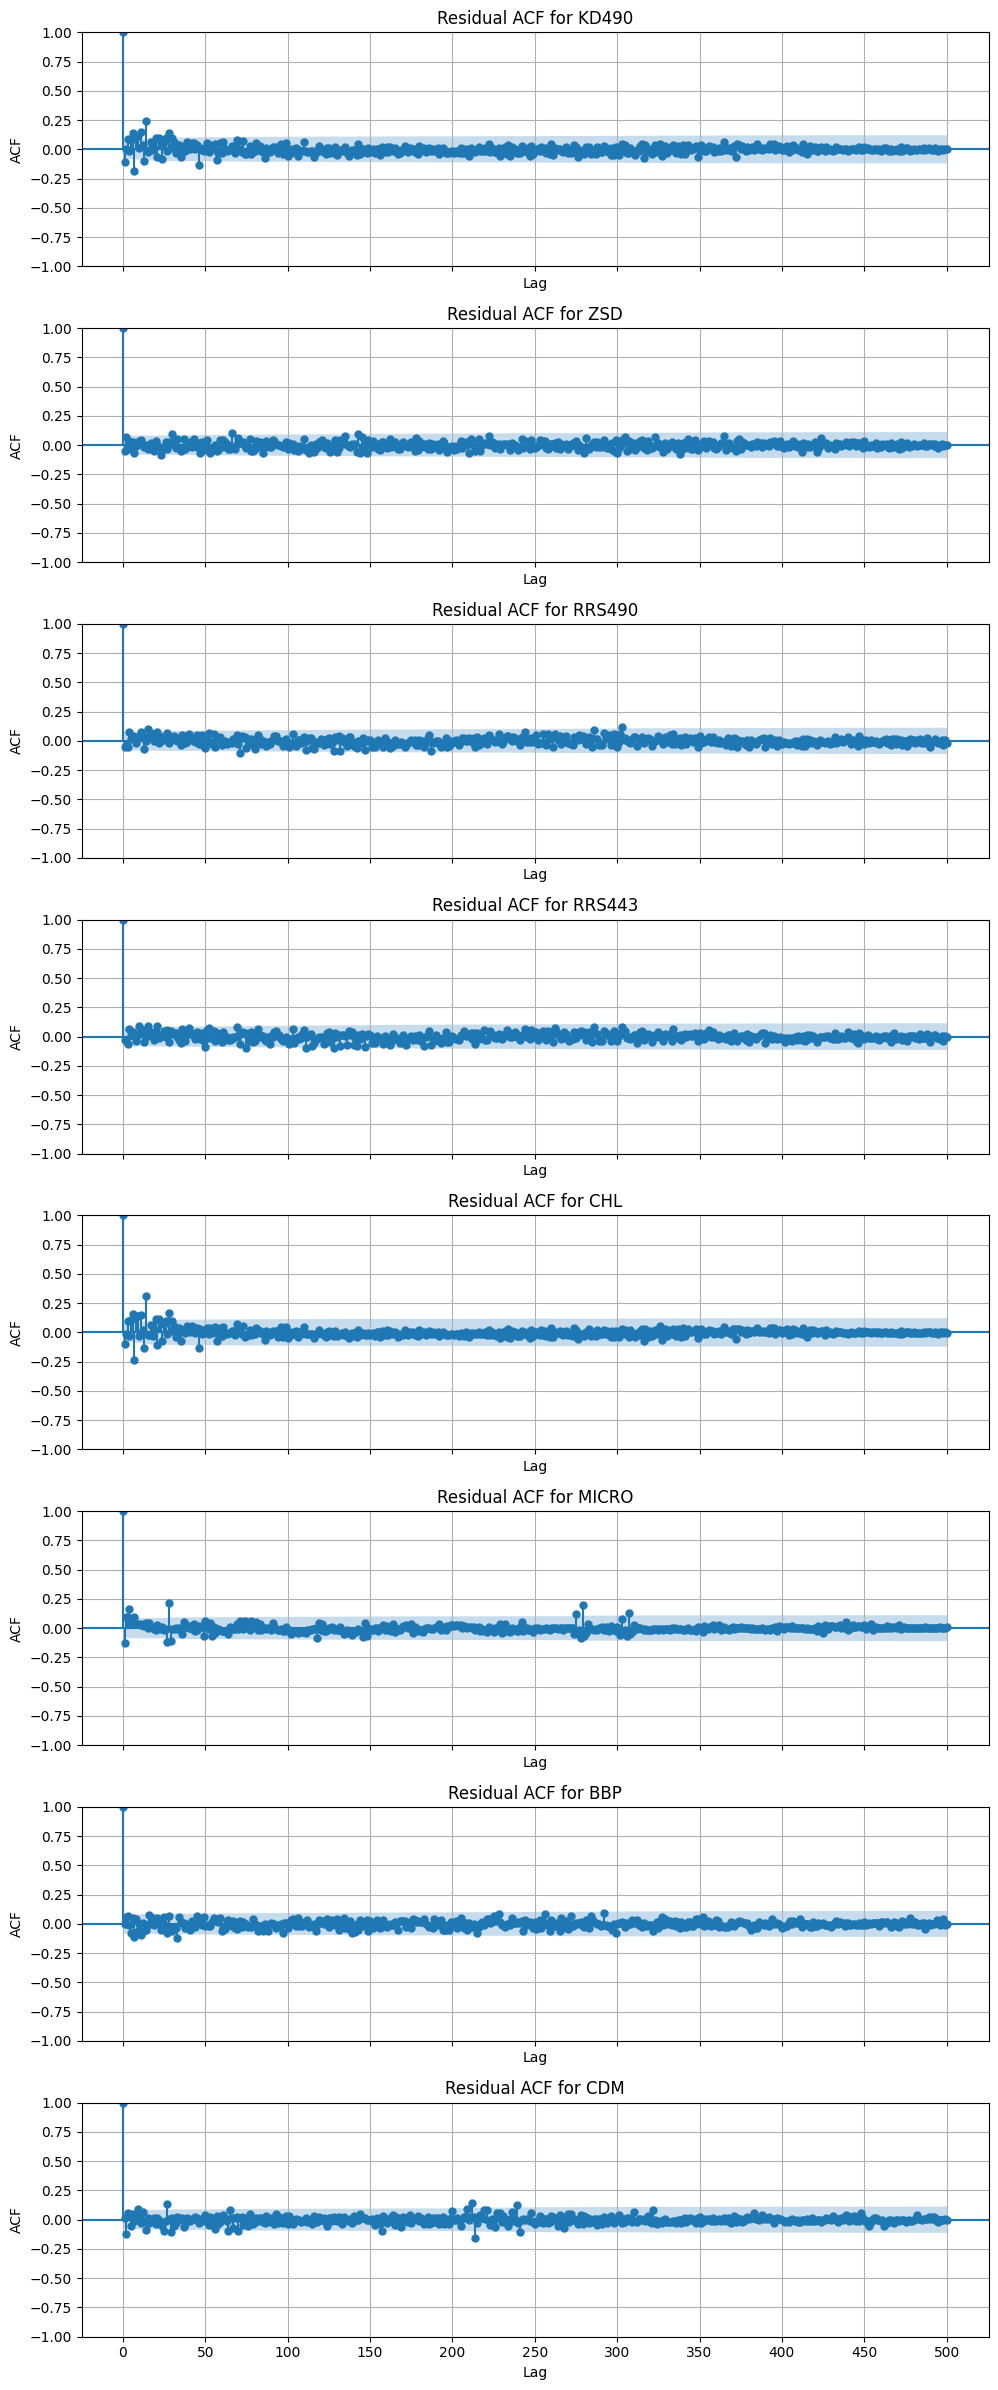

In [14]:
residuals = result_model.resid

# Plot ACF for each variable's residuals
max_lag = 500
n_vars = residuals.shape[1]
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 3*n_vars), sharex=True)

if n_vars == 1:
    axes = [axes]

for i, col in enumerate(residuals.columns):
    plot_acf(residuals[col].dropna(), lags=max_lag, ax=axes[i])
    axes[i].set_title(f"Residual ACF for {col}")
    axes[i].grid(True)
    axes[i].xaxis.set_ticks(np.arange(0, max_lag+1, 50))
    axes[i].set_xlabel("Lag")
    axes[i].set_ylabel("ACF")

plt.tight_layout()
plt.show()

# Visualisation of results

## Heatmap for evaluation metrics: SMAPE, RMSE, MAE

In [20]:
def heatmap(predicted_set, true_set):
    all_preds = []
    all_truths = []

    for (lat, lon), preds in predicted_set.items():
        val_ts = true_set[(true_set['lat_5km'] == lat) & (true_set['lon_5km'] == lon)]
        val_ts = val_ts.sort_values('date')

        if not all(col in val_ts.columns for col in parameter_columns):
            continue

        val_ts = val_ts[parameter_columns].values

        if preds.shape != val_ts.shape:
            continue

        all_preds.append(preds)
        all_truths.append(val_ts)

    all_preds = np.vstack(all_preds)
    all_truths = np.vstack(all_truths)

    global_rmse = np.sqrt(np.mean((all_truths - all_preds) ** 2, axis=0))
    global_mae  = np.mean(np.abs(all_truths - all_preds), axis=0)
    global_smape = np.mean(2 * np.abs(all_truths - all_preds) /
                           np.clip(np.abs(all_truths) + np.abs(all_preds), 1e-8, None), axis=0)

    metrics_df = pd.DataFrame(
        [global_smape*100, global_rmse, global_mae],
        index=['SMAPE (%)', 'RMSE', 'MAE'],
        columns=parameter_columns
    )

    print(metrics_df.round(4))
    return metrics_df

In [21]:
val_metrics_df = heatmap(val_predictions, val_set)
test_metrics_df = heatmap(test_predictions, test_set)

            KD490      ZSD   RRS490   RRS443      CHL    MICRO      BBP  \
SMAPE (%)  9.7717  10.4172  14.6549  19.1887  19.8494  55.6986  22.1659   
RMSE       0.0276   1.6734   0.0015   0.0015   0.9169   3.8385   0.0053   
MAE        0.0107   0.9559   0.0008   0.0009   0.2724   0.9710   0.0018   

               CDM  
SMAPE (%)  28.2050  
RMSE        0.0792  
MAE         0.0210  
             KD490      ZSD   RRS490   RRS443      CHL    MICRO      BBP  \
SMAPE (%)  12.7687  12.6805  17.4016  23.0486  25.9571  77.0387  28.8401   
RMSE        0.0361   2.2055   0.0017   0.0018   1.2002   5.9009   0.0060   
MAE         0.0138   1.2021   0.0009   0.0010   0.3569   1.8220   0.0021   

               CDM  
SMAPE (%)  35.5105  
RMSE        0.0952  
MAE         0.0274  


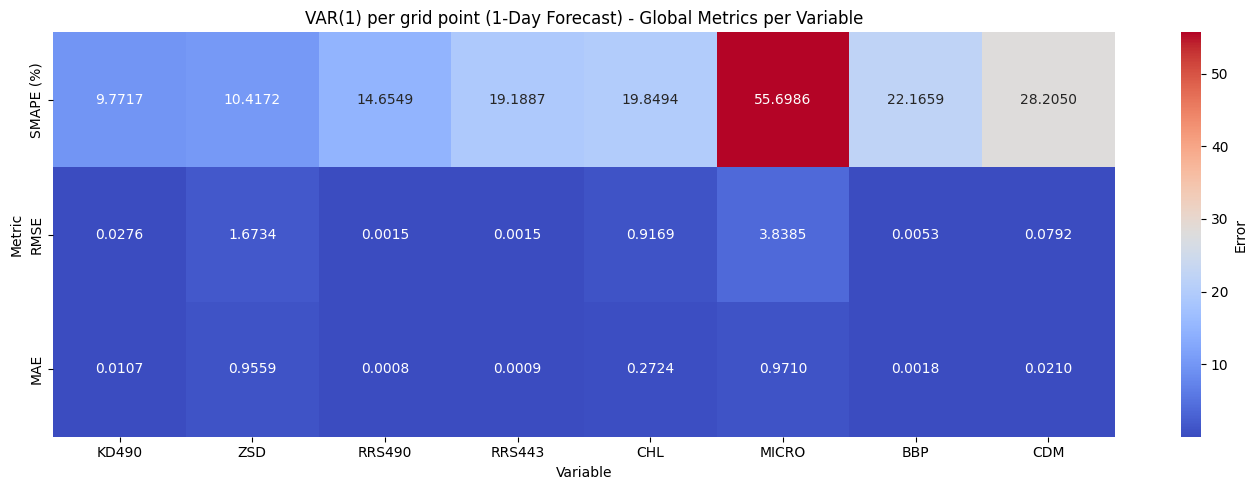

In [25]:
# --- HEATMAP FOR VALIDATION SET ---
plt.figure(figsize=(14, 5))
sns.heatmap(val_metrics_df, annot=True, fmt=".4f", cmap='coolwarm', cbar_kws={'label': 'Error'})
plt.title("VAR(1) per grid point (1-Day Forecast) - Global Metrics per Variable")
plt.xlabel("Variable")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

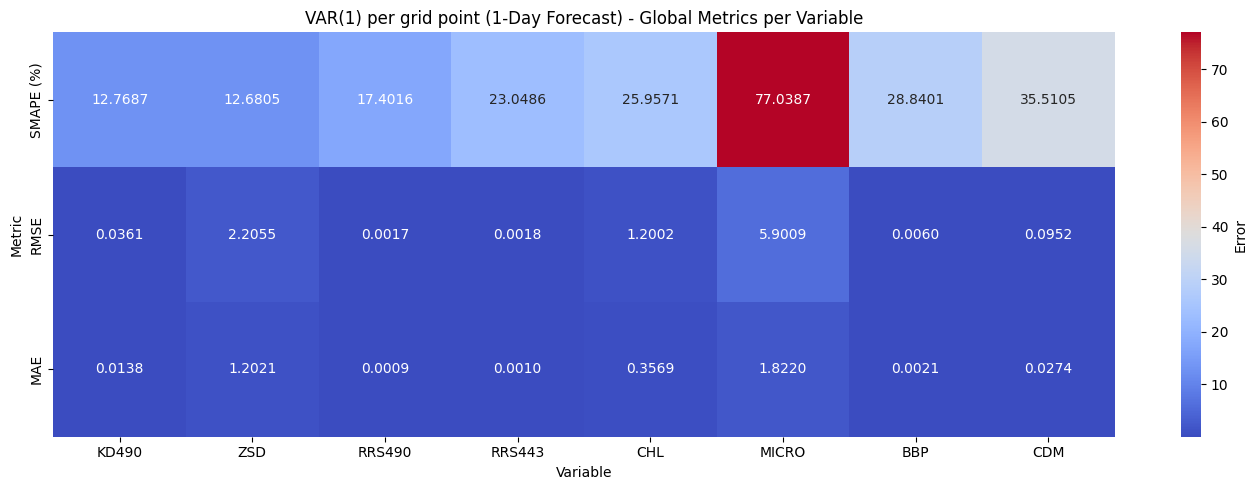

In [26]:
# --- HEATMAP FOR TEST SET ---
plt.figure(figsize=(14, 5))
sns.heatmap(test_metrics_df, annot=True, fmt=".4f", cmap='coolwarm', cbar_kws={'label': 'Error'})
plt.title("VAR(1) per grid point (1-Day Forecast) - Global Metrics per Variable")
plt.xlabel("Variable")
plt.ylabel("Metric")
plt.tight_layout()
plt.show()

## True vs Predicted values per variable plot: daily average

In [27]:
def plot_spatial_means_with_gaps(true_set, predictions, parameter_columns, winter_gaps, title_suffix="Validation"):
    all_preds = []
    all_truths = []
    common_dates = None

    for (lat, lon), preds in predictions.items():
        subset = true_set[(true_set['lat_5km'] == lat) & (true_set['lon_5km'] == lon)]
        subset = subset.sort_values('date')

        # Ensure variable availability
        if not all(col in subset.columns for col in parameter_columns):
            continue

        # Align lengths
        truths = subset[parameter_columns].values
        if preds.shape != truths.shape:
            continue

        all_preds.append(preds)
        all_truths.append(truths)

        if common_dates is None:
            common_dates = subset['date'].values

    if len(all_preds) == 0:
        print("No valid points found.")
        return

    all_preds = np.stack(all_preds)       # (G, T, V)
    all_truths = np.stack(all_truths)     # (G, T, V)

    pred_means = all_preds.mean(axis=0)   # (T, V)
    true_means = all_truths.mean(axis=0)  # (T, V)

    # Prepare dates
    test_dates_seq = pd.to_datetime(common_dates)
    test_dates_num = mdates.date2num(test_dates_seq)

    # Plot
    fig, axs = plt.subplots(4, 2, figsize=(18, 12))
    axs = axs.flatten()

    for i, var in enumerate(parameter_columns):
        mask = np.ones(len(test_dates_seq), dtype=bool)
        for start, end in winter_gaps:
            mask &= ((test_dates_seq < start) | (test_dates_seq > end))

        # Split into continuous segments
        segments = np.where(~mask)[0]
        gap_edges = np.split(np.arange(len(test_dates_seq)), segments)

        for seg in gap_edges:
            if len(seg) > 0:
                axs[i].plot(
                    test_dates_seq[seg],
                    true_means[seg, i],
                    color='C0', label="Actual" if seg[0] == 0 else ""
                )
                axs[i].plot(
                    test_dates_seq[seg],
                    pred_means[seg, i],
                    linestyle="--", color='C1',
                    label="Predicted" if seg[0] == 0 else ""
                )

        axs[i].set_title(f"{var} - Predicted vs Actual [Daily Avg] ({title_suffix})")
        axs[i].xaxis.set_major_locator(mdates.MonthLocator())
        axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
        axs[i].grid(True)

        # Shade winter gaps
        for start, end in winter_gaps:
            axs[i].axvspan(start, end, color="lightgrey", alpha=0.5, label="Winter Gap" if i == 0 else "")

        axs[i].legend()

    plt.tight_layout()
    plt.show()

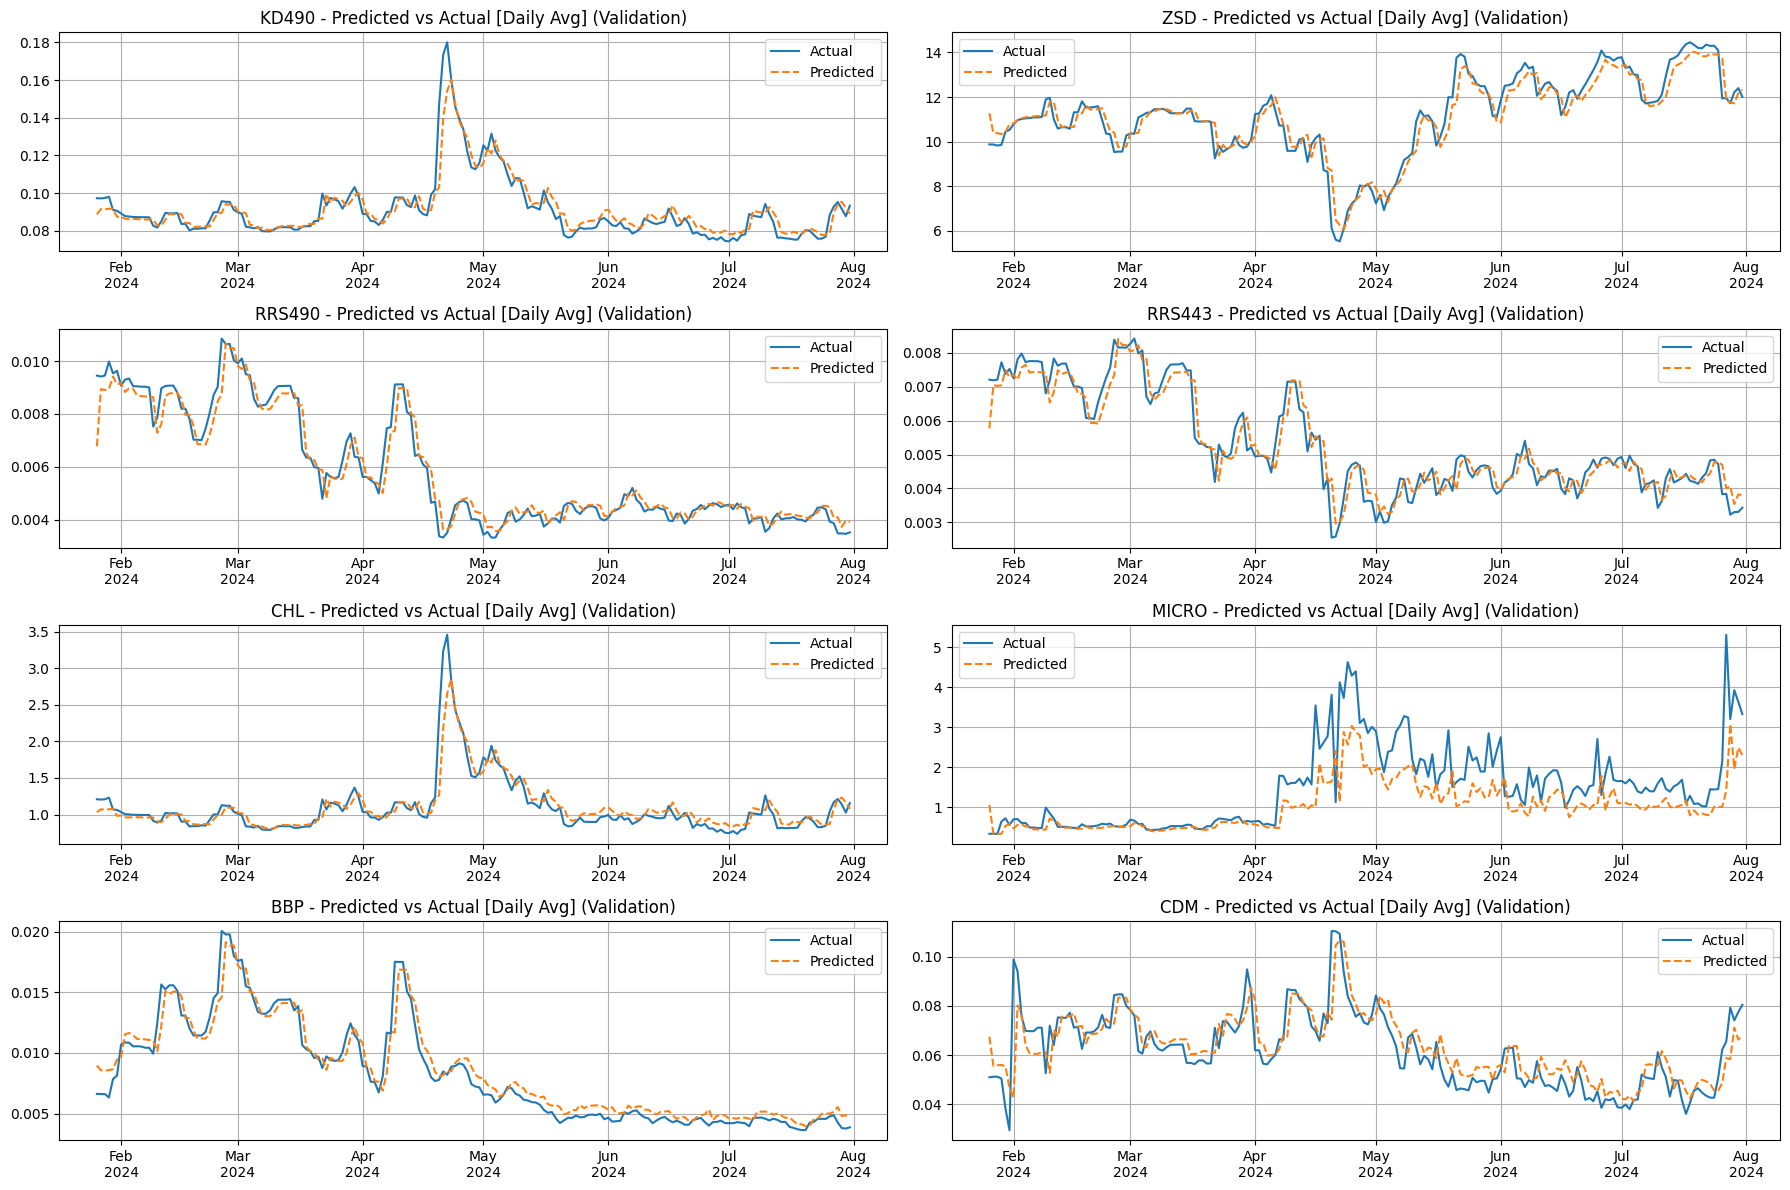

In [32]:
# --- PLOT FOR VALIDATION SET ---
winter_gaps = []
plot_spatial_means_with_gaps(val_set, val_predictions, parameter_columns, winter_gaps, title_suffix="Validation")

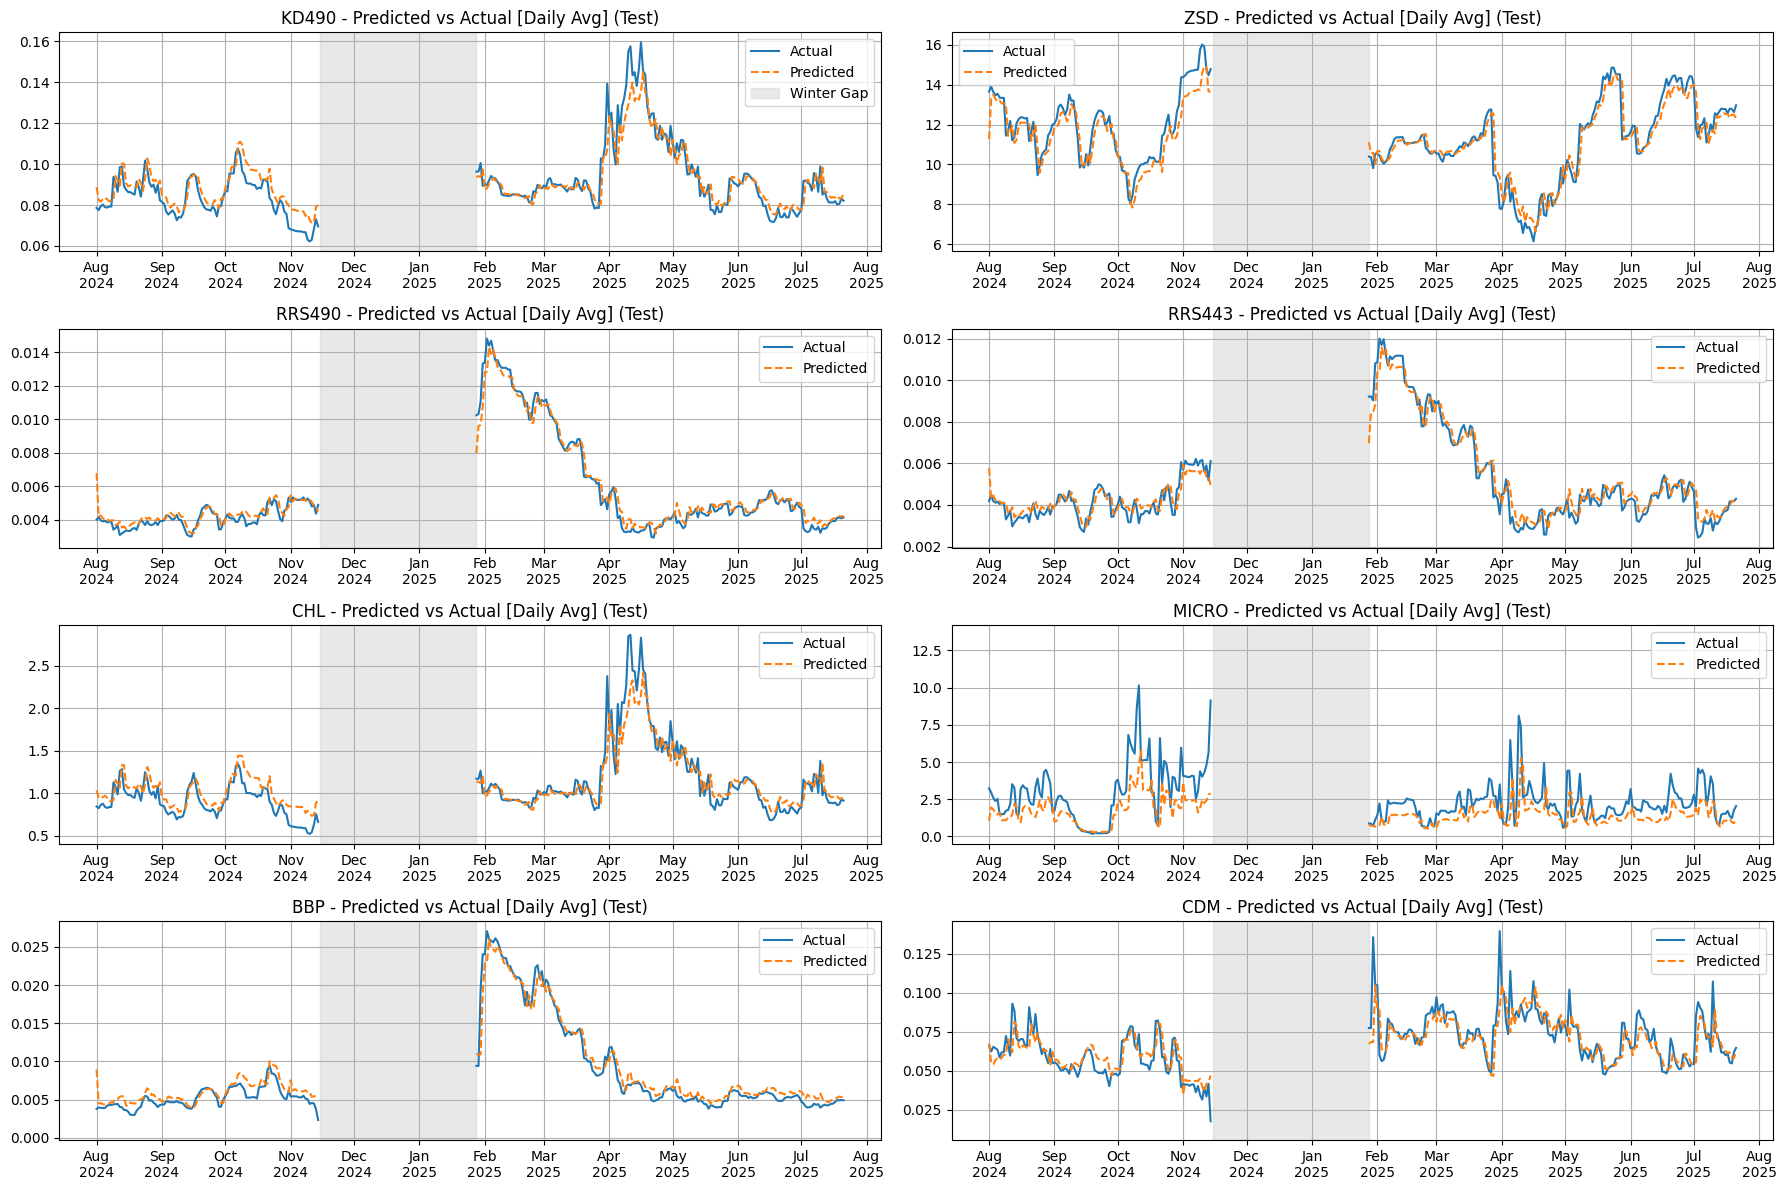

In [28]:
# --- PLOT FOR TEST SET ---
winter_gaps = [(pd.to_datetime("2024-11-15"), pd.to_datetime("2025-01-28"))]
plot_spatial_means_with_gaps(test_set, test_predictions, parameter_columns, winter_gaps, title_suffix="Test")